<a href="https://colab.research.google.com/github/Huang-Yongzhi/MusicLM_Jupyter/blob/main/musiclm_multrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

如果重新运行，需要重启，不然trainer会报错，认为有多个实例

# 一、加载数据
## 1.安装必要的包

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
# !pip install you-get
!pip install yt-dlp
!sudo apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


## 加载数据集

**数据集内容**

调用的.csv文件内容如下
```
ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval
-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']","The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.",4,False,True
...
```

In [3]:
import pandas as pd
import os

#  GitHub 上的 .csv 文件的 Raw 链接
url = "https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/Data/musiccaps-public.csv"

df = pd.read_csv(url)

# 显示数据以验证加载正确
print(df.head())


output_dir = '/content'  # 输出目录
file_name = url.split('/')[-1]

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 指定文件保存路径
file_path = os.path.join(output_dir, file_name)



# 将 DataFrame 保存为 CSV 文件
df.to_csv(file_path, index=False)  # 设置index=False以防止添加额外的索引列


# 检查文件是否已保存
!ls /content


          ytid  start_s  end_s  \
0  -0Gj8-vB1q4       30     40   
1  -0SdAVK79lg       30     40   
2  -0vPFx-wRRI       30     40   
3  -0xzrMun0Rs       30     40   
4  -1LrH01Ei1w       30     40   

                            audioset_positive_labels  \
0                       /m/0140xf,/m/02cjck,/m/04rlf   
1  /m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...   
2                                /m/025_jnm,/m/04rlf   
3                                 /m/01g90h,/m/04rlf   
4                                /m/02p0sh1,/m/04rlf   

                                         aspect_list  \
0  ['low quality', 'sustained strings melody', 's...   
1  ['guitar song', 'piano backing', 'simple percu...   
2  ['amateur recording', 'finger snipping', 'male...   
3  ['backing track', 'jazzy', 'digital drums', 'p...   
4  ['rubab instrument', 'repetitive melody on dif...   

                                             caption  author_id  \
0  The low quality recording features a ballad so...  

**解释**：
数据集是一个包含音频信息和描述的元数据文件，格式类似于 CSV。每行包含一个 YouTube 音频的标识符（ytid），音频的开始和结束时间（start_s 和 end_s），音频标签（audioset_positive_labels）和其他相关信息。



## 使用 yt-dlp 下载音频
使用如 youtube-dl，yt-dlp 等 这类工具来下载视频，然后使用音频处理库（例如 librosa 或 pydub）来裁剪音频。但是**youtube-dl还是停留在2021年，很多功能不能用了**....


下载 YouTube 音频
首先，需要安装 yt-dlp：

In [4]:
# !pip install yt-dlp

测试yt-dlp

In [5]:
# !yt-dlp -f140 -x --audio-format mp3 https://www.youtube.com/watch?v=-0vPFx-wRRI

测试命令行

In [6]:
# import subprocess
# import os
# import glob

# ytid = "-0xzrMun0Rs"  # 示例 YouTube 视频ID
# start_s = 10  # 裁剪开始时间（秒）
# end_s = 20    # 裁剪结束时间（秒）
# audio_output_dir = '/content/downloaded_audios'  # 音频输出目录

# # 确保输出目录存在
# os.makedirs(audio_output_dir, exist_ok=True)

# video_url = f'https://www.youtube.com/watch?v={ytid}'
# temp_audio_path_pattern  = os.path.join(audio_output_dir, f'{ytid}_temp.*')
# output_audio_path = os.path.join(audio_output_dir, f'{ytid}.wav')


# try:
#     # 下载音频， 修改这段命令可以测试命令行是否正确
#     subprocess.run(['yt-dlp', '-x', '--audio-format', 'wav', '-o', temp_audio_path_pattern, video_url], check=True)

#     # 查找下载的音频文件
#     downloaded_files = glob.glob(temp_audio_path_pattern)
#     if not downloaded_files:
#         raise Exception("Downloaded audio file not found.")
#     downloaded_audio_path = downloaded_files[0]  # 取得实际下载的文件路径

#     # 使用 ffmpeg 裁剪音频
#     subprocess.run(['ffmpeg', '-i', downloaded_audio_path, '-ss', str(start_s), '-to', str(end_s), '-c', 'copy', output_audio_path], check=True)
#     os.remove(downloaded_audio_path)  # 删除临时文件
#     print(f"Audio downloaded and trimmed: {output_audio_path}")
# except subprocess.CalledProcessError as e:
#     print(f"Error: {e}")


## **有两种方案** 方案一

方案一：使用 yt-dlp 命令行工具的 --download-sections 参数来直接下载特定时间段的音频。

方案二：在 yt-dlp 命令下载视频以后，利用ffmpeg来剪裁。
yt-dlp 命令中使用了 --postprocessor-args 选项，但没有指定具体哪个后处理器（post-processor）应该使用这些参数。
我们需要参数应用于 ffmpeg 音频裁剪处理器。

方案一：
使用进程而不是线程，因为：

使用多进程（num_proc=cores），**在处理 CPU 密集型任务（如音频处理）时通常比多线程更有效率**。这是因为 Python 的线程受到全局解释器锁（GIL）的限制，而多进程可以绕过这个限制，充分利用多核 CPU。

使用了线程池（ThreadPoolExecutor），在 Python 中，**线程主要适用于 I/O 密集型任务**，而对于 CPU 密集型任务，由于 GIL 的存在，其效率通常低于多进程。


In [7]:
# 加载进度条
!pip install tqdm


In [8]:
import subprocess
import os
import pandas as pd
from tqdm import tqdm
from concurrent.futures import as_completed
from concurrent.futures import ProcessPoolExecutor
import glob

def download_audio(ytid, start_s, end_s, audio_output_dir, num_attempts=5):
    video_url = f'https://www.youtube.com/watch?v={ytid}'
    output_audio_path = os.path.join(audio_output_dir, f'{ytid}.wav')

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_audio_path}" --download-sections "*{start_s}-{end_s}" {video_url}
    """.strip()

    attempts = 0
    while attempts < num_attempts:
         # 尝试下载多次以确保成功。
      try:
          subprocess.run(command, check=True, shell=True)
          # 使用run指令更通用，用于执行命令并等待其完成。替代旧的函数如 call, check_call, check_output。
          return output_audio_path
      except subprocess.CalledProcessError as e:
          print(f"Attempt {attempts + 1} failed for {ytid}: {e}")
          attempts += 1
      print(f"Failed to download audio for {ytid} after {num_attempts} attempts.")
      return None


def download_and_process_audio(ytid, start_s, end_s, audio_output_dir):
    output_audio_path = os.path.join(audio_output_dir, f'{ytid}.wav')

    # 检查音频文件是否已存在
    if not os.path.exists(output_audio_path):
        # 如果不存在，则下载音频
        downloaded_path = download_audio(ytid, start_s, end_s, audio_output_dir)
        if downloaded_path:
            print(f"Downloaded audio to {downloaded_path}.")
        else:
            print(f"Failed to download audio for {ytid}.")
    else:
        print(f"Audio file already exists for {ytid}. Skipping download.")




# 加载CSV文件
csv_file = '/content/musiccaps-public.csv'  # colab
# csv_file = '/kaggle/input/musiccaps/musiccaps-public.csv'  # kaggle

df = pd.read_csv(csv_file)

audio_output_dir = './downloaded_audios'  # 音频输出目录

# 确保输出目录存在
os.makedirs(audio_output_dir, exist_ok=True)

# 使用进程池，这里的进程池数量可以改一下
cores = 50 # 进程数量
samples = 5000 # 样本数量

# 工作进程数量
with ProcessPoolExecutor(max_workers=cores) as executor:
    # 准备将来的结果
    future_to_ytid = {executor.submit(
        download_and_process_audio,
        row['ytid'], row['start_s'], row['end_s'],
        audio_output_dir
        ): row['ytid'] for index, row in df.iterrows() if index < samples}

    # 使用 tqdm 来显示进度
    for future in tqdm(as_completed(future_to_ytid), total=len(future_to_ytid)):
        ytid = future_to_ytid[future]
        try:
            future.result()  # 获取结果或抛出异常
        except Exception as e:
            print(f"{ytid} generated an exception: {e}")



Audio file already exists for -0SdAVK79lg. Skipping download.Audio file already exists for -0vPFx-wRRI. Skipping download.Audio file already exists for -0xzrMun0Rs. Skipping download.Audio file already exists for -1UWSisR2zo. Skipping download.Audio file already exists for -4NLarMj4xU. Skipping download.Audio file already exists for -7wUQP6G5EQ. Skipping download.Audio file already exists for -1OlgJWehn8. Skipping download.Audio file already exists for -JVWfFPBl84. Skipping download.Audio file already exists for -DeAdhYKbGE. Skipping download.Audio file already exists for -Bu7YaslRW0. Skipping download.Audio file already exists for -BIMKnb3tlo. Skipping download.Audio file already exists for -FFx68qSAuY. Skipping download.Audio file already exists for -CUp_Tmg2Y0. Skipping download.Audio file already exists for -M-6VinyMiY. Skipping download.Audio file already exists for -Dtir74TiUM. Skipping download.Audio file already exists for -NmjCyqIavI. Skipping download.Audio file already exist

  3%|▎         | 151/5000 [00:00<00:20, 237.47it/s]

Attempt 1 failed for -sevczF5etI: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/-sevczF5etI.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=-sevczF5etI' returned non-zero exit status 1.
Failed to download audio for -sevczF5etI after 5 attempts.
Attempt 1 failed for 0pewITE1550: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/0pewITE1550.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=0pewITE1550' returned non-zero exit status 1.Failed to download audio for -sevczF5etI.

Failed to download audio for 0pewITE1550 after 5 attempts.
Attempt 1 failed for 0fqtA_ZBn_8: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/0fqtA_ZBn_8.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=0fqtA_ZBn_8' returned non-zero exit status 1.Failed to download audio for 0pewITE1550.

Failed to download audio for 0fqt

  4%|▍         | 201/5000 [00:06<03:20, 23.90it/s] 

  4%|▍         | 201/5000 [00:20<03:20, 23.90it/s]

Downloaded audio to ./downloaded_audios/15Mw2jyyHk0.wav.


  4%|▍         | 203/5000 [00:39<26:58,  2.96it/s]

Downloaded audio to ./downloaded_audios/0wYi8B9PXDY.wav.


  4%|▍         | 204/5000 [00:40<27:14,  2.93it/s]

Downloaded audio to ./downloaded_audios/11FeId69WOk.wav.
Downloaded audio to ./downloaded_audios/0nk7utNkHOY.wav.Downloaded audio to ./downloaded_audios/0zolXzR9Oi4.wav.

Downloaded audio to ./downloaded_audios/0u1sk49gAU0.wav.
Downloaded audio to ./downloaded_audios/0soVCtJgDTk.wav.
Downloaded audio to ./downloaded_audios/0i8VM_EooCs.wav.
Downloaded audio to ./downloaded_audios/0s0Uy0-zBa0.wav.Downloaded audio to ./downloaded_audios/0trWdhSvab4.wav.

Downloaded audio to ./downloaded_audios/14hTDUjCr_g.wav.
Downloaded audio to ./downloaded_audios/16F5fdORzSo.wav.Downloaded audio to ./downloaded_audios/13n6n6nKMhI.wav.
Downloaded audio to ./downloaded_audios/0vFPs6XsU_Q.wav.Downloaded audio to ./downloaded_audios/0x6chChxzV0.wav.


Downloaded audio to ./downloaded_audios/0rNr_qnoPQ4.wav.Downloaded audio to ./downloaded_audios/0nNmbkU8GBI.wav.
Downloaded audio to ./downloaded_audios/16TsDMjHzYU.wav.Downloaded audio to ./downloaded_audios/0sPVAP17w2U.wav.Downloaded audio to ./downloaded_a

  4%|▍         | 221/5000 [00:46<27:48,  2.86it/s]



Downloaded audio to ./downloaded_audios/1BVSYfNCcv0.wav.
Downloaded audio to ./downloaded_audios/1AOe82obwcY.wav.
Downloaded audio to ./downloaded_audios/11fNNN95_og.wav.Downloaded audio to ./downloaded_audios/15CZ2h5VL-A.wav.

Downloaded audio to ./downloaded_audios/1ACn3u5UnBw.wav.
Downloaded audio to ./downloaded_audios/19-GI2LzOtc.wav.
Downloaded audio to ./downloaded_audios/0u5-WiBKam8.wav.
Downloaded audio to ./downloaded_audios/0jFQ21A6GRA.wav.
Downloaded audio to ./downloaded_audios/0q-80dzp6PU.wav.


  5%|▍         | 232/5000 [00:48<24:58,  3.18it/s]

Downloaded audio to ./downloaded_audios/0wzsE67O5tE.wav.
Downloaded audio to ./downloaded_audios/0qtbbK5HVMw.wav.
Downloaded audio to ./downloaded_audios/1Ccis4FDGwY.wav.Downloaded audio to ./downloaded_audios/11D0JdB7_4k.wav.

Downloaded audio to ./downloaded_audios/15z-gbPxdXg.wav.
Downloaded audio to ./downloaded_audios/18mS4cLPOb8.wav.
Downloaded audio to ./downloaded_audios/0m9-5BkL4Mc.wav.
Downloaded audio to ./downloaded_audios/1ArUx6UCxe4.wav.


  5%|▍         | 240/5000 [00:50<24:53,  3.19it/s]

Downloaded audio to ./downloaded_audios/0lIETNZ_7sg.wav.
Downloaded audio to ./downloaded_audios/10dur7jhFQM.wav.
Downloaded audio to ./downloaded_audios/0kQjfwXjFuY.wav.
Downloaded audio to ./downloaded_audios/19Pp9QEw17U.wav.
Downloaded audio to ./downloaded_audios/17AtKbQ7glU.wav.
Downloaded audio to ./downloaded_audios/0kQD1P0_KUs.wav.


  5%|▍         | 246/5000 [00:55<29:54,  2.65it/s]

Downloaded audio to ./downloaded_audios/0u4gY1bBUwQ.wav.


  5%|▍         | 246/5000 [01:10<29:54,  2.65it/s]

Downloaded audio to ./downloaded_audios/1FnA3w94zXI.wav.


  5%|▍         | 248/5000 [01:26<1:47:55,  1.36s/it]

Downloaded audio to ./downloaded_audios/1DNoynuGLV4.wav.


  5%|▍         | 249/5000 [01:28<1:48:53,  1.38s/it]

Downloaded audio to ./downloaded_audios/1FnT0RrfMEA.wav.
Downloaded audio to ./downloaded_audios/1FU5odlgLmo.wav.
Downloaded audio to ./downloaded_audios/1GCOnj53QYM.wav.


  5%|▌         | 252/5000 [01:50<1:47:40,  1.36s/it]

Downloaded audio to ./downloaded_audios/1SO5RJLWKAs.wav.


  5%|▌         | 253/5000 [02:00<4:16:08,  3.24s/it]

Downloaded audio to ./downloaded_audios/1PN-bfs2EhY.wav.


  5%|▌         | 254/5000 [02:02<4:07:47,  3.13s/it]

Downloaded audio to ./downloaded_audios/1KmsVHx7E2c.wav.
Downloaded audio to ./downloaded_audios/1ILLsA6gqHE.wav.


  5%|▌         | 256/5000 [02:04<3:33:53,  2.71s/it]

Downloaded audio to ./downloaded_audios/1IK4OeOqAEo.wav.


  5%|▌         | 257/5000 [02:07<3:32:00,  2.68s/it]

Downloaded audio to ./downloaded_audios/1Q9DXhXMSFI.wav.


  5%|▌         | 258/5000 [02:08<3:18:00,  2.51s/it]

Downloaded audio to ./downloaded_audios/1SqihV_DnEg.wav.
Downloaded audio to ./downloaded_audios/1JqNiV03kog.wav.

  5%|▌         | 259/5000 [02:09<2:44:12,  2.08s/it]

  5%|▌         | 260/5000 [02:09<2:12:31,  1.68s/it]

Downloaded audio to ./downloaded_audios/1KN3GrwhY8c.wav.


  5%|▌         | 261/5000 [02:09<1:46:10,  1.34s/it]

Downloaded audio to ./downloaded_audios/1ToIyrmWFjw.wav.Downloaded audio to ./downloaded_audios/1MwaXCfUvX8.wav.


  5%|▌         | 262/5000 [02:10<1:32:36,  1.17s/it]


Downloaded audio to ./downloaded_audios/1Rd1w7Ty1ak.wav.


  5%|▌         | 264/5000 [02:10<1:00:28,  1.31it/s]

Downloaded audio to ./downloaded_audios/1IMi7yfZVVM.wav.


  5%|▌         | 265/5000 [02:10<52:08,  1.51it/s]  

Downloaded audio to ./downloaded_audios/1V7ReAk9k-4.wav.Downloaded audio to ./downloaded_audios/1PKxdTlquCA.wav.Downloaded audio to ./downloaded_audios/1RwhRTe-OKk.wav.



  5%|▌         | 266/5000 [02:10<43:32,  1.81it/s]


Downloaded audio to ./downloaded_audios/1RhYdQnZ_hw.wav.


  5%|▌         | 269/5000 [02:11<23:43,  3.32it/s]

Downloaded audio to ./downloaded_audios/1LA64TXatWk.wav.


  5%|▌         | 270/5000 [02:11<23:10,  3.40it/s]

Downloaded audio to ./downloaded_audios/1TyOPtg0Yfk.wav.


  5%|▌         | 271/5000 [02:11<24:58,  3.16it/s]

Downloaded audio to ./downloaded_audios/1Xtkou9dtyA.wav.


  5%|▌         | 272/5000 [02:12<23:48,  3.31it/s]

Downloaded audio to ./downloaded_audios/1ZaxqZMs21M.wav.


  5%|▌         | 273/5000 [02:12<31:13,  2.52it/s]

Downloaded audio to ./downloaded_audios/1QFli7KSXAQ.wav.


  5%|▌         | 274/5000 [02:13<32:19,  2.44it/s]

Downloaded audio to ./downloaded_audios/1QSD-dzEv7Y.wav.


  6%|▌         | 275/5000 [02:13<26:09,  3.01it/s]

Downloaded audio to ./downloaded_audios/1_YHHL_t2GI.wav.


  6%|▌         | 276/5000 [02:13<32:43,  2.41it/s]

Downloaded audio to ./downloaded_audios/1RRGInmOhTQ.wav.


  6%|▌         | 277/5000 [02:14<38:21,  2.05it/s]

Downloaded audio to ./downloaded_audios/1WlvXneu6oY.wav.


  6%|▌         | 278/5000 [02:15<42:45,  1.84it/s]

Downloaded audio to ./downloaded_audios/1JpeDWbgUO8.wav.


  6%|▌         | 279/5000 [02:15<41:55,  1.88it/s]

Downloaded audio to ./downloaded_audios/1a_nvi4sW64.wav.


  6%|▌         | 280/5000 [02:16<36:41,  2.14it/s]

Downloaded audio to ./downloaded_audios/1OIfQHKnAcw.wav.


  6%|▌         | 281/5000 [02:16<38:08,  2.06it/s]

Downloaded audio to ./downloaded_audios/1O4LpU7HggY.wav.


  6%|▌         | 282/5000 [02:16<34:40,  2.27it/s]

Downloaded audio to ./downloaded_audios/1YPYQP6yupA.wav.


  6%|▌         | 283/5000 [02:17<42:16,  1.86it/s]

Downloaded audio to ./downloaded_audios/1JwoLPCIGhs.wav.


  6%|▌         | 284/5000 [02:17<34:53,  2.25it/s]

Downloaded audio to ./downloaded_audios/1bSP4wLfMpA.wav.Downloaded audio to ./downloaded_audios/1PSzSTilu_s.wav.
Downloaded audio to ./downloaded_audios/1W2Cz2Jj76Q.wav.


  6%|▌         | 285/5000 [02:18<34:02,  2.31it/s]

  6%|▌         | 287/5000 [02:18<20:47,  3.78it/s]

Downloaded audio to ./downloaded_audios/1gDNqOQFopY.wav.


  6%|▌         | 288/5000 [02:19<27:58,  2.81it/s]

Downloaded audio to ./downloaded_audios/1W2FOzSXsxs.wav.


  6%|▌         | 289/5000 [02:19<35:33,  2.21it/s]

Downloaded audio to ./downloaded_audios/1Is1xfDjZrw.wav.


  6%|▌         | 290/5000 [02:20<30:41,  2.56it/s]

Downloaded audio to ./downloaded_audios/1dt9eL2rmSY.wav.


  6%|▌         | 291/5000 [02:21<45:25,  1.73it/s]

Downloaded audio to ./downloaded_audios/1VKSpjXZvKo.wav.


  6%|▌         | 292/5000 [02:22<1:12:50,  1.08it/s]

Downloaded audio to ./downloaded_audios/1Ziku4FLka4.wav.


  6%|▌         | 293/5000 [02:26<2:12:02,  1.68s/it]

Downloaded audio to ./downloaded_audios/1h2sb2xeCt8.wav.


  6%|▌         | 294/5000 [02:27<1:58:45,  1.51s/it]

Downloaded audio to ./downloaded_audios/1hABzqBHh7w.wav.


  6%|▌         | 295/5000 [02:28<1:48:12,  1.38s/it]

Downloaded audio to ./downloaded_audios/1cwGW0cBdRs.wav.


  6%|▌         | 296/5000 [02:29<1:34:20,  1.20s/it]

Downloaded audio to ./downloaded_audios/1cqcTbDxsHM.wav.


  6%|▌         | 297/5000 [02:29<1:15:04,  1.04it/s]

Downloaded audio to ./downloaded_audios/1i1sbQOILb0.wav.


  6%|▌         | 298/5000 [02:58<12:04:57,  9.25s/it]

Downloaded audio to ./downloaded_audios/1heMbyumHAo.wav.


  6%|▌         | 299/5000 [02:59<8:51:09,  6.78s/it] 

Downloaded audio to ./downloaded_audios/1j13NdQiw8c.wav.


  6%|▌         | 300/5000 [03:00<6:42:44,  5.14s/it]

Attempt 1 failed for 25Ccp8usBtE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/25Ccp8usBtE.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=25Ccp8usBtE' returned non-zero exit status 1.
Failed to download audio for 25Ccp8usBtE after 5 attempts.
Failed to download audio for 25Ccp8usBtE.


  6%|▌         | 301/5000 [03:01<4:52:37,  3.74s/it]

Downloaded audio to ./downloaded_audios/1hWAOReJehw.wav.


  6%|▌         | 302/5000 [03:02<3:50:13,  2.94s/it]

Downloaded audio to ./downloaded_audios/1j3pXUr8R4M.wav.


  6%|▌         | 303/5000 [03:03<3:07:26,  2.39s/it]

Downloaded audio to ./downloaded_audios/1jATjKL2vAE.wav.


  6%|▌         | 304/5000 [03:28<11:57:10,  9.16s/it]

Downloaded audio to ./downloaded_audios/1nUqhH8bAPk.wav.


  6%|▌         | 305/5000 [03:29<8:51:50,  6.80s/it] 

Downloaded audio to ./downloaded_audios/1kYDbl5Y9Sg.wav.


  6%|▌         | 306/5000 [03:31<6:56:19,  5.32s/it]

Downloaded audio to ./downloaded_audios/1jptuEjuTig.wav.


  6%|▌         | 307/5000 [03:31<4:57:46,  3.81s/it]

Downloaded audio to ./downloaded_audios/1ls3ectO1F4.wav.
Downloaded audio to ./downloaded_audios/1yGWdegJjA4.wav.


  6%|▌         | 308/5000 [03:33<3:56:30,  3.02s/it]

Downloaded audio to ./downloaded_audios/1l7BjFDQLUM.wav.


  6%|▌         | 310/5000 [03:33<2:12:16,  1.69s/it]

Downloaded audio to ./downloaded_audios/1rhsnmWLeGw.wav.


  6%|▌         | 311/5000 [03:33<1:46:46,  1.37s/it]

Downloaded audio to ./downloaded_audios/1tNkAc29aPE.wav.


  6%|▌         | 312/5000 [03:34<1:35:51,  1.23s/it]

Downloaded audio to ./downloaded_audios/2-K-7T8ZIWA.wav.


  6%|▋         | 313/5000 [03:34<1:15:02,  1.04it/s]

Downloaded audio to ./downloaded_audios/1mB_cboJR8s.wav.
Downloaded audio to ./downloaded_audios/1lgqqW5TsJk.wav.


  6%|▋         | 315/5000 [03:35<46:14,  1.69it/s]  

Downloaded audio to ./downloaded_audios/23xC7lTBikU.wav.
Downloaded audio to ./downloaded_audios/1o7iTDLNTFk.wav.


  6%|▋         | 317/5000 [03:35<32:47,  2.38it/s]

Downloaded audio to ./downloaded_audios/1tz4xNRRR4M.wav.Downloaded audio to ./downloaded_audios/1xhwyUVSRQk.wav.


  6%|▋         | 318/5000 [03:36<39:18,  1.98it/s]


Downloaded audio to ./downloaded_audios/20Vh6z6Ie0E.wav.Downloaded audio to ./downloaded_audios/1j4rFfU5XKQ.wav.



  6%|▋         | 320/5000 [03:36<26:35,  2.93it/s]

Downloaded audio to ./downloaded_audios/1uHF1-8TcEk.wav.Downloaded audio to ./downloaded_audios/21MgIcLN8Ow.wav.


  6%|▋         | 322/5000 [03:36<23:02,  3.38it/s]


Downloaded audio to ./downloaded_audios/1yWGmdevTuM.wav.


  6%|▋         | 324/5000 [03:36<18:27,  4.22it/s]

Downloaded audio to ./downloaded_audios/1ypKEH2kd7g.wav.


  6%|▋         | 325/5000 [03:37<18:32,  4.20it/s]

Downloaded audio to ./downloaded_audios/20QZS9L5WeA.wav.


  7%|▋         | 326/5000 [03:37<22:43,  3.43it/s]

Downloaded audio to ./downloaded_audios/26jTWRMRoxY.wav.


  7%|▋         | 327/5000 [03:38<42:00,  1.85it/s]

Downloaded audio to ./downloaded_audios/25RWrqQol7Y.wav.


  7%|▋         | 328/5000 [03:39<34:31,  2.26it/s]

Downloaded audio to ./downloaded_audios/24cmo2fEQo8.wav.
Downloaded audio to ./downloaded_audios/2ATMQxWVpXk.wav.

  7%|▋         | 329/5000 [03:39<30:38,  2.54it/s]


Downloaded audio to ./downloaded_audios/298Q_pSLflU.wav.


  7%|▋         | 331/5000 [03:39<21:50,  3.56it/s]

Downloaded audio to ./downloaded_audios/1pR0SgbqP3M.wav.


  7%|▋         | 332/5000 [03:40<22:51,  3.40it/s]

Downloaded audio to ./downloaded_audios/26HLgXWF-Co.wav.


  7%|▋         | 333/5000 [03:40<19:09,  4.06it/s]

Downloaded audio to ./downloaded_audios/1y1lEOGBcWM.wav.Downloaded audio to ./downloaded_audios/2BGzxAuetOA.wav.



  7%|▋         | 334/5000 [03:40<20:22,  3.82it/s]

Downloaded audio to ./downloaded_audios/2BBAUwC1BI4.wav.


  7%|▋         | 336/5000 [03:40<13:49,  5.62it/s]

Downloaded audio to ./downloaded_audios/2G4lyzAZ1vk.wav.


  7%|▋         | 337/5000 [03:40<18:06,  4.29it/s]

Downloaded audio to ./downloaded_audios/2GepmcbNlJY.wav.


  7%|▋         | 338/5000 [03:42<40:30,  1.92it/s]

Downloaded audio to ./downloaded_audios/2FQKfGCwjSE.wav.


  7%|▋         | 339/5000 [03:42<34:40,  2.24it/s]

Downloaded audio to ./downloaded_audios/244y56-vLWE.wav.


  7%|▋         | 340/5000 [03:43<44:39,  1.74it/s]

Downloaded audio to ./downloaded_audios/28pkN4m1x6I.wav.


  7%|▋         | 341/5000 [03:45<1:21:05,  1.04s/it]

Downloaded audio to ./downloaded_audios/2CzfBZ1mYBs.wav.


  7%|▋         | 342/5000 [03:47<1:29:24,  1.15s/it]

Downloaded audio to ./downloaded_audios/26IOFykrJrc.wav.


  7%|▋         | 343/5000 [03:47<1:19:53,  1.03s/it]

Downloaded audio to ./downloaded_audios/2Gja9wBkz6U.wav.


  7%|▋         | 344/5000 [03:50<1:54:00,  1.47s/it]

Downloaded audio to ./downloaded_audios/2G5bSYHcJSM.wav.


  7%|▋         | 345/5000 [03:51<1:41:01,  1.30s/it]

Downloaded audio to ./downloaded_audios/2GWkKVHxGRM.wav.


  7%|▋         | 346/5000 [03:52<1:37:42,  1.26s/it]

Downloaded audio to ./downloaded_audios/28wBrNjHXOM.wav.


  7%|▋         | 347/5000 [03:59<3:39:12,  2.83s/it]

Downloaded audio to ./downloaded_audios/2Ic1zm9mBjk.wav.


  7%|▋         | 348/5000 [04:17<9:31:53,  7.38s/it]

Downloaded audio to ./downloaded_audios/2I6pPRWKsCQ.wav.


  7%|▋         | 349/5000 [04:18<7:10:43,  5.56s/it]

Downloaded audio to ./downloaded_audios/2IpapScfsT4.wav.


  7%|▋         | 350/5000 [04:21<6:15:47,  4.85s/it]

Downloaded audio to ./downloaded_audios/2JNY2SaMk7s.wav.


  7%|▋         | 351/5000 [04:21<4:28:28,  3.47s/it]

Downloaded audio to ./downloaded_audios/2JnlmS1zzls.wav.


  7%|▋         | 352/5000 [04:22<3:13:35,  2.50s/it]

Attempt 1 failed for 2dyxjGTXSpA: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/2dyxjGTXSpA.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=2dyxjGTXSpA' returned non-zero exit status 1.
Failed to download audio for 2dyxjGTXSpA after 5 attempts.
Failed to download audio for 2dyxjGTXSpA.


  7%|▋         | 353/5000 [04:30<5:37:09,  4.35s/it]

Downloaded audio to ./downloaded_audios/2JuMYUPMGGM.wav.


  7%|▋         | 354/5000 [04:32<4:31:17,  3.50s/it]

Downloaded audio to ./downloaded_audios/2KGnpMYHBGI.wav.


  7%|▋         | 355/5000 [04:44<7:52:58,  6.11s/it]

Downloaded audio to ./downloaded_audios/2KkNk9Ao7G4.wav.


  7%|▋         | 356/5000 [04:49<7:17:22,  5.65s/it]

Downloaded audio to ./downloaded_audios/2SI_uNBcSyw.wav.


  7%|▋         | 357/5000 [04:49<5:21:14,  4.15s/it]

Downloaded audio to ./downloaded_audios/2M-CFCo-rkY.wav.


  7%|▋         | 358/5000 [04:50<4:10:28,  3.24s/it]

Downloaded audio to ./downloaded_audios/2UY_-oF1vqo.wav.


  7%|▋         | 359/5000 [04:51<3:19:31,  2.58s/it]

Downloaded audio to ./downloaded_audios/2Q20hVyYjBM.wav.


  7%|▋         | 360/5000 [04:51<2:22:19,  1.84s/it]

Downloaded audio to ./downloaded_audios/2RU4CSDzS-g.wav.


  7%|▋         | 361/5000 [04:53<2:10:59,  1.69s/it]

Downloaded audio to ./downloaded_audios/2VFVe0RCn7g.wav.


  7%|▋         | 362/5000 [04:53<1:34:28,  1.22s/it]

Downloaded audio to ./downloaded_audios/2OI4QeokeRQ.wav.


  7%|▋         | 363/5000 [04:53<1:10:21,  1.10it/s]

Downloaded audio to ./downloaded_audios/2WxUIkF2zEw.wav.
Downloaded audio to ./downloaded_audios/2YAyM0aHFRU.wav.

  7%|▋         | 364/5000 [04:54<1:02:10,  1.24it/s]


Downloaded audio to ./downloaded_audios/2SQxfaWAJJg.wav.


  7%|▋         | 366/5000 [04:54<45:56,  1.68it/s]  

Downloaded audio to ./downloaded_audios/2MZUbxulAI4.wav.
Downloaded audio to ./downloaded_audios/2ZfthfWQowE.wav.


  7%|▋         | 368/5000 [04:55<40:30,  1.91it/s]

Downloaded audio to ./downloaded_audios/2Ui85-AOLyo.wav.
Downloaded audio to ./downloaded_audios/2ZgEbNi--8Q.wav.


  7%|▋         | 370/5000 [04:55<28:39,  2.69it/s]

Downloaded audio to ./downloaded_audios/2T1P9ovsl4A.wav.


  7%|▋         | 371/5000 [04:56<25:27,  3.03it/s]

Downloaded audio to ./downloaded_audios/2ZB7DUGOdZw.wav.


  7%|▋         | 372/5000 [04:56<22:16,  3.46it/s]

Downloaded audio to ./downloaded_audios/2UnlMwW8nyI.wav.Downloaded audio to ./downloaded_audios/2SenLjPbGzU.wav.



  7%|▋         | 373/5000 [04:56<22:47,  3.38it/s]

Downloaded audio to ./downloaded_audios/2U8Dvh7nwFI.wav.


  8%|▊         | 375/5000 [04:58<38:00,  2.03it/s]

Downloaded audio to ./downloaded_audios/2RMOegT2Jn8.wav.


  8%|▊         | 376/5000 [04:58<37:58,  2.03it/s]

Downloaded audio to ./downloaded_audios/2bcnAoZbptI.wav.


  8%|▊         | 377/5000 [04:58<33:45,  2.28it/s]

Downloaded audio to ./downloaded_audios/2KwSyaLT_mw.wav.


  8%|▊         | 378/5000 [04:59<34:00,  2.27it/s]

Downloaded audio to ./downloaded_audios/2_kLD3IbF2c.wav.


  8%|▊         | 379/5000 [04:59<32:00,  2.41it/s]

Downloaded audio to ./downloaded_audios/2_Vk3tmqz-0.wav.


  8%|▊         | 380/5000 [04:59<30:09,  2.55it/s]

Downloaded audio to ./downloaded_audios/2ZogsGp-T4o.wav.
Downloaded audio to ./downloaded_audios/2ZrqWkdwVzo.wav.


  8%|▊         | 382/5000 [05:00<21:04,  3.65it/s]

Downloaded audio to ./downloaded_audios/2aPVOidHLXI.wav.


  8%|▊         | 383/5000 [05:00<19:27,  3.95it/s]

Downloaded audio to ./downloaded_audios/2_mFg42LlUI.wav.


  8%|▊         | 384/5000 [05:00<22:39,  3.40it/s]

Downloaded audio to ./downloaded_audios/2bCuw7U_Rac.wav.
Downloaded audio to ./downloaded_audios/2YQPwRLB1s0.wav.


  8%|▊         | 386/5000 [05:01<24:36,  3.13it/s]

Downloaded audio to ./downloaded_audios/2ShO1jZYZeA.wav.


  8%|▊         | 387/5000 [05:01<21:22,  3.60it/s]

Downloaded audio to ./downloaded_audios/2ctgUIqyaBk.wav.


  8%|▊         | 388/5000 [05:02<25:03,  3.07it/s]

Downloaded audio to ./downloaded_audios/2cxvYC9QZac.wav.


  8%|▊         | 389/5000 [05:03<46:47,  1.64it/s]

Downloaded audio to ./downloaded_audios/2ZYzviKuq9w.wav.

  8%|▊         | 390/5000 [05:03<41:28,  1.85it/s]


Downloaded audio to ./downloaded_audios/2MpzHv5KNZU.wav.


  8%|▊         | 391/5000 [05:04<34:46,  2.21it/s]

Downloaded audio to ./downloaded_audios/2dyEnOo3yJ8.wav.


  8%|▊         | 392/5000 [05:04<33:30,  2.29it/s]

Downloaded audio to ./downloaded_audios/2f7NnTVQzR0.wav.


  8%|▊         | 393/5000 [05:04<32:14,  2.38it/s]

Downloaded audio to ./downloaded_audios/2f1UXGix_Cw.wav.


  8%|▊         | 394/5000 [05:10<2:20:55,  1.84s/it]

Downloaded audio to ./downloaded_audios/2cxs73i3l1M.wav.


  8%|▊         | 395/5000 [05:10<1:49:37,  1.43s/it]

Downloaded audio to ./downloaded_audios/2gc1L3g1itU.wav.


  8%|▊         | 396/5000 [05:20<5:03:31,  3.96s/it]

Downloaded audio to ./downloaded_audios/2gvyOxKuQPY.wav.


  8%|▊         | 397/5000 [05:21<4:04:41,  3.19s/it]

Downloaded audio to ./downloaded_audios/2i4UNf8tjvU.wav.


  8%|▊         | 398/5000 [05:45<11:55:34,  9.33s/it]

Downloaded audio to ./downloaded_audios/2iFgXSXdqLo.wav.


  8%|▊         | 399/5000 [05:46<8:46:37,  6.87s/it] 

Downloaded audio to ./downloaded_audios/2juYRZnhF3g.wav.


  8%|▊         | 400/5000 [05:51<7:47:43,  6.10s/it]

Downloaded audio to ./downloaded_audios/2kORDnISun4.wav.


  8%|▊         | 401/5000 [05:52<6:05:56,  4.77s/it]

Downloaded audio to ./downloaded_audios/2hgvuYGc95o.wav.


  8%|▊         | 402/5000 [05:54<4:50:18,  3.79s/it]

Attempt 1 failed for 374R7te0ra0: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/374R7te0ra0.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=374R7te0ra0' returned non-zero exit status 1.
Failed to download audio for 374R7te0ra0 after 5 attempts.
Failed to download audio for 374R7te0ra0.


  8%|▊         | 403/5000 [05:56<4:10:43,  3.27s/it]

Downloaded audio to ./downloaded_audios/2kY_ZG78V-g.wav.


  8%|▊         | 404/5000 [05:58<3:53:56,  3.05s/it]

Downloaded audio to ./downloaded_audios/2kcSUBkFbaQ.wav.


  8%|▊         | 405/5000 [05:59<2:59:15,  2.34s/it]

Downloaded audio to ./downloaded_audios/2lBZ6yPW9WU.wav.


  8%|▊         | 406/5000 [06:11<6:51:30,  5.37s/it]

Downloaded audio to ./downloaded_audios/2uagA3ujRtM.wav.


  8%|▊         | 407/5000 [06:16<6:25:12,  5.03s/it]

Downloaded audio to ./downloaded_audios/2xQuWif8axE.wav.


  8%|▊         | 408/5000 [06:18<5:27:10,  4.28s/it]

Downloaded audio to ./downloaded_audios/2wGkbHl3IUE.wav.


  8%|▊         | 409/5000 [06:19<4:02:38,  3.17s/it]

Downloaded audio to ./downloaded_audios/2o1p83UjJFA.wav.


  8%|▊         | 410/5000 [06:20<3:11:20,  2.50s/it]

Downloaded audio to ./downloaded_audios/2uvHgwAljPA.wav.


  8%|▊         | 411/5000 [06:20<2:16:14,  1.78s/it]

Downloaded audio to ./downloaded_audios/2sIfE3KOi5s.wav.


  8%|▊         | 412/5000 [06:20<1:38:22,  1.29s/it]

Downloaded audio to ./downloaded_audios/2umjh27MkjU.wav.Downloaded audio to ./downloaded_audios/2pTnwe3DzCs.wav.



  8%|▊         | 413/5000 [06:23<2:07:12,  1.66s/it]

Downloaded audio to ./downloaded_audios/2vQTq4QLP8U.wav.


  8%|▊         | 415/5000 [06:23<1:15:25,  1.01it/s]

Downloaded audio to ./downloaded_audios/2nsZhXxes68.wav.


  8%|▊         | 416/5000 [06:24<1:08:41,  1.11it/s]

Downloaded audio to ./downloaded_audios/2xtOqrNKH5s.wav.Downloaded audio to ./downloaded_audios/2x9735gU01s.wav.


  8%|▊         | 417/5000 [06:24<55:17,  1.38it/s]  


Downloaded audio to ./downloaded_audios/2xATintzaj4.wav.


  8%|▊         | 419/5000 [06:24<35:02,  2.18it/s]

Downloaded audio to ./downloaded_audios/2qO-OQtOBK0.wav.


  8%|▊         | 420/5000 [06:25<42:47,  1.78it/s]

Downloaded audio to ./downloaded_audios/2x4694ExyCU.wav.


  8%|▊         | 421/5000 [06:25<41:19,  1.85it/s]

Downloaded audio to ./downloaded_audios/2y1QnNBaxAU.wav.


  8%|▊         | 422/5000 [06:26<33:16,  2.29it/s]

Downloaded audio to ./downloaded_audios/2xGRCsW6-Bk.wav.
Downloaded audio to ./downloaded_audios/2zpITTJiw7Q.wav.Downloaded audio to ./downloaded_audios/2zjtZYqg3Ow.wav.Downloaded audio to ./downloaded_audios/2zo5z1I0CeM.wav.




  8%|▊         | 424/5000 [06:27<48:24,  1.58it/s]

Downloaded audio to ./downloaded_audios/2z1elo4ucis.wav.


  9%|▊         | 427/5000 [06:29<44:53,  1.70it/s]

Downloaded audio to ./downloaded_audios/32C6w8V7TX8.wav.
Downloaded audio to ./downloaded_audios/2wZCoeq9Ppc.wav.

  9%|▊         | 428/5000 [06:29<40:20,  1.89it/s]


Downloaded audio to ./downloaded_audios/31DNFoW3NAw.wav.


  9%|▊         | 430/5000 [06:30<37:26,  2.03it/s]

Downloaded audio to ./downloaded_audios/31O2j4aAgYU.wav.


  9%|▊         | 431/5000 [06:30<33:24,  2.28it/s]

Downloaded audio to ./downloaded_audios/32iayLTRmxg.wav.


  9%|▊         | 432/5000 [06:30<28:33,  2.67it/s]

Downloaded audio to ./downloaded_audios/30tNWUyJCog.wav.


  9%|▊         | 433/5000 [06:31<39:58,  1.90it/s]

Downloaded audio to ./downloaded_audios/338iZ76huSQ.wav.


  9%|▊         | 434/5000 [06:32<34:48,  2.19it/s]

Downloaded audio to ./downloaded_audios/2zrPFxxT1VM.wav.


  9%|▊         | 435/5000 [06:32<28:37,  2.66it/s]

Downloaded audio to ./downloaded_audios/36ToDxW_hns.wav.


  9%|▊         | 436/5000 [06:32<28:51,  2.64it/s]

Downloaded audio to ./downloaded_audios/33LJ36nAozM.wav.


  9%|▊         | 437/5000 [06:33<27:11,  2.80it/s]

Downloaded audio to ./downloaded_audios/2unse6chkMU.wav.


  9%|▉         | 438/5000 [06:33<34:17,  2.22it/s]

Downloaded audio to ./downloaded_audios/35b9UHjagaI.wav.


  9%|▉         | 439/5000 [06:33<29:15,  2.60it/s]

Downloaded audio to ./downloaded_audios/38R9Vnwt890.wav.


  9%|▉         | 440/5000 [06:35<50:55,  1.49it/s]

Downloaded audio to ./downloaded_audios/3-_QS346VWo.wav.


  9%|▉         | 441/5000 [06:35<48:58,  1.55it/s]

Downloaded audio to ./downloaded_audios/390At7lW4iw.wav.


  9%|▉         | 442/5000 [06:36<48:25,  1.57it/s]

Downloaded audio to ./downloaded_audios/33dCbb1MyYU.wav.


  9%|▉         | 443/5000 [06:39<1:44:37,  1.38s/it]

Downloaded audio to ./downloaded_audios/3B-YYTbpFZE.wav.


  9%|▉         | 444/5000 [06:44<3:09:31,  2.50s/it]

Downloaded audio to ./downloaded_audios/39MksqVeLdY.wav.


  9%|▉         | 445/5000 [06:46<2:44:37,  2.17s/it]

Downloaded audio to ./downloaded_audios/3C-5_z01Olc.wav.


  9%|▉         | 446/5000 [06:49<3:21:05,  2.65s/it]

Downloaded audio to ./downloaded_audios/3ClbaJYWVO4.wav.Downloaded audio to ./downloaded_audios/3Gyi7AvDLzc.wav.


  9%|▉         | 447/5000 [07:10<10:07:18,  8.00s/it]


Downloaded audio to ./downloaded_audios/3EtbIWF_ynU.wav.


  9%|▉         | 449/5000 [07:12<6:05:22,  4.82s/it] 

Downloaded audio to ./downloaded_audios/3FJFcgaa0oE.wav.


  9%|▉         | 450/5000 [07:13<4:53:01,  3.86s/it]

Downloaded audio to ./downloaded_audios/3EXXs3x4Ius.wav.


  9%|▉         | 451/5000 [07:15<4:22:02,  3.46s/it]

Downloaded audio to ./downloaded_audios/3HtfWSbmuAc.wav.


  9%|▉         | 452/5000 [07:18<4:03:07,  3.21s/it]

Downloaded audio to ./downloaded_audios/3IYd8cCmUkQ.wav.


  9%|▉         | 453/5000 [07:19<3:25:23,  2.71s/it]

Downloaded audio to ./downloaded_audios/3JYQgXudiH8.wav.


  9%|▉         | 454/5000 [07:20<2:33:26,  2.03s/it]

Downloaded audio to ./downloaded_audios/31iD2VPLMxQ.wav.


  9%|▉         | 455/5000 [07:23<3:05:54,  2.45s/it]

Downloaded audio to ./downloaded_audios/3KQy3Cajo4E.wav.


  9%|▉         | 456/5000 [07:30<4:49:13,  3.82s/it]

Downloaded audio to ./downloaded_audios/3PuzzYmTDA4.wav.


  9%|▉         | 457/5000 [07:37<5:45:11,  4.56s/it]

Downloaded audio to ./downloaded_audios/3OWArQGgmm0.wav.


  9%|▉         | 458/5000 [07:39<4:56:30,  3.92s/it]

Downloaded audio to ./downloaded_audios/3Nwsd439zmU.wav.


  9%|▉         | 459/5000 [07:39<3:34:09,  2.83s/it]

Downloaded audio to ./downloaded_audios/3OLeJZF4oI0.wav.


  9%|▉         | 460/5000 [07:41<3:18:06,  2.62s/it]

Downloaded audio to ./downloaded_audios/3VTinB14Pmw.wav.


  9%|▉         | 461/5000 [07:42<2:34:59,  2.05s/it]

Downloaded audio to ./downloaded_audios/3OUNEL8XaR0.wav.


  9%|▉         | 462/5000 [07:42<1:53:44,  1.50s/it]

Downloaded audio to ./downloaded_audios/3NAqH9LYDyU.wav.


  9%|▉         | 463/5000 [07:43<1:23:26,  1.10s/it]

Downloaded audio to ./downloaded_audios/3QqVP0odOw4.wav.


  9%|▉         | 464/5000 [07:43<1:01:37,  1.23it/s]

Downloaded audio to ./downloaded_audios/3TO4C7SiC7I.wav.Downloaded audio to ./downloaded_audios/3KdyWJ6wTOw.wav.


  9%|▉         | 465/5000 [07:43<48:52,  1.55it/s]  


Downloaded audio to ./downloaded_audios/3TQmts_MxyQ.wav.


  9%|▉         | 467/5000 [07:44<40:15,  1.88it/s]

Downloaded audio to ./downloaded_audios/3VEMHWnewuc.wav.
Downloaded audio to ./downloaded_audios/3PoC1-xd4Yw.wav.


  9%|▉         | 469/5000 [07:44<28:31,  2.65it/s]

Downloaded audio to ./downloaded_audios/3R8xDvhJk54.wav.


  9%|▉         | 470/5000 [07:44<25:33,  2.95it/s]

Downloaded audio to ./downloaded_audios/3TP1itJqv-E.wav.


  9%|▉         | 471/5000 [07:44<22:53,  3.30it/s]

Downloaded audio to ./downloaded_audios/3QNFY4MKTy4.wav.


  9%|▉         | 472/5000 [07:45<22:27,  3.36it/s]

Downloaded audio to ./downloaded_audios/3PwR0D7CuwM.wav.


  9%|▉         | 473/5000 [07:45<22:08,  3.41it/s]

Downloaded audio to ./downloaded_audios/3Z74i_FWs3o.wav.


  9%|▉         | 474/5000 [07:46<31:03,  2.43it/s]

Downloaded audio to ./downloaded_audios/3UHHjbO0ThM.wav.


 10%|▉         | 475/5000 [07:47<53:24,  1.41it/s]

Downloaded audio to ./downloaded_audios/3XL825fK6UM.wav.


 10%|▉         | 476/5000 [07:48<51:12,  1.47it/s]

Downloaded audio to ./downloaded_audios/3Yc7_n6mDsI.wav.


 10%|▉         | 477/5000 [07:49<1:10:48,  1.06it/s]

Downloaded audio to ./downloaded_audios/3b3s0TvjGwA.wav.


 10%|▉         | 478/5000 [07:50<1:09:14,  1.09it/s]

Downloaded audio to ./downloaded_audios/3ZhyXbwFQAM.wav.


 10%|▉         | 479/5000 [07:51<59:21,  1.27it/s]  

Downloaded audio to ./downloaded_audios/3dUo62RsD00.wav.Downloaded audio to ./downloaded_audios/3bg0iy-ypcw.wav.


 10%|▉         | 480/5000 [07:52<1:01:22,  1.23it/s]


Downloaded audio to ./downloaded_audios/3_M9ZMo5TiU.wav.


 10%|▉         | 482/5000 [07:52<42:26,  1.77it/s]  

Downloaded audio to ./downloaded_audios/3Wdxjm-h36w.wav.Downloaded audio to ./downloaded_audios/3dzR3ZWOe8Y.wav.Downloaded audio to ./downloaded_audios/3XRjrSOVBnQ.wav.


 10%|▉         | 483/5000 [07:53<42:11,  1.78it/s]

 10%|▉         | 485/5000 [07:53<26:24,  2.85it/s]

Downloaded audio to ./downloaded_audios/3cEQfNZ_F1w.wav.


 10%|▉         | 486/5000 [07:53<26:26,  2.84it/s]

Downloaded audio to ./downloaded_audios/3Xoz87_SUdw.wav.


 10%|▉         | 487/5000 [07:54<35:02,  2.15it/s]

Downloaded audio to ./downloaded_audios/3e6GleQ9sl0.wav.


 10%|▉         | 488/5000 [07:55<51:04,  1.47it/s]

Downloaded audio to ./downloaded_audios/3ZyuBJEbmJM.wav.


 10%|▉         | 489/5000 [07:56<56:32,  1.33it/s]

Downloaded audio to ./downloaded_audios/3XeMR8lX0dg.wav.


 10%|▉         | 490/5000 [07:58<1:13:10,  1.03it/s]

Downloaded audio to ./downloaded_audios/3gh1oldZ7Zc.wav.


 10%|▉         | 491/5000 [07:59<1:15:14,  1.00s/it]

Downloaded audio to ./downloaded_audios/3fqWosszpnE.wav.


 10%|▉         | 492/5000 [08:00<1:25:57,  1.14s/it]

Downloaded audio to ./downloaded_audios/3jLef5eHgzU.wav.


 10%|▉         | 493/5000 [08:05<2:43:44,  2.18s/it]

Downloaded audio to ./downloaded_audios/3YuO2UOYKRk.wav.


 10%|▉         | 494/5000 [08:06<2:08:53,  1.72s/it]

Downloaded audio to ./downloaded_audios/3kSQNjfJnN8.wav.


 10%|▉         | 495/5000 [08:08<2:21:57,  1.89s/it]

Downloaded audio to ./downloaded_audios/3kXukXBvDQQ.wav.


 10%|▉         | 496/5000 [08:31<10:22:52,  8.30s/it]

Downloaded audio to ./downloaded_audios/3m4QSVVBMss.wav.


 10%|▉         | 497/5000 [08:40<10:32:49,  8.43s/it]

Downloaded audio to ./downloaded_audios/3m-a805cVl0.wav.


 10%|▉         | 498/5000 [08:42<8:09:02,  6.52s/it] 

Downloaded audio to ./downloaded_audios/3mStyfCbL68.wav.


 10%|▉         | 499/5000 [08:43<5:57:11,  4.76s/it]

Downloaded audio to ./downloaded_audios/3mNOJpN_qOQ.wav.


 10%|█         | 500/5000 [08:43<4:22:29,  3.50s/it]

Downloaded audio to ./downloaded_audios/3nfiGGQykxk.wav.


 10%|█         | 501/5000 [08:46<4:10:12,  3.34s/it]

Downloaded audio to ./downloaded_audios/3nbB3F-OdSM.wav.


 10%|█         | 502/5000 [08:50<4:11:24,  3.35s/it]

Downloaded audio to ./downloaded_audios/3obJKn19jTE.wav.


 10%|█         | 503/5000 [08:50<3:10:05,  2.54s/it]

Downloaded audio to ./downloaded_audios/3otUlQ4wvLY.wav.


 10%|█         | 504/5000 [08:53<3:19:02,  2.66s/it]

Downloaded audio to ./downloaded_audios/3noh9LiQNrs.wav.


 10%|█         | 505/5000 [08:54<2:38:24,  2.11s/it]

Downloaded audio to ./downloaded_audios/3pU34vUoO9g.wav.


 10%|█         | 506/5000 [08:58<3:22:11,  2.70s/it]

Downloaded audio to ./downloaded_audios/3q9K2PgA2-U.wav.


 10%|█         | 507/5000 [09:05<5:06:37,  4.09s/it]

Downloaded audio to ./downloaded_audios/3rbWoeUg9yo.wav.


 10%|█         | 508/5000 [09:06<3:58:32,  3.19s/it]

Downloaded audio to ./downloaded_audios/3sIlpn9nvKU.wav.


 10%|█         | 509/5000 [09:10<4:04:48,  3.27s/it]

Downloaded audio to ./downloaded_audios/3sRO6iwfUxo.wav.Downloaded audio to ./downloaded_audios/3uz_ZrGsIaA.wav.



 10%|█         | 510/5000 [09:10<3:00:26,  2.41s/it]

Downloaded audio to ./downloaded_audios/3tK7PpCo0PQ.wav.


 10%|█         | 512/5000 [09:11<1:39:40,  1.33s/it]

Downloaded audio to ./downloaded_audios/3u9OO9Og0Gc.wav.


 10%|█         | 513/5000 [09:11<1:20:52,  1.08s/it]

Downloaded audio to ./downloaded_audios/3w3fD54bNvU.wav.Downloaded audio to ./downloaded_audios/3tSPMzvuQpk.wav.


 10%|█         | 514/5000 [09:12<1:20:52,  1.08s/it]


Downloaded audio to ./downloaded_audios/3tbFP_JKzXw.wav.


 10%|█         | 516/5000 [09:13<1:03:37,  1.17it/s]

Downloaded audio to ./downloaded_audios/3w_LsKl-3Pk.wav.


 10%|█         | 517/5000 [09:14<57:37,  1.30it/s]  

Downloaded audio to ./downloaded_audios/3rvqiSZB4pA.wav.

 10%|█         | 518/5000 [09:14<48:21,  1.54it/s]


Downloaded audio to ./downloaded_audios/3zIQTDfS4Hk.wav.


 10%|█         | 519/5000 [09:14<47:22,  1.58it/s]

Downloaded audio to ./downloaded_audios/42QgE4mM55I.wav.


 10%|█         | 520/5000 [09:16<1:16:16,  1.02s/it]

Downloaded audio to ./downloaded_audios/3vEsFxolnFs.wav.


 10%|█         | 521/5000 [09:17<1:09:22,  1.08it/s]

Downloaded audio to ./downloaded_audios/3ujGrObyefA.wav.


 10%|█         | 522/5000 [09:18<59:18,  1.26it/s]  

Downloaded audio to ./downloaded_audios/3tyb0cXoX2g.wav.


 10%|█         | 523/5000 [09:19<1:05:51,  1.13it/s]

Downloaded audio to ./downloaded_audios/3zPvfVmL0nE.wav.


 10%|█         | 524/5000 [09:19<54:06,  1.38it/s]  

Downloaded audio to ./downloaded_audios/40D4L5Ndi6k.wav.Downloaded audio to ./downloaded_audios/3zntWbS9XeI.wav.


 10%|█         | 525/5000 [09:20<1:03:05,  1.18it/s]


Downloaded audio to ./downloaded_audios/4--05CAaDsg.wav.


 11%|█         | 527/5000 [09:20<38:59,  1.91it/s]  

Downloaded audio to ./downloaded_audios/3tlaELkmRqs.wav.


 11%|█         | 528/5000 [09:21<40:39,  1.83it/s]

Downloaded audio to ./downloaded_audios/42xehaGoJbc.wav.


 11%|█         | 529/5000 [09:21<32:07,  2.32it/s]

Downloaded audio to ./downloaded_audios/40vmsGsFBsw.wav.


 11%|█         | 530/5000 [09:21<28:38,  2.60it/s]

Downloaded audio to ./downloaded_audios/3zT0aiN2E70.wav.


 11%|█         | 531/5000 [09:22<22:50,  3.26it/s]

Downloaded audio to ./downloaded_audios/40sAH2ZB0Pg.wav.


 11%|█         | 532/5000 [09:23<48:39,  1.53it/s]

Downloaded audio to ./downloaded_audios/44sbWBFswUY.wav.Downloaded audio to ./downloaded_audios/40xkia7fwEM.wav.


 11%|█         | 533/5000 [09:25<1:11:52,  1.04it/s]


Downloaded audio to ./downloaded_audios/45iNSkfzOwM.wav.


 11%|█         | 535/5000 [09:25<41:27,  1.80it/s]  

Downloaded audio to ./downloaded_audios/46WpyRUqwXU.wav.


 11%|█         | 536/5000 [09:26<47:59,  1.55it/s]

Downloaded audio to ./downloaded_audios/4AejyFDHP_k.wav.


 11%|█         | 537/5000 [09:28<1:14:10,  1.00it/s]

Downloaded audio to ./downloaded_audios/4BIIFU_b6BY.wav.


 11%|█         | 538/5000 [09:28<1:04:12,  1.16it/s]

Downloaded audio to ./downloaded_audios/40i3_JH6FYw.wav.


 11%|█         | 539/5000 [09:29<58:01,  1.28it/s]  

Downloaded audio to ./downloaded_audios/476vNb6thyM.wav.


 11%|█         | 540/5000 [09:30<1:03:37,  1.17it/s]

Downloaded audio to ./downloaded_audios/40kbMyL2Wgo.wav.


 11%|█         | 541/5000 [09:30<49:35,  1.50it/s]  

Downloaded audio to ./downloaded_audios/3w4nFQrUQ8k.wav.


 11%|█         | 542/5000 [09:31<45:13,  1.64it/s]

Downloaded audio to ./downloaded_audios/4AfykLGm0j8.wav.


 11%|█         | 543/5000 [09:31<49:55,  1.49it/s]

Downloaded audio to ./downloaded_audios/49nqh7uI9fw.wav.


 11%|█         | 544/5000 [09:32<43:58,  1.69it/s]

Downloaded audio to ./downloaded_audios/4Bc9OoagYmo.wav.


 11%|█         | 545/5000 [09:39<3:18:47,  2.68s/it]

Downloaded audio to ./downloaded_audios/4CkJjhuYRmY.wav.


 11%|█         | 546/5000 [09:52<7:00:31,  5.66s/it]

Downloaded audio to ./downloaded_audios/4CkZqT26Vb0.wav.


 11%|█         | 547/5000 [10:00<7:45:16,  6.27s/it]

Downloaded audio to ./downloaded_audios/4GlH0-KhInI.wav.


 11%|█         | 548/5000 [10:03<6:43:02,  5.43s/it]

Downloaded audio to ./downloaded_audios/4EwWBI-tHLk.wav.


 11%|█         | 549/5000 [10:04<4:48:39,  3.89s/it]

Downloaded audio to ./downloaded_audios/4H1nc2Xv2Hg.wav.Downloaded audio to ./downloaded_audios/4CrPPlHN9_s.wav.


 11%|█         | 550/5000 [10:07<4:46:55,  3.87s/it]


Downloaded audio to ./downloaded_audios/4HhJneiP-hY.wav.


 11%|█         | 552/5000 [10:08<2:45:24,  2.23s/it]

Downloaded audio to ./downloaded_audios/4Gow6qZcNZI.wav.


 11%|█         | 553/5000 [10:11<3:02:02,  2.46s/it]

Downloaded audio to ./downloaded_audios/4JYJRqwqWGM.wav.


 11%|█         | 554/5000 [10:13<2:53:48,  2.35s/it]

Downloaded audio to ./downloaded_audios/4HfU5OQUqq0.wav.


 11%|█         | 555/5000 [10:17<3:28:30,  2.81s/it]

Downloaded audio to ./downloaded_audios/4KqSdK5KM-I.wav.


 11%|█         | 556/5000 [10:18<2:38:48,  2.14s/it]

Downloaded audio to ./downloaded_audios/4L9KyVVsQOc.wav.


 11%|█         | 557/5000 [10:23<3:36:14,  2.92s/it]

Downloaded audio to ./downloaded_audios/4Psj5jYa7a4.wav.


 11%|█         | 558/5000 [10:27<4:17:40,  3.48s/it]

Downloaded audio to ./downloaded_audios/4Lk8pUeLCwQ.wav.Downloaded audio to ./downloaded_audios/4Mo7tdV2LZk.wav.


 11%|█         | 559/5000 [10:28<3:11:43,  2.59s/it]


Downloaded audio to ./downloaded_audios/4M0njWKFsME.wav.Downloaded audio to ./downloaded_audios/4LZSSya3ZZQ.wav.



 11%|█         | 561/5000 [10:29<1:59:41,  1.62s/it]

Downloaded audio to ./downloaded_audios/4Psyk_xyBl0.wav.


 11%|█▏        | 563/5000 [10:29<1:15:02,  1.01s/it]

Downloaded audio to ./downloaded_audios/4Mm5mBgktG0.wav.


 11%|█▏        | 564/5000 [10:30<1:10:27,  1.05it/s]

Downloaded audio to ./downloaded_audios/4PNPgaLKFlc.wav.


 11%|█▏        | 565/5000 [10:31<1:11:22,  1.04it/s]

Downloaded audio to ./downloaded_audios/4QJktFv916o.wav.


 11%|█▏        | 566/5000 [10:31<1:01:45,  1.20it/s]

Downloaded audio to ./downloaded_audios/4T_5clu_0OM.wav.


 11%|█▏        | 567/5000 [10:32<1:04:47,  1.14it/s]

Downloaded audio to ./downloaded_audios/4PGzlwvXMnE.wav.


 11%|█▏        | 568/5000 [10:32<54:17,  1.36it/s]  

Downloaded audio to ./downloaded_audios/4QES-SJ7mP0.wav.


 11%|█▏        | 569/5000 [10:34<1:01:52,  1.19it/s]

Downloaded audio to ./downloaded_audios/4VbXYuCz4M0.wav.
Downloaded audio to ./downloaded_audios/4T2KBwRxi_g.wav.


 11%|█▏        | 571/5000 [10:34<40:51,  1.81it/s]  

Downloaded audio to ./downloaded_audios/4S4NDnNTptY.wav.


 11%|█▏        | 572/5000 [10:34<35:28,  2.08it/s]

Downloaded audio to ./downloaded_audios/4W3Ql8JbEN8.wav.


 11%|█▏        | 573/5000 [10:35<38:10,  1.93it/s]

Downloaded audio to ./downloaded_audios/4Ua6i_VDYU4.wav.


 11%|█▏        | 574/5000 [10:36<50:37,  1.46it/s]

Downloaded audio to ./downloaded_audios/4Y5VcH7iK3Q.wav.Downloaded audio to ./downloaded_audios/4W8IZxn3nEI.wav.


 12%|█▏        | 575/5000 [10:37<49:06,  1.50it/s]


Downloaded audio to ./downloaded_audios/4Udqs0trpMw.wav.


 12%|█▏        | 577/5000 [10:37<31:47,  2.32it/s]

Downloaded audio to ./downloaded_audios/4Vg0PQuHTk0.wav.


 12%|█▏        | 578/5000 [10:38<45:31,  1.62it/s]

Downloaded audio to ./downloaded_audios/4W8BYc8ZMaE.wav.


 12%|█▏        | 579/5000 [10:39<49:14,  1.50it/s]

Downloaded audio to ./downloaded_audios/4TXy2i036LU.wav.


 12%|█▏        | 580/5000 [10:40<1:01:21,  1.20it/s]

Downloaded audio to ./downloaded_audios/4X2aUZFZlzc.wav.


 12%|█▏        | 581/5000 [10:42<1:15:02,  1.02s/it]

Downloaded audio to ./downloaded_audios/4Yc71_dU3m4.wav.


 12%|█▏        | 582/5000 [10:42<1:09:29,  1.06it/s]

Downloaded audio to ./downloaded_audios/4_s5vHgfxnw.wav.


 12%|█▏        | 583/5000 [10:43<1:05:56,  1.12it/s]

Downloaded audio to ./downloaded_audios/4M_k01zIbVM.wav.


 12%|█▏        | 584/5000 [10:44<1:03:13,  1.16it/s]

Downloaded audio to ./downloaded_audios/4TDtUHo5cSE.wav.


 12%|█▏        | 585/5000 [10:44<50:14,  1.46it/s]  

Downloaded audio to ./downloaded_audios/4a1a-lmDVaY.wav.


 12%|█▏        | 586/5000 [10:48<1:54:10,  1.55s/it]

Downloaded audio to ./downloaded_audios/4hulNRgH6cI.wav.


 12%|█▏        | 587/5000 [10:48<1:26:01,  1.17s/it]

Downloaded audio to ./downloaded_audios/4cg3MsrvJqw.wav.Downloaded audio to ./downloaded_audios/4gEmWJCPZGo.wav.


 12%|█▏        | 588/5000 [10:48<1:05:11,  1.13it/s]


Downloaded audio to ./downloaded_audios/4ezo771lGts.wav.


 12%|█▏        | 590/5000 [10:49<41:43,  1.76it/s]  

Downloaded audio to ./downloaded_audios/4dilYyxYLmM.wav.


 12%|█▏        | 591/5000 [10:50<47:21,  1.55it/s]

Downloaded audio to ./downloaded_audios/4ZwGxgOwBUc.wav.


 12%|█▏        | 592/5000 [10:50<39:09,  1.88it/s]

Downloaded audio to ./downloaded_audios/4b8gTARnmVE.wav.


 12%|█▏        | 593/5000 [10:53<1:34:39,  1.29s/it]

Downloaded audio to ./downloaded_audios/4bXb6GLm6zg.wav.


 12%|█▏        | 594/5000 [10:56<2:13:59,  1.82s/it]

Downloaded audio to ./downloaded_audios/4i11P4OCRfk.wav.


 12%|█▏        | 595/5000 [10:57<1:58:10,  1.61s/it]

Downloaded audio to ./downloaded_audios/4i1aizhCnfg.wav.


 12%|█▏        | 596/5000 [11:09<5:27:54,  4.47s/it]

Downloaded audio to ./downloaded_audios/4jzr88nEdCM.wav.


 12%|█▏        | 597/5000 [11:23<8:52:05,  7.25s/it]

Downloaded audio to ./downloaded_audios/4kyWH8eWP8M.wav.


 12%|█▏        | 598/5000 [11:23<6:24:33,  5.24s/it]

Downloaded audio to ./downloaded_audios/4kKVGPDCIK8.wav.


 12%|█▏        | 599/5000 [11:26<5:27:41,  4.47s/it]

Downloaded audio to ./downloaded_audios/4kZ0EZg5JRU.wav.


 12%|█▏        | 600/5000 [11:28<4:34:43,  3.75s/it]

Downloaded audio to ./downloaded_audios/4i9DgH80kDg.wav.


 12%|█▏        | 601/5000 [11:30<3:47:34,  3.10s/it]

Downloaded audio to ./downloaded_audios/4l441DdEJfU.wav.


 12%|█▏        | 602/5000 [11:32<3:21:58,  2.76s/it]

Downloaded audio to ./downloaded_audios/4mC6K77Y_Ho.wav.


 12%|█▏        | 603/5000 [11:38<4:50:48,  3.97s/it]

Downloaded audio to ./downloaded_audios/4mtfOkzOvBI.wav.


 12%|█▏        | 604/5000 [11:40<4:08:24,  3.39s/it]

Downloaded audio to ./downloaded_audios/4ls_8xIjBzM.wav.


 12%|█▏        | 605/5000 [11:45<4:36:48,  3.78s/it]

Downloaded audio to ./downloaded_audios/4lcZkOMhKv8.wav.


 12%|█▏        | 606/5000 [11:47<3:50:29,  3.15s/it]

Downloaded audio to ./downloaded_audios/4o0bARRMYQ8.wav.


 12%|█▏        | 607/5000 [11:52<4:31:30,  3.71s/it]

Downloaded audio to ./downloaded_audios/4refolVb_uQ.wav.


 12%|█▏        | 608/5000 [11:52<3:18:04,  2.71s/it]

Downloaded audio to ./downloaded_audios/4ueN2gGsH5Y.wav.


 12%|█▏        | 609/5000 [11:52<2:22:58,  1.95s/it]

Downloaded audio to ./downloaded_audios/4q-eGdrqiIw.wav.


 12%|█▏        | 610/5000 [11:55<2:32:47,  2.09s/it]

Downloaded audio to ./downloaded_audios/4sD0Bvt3FKk.wav.


 12%|█▏        | 611/5000 [11:55<1:56:31,  1.59s/it]

Downloaded audio to ./downloaded_audios/4ufDENm_ECk.wav.


 12%|█▏        | 612/5000 [11:58<2:26:42,  2.01s/it]

Downloaded audio to ./downloaded_audios/4q6e_ZDFOZI.wav.

 12%|█▏        | 613/5000 [11:58<1:45:24,  1.44s/it]


Downloaded audio to ./downloaded_audios/4tF0Lt9VEp8.wav.


 12%|█▏        | 614/5000 [11:58<1:18:14,  1.07s/it]

Downloaded audio to ./downloaded_audios/53UF6F7D284.wav.


 12%|█▏        | 615/5000 [12:00<1:35:10,  1.30s/it]

Downloaded audio to ./downloaded_audios/4tH9knHaTd0.wav.


 12%|█▏        | 616/5000 [12:01<1:16:16,  1.04s/it]

Downloaded audio to ./downloaded_audios/4zZiWBp0b08.wav.


 12%|█▏        | 617/5000 [12:01<1:01:08,  1.19it/s]

Downloaded audio to ./downloaded_audios/4vGLTrW04UE.wav.

 12%|█▏        | 618/5000 [12:01<48:28,  1.51it/s]  


Downloaded audio to ./downloaded_audios/5-aS_pyXesM.wav.


 12%|█▏        | 619/5000 [12:02<42:40,  1.71it/s]

Downloaded audio to ./downloaded_audios/4vWChPYkuwA.wav.


 12%|█▏        | 620/5000 [12:02<35:29,  2.06it/s]

Downloaded audio to ./downloaded_audios/52GYcHTcCgs.wav.


 12%|█▏        | 621/5000 [12:04<1:04:53,  1.12it/s]

Downloaded audio to ./downloaded_audios/5-tx4Fgqetc.wav.


 12%|█▏        | 622/5000 [12:05<1:00:23,  1.21it/s]

Downloaded audio to ./downloaded_audios/50fuQm8B2Yg.wav.


 12%|█▏        | 623/5000 [12:06<1:12:16,  1.01it/s]

Downloaded audio to ./downloaded_audios/52odOK7G2kg.wav.


 12%|█▏        | 624/5000 [12:07<1:16:27,  1.05s/it]

Downloaded audio to ./downloaded_audios/4ymXDU-48EE.wav.


 12%|█▎        | 625/5000 [12:07<1:01:33,  1.18it/s]

Downloaded audio to ./downloaded_audios/4yJZ4VX8XQI.wav.


 13%|█▎        | 626/5000 [12:09<1:13:10,  1.00s/it]

Downloaded audio to ./downloaded_audios/51bsCRv6kI0.wav.


 13%|█▎        | 627/5000 [12:10<1:10:07,  1.04it/s]

Downloaded audio to ./downloaded_audios/55qucu8Zs_I.wav.


 13%|█▎        | 628/5000 [12:10<56:10,  1.30it/s]  

Downloaded audio to ./downloaded_audios/56Cm1AkbfbU.wav.


 13%|█▎        | 629/5000 [12:11<50:36,  1.44it/s]

Downloaded audio to ./downloaded_audios/54yI3In3DrU.wav.


 13%|█▎        | 630/5000 [12:11<44:03,  1.65it/s]

Downloaded audio to ./downloaded_audios/588osm3C4bw.wav.


 13%|█▎        | 631/5000 [12:12<49:52,  1.46it/s]

Downloaded audio to ./downloaded_audios/50QEapyTPD4.wav.


 13%|█▎        | 632/5000 [12:13<51:05,  1.43it/s]

Downloaded audio to ./downloaded_audios/4vsI0Kwn8jY.wav.


 13%|█▎        | 633/5000 [12:16<1:54:59,  1.58s/it]

Downloaded audio to ./downloaded_audios/58JwiVM8bYM.wav.


 13%|█▎        | 634/5000 [12:16<1:25:05,  1.17s/it]

Downloaded audio to ./downloaded_audios/5AdeNHlPnvs.wav.


 13%|█▎        | 635/5000 [12:17<1:13:42,  1.01s/it]

Downloaded audio to ./downloaded_audios/5BEVY0vaygg.wav.


 13%|█▎        | 636/5000 [12:17<55:24,  1.31it/s]  

Downloaded audio to ./downloaded_audios/55vMO5LzMHM.wav.


 13%|█▎        | 637/5000 [12:18<1:04:18,  1.13it/s]

Downloaded audio to ./downloaded_audios/58f4AsxOYhU.wav.


 13%|█▎        | 638/5000 [12:19<54:22,  1.34it/s]  

Downloaded audio to ./downloaded_audios/59Mt7J_0KT4.wav.


 13%|█▎        | 639/5000 [12:21<1:26:38,  1.19s/it]

Downloaded audio to ./downloaded_audios/5D4siJjh1j0.wav.


 13%|█▎        | 640/5000 [12:23<1:47:08,  1.47s/it]

Downloaded audio to ./downloaded_audios/5DDg2CzAmgE.wav.


 13%|█▎        | 641/5000 [12:24<1:22:44,  1.14s/it]

Downloaded audio to ./downloaded_audios/5C70IZwHA5g.wav.


 13%|█▎        | 642/5000 [12:24<1:17:15,  1.06s/it]

Downloaded audio to ./downloaded_audios/5CtvEcPtknI.wav.


 13%|█▎        | 643/5000 [12:26<1:21:16,  1.12s/it]

Downloaded audio to ./downloaded_audios/5DNl3DX4rr0.wav.


 13%|█▎        | 644/5000 [12:27<1:29:22,  1.23s/it]

Downloaded audio to ./downloaded_audios/5F8zpfwFKl0.wav.


 13%|█▎        | 645/5000 [12:37<4:44:06,  3.91s/it]

Attempt 1 failed for 5Y_mT93tkvQ: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/5Y_mT93tkvQ.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=5Y_mT93tkvQ' returned non-zero exit status 1.
Failed to download audio for 5Y_mT93tkvQ after 5 attempts.
Failed to download audio for 5Y_mT93tkvQ.


 13%|█▎        | 646/5000 [12:42<5:01:13,  4.15s/it]

Downloaded audio to ./downloaded_audios/5FbQu7QTme0.wav.


 13%|█▎        | 647/5000 [12:49<6:10:03,  5.10s/it]

Downloaded audio to ./downloaded_audios/5FlNBuS7YgM.wav.


 13%|█▎        | 648/5000 [12:51<4:57:48,  4.11s/it]

Downloaded audio to ./downloaded_audios/5JQIsqc8HBc.wav.


 13%|█▎        | 649/5000 [12:52<3:39:00,  3.02s/it]

Downloaded audio to ./downloaded_audios/5J6CjNc8Njo.wav.


 13%|█▎        | 650/5000 [12:54<3:17:19,  2.72s/it]

Downloaded audio to ./downloaded_audios/5JRvGMTjEzQ.wav.


 13%|█▎        | 651/5000 [12:56<3:06:39,  2.58s/it]

Downloaded audio to ./downloaded_audios/5JqTvKNXzOw.wav.


 13%|█▎        | 652/5000 [12:58<2:50:23,  2.35s/it]

Downloaded audio to ./downloaded_audios/5KvjUzQbMT4.wav.


 13%|█▎        | 653/5000 [13:00<2:45:45,  2.29s/it]

Downloaded audio to ./downloaded_audios/5LX2Unga1p4.wav.


 13%|█▎        | 654/5000 [13:04<3:15:49,  2.70s/it]

Downloaded audio to ./downloaded_audios/5P5XAclO8ko.wav.


 13%|█▎        | 655/5000 [13:05<2:46:08,  2.29s/it]

Downloaded audio to ./downloaded_audios/5MAX6bUSf4s.wav.


 13%|█▎        | 656/5000 [13:06<2:12:30,  1.83s/it]

Downloaded audio to ./downloaded_audios/5JkPsWsq3E8.wav.


 13%|█▎        | 657/5000 [13:10<3:00:42,  2.50s/it]

Downloaded audio to ./downloaded_audios/5NCUtndrsHg.wav.


 13%|█▎        | 658/5000 [13:11<2:24:31,  2.00s/it]

Downloaded audio to ./downloaded_audios/5XNalwqtkFg.wav.


 13%|█▎        | 659/5000 [13:11<1:54:55,  1.59s/it]

Downloaded audio to ./downloaded_audios/5XXAeSybGK0.wav.


 13%|█▎        | 660/5000 [13:13<2:07:20,  1.76s/it]

Downloaded audio to ./downloaded_audios/5Tq56BN8PCQ.wav.


 13%|█▎        | 661/5000 [13:14<1:33:41,  1.30s/it]

Downloaded audio to ./downloaded_audios/5QtjEBcZR6M.wav.


 13%|█▎        | 662/5000 [13:17<2:29:39,  2.07s/it]

Downloaded audio to ./downloaded_audios/5ZpVhmhVYoI.wav.


 13%|█▎        | 663/5000 [13:18<2:04:16,  1.72s/it]

Downloaded audio to ./downloaded_audios/5UmoK5WAW8Y.wav.


 13%|█▎        | 664/5000 [13:19<1:33:29,  1.29s/it]

Downloaded audio to ./downloaded_audios/5ZX1-GAb7IM.wav.


 13%|█▎        | 665/5000 [13:19<1:11:38,  1.01it/s]

Downloaded audio to ./downloaded_audios/5UXnulANF8g.wav.


 13%|█▎        | 666/5000 [13:20<1:06:20,  1.09it/s]

Downloaded audio to ./downloaded_audios/5_orEetudIA.wav.


 13%|█▎        | 667/5000 [13:21<1:05:31,  1.10it/s]

Downloaded audio to ./downloaded_audios/5a_Qxd4ECTo.wav.


 13%|█▎        | 668/5000 [13:21<50:42,  1.42it/s]  

Downloaded audio to ./downloaded_audios/5bn7PPKcqSA.wav.


 13%|█▎        | 669/5000 [13:21<40:00,  1.80it/s]

Downloaded audio to ./downloaded_audios/5blPLHS0Cko.wav.

 13%|█▎        | 670/5000 [13:23<1:17:09,  1.07s/it]


Downloaded audio to ./downloaded_audios/5MOJnA715fA.wav.


 13%|█▎        | 671/5000 [13:24<1:03:12,  1.14it/s]

Downloaded audio to ./downloaded_audios/5gh5H0QqJl0.wav.


 13%|█▎        | 672/5000 [13:24<49:41,  1.45it/s]  

Downloaded audio to ./downloaded_audios/5bsUYmXIgMA.wav.


 13%|█▎        | 673/5000 [13:24<44:52,  1.61it/s]

Downloaded audio to ./downloaded_audios/5ZX9Ig7XXsw.wav.


 13%|█▎        | 674/5000 [13:27<1:25:36,  1.19s/it]

Downloaded audio to ./downloaded_audios/5at69yM1PoU.wav.


 14%|█▎        | 675/5000 [13:28<1:25:41,  1.19s/it]

Downloaded audio to ./downloaded_audios/5hEt87nd7os.wav.


 14%|█▎        | 676/5000 [13:28<1:07:19,  1.07it/s]

Downloaded audio to ./downloaded_audios/5dG1oPahyto.wav.


 14%|█▎        | 677/5000 [13:30<1:13:59,  1.03s/it]

Downloaded audio to ./downloaded_audios/5gyMt0YzPQ0.wav.


 14%|█▎        | 678/5000 [13:30<1:04:53,  1.11it/s]

Downloaded audio to ./downloaded_audios/5h5NdW6cYY0.wav.


 14%|█▎        | 679/5000 [13:31<53:50,  1.34it/s]  

Downloaded audio to ./downloaded_audios/5hyRWertUbI.wav.
Downloaded audio to ./downloaded_audios/5iUwBOf4yek.wav.

 14%|█▎        | 680/5000 [13:34<1:59:37,  1.66s/it]


Downloaded audio to ./downloaded_audios/5aCDam9_Ps4.wav.


 14%|█▎        | 682/5000 [13:35<1:12:36,  1.01s/it]

Downloaded audio to ./downloaded_audios/5jQIuYPAODg.wav.


 14%|█▎        | 683/5000 [13:35<59:09,  1.22it/s]  

Downloaded audio to ./downloaded_audios/5iPTcL50mvw.wav.


 14%|█▎        | 684/5000 [13:36<54:57,  1.31it/s]

Downloaded audio to ./downloaded_audios/5ieMy-PAKA0.wav.


 14%|█▎        | 685/5000 [13:36<43:40,  1.65it/s]

Downloaded audio to ./downloaded_audios/5i0zq91Ocz0.wav.


 14%|█▎        | 686/5000 [13:36<37:32,  1.92it/s]

Downloaded audio to ./downloaded_audios/5fPxUI0Fl-4.wav.


 14%|█▎        | 687/5000 [13:36<30:13,  2.38it/s]

Downloaded audio to ./downloaded_audios/5jT_i7S9QSM.wav.


 14%|█▍        | 688/5000 [13:40<1:38:46,  1.37s/it]

Downloaded audio to ./downloaded_audios/5mmUQUwr6tI.wav.


 14%|█▍        | 689/5000 [13:41<1:19:00,  1.10s/it]

Downloaded audio to ./downloaded_audios/5keRbrVx-G4.wav.


 14%|█▍        | 690/5000 [13:42<1:18:17,  1.09s/it]

Downloaded audio to ./downloaded_audios/5lZFGZXH20E.wav.


 14%|█▍        | 691/5000 [13:42<1:05:40,  1.09it/s]

Downloaded audio to ./downloaded_audios/5n8I-br2n1U.wav.

 14%|█▍        | 692/5000 [13:44<1:19:31,  1.11s/it]


Downloaded audio to ./downloaded_audios/5nJr7iar6ZM.wav.


 14%|█▍        | 693/5000 [13:50<3:19:55,  2.79s/it]

Downloaded audio to ./downloaded_audios/577NM64YL18.wav.Downloaded audio to ./downloaded_audios/5mLYN-F2Oek.wav.


 14%|█▍        | 694/5000 [13:51<2:30:31,  2.10s/it]


Downloaded audio to ./downloaded_audios/5pIdH6p3kuo.wav.


 14%|█▍        | 696/5000 [13:59<3:32:48,  2.97s/it]

Attempt 1 failed for 63rqIYPHvlc: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/63rqIYPHvlc.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=63rqIYPHvlc' returned non-zero exit status 1.
Failed to download audio for 63rqIYPHvlc after 5 attempts.
Failed to download audio for 63rqIYPHvlc.


 14%|█▍        | 697/5000 [14:05<4:33:29,  3.81s/it]

Downloaded audio to ./downloaded_audios/5rsQHo-6DI4.wav.


 14%|█▍        | 698/5000 [14:07<3:48:52,  3.19s/it]

Downloaded audio to ./downloaded_audios/5r4jLwjj_Ik.wav.


 14%|█▍        | 699/5000 [14:08<3:19:26,  2.78s/it]

Downloaded audio to ./downloaded_audios/5rjQU4vOIlw.wav.


 14%|█▍        | 700/5000 [14:10<2:50:40,  2.38s/it]

Downloaded audio to ./downloaded_audios/5s0yPPrQWxs.wav.


 14%|█▍        | 701/5000 [14:17<4:22:49,  3.67s/it]

Downloaded audio to ./downloaded_audios/5qVc9y3TNnY.wav.Downloaded audio to ./downloaded_audios/5tNOauvQWQQ.wav.


 14%|█▍        | 702/5000 [14:20<4:13:41,  3.54s/it]

 14%|█▍        | 703/5000 [14:20<3:02:06,  2.54s/it]

Downloaded audio to ./downloaded_audios/5tRNPTLRZqI.wav.


 14%|█▍        | 704/5000 [14:25<3:52:39,  3.25s/it]

Downloaded audio to ./downloaded_audios/5tt_GKV13G0.wav.


 14%|█▍        | 705/5000 [14:26<3:11:42,  2.68s/it]

Downloaded audio to ./downloaded_audios/5w3s2T0VBug.wav.


 14%|█▍        | 706/5000 [14:30<3:43:52,  3.13s/it]

Downloaded audio to ./downloaded_audios/5xAzHL8Zlcs.wav.


 14%|█▍        | 707/5000 [14:31<2:45:59,  2.32s/it]

Downloaded audio to ./downloaded_audios/5y2M_K3bUcQ.wav.


 14%|█▍        | 708/5000 [14:33<2:36:02,  2.18s/it]

Downloaded audio to ./downloaded_audios/5xIBQGMjiX4.wav.


 14%|█▍        | 709/5000 [14:36<3:00:33,  2.52s/it]

Downloaded audio to ./downloaded_audios/6-CMq6xw0fg.wav.


 14%|█▍        | 710/5000 [14:38<2:51:50,  2.40s/it]

Downloaded audio to ./downloaded_audios/5xBfKiQcMZQ.wav.


 14%|█▍        | 711/5000 [14:41<2:50:03,  2.38s/it]

Downloaded audio to ./downloaded_audios/6-XEA0zqo8M.wav.


 14%|█▍        | 712/5000 [14:44<3:18:06,  2.77s/it]

Downloaded audio to ./downloaded_audios/62C6TngDeXI.wav.Downloaded audio to ./downloaded_audios/60uuoSycuWE.wav.


 14%|█▍        | 713/5000 [14:47<3:10:09,  2.66s/it]


Downloaded audio to ./downloaded_audios/60OIHit4Q-M.wav.


 14%|█▍        | 715/5000 [14:47<1:50:04,  1.54s/it]

Downloaded audio to ./downloaded_audios/5z60cbPEEaY.wav.


 14%|█▍        | 716/5000 [14:47<1:30:14,  1.26s/it]

Downloaded audio to ./downloaded_audios/60y9j_Dc-Xs.wav.


 14%|█▍        | 717/5000 [14:48<1:12:32,  1.02s/it]

Downloaded audio to ./downloaded_audios/63jbksEqycQ.wav.Downloaded audio to ./downloaded_audios/614LdgrE13A.wav.


 14%|█▍        | 718/5000 [14:49<1:20:52,  1.13s/it]


Downloaded audio to ./downloaded_audios/62L5kn1qFeY.wav.


 14%|█▍        | 720/5000 [14:49<48:01,  1.49it/s]  

Downloaded audio to ./downloaded_audios/64auWicQqZY.wav.


 14%|█▍        | 721/5000 [14:51<1:11:12,  1.00it/s]

Downloaded audio to ./downloaded_audios/669Fk7afszw.wav.


 14%|█▍        | 722/5000 [14:54<1:36:45,  1.36s/it]

Downloaded audio to ./downloaded_audios/69oU6LfyQ_4.wav.


 14%|█▍        | 723/5000 [14:56<1:48:18,  1.52s/it]

Downloaded audio to ./downloaded_audios/6807299U5eg.wav.Downloaded audio to ./downloaded_audios/66B46E_hrrk.wav.


 14%|█▍        | 724/5000 [14:57<1:48:10,  1.52s/it]


Downloaded audio to ./downloaded_audios/6AC84nr6ckM.wav.


 15%|█▍        | 726/5000 [14:59<1:24:53,  1.19s/it]

Downloaded audio to ./downloaded_audios/65KYS3lIRII.wav.


 15%|█▍        | 727/5000 [15:00<1:25:27,  1.20s/it]

Downloaded audio to ./downloaded_audios/68XchGI6H-4.wav.


 15%|█▍        | 728/5000 [15:02<1:32:39,  1.30s/it]

Downloaded audio to ./downloaded_audios/6C0HoQe4Y-Y.wav.


 15%|█▍        | 729/5000 [15:03<1:28:46,  1.25s/it]

Downloaded audio to ./downloaded_audios/67S7s_jFXhc.wav.


 15%|█▍        | 730/5000 [15:03<1:08:35,  1.04it/s]

Downloaded audio to ./downloaded_audios/6CaZAITdAsk.wav.


 15%|█▍        | 731/5000 [15:03<56:37,  1.26it/s]  

Downloaded audio to ./downloaded_audios/6EwEo0JQkTg.wav.


 15%|█▍        | 732/5000 [15:04<42:45,  1.66it/s]

Downloaded audio to ./downloaded_audios/6F8qv0JBWkE.wav.


 15%|█▍        | 733/5000 [15:05<59:46,  1.19it/s]

Downloaded audio to ./downloaded_audios/682ODyTqKyw.wav.


 15%|█▍        | 734/5000 [15:05<48:28,  1.47it/s]

Downloaded audio to ./downloaded_audios/6BitLl5Bnxw.wav.


 15%|█▍        | 735/5000 [15:06<51:44,  1.37it/s]

Downloaded audio to ./downloaded_audios/6FQ1nQ0FvgQ.wav.


 15%|█▍        | 736/5000 [15:07<1:05:20,  1.09it/s]

Downloaded audio to ./downloaded_audios/6HQqly6duac.wav.


 15%|█▍        | 737/5000 [15:08<56:47,  1.25it/s]  

Downloaded audio to ./downloaded_audios/6II4JGJDyZo.wav.


 15%|█▍        | 738/5000 [15:10<1:17:41,  1.09s/it]

Downloaded audio to ./downloaded_audios/6J3X0whM_-4.wav.


 15%|█▍        | 739/5000 [15:13<2:04:28,  1.75s/it]

Downloaded audio to ./downloaded_audios/6Ig6zwBn4b4.wav.


 15%|█▍        | 740/5000 [15:14<1:43:20,  1.46s/it]

Downloaded audio to ./downloaded_audios/6KXd7l5pThg.wav.


 15%|█▍        | 741/5000 [15:15<1:35:17,  1.34s/it]

Downloaded audio to ./downloaded_audios/6JJMlY3Go9s.wav.


 15%|█▍        | 742/5000 [15:20<2:50:50,  2.41s/it]

Downloaded audio to ./downloaded_audios/6KqFiP_ux5U.wav.


 15%|█▍        | 743/5000 [15:26<4:05:37,  3.46s/it]

Downloaded audio to ./downloaded_audios/6L8066DGqcA.wav.


 15%|█▍        | 744/5000 [15:30<4:17:23,  3.63s/it]

Downloaded audio to ./downloaded_audios/6OVb3rjcB3Q.wav.


 15%|█▍        | 745/5000 [15:32<3:41:56,  3.13s/it]

Downloaded audio to ./downloaded_audios/6N1LWG4aztA.wav.


 15%|█▍        | 746/5000 [15:33<2:58:34,  2.52s/it]

Downloaded audio to ./downloaded_audios/6PWiDlWmPs0.wav.


 15%|█▍        | 747/5000 [15:35<2:51:51,  2.42s/it]

Downloaded audio to ./downloaded_audios/6OcoDIrbMtY.wav.


 15%|█▍        | 748/5000 [15:35<2:03:10,  1.74s/it]

Downloaded audio to ./downloaded_audios/6Kb0q9J8lPA.wav.


 15%|█▍        | 749/5000 [15:36<1:51:57,  1.58s/it]

Downloaded audio to ./downloaded_audios/6Q5N1DfzGj0.wav.


 15%|█▌        | 750/5000 [15:42<3:11:52,  2.71s/it]

Downloaded audio to ./downloaded_audios/6-MdbipzKS0.wav.


 15%|█▌        | 751/5000 [15:43<2:41:11,  2.28s/it]

Downloaded audio to ./downloaded_audios/6QHfXuVLhe0.wav.


 15%|█▌        | 752/5000 [15:46<3:03:43,  2.59s/it]

Downloaded audio to ./downloaded_audios/6PquRVe1Wa4.wav.


 15%|█▌        | 753/5000 [15:47<2:24:07,  2.04s/it]

Downloaded audio to ./downloaded_audios/6Sdu56gquJE.wav.


 15%|█▌        | 754/5000 [15:50<2:45:09,  2.33s/it]

Downloaded audio to ./downloaded_audios/6QAZJ4H_5rA.wav.


 15%|█▌        | 755/5000 [15:50<2:04:42,  1.76s/it]

Downloaded audio to ./downloaded_audios/6TSluKI0X54.wav.


 15%|█▌        | 756/5000 [15:56<3:20:04,  2.83s/it]

Downloaded audio to ./downloaded_audios/6Tf5IwOHBlw.wav.


 15%|█▌        | 757/5000 [15:57<2:35:46,  2.20s/it]

Downloaded audio to ./downloaded_audios/6SB2FIU9SBc.wav.


 15%|█▌        | 758/5000 [15:57<2:01:29,  1.72s/it]

Downloaded audio to ./downloaded_audios/6QfM3BRp-78.wav.


 15%|█▌        | 759/5000 [15:58<1:35:07,  1.35s/it]

Downloaded audio to ./downloaded_audios/6_zzu2KON6c.wav.


 15%|█▌        | 760/5000 [15:59<1:33:52,  1.33s/it]

Downloaded audio to ./downloaded_audios/6Si3eGkmmy8.wav.


 15%|█▌        | 761/5000 [16:02<2:15:29,  1.92s/it]

Downloaded audio to ./downloaded_audios/6VJ_auuKzss.wav.


 15%|█▌        | 762/5000 [16:03<1:53:51,  1.61s/it]

Downloaded audio to ./downloaded_audios/6XZGmRuaOfo.wav.


 15%|█▌        | 763/5000 [16:04<1:48:20,  1.53s/it]

Downloaded audio to ./downloaded_audios/6ayVxYbKBe0.wav.


 15%|█▌        | 764/5000 [16:06<1:42:35,  1.45s/it]

Downloaded audio to ./downloaded_audios/6UJhTZgnVro.wav.


 15%|█▌        | 765/5000 [16:06<1:17:39,  1.10s/it]

Downloaded audio to ./downloaded_audios/6Yh7Cdm2GgY.wav.


 15%|█▌        | 766/5000 [16:06<58:52,  1.20it/s]  

Downloaded audio to ./downloaded_audios/6YXjJ6ABnZU.wav.


 15%|█▌        | 767/5000 [16:06<46:25,  1.52it/s]

Downloaded audio to ./downloaded_audios/6c1vNidtVTc.wav.


 15%|█▌        | 768/5000 [16:07<51:38,  1.37it/s]

Downloaded audio to ./downloaded_audios/6dFCMXNlmzQ.wav.


 15%|█▌        | 769/5000 [16:10<1:36:04,  1.36s/it]

Downloaded audio to ./downloaded_audios/6cQjwXNY4sc.wav.


 15%|█▌        | 770/5000 [16:12<1:38:52,  1.40s/it]

Downloaded audio to ./downloaded_audios/6evOjRxZlHI.wav.


 15%|█▌        | 771/5000 [16:13<1:36:24,  1.37s/it]

Downloaded audio to ./downloaded_audios/6XHdybfV5Cw.wav.


 15%|█▌        | 772/5000 [16:14<1:22:50,  1.18s/it]

Downloaded audio to ./downloaded_audios/6cQbxwbBqqI.wav.


 15%|█▌        | 773/5000 [16:17<2:02:47,  1.74s/it]

Downloaded audio to ./downloaded_audios/6ieXDFjLKNo.wav.


 15%|█▌        | 774/5000 [16:18<1:50:59,  1.58s/it]

Downloaded audio to ./downloaded_audios/6k6tF0s0lNs.wav.


 16%|█▌        | 775/5000 [16:18<1:25:53,  1.22s/it]

Downloaded audio to ./downloaded_audios/6iyinlZEgS4.wav.


 16%|█▌        | 776/5000 [16:19<1:20:10,  1.14s/it]

Downloaded audio to ./downloaded_audios/6iZ49s7eH5g.wav.


 16%|█▌        | 777/5000 [16:20<1:14:20,  1.06s/it]

Downloaded audio to ./downloaded_audios/6gTrMRQPZMU.wav.


 16%|█▌        | 778/5000 [16:20<59:09,  1.19it/s]  

Downloaded audio to ./downloaded_audios/6jZ8VNANHwM.wav.


 16%|█▌        | 779/5000 [16:21<56:15,  1.25it/s]

Downloaded audio to ./downloaded_audios/6jdeSAmkzEU.wav.


 16%|█▌        | 780/5000 [16:22<49:10,  1.43it/s]

Downloaded audio to ./downloaded_audios/6jeq5lP5Up0.wav.


 16%|█▌        | 781/5000 [16:22<42:38,  1.65it/s]

Downloaded audio to ./downloaded_audios/6lPgzqrvHHw.wav.


 16%|█▌        | 782/5000 [16:23<52:35,  1.34it/s]

Downloaded audio to ./downloaded_audios/6o6DsSnbpxE.wav.


 16%|█▌        | 783/5000 [16:24<1:02:45,  1.12it/s]

Downloaded audio to ./downloaded_audios/6elnFyuUnaU.wav.


 16%|█▌        | 784/5000 [16:25<52:00,  1.35it/s]  

Downloaded audio to ./downloaded_audios/6k4lcF9IGUk.wav.


 16%|█▌        | 785/5000 [16:27<1:14:56,  1.07s/it]

Downloaded audio to ./downloaded_audios/6lPw0wKu7_M.wav.


 16%|█▌        | 786/5000 [16:28<1:24:05,  1.20s/it]

Downloaded audio to ./downloaded_audios/6og50XOZeIk.wav.


 16%|█▌        | 787/5000 [16:30<1:37:08,  1.38s/it]

Downloaded audio to ./downloaded_audios/6oqbYipROOs.wav.


 16%|█▌        | 788/5000 [16:31<1:23:43,  1.19s/it]

Downloaded audio to ./downloaded_audios/6nWWTNVRDjw.wav.


 16%|█▌        | 789/5000 [16:31<1:05:36,  1.07it/s]

Downloaded audio to ./downloaded_audios/6ragcEJVErI.wav.


 16%|█▌        | 790/5000 [16:35<2:06:18,  1.80s/it]

Attempt 1 failed for 6xxu6f0f0e4: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/6xxu6f0f0e4.wav" --download-sections "*60-70" https://www.youtube.com/watch?v=6xxu6f0f0e4' returned non-zero exit status 1.
Failed to download audio for 6xxu6f0f0e4 after 5 attempts.
Failed to download audio for 6xxu6f0f0e4.


 16%|█▌        | 791/5000 [16:38<2:32:36,  2.18s/it]

Downloaded audio to ./downloaded_audios/6sWVG6GyJBU.wav.


 16%|█▌        | 792/5000 [16:42<3:05:24,  2.64s/it]

Downloaded audio to ./downloaded_audios/6u1ckcErgcQ.wav.


 16%|█▌        | 793/5000 [16:48<4:27:58,  3.82s/it]

Downloaded audio to ./downloaded_audios/6uIOGE36tWo.wav.


 16%|█▌        | 794/5000 [16:50<3:45:19,  3.21s/it]

Downloaded audio to ./downloaded_audios/6vRBp8jo40Q.wav.

 16%|█▌        | 795/5000 [16:50<2:42:10,  2.31s/it]


Attempt 1 failed for 7B1OAtD_VIA: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/7B1OAtD_VIA.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=7B1OAtD_VIA' returned non-zero exit status 1.
Failed to download audio for 7B1OAtD_VIA after 5 attempts.
Failed to download audio for 7B1OAtD_VIA.


 16%|█▌        | 796/5000 [16:51<2:11:25,  1.88s/it]

Downloaded audio to ./downloaded_audios/6vM7Kv42Uv0.wav.


 16%|█▌        | 797/5000 [16:53<2:07:52,  1.83s/it]

Downloaded audio to ./downloaded_audios/6yB6plsrjO0.wav.


 16%|█▌        | 798/5000 [16:55<2:14:26,  1.92s/it]

Downloaded audio to ./downloaded_audios/6pHo6fPdPvM.wav.


 16%|█▌        | 799/5000 [16:55<1:37:24,  1.39s/it]

Downloaded audio to ./downloaded_audios/70pyoqX0U9Y.wav.


 16%|█▌        | 800/5000 [17:03<3:48:53,  3.27s/it]

Downloaded audio to ./downloaded_audios/6zgvEiJJrM8.wav.


 16%|█▌        | 801/5000 [17:03<2:54:39,  2.50s/it]

Downloaded audio to ./downloaded_audios/7-mNJ4IUY5Q.wav.


 16%|█▌        | 802/5000 [17:04<2:06:30,  1.81s/it]

Downloaded audio to ./downloaded_audios/71KE7B1vvdI.wav.


 16%|█▌        | 803/5000 [17:04<1:45:55,  1.51s/it]

Downloaded audio to ./downloaded_audios/72_Hk1cdoxk.wav.


 16%|█▌        | 804/5000 [17:05<1:22:00,  1.17s/it]

Downloaded audio to ./downloaded_audios/68DacKw1hlE.wav.


 16%|█▌        | 805/5000 [17:06<1:16:28,  1.09s/it]

Downloaded audio to ./downloaded_audios/73YTz8RC2Fo.wav.


 16%|█▌        | 806/5000 [17:12<3:02:02,  2.60s/it]

Downloaded audio to ./downloaded_audios/74p3DLeDCHE.wav.


 16%|█▌        | 807/5000 [17:12<2:20:32,  2.01s/it]

Downloaded audio to ./downloaded_audios/752bW5cjXzw.wav.


 16%|█▌        | 808/5000 [17:14<2:08:59,  1.85s/it]

Downloaded audio to ./downloaded_audios/71hqRT9U0wg.wav.


 16%|█▌        | 809/5000 [17:15<1:47:33,  1.54s/it]

Downloaded audio to ./downloaded_audios/75_dMqpSM4o.wav.


 16%|█▌        | 810/5000 [17:16<1:51:19,  1.59s/it]

Downloaded audio to ./downloaded_audios/76ON0Ixrr9s.wav.


 16%|█▌        | 811/5000 [17:20<2:24:18,  2.07s/it]

Downloaded audio to ./downloaded_audios/7AC9RqECN5k.wav.


 16%|█▌        | 812/5000 [17:21<2:15:57,  1.95s/it]

Downloaded audio to ./downloaded_audios/78S8DnvLQDY.wav.


 16%|█▋        | 813/5000 [17:22<1:56:08,  1.66s/it]

Downloaded audio to ./downloaded_audios/770ZkZhGy6A.wav.


 16%|█▋        | 814/5000 [17:23<1:32:12,  1.32s/it]

Downloaded audio to ./downloaded_audios/78BtX0oNXHQ.wav.Downloaded audio to ./downloaded_audios/79tuMIiWMZ4.wav.


 16%|█▋        | 815/5000 [17:24<1:21:19,  1.17s/it]


Downloaded audio to ./downloaded_audios/75UH33tO0Bo.wav.


 16%|█▋        | 817/5000 [17:25<1:01:32,  1.13it/s]

Downloaded audio to ./downloaded_audios/769EHEG4Mqc.wav.


 16%|█▋        | 818/5000 [17:25<51:06,  1.36it/s]  

Downloaded audio to ./downloaded_audios/7EvLwfwRrqA.wav.


 16%|█▋        | 819/5000 [17:28<1:33:53,  1.35s/it]

Downloaded audio to ./downloaded_audios/7FHzw4HV75Y.wav.


 16%|█▋        | 820/5000 [17:29<1:26:33,  1.24s/it]

Downloaded audio to ./downloaded_audios/7FkuqqdWRhw.wav.


 16%|█▋        | 821/5000 [17:31<1:46:35,  1.53s/it]

Downloaded audio to ./downloaded_audios/7Ht_Vu1D8nc.wav.


 16%|█▋        | 822/5000 [17:33<1:54:18,  1.64s/it]

Downloaded audio to ./downloaded_audios/7J6U-HE3Lko.wav.


 16%|█▋        | 823/5000 [17:35<1:56:35,  1.67s/it]

Downloaded audio to ./downloaded_audios/7IndxxjZe1c.wav.


 16%|█▋        | 824/5000 [17:37<1:56:58,  1.68s/it]

Downloaded audio to ./downloaded_audios/7JMN4DdhwsM.wav.


 16%|█▋        | 825/5000 [17:39<2:16:58,  1.97s/it]

Downloaded audio to ./downloaded_audios/7JE2eBK1f9M.wav.


 17%|█▋        | 826/5000 [17:41<2:09:16,  1.86s/it]

Downloaded audio to ./downloaded_audios/7IllUjk5fk0.wav.Downloaded audio to ./downloaded_audios/7DIPyJB4osY.wav.


 17%|█▋        | 827/5000 [17:41<1:41:33,  1.46s/it]


Downloaded audio to ./downloaded_audios/7L5HQ4AJyLc.wav.


 17%|█▋        | 829/5000 [17:42<1:04:02,  1.09it/s]

Downloaded audio to ./downloaded_audios/7ITwarmdyfI.wav.


 17%|█▋        | 830/5000 [17:43<1:00:31,  1.15it/s]

Downloaded audio to ./downloaded_audios/7LGLhQFiE0s.wav.


 17%|█▋        | 831/5000 [17:49<2:32:19,  2.19s/it]

Attempt 1 failed for 7WZwlOrRELI: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/7WZwlOrRELI.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=7WZwlOrRELI' returned non-zero exit status 1.
Failed to download audio for 7WZwlOrRELI after 5 attempts.
Downloaded audio to ./downloaded_audios/7Mv4eKPe850.wav.Failed to download audio for 7WZwlOrRELI.


 17%|█▋        | 832/5000 [17:52<2:47:48,  2.42s/it]


Downloaded audio to ./downloaded_audios/7Msk_hkz6zk.wav.


 17%|█▋        | 834/5000 [17:53<1:54:54,  1.65s/it]

Downloaded audio to ./downloaded_audios/7MuFNZHhrOE.wav.Downloaded audio to ./downloaded_audios/7LlnLjZOqVI.wav.



 17%|█▋        | 835/5000 [17:56<2:22:50,  2.06s/it]

Downloaded audio to ./downloaded_audios/7LlKoQAvXUc.wav.


 17%|█▋        | 837/5000 [17:57<1:31:56,  1.33s/it]

Downloaded audio to ./downloaded_audios/7KCikXm6hic.wav.


 17%|█▋        | 838/5000 [17:58<1:34:26,  1.36s/it]

Downloaded audio to ./downloaded_audios/7NtM1MM76s0.wav.


 17%|█▋        | 839/5000 [17:59<1:28:17,  1.27s/it]

Downloaded audio to ./downloaded_audios/7NnvEryyYdo.wav.


 17%|█▋        | 840/5000 [18:04<2:22:45,  2.06s/it]

Downloaded audio to ./downloaded_audios/7OgH3B49_E4.wav.


 17%|█▋        | 841/5000 [18:07<2:46:03,  2.40s/it]

Downloaded audio to ./downloaded_audios/7NF2kcEfMBI.wav.


 17%|█▋        | 842/5000 [18:08<2:17:00,  1.98s/it]

Downloaded audio to ./downloaded_audios/7PtHb9jQCtg.wav.


 17%|█▋        | 843/5000 [18:12<3:05:53,  2.68s/it]

Downloaded audio to ./downloaded_audios/7OjXHfVoI64.wav.


 17%|█▋        | 844/5000 [18:14<2:41:01,  2.32s/it]

Downloaded audio to ./downloaded_audios/7RtQpW2dSU4.wav.


 17%|█▋        | 845/5000 [18:16<2:47:20,  2.42s/it]

Downloaded audio to ./downloaded_audios/7RUkkhkqyUw.wav.
Downloaded audio to ./downloaded_audios/7TmKzUgWiRU.wav.

 17%|█▋        | 846/5000 [18:17<2:05:48,  1.82s/it]


Downloaded audio to ./downloaded_audios/7S3fU4RHabw.wav.


 17%|█▋        | 848/5000 [18:20<1:52:42,  1.63s/it]

Downloaded audio to ./downloaded_audios/7Us4WHDmfeA.wav.


 17%|█▋        | 849/5000 [18:22<2:08:20,  1.86s/it]

Downloaded audio to ./downloaded_audios/7V0G65FK2VQ.wav.


 17%|█▋        | 850/5000 [18:27<3:02:49,  2.64s/it]

Downloaded audio to ./downloaded_audios/7WR-hMV2RKs.wav.


 17%|█▋        | 851/5000 [18:31<3:33:08,  3.08s/it]

Downloaded audio to ./downloaded_audios/7Vjp9y6wvkY.wav.


 17%|█▋        | 852/5000 [18:32<2:38:39,  2.29s/it]

Downloaded audio to ./downloaded_audios/7XMqcbZKNNw.wav.


 17%|█▋        | 853/5000 [18:32<1:55:39,  1.67s/it]

Downloaded audio to ./downloaded_audios/7XQN9XDnRm4.wav.


 17%|█▋        | 854/5000 [18:34<2:07:02,  1.84s/it]

Downloaded audio to ./downloaded_audios/7ZXz3Xa7APs.wav.


 17%|█▋        | 855/5000 [18:36<2:04:25,  1.80s/it]

Downloaded audio to ./downloaded_audios/7YWMPBHKdyY.wav.


 17%|█▋        | 856/5000 [18:37<1:51:35,  1.62s/it]

Downloaded audio to ./downloaded_audios/7ZW8xO37bA4.wav.


 17%|█▋        | 857/5000 [18:39<2:06:59,  1.84s/it]

Downloaded audio to ./downloaded_audios/7YtKrL6ScXA.wav.


 17%|█▋        | 858/5000 [18:41<2:00:05,  1.74s/it]

Downloaded audio to ./downloaded_audios/7KIn0zojwu8.wav.


 17%|█▋        | 859/5000 [18:41<1:40:24,  1.45s/it]

Downloaded audio to ./downloaded_audios/7_Sr2zv1sQc.wav.


 17%|█▋        | 860/5000 [18:44<2:11:08,  1.90s/it]

Downloaded audio to ./downloaded_audios/7_80oVTLkGU.wav.


 17%|█▋        | 861/5000 [18:47<2:15:17,  1.96s/it]

Downloaded audio to ./downloaded_audios/7_0g3tEcM0w.wav.


 17%|█▋        | 862/5000 [18:49<2:27:54,  2.14s/it]

Downloaded audio to ./downloaded_audios/7_q36NyJtQY.wav.


 17%|█▋        | 863/5000 [18:49<1:46:07,  1.54s/it]

Downloaded audio to ./downloaded_audios/7avMUhHOCR8.wav.


 17%|█▋        | 864/5000 [18:51<2:00:05,  1.74s/it]

Downloaded audio to ./downloaded_audios/7chwYGGSkmE.wav.


 17%|█▋        | 865/5000 [18:52<1:43:02,  1.50s/it]

Downloaded audio to ./downloaded_audios/7dmT4SgS_EM.wav.


 17%|█▋        | 866/5000 [18:53<1:17:10,  1.12s/it]

Downloaded audio to ./downloaded_audios/7cw7rDLcujI.wav.


 17%|█▋        | 867/5000 [18:55<1:42:07,  1.48s/it]

Downloaded audio to ./downloaded_audios/7e46Hfy5j8g.wav.


 17%|█▋        | 868/5000 [18:56<1:25:14,  1.24s/it]

Downloaded audio to ./downloaded_audios/7cvqeU9Wh-I.wav.


 17%|█▋        | 869/5000 [18:56<1:08:33,  1.00it/s]

Downloaded audio to ./downloaded_audios/7_yBcHaoR0w.wav.


 17%|█▋        | 870/5000 [18:56<50:36,  1.36it/s]  

Downloaded audio to ./downloaded_audios/7l4-QmvXxEs.wav.


 17%|█▋        | 871/5000 [18:58<1:20:20,  1.17s/it]

Downloaded audio to ./downloaded_audios/7eZTmLV9gcY.wav.


 17%|█▋        | 872/5000 [18:59<1:13:42,  1.07s/it]

Downloaded audio to ./downloaded_audios/7fVfG0DrLjI.wav.


 17%|█▋        | 873/5000 [19:00<1:03:40,  1.08it/s]

Downloaded audio to ./downloaded_audios/7hKG33wkr0k.wav.


 17%|█▋        | 874/5000 [19:01<1:01:16,  1.12it/s]

Downloaded audio to ./downloaded_audios/7kEeYQx2VLE.wav.


 18%|█▊        | 875/5000 [19:01<1:00:14,  1.14it/s]

Downloaded audio to ./downloaded_audios/7jWRIjFaoeU.wav.


 18%|█▊        | 876/5000 [19:05<1:52:22,  1.63s/it]

Downloaded audio to ./downloaded_audios/7h6nTyP7d9o.wav.


 18%|█▊        | 877/5000 [19:05<1:22:02,  1.19s/it]

Downloaded audio to ./downloaded_audios/7k3M0pQvzhY.wav.Downloaded audio to ./downloaded_audios/7lG2zPKo9e4.wav.


 18%|█▊        | 878/5000 [19:05<1:06:02,  1.04it/s]


Downloaded audio to ./downloaded_audios/7k3OZ_fPXuM.wav.


 18%|█▊        | 880/5000 [19:06<41:00,  1.67it/s]  

Downloaded audio to ./downloaded_audios/7lV4IvuW2lk.wav.


 18%|█▊        | 881/5000 [19:08<1:09:21,  1.01s/it]

Downloaded audio to ./downloaded_audios/7nrOZXbpXBo.wav.


 18%|█▊        | 882/5000 [19:08<53:12,  1.29it/s]  

Downloaded audio to ./downloaded_audios/7muzlOrbDu8.wav.


 18%|█▊        | 883/5000 [19:12<1:48:46,  1.59s/it]

Downloaded audio to ./downloaded_audios/7p_Mnxl4Vq8.wav.
Downloaded audio to ./downloaded_audios/7qaRlUc4fb0.wav.

 18%|█▊        | 884/5000 [19:14<2:04:27,  1.81s/it]


Downloaded audio to ./downloaded_audios/7uKkUTml-DA.wav.


 18%|█▊        | 886/5000 [19:15<1:16:59,  1.12s/it]

Downloaded audio to ./downloaded_audios/7pYavsK9sPg.wav.


 18%|█▊        | 887/5000 [19:16<1:26:14,  1.26s/it]

Downloaded audio to ./downloaded_audios/7pdrGzdWMzI.wav.


 18%|█▊        | 888/5000 [19:17<1:07:55,  1.01it/s]

Downloaded audio to ./downloaded_audios/7vC1iriZlX8.wav.


 18%|█▊        | 889/5000 [19:17<58:16,  1.18it/s]  

Downloaded audio to ./downloaded_audios/7wSTdp1hiTA.wav.


 18%|█▊        | 890/5000 [19:21<1:54:47,  1.68s/it]

Downloaded audio to ./downloaded_audios/7y9RfZXJZsk.wav.


 18%|█▊        | 891/5000 [19:25<2:30:14,  2.19s/it]

Downloaded audio to ./downloaded_audios/7zP5kNyDn88.wav.


 18%|█▊        | 892/5000 [19:25<1:55:50,  1.69s/it]

Downloaded audio to ./downloaded_audios/7xD_Ib3VS_w.wav.


 18%|█▊        | 893/5000 [19:28<2:13:50,  1.96s/it]

Downloaded audio to ./downloaded_audios/7yK4-hsVX1o.wav.


 18%|█▊        | 894/5000 [19:29<2:08:05,  1.87s/it]

Downloaded audio to ./downloaded_audios/7ym-LzgwSPE.wav.


 18%|█▊        | 895/5000 [19:33<2:48:33,  2.46s/it]

Downloaded audio to ./downloaded_audios/886Qu4V0km4.wav.


 18%|█▊        | 896/5000 [19:36<2:52:33,  2.52s/it]

Downloaded audio to ./downloaded_audios/81SgTHg66QY.wav.


 18%|█▊        | 897/5000 [19:36<2:07:46,  1.87s/it]

Downloaded audio to ./downloaded_audios/89eBh_Djflw.wav.


 18%|█▊        | 898/5000 [19:40<2:44:13,  2.40s/it]

Downloaded audio to ./downloaded_audios/86YDiQjYU1U.wav.


 18%|█▊        | 899/5000 [19:41<2:12:24,  1.94s/it]

Downloaded audio to ./downloaded_audios/8BJljuSm2Aw.wav.


 18%|█▊        | 900/5000 [19:48<4:10:53,  3.67s/it]

Downloaded audio to ./downloaded_audios/8Bu8CkR1xZY.wav.


 18%|█▊        | 901/5000 [19:48<2:58:27,  2.61s/it]

Downloaded audio to ./downloaded_audios/8DHtPopFvII.wav.


 18%|█▊        | 902/5000 [19:50<2:29:57,  2.20s/it]

Downloaded audio to ./downloaded_audios/8CY7G2NrlxY.wav.


 18%|█▊        | 903/5000 [19:51<2:13:15,  1.95s/it]

Downloaded audio to ./downloaded_audios/8DTKCAv9ods.wav.


 18%|█▊        | 904/5000 [19:52<1:51:03,  1.63s/it]

Downloaded audio to ./downloaded_audios/8DQbnR7hwpc.wav.


 18%|█▊        | 905/5000 [19:53<1:40:46,  1.48s/it]

Downloaded audio to ./downloaded_audios/8FZb_R2UANY.wav.


 18%|█▊        | 906/5000 [19:55<1:56:28,  1.71s/it]

Downloaded audio to ./downloaded_audios/8GKbDSu9Xd0.wav.


 18%|█▊        | 907/5000 [19:58<2:19:46,  2.05s/it]

Downloaded audio to ./downloaded_audios/8HHrlxQuZKE.wav.


 18%|█▊        | 908/5000 [19:59<1:55:44,  1.70s/it]

Downloaded audio to ./downloaded_audios/8KIoQ2HZ0Hg.wav.


 18%|█▊        | 909/5000 [20:00<1:37:17,  1.43s/it]

Downloaded audio to ./downloaded_audios/8Ha5qGnT7lg.wav.


 18%|█▊        | 910/5000 [20:02<2:02:01,  1.79s/it]

Downloaded audio to ./downloaded_audios/8MF6nFj02sM.wav.


 18%|█▊        | 911/5000 [20:09<3:42:47,  3.27s/it]

Downloaded audio to ./downloaded_audios/8LP_wbFLaJE.wav.


 18%|█▊        | 912/5000 [20:11<3:05:10,  2.72s/it]

Downloaded audio to ./downloaded_audios/8MKemM0h5mE.wav.
Downloaded audio to ./downloaded_audios/8KUV2TFTpGo.wav.

 18%|█▊        | 913/5000 [20:11<2:27:34,  2.17s/it]

 18%|█▊        | 914/5000 [20:12<1:45:23,  1.55s/it]

Downloaded audio to ./downloaded_audios/8MbxazeMw2E.wav.


 18%|█▊        | 915/5000 [20:13<1:50:13,  1.62s/it]

Downloaded audio to ./downloaded_audios/8Nrp4jUZeGE.wav.


 18%|█▊        | 916/5000 [20:15<1:57:11,  1.72s/it]

Downloaded audio to ./downloaded_audios/8OsmFmhNjoA.wav.


 18%|█▊        | 917/5000 [20:16<1:40:01,  1.47s/it]

Downloaded audio to ./downloaded_audios/8PcfPX11Hjg.wav.


 18%|█▊        | 918/5000 [20:17<1:16:54,  1.13s/it]

Downloaded audio to ./downloaded_audios/8WnXfe3ud4E.wav.


 18%|█▊        | 919/5000 [20:19<1:50:11,  1.62s/it]

Downloaded audio to ./downloaded_audios/8NIxqHJrL68.wav.


 18%|█▊        | 920/5000 [20:21<1:44:51,  1.54s/it]

Downloaded audio to ./downloaded_audios/8LYWfpPUokc.wav.


 18%|█▊        | 921/5000 [20:22<1:41:31,  1.49s/it]

Downloaded audio to ./downloaded_audios/8XBsesSEbbU.wav.


 18%|█▊        | 922/5000 [20:22<1:16:21,  1.12s/it]

Attempt 1 failed for 8olHAhUKkuk: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/8olHAhUKkuk.wav" --download-sections "*200-210" https://www.youtube.com/watch?v=8olHAhUKkuk' returned non-zero exit status 1.
Failed to download audio for 8olHAhUKkuk after 5 attempts.
Failed to download audio for 8olHAhUKkuk.


 18%|█▊        | 923/5000 [20:23<1:03:58,  1.06it/s]

Downloaded audio to ./downloaded_audios/8WPG0dD20lg.wav.


 18%|█▊        | 924/5000 [20:23<48:36,  1.40it/s]  

Downloaded audio to ./downloaded_audios/8XGXHDMIJw4.wav.


 18%|█▊        | 925/5000 [20:25<1:06:01,  1.03it/s]

Downloaded audio to ./downloaded_audios/8ZK1ajW598M.wav.


 19%|█▊        | 926/5000 [20:25<52:34,  1.29it/s]  

Downloaded audio to ./downloaded_audios/8UhdwnsckJ8.wav.


 19%|█▊        | 927/5000 [20:26<1:02:21,  1.09it/s]

Downloaded audio to ./downloaded_audios/8Y0FRjkX9xI.wav.


 19%|█▊        | 928/5000 [20:27<51:27,  1.32it/s]  

Downloaded audio to ./downloaded_audios/8FawGISo8wY.wav.


 19%|█▊        | 929/5000 [20:27<50:38,  1.34it/s]

Downloaded audio to ./downloaded_audios/8dE1x--TuF8.wav.


 19%|█▊        | 930/5000 [20:29<1:04:03,  1.06it/s]

Downloaded audio to ./downloaded_audios/8Yt55huZGZc.wav.


 19%|█▊        | 931/5000 [20:30<1:14:45,  1.10s/it]

Downloaded audio to ./downloaded_audios/8fInAz_GICs.wav.


 19%|█▊        | 932/5000 [20:36<2:49:37,  2.50s/it]

Downloaded audio to ./downloaded_audios/8Z5xnSxUmGE.wav.


 19%|█▊        | 933/5000 [20:37<2:30:04,  2.21s/it]

Downloaded audio to ./downloaded_audios/8akqVDDGsNQ.wav.


 19%|█▊        | 934/5000 [20:38<2:03:04,  1.82s/it]

Downloaded audio to ./downloaded_audios/8hO1S9VIfPY.wav.


 19%|█▊        | 935/5000 [20:41<2:11:01,  1.93s/it]

Downloaded audio to ./downloaded_audios/8fibq2VXibw.wav.


 19%|█▊        | 936/5000 [20:41<1:46:13,  1.57s/it]

Downloaded audio to ./downloaded_audios/8hSmQpOPXJE.wav.


 19%|█▊        | 937/5000 [20:42<1:33:03,  1.37s/it]

Downloaded audio to ./downloaded_audios/8hT2G2ew6-c.wav.


 19%|█▉        | 938/5000 [20:45<2:07:13,  1.88s/it]

Downloaded audio to ./downloaded_audios/8jDanS4ZzRc.wav.


 19%|█▉        | 939/5000 [20:46<1:41:50,  1.50s/it]

Downloaded audio to ./downloaded_audios/8iPpgyEh8WM.wav.


 19%|█▉        | 940/5000 [20:46<1:19:28,  1.17s/it]

Downloaded audio to ./downloaded_audios/8kH-dzSBthI.wav.


 19%|█▉        | 941/5000 [20:48<1:25:31,  1.26s/it]

Downloaded audio to ./downloaded_audios/8kx5ST65Fog.wav.


 19%|█▉        | 942/5000 [20:53<2:40:35,  2.37s/it]

Downloaded audio to ./downloaded_audios/8nJ2MhvhnJ0.wav.


 19%|█▉        | 943/5000 [20:55<2:46:18,  2.46s/it]

Downloaded audio to ./downloaded_audios/8ntKBILZ06k.wav.


 19%|█▉        | 944/5000 [20:57<2:34:31,  2.29s/it]

Downloaded audio to ./downloaded_audios/8m-a_6wLTkU.wav.


 19%|█▉        | 945/5000 [21:00<2:52:38,  2.55s/it]

Downloaded audio to ./downloaded_audios/8oUI02eK3SM.wav.


 19%|█▉        | 946/5000 [21:03<2:53:30,  2.57s/it]

Downloaded audio to ./downloaded_audios/8o2UyEYbNmY.wav.


 19%|█▉        | 947/5000 [21:07<3:18:49,  2.94s/it]

Downloaded audio to ./downloaded_audios/8pYHLfKqHL4.wav.


 19%|█▉        | 948/5000 [21:08<2:47:08,  2.48s/it]

Downloaded audio to ./downloaded_audios/8pit9UV69S8.wav.Downloaded audio to ./downloaded_audios/8oTTgXIO0-I.wav.


 19%|█▉        | 949/5000 [21:09<2:13:00,  1.97s/it]


Downloaded audio to ./downloaded_audios/8pc8fjPIV-Q.wav.


 19%|█▉        | 951/5000 [21:17<3:16:17,  2.91s/it]

Downloaded audio to ./downloaded_audios/8pl1D6oG38k.wav.

 19%|█▉        | 952/5000 [21:19<2:54:59,  2.59s/it]


Downloaded audio to ./downloaded_audios/8q0An6WY7_c.wav.


 19%|█▉        | 953/5000 [21:20<2:40:00,  2.37s/it]

Downloaded audio to ./downloaded_audios/8qeTEfOqB0A.wav.


 19%|█▉        | 954/5000 [21:22<2:32:31,  2.26s/it]

Downloaded audio to ./downloaded_audios/8r1y_Bz4VfQ.wav.


 19%|█▉        | 955/5000 [21:25<2:30:56,  2.24s/it]

Downloaded audio to ./downloaded_audios/8sSV_vqOlS4.wav.Downloaded audio to ./downloaded_audios/8rCYRgePG-4.wav.



 19%|█▉        | 956/5000 [21:25<1:53:55,  1.69s/it]

Downloaded audio to ./downloaded_audios/8vFJX7NcSbI.wav.


 19%|█▉        | 958/5000 [21:26<1:12:12,  1.07s/it]

Downloaded audio to ./downloaded_audios/8wty3wJfmEY.wav.


 19%|█▉        | 959/5000 [21:28<1:31:57,  1.37s/it]

Downloaded audio to ./downloaded_audios/8y36aT4C_c0.wav.


 19%|█▉        | 960/5000 [21:28<1:14:14,  1.10s/it]

Downloaded audio to ./downloaded_audios/8tY6nioUQIw.wav.


 19%|█▉        | 961/5000 [21:34<2:34:46,  2.30s/it]

Downloaded audio to ./downloaded_audios/8zDbEfC6Uf0.wav.


 19%|█▉        | 962/5000 [21:35<2:12:48,  1.97s/it]

Downloaded audio to ./downloaded_audios/8yiJOImd6k0.wav.


 19%|█▉        | 963/5000 [21:37<2:20:07,  2.08s/it]

Downloaded audio to ./downloaded_audios/8ynjAtF5VnA.wav.


 19%|█▉        | 964/5000 [21:38<1:53:28,  1.69s/it]

Downloaded audio to ./downloaded_audios/8zCZzzAaC4I.wav.


 19%|█▉        | 965/5000 [21:39<1:44:30,  1.55s/it]

Downloaded audio to ./downloaded_audios/8zGJ9N7c6pE.wav.


 19%|█▉        | 966/5000 [21:42<2:04:37,  1.85s/it]

Downloaded audio to ./downloaded_audios/9-R70gSqvrc.wav.


 19%|█▉        | 967/5000 [21:42<1:42:01,  1.52s/it]

Downloaded audio to ./downloaded_audios/90NsBZvepy0.wav.


 19%|█▉        | 968/5000 [21:43<1:25:49,  1.28s/it]

Downloaded audio to ./downloaded_audios/91AmOKytRUM.wav.

 19%|█▉        | 969/5000 [21:43<1:04:17,  1.05it/s]


Downloaded audio to ./downloaded_audios/91Qp8XUskXo.wav.


 19%|█▉        | 970/5000 [21:44<50:48,  1.32it/s]  

Downloaded audio to ./downloaded_audios/940MNbCeobw.wav.


 19%|█▉        | 971/5000 [21:45<1:01:03,  1.10it/s]

Downloaded audio to ./downloaded_audios/99ZgIQwLC60.wav.


 19%|█▉        | 972/5000 [21:46<1:02:44,  1.07it/s]

Downloaded audio to ./downloaded_audios/92sRFZvCnWo.wav.


 19%|█▉        | 973/5000 [21:48<1:31:01,  1.36s/it]

Downloaded audio to ./downloaded_audios/95ThRxhl-ug.wav.


 19%|█▉        | 974/5000 [21:49<1:20:23,  1.20s/it]

Downloaded audio to ./downloaded_audios/98YBS2tdpdU.wav.


 20%|█▉        | 975/5000 [21:50<1:10:33,  1.05s/it]

Downloaded audio to ./downloaded_audios/9A4VNkMdwhk.wav.


 20%|█▉        | 976/5000 [21:51<1:06:18,  1.01it/s]

Downloaded audio to ./downloaded_audios/8zcogfmAD_o.wav.


 20%|█▉        | 977/5000 [21:52<1:11:40,  1.07s/it]

Downloaded audio to ./downloaded_audios/92QYLjfo68Q.wav.


 20%|█▉        | 978/5000 [21:55<1:44:30,  1.56s/it]

Downloaded audio to ./downloaded_audios/9A_OmOetiuw.wav.


 20%|█▉        | 979/5000 [21:56<1:46:28,  1.59s/it]

Downloaded audio to ./downloaded_audios/9BHvpWP2V9Y.wav.


 20%|█▉        | 980/5000 [21:57<1:37:24,  1.45s/it]

Downloaded audio to ./downloaded_audios/9DCJTAzUwNc.wav.


 20%|█▉        | 981/5000 [21:59<1:41:34,  1.52s/it]

Downloaded audio to ./downloaded_audios/9CJu43AvIds.wav.


 20%|█▉        | 982/5000 [21:59<1:13:18,  1.09s/it]

Downloaded audio to ./downloaded_audios/9FLDpfkbxZs.wav.


 20%|█▉        | 983/5000 [21:59<55:24,  1.21it/s]  

Downloaded audio to ./downloaded_audios/9Cfs00bZRCg.wav.


 20%|█▉        | 984/5000 [22:00<52:55,  1.26it/s]

Downloaded audio to ./downloaded_audios/9EUXyEQZqLo.wav.


 20%|█▉        | 985/5000 [22:01<51:42,  1.29it/s]

Downloaded audio to ./downloaded_audios/9GRNQKSsbvU.wav.


 20%|█▉        | 986/5000 [22:03<1:21:01,  1.21s/it]

Downloaded audio to ./downloaded_audios/9IdAIIywBfY.wav.


 20%|█▉        | 987/5000 [22:03<1:06:16,  1.01it/s]

Downloaded audio to ./downloaded_audios/92k_81uqMSM.wav.


 20%|█▉        | 988/5000 [22:04<1:05:34,  1.02it/s]

Downloaded audio to ./downloaded_audios/9Ijpv6e57a4.wav.


 20%|█▉        | 989/5000 [22:05<1:05:46,  1.02it/s]

Downloaded audio to ./downloaded_audios/9InBmD_Miek.wav.


 20%|█▉        | 990/5000 [22:06<1:02:43,  1.07it/s]

Downloaded audio to ./downloaded_audios/9JlifkCmUOk.wav.


 20%|█▉        | 991/5000 [22:08<1:24:26,  1.26s/it]

Downloaded audio to ./downloaded_audios/9JeN1ld-3fY.wav.


 20%|█▉        | 992/5000 [22:09<1:19:41,  1.19s/it]

Downloaded audio to ./downloaded_audios/9HQNvz4eZPU.wav.


 20%|█▉        | 993/5000 [22:13<2:14:16,  2.01s/it]

Downloaded audio to ./downloaded_audios/9K8EePrEDdo.wav.


 20%|█▉        | 994/5000 [22:17<2:58:38,  2.68s/it]

Downloaded audio to ./downloaded_audios/9KK6rg03bC8.wav.


 20%|█▉        | 995/5000 [22:20<2:46:58,  2.50s/it]

Downloaded audio to ./downloaded_audios/9Kut4r8hswE.wav.


 20%|█▉        | 996/5000 [22:22<2:52:13,  2.58s/it]

Downloaded audio to ./downloaded_audios/9L6ePkWtZI4.wav.


 20%|█▉        | 997/5000 [22:23<2:14:41,  2.02s/it]

Downloaded audio to ./downloaded_audios/9M4IT3lOU10.wav.


 20%|█▉        | 998/5000 [22:26<2:25:26,  2.18s/it]

Downloaded audio to ./downloaded_audios/9NJEKpPeWpE.wav.


 20%|█▉        | 999/5000 [22:29<2:51:46,  2.58s/it]

Downloaded audio to ./downloaded_audios/9PMoI31ncIs.wav.


 20%|██        | 1000/5000 [22:36<4:12:39,  3.79s/it]

Downloaded audio to ./downloaded_audios/9PQZSLa_A8A.wav.


 20%|██        | 1001/5000 [22:36<3:06:23,  2.80s/it]

Downloaded audio to ./downloaded_audios/9QEm6u4bowQ.wav.


 20%|██        | 1002/5000 [22:39<3:16:33,  2.95s/it]

Downloaded audio to ./downloaded_audios/9QYo50tFm6w.wav.


 20%|██        | 1003/5000 [22:40<2:29:30,  2.24s/it]

Downloaded audio to ./downloaded_audios/9Lst8RagMYs.wav.


 20%|██        | 1004/5000 [22:41<2:01:39,  1.83s/it]

Downloaded audio to ./downloaded_audios/9Rx57dlJtIA.wav.


 20%|██        | 1005/5000 [22:44<2:19:04,  2.09s/it]

Downloaded audio to ./downloaded_audios/9STauy5DsC8.wav.


 20%|██        | 1006/5000 [22:47<2:38:08,  2.38s/it]

Downloaded audio to ./downloaded_audios/9Qd6AdTq3Ls.wav.Downloaded audio to ./downloaded_audios/9QwaP-cvdeU.wav.



 20%|██        | 1007/5000 [22:49<2:34:57,  2.33s/it]

Downloaded audio to ./downloaded_audios/9TkW1M_ZRr0.wav.


 20%|██        | 1009/5000 [22:51<1:52:59,  1.70s/it]

Downloaded audio to ./downloaded_audios/9Tl2l3bsLpE.wav.


 20%|██        | 1010/5000 [22:52<1:49:30,  1.65s/it]

Downloaded audio to ./downloaded_audios/9UCLvFqkFxk.wav.


 20%|██        | 1011/5000 [22:53<1:33:51,  1.41s/it]

Downloaded audio to ./downloaded_audios/9UD7qz7DuVY.wav.


 20%|██        | 1012/5000 [22:54<1:20:40,  1.21s/it]

Downloaded audio to ./downloaded_audios/9UOPRQhNzQ8.wav.


 20%|██        | 1013/5000 [22:54<1:10:49,  1.07s/it]

Downloaded audio to ./downloaded_audios/9WrIbJC_C7A.wav.


 20%|██        | 1014/5000 [22:57<1:32:58,  1.40s/it]

Downloaded audio to ./downloaded_audios/9ZUzftiN2uw.wav.


 20%|██        | 1015/5000 [22:58<1:25:42,  1.29s/it]

Downloaded audio to ./downloaded_audios/9WzzYYWpeyA.wav.


 20%|██        | 1016/5000 [22:58<1:12:50,  1.10s/it]

Downloaded audio to ./downloaded_audios/9YnYlDFKn-U.wav.


 20%|██        | 1017/5000 [23:00<1:28:12,  1.33s/it]

Downloaded audio to ./downloaded_audios/9Z6Q0X60rmo.wav.


 20%|██        | 1018/5000 [23:01<1:08:52,  1.04s/it]

Downloaded audio to ./downloaded_audios/9ZilD_4pi7E.wav.


 20%|██        | 1019/5000 [23:02<1:13:51,  1.11s/it]

Downloaded audio to ./downloaded_audios/9ZAmdxKLnhs.wav.


 20%|██        | 1020/5000 [23:04<1:32:24,  1.39s/it]

Downloaded audio to ./downloaded_audios/9Y8NR6nDxjk.wav.


 20%|██        | 1021/5000 [23:05<1:27:46,  1.32s/it]

Downloaded audio to ./downloaded_audios/9ZWmZdgrE78.wav.


 20%|██        | 1022/5000 [23:06<1:11:48,  1.08s/it]

Downloaded audio to ./downloaded_audios/9ZeoYezrI7Q.wav.


 20%|██        | 1023/5000 [23:06<58:56,  1.12it/s]  

Downloaded audio to ./downloaded_audios/9aE33JEIGOg.wav.


 20%|██        | 1024/5000 [23:09<1:45:29,  1.59s/it]

Downloaded audio to ./downloaded_audios/9ZinCW4jTeE.wav.Downloaded audio to ./downloaded_audios/9ZryMX2UtAo.wav.



 20%|██        | 1025/5000 [23:10<1:37:45,  1.48s/it]

Downloaded audio to ./downloaded_audios/9cojCCMSABc.wav.


 21%|██        | 1027/5000 [23:13<1:26:49,  1.31s/it]

Downloaded audio to ./downloaded_audios/9dBWFEpcJIo.wav.


 21%|██        | 1028/5000 [23:15<1:40:28,  1.52s/it]

Downloaded audio to ./downloaded_audios/9dx9IhSqwC4.wav.


 21%|██        | 1029/5000 [23:15<1:20:33,  1.22s/it]

Downloaded audio to ./downloaded_audios/9gSOOPDuD4Y.wav.


 21%|██        | 1030/5000 [23:18<1:43:23,  1.56s/it]

Downloaded audio to ./downloaded_audios/9gCeNCnWZhE.wav.


 21%|██        | 1031/5000 [23:18<1:22:12,  1.24s/it]

Downloaded audio to ./downloaded_audios/9gkppwB5CXA.wav.


 21%|██        | 1032/5000 [23:20<1:26:43,  1.31s/it]

Downloaded audio to ./downloaded_audios/9jeEfi6nDak.wav.


 21%|██        | 1033/5000 [23:21<1:22:16,  1.24s/it]

Downloaded audio to ./downloaded_audios/9kt7rsziUVQ.wav.


 21%|██        | 1034/5000 [23:22<1:30:49,  1.37s/it]

Downloaded audio to ./downloaded_audios/9mIDP_OT1uM.wav.


 21%|██        | 1035/5000 [23:25<1:48:32,  1.64s/it]

Downloaded audio to ./downloaded_audios/9hCnEfZFZ04.wav.


 21%|██        | 1036/5000 [23:25<1:22:03,  1.24s/it]

Downloaded audio to ./downloaded_audios/9mqA4YdX444.wav.


 21%|██        | 1037/5000 [23:25<1:00:29,  1.09it/s]

Downloaded audio to ./downloaded_audios/9iYxf1hS4Yk.wav.


 21%|██        | 1038/5000 [23:26<1:01:48,  1.07it/s]

Downloaded audio to ./downloaded_audios/9m0tNvskmTc.wav.Downloaded audio to ./downloaded_audios/9nVpyqfyBSE.wav.


 21%|██        | 1039/5000 [23:31<2:19:52,  2.12s/it]


Downloaded audio to ./downloaded_audios/9Qle4fgMbzk.wav.


 21%|██        | 1041/5000 [23:33<1:39:53,  1.51s/it]

Downloaded audio to ./downloaded_audios/9ogEGxsJcSY.wav.


 21%|██        | 1042/5000 [23:34<1:30:33,  1.37s/it]

Downloaded audio to ./downloaded_audios/9r01cpNx2vk.wav.


 21%|██        | 1043/5000 [23:38<2:22:14,  2.16s/it]

Downloaded audio to ./downloaded_audios/9oiSwXk8Nsk.wav.


 21%|██        | 1044/5000 [23:39<1:58:52,  1.80s/it]

Downloaded audio to ./downloaded_audios/9ohu45KlgYA.wav.


 21%|██        | 1045/5000 [23:41<1:59:16,  1.81s/it]

Downloaded audio to ./downloaded_audios/9uToez74x_M.wav.


 21%|██        | 1046/5000 [23:42<1:58:04,  1.79s/it]

Downloaded audio to ./downloaded_audios/9vbsI9xFuo8.wav.


 21%|██        | 1047/5000 [23:49<3:24:44,  3.11s/it]

Downloaded audio to ./downloaded_audios/9rgB0wKU1-g.wav.


 21%|██        | 1048/5000 [23:52<3:19:59,  3.04s/it]

Downloaded audio to ./downloaded_audios/9VE1-3q27Qg.wav.


 21%|██        | 1049/5000 [23:58<4:20:51,  3.96s/it]

Downloaded audio to ./downloaded_audios/9x7jWb4lE7c.wav.


 21%|██        | 1050/5000 [23:59<3:21:55,  3.07s/it]

Downloaded audio to ./downloaded_audios/9xV0nmojVeg.wav.


 21%|██        | 1051/5000 [24:01<3:10:05,  2.89s/it]

Downloaded audio to ./downloaded_audios/9z4YXc9rjTo.wav.


 21%|██        | 1052/5000 [24:03<2:42:32,  2.47s/it]

Downloaded audio to ./downloaded_audios/9zW-E0XdWdw.wav.


 21%|██        | 1053/5000 [24:05<2:36:17,  2.38s/it]

Downloaded audio to ./downloaded_audios/9ziKfjHWqZ0.wav.


 21%|██        | 1054/5000 [24:08<2:53:12,  2.63s/it]

Downloaded audio to ./downloaded_audios/9zmQwBUFwd4.wav.


 21%|██        | 1055/5000 [24:12<3:24:58,  3.12s/it]

Downloaded audio to ./downloaded_audios/A-7dmBdsFXc.wav.


 21%|██        | 1056/5000 [24:14<2:58:32,  2.72s/it]

Downloaded audio to ./downloaded_audios/A3vsvL-Yx0Q.wav.


 21%|██        | 1057/5000 [24:20<4:03:44,  3.71s/it]

Downloaded audio to ./downloaded_audios/A2NtJ12KIuU.wav.


 21%|██        | 1058/5000 [24:20<2:56:21,  2.68s/it]

Downloaded audio to ./downloaded_audios/A2pgKzeDRqg.wav.


 21%|██        | 1059/5000 [24:21<2:08:25,  1.96s/it]

Downloaded audio to ./downloaded_audios/A4jSRfZ6yd0.wav.


 21%|██        | 1060/5000 [24:21<1:36:49,  1.47s/it]

Downloaded audio to ./downloaded_audios/A2WdjyKQ57A.wav.


 21%|██        | 1061/5000 [24:21<1:13:25,  1.12s/it]

Downloaded audio to ./downloaded_audios/A0XXmVts1y0.wav.


 21%|██        | 1062/5000 [24:21<54:56,  1.19it/s]  

Downloaded audio to ./downloaded_audios/A-oSBMP-Zy4.wav.


 21%|██▏       | 1063/5000 [24:22<50:19,  1.30it/s]

Downloaded audio to ./downloaded_audios/A446kjocnCg.wav.


 21%|██▏       | 1064/5000 [24:23<52:23,  1.25it/s]

Downloaded audio to ./downloaded_audios/A5fPSkTvjmY.wav.


 21%|██▏       | 1065/5000 [24:24<51:59,  1.26it/s]

Downloaded audio to ./downloaded_audios/A2bI-MIIJfU.wav.


 21%|██▏       | 1066/5000 [24:24<44:16,  1.48it/s]

Downloaded audio to ./downloaded_audios/A8P5zzHCjJw.wav.Downloaded audio to ./downloaded_audios/A8CJ4YSsUgs.wav.


 21%|██▏       | 1067/5000 [24:26<1:00:53,  1.08it/s]


Downloaded audio to ./downloaded_audios/A6HJBIU1rD0.wav.


 21%|██▏       | 1069/5000 [24:27<56:29,  1.16it/s]  

Downloaded audio to ./downloaded_audios/A4vwbziwPm8.wav.


 21%|██▏       | 1070/5000 [24:28<54:13,  1.21it/s]

Downloaded audio to ./downloaded_audios/A7RgbrJYe_s.wav.


 21%|██▏       | 1071/5000 [24:29<1:04:14,  1.02it/s]

Downloaded audio to ./downloaded_audios/A8b-0yWXBCE.wav.


 21%|██▏       | 1072/5000 [24:30<58:42,  1.12it/s]  

Downloaded audio to ./downloaded_audios/AAP5pAB-4jM.wav.


 21%|██▏       | 1073/5000 [24:31<54:51,  1.19it/s]

Downloaded audio to ./downloaded_audios/A6ilKRqIDH4.wav.


 21%|██▏       | 1074/5000 [24:33<1:25:10,  1.30s/it]

Downloaded audio to ./downloaded_audios/AAFsg91kje4.wav.


 22%|██▏       | 1075/5000 [24:33<1:04:26,  1.02it/s]

Downloaded audio to ./downloaded_audios/A9ECxUIqw6s.wav.


 22%|██▏       | 1076/5000 [24:36<1:33:47,  1.43s/it]

Downloaded audio to ./downloaded_audios/ABSLnckbB8w.wav.


 22%|██▏       | 1077/5000 [24:38<1:52:48,  1.73s/it]

Downloaded audio to ./downloaded_audios/AAoqx07aTRI.wav.


 22%|██▏       | 1078/5000 [24:39<1:25:36,  1.31s/it]

Downloaded audio to ./downloaded_audios/AD5Tc2TDCmM.wav.


 22%|██▏       | 1079/5000 [24:40<1:36:16,  1.47s/it]

Downloaded audio to ./downloaded_audios/ABVYSaLu_VM.wav.


 22%|██▏       | 1080/5000 [24:43<1:58:45,  1.82s/it]

Downloaded audio to ./downloaded_audios/ABWE9tjTvuI.wav.


 22%|██▏       | 1081/5000 [24:44<1:41:40,  1.56s/it]

Downloaded audio to ./downloaded_audios/ABr4Q_ecoPw.wav.


 22%|██▏       | 1082/5000 [24:45<1:25:41,  1.31s/it]

Downloaded audio to ./downloaded_audios/AD3aI9avJ8Q.wav.


 22%|██▏       | 1083/5000 [24:46<1:33:17,  1.43s/it]

Downloaded audio to ./downloaded_audios/AAWe4zRLVVU.wav.


 22%|██▏       | 1084/5000 [24:51<2:32:06,  2.33s/it]

Downloaded audio to ./downloaded_audios/ADxuhHNZVCc.wav.


 22%|██▏       | 1085/5000 [24:53<2:24:57,  2.22s/it]

Downloaded audio to ./downloaded_audios/AElgGuUSSKE.wav.Downloaded audio to ./downloaded_audios/ADPSmeFofpo.wav.


 22%|██▏       | 1086/5000 [24:53<1:53:33,  1.74s/it]


Downloaded audio to ./downloaded_audios/ADffHhHMtjU.wav.


 22%|██▏       | 1088/5000 [24:54<1:16:13,  1.17s/it]

Downloaded audio to ./downloaded_audios/AEwkS57P4eE.wav.


 22%|██▏       | 1089/5000 [24:56<1:28:56,  1.36s/it]

Downloaded audio to ./downloaded_audios/AEyeITzfPa0.wav.


 22%|██▏       | 1090/5000 [24:57<1:09:41,  1.07s/it]

Downloaded audio to ./downloaded_audios/AF7sah5a_DE.wav.


 22%|██▏       | 1091/5000 [24:58<1:12:26,  1.11s/it]

Downloaded audio to ./downloaded_audios/AGNqX_OL-dU.wav.


 22%|██▏       | 1092/5000 [24:59<1:18:28,  1.20s/it]

Downloaded audio to ./downloaded_audios/AFWy1qyyMHE.wav.


 22%|██▏       | 1093/5000 [25:00<1:02:22,  1.04it/s]

Downloaded audio to ./downloaded_audios/AFwmMFq_xlc.wav.


 22%|██▏       | 1094/5000 [25:01<1:09:23,  1.07s/it]

Downloaded audio to ./downloaded_audios/AFwtBviVhhM.wav.


 22%|██▏       | 1095/5000 [25:01<56:31,  1.15it/s]  

Downloaded audio to ./downloaded_audios/AGsMCWB1tTk.wav.


 22%|██▏       | 1096/5000 [25:05<1:52:20,  1.73s/it]

Downloaded audio to ./downloaded_audios/AH6Xnyj6Ykc.wav.


 22%|██▏       | 1097/5000 [25:11<3:03:25,  2.82s/it]

Downloaded audio to ./downloaded_audios/AHmcuClSTL4.wav.


 22%|██▏       | 1098/5000 [25:12<2:39:27,  2.45s/it]

Downloaded audio to ./downloaded_audios/AHrUfa2H_5s.wav.


 22%|██▏       | 1099/5000 [25:15<2:56:11,  2.71s/it]

Downloaded audio to ./downloaded_audios/AI9P6HoiJy8.wav.


 22%|██▏       | 1100/5000 [25:20<3:31:22,  3.25s/it]

Downloaded audio to ./downloaded_audios/AJeRSlZuZbk.wav.


 22%|██▏       | 1101/5000 [25:24<3:45:27,  3.47s/it]

Downloaded audio to ./downloaded_audios/AJROvxlmo40.wav.


 22%|██▏       | 1102/5000 [25:26<3:15:06,  3.00s/it]

Downloaded audio to ./downloaded_audios/AJj6GGLaIfI.wav.


 22%|██▏       | 1103/5000 [25:28<3:05:42,  2.86s/it]

Downloaded audio to ./downloaded_audios/AKI0VrXEDww.wav.


 22%|██▏       | 1104/5000 [25:32<3:14:14,  2.99s/it]

Downloaded audio to ./downloaded_audios/AJw-x30L46E.wav.


 22%|██▏       | 1105/5000 [25:34<2:56:49,  2.72s/it]

Attempt 1 failed for AaUZb-iRStE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/AaUZb-iRStE.wav" --download-sections "*80-90" https://www.youtube.com/watch?v=AaUZb-iRStE' returned non-zero exit status 1.
Failed to download audio for AaUZb-iRStE after 5 attempts.
Failed to download audio for AaUZb-iRStE.


 22%|██▏       | 1106/5000 [25:34<2:07:43,  1.97s/it]

Downloaded audio to ./downloaded_audios/ANaaOqwO0Uo.wav.


 22%|██▏       | 1107/5000 [25:38<2:40:58,  2.48s/it]

Downloaded audio to ./downloaded_audios/AJTU5RhF3S4.wav.


 22%|██▏       | 1108/5000 [25:38<1:55:33,  1.78s/it]

Downloaded audio to ./downloaded_audios/AOgbZUl0y0A.wav.


 22%|██▏       | 1109/5000 [25:39<1:34:17,  1.45s/it]

Downloaded audio to ./downloaded_audios/APTh9uhf7WQ.wav.


 22%|██▏       | 1110/5000 [25:40<1:34:43,  1.46s/it]

Downloaded audio to ./downloaded_audios/ARXTRdKCupM.wav.


 22%|██▏       | 1111/5000 [25:41<1:26:03,  1.33s/it]

Downloaded audio to ./downloaded_audios/AUNK8dJzjLo.wav.


 22%|██▏       | 1112/5000 [25:41<1:05:49,  1.02s/it]

Downloaded audio to ./downloaded_audios/ASgLbz48BaY.wav.


 22%|██▏       | 1113/5000 [25:42<55:08,  1.18it/s]  

Downloaded audio to ./downloaded_audios/ATDi-irUEWc.wav.


 22%|██▏       | 1114/5000 [25:42<41:02,  1.58it/s]

Downloaded audio to ./downloaded_audios/AU1l1i0H0j0.wav.Downloaded audio to ./downloaded_audios/ALcCb2HJmG8.wav.


 22%|██▏       | 1115/5000 [25:45<1:26:15,  1.33s/it]

 22%|██▏       | 1116/5000 [25:45<1:02:33,  1.03it/s]

Downloaded audio to ./downloaded_audios/AUs5OVYg078.wav.

 22%|██▏       | 1117/5000 [25:46<1:02:12,  1.04it/s]


Downloaded audio to ./downloaded_audios/APSbmhJam74.wav.


 22%|██▏       | 1118/5000 [25:46<52:36,  1.23it/s]  

Downloaded audio to ./downloaded_audios/AUPmWhim37Y.wav.


 22%|██▏       | 1119/5000 [25:48<1:01:11,  1.06it/s]

Downloaded audio to ./downloaded_audios/AT_076RUWPs.wav.


 22%|██▏       | 1120/5000 [25:48<49:20,  1.31it/s]  

Downloaded audio to ./downloaded_audios/APUDprnfOIs.wav.


 22%|██▏       | 1121/5000 [25:48<37:55,  1.71it/s]

Downloaded audio to ./downloaded_audios/AVPm96vrUQw.wav.


 22%|██▏       | 1122/5000 [25:50<1:04:42,  1.00s/it]

Downloaded audio to ./downloaded_audios/AVG-Wmdd2yU.wav.


 22%|██▏       | 1123/5000 [25:51<55:47,  1.16it/s]  

Downloaded audio to ./downloaded_audios/ALU-1AILj1c.wav.Downloaded audio to ./downloaded_audios/ALVS3Q_jNaU.wav.


 22%|██▏       | 1124/5000 [25:53<1:20:24,  1.24s/it]


Downloaded audio to ./downloaded_audios/AVmJF1uaRuE.wav.


 23%|██▎       | 1126/5000 [25:56<1:36:24,  1.49s/it]

Downloaded audio to ./downloaded_audios/AVuh8-CucrE.wav.


 23%|██▎       | 1127/5000 [25:57<1:25:28,  1.32s/it]

Downloaded audio to ./downloaded_audios/AVJ-NxMmF6E.wav.


 23%|██▎       | 1128/5000 [25:59<1:29:18,  1.38s/it]

Downloaded audio to ./downloaded_audios/AVogdV8khxc.wav.


 23%|██▎       | 1129/5000 [26:00<1:23:15,  1.29s/it]

Downloaded audio to ./downloaded_audios/AVsNJgR_K6w.wav.


 23%|██▎       | 1130/5000 [26:02<1:46:46,  1.66s/it]

Downloaded audio to ./downloaded_audios/AZsupJ68Hp0.wav.


 23%|██▎       | 1131/5000 [26:03<1:35:53,  1.49s/it]

Downloaded audio to ./downloaded_audios/AYOlvoM5bjY.wav.


 23%|██▎       | 1132/5000 [26:05<1:30:17,  1.40s/it]

Downloaded audio to ./downloaded_audios/AYln23c8g6w.wav.


 23%|██▎       | 1133/5000 [26:07<1:47:27,  1.67s/it]

Downloaded audio to ./downloaded_audios/A_oaLt-n4fQ.wav.


 23%|██▎       | 1134/5000 [26:10<2:10:22,  2.02s/it]

Downloaded audio to ./downloaded_audios/A_Yd5huF2Pg.wav.


 23%|██▎       | 1135/5000 [26:10<1:43:43,  1.61s/it]

Downloaded audio to ./downloaded_audios/AY_yCk4eTTI.wav.


 23%|██▎       | 1136/5000 [26:12<1:38:37,  1.53s/it]

Downloaded audio to ./downloaded_audios/A_NkQM85g6Q.wav.


 23%|██▎       | 1137/5000 [26:12<1:22:18,  1.28s/it]

Downloaded audio to ./downloaded_audios/AaajkQEU3A0.wav.


 23%|██▎       | 1138/5000 [26:14<1:17:09,  1.20s/it]

Downloaded audio to ./downloaded_audios/AVVfOYSmexM.wav.


 23%|██▎       | 1139/5000 [26:14<1:03:14,  1.02it/s]

Attempt 1 failed for Ah_aYOGnQ_I: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Ah_aYOGnQ_I.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=Ah_aYOGnQ_I' returned non-zero exit status 1.
Failed to download audio for Ah_aYOGnQ_I after 5 attempts.
Failed to download audio for Ah_aYOGnQ_I.


 23%|██▎       | 1140/5000 [26:16<1:24:56,  1.32s/it]

Downloaded audio to ./downloaded_audios/AagemOzvoZE.wav.


 23%|██▎       | 1141/5000 [26:19<1:53:59,  1.77s/it]

Downloaded audio to ./downloaded_audios/AaVUuKl8294.wav.


 23%|██▎       | 1142/5000 [26:20<1:35:32,  1.49s/it]

Downloaded audio to ./downloaded_audios/AareFwTIg1s.wav.


 23%|██▎       | 1143/5000 [26:21<1:34:58,  1.48s/it]

Downloaded audio to ./downloaded_audios/AcX1B_Pr-RQ.wav.


 23%|██▎       | 1144/5000 [26:24<2:01:00,  1.88s/it]

Downloaded audio to ./downloaded_audios/Aak-VLHtFPM.wav.


 23%|██▎       | 1145/5000 [26:26<1:55:01,  1.79s/it]

Downloaded audio to ./downloaded_audios/Ac4M-EkdkDs.wav.


 23%|██▎       | 1146/5000 [26:26<1:23:47,  1.30s/it]

Downloaded audio to ./downloaded_audios/AcX6rAwFTiY.wav.


 23%|██▎       | 1147/5000 [26:30<2:28:40,  2.32s/it]

Downloaded audio to ./downloaded_audios/Ade0UZnb6dw.wav.


 23%|██▎       | 1148/5000 [26:40<4:39:32,  4.35s/it]

Downloaded audio to ./downloaded_audios/Ae8o_FMI0Xs.wav.


 23%|██▎       | 1149/5000 [26:40<3:25:28,  3.20s/it]

Downloaded audio to ./downloaded_audios/AdxKsUW2mAo.wav.

 23%|██▎       | 1150/5000 [26:42<2:54:23,  2.72s/it]


Downloaded audio to ./downloaded_audios/AgJH6Ul1EFg.wav.


 23%|██▎       | 1151/5000 [26:57<6:48:33,  6.37s/it]

Downloaded audio to ./downloaded_audios/AeXDtbfpQlQ.wav.


 23%|██▎       | 1152/5000 [26:57<4:48:31,  4.50s/it]

Downloaded audio to ./downloaded_audios/AgVUGzrzJ20.wav.


 23%|██▎       | 1153/5000 [26:59<4:01:00,  3.76s/it]

Downloaded audio to ./downloaded_audios/AgCSBCsHkMk.wav.


 23%|██▎       | 1154/5000 [27:00<3:16:47,  3.07s/it]

Downloaded audio to ./downloaded_audios/AeDNy6Ff7VE.wav.


 23%|██▎       | 1155/5000 [27:03<3:05:29,  2.89s/it]

Downloaded audio to ./downloaded_audios/AgtY6m-b3Gk.wav.


 23%|██▎       | 1156/5000 [27:04<2:41:06,  2.51s/it]

Downloaded audio to ./downloaded_audios/Ail32Z1T4QM.wav.


 23%|██▎       | 1157/5000 [27:05<2:14:13,  2.10s/it]

Downloaded audio to ./downloaded_audios/AiGGDpbgp6I.wav.


 23%|██▎       | 1158/5000 [27:07<2:08:14,  2.00s/it]

Downloaded audio to ./downloaded_audios/AkHaDKuiE_s.wav.


 23%|██▎       | 1159/5000 [27:09<2:12:03,  2.06s/it]

Downloaded audio to ./downloaded_audios/AjjQqd0eLzw.wav.


 23%|██▎       | 1160/5000 [27:10<1:51:18,  1.74s/it]

Downloaded audio to ./downloaded_audios/AkbCw7oVkw0.wav.


 23%|██▎       | 1161/5000 [27:11<1:36:57,  1.52s/it]

Downloaded audio to ./downloaded_audios/Aky0DF507fw.wav.


 23%|██▎       | 1162/5000 [27:13<1:31:13,  1.43s/it]

Downloaded audio to ./downloaded_audios/AjLX_1rBDPM.wav.


 23%|██▎       | 1163/5000 [27:13<1:18:24,  1.23s/it]

Downloaded audio to ./downloaded_audios/AmAThmRphk0.wav.Downloaded audio to ./downloaded_audios/Al_OdIuqoe0.wav.


 23%|██▎       | 1164/5000 [27:14<1:07:44,  1.06s/it]


Downloaded audio to ./downloaded_audios/Akg1n9IWSrw.wav.


 23%|██▎       | 1166/5000 [27:15<47:22,  1.35it/s]  

Downloaded audio to ./downloaded_audios/AjLuenrAsbE.wav.


 23%|██▎       | 1167/5000 [27:15<37:17,  1.71it/s]

Downloaded audio to ./downloaded_audios/AnErEDywInE.wav.


 23%|██▎       | 1168/5000 [27:15<35:23,  1.80it/s]

Downloaded audio to ./downloaded_audios/AobHGHJSd-s.wav.


 23%|██▎       | 1169/5000 [27:16<33:00,  1.93it/s]

Downloaded audio to ./downloaded_audios/AnMR6SOBa9k.wav.


 23%|██▎       | 1170/5000 [27:18<1:10:32,  1.10s/it]

Downloaded audio to ./downloaded_audios/Arqvnp6yUCg.wav.


 23%|██▎       | 1171/5000 [27:20<1:17:43,  1.22s/it]

Downloaded audio to ./downloaded_audios/ApDJYsi9UGg.wav.


 23%|██▎       | 1172/5000 [27:20<1:02:10,  1.03it/s]

Downloaded audio to ./downloaded_audios/AqSV_WKZxEc.wav.


 23%|██▎       | 1173/5000 [27:22<1:18:24,  1.23s/it]

Downloaded audio to ./downloaded_audios/Aro-HcWNsHI.wav.


 23%|██▎       | 1174/5000 [27:22<58:28,  1.09it/s]  

Downloaded audio to ./downloaded_audios/An-4jPvUT14.wav.


 24%|██▎       | 1175/5000 [27:23<57:53,  1.10it/s]

Downloaded audio to ./downloaded_audios/AsR5us-IS00.wav.


 24%|██▎       | 1176/5000 [27:23<43:14,  1.47it/s]

Downloaded audio to ./downloaded_audios/AtJ2RXQ98kY.wav.


 24%|██▎       | 1177/5000 [27:28<1:51:46,  1.75s/it]

Downloaded audio to ./downloaded_audios/AuG9i5cwGW0.wav.


 24%|██▎       | 1178/5000 [27:33<2:57:51,  2.79s/it]

Downloaded audio to ./downloaded_audios/AuZNuyR2OJs.wav.


 24%|██▎       | 1179/5000 [27:33<2:14:18,  2.11s/it]

Downloaded audio to ./downloaded_audios/Aw2ctwyhe28.wav.


 24%|██▎       | 1180/5000 [27:35<1:59:29,  1.88s/it]

Downloaded audio to ./downloaded_audios/AuwwPMrH5sE.wav.


 24%|██▎       | 1181/5000 [27:37<2:07:30,  2.00s/it]

Downloaded audio to ./downloaded_audios/AtWf5OAE8aM.wav.


 24%|██▎       | 1182/5000 [27:37<1:37:13,  1.53s/it]

Downloaded audio to ./downloaded_audios/AzhfZ8rNhRk.wav.


 24%|██▎       | 1183/5000 [27:39<1:43:52,  1.63s/it]

Downloaded audio to ./downloaded_audios/At5v5ZZQHmw.wav.


 24%|██▎       | 1184/5000 [27:40<1:21:33,  1.28s/it]

Downloaded audio to ./downloaded_audios/AwcuLXAPFDs.wav.


 24%|██▎       | 1185/5000 [27:40<1:09:17,  1.09s/it]

Downloaded audio to ./downloaded_audios/AzWIKyRnhG8.wav.


 24%|██▎       | 1186/5000 [27:41<1:08:23,  1.08s/it]

Downloaded audio to ./downloaded_audios/AuvFmMpgj70.wav.


 24%|██▎       | 1187/5000 [27:43<1:14:28,  1.17s/it]

Downloaded audio to ./downloaded_audios/B00nfVc4FPI.wav.


 24%|██▍       | 1188/5000 [27:43<1:05:29,  1.03s/it]

Downloaded audio to ./downloaded_audios/AzGtPHlrlzU.wav.


 24%|██▍       | 1189/5000 [27:44<1:01:04,  1.04it/s]

Downloaded audio to ./downloaded_audios/AzsBSUmhl1M.wav.


 24%|██▍       | 1190/5000 [27:45<48:40,  1.30it/s]  

Downloaded audio to ./downloaded_audios/B-1QW7g81gA.wav.


 24%|██▍       | 1191/5000 [27:45<39:29,  1.61it/s]

Downloaded audio to ./downloaded_audios/B1beLwV4yzw.wav.


 24%|██▍       | 1192/5000 [27:45<30:45,  2.06it/s]

Downloaded audio to ./downloaded_audios/B1ixRtiUJ-U.wav.


 24%|██▍       | 1193/5000 [27:48<1:13:42,  1.16s/it]

Attempt 1 failed for B7iRvj8y9aU: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/B7iRvj8y9aU.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=B7iRvj8y9aU' returned non-zero exit status 1.
Failed to download audio for B7iRvj8y9aU after 5 attempts.
Failed to download audio for B7iRvj8y9aU.


 24%|██▍       | 1194/5000 [27:48<57:18,  1.11it/s]  

Downloaded audio to ./downloaded_audios/B1va1NqaA4o.wav.


 24%|██▍       | 1195/5000 [27:49<1:05:47,  1.04s/it]

Downloaded audio to ./downloaded_audios/B1vY7kxQ9Xg.wav.


 24%|██▍       | 1196/5000 [27:51<1:12:13,  1.14s/it]

Downloaded audio to ./downloaded_audios/B2yLFcmZ51I.wav.


 24%|██▍       | 1197/5000 [27:53<1:31:38,  1.45s/it]

Downloaded audio to ./downloaded_audios/B3WaJ_3M0vw.wav.


 24%|██▍       | 1198/5000 [27:57<2:29:54,  2.37s/it]

Downloaded audio to ./downloaded_audios/B32m9Jqqrpo.wav.


 24%|██▍       | 1199/5000 [27:58<1:55:08,  1.82s/it]

Downloaded audio to ./downloaded_audios/B3lq6U4PDZo.wav.


 24%|██▍       | 1200/5000 [27:59<1:35:39,  1.51s/it]

Downloaded audio to ./downloaded_audios/AlVr7-ntuqw.wav.


 24%|██▍       | 1201/5000 [28:05<2:57:29,  2.80s/it]

Downloaded audio to ./downloaded_audios/B41tuPoJ61c.wav.


 24%|██▍       | 1202/5000 [28:17<5:50:01,  5.53s/it]

Downloaded audio to ./downloaded_audios/B496Qv0CuOQ.wav.


 24%|██▍       | 1203/5000 [28:19<4:54:09,  4.65s/it]

Downloaded audio to ./downloaded_audios/B3q2wHpzhoM.wav.


 24%|██▍       | 1204/5000 [28:23<4:40:59,  4.44s/it]

Downloaded audio to ./downloaded_audios/B7V_grbxflg.wav.


 24%|██▍       | 1205/5000 [28:24<3:29:01,  3.30s/it]

Downloaded audio to ./downloaded_audios/B4KIQtk7fT4.wav.


 24%|██▍       | 1206/5000 [28:24<2:39:59,  2.53s/it]

Downloaded audio to ./downloaded_audios/B5XTBvnpwqU.wav.


 24%|██▍       | 1207/5000 [28:25<2:01:37,  1.92s/it]

Downloaded audio to ./downloaded_audios/B8pesuUc8Ek.wav.


 24%|██▍       | 1208/5000 [28:26<1:42:40,  1.62s/it]

Downloaded audio to ./downloaded_audios/B4lGhVjoMTk.wav.


 24%|██▍       | 1209/5000 [28:28<1:49:56,  1.74s/it]

Downloaded audio to ./downloaded_audios/B9IAl-ygE2k.wav.


 24%|██▍       | 1210/5000 [28:29<1:35:33,  1.51s/it]

Downloaded audio to ./downloaded_audios/BDH7Fx1APR8.wav.


 24%|██▍       | 1211/5000 [28:29<1:09:23,  1.10s/it]

Downloaded audio to ./downloaded_audios/BAUQY0e25DM.wav.


 24%|██▍       | 1212/5000 [28:30<1:05:01,  1.03s/it]

Downloaded audio to ./downloaded_audios/BBmXMoI9Qus.wav.


 24%|██▍       | 1213/5000 [28:31<1:04:42,  1.03s/it]

Downloaded audio to ./downloaded_audios/BC7dI3lQ2Cg.wav.


 24%|██▍       | 1214/5000 [28:32<58:14,  1.08it/s]  

Downloaded audio to ./downloaded_audios/B90BOtSOD2Q.wav.


 24%|██▍       | 1215/5000 [28:32<50:31,  1.25it/s]

Downloaded audio to ./downloaded_audios/B9ME0Vcm_xA.wav.


 24%|██▍       | 1216/5000 [28:33<58:23,  1.08it/s]

Downloaded audio to ./downloaded_audios/BBSApRvkaqY.wav.

 24%|██▍       | 1217/5000 [28:34<53:29,  1.18it/s]


Downloaded audio to ./downloaded_audios/BEZdszHKGTQ.wav.


 24%|██▍       | 1218/5000 [28:38<1:53:23,  1.80s/it]

Downloaded audio to ./downloaded_audios/B9K58KYq-Cs.wav.


 24%|██▍       | 1219/5000 [28:38<1:25:51,  1.36s/it]

Downloaded audio to ./downloaded_audios/BGD7J6MP2C8.wav.


 24%|██▍       | 1220/5000 [28:39<1:19:53,  1.27s/it]

Downloaded audio to ./downloaded_audios/BHDhHO7J-Oo.wav.


 24%|██▍       | 1221/5000 [28:40<1:15:00,  1.19s/it]

Downloaded audio to ./downloaded_audios/BI8YQ3ueD24.wav.


 24%|██▍       | 1222/5000 [28:41<1:00:03,  1.05it/s]

Downloaded audio to ./downloaded_audios/BHu95Y_kVQA.wav.


 24%|██▍       | 1223/5000 [28:43<1:23:51,  1.33s/it]

Downloaded audio to ./downloaded_audios/BK2laUCyaH0.wav.


 24%|██▍       | 1224/5000 [28:44<1:15:20,  1.20s/it]

Downloaded audio to ./downloaded_audios/BEwNrjvNiYs.wav.

 24%|██▍       | 1225/5000 [28:44<54:46,  1.15it/s]  


Downloaded audio to ./downloaded_audios/BEEknOFrVdU.wav.


 25%|██▍       | 1226/5000 [28:45<1:05:41,  1.04s/it]

Downloaded audio to ./downloaded_audios/BEhIGoq9tow.wav.


 25%|██▍       | 1227/5000 [28:48<1:36:00,  1.53s/it]

Downloaded audio to ./downloaded_audios/BL181hSAG60.wav.


 25%|██▍       | 1228/5000 [28:49<1:23:17,  1.32s/it]

Downloaded audio to ./downloaded_audios/BMgYWTTJv3s.wav.


 25%|██▍       | 1229/5000 [28:52<1:49:21,  1.74s/it]

Downloaded audio to ./downloaded_audios/BMxgDBoPv_0.wav.


 25%|██▍       | 1230/5000 [28:52<1:26:09,  1.37s/it]

Downloaded audio to ./downloaded_audios/BKQYrrJVg6g.wav.


 25%|██▍       | 1231/5000 [28:54<1:27:45,  1.40s/it]

Downloaded audio to ./downloaded_audios/BN6W6OQnVoE.wav.


 25%|██▍       | 1232/5000 [28:56<1:37:59,  1.56s/it]

Downloaded audio to ./downloaded_audios/BMPmavj4keA.wav.


 25%|██▍       | 1233/5000 [28:56<1:20:55,  1.29s/it]

Downloaded audio to ./downloaded_audios/BQ_KrefFiTw.wav.


 25%|██▍       | 1234/5000 [28:59<1:45:31,  1.68s/it]

Downloaded audio to ./downloaded_audios/BRTHyoVgZT0.wav.


 25%|██▍       | 1235/5000 [29:00<1:31:00,  1.45s/it]

Downloaded audio to ./downloaded_audios/BSLriWJ7hn8.wav.


 25%|██▍       | 1236/5000 [29:00<1:09:45,  1.11s/it]

Downloaded audio to ./downloaded_audios/BT4env-Tw2o.wav.


 25%|██▍       | 1237/5000 [29:04<1:59:24,  1.90s/it]

Downloaded audio to ./downloaded_audios/BR5MDhvcGM8.wav.Downloaded audio to ./downloaded_audios/BUDb8YieUgU.wav.


 25%|██▍       | 1238/5000 [29:05<1:43:43,  1.65s/it]


Downloaded audio to ./downloaded_audios/BTMWpYzpu5g.wav.


 25%|██▍       | 1240/5000 [29:05<1:02:47,  1.00s/it]

Downloaded audio to ./downloaded_audios/BM9XDXA-CUE.wav.


 25%|██▍       | 1241/5000 [29:06<55:31,  1.13it/s]  

Downloaded audio to ./downloaded_audios/BVonSUC3zIQ.wav.


 25%|██▍       | 1242/5000 [29:07<1:03:45,  1.02s/it]

Downloaded audio to ./downloaded_audios/BS2ZnUhmHj4.wav.


 25%|██▍       | 1243/5000 [29:08<54:34,  1.15it/s]  

Downloaded audio to ./downloaded_audios/BUzsQ6WohH4.wav.


 25%|██▍       | 1244/5000 [29:08<50:50,  1.23it/s]

Downloaded audio to ./downloaded_audios/BSe5J0KlN3k.wav.


 25%|██▍       | 1245/5000 [29:09<41:22,  1.51it/s]

Downloaded audio to ./downloaded_audios/BN63M3_lPCQ.wav.


 25%|██▍       | 1246/5000 [29:13<1:44:49,  1.68s/it]

Downloaded audio to ./downloaded_audios/BWVovghBe2c.wav.


 25%|██▍       | 1247/5000 [29:13<1:20:46,  1.29s/it]

Downloaded audio to ./downloaded_audios/BWSJjF32tQA.wav.


 25%|██▍       | 1248/5000 [29:14<1:08:08,  1.09s/it]

Downloaded audio to ./downloaded_audios/BWKQXn5xDwo.wav.


 25%|██▍       | 1249/5000 [29:16<1:20:54,  1.29s/it]

Attempt 1 failed for BeFzozm_H5M: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/BeFzozm_H5M.wav" --download-sections "*20-30" https://www.youtube.com/watch?v=BeFzozm_H5M' returned non-zero exit status 1.
Failed to download audio for BeFzozm_H5M after 5 attempts.
Failed to download audio for BeFzozm_H5M.


 25%|██▌       | 1250/5000 [29:20<2:19:21,  2.23s/it]

Downloaded audio to ./downloaded_audios/BVt8RgNrwbQ.wav.


 25%|██▌       | 1251/5000 [29:22<2:11:57,  2.11s/it]

Downloaded audio to ./downloaded_audios/BWvKAcOV_co.wav.


 25%|██▌       | 1252/5000 [29:23<1:57:24,  1.88s/it]

Attempt 1 failed for BiQik0xsWxk: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/BiQik0xsWxk.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=BiQik0xsWxk' returned non-zero exit status 1.
Failed to download audio for BiQik0xsWxk after 5 attempts.
Failed to download audio for BiQik0xsWxk.


 25%|██▌       | 1253/5000 [29:32<4:04:14,  3.91s/it]

Downloaded audio to ./downloaded_audios/BXUS7pTYDzI.wav.


 25%|██▌       | 1254/5000 [29:36<4:13:00,  4.05s/it]

Downloaded audio to ./downloaded_audios/BXo1Tr_oJds.wav.Downloaded audio to ./downloaded_audios/BXcEsM8ykhE.wav.


 25%|██▌       | 1255/5000 [29:39<3:51:40,  3.71s/it]


Downloaded audio to ./downloaded_audios/BXv69uAoHk4.wav.


 25%|██▌       | 1257/5000 [29:41<2:37:10,  2.52s/it]

Downloaded audio to ./downloaded_audios/B_kAtTBUDIA.wav.


 25%|██▌       | 1258/5000 [29:43<2:20:42,  2.26s/it]

Downloaded audio to ./downloaded_audios/BYwS1dJRTi0.wav.


 25%|██▌       | 1259/5000 [29:43<1:47:58,  1.73s/it]

Downloaded audio to ./downloaded_audios/BYnYTgeM6Go.wav.


 25%|██▌       | 1260/5000 [29:44<1:27:28,  1.40s/it]

Downloaded audio to ./downloaded_audios/BYi0fAZtBls.wav.


 25%|██▌       | 1261/5000 [29:45<1:21:15,  1.30s/it]

Downloaded audio to ./downloaded_audios/B_ohqOgK6T8.wav.


 25%|██▌       | 1262/5000 [29:47<1:44:29,  1.68s/it]

Downloaded audio to ./downloaded_audios/BZyf8LPltYs.wav.


 25%|██▌       | 1263/5000 [29:51<2:15:05,  2.17s/it]

Downloaded audio to ./downloaded_audios/Bap5P9buB0Y.wav.


 25%|██▌       | 1264/5000 [29:53<2:16:16,  2.19s/it]

Downloaded audio to ./downloaded_audios/BaMBwXQwK3g.wav.


 25%|██▌       | 1265/5000 [29:54<2:02:21,  1.97s/it]

Downloaded audio to ./downloaded_audios/BcVapmCbULQ.wav.


 25%|██▌       | 1266/5000 [29:56<2:01:16,  1.95s/it]

Downloaded audio to ./downloaded_audios/Bd9TjPP31U0.wav.


 25%|██▌       | 1267/5000 [29:58<2:01:02,  1.95s/it]

Downloaded audio to ./downloaded_audios/BfMKdrK9D8M.wav.


 25%|██▌       | 1268/5000 [30:04<3:08:44,  3.03s/it]

Downloaded audio to ./downloaded_audios/B_tbkQYT9N0.wav.


 25%|██▌       | 1269/5000 [30:05<2:42:36,  2.61s/it]

Downloaded audio to ./downloaded_audios/Bgsy5UpXx8I.wav.


 25%|██▌       | 1270/5000 [30:07<2:31:00,  2.43s/it]

Downloaded audio to ./downloaded_audios/BgTB_xt11bA.wav.


 25%|██▌       | 1271/5000 [30:08<1:56:55,  1.88s/it]

Downloaded audio to ./downloaded_audios/BdhaR2QUGqY.wav.


 25%|██▌       | 1272/5000 [30:09<1:33:34,  1.51s/it]

Downloaded audio to ./downloaded_audios/BhJa0kTUdGY.wav.


 25%|██▌       | 1273/5000 [30:12<2:04:55,  2.01s/it]

Downloaded audio to ./downloaded_audios/BdKiPR3kdjo.wav.


 25%|██▌       | 1274/5000 [30:15<2:23:21,  2.31s/it]

Downloaded audio to ./downloaded_audios/BiPwCMlghhQ.wav.


 26%|██▌       | 1275/5000 [30:15<1:49:31,  1.76s/it]

Downloaded audio to ./downloaded_audios/BeFjxrUwAC4.wav.


 26%|██▌       | 1276/5000 [30:16<1:21:18,  1.31s/it]

Downloaded audio to ./downloaded_audios/BiqPn3d_dKM.wav.


 26%|██▌       | 1277/5000 [30:17<1:25:48,  1.38s/it]

Downloaded audio to ./downloaded_audios/BjAL68IMlp0.wav.


 26%|██▌       | 1278/5000 [30:18<1:18:05,  1.26s/it]

Downloaded audio to ./downloaded_audios/Bd0PbyrG6H4.wav.


 26%|██▌       | 1279/5000 [30:18<56:48,  1.09it/s]  

Downloaded audio to ./downloaded_audios/BhYaXU1MVcQ.wav.


 26%|██▌       | 1280/5000 [30:21<1:33:51,  1.51s/it]

Downloaded audio to ./downloaded_audios/BfUoopDpmmY.wav.


 26%|██▌       | 1281/5000 [30:22<1:13:11,  1.18s/it]

Downloaded audio to ./downloaded_audios/BkOfrw3c3EE.wav.


 26%|██▌       | 1282/5000 [30:23<1:21:49,  1.32s/it]

Downloaded audio to ./downloaded_audios/BjIksWR4oKw.wav.


 26%|██▌       | 1283/5000 [30:24<1:14:02,  1.20s/it]

Downloaded audio to ./downloaded_audios/BkSCfcTBMRY.wav.


 26%|██▌       | 1284/5000 [30:25<1:13:46,  1.19s/it]

Downloaded audio to ./downloaded_audios/BjqhHeJD28U.wav.


 26%|██▌       | 1285/5000 [30:27<1:21:34,  1.32s/it]

Downloaded audio to ./downloaded_audios/BkjpjAohg-0.wav.


 26%|██▌       | 1286/5000 [30:27<1:02:26,  1.01s/it]

Downloaded audio to ./downloaded_audios/BkoCi-IZccI.wav.


 26%|██▌       | 1287/5000 [30:31<2:02:18,  1.98s/it]

Downloaded audio to ./downloaded_audios/Bl-lCgr5hGY.wav.


 26%|██▌       | 1288/5000 [30:34<2:13:54,  2.16s/it]

Downloaded audio to ./downloaded_audios/BlsbeyimUDE.wav.


 26%|██▌       | 1289/5000 [30:34<1:36:35,  1.56s/it]

Downloaded audio to ./downloaded_audios/BlhUt8AJJO8.wav.

 26%|██▌       | 1290/5000 [30:35<1:25:44,  1.39s/it]


Downloaded audio to ./downloaded_audios/BpLUOKHl51E.wav.


 26%|██▌       | 1291/5000 [30:35<1:03:08,  1.02s/it]

Downloaded audio to ./downloaded_audios/BquHBzP5Ep0.wav.


 26%|██▌       | 1292/5000 [30:36<50:57,  1.21it/s]  

Downloaded audio to ./downloaded_audios/BqIZipifARo.wav.


 26%|██▌       | 1293/5000 [30:39<1:27:25,  1.41s/it]

Downloaded audio to ./downloaded_audios/BnkDQXlrIX4.wav.


 26%|██▌       | 1294/5000 [30:41<1:42:43,  1.66s/it]

Downloaded audio to ./downloaded_audios/BojCkFK3pNg.wav.


 26%|██▌       | 1295/5000 [30:41<1:20:36,  1.31s/it]

Downloaded audio to ./downloaded_audios/BrCW3BA8TIQ.wav.


 26%|██▌       | 1296/5000 [30:42<1:12:38,  1.18s/it]

Downloaded audio to ./downloaded_audios/BsVsoZ4ojp0.wav.


 26%|██▌       | 1297/5000 [30:43<1:08:13,  1.11s/it]

Downloaded audio to ./downloaded_audios/BsnjK6DypAg.wav.


 26%|██▌       | 1298/5000 [30:45<1:30:51,  1.47s/it]

Downloaded audio to ./downloaded_audios/Brc_nOquNbY.wav.


 26%|██▌       | 1299/5000 [30:49<2:16:31,  2.21s/it]

Downloaded audio to ./downloaded_audios/BscoQHJrNm8.wav.


 26%|██▌       | 1300/5000 [30:51<2:10:51,  2.12s/it]

Downloaded audio to ./downloaded_audios/BtdzVnXZ0i4.wav.


 26%|██▌       | 1301/5000 [30:55<2:36:52,  2.54s/it]

Downloaded audio to ./downloaded_audios/BurGML_ZqSA.wav.


 26%|██▌       | 1302/5000 [31:06<5:08:53,  5.01s/it]

Attempt 1 failed for C7OIuhWSbjU: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/C7OIuhWSbjU.wav" --download-sections "*40-50" https://www.youtube.com/watch?v=C7OIuhWSbjU' returned non-zero exit status 1.
Failed to download audio for C7OIuhWSbjU after 5 attempts.
Failed to download audio for C7OIuhWSbjU.
Downloaded audio to ./downloaded_audios/Bx1HZVX4UxM.wav.


 26%|██▌       | 1303/5000 [31:06<3:54:04,  3.80s/it]

Downloaded audio to ./downloaded_audios/Bx3nzrmGXhw.wav.


 26%|██▌       | 1305/5000 [31:07<2:16:35,  2.22s/it]

Downloaded audio to ./downloaded_audios/ByF0pp-dVEo.wav.


 26%|██▌       | 1306/5000 [31:11<2:44:57,  2.68s/it]

Downloaded audio to ./downloaded_audios/BxbB2_N5Xtk.wav.


 26%|██▌       | 1307/5000 [31:12<2:07:26,  2.07s/it]

Downloaded audio to ./downloaded_audios/Bx726MYz6Uo.wav.


 26%|██▌       | 1308/5000 [31:12<1:34:46,  1.54s/it]

Downloaded audio to ./downloaded_audios/Byk9p21g51g.wav.


 26%|██▌       | 1309/5000 [31:13<1:25:11,  1.38s/it]

Downloaded audio to ./downloaded_audios/BxQSEvHdyjQ.wav.


 26%|██▌       | 1310/5000 [31:14<1:19:27,  1.29s/it]

Downloaded audio to ./downloaded_audios/ByOqw8M2U-Q.wav.


 26%|██▌       | 1311/5000 [31:16<1:39:08,  1.61s/it]

Downloaded audio to ./downloaded_audios/BzM0qok5Cns.wav.


 26%|██▌       | 1312/5000 [31:17<1:17:34,  1.26s/it]

Attempt 1 failed for CCFYOw8keiI: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/CCFYOw8keiI.wav" --download-sections "*100-110" https://www.youtube.com/watch?v=CCFYOw8keiI' returned non-zero exit status 1.
Failed to download audio for CCFYOw8keiI after 5 attempts.
Failed to download audio for CCFYOw8keiI.


 26%|██▋       | 1313/5000 [31:17<1:03:12,  1.03s/it]

Downloaded audio to ./downloaded_audios/C-1i2GlbiIY.wav.


 26%|██▋       | 1314/5000 [31:17<48:11,  1.27it/s]  

Downloaded audio to ./downloaded_audios/C-7ubPOCeJk.wav.


 26%|██▋       | 1315/5000 [31:18<53:59,  1.14it/s]

Downloaded audio to ./downloaded_audios/C-NYmja61zE.wav.


 26%|██▋       | 1316/5000 [31:19<42:24,  1.45it/s]

Downloaded audio to ./downloaded_audios/C0eCERYt4bA.wav.


 26%|██▋       | 1317/5000 [31:22<1:24:13,  1.37s/it]

Downloaded audio to ./downloaded_audios/C0AQyOVGvFM.wav.


 26%|██▋       | 1318/5000 [31:22<1:03:16,  1.03s/it]

Downloaded audio to ./downloaded_audios/C25xvcl4YAU.wav.


 26%|██▋       | 1319/5000 [31:24<1:20:01,  1.30s/it]

Downloaded audio to ./downloaded_audios/C1M5xqDQW58.wav.


 26%|██▋       | 1320/5000 [31:27<1:47:20,  1.75s/it]

Downloaded audio to ./downloaded_audios/C0sSgrr5xrQ.wav.


 26%|██▋       | 1321/5000 [31:27<1:28:15,  1.44s/it]

Downloaded audio to ./downloaded_audios/C3Jhu77uffQ.wav.


 26%|██▋       | 1322/5000 [31:31<2:05:08,  2.04s/it]

Downloaded audio to ./downloaded_audios/C3o8pEsAu5U.wav.


 26%|██▋       | 1323/5000 [31:35<2:52:49,  2.82s/it]

Downloaded audio to ./downloaded_audios/C4MeKaeaPcU.wav.


 26%|██▋       | 1324/5000 [31:36<2:04:36,  2.03s/it]

Downloaded audio to ./downloaded_audios/C4-mZ1jGQ-E.wav.


 26%|██▋       | 1325/5000 [31:37<1:46:05,  1.73s/it]

Downloaded audio to ./downloaded_audios/BsLFQV8HVZE.wav.Downloaded audio to ./downloaded_audios/C3s-DmHtDUg.wav.


 27%|██▋       | 1326/5000 [31:37<1:16:37,  1.25s/it]


Downloaded audio to ./downloaded_audios/C33WdI64FiY.wav.


 27%|██▋       | 1328/5000 [31:37<47:28,  1.29it/s]  

Downloaded audio to ./downloaded_audios/C5MhO2HM2Wg.wav.

 27%|██▋       | 1329/5000 [31:37<39:38,  1.54it/s]


Downloaded audio to ./downloaded_audios/C5Zs-Lb2rIM.wav.


 27%|██▋       | 1330/5000 [31:38<40:20,  1.52it/s]

Downloaded audio to ./downloaded_audios/C6-JxDWYJ-A.wav.


 27%|██▋       | 1331/5000 [31:43<1:42:51,  1.68s/it]

Downloaded audio to ./downloaded_audios/C6m_OWe-JE4.wav.


 27%|██▋       | 1332/5000 [31:43<1:28:15,  1.44s/it]

Downloaded audio to ./downloaded_audios/C6roSYqchkk.wav.


 27%|██▋       | 1333/5000 [31:45<1:31:38,  1.50s/it]

Downloaded audio to ./downloaded_audios/C9e2k030QcY.wav.


 27%|██▋       | 1334/5000 [31:50<2:32:50,  2.50s/it]

Downloaded audio to ./downloaded_audios/C8Euv69GR3U.wav.


 27%|██▋       | 1335/5000 [31:51<2:00:48,  1.98s/it]

Downloaded audio to ./downloaded_audios/C8VECv8kicU.wav.


 27%|██▋       | 1336/5000 [31:51<1:34:01,  1.54s/it]

Downloaded audio to ./downloaded_audios/CBUAy9Zl6ZE.wav.


 27%|██▋       | 1337/5000 [31:54<1:58:24,  1.94s/it]

Downloaded audio to ./downloaded_audios/C6ws4MxOH2Y.wav.


 27%|██▋       | 1338/5000 [31:54<1:25:41,  1.40s/it]

Downloaded audio to ./downloaded_audios/CAL5CgkKkR4.wav.


 27%|██▋       | 1339/5000 [31:55<1:14:33,  1.22s/it]

Downloaded audio to ./downloaded_audios/CD3OyaDW348.wav.Downloaded audio to ./downloaded_audios/CAbNGe1PWoY.wav.


 27%|██▋       | 1340/5000 [31:55<59:45,  1.02it/s]  


Downloaded audio to ./downloaded_audios/C7WAx3n57Hk.wav.


 27%|██▋       | 1342/5000 [31:56<46:51,  1.30it/s]

Downloaded audio to ./downloaded_audios/CHo8wKj9J1w.wav.


 27%|██▋       | 1343/5000 [32:01<1:44:16,  1.71s/it]

Downloaded audio to ./downloaded_audios/CFT9P94NMDw.wav.
Downloaded audio to ./downloaded_audios/CEJXvm2vH_4.wav.


 27%|██▋       | 1345/5000 [32:02<1:08:10,  1.12s/it]

Downloaded audio to ./downloaded_audios/CH-zch2pUic.wav.


 27%|██▋       | 1346/5000 [32:02<1:02:31,  1.03s/it]

Downloaded audio to ./downloaded_audios/CHufyCHSF1U.wav.


 27%|██▋       | 1347/5000 [32:03<56:18,  1.08it/s]  

Downloaded audio to ./downloaded_audios/CGYflJRiLt0.wav.


 27%|██▋       | 1348/5000 [32:05<1:14:52,  1.23s/it]

Downloaded audio to ./downloaded_audios/CJjyrDGmxIY.wav.


 27%|██▋       | 1349/5000 [32:08<1:40:50,  1.66s/it]

Downloaded audio to ./downloaded_audios/CKEPPcaCjbw.wav.


 27%|██▋       | 1350/5000 [32:12<2:22:48,  2.35s/it]

Downloaded audio to ./downloaded_audios/CIoEXRnAr-Y.wav.


 27%|██▋       | 1351/5000 [32:17<3:15:55,  3.22s/it]

Downloaded audio to ./downloaded_audios/CLx4iYWSB1c.wav.


 27%|██▋       | 1352/5000 [32:23<4:05:53,  4.04s/it]

Downloaded audio to ./downloaded_audios/CKkbZCb9Y18.wav.


 27%|██▋       | 1353/5000 [32:24<3:09:46,  3.12s/it]

Downloaded audio to ./downloaded_audios/CM7jMnBXw2Y.wav.


 27%|██▋       | 1354/5000 [32:26<2:34:43,  2.55s/it]

Downloaded audio to ./downloaded_audios/CM2rKZmcR0I.wav.


 27%|██▋       | 1355/5000 [32:30<3:14:59,  3.21s/it]

Downloaded audio to ./downloaded_audios/CKO35LsM0XI.wav.


 27%|██▋       | 1356/5000 [32:33<3:06:00,  3.06s/it]

Downloaded audio to ./downloaded_audios/COe_UKKVpVo.wav.


 27%|██▋       | 1357/5000 [32:35<2:44:10,  2.70s/it]

Downloaded audio to ./downloaded_audios/CP3phqztym0.wav.


 27%|██▋       | 1358/5000 [32:37<2:31:28,  2.50s/it]

Downloaded audio to ./downloaded_audios/CRDDdjDinYc.wav.


 27%|██▋       | 1359/5000 [32:39<2:31:58,  2.50s/it]

Downloaded audio to ./downloaded_audios/CPX6f-Awx-0.wav.

 27%|██▋       | 1360/5000 [32:40<1:48:35,  1.79s/it]


Downloaded audio to ./downloaded_audios/CQlh4k5pXKA.wav.


 27%|██▋       | 1361/5000 [32:41<1:45:03,  1.73s/it]

Downloaded audio to ./downloaded_audios/CMfAu72qma0.wav.


 27%|██▋       | 1362/5000 [32:41<1:17:43,  1.28s/it]

Downloaded audio to ./downloaded_audios/CN2QSmhP-HI.wav.


 27%|██▋       | 1363/5000 [32:42<1:01:13,  1.01s/it]

Downloaded audio to ./downloaded_audios/CRUd8kY3L70.wav.


 27%|██▋       | 1364/5000 [32:44<1:22:39,  1.36s/it]

Downloaded audio to ./downloaded_audios/CRIFRYhiKUA.wav.


 27%|██▋       | 1365/5000 [32:44<1:07:20,  1.11s/it]

Downloaded audio to ./downloaded_audios/CSzMTqkLHyg.wav.


 27%|██▋       | 1366/5000 [32:51<2:47:00,  2.76s/it]

Downloaded audio to ./downloaded_audios/CRxIJ7YbcZA.wav.


 27%|██▋       | 1367/5000 [32:53<2:40:55,  2.66s/it]

Downloaded audio to ./downloaded_audios/CVgLrsBPt4o.wav.


 27%|██▋       | 1368/5000 [32:55<2:13:31,  2.21s/it]

Downloaded audio to ./downloaded_audios/CRHEuoCnI74.wav.


 27%|██▋       | 1369/5000 [32:55<1:41:02,  1.67s/it]

Downloaded audio to ./downloaded_audios/CVLqZyUwqv8.wav.


 27%|██▋       | 1370/5000 [32:57<1:41:12,  1.67s/it]

Downloaded audio to ./downloaded_audios/CWQvCCRuU6k.wav.


 27%|██▋       | 1371/5000 [33:03<3:07:50,  3.11s/it]

Downloaded audio to ./downloaded_audios/CWKBzt-v8w4.wav.


 27%|██▋       | 1372/5000 [33:04<2:21:23,  2.34s/it]

Downloaded audio to ./downloaded_audios/CZoPTJNmiCw.wav.Downloaded audio to ./downloaded_audios/CZZSQ6rd8h0.wav.


 27%|██▋       | 1373/5000 [33:07<2:31:11,  2.50s/it]


Downloaded audio to ./downloaded_audios/CXCbBSUuugs.wav.


 28%|██▊       | 1375/5000 [33:07<1:25:46,  1.42s/it]

Downloaded audio to ./downloaded_audios/CZWLPPO0KL4.wav.


 28%|██▊       | 1376/5000 [33:08<1:28:01,  1.46s/it]

Downloaded audio to ./downloaded_audios/CZuH43NPynA.wav.


 28%|██▊       | 1377/5000 [33:09<1:17:06,  1.28s/it]

Downloaded audio to ./downloaded_audios/CaCjiFUL6Fg.wav.


 28%|██▊       | 1378/5000 [33:11<1:27:23,  1.45s/it]

Downloaded audio to ./downloaded_audios/Cchf2QH63bI.wav.


 28%|██▊       | 1379/5000 [33:13<1:36:55,  1.61s/it]

Downloaded audio to ./downloaded_audios/Ca3b8qNUbsk.wav.


 28%|██▊       | 1380/5000 [33:14<1:27:32,  1.45s/it]

Downloaded audio to ./downloaded_audios/CYZZIkEw_jY.wav.


 28%|██▊       | 1381/5000 [33:16<1:25:15,  1.41s/it]

Downloaded audio to ./downloaded_audios/CYuYfvQv4eo.wav.


 28%|██▊       | 1382/5000 [33:16<1:05:28,  1.09s/it]

Downloaded audio to ./downloaded_audios/Cd7JefC6-Zw.wav.


 28%|██▊       | 1383/5000 [33:19<1:50:44,  1.84s/it]

Downloaded audio to ./downloaded_audios/CdFutCUKTXI.wav.


 28%|██▊       | 1384/5000 [33:20<1:28:46,  1.47s/it]

Downloaded audio to ./downloaded_audios/CdWA-SNcYpM.wav.


 28%|██▊       | 1385/5000 [33:21<1:13:35,  1.22s/it]

Downloaded audio to ./downloaded_audios/Ce-Xok6SRPU.wav.Downloaded audio to ./downloaded_audios/CdgQIiMdBa4.wav.


 28%|██▊       | 1386/5000 [33:24<1:57:35,  1.95s/it]


Downloaded audio to ./downloaded_audios/CeaWlENtRio.wav.


 28%|██▊       | 1388/5000 [33:25<1:10:31,  1.17s/it]

Downloaded audio to ./downloaded_audios/CgK0DU3KFBc.wav.


 28%|██▊       | 1389/5000 [33:27<1:25:26,  1.42s/it]

Downloaded audio to ./downloaded_audios/CfRzy-RtqnQ.wav.
Downloaded audio to ./downloaded_audios/Cf1zNtZEcc8.wav.


 28%|██▊       | 1391/5000 [33:29<1:12:48,  1.21s/it]

Downloaded audio to ./downloaded_audios/ChCdYoDz7CY.wav.


 28%|██▊       | 1392/5000 [33:30<1:13:38,  1.22s/it]

Downloaded audio to ./downloaded_audios/Ck_bvV8Aa-k.wav.


 28%|██▊       | 1393/5000 [33:31<1:07:07,  1.12s/it]

Downloaded audio to ./downloaded_audios/Ck-1kRnHqro.wav.


 28%|██▊       | 1394/5000 [33:32<1:12:52,  1.21s/it]

Downloaded audio to ./downloaded_audios/ChyayWIp_vU.wav.


 28%|██▊       | 1395/5000 [33:33<54:52,  1.09it/s]  

Downloaded audio to ./downloaded_audios/CkgzMSbE68M.wav.


 28%|██▊       | 1396/5000 [33:35<1:12:54,  1.21s/it]

Downloaded audio to ./downloaded_audios/CPr0YRTcaKg.wav.


 28%|██▊       | 1397/5000 [33:36<1:09:05,  1.15s/it]

Downloaded audio to ./downloaded_audios/ChqJYrmQIN4.wav.


 28%|██▊       | 1398/5000 [33:38<1:38:17,  1.64s/it]

Downloaded audio to ./downloaded_audios/ClK_qf_Twm8.wav.


 28%|██▊       | 1399/5000 [33:39<1:19:17,  1.32s/it]

Downloaded audio to ./downloaded_audios/ClNTn1wtq7E.wav.


 28%|██▊       | 1400/5000 [33:43<2:14:23,  2.24s/it]

Attempt 1 failed for Czbi1u-gwUU: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Czbi1u-gwUU.wav" --download-sections "*130-140" https://www.youtube.com/watch?v=Czbi1u-gwUU' returned non-zero exit status 1.
Failed to download audio for Czbi1u-gwUU after 5 attempts.
Failed to download audio for Czbi1u-gwUU.


 28%|██▊       | 1401/5000 [33:49<3:09:50,  3.16s/it]

Downloaded audio to ./downloaded_audios/CodqNx1ukOc.wav.


 28%|██▊       | 1402/5000 [33:52<3:18:44,  3.31s/it]

Downloaded audio to ./downloaded_audios/Cn3xoxvbkF0.wav.


 28%|██▊       | 1403/5000 [33:55<3:03:18,  3.06s/it]

Downloaded audio to ./downloaded_audios/CnTMm-bzssM.wav.


 28%|██▊       | 1404/5000 [33:55<2:16:29,  2.28s/it]

Downloaded audio to ./downloaded_audios/CpHRQ-f4UtA.wav.


 28%|██▊       | 1405/5000 [33:56<1:49:51,  1.83s/it]

Downloaded audio to ./downloaded_audios/CphwhKgYHaM.wav.


 28%|██▊       | 1406/5000 [33:59<2:06:34,  2.11s/it]

Downloaded audio to ./downloaded_audios/CrkxrgTiVyk.wav.
Downloaded audio to ./downloaded_audios/CqtknE729Lw.wav.

 28%|██▊       | 1407/5000 [34:04<3:04:30,  3.08s/it]


Downloaded audio to ./downloaded_audios/CretxKgW4Jk.wav.


 28%|██▊       | 1409/5000 [34:04<1:42:52,  1.72s/it]

Downloaded audio to ./downloaded_audios/CtcmYF7mufk.wav.


 28%|██▊       | 1410/5000 [34:06<1:38:32,  1.65s/it]

Downloaded audio to ./downloaded_audios/CrbZHPkHeV4.wav.


 28%|██▊       | 1411/5000 [34:06<1:18:00,  1.30s/it]

Downloaded audio to ./downloaded_audios/CuUu6L5hhMs.wav.


 28%|██▊       | 1412/5000 [34:07<1:03:06,  1.06s/it]

Downloaded audio to ./downloaded_audios/CudxWnS7ukw.wav.


 28%|██▊       | 1413/5000 [34:07<50:39,  1.18it/s]  

Downloaded audio to ./downloaded_audios/CwImmV7q1MY.wav.


 28%|██▊       | 1414/5000 [34:09<1:11:28,  1.20s/it]

Downloaded audio to ./downloaded_audios/CwHSb1NOi4c.wav.


 28%|██▊       | 1415/5000 [34:09<53:38,  1.11it/s]  

Downloaded audio to ./downloaded_audios/Cwbtn_h6TP8.wav.


 28%|██▊       | 1416/5000 [34:10<53:29,  1.12it/s]

Downloaded audio to ./downloaded_audios/CwmUMySSNQc.wav.Downloaded audio to ./downloaded_audios/CrjSYvGWusQ.wav.


 28%|██▊       | 1417/5000 [34:14<1:44:43,  1.75s/it]

 28%|██▊       | 1418/5000 [34:14<1:15:39,  1.27s/it]

Downloaded audio to ./downloaded_audios/CxTFgimfNfA.wav.


 28%|██▊       | 1419/5000 [34:15<1:05:00,  1.09s/it]

Downloaded audio to ./downloaded_audios/Cy3HWnwMLyI.wav.


 28%|██▊       | 1420/5000 [34:17<1:28:17,  1.48s/it]

Downloaded audio to ./downloaded_audios/CyFsI_EYFQQ.wav.


 28%|██▊       | 1421/5000 [34:22<2:29:55,  2.51s/it]

Downloaded audio to ./downloaded_audios/CxgVq6eovRU.wav.


 28%|██▊       | 1422/5000 [34:23<1:57:25,  1.97s/it]

Downloaded audio to ./downloaded_audios/D-p9s8y2z_U.wav.


 28%|██▊       | 1423/5000 [34:27<2:31:39,  2.54s/it]

Downloaded audio to ./downloaded_audios/CzHZNJEV-3o.wav.


 28%|██▊       | 1424/5000 [34:29<2:25:11,  2.44s/it]

Downloaded audio to ./downloaded_audios/D0L-M4trkpw.wav.


 28%|██▊       | 1425/5000 [34:30<2:02:13,  2.05s/it]

Downloaded audio to ./downloaded_audios/CyiPyjYX6AE.wav.Downloaded audio to ./downloaded_audios/D2w3qHmJrdU.wav.



 29%|██▊       | 1426/5000 [34:30<1:33:29,  1.57s/it]

Downloaded audio to ./downloaded_audios/D3FyfFIKLVc.wav.


 29%|██▊       | 1428/5000 [34:31<1:04:41,  1.09s/it]

Downloaded audio to ./downloaded_audios/CzMNiypg1I8.wav.


 29%|██▊       | 1429/5000 [34:32<50:46,  1.17it/s]  

Downloaded audio to ./downloaded_audios/D-PxXM2I5gY.wav.


 29%|██▊       | 1430/5000 [34:32<50:57,  1.17it/s]

Downloaded audio to ./downloaded_audios/D3ht_xXl5S0.wav.


 29%|██▊       | 1431/5000 [34:35<1:22:57,  1.39s/it]

Downloaded audio to ./downloaded_audios/D3f5VIJYR7M.wav.


 29%|██▊       | 1432/5000 [34:35<1:02:00,  1.04s/it]

Downloaded audio to ./downloaded_audios/D3q_stCeCA8.wav.


 29%|██▊       | 1433/5000 [34:39<1:38:43,  1.66s/it]

Downloaded audio to ./downloaded_audios/D4ccFYk3bhU.wav.


 29%|██▊       | 1434/5000 [34:40<1:34:10,  1.58s/it]

Downloaded audio to ./downloaded_audios/D4GVgBX1eYc.wav.


 29%|██▊       | 1435/5000 [34:42<1:46:50,  1.80s/it]

Downloaded audio to ./downloaded_audios/D6xrH93lnoc.wav.


 29%|██▊       | 1436/5000 [34:44<1:41:51,  1.71s/it]

Downloaded audio to ./downloaded_audios/D712KM8PE3I.wav.


 29%|██▊       | 1437/5000 [34:45<1:25:14,  1.44s/it]

Attempt 1 failed for DHDn79ee98Q: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/DHDn79ee98Q.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=DHDn79ee98Q' returned non-zero exit status 1.
Failed to download audio for DHDn79ee98Q after 5 attempts.
Failed to download audio for DHDn79ee98Q.


 29%|██▉       | 1438/5000 [34:48<1:55:45,  1.95s/it]

Downloaded audio to ./downloaded_audios/D7pjR9cQChM.wav.


 29%|██▉       | 1439/5000 [34:48<1:25:29,  1.44s/it]

Downloaded audio to ./downloaded_audios/D644BWAUOXo.wav.


 29%|██▉       | 1440/5000 [34:48<1:01:58,  1.04s/it]

Downloaded audio to ./downloaded_audios/D7z2Q-hH25s.wav.
Downloaded audio to ./downloaded_audios/D9893od03Sc.wav.


 29%|██▉       | 1442/5000 [34:48<36:49,  1.61it/s]  

Downloaded audio to ./downloaded_audios/D8-x1T8M4gk.wav.


 29%|██▉       | 1443/5000 [34:50<48:41,  1.22it/s]

Downloaded audio to ./downloaded_audios/D7Cvisf3jf8.wav.


 29%|██▉       | 1444/5000 [34:51<54:39,  1.08it/s]

Downloaded audio to ./downloaded_audios/D8zK7PHIkgA.wav.


 29%|██▉       | 1445/5000 [34:52<51:43,  1.15it/s]

Downloaded audio to ./downloaded_audios/DA8lw6Mq0DY.wav.


 29%|██▉       | 1446/5000 [34:56<1:40:03,  1.69s/it]

Downloaded audio to ./downloaded_audios/DA3fNvbZoBM.wav.

 29%|██▉       | 1447/5000 [34:56<1:19:47,  1.35s/it]


Downloaded audio to ./downloaded_audios/DAPGvg8qOAU.wav.


 29%|██▉       | 1448/5000 [34:56<1:04:24,  1.09s/it]

Downloaded audio to ./downloaded_audios/DAX9uKYlDvw.wav.


 29%|██▉       | 1449/5000 [35:01<2:03:25,  2.09s/it]

Downloaded audio to ./downloaded_audios/DB38NRSHw9A.wav.


 29%|██▉       | 1450/5000 [35:03<1:54:44,  1.94s/it]

Downloaded audio to ./downloaded_audios/DC0C-KO9EJk.wav.


 29%|██▉       | 1451/5000 [35:08<2:53:10,  2.93s/it]

Downloaded audio to ./downloaded_audios/DE6bdmnmPtg.wav.


 29%|██▉       | 1452/5000 [35:11<2:53:52,  2.94s/it]

Downloaded audio to ./downloaded_audios/D9TuP8PKD6M.wav.
Downloaded audio to ./downloaded_audios/DEnayQZiPGc.wav.


 29%|██▉       | 1454/5000 [35:13<2:04:22,  2.10s/it]

Downloaded audio to ./downloaded_audios/DDZlMjb-0i4.wav.


 29%|██▉       | 1455/5000 [35:19<2:59:08,  3.03s/it]

Downloaded audio to ./downloaded_audios/DG5d4megH8g.wav.


 29%|██▉       | 1456/5000 [35:20<2:24:28,  2.45s/it]

Downloaded audio to ./downloaded_audios/DCFrCX4HPO8.wav.


 29%|██▉       | 1457/5000 [35:21<2:13:49,  2.27s/it]

Downloaded audio to ./downloaded_audios/DGbMEkQerYs.wav.


 29%|██▉       | 1458/5000 [35:25<2:26:33,  2.48s/it]

Downloaded audio to ./downloaded_audios/DGON0D8E17Q.wav.


 29%|██▉       | 1459/5000 [35:25<1:55:19,  1.95s/it]

Downloaded audio to ./downloaded_audios/DJHEBMNPc-A.wav.


 29%|██▉       | 1460/5000 [35:25<1:28:00,  1.49s/it]

Downloaded audio to ./downloaded_audios/DHo1z0_ZUNA.wav.


 29%|██▉       | 1461/5000 [35:26<1:08:13,  1.16s/it]

Downloaded audio to ./downloaded_audios/DKBbLySEGic.wav.


 29%|██▉       | 1462/5000 [35:27<1:08:27,  1.16s/it]

Downloaded audio to ./downloaded_audios/DLDZrtwyY_Y.wav.


 29%|██▉       | 1463/5000 [35:30<1:33:57,  1.59s/it]

Downloaded audio to ./downloaded_audios/DLJGT99uEh4.wav.


 29%|██▉       | 1464/5000 [35:30<1:16:08,  1.29s/it]

Downloaded audio to ./downloaded_audios/DGlP6oTqe5Y.wav.


 29%|██▉       | 1465/5000 [35:30<57:32,  1.02it/s]  

Downloaded audio to ./downloaded_audios/DMwvY--3XD0.wav.


 29%|██▉       | 1466/5000 [35:31<55:17,  1.07it/s]

Downloaded audio to ./downloaded_audios/DKflAAykh6A.wav.


 29%|██▉       | 1467/5000 [35:35<1:52:45,  1.92s/it]

Downloaded audio to ./downloaded_audios/DO8Db_i7IVc.wav.


 29%|██▉       | 1468/5000 [35:36<1:34:41,  1.61s/it]

Downloaded audio to ./downloaded_audios/DNYDyXn6qso.wav.


 29%|██▉       | 1469/5000 [35:37<1:19:58,  1.36s/it]

Downloaded audio to ./downloaded_audios/DP72GDe6AAs.wav.


 29%|██▉       | 1470/5000 [35:38<1:04:18,  1.09s/it]

Downloaded audio to ./downloaded_audios/DQzg3cZeYSw.wav.


 29%|██▉       | 1471/5000 [35:40<1:25:13,  1.45s/it]

Downloaded audio to ./downloaded_audios/DPW5M1FYxu4.wav.


 29%|██▉       | 1472/5000 [35:40<1:08:39,  1.17s/it]

Downloaded audio to ./downloaded_audios/DP2vmsftZHY.wav.


 29%|██▉       | 1473/5000 [35:41<57:59,  1.01it/s]  

Downloaded audio to ./downloaded_audios/DTkKGYCRMlc.wav.


 29%|██▉       | 1474/5000 [35:43<1:18:03,  1.33s/it]

Downloaded audio to ./downloaded_audios/DRU-IFx-7yQ.wav.


 30%|██▉       | 1475/5000 [35:46<1:40:05,  1.70s/it]

Downloaded audio to ./downloaded_audios/DQrdOgRb-oA.wav.


 30%|██▉       | 1476/5000 [35:47<1:27:36,  1.49s/it]

Downloaded audio to ./downloaded_audios/DU5pD63Pv30.wav.


 30%|██▉       | 1477/5000 [35:51<2:10:50,  2.23s/it]

Downloaded audio to ./downloaded_audios/DQ_gcdLhAsY.wav.


 30%|██▉       | 1478/5000 [35:51<1:41:43,  1.73s/it]

Downloaded audio to ./downloaded_audios/DTnCrtCro44.wav.


 30%|██▉       | 1479/5000 [35:52<1:17:15,  1.32s/it]

Downloaded audio to ./downloaded_audios/DU3Vlaa8rU0.wav.


 30%|██▉       | 1480/5000 [35:52<1:02:25,  1.06s/it]

Downloaded audio to ./downloaded_audios/DUNOn71oGCw.wav.


 30%|██▉       | 1481/5000 [35:56<1:53:29,  1.94s/it]

Downloaded audio to ./downloaded_audios/DUmXpq-Cksg.wav.


 30%|██▉       | 1482/5000 [35:57<1:28:17,  1.51s/it]

Downloaded audio to ./downloaded_audios/DV5mynb77JM.wav.


 30%|██▉       | 1483/5000 [35:58<1:31:17,  1.56s/it]

Downloaded audio to ./downloaded_audios/DVuWm53IlVw.wav.


 30%|██▉       | 1484/5000 [36:00<1:40:24,  1.71s/it]

Downloaded audio to ./downloaded_audios/DW7Qe-50X_A.wav.


 30%|██▉       | 1485/5000 [36:03<2:05:08,  2.14s/it]

Downloaded audio to ./downloaded_audios/DXd83S6NHLg.wav.


 30%|██▉       | 1486/5000 [36:08<2:47:00,  2.85s/it]

Downloaded audio to ./downloaded_audios/DY7ko7iQCug.wav.


 30%|██▉       | 1487/5000 [36:11<2:53:11,  2.96s/it]

Downloaded audio to ./downloaded_audios/DX4_QlYLq30.wav.


 30%|██▉       | 1488/5000 [36:12<2:08:17,  2.19s/it]

Downloaded audio to ./downloaded_audios/DYp8940tHso.wav.


 30%|██▉       | 1489/5000 [36:12<1:45:06,  1.80s/it]

Downloaded audio to ./downloaded_audios/DZ3EShJzOOc.wav.


 30%|██▉       | 1490/5000 [36:15<1:59:29,  2.04s/it]

Downloaded audio to ./downloaded_audios/D_QEW1Lnl2Q.wav.


 30%|██▉       | 1491/5000 [36:16<1:34:00,  1.61s/it]

Downloaded audio to ./downloaded_audios/DW3z-ByrfWY.wav.


 30%|██▉       | 1492/5000 [36:18<1:41:48,  1.74s/it]

Downloaded audio to ./downloaded_audios/DXeiJpZXVAI.wav.


 30%|██▉       | 1493/5000 [36:21<2:09:35,  2.22s/it]

Downloaded audio to ./downloaded_audios/DaeJYtWgcoI.wav.


 30%|██▉       | 1494/5000 [36:22<1:44:10,  1.78s/it]

Downloaded audio to ./downloaded_audios/DaiVfxATCEE.wav.


 30%|██▉       | 1495/5000 [36:22<1:19:07,  1.35s/it]

Downloaded audio to ./downloaded_audios/DYpjbiyPUho.wav.


 30%|██▉       | 1496/5000 [36:23<1:19:20,  1.36s/it]

Downloaded audio to ./downloaded_audios/Db0c4aAwUbY.wav.


 30%|██▉       | 1497/5000 [36:28<2:22:48,  2.45s/it]

Downloaded audio to ./downloaded_audios/DdxW_JziHTA.wav.


 30%|██▉       | 1498/5000 [36:31<2:22:09,  2.44s/it]

Downloaded audio to ./downloaded_audios/Dg8BLvkzdr0.wav.


 30%|██▉       | 1499/5000 [36:35<2:55:38,  3.01s/it]

Downloaded audio to ./downloaded_audios/D_usHKfOXCw.wav.


 30%|███       | 1500/5000 [36:35<2:04:45,  2.14s/it]

Downloaded audio to ./downloaded_audios/DOb8htND5_o.wav.


 30%|███       | 1501/5000 [36:37<2:03:59,  2.13s/it]

Downloaded audio to ./downloaded_audios/DewyiIpkzi8.wav.


 30%|███       | 1502/5000 [36:38<1:42:33,  1.76s/it]

Downloaded audio to ./downloaded_audios/DgVpK6r7JT4.wav.


 30%|███       | 1503/5000 [36:40<1:34:11,  1.62s/it]

Downloaded audio to ./downloaded_audios/DhnNZn8JjEQ.wav.


 30%|███       | 1504/5000 [36:48<3:27:50,  3.57s/it]

Downloaded audio to ./downloaded_audios/Di7Rs4QmYKI.wav.


 30%|███       | 1505/5000 [36:48<2:34:20,  2.65s/it]

Downloaded audio to ./downloaded_audios/Dk7ziLlNfeM.wav.


 30%|███       | 1506/5000 [36:49<1:56:44,  2.00s/it]

Downloaded audio to ./downloaded_audios/DgqPgNqW2hE.wav.


 30%|███       | 1507/5000 [36:49<1:34:22,  1.62s/it]

Downloaded audio to ./downloaded_audios/DkZ1Or_D-g8.wav.


 30%|███       | 1508/5000 [36:53<1:59:23,  2.05s/it]

Downloaded audio to ./downloaded_audios/Dr4Ijx7Q9jk.wav.


 30%|███       | 1509/5000 [36:59<3:15:07,  3.35s/it]

Downloaded audio to ./downloaded_audios/DlVgHV1UobM.wav.

 30%|███       | 1510/5000 [36:59<2:19:25,  2.40s/it]


Downloaded audio to ./downloaded_audios/Du3Q6NdsSso.wav.


 30%|███       | 1511/5000 [37:00<1:47:42,  1.85s/it]

Downloaded audio to ./downloaded_audios/DpAfyjjQJyk.wav.


 30%|███       | 1512/5000 [37:00<1:29:12,  1.53s/it]

Downloaded audio to ./downloaded_audios/DroAzooK4yw.wav.


 30%|███       | 1513/5000 [37:01<1:07:01,  1.15s/it]

Downloaded audio to ./downloaded_audios/DsAp3b1poeA.wav.


 30%|███       | 1514/5000 [37:02<1:01:46,  1.06s/it]

Downloaded audio to ./downloaded_audios/DlU56FGTVEk.wav.


 30%|███       | 1515/5000 [37:03<1:12:32,  1.25s/it]

Downloaded audio to ./downloaded_audios/DpS_TigOHWo.wav.


 30%|███       | 1516/5000 [37:04<56:16,  1.03it/s]  

Downloaded audio to ./downloaded_audios/DvOA0K-DIFM.wav.


 30%|███       | 1517/5000 [37:06<1:17:51,  1.34s/it]

Downloaded audio to ./downloaded_audios/DvN5813H7Bo.wav.

 30%|███       | 1518/5000 [37:06<58:56,  1.02s/it]  


Downloaded audio to ./downloaded_audios/Dv21JlCT4_k.wav.


 30%|███       | 1519/5000 [37:08<1:22:19,  1.42s/it]

Downloaded audio to ./downloaded_audios/Dx58W7opw5A.wav.


 30%|███       | 1520/5000 [37:09<1:01:23,  1.06s/it]

Downloaded audio to ./downloaded_audios/DyPmDDN8m78.wav.


 30%|███       | 1521/5000 [37:09<48:23,  1.20it/s]  

Downloaded audio to ./downloaded_audios/DysXetu2I0E.wav.


 30%|███       | 1522/5000 [37:09<40:24,  1.43it/s]

Downloaded audio to ./downloaded_audios/E2gstPe3Im4.wav.


 30%|███       | 1523/5000 [37:15<2:04:53,  2.16s/it]

Downloaded audio to ./downloaded_audios/E16FgDFQI_w.wav.


 30%|███       | 1524/5000 [37:16<1:54:11,  1.97s/it]

Downloaded audio to ./downloaded_audios/E29kpquu8W4.wav.


 30%|███       | 1525/5000 [37:19<1:57:37,  2.03s/it]

Downloaded audio to ./downloaded_audios/E2v025Ilsqo.wav.


 31%|███       | 1526/5000 [37:19<1:34:38,  1.63s/it]

Downloaded audio to ./downloaded_audios/E4To9BC2jx8.wav.


 31%|███       | 1527/5000 [37:21<1:33:19,  1.61s/it]

Downloaded audio to ./downloaded_audios/DueNcVFHI0k.wav.


 31%|███       | 1528/5000 [37:22<1:25:04,  1.47s/it]

Downloaded audio to ./downloaded_audios/E4a3s8NRqUM.wav.


 31%|███       | 1529/5000 [37:22<1:02:55,  1.09s/it]

Downloaded audio to ./downloaded_audios/E3F9bzeCgTQ.wav.Downloaded audio to ./downloaded_audios/E6B81rrUlnE.wav.


 31%|███       | 1530/5000 [37:27<2:07:53,  2.21s/it]


Downloaded audio to ./downloaded_audios/E6JR3htwgyE.wav.


 31%|███       | 1532/5000 [37:27<1:14:34,  1.29s/it]

Downloaded audio to ./downloaded_audios/E7D42u8a5gc.wav.


 31%|███       | 1533/5000 [37:31<1:46:08,  1.84s/it]

Downloaded audio to ./downloaded_audios/EC4GbkL3XvI.wav.


 31%|███       | 1534/5000 [37:38<2:59:28,  3.11s/it]

Downloaded audio to ./downloaded_audios/EC_JNTVDrok.wav.


 31%|███       | 1535/5000 [37:39<2:31:02,  2.62s/it]

Downloaded audio to ./downloaded_audios/ECP7EJka6N8.wav.


 31%|███       | 1536/5000 [37:39<1:51:37,  1.93s/it]

Downloaded audio to ./downloaded_audios/E7q_QwLYI8U.wav.


 31%|███       | 1537/5000 [37:40<1:29:09,  1.54s/it]

Downloaded audio to ./downloaded_audios/EFlGHxV5WsY.wav.


 31%|███       | 1538/5000 [37:40<1:06:43,  1.16s/it]

Downloaded audio to ./downloaded_audios/EBpa2CADNJA.wav.


 31%|███       | 1539/5000 [37:40<55:49,  1.03it/s]  

Downloaded audio to ./downloaded_audios/EGIeykrN4eg.wav.


 31%|███       | 1540/5000 [37:42<1:03:45,  1.11s/it]

Downloaded audio to ./downloaded_audios/EJMUwh1vY2s.wav.


 31%|███       | 1541/5000 [37:43<58:09,  1.01s/it]  

Downloaded audio to ./downloaded_audios/EIzBD62ja8E.wav.


 31%|███       | 1542/5000 [37:43<55:36,  1.04it/s]

Downloaded audio to ./downloaded_audios/EHm7vLZewS0.wav.


 31%|███       | 1543/5000 [37:44<46:09,  1.25it/s]

Downloaded audio to ./downloaded_audios/EKt_KEbqQfQ.wav.


 31%|███       | 1544/5000 [37:47<1:21:56,  1.42s/it]

Downloaded audio to ./downloaded_audios/EL2DtgPD4J4.wav.


 31%|███       | 1545/5000 [37:51<2:02:52,  2.13s/it]

Downloaded audio to ./downloaded_audios/EKZvq0dUk50.wav.


 31%|███       | 1546/5000 [37:52<1:42:14,  1.78s/it]

Downloaded audio to ./downloaded_audios/ELhxZhWsGM8.wav.


 31%|███       | 1547/5000 [37:53<1:31:51,  1.60s/it]

Downloaded audio to ./downloaded_audios/EO_tdzbN75Q.wav.


 31%|███       | 1548/5000 [37:54<1:29:21,  1.55s/it]

Downloaded audio to ./downloaded_audios/EN_FOFkxAEw.wav.


 31%|███       | 1549/5000 [38:00<2:42:17,  2.82s/it]

Downloaded audio to ./downloaded_audios/EOaQnfDjVyo.wav.

 31%|███       | 1550/5000 [38:00<2:00:42,  2.10s/it]


Downloaded audio to ./downloaded_audios/EPvnkbo5wrI.wav.


 31%|███       | 1551/5000 [38:01<1:28:26,  1.54s/it]

Downloaded audio to ./downloaded_audios/ER1fTL9-pQw.wav.


 31%|███       | 1552/5000 [38:07<2:58:48,  3.11s/it]

Downloaded audio to ./downloaded_audios/EQHrQIaQNv8.wav.


 31%|███       | 1553/5000 [38:09<2:30:48,  2.63s/it]

Attempt 1 failed for EhFWLbNBOxc: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/EhFWLbNBOxc.wav" --download-sections "*60-70" https://www.youtube.com/watch?v=EhFWLbNBOxc' returned non-zero exit status 1.
Failed to download audio for EhFWLbNBOxc after 5 attempts.
Failed to download audio for EhFWLbNBOxc.


 31%|███       | 1554/5000 [38:10<2:01:16,  2.11s/it]

Downloaded audio to ./downloaded_audios/EQVZLtlDkHw.wav.


 31%|███       | 1555/5000 [38:12<1:59:09,  2.08s/it]

Downloaded audio to ./downloaded_audios/ESbtW0CUmp4.wav.


 31%|███       | 1556/5000 [38:18<3:14:57,  3.40s/it]

Downloaded audio to ./downloaded_audios/E3iPiZlT6f8.wav.


 31%|███       | 1557/5000 [38:19<2:26:00,  2.54s/it]

Downloaded audio to ./downloaded_audios/ESFANzZTdYM.wav.


 31%|███       | 1558/5000 [38:20<2:00:27,  2.10s/it]

Downloaded audio to ./downloaded_audios/EQSv7DIJJtw.wav.


 31%|███       | 1559/5000 [38:21<1:39:51,  1.74s/it]

Downloaded audio to ./downloaded_audios/EPjfqS5NvCY.wav.


 31%|███       | 1560/5000 [38:21<1:13:15,  1.28s/it]

Downloaded audio to ./downloaded_audios/ET6HVZ8muVE.wav.


 31%|███       | 1561/5000 [38:21<53:32,  1.07it/s]  

Downloaded audio to ./downloaded_audios/ET7yQfaiF_8.wav.


 31%|███       | 1562/5000 [38:23<1:15:34,  1.32s/it]

Downloaded audio to ./downloaded_audios/EUNTykrvpok.wav.


 31%|███▏      | 1563/5000 [38:24<1:02:34,  1.09s/it]

Downloaded audio to ./downloaded_audios/ETl0hYRlVmg.wav.


 31%|███▏      | 1564/5000 [38:25<1:09:12,  1.21s/it]

Downloaded audio to ./downloaded_audios/EXRKJRL0TDU.wav.


 31%|███▏      | 1565/5000 [38:25<51:21,  1.11it/s]  

Downloaded audio to ./downloaded_audios/EZAwPnGOJPE.wav.


 31%|███▏      | 1566/5000 [38:26<41:48,  1.37it/s]

Downloaded audio to ./downloaded_audios/EY8boPZ1hPs.wav.


 31%|███▏      | 1567/5000 [38:26<33:08,  1.73it/s]

Downloaded audio to ./downloaded_audios/EUmfsCvmkgo.wav.


 31%|███▏      | 1568/5000 [38:27<46:03,  1.24it/s]

Downloaded audio to ./downloaded_audios/EZJzzWEDtQo.wav.


 31%|███▏      | 1569/5000 [38:28<41:01,  1.39it/s]

Downloaded audio to ./downloaded_audios/EZi80fUpBfE.wav.

 31%|███▏      | 1570/5000 [38:29<43:12,  1.32it/s]


Downloaded audio to ./downloaded_audios/EZb1wQsg6CU.wav.


 31%|███▏      | 1571/5000 [38:31<1:16:50,  1.34s/it]

Downloaded audio to ./downloaded_audios/E_34BmDVnOI.wav.


 31%|███▏      | 1572/5000 [38:34<1:40:32,  1.76s/it]

Downloaded audio to ./downloaded_audios/E_IG2ubeTME.wav.


 31%|███▏      | 1573/5000 [38:36<1:36:09,  1.68s/it]

Downloaded audio to ./downloaded_audios/E_kgtQ93Q1s.wav.


 31%|███▏      | 1574/5000 [38:39<1:56:21,  2.04s/it]

Downloaded audio to ./downloaded_audios/EgwGYmAH0BA.wav.


 32%|███▏      | 1575/5000 [38:41<1:54:56,  2.01s/it]

Downloaded audio to ./downloaded_audios/EaGhKzpkNso.wav.


 32%|███▏      | 1576/5000 [38:42<1:45:41,  1.85s/it]

Downloaded audio to ./downloaded_audios/EcEDVL6vn_w.wav.


 32%|███▏      | 1577/5000 [38:44<1:48:39,  1.90s/it]

Downloaded audio to ./downloaded_audios/EayN_Jj0740.wav.


 32%|███▏      | 1578/5000 [38:44<1:19:34,  1.40s/it]

Downloaded audio to ./downloaded_audios/EfUUgsioXyU.wav.


 32%|███▏      | 1579/5000 [38:47<1:37:04,  1.70s/it]

Downloaded audio to ./downloaded_audios/EijTwCm-pRM.wav.


 32%|███▏      | 1580/5000 [38:49<1:47:01,  1.88s/it]

Downloaded audio to ./downloaded_audios/Ee6MP1bIRUA.wav.


 32%|███▏      | 1581/5000 [38:49<1:17:44,  1.36s/it]

Downloaded audio to ./downloaded_audios/Ehks1uuwR3s.wav.


 32%|███▏      | 1582/5000 [38:52<1:45:53,  1.86s/it]

Downloaded audio to ./downloaded_audios/EieK70X8lnw.wav.


 32%|███▏      | 1583/5000 [38:57<2:41:22,  2.83s/it]

Downloaded audio to ./downloaded_audios/EkmHGd0U8yE.wav.


 32%|███▏      | 1584/5000 [39:08<4:59:58,  5.27s/it]

Downloaded audio to ./downloaded_audios/Emc18GpAeRY.wav.


 32%|███▏      | 1585/5000 [39:08<3:32:04,  3.73s/it]

Downloaded audio to ./downloaded_audios/Ekoh6TJpA88.wav.


 32%|███▏      | 1586/5000 [39:09<2:37:20,  2.77s/it]

Downloaded audio to ./downloaded_audios/EkMgPJfSL04.wav.


 32%|███▏      | 1587/5000 [39:10<2:06:03,  2.22s/it]

Downloaded audio to ./downloaded_audios/EnewI6fNhVA.wav.


 32%|███▏      | 1588/5000 [39:12<2:07:47,  2.25s/it]

Downloaded audio to ./downloaded_audios/EnJ8zV3vaJA.wav.


 32%|███▏      | 1589/5000 [39:13<1:36:54,  1.70s/it]

Downloaded audio to ./downloaded_audios/EmSZKb0LdVM.wav.


 32%|███▏      | 1590/5000 [39:14<1:35:47,  1.69s/it]

Downloaded audio to ./downloaded_audios/EoZH1gyRlr4.wav.


 32%|███▏      | 1591/5000 [39:15<1:16:09,  1.34s/it]

Downloaded audio to ./downloaded_audios/EptdhC17avY.wav.


 32%|███▏      | 1592/5000 [39:19<2:07:51,  2.25s/it]

Downloaded audio to ./downloaded_audios/Eop_sG9FVgA.wav.


 32%|███▏      | 1593/5000 [39:19<1:35:52,  1.69s/it]

Downloaded audio to ./downloaded_audios/EremEyLrdUY.wav.


 32%|███▏      | 1594/5000 [39:20<1:16:51,  1.35s/it]

Downloaded audio to ./downloaded_audios/Es9FNjZ-SHI.wav.Downloaded audio to ./downloaded_audios/EtmKuWPpjG0.wav.


 32%|███▏      | 1595/5000 [39:26<2:35:04,  2.73s/it]


Downloaded audio to ./downloaded_audios/EsssGCL-Axw.wav.


 32%|███▏      | 1597/5000 [39:27<1:30:58,  1.60s/it]

Downloaded audio to ./downloaded_audios/EsHXnkZ_W2c.wav.


 32%|███▏      | 1598/5000 [39:32<2:27:35,  2.60s/it]

Downloaded audio to ./downloaded_audios/EwoCbcSXlSM.wav.


 32%|███▏      | 1599/5000 [39:34<2:11:14,  2.32s/it]

Downloaded audio to ./downloaded_audios/EwDiNj_5PEg.wav.


 32%|███▏      | 1600/5000 [39:36<2:10:30,  2.30s/it]

Downloaded audio to ./downloaded_audios/Euu6zlJQSD0.wav.


 32%|███▏      | 1601/5000 [39:39<2:24:48,  2.56s/it]

Downloaded audio to ./downloaded_audios/Ex0ukzO5z9M.wav.


 32%|███▏      | 1602/5000 [39:41<2:16:01,  2.40s/it]

Downloaded audio to ./downloaded_audios/Ex18Xwznj60.wav.


 32%|███▏      | 1603/5000 [39:42<1:49:43,  1.94s/it]

Downloaded audio to ./downloaded_audios/ExghbCGRBx0.wav.


 32%|███▏      | 1604/5000 [39:44<1:50:22,  1.95s/it]

Downloaded audio to ./downloaded_audios/EyO5vB4eqo0.wav.


 32%|███▏      | 1605/5000 [39:48<2:21:27,  2.50s/it]

Downloaded audio to ./downloaded_audios/Ezodz2aZnzQ.wav.


 32%|███▏      | 1606/5000 [39:51<2:33:57,  2.72s/it]

Downloaded audio to ./downloaded_audios/F1X7egd8Us0.wav.


 32%|███▏      | 1607/5000 [39:53<2:24:56,  2.56s/it]

Downloaded audio to ./downloaded_audios/F2ekiX14ID4.wav.


 32%|███▏      | 1608/5000 [39:53<1:44:15,  1.84s/it]

Downloaded audio to ./downloaded_audios/F5e-SEICJP4.wav.


 32%|███▏      | 1609/5000 [39:55<1:44:17,  1.85s/it]

Downloaded audio to ./downloaded_audios/EzP7PB2x670.wav.


 32%|███▏      | 1610/5000 [39:56<1:26:15,  1.53s/it]

Downloaded audio to ./downloaded_audios/F3uf_RleI3E.wav.


 32%|███▏      | 1611/5000 [39:56<1:07:05,  1.19s/it]

Downloaded audio to ./downloaded_audios/F8wGRd9332s.wav.


 32%|███▏      | 1612/5000 [39:58<1:17:41,  1.38s/it]

Downloaded audio to ./downloaded_audios/F8MCOgWhgvY.wav.


 32%|███▏      | 1613/5000 [39:58<57:42,  1.02s/it]  

Downloaded audio to ./downloaded_audios/F5zDEHggiMg.wav.


 32%|███▏      | 1614/5000 [39:59<50:03,  1.13it/s]

Downloaded audio to ./downloaded_audios/F7Y1T-rQ2JU.wav.


 32%|███▏      | 1615/5000 [39:59<38:12,  1.48it/s]

Downloaded audio to ./downloaded_audios/F7JllgnefSI.wav.


 32%|███▏      | 1616/5000 [40:00<36:20,  1.55it/s]

Downloaded audio to ./downloaded_audios/FAhfuP_xh5Y.wav.Downloaded audio to ./downloaded_audios/F9LJIyqQFe8.wav.


 32%|███▏      | 1617/5000 [40:00<28:31,  1.98it/s]


Downloaded audio to ./downloaded_audios/F5xnAYHuGlo.wav.Downloaded audio to ./downloaded_audios/FBXBDe3OU5s.wav.



 32%|███▏      | 1619/5000 [40:01<35:49,  1.57it/s]

Downloaded audio to ./downloaded_audios/FCvs17jk10A.wav.


 32%|███▏      | 1621/5000 [40:07<1:25:22,  1.52s/it]

Downloaded audio to ./downloaded_audios/FCzMqo8kh1o.wav.


 32%|███▏      | 1622/5000 [40:09<1:26:31,  1.54s/it]

Downloaded audio to ./downloaded_audios/F1uXNtotVsg.wav.


 32%|███▏      | 1623/5000 [40:10<1:27:17,  1.55s/it]

Downloaded audio to ./downloaded_audios/FE2kALvHjEU.wav.


 32%|███▏      | 1624/5000 [40:11<1:10:17,  1.25s/it]

Downloaded audio to ./downloaded_audios/FDO5BekX478.wav.


 32%|███▎      | 1625/5000 [40:13<1:19:31,  1.41s/it]

Downloaded audio to ./downloaded_audios/FFQVVwFjy7s.wav.


 33%|███▎      | 1626/5000 [40:15<1:34:42,  1.68s/it]

Downloaded audio to ./downloaded_audios/FEuXIeWoCQQ.wav.


 33%|███▎      | 1627/5000 [40:16<1:29:23,  1.59s/it]

Downloaded audio to ./downloaded_audios/FDYIdBZUl2Y.wav.


 33%|███▎      | 1628/5000 [40:17<1:18:01,  1.39s/it]

Attempt 1 failed for FYwDTJtEzhk: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/FYwDTJtEzhk.wav" --download-sections "*0-10" https://www.youtube.com/watch?v=FYwDTJtEzhk' returned non-zero exit status 1.
Failed to download audio for FYwDTJtEzhk after 5 attempts.
Failed to download audio for FYwDTJtEzhk.

 33%|███▎      | 1629/5000 [40:19<1:27:26,  1.56s/it]


Downloaded audio to ./downloaded_audios/FGZ0sLt4dXA.wav.


 33%|███▎      | 1630/5000 [40:22<1:51:32,  1.99s/it]

Downloaded audio to ./downloaded_audios/FF0VaBxb27w.wav.


 33%|███▎      | 1631/5000 [40:24<1:46:10,  1.89s/it]

Downloaded audio to ./downloaded_audios/FENJIDecy5s.wav.


 33%|███▎      | 1632/5000 [40:26<1:45:49,  1.89s/it]

Downloaded audio to ./downloaded_audios/FGoDfNZezh0.wav.Downloaded audio to ./downloaded_audios/FHC7gN3NnX8.wav.


 33%|███▎      | 1633/5000 [40:27<1:37:50,  1.74s/it]

 33%|███▎      | 1634/5000 [40:27<1:10:24,  1.26s/it]

Downloaded audio to ./downloaded_audios/FKBryvLMTY4.wav.


 33%|███▎      | 1635/5000 [40:34<2:45:23,  2.95s/it]

Downloaded audio to ./downloaded_audios/FI_Dl0Cmd38.wav.


 33%|███▎      | 1636/5000 [40:35<2:10:11,  2.32s/it]

Downloaded audio to ./downloaded_audios/FLJPxFCPeDY.wav.


 33%|███▎      | 1637/5000 [40:36<1:39:43,  1.78s/it]

Downloaded audio to ./downloaded_audios/FLFmcZiRuzU.wav.


 33%|███▎      | 1638/5000 [40:36<1:25:09,  1.52s/it]

Downloaded audio to ./downloaded_audios/FMjUGdTn7lU.wav.


 33%|███▎      | 1639/5000 [40:37<1:06:55,  1.19s/it]

Downloaded audio to ./downloaded_audios/FMr1WHtXJbc.wav.


 33%|███▎      | 1640/5000 [40:38<1:01:31,  1.10s/it]

Downloaded audio to ./downloaded_audios/FNnKFUkFJ5M.wav.


 33%|███▎      | 1641/5000 [40:42<1:46:11,  1.90s/it]

Downloaded audio to ./downloaded_audios/FTdcanPJw6E.wav.


 33%|███▎      | 1642/5000 [40:43<1:44:32,  1.87s/it]

Downloaded audio to ./downloaded_audios/FXQxobF8FWw.wav.


 33%|███▎      | 1643/5000 [40:48<2:31:14,  2.70s/it]

Downloaded audio to ./downloaded_audios/FXVu-YwjhxM.wav.


 33%|███▎      | 1644/5000 [40:48<1:50:35,  1.98s/it]

Downloaded audio to ./downloaded_audios/FRZzUh9hcTo.wav.


 33%|███▎      | 1645/5000 [40:48<1:19:29,  1.42s/it]

Downloaded audio to ./downloaded_audios/FSQ3E4XbpPU.wav.


 33%|███▎      | 1646/5000 [40:49<1:13:22,  1.31s/it]

Downloaded audio to ./downloaded_audios/FY8bZRm_QiE.wav.


 33%|███▎      | 1647/5000 [40:51<1:23:13,  1.49s/it]

Attempt 1 failed for Fv9swdLA-lo: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Fv9swdLA-lo.wav" --download-sections "*90-100" https://www.youtube.com/watch?v=Fv9swdLA-lo' returned non-zero exit status 1.
Failed to download audio for Fv9swdLA-lo after 5 attempts.
Failed to download audio for Fv9swdLA-lo.


 33%|███▎      | 1648/5000 [40:53<1:31:06,  1.63s/it]

Downloaded audio to ./downloaded_audios/FYux89o7Hhk.wav.


 33%|███▎      | 1649/5000 [40:58<2:29:32,  2.68s/it]

Downloaded audio to ./downloaded_audios/FYFapDVOFHg.wav.


 33%|███▎      | 1650/5000 [41:01<2:35:12,  2.78s/it]

Downloaded audio to ./downloaded_audios/Fa1KdG8niq0.wav.


 33%|███▎      | 1651/5000 [41:02<2:04:12,  2.23s/it]

Downloaded audio to ./downloaded_audios/Fa1c4qfBqzE.wav.


 33%|███▎      | 1652/5000 [41:04<1:54:43,  2.06s/it]

Downloaded audio to ./downloaded_audios/FbV2Lgt3H1Q.wav.


 33%|███▎      | 1653/5000 [41:09<2:47:35,  3.00s/it]

Downloaded audio to ./downloaded_audios/FcwWl5JBnoU.wav.


 33%|███▎      | 1654/5000 [41:14<3:19:33,  3.58s/it]

Downloaded audio to ./downloaded_audios/FgUSmmTEE3M.wav.


 33%|███▎      | 1655/5000 [41:17<3:08:28,  3.38s/it]

Downloaded audio to ./downloaded_audios/FscE_AHEmFk.wav.
Downloaded audio to ./downloaded_audios/Fg8yzA7zifw.wav.


 33%|███▎      | 1657/5000 [41:18<1:46:26,  1.91s/it]

Downloaded audio to ./downloaded_audios/FdvGsAq99r0.wav.


 33%|███▎      | 1658/5000 [41:18<1:25:19,  1.53s/it]

Downloaded audio to ./downloaded_audios/FdPaa6WR2F8.wav.


 33%|███▎      | 1659/5000 [41:20<1:26:59,  1.56s/it]

Downloaded audio to ./downloaded_audios/FkpJaXzgMBQ.wav.


 33%|███▎      | 1660/5000 [41:20<1:07:12,  1.21s/it]

Downloaded audio to ./downloaded_audios/FmytwY7SAfU.wav.


 33%|███▎      | 1661/5000 [41:20<50:32,  1.10it/s]  

Downloaded audio to ./downloaded_audios/FaRrq7cYu84.wav.


 33%|███▎      | 1662/5000 [41:20<38:21,  1.45it/s]

Downloaded audio to ./downloaded_audios/FiKY19GK6-8.wav.


 33%|███▎      | 1663/5000 [41:21<37:09,  1.50it/s]

Downloaded audio to ./downloaded_audios/Fm6ss1PBC1Q.wav.


 33%|███▎      | 1664/5000 [41:22<40:02,  1.39it/s]

Downloaded audio to ./downloaded_audios/FsCQmTluSDw.wav.


 33%|███▎      | 1665/5000 [41:22<42:47,  1.30it/s]

Downloaded audio to ./downloaded_audios/Fsv_syCvzsc.wav.


 33%|███▎      | 1666/5000 [41:23<37:43,  1.47it/s]

Downloaded audio to ./downloaded_audios/Fsm-xDmyFKg.wav.


 33%|███▎      | 1667/5000 [41:24<48:27,  1.15it/s]

Downloaded audio to ./downloaded_audios/FsnRM2irjvI.wav.


 33%|███▎      | 1668/5000 [41:25<43:17,  1.28it/s]

Downloaded audio to ./downloaded_audios/FoFMRXlNJ6Y.wav.


 33%|███▎      | 1669/5000 [41:26<52:04,  1.07it/s]

Downloaded audio to ./downloaded_audios/Fh53p0Tnnxg.wav.


 33%|███▎      | 1670/5000 [41:27<57:33,  1.04s/it]

Downloaded audio to ./downloaded_audios/FtskdD6Py7Y.wav.


 33%|███▎      | 1671/5000 [41:29<1:05:40,  1.18s/it]

Downloaded audio to ./downloaded_audios/FteW_2gNtD4.wav.


 33%|███▎      | 1672/5000 [41:32<1:31:05,  1.64s/it]

Downloaded audio to ./downloaded_audios/FvIKye4-iGc.wav.


 33%|███▎      | 1673/5000 [41:32<1:08:08,  1.23s/it]

Downloaded audio to ./downloaded_audios/FxeA9blzUD8.wav.


 33%|███▎      | 1674/5000 [41:39<2:39:58,  2.89s/it]

Downloaded audio to ./downloaded_audios/FvQgVl5IBHw.wav.


 34%|███▎      | 1675/5000 [41:40<2:07:45,  2.31s/it]

Downloaded audio to ./downloaded_audios/FvdUm5j_oA0.wav.


 34%|███▎      | 1676/5000 [41:40<1:31:09,  1.65s/it]

Downloaded audio to ./downloaded_audios/Fz-ZNyVKWro.wav.


 34%|███▎      | 1677/5000 [41:41<1:27:10,  1.57s/it]

Downloaded audio to ./downloaded_audios/FKChZXXhufE.wav.


 34%|███▎      | 1678/5000 [41:41<1:06:30,  1.20s/it]

Downloaded audio to ./downloaded_audios/FxpV97ILuSo.wav.


 34%|███▎      | 1679/5000 [41:43<1:08:41,  1.24s/it]

Downloaded audio to ./downloaded_audios/Fy51z2RwH3E.wav.


 34%|███▎      | 1680/5000 [41:46<1:43:21,  1.87s/it]

Downloaded audio to ./downloaded_audios/FzG8ZQAhKrE.wav.


 34%|███▎      | 1681/5000 [41:49<2:08:43,  2.33s/it]

Downloaded audio to ./downloaded_audios/G-5UYGccne4.wav.


 34%|███▎      | 1682/5000 [41:52<2:12:02,  2.39s/it]

Downloaded audio to ./downloaded_audios/G-7BfzMgZL8.wav.


 34%|███▎      | 1683/5000 [41:55<2:19:58,  2.53s/it]

Downloaded audio to ./downloaded_audios/G22YfD5xxMU.wav.


 34%|███▎      | 1684/5000 [41:55<1:43:55,  1.88s/it]

Downloaded audio to ./downloaded_audios/G13NEVAm6-o.wav.


 34%|███▎      | 1685/5000 [41:57<1:46:31,  1.93s/it]

Downloaded audio to ./downloaded_audios/G18Nt0ZeEJQ.wav.


 34%|███▎      | 1686/5000 [41:58<1:25:07,  1.54s/it]

Downloaded audio to ./downloaded_audios/FaD9qs2ACpI.wav.


 34%|███▎      | 1687/5000 [41:58<1:04:57,  1.18s/it]

Downloaded audio to ./downloaded_audios/G2JDDwIuNrQ.wav.


 34%|███▍      | 1688/5000 [41:59<54:33,  1.01it/s]  

Downloaded audio to ./downloaded_audios/G2uCAwYS6w0.wav.
Downloaded audio to ./downloaded_audios/G4fTKotMoWI.wav.


 34%|███▍      | 1690/5000 [41:59<38:03,  1.45it/s]

Downloaded audio to ./downloaded_audios/G6ihF82lvEA.wav.


 34%|███▍      | 1691/5000 [42:03<1:21:01,  1.47s/it]

Downloaded audio to ./downloaded_audios/G8iTuTi8ywU.wav.


 34%|███▍      | 1692/5000 [42:06<1:34:45,  1.72s/it]

Downloaded audio to ./downloaded_audios/G9gsCU85c8k.wav.


 34%|███▍      | 1693/5000 [42:16<3:41:38,  4.02s/it]

Downloaded audio to ./downloaded_audios/GAohd8KvONo.wav.


 34%|███▍      | 1694/5000 [42:18<3:04:02,  3.34s/it]

Downloaded audio to ./downloaded_audios/GBLKj2d0iC4.wav.


 34%|███▍      | 1695/5000 [42:20<2:58:18,  3.24s/it]

Downloaded audio to ./downloaded_audios/GAoGADilmV8.wav.


 34%|███▍      | 1696/5000 [42:22<2:34:22,  2.80s/it]

Downloaded audio to ./downloaded_audios/GF8QWSW0UbY.wav.


 34%|███▍      | 1697/5000 [42:28<3:15:42,  3.56s/it]

Downloaded audio to ./downloaded_audios/GBsate-JQAo.wav.


 34%|███▍      | 1698/5000 [42:28<2:27:52,  2.69s/it]

Downloaded audio to ./downloaded_audios/G7pD1K3jYg4.wav.


 34%|███▍      | 1699/5000 [42:29<1:57:17,  2.13s/it]

Downloaded audio to ./downloaded_audios/GBMlv6j0WJ8.wav.


 34%|███▍      | 1700/5000 [42:35<3:06:42,  3.39s/it]

Downloaded audio to ./downloaded_audios/GFGwPa9d9XQ.wav.


 34%|███▍      | 1701/5000 [42:36<2:21:07,  2.57s/it]

Downloaded audio to ./downloaded_audios/GFJNgqcX7u0.wav.


 34%|███▍      | 1702/5000 [42:40<2:45:41,  3.01s/it]

Downloaded audio to ./downloaded_audios/GFT6TeQx_0U.wav.


 34%|███▍      | 1703/5000 [42:44<2:59:57,  3.27s/it]

Downloaded audio to ./downloaded_audios/GFbSHWBjuuQ.wav.


 34%|███▍      | 1704/5000 [42:48<3:09:39,  3.45s/it]

Downloaded audio to ./downloaded_audios/GHyUAl9Yaos.wav.


 34%|███▍      | 1705/5000 [42:48<2:20:21,  2.56s/it]

Downloaded audio to ./downloaded_audios/GHQlBD-6rkA.wav.


 34%|███▍      | 1706/5000 [42:51<2:19:17,  2.54s/it]

Downloaded audio to ./downloaded_audios/GG6XkHATIyw.wav.


 34%|███▍      | 1707/5000 [42:53<2:09:53,  2.37s/it]

Downloaded audio to ./downloaded_audios/GNjsxLdSwHI.wav.


 34%|███▍      | 1708/5000 [42:53<1:35:13,  1.74s/it]

Downloaded audio to ./downloaded_audios/GMtb7U-8IYM.wav.


 34%|███▍      | 1709/5000 [42:53<1:10:12,  1.28s/it]

Downloaded audio to ./downloaded_audios/GLIXnXZEOxY.wav.


 34%|███▍      | 1710/5000 [42:54<1:01:55,  1.13s/it]

Downloaded audio to ./downloaded_audios/GOTy3yhCylw.wav.


 34%|███▍      | 1711/5000 [42:57<1:25:43,  1.56s/it]

Downloaded audio to ./downloaded_audios/GJYhDjThTHM.wav.


 34%|███▍      | 1712/5000 [42:57<1:02:08,  1.13s/it]

Downloaded audio to ./downloaded_audios/GQPOpFX20Gw.wav.


 34%|███▍      | 1713/5000 [42:57<47:23,  1.16it/s]  

Downloaded audio to ./downloaded_audios/GPSqrciDLog.wav.


 34%|███▍      | 1714/5000 [42:58<54:02,  1.01it/s]

Downloaded audio to ./downloaded_audios/GOujNXEtDmg.wav.Downloaded audio to ./downloaded_audios/GPwzpw_47Dg.wav.



 34%|███▍      | 1715/5000 [42:59<46:03,  1.19it/s]

Downloaded audio to ./downloaded_audios/GQbUpJFArKI.wav.


 34%|███▍      | 1717/5000 [43:00<40:21,  1.36it/s]

Downloaded audio to ./downloaded_audios/GNu_hiHGEp0.wav.


 34%|███▍      | 1718/5000 [43:01<42:41,  1.28it/s]

Downloaded audio to ./downloaded_audios/GMFWnMRtfNI.wav.


 34%|███▍      | 1719/5000 [43:01<37:58,  1.44it/s]

Downloaded audio to ./downloaded_audios/GQbytKkt0tg.wav.


 34%|███▍      | 1720/5000 [43:03<51:59,  1.05it/s]

Downloaded audio to ./downloaded_audios/GQz_u0Vc8Os.wav.


 34%|███▍      | 1721/5000 [43:04<46:24,  1.18it/s]

Downloaded audio to ./downloaded_audios/GRdzFvQezUE.wav.


 34%|███▍      | 1722/5000 [43:05<56:38,  1.04s/it]

Downloaded audio to ./downloaded_audios/G6A9NKeK8ko.wav.


 34%|███▍      | 1723/5000 [43:07<1:09:14,  1.27s/it]

Downloaded audio to ./downloaded_audios/GT9g4uqK9G8.wav.


 34%|███▍      | 1724/5000 [43:11<1:53:09,  2.07s/it]

Downloaded audio to ./downloaded_audios/GSAMEMX_oAg.wav.


 34%|███▍      | 1725/5000 [43:14<2:09:38,  2.38s/it]

Downloaded audio to ./downloaded_audios/GUwBLItoJXk.wav.


 35%|███▍      | 1726/5000 [43:14<1:38:14,  1.80s/it]

Downloaded audio to ./downloaded_audios/GWxiiDBK5s8.wav.


 35%|███▍      | 1727/5000 [43:17<1:54:07,  2.09s/it]

Downloaded audio to ./downloaded_audios/GW6pti04qIo.wav.


 35%|███▍      | 1728/5000 [43:20<2:12:55,  2.44s/it]

Downloaded audio to ./downloaded_audios/GX-QhoihLeI.wav.


 35%|███▍      | 1729/5000 [43:22<1:58:40,  2.18s/it]

Downloaded audio to ./downloaded_audios/GWcMqKYOJR4.wav.


 35%|███▍      | 1730/5000 [43:24<1:59:52,  2.20s/it]

Downloaded audio to ./downloaded_audios/GXLeUXSVFYU.wav.


 35%|███▍      | 1731/5000 [43:26<1:47:57,  1.98s/it]

Downloaded audio to ./downloaded_audios/GYCfrx0ruz4.wav.


 35%|███▍      | 1732/5000 [43:27<1:30:43,  1.67s/it]

Downloaded audio to ./downloaded_audios/GcOOmVSM8Uw.wav.


 35%|███▍      | 1733/5000 [43:31<2:14:48,  2.48s/it]

Downloaded audio to ./downloaded_audios/GYx6HNQbP1w.wav.


 35%|███▍      | 1734/5000 [43:31<1:37:47,  1.80s/it]

Downloaded audio to ./downloaded_audios/GbjtSTTEFK4.wav.


 35%|███▍      | 1735/5000 [43:33<1:34:58,  1.75s/it]

Downloaded audio to ./downloaded_audios/GWcTd6XrQj4.wav.


 35%|███▍      | 1736/5000 [43:36<2:01:40,  2.24s/it]

Downloaded audio to ./downloaded_audios/GcYeBWujhjw.wav.


 35%|███▍      | 1737/5000 [43:39<2:11:49,  2.42s/it]

Downloaded audio to ./downloaded_audios/GcbCOmNiVm8.wav.


 35%|███▍      | 1738/5000 [43:39<1:33:59,  1.73s/it]

Downloaded audio to ./downloaded_audios/GaNjXwElAUE.wav.


 35%|███▍      | 1739/5000 [43:41<1:30:36,  1.67s/it]

Downloaded audio to ./downloaded_audios/G_iJif-fC6E.wav.


 35%|███▍      | 1740/5000 [43:45<2:13:41,  2.46s/it]

Downloaded audio to ./downloaded_audios/GcnLApOeCh0.wav.


 35%|███▍      | 1741/5000 [43:46<1:41:10,  1.86s/it]

Downloaded audio to ./downloaded_audios/GcqCHmHXEjo.wav.


 35%|███▍      | 1742/5000 [43:48<1:42:42,  1.89s/it]

Downloaded audio to ./downloaded_audios/GglIHiqClGM.wav.


 35%|███▍      | 1743/5000 [43:53<2:45:40,  3.05s/it]

Downloaded audio to ./downloaded_audios/GiTmjE7az74.wav.Downloaded audio to ./downloaded_audios/GU782ddSBvk.wav.


 35%|███▍      | 1744/5000 [43:57<2:51:47,  3.17s/it]


Downloaded audio to ./downloaded_audios/GinP_ZRgAoY.wav.


 35%|███▍      | 1746/5000 [43:57<1:36:14,  1.77s/it]

Downloaded audio to ./downloaded_audios/GjE_iD2BbFg.wav.


 35%|███▍      | 1747/5000 [43:58<1:24:57,  1.57s/it]

Downloaded audio to ./downloaded_audios/GkB_BkyVyPs.wav.


 35%|███▍      | 1748/5000 [44:00<1:34:46,  1.75s/it]

Downloaded audio to ./downloaded_audios/Gj6etuzTWlQ.wav.


 35%|███▍      | 1749/5000 [44:02<1:32:27,  1.71s/it]

Downloaded audio to ./downloaded_audios/Gh4KBdcCU64.wav.


 35%|███▌      | 1750/5000 [44:03<1:23:05,  1.53s/it]

Attempt 1 failed for HAHn_zB47ig: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/HAHn_zB47ig.wav" --download-sections "*80-90" https://www.youtube.com/watch?v=HAHn_zB47ig' returned non-zero exit status 1.
Failed to download audio for HAHn_zB47ig after 5 attempts.
Failed to download audio for HAHn_zB47ig.


 35%|███▌      | 1751/5000 [44:05<1:37:39,  1.80s/it]

Downloaded audio to ./downloaded_audios/GopccU3Am1w.wav.


 35%|███▌      | 1752/5000 [44:11<2:30:16,  2.78s/it]

Downloaded audio to ./downloaded_audios/GmGWvBNO8JI.wav.


 35%|███▌      | 1753/5000 [44:11<1:54:47,  2.12s/it]

Downloaded audio to ./downloaded_audios/GuJdy864xWM.wav.


 35%|███▌      | 1754/5000 [44:15<2:19:06,  2.57s/it]

Downloaded audio to ./downloaded_audios/Gow0TlxIx7U.wav.


 35%|███▌      | 1755/5000 [44:15<1:39:33,  1.84s/it]

Downloaded audio to ./downloaded_audios/Gw0KmZ3kbjs.wav.


 35%|███▌      | 1756/5000 [44:15<1:20:14,  1.48s/it]

Downloaded audio to ./downloaded_audios/GuQFhmGqdog.wav.


 35%|███▌      | 1757/5000 [44:16<1:06:33,  1.23s/it]

Downloaded audio to ./downloaded_audios/GuHDy--gWiM.wav.


 35%|███▌      | 1758/5000 [44:17<1:01:07,  1.13s/it]

Downloaded audio to ./downloaded_audios/GrbrWNohr6Y.wav.


 35%|███▌      | 1759/5000 [44:18<57:04,  1.06s/it]  

Downloaded audio to ./downloaded_audios/GwxSvUoYSZg.wav.


 35%|███▌      | 1760/5000 [44:19<55:30,  1.03s/it]

Downloaded audio to ./downloaded_audios/Grtmre_r9yI.wav.


 35%|███▌      | 1761/5000 [44:21<1:05:46,  1.22s/it]

Downloaded audio to ./downloaded_audios/GwTXkfuc5v8.wav.


 35%|███▌      | 1762/5000 [44:21<52:28,  1.03it/s]  

Downloaded audio to ./downloaded_audios/GuYRF0no7hw.wav.Downloaded audio to ./downloaded_audios/Guu30szkA-0.wav.


 35%|███▌      | 1763/5000 [44:22<1:01:21,  1.14s/it]


Downloaded audio to ./downloaded_audios/GxeDIuOzxmU.wav.


 35%|███▌      | 1765/5000 [44:23<37:49,  1.43it/s]  

Downloaded audio to ./downloaded_audios/GzRvq0gJbj0.wav.Downloaded audio to ./downloaded_audios/GyxH8ep_Vx8.wav.



 35%|███▌      | 1766/5000 [44:23<33:33,  1.61it/s]

Downloaded audio to ./downloaded_audios/Gc8xf7CJiFY.wav.


 35%|███▌      | 1768/5000 [44:23<21:55,  2.46it/s]

Downloaded audio to ./downloaded_audios/H-bTMbePj0A.wav.


 35%|███▌      | 1769/5000 [44:25<40:34,  1.33it/s]

Downloaded audio to ./downloaded_audios/H4rdJlSSt5Y.wav.


 35%|███▌      | 1770/5000 [44:28<1:10:32,  1.31s/it]

Downloaded audio to ./downloaded_audios/Gz8RlHf3Czs.wav.


 35%|███▌      | 1771/5000 [44:31<1:22:53,  1.54s/it]

Downloaded audio to ./downloaded_audios/H18aK9HhNSM.wav.


 35%|███▌      | 1772/5000 [44:33<1:34:28,  1.76s/it]

Downloaded audio to ./downloaded_audios/H4tyvJJzSDk.wav.


 35%|███▌      | 1773/5000 [44:35<1:32:59,  1.73s/it]

Downloaded audio to ./downloaded_audios/HAEoz3VbaP8.wav.


 35%|███▌      | 1774/5000 [44:37<1:41:42,  1.89s/it]

Downloaded audio to ./downloaded_audios/H6qzijVEqZQ.wav.


 36%|███▌      | 1775/5000 [44:38<1:35:27,  1.78s/it]

Downloaded audio to ./downloaded_audios/H6rZwBc6aNM.wav.


 36%|███▌      | 1776/5000 [44:40<1:32:13,  1.72s/it]

Downloaded audio to ./downloaded_audios/H6Y_7Ax34-g.wav.


 36%|███▌      | 1777/5000 [44:43<1:53:22,  2.11s/it]

Downloaded audio to ./downloaded_audios/HCCGZh-TxK0.wav.


 36%|███▌      | 1778/5000 [44:47<2:24:39,  2.69s/it]

Downloaded audio to ./downloaded_audios/HEhogaw0vUg.wav.


 36%|███▌      | 1779/5000 [44:49<2:18:20,  2.58s/it]

Downloaded audio to ./downloaded_audios/HDSV7Pzq8CA.wav.


 36%|███▌      | 1780/5000 [44:50<1:50:59,  2.07s/it]

Downloaded audio to ./downloaded_audios/HEclHruM37s.wav.


 36%|███▌      | 1781/5000 [44:51<1:33:40,  1.75s/it]

Downloaded audio to ./downloaded_audios/HFVM5pVTwkM.wav.


 36%|███▌      | 1782/5000 [44:57<2:31:37,  2.83s/it]

Downloaded audio to ./downloaded_audios/HFH9tcIK_PM.wav.


 36%|███▌      | 1783/5000 [44:57<1:59:01,  2.22s/it]

Downloaded audio to ./downloaded_audios/Gde1fn1Y1uM.wav.


 36%|███▌      | 1784/5000 [44:59<1:45:52,  1.98s/it]

Downloaded audio to ./downloaded_audios/HEk4fx_XNNE.wav.


 36%|███▌      | 1785/5000 [45:01<1:56:37,  2.18s/it]

Downloaded audio to ./downloaded_audios/HLXGkzzQHUU.wav.
Downloaded audio to ./downloaded_audios/HHTgjmgTV6c.wav.

 36%|███▌      | 1786/5000 [45:02<1:26:13,  1.61s/it]


Downloaded audio to ./downloaded_audios/HHZGjS4g-w4.wav.Downloaded audio to ./downloaded_audios/HH3ryAEP308.wav.


 36%|███▌      | 1788/5000 [45:02<55:57,  1.05s/it]  


Downloaded audio to ./downloaded_audios/HIDXdH6R6T8.wav.


 36%|███▌      | 1790/5000 [45:03<38:39,  1.38it/s]

Downloaded audio to ./downloaded_audios/HJuR9WJ1iRY.wav.


 36%|███▌      | 1791/5000 [45:10<1:55:08,  2.15s/it]

Downloaded audio to ./downloaded_audios/HLsRePLObfI.wav.


 36%|███▌      | 1792/5000 [45:12<1:54:29,  2.14s/it]

Downloaded audio to ./downloaded_audios/HLz3N5nG8fQ.wav.


 36%|███▌      | 1793/5000 [45:18<2:47:26,  3.13s/it]

Downloaded audio to ./downloaded_audios/HOIIp5NyFx0.wav.


 36%|███▌      | 1794/5000 [45:20<2:29:51,  2.80s/it]

Downloaded audio to ./downloaded_audios/HNf9eHqDT1A.wav.


 36%|███▌      | 1795/5000 [45:22<2:09:37,  2.43s/it]

Downloaded audio to ./downloaded_audios/HMJe5jS0Yt4.wav.


 36%|███▌      | 1796/5000 [45:22<1:36:54,  1.81s/it]

Downloaded audio to ./downloaded_audios/HOkuea1wExA.wav.


 36%|███▌      | 1797/5000 [45:23<1:30:18,  1.69s/it]

Downloaded audio to ./downloaded_audios/HQb2jhmw1BE.wav.


 36%|███▌      | 1798/5000 [45:28<2:24:00,  2.70s/it]

Downloaded audio to ./downloaded_audios/HMQfp_qtF-M.wav.


 36%|███▌      | 1799/5000 [45:31<2:19:09,  2.61s/it]

Downloaded audio to ./downloaded_audios/HRxTN4TH-80.wav.


 36%|███▌      | 1800/5000 [45:33<2:19:08,  2.61s/it]

Downloaded audio to ./downloaded_audios/HRVVqstIabc.wav.


 36%|███▌      | 1801/5000 [45:35<2:08:04,  2.40s/it]

Downloaded audio to ./downloaded_audios/HU7oqkJeItQ.wav.


 36%|███▌      | 1802/5000 [45:37<1:58:07,  2.22s/it]

Downloaded audio to ./downloaded_audios/HSrzR9hhEe8.wav.


 36%|███▌      | 1803/5000 [45:40<2:04:28,  2.34s/it]

Downloaded audio to ./downloaded_audios/HQ9HlWProm0.wav.


 36%|███▌      | 1804/5000 [45:41<1:50:49,  2.08s/it]

Downloaded audio to ./downloaded_audios/HWe3TSUcvHc.wav.Downloaded audio to ./downloaded_audios/HS_ikHx4LIQ.wav.


 36%|███▌      | 1805/5000 [45:44<1:54:46,  2.16s/it]


Downloaded audio to ./downloaded_audios/HTQySJM4Jhg.wav.


 36%|███▌      | 1807/5000 [45:45<1:15:35,  1.42s/it]

Downloaded audio to ./downloaded_audios/HVsXJDR1_Lw.wav.


 36%|███▌      | 1808/5000 [45:45<1:04:45,  1.22s/it]

Downloaded audio to ./downloaded_audios/HVA9-fjtv6U.wav.


 36%|███▌      | 1809/5000 [45:45<51:18,  1.04it/s]  

Downloaded audio to ./downloaded_audios/HWZdPxRzCWs.wav.


 36%|███▌      | 1810/5000 [45:49<1:29:39,  1.69s/it]

Downloaded audio to ./downloaded_audios/HXwX9f9ugZ4.wav.


 36%|███▌      | 1811/5000 [45:51<1:28:27,  1.66s/it]

Downloaded audio to ./downloaded_audios/HXG8DnTpyPc.wav.


 36%|███▌      | 1812/5000 [45:52<1:19:53,  1.50s/it]

Downloaded audio to ./downloaded_audios/H_2ZPxy80Eo.wav.


 36%|███▋      | 1813/5000 [45:53<1:15:45,  1.43s/it]

Downloaded audio to ./downloaded_audios/HYjSrwSm0T4.wav.


 36%|███▋      | 1814/5000 [45:54<1:04:04,  1.21s/it]

Downloaded audio to ./downloaded_audios/Ha-FS_CHmGw.wav.


 36%|███▋      | 1815/5000 [45:57<1:35:47,  1.80s/it]

Downloaded audio to ./downloaded_audios/HbX1ZIuD0ac.wav.


 36%|███▋      | 1816/5000 [45:58<1:16:50,  1.45s/it]

Downloaded audio to ./downloaded_audios/H_He9_zHk8I.wav.


 36%|███▋      | 1817/5000 [45:58<1:05:05,  1.23s/it]

Downloaded audio to ./downloaded_audios/HY1KdNS19CM.wav.


 36%|███▋      | 1818/5000 [46:00<1:06:36,  1.26s/it]

Downloaded audio to ./downloaded_audios/Hc_UM8l_sTg.wav.


 36%|███▋      | 1819/5000 [46:03<1:35:50,  1.81s/it]

Downloaded audio to ./downloaded_audios/H_5wh4aMQe0.wav.


 36%|███▋      | 1820/5000 [46:03<1:19:27,  1.50s/it]

Downloaded audio to ./downloaded_audios/HdRPdh-cSTw.wav.


 36%|███▋      | 1821/5000 [46:04<59:17,  1.12s/it]  

Downloaded audio to ./downloaded_audios/HflVPAOVL7U.wav.Downloaded audio to ./downloaded_audios/Hdko95EitpI.wav.


 36%|███▋      | 1822/5000 [46:05<1:05:22,  1.23s/it]


Downloaded audio to ./downloaded_audios/He63KV_9Pwg.wav.


 36%|███▋      | 1824/5000 [46:07<1:02:01,  1.17s/it]

Downloaded audio to ./downloaded_audios/HfzEa06vDLg.wav.


 36%|███▋      | 1825/5000 [46:10<1:15:42,  1.43s/it]

Downloaded audio to ./downloaded_audios/HfBh3lZZi8Q.wav.


 37%|███▋      | 1826/5000 [46:13<1:43:43,  1.96s/it]

Downloaded audio to ./downloaded_audios/HkXSX7Kdhms.wav.


 37%|███▋      | 1827/5000 [46:15<1:39:55,  1.89s/it]

Downloaded audio to ./downloaded_audios/HhQTvaZtURY.wav.


 37%|███▋      | 1828/5000 [46:17<1:48:57,  2.06s/it]

Attempt 1 failed for Hvs6Xwc6-gc: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Hvs6Xwc6-gc.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=Hvs6Xwc6-gc' returned non-zero exit status 1.
Failed to download audio for Hvs6Xwc6-gc after 5 attempts.Downloaded audio to ./downloaded_audios/Hg4f2xt3oKA.wav.



 37%|███▋      | 1829/5000 [46:19<1:38:49,  1.87s/it]

Failed to download audio for Hvs6Xwc6-gc.


 37%|███▋      | 1830/5000 [46:19<1:12:16,  1.37s/it]

Downloaded audio to ./downloaded_audios/HkCYA4ax4jI.wav.


 37%|███▋      | 1831/5000 [46:22<1:39:57,  1.89s/it]

Downloaded audio to ./downloaded_audios/Hij_QxDkIJI.wav.


 37%|███▋      | 1832/5000 [46:25<1:56:31,  2.21s/it]

Downloaded audio to ./downloaded_audios/Hn46VuvS88Y.wav.


 37%|███▋      | 1833/5000 [46:25<1:24:16,  1.60s/it]

Downloaded audio to ./downloaded_audios/Hnk45Z0EAxg.wav.


 37%|███▋      | 1834/5000 [46:30<2:21:24,  2.68s/it]

Downloaded audio to ./downloaded_audios/Hl8OrRlMwi4.wav.


 37%|███▋      | 1835/5000 [46:31<1:42:32,  1.94s/it]

Downloaded audio to ./downloaded_audios/Hp-lgcs4VXY.wav.


 37%|███▋      | 1836/5000 [46:35<2:16:29,  2.59s/it]

Downloaded audio to ./downloaded_audios/Hrgl_1rGGU4.wav.


 37%|███▋      | 1837/5000 [46:38<2:24:19,  2.74s/it]

Downloaded audio to ./downloaded_audios/HplcVmJhuIc.wav.


 37%|███▋      | 1838/5000 [46:38<1:52:26,  2.13s/it]

Downloaded audio to ./downloaded_audios/Hob0LAu8afQ.wav.


 37%|███▋      | 1839/5000 [46:39<1:24:07,  1.60s/it]

Downloaded audio to ./downloaded_audios/HrPnGYGrvm0.wav.


 37%|███▋      | 1840/5000 [46:39<1:00:58,  1.16s/it]

Downloaded audio to ./downloaded_audios/HpkPTa1fQDE.wav.


 37%|███▋      | 1841/5000 [46:41<1:16:41,  1.46s/it]

Downloaded audio to ./downloaded_audios/HrxfNVYirCo.wav.


 37%|███▋      | 1842/5000 [46:47<2:24:01,  2.74s/it]

Downloaded audio to ./downloaded_audios/HtCkwxfAmzw.wav.


 37%|███▋      | 1843/5000 [46:48<2:03:16,  2.34s/it]

Downloaded audio to ./downloaded_audios/HtSznF9_784.wav.


 37%|███▋      | 1844/5000 [46:49<1:35:18,  1.81s/it]

Downloaded audio to ./downloaded_audios/HtXtfCR-MUg.wav.


 37%|███▋      | 1845/5000 [46:50<1:22:03,  1.56s/it]

Downloaded audio to ./downloaded_audios/HrwpdRe7meM.wav.


 37%|███▋      | 1846/5000 [46:52<1:39:52,  1.90s/it]

Downloaded audio to ./downloaded_audios/HuVgc2jf0Ec.wav.


 37%|███▋      | 1847/5000 [46:53<1:12:51,  1.39s/it]

Downloaded audio to ./downloaded_audios/HvOSaS8sXQM.wav.


 37%|███▋      | 1848/5000 [46:57<2:05:14,  2.38s/it]

Downloaded audio to ./downloaded_audios/HtRjRuKnvjI.wav.


 37%|███▋      | 1849/5000 [47:02<2:40:21,  3.05s/it]

Downloaded audio to ./downloaded_audios/Hxf1seOpijE.wav.


 37%|███▋      | 1850/5000 [47:05<2:39:29,  3.04s/it]

Downloaded audio to ./downloaded_audios/HwGK5RvNOFI.wav.


 37%|███▋      | 1851/5000 [47:08<2:31:44,  2.89s/it]

Downloaded audio to ./downloaded_audios/HyJ2YaNrA3U.wav.


 37%|███▋      | 1852/5000 [47:08<2:00:17,  2.29s/it]

Downloaded audio to ./downloaded_audios/HyXMWRU9Owc.wav.


 37%|███▋      | 1853/5000 [47:09<1:29:49,  1.71s/it]

Downloaded audio to ./downloaded_audios/I-C14nCneBs.wav.


 37%|███▋      | 1854/5000 [47:10<1:15:26,  1.44s/it]

Downloaded audio to ./downloaded_audios/I-XYm2Ck2r8.wav.Downloaded audio to ./downloaded_audios/I-Z3gB6pfIA.wav.


 37%|███▋      | 1855/5000 [47:11<1:20:25,  1.53s/it]


Downloaded audio to ./downloaded_audios/HyyHwIK9SSI.wav.


 37%|███▋      | 1857/5000 [47:12<50:39,  1.03it/s]  

Downloaded audio to ./downloaded_audios/HzXWXYxXyYA.wav.


 37%|███▋      | 1858/5000 [47:12<42:26,  1.23it/s]

Downloaded audio to ./downloaded_audios/I06TOd9pXng.wav.


 37%|███▋      | 1859/5000 [47:14<1:01:16,  1.17s/it]

Downloaded audio to ./downloaded_audios/HvuHSr_yncE.wav.


 37%|███▋      | 1860/5000 [47:16<1:03:57,  1.22s/it]

Downloaded audio to ./downloaded_audios/I0q3IGmTkRo.wav.


 37%|███▋      | 1861/5000 [47:17<1:03:23,  1.21s/it]

Downloaded audio to ./downloaded_audios/I0skZ6yT36E.wav.


 37%|███▋      | 1862/5000 [47:17<52:30,  1.00s/it]  

Downloaded audio to ./downloaded_audios/I2yA-F-_A2E.wav.


 37%|███▋      | 1863/5000 [47:21<1:25:21,  1.63s/it]

Downloaded audio to ./downloaded_audios/I-xPuRe9vF0.wav.


 37%|███▋      | 1864/5000 [47:22<1:24:01,  1.61s/it]

Downloaded audio to ./downloaded_audios/I11AcD1sGes.wav.Downloaded audio to ./downloaded_audios/I368EWBLIs4.wav.


 37%|███▋      | 1865/5000 [47:23<1:18:28,  1.50s/it]

 37%|███▋      | 1866/5000 [47:24<57:04,  1.09s/it]  

Downloaded audio to ./downloaded_audios/I1fcUe9MoMw.wav.


 37%|███▋      | 1867/5000 [47:24<50:57,  1.02it/s]

Downloaded audio to ./downloaded_audios/I1wakVlpP6M.wav.


 37%|███▋      | 1868/5000 [47:25<51:07,  1.02it/s]

Downloaded audio to ./downloaded_audios/I4Rhe1XViYg.wav.


 37%|███▋      | 1869/5000 [47:29<1:35:18,  1.83s/it]

Downloaded audio to ./downloaded_audios/I3qbB4Kq3Y0.wav.


 37%|███▋      | 1870/5000 [47:31<1:36:48,  1.86s/it]

Downloaded audio to ./downloaded_audios/I5CBPhpimtg.wav.


 37%|███▋      | 1871/5000 [47:32<1:24:15,  1.62s/it]

Downloaded audio to ./downloaded_audios/I5KHYgtrVBw.wav.
Downloaded audio to ./downloaded_audios/I6wri5XQQbU.wav.


 37%|███▋      | 1873/5000 [47:34<1:06:47,  1.28s/it]

Downloaded audio to ./downloaded_audios/I6eU2qRjJ7Y.wav.


 37%|███▋      | 1874/5000 [47:34<54:33,  1.05s/it]  

Downloaded audio to ./downloaded_audios/ID4AoAfHMVk.wav.


 38%|███▊      | 1875/5000 [47:40<2:01:09,  2.33s/it]

Downloaded audio to ./downloaded_audios/IC_Wpalzzm8.wav.


 38%|███▊      | 1876/5000 [47:41<1:39:30,  1.91s/it]

Downloaded audio to ./downloaded_audios/IAeYandwJqc.wav.


 38%|███▊      | 1877/5000 [47:41<1:14:30,  1.43s/it]

Downloaded audio to ./downloaded_audios/ICtri0ElFZc.wav.


 38%|███▊      | 1878/5000 [47:44<1:37:09,  1.87s/it]

Downloaded audio to ./downloaded_audios/ICcASgMtIJ8.wav.


 38%|███▊      | 1879/5000 [47:46<1:34:56,  1.83s/it]

Downloaded audio to ./downloaded_audios/IF-77lLlMzE.wav.


 38%|███▊      | 1880/5000 [47:49<1:55:57,  2.23s/it]

Downloaded audio to ./downloaded_audios/IDHHAwqDpzU.wav.


 38%|███▊      | 1881/5000 [47:53<2:16:18,  2.62s/it]

Downloaded audio to ./downloaded_audios/IEVVHo9nr7g.wav.


 38%|███▊      | 1882/5000 [47:54<1:56:29,  2.24s/it]

Downloaded audio to ./downloaded_audios/IFimpFwvbz8.wav.


 38%|███▊      | 1883/5000 [47:57<2:17:19,  2.64s/it]

Downloaded audio to ./downloaded_audios/IFumVgqOVaM.wav.


 38%|███▊      | 1884/5000 [48:00<2:11:20,  2.53s/it]

Downloaded audio to ./downloaded_audios/IGAzIIZRczw.wav.


 38%|███▊      | 1885/5000 [48:04<2:41:20,  3.11s/it]

Downloaded audio to ./downloaded_audios/II1oyaWPiD0.wav.


 38%|███▊      | 1886/5000 [48:05<1:58:34,  2.28s/it]

Downloaded audio to ./downloaded_audios/IGyDtKAU1u8.wav.


 38%|███▊      | 1887/5000 [48:10<2:53:21,  3.34s/it]

Downloaded audio to ./downloaded_audios/IIK0EuHyb6w.wav.


 38%|███▊      | 1888/5000 [48:11<2:05:21,  2.42s/it]

Downloaded audio to ./downloaded_audios/IJcLW4arT6s.wav.


 38%|███▊      | 1889/5000 [48:12<1:49:40,  2.12s/it]

Downloaded audio to ./downloaded_audios/IISJXKl1Ih4.wav.


 38%|███▊      | 1890/5000 [48:13<1:37:02,  1.87s/it]

Downloaded audio to ./downloaded_audios/IJw2o_Yg00Q.wav.
Downloaded audio to ./downloaded_audios/IKfmu7tAyUE.wav.

 38%|███▊      | 1891/5000 [48:14<1:18:25,  1.51s/it]


Attempt 1 failed for IbJh1xeBFcI: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/IbJh1xeBFcI.wav" --download-sections "*100-110" https://www.youtube.com/watch?v=IbJh1xeBFcI' returned non-zero exit status 1.
Failed to download audio for IbJh1xeBFcI after 5 attempts.
Failed to download audio for IbJh1xeBFcI.


 38%|███▊      | 1893/5000 [48:17<1:12:01,  1.39s/it]

Downloaded audio to ./downloaded_audios/IKq2OF8jq1c.wav.


 38%|███▊      | 1894/5000 [48:18<1:13:09,  1.41s/it]

Downloaded audio to ./downloaded_audios/ILE12hEW5Ck.wav.


 38%|███▊      | 1895/5000 [48:18<56:14,  1.09s/it]  

Downloaded audio to ./downloaded_audios/I4Jp0kB2Ns0.wav.

 38%|███▊      | 1896/5000 [48:23<1:48:06,  2.09s/it]


Downloaded audio to ./downloaded_audios/IN71kMOAk_k.wav.


 38%|███▊      | 1897/5000 [48:26<2:00:03,  2.32s/it]

Downloaded audio to ./downloaded_audios/IL1n6jzABVw.wav.


 38%|███▊      | 1898/5000 [48:26<1:32:49,  1.80s/it]

Downloaded audio to ./downloaded_audios/IOEwc-N2rX4.wav.


 38%|███▊      | 1899/5000 [48:28<1:34:29,  1.83s/it]

Downloaded audio to ./downloaded_audios/IMnh-TIyFuE.wav.


 38%|███▊      | 1900/5000 [48:29<1:12:03,  1.39s/it]

Downloaded audio to ./downloaded_audios/INBx8CrIWcg.wav.


 38%|███▊      | 1901/5000 [48:29<54:27,  1.05s/it]  

Downloaded audio to ./downloaded_audios/IOzWDVGWRng.wav.


 38%|███▊      | 1902/5000 [48:29<46:45,  1.10it/s]

Downloaded audio to ./downloaded_audios/I5mESbabhZY.wav.


 38%|███▊      | 1903/5000 [48:31<52:56,  1.03s/it]

Downloaded audio to ./downloaded_audios/IT5hcf0KhYE.wav.


 38%|███▊      | 1904/5000 [48:33<1:16:04,  1.47s/it]

Downloaded audio to ./downloaded_audios/IPO79GrOYjg.wav.


 38%|███▊      | 1905/5000 [48:34<1:02:44,  1.22s/it]

Downloaded audio to ./downloaded_audios/IS5V2yjPp3k.wav.


 38%|███▊      | 1906/5000 [48:37<1:37:48,  1.90s/it]

Downloaded audio to ./downloaded_audios/ITYv4126yhk.wav.

 38%|███▊      | 1907/5000 [48:39<1:31:53,  1.78s/it]


Downloaded audio to ./downloaded_audios/IQxr3xwAbKk.wav.


 38%|███▊      | 1908/5000 [48:39<1:06:01,  1.28s/it]

Downloaded audio to ./downloaded_audios/IQbzpgmi4Ec.wav.


 38%|███▊      | 1909/5000 [48:40<1:04:56,  1.26s/it]

Downloaded audio to ./downloaded_audios/ITg9o6Gwsbo.wav.


 38%|███▊      | 1910/5000 [48:42<1:13:46,  1.43s/it]

Downloaded audio to ./downloaded_audios/IUD_ZYOh2MM.wav.


 38%|███▊      | 1911/5000 [48:44<1:27:32,  1.70s/it]

Downloaded audio to ./downloaded_audios/IWbe-NSK6Ic.wav.


 38%|███▊      | 1912/5000 [48:46<1:31:58,  1.79s/it]

Downloaded audio to ./downloaded_audios/IYiHhVWrh0w.wav.


 38%|███▊      | 1913/5000 [48:50<2:04:57,  2.43s/it]

Downloaded audio to ./downloaded_audios/I_a9OhfTcIc.wav.


 38%|███▊      | 1914/5000 [48:53<2:08:15,  2.49s/it]

Downloaded audio to ./downloaded_audios/IYumekd1VMg.wav.


 38%|███▊      | 1915/5000 [48:53<1:35:56,  1.87s/it]

Downloaded audio to ./downloaded_audios/ITq14s8h92I.wav.


 38%|███▊      | 1916/5000 [48:54<1:17:19,  1.50s/it]

Downloaded audio to ./downloaded_audios/IUjzBX2Qm4k.wav.


 38%|███▊      | 1917/5000 [48:55<1:03:08,  1.23s/it]

Downloaded audio to ./downloaded_audios/IbaQjxGDT-o.wav.


 38%|███▊      | 1918/5000 [48:57<1:21:41,  1.59s/it]

Downloaded audio to ./downloaded_audios/I_kUf7vgVNM.wav.


 38%|███▊      | 1919/5000 [48:58<1:10:43,  1.38s/it]

Downloaded audio to ./downloaded_audios/IYtQfDsFVfA.wav.

 38%|███▊      | 1920/5000 [49:02<1:49:09,  2.13s/it]


Downloaded audio to ./downloaded_audios/IbD0zpcimgM.wav.


 38%|███▊      | 1921/5000 [49:04<1:43:52,  2.02s/it]

Attempt 1 failed for InfQUMh935c: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/InfQUMh935c.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=InfQUMh935c' returned non-zero exit status 1.
Failed to download audio for InfQUMh935c after 5 attempts.
Failed to download audio for InfQUMh935c.


 38%|███▊      | 1922/5000 [49:05<1:32:31,  1.80s/it]

Downloaded audio to ./downloaded_audios/IcPbxJRbe5g.wav.


 38%|███▊      | 1923/5000 [49:08<1:49:06,  2.13s/it]

Downloaded audio to ./downloaded_audios/I_wT76iYBdQ.wav.


 38%|███▊      | 1924/5000 [49:11<2:03:11,  2.40s/it]

Downloaded audio to ./downloaded_audios/IePfzUzlDng.wav.


 38%|███▊      | 1925/5000 [49:15<2:27:07,  2.87s/it]

Downloaded audio to ./downloaded_audios/IhNPDueFVSo.wav.


 39%|███▊      | 1926/5000 [49:16<2:00:59,  2.36s/it]

Downloaded audio to ./downloaded_audios/IiBgER0W8iA.wav.


 39%|███▊      | 1927/5000 [49:22<2:59:03,  3.50s/it]

Downloaded audio to ./downloaded_audios/IiJciyiQBDw.wav.


 39%|███▊      | 1928/5000 [49:26<3:00:33,  3.53s/it]

Downloaded audio to ./downloaded_audios/Ieef9l-gWN8.wav.


 39%|███▊      | 1929/5000 [49:28<2:37:00,  3.07s/it]

Downloaded audio to ./downloaded_audios/Ife1WaGirdQ.wav.


 39%|███▊      | 1930/5000 [49:29<2:14:53,  2.64s/it]

Downloaded audio to ./downloaded_audios/IjP5kKfgBiI.wav.


 39%|███▊      | 1931/5000 [49:38<3:45:56,  4.42s/it]

Downloaded audio to ./downloaded_audios/IlUcHzBzZvg.wav.


 39%|███▊      | 1932/5000 [49:39<2:51:52,  3.36s/it]

Downloaded audio to ./downloaded_audios/IizUHzmcPGA.wav.


 39%|███▊      | 1933/5000 [49:41<2:38:19,  3.10s/it]

Downloaded audio to ./downloaded_audios/IO5QJRyoqO8.wav.


 39%|███▊      | 1934/5000 [49:42<2:09:15,  2.53s/it]

Downloaded audio to ./downloaded_audios/Ij1-640aafg.wav.

 39%|███▊      | 1935/5000 [49:43<1:34:34,  1.85s/it]


Downloaded audio to ./downloaded_audios/Ikdb_jA9ehU.wav.


 39%|███▊      | 1936/5000 [49:45<1:37:28,  1.91s/it]

Downloaded audio to ./downloaded_audios/Ime3FHuQG4k.wav.


 39%|███▊      | 1937/5000 [49:46<1:35:25,  1.87s/it]

Downloaded audio to ./downloaded_audios/InKK8z21UYo.wav.


 39%|███▉      | 1938/5000 [49:47<1:15:20,  1.48s/it]

Downloaded audio to ./downloaded_audios/In44gO8Ej90.wav.


 39%|███▉      | 1939/5000 [49:49<1:24:16,  1.65s/it]

Downloaded audio to ./downloaded_audios/Inuq5W98ktA.wav.Downloaded audio to ./downloaded_audios/InQs7K9MqaI.wav.


 39%|███▉      | 1940/5000 [49:50<1:16:14,  1.49s/it]

 39%|███▉      | 1941/5000 [49:50<54:57,  1.08s/it]  

Downloaded audio to ./downloaded_audios/Ip6FptuXHyk.wav.


 39%|███▉      | 1942/5000 [49:51<45:32,  1.12it/s]

Downloaded audio to ./downloaded_audios/IpYw4nKPx5o.wav.


 39%|███▉      | 1943/5000 [49:52<53:27,  1.05s/it]

Downloaded audio to ./downloaded_audios/Ipow026xzVw.wav.


 39%|███▉      | 1944/5000 [49:53<46:31,  1.09it/s]

Downloaded audio to ./downloaded_audios/IqGB4nQIAcQ.wav.


 39%|███▉      | 1945/5000 [49:57<1:29:16,  1.75s/it]

Downloaded audio to ./downloaded_audios/Ir82jewhXCo.wav.


 39%|███▉      | 1946/5000 [49:59<1:36:56,  1.90s/it]

Downloaded audio to ./downloaded_audios/ItLWKIhe58c.wav.Downloaded audio to ./downloaded_audios/ItstzW7xuDU.wav.


 39%|███▉      | 1947/5000 [50:02<1:50:07,  2.16s/it]

 39%|███▉      | 1948/5000 [50:02<1:19:00,  1.55s/it]

Downloaded audio to ./downloaded_audios/ItSLkF6O3Mk.wav.


 39%|███▉      | 1949/5000 [50:03<1:17:31,  1.52s/it]

Downloaded audio to ./downloaded_audios/IrIKXhYuwuU.wav.


 39%|███▉      | 1950/5000 [50:05<1:29:45,  1.77s/it]

Downloaded audio to ./downloaded_audios/IwobTmzjOiQ.wav.


 39%|███▉      | 1951/5000 [50:08<1:36:34,  1.90s/it]

Downloaded audio to ./downloaded_audios/IqV9wp0IeAo.wav.


 39%|███▉      | 1952/5000 [50:10<1:39:16,  1.95s/it]

Downloaded audio to ./downloaded_audios/J0t4VMnXDNM.wav.


 39%|███▉      | 1953/5000 [50:12<1:38:04,  1.93s/it]

Downloaded audio to ./downloaded_audios/IwdjPDw6o5I.wav.


 39%|███▉      | 1954/5000 [50:12<1:12:41,  1.43s/it]

Downloaded audio to ./downloaded_audios/IwqD859w2_E.wav.


 39%|███▉      | 1955/5000 [50:13<1:09:39,  1.37s/it]

Downloaded audio to ./downloaded_audios/J0lA7ZDfPLE.wav.


 39%|███▉      | 1956/5000 [50:13<51:10,  1.01s/it]  

Downloaded audio to ./downloaded_audios/Iz611KubW70.wav.


 39%|███▉      | 1957/5000 [50:13<37:54,  1.34it/s]

Downloaded audio to ./downloaded_audios/IyJ3a5uuCOs.wav.

 39%|███▉      | 1958/5000 [50:14<35:08,  1.44it/s]


Downloaded audio to ./downloaded_audios/J0RzvGnQxD0.wav.


 39%|███▉      | 1959/5000 [50:15<38:57,  1.30it/s]

Downloaded audio to ./downloaded_audios/J1-Qvl7u2TI.wav.


 39%|███▉      | 1960/5000 [50:17<1:05:12,  1.29s/it]

Downloaded audio to ./downloaded_audios/J1gZRam89EE.wav.


 39%|███▉      | 1961/5000 [50:22<1:55:06,  2.27s/it]

Downloaded audio to ./downloaded_audios/J48F0e0guSQ.wav.Downloaded audio to ./downloaded_audios/J7d3nuS9wqg.wav.


 39%|███▉      | 1962/5000 [50:28<2:47:55,  3.32s/it]


Downloaded audio to ./downloaded_audios/J1nIXpnMe1U.wav.


 39%|███▉      | 1964/5000 [50:28<1:34:55,  1.88s/it]

Downloaded audio to ./downloaded_audios/J4tjy-0CNm4.wav.

 39%|███▉      | 1965/5000 [50:29<1:18:44,  1.56s/it]


Downloaded audio to ./downloaded_audios/J2BDMndrvhA.wav.


 39%|███▉      | 1966/5000 [50:29<1:04:36,  1.28s/it]

Downloaded audio to ./downloaded_audios/J2R8Ab25reU.wav.Downloaded audio to ./downloaded_audios/J4DrdTy52kg.wav.


 39%|███▉      | 1967/5000 [50:30<51:59,  1.03s/it]  


Downloaded audio to ./downloaded_audios/Ie5FO_BetOE.wav.


 39%|███▉      | 1969/5000 [50:32<51:39,  1.02s/it]

Downloaded audio to ./downloaded_audios/J7fVdG7Zd3A.wav.


 39%|███▉      | 1970/5000 [50:33<1:00:53,  1.21s/it]

Downloaded audio to ./downloaded_audios/J8lCxfaiHeo.wav.


 39%|███▉      | 1971/5000 [50:36<1:23:35,  1.66s/it]

Downloaded audio to ./downloaded_audios/J7jVR6y6REA.wav.


 39%|███▉      | 1972/5000 [50:37<1:03:17,  1.25s/it]

Downloaded audio to ./downloaded_audios/J8pkQfYlJA4.wav.


 39%|███▉      | 1973/5000 [50:39<1:18:25,  1.55s/it]

Downloaded audio to ./downloaded_audios/J9PJI1UwIQ4.wav.


 39%|███▉      | 1974/5000 [50:39<58:44,  1.16s/it]  

Downloaded audio to ./downloaded_audios/JC41M7RPSec.wav.


 40%|███▉      | 1975/5000 [50:40<58:30,  1.16s/it]

Downloaded audio to ./downloaded_audios/J9ZlahUawkg.wav.


 40%|███▉      | 1976/5000 [50:43<1:15:41,  1.50s/it]

Attempt 1 failed for JNw0A8pRnsQ: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/JNw0A8pRnsQ.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=JNw0A8pRnsQ' returned non-zero exit status 1.
Failed to download audio for JNw0A8pRnsQ after 5 attempts.
Failed to download audio for JNw0A8pRnsQ.


 40%|███▉      | 1977/5000 [50:48<2:15:01,  2.68s/it]

Downloaded audio to ./downloaded_audios/JCfZpSEH77Y.wav.


 40%|███▉      | 1978/5000 [50:52<2:34:54,  3.08s/it]

Downloaded audio to ./downloaded_audios/JDBu-3VCyWc.wav.


 40%|███▉      | 1979/5000 [50:54<2:21:32,  2.81s/it]

Downloaded audio to ./downloaded_audios/JCsuOzlwJqA.wav.
Downloaded audio to ./downloaded_audios/JD9LYReBGXU.wav.


 40%|███▉      | 1981/5000 [50:55<1:29:22,  1.78s/it]

Downloaded audio to ./downloaded_audios/JDrnf3vldLw.wav.


 40%|███▉      | 1982/5000 [51:03<2:41:10,  3.20s/it]

Downloaded audio to ./downloaded_audios/JEJLTct-014.wav.


 40%|███▉      | 1983/5000 [51:05<2:22:23,  2.83s/it]

Downloaded audio to ./downloaded_audios/JI26wmUPcrM.wav.


 40%|███▉      | 1984/5000 [51:09<2:36:50,  3.12s/it]

Downloaded audio to ./downloaded_audios/JHkcCXF5vII.wav.


 40%|███▉      | 1985/5000 [51:10<2:19:36,  2.78s/it]

Downloaded audio to ./downloaded_audios/JHvLuYk6TfI.wav.


 40%|███▉      | 1986/5000 [51:13<2:12:08,  2.63s/it]

Downloaded audio to ./downloaded_audios/JFJuEOZx1K4.wav.


 40%|███▉      | 1987/5000 [51:14<1:55:06,  2.29s/it]

Downloaded audio to ./downloaded_audios/JIoA1KsfioQ.wav.


 40%|███▉      | 1988/5000 [51:16<1:42:39,  2.04s/it]

Downloaded audio to ./downloaded_audios/JDWPJ1AiDKc.wav.


 40%|███▉      | 1989/5000 [51:17<1:25:58,  1.71s/it]

Downloaded audio to ./downloaded_audios/JL4Z2_5Q7sU.wav.


 40%|███▉      | 1990/5000 [51:17<1:11:59,  1.44s/it]

Downloaded audio to ./downloaded_audios/JNW76fDWkA0.wav.


 40%|███▉      | 1991/5000 [51:18<55:52,  1.11s/it]  

Downloaded audio to ./downloaded_audios/JLYb7DwCaQU.wav.


 40%|███▉      | 1992/5000 [51:20<1:16:36,  1.53s/it]

Downloaded audio to ./downloaded_audios/JKbUVdMJAO8.wav.


 40%|███▉      | 1993/5000 [51:22<1:18:04,  1.56s/it]

Downloaded audio to ./downloaded_audios/JKihzveDE5g.wav.


 40%|███▉      | 1994/5000 [51:24<1:32:01,  1.84s/it]

Downloaded audio to ./downloaded_audios/JN_VJCJhC4Y.wav.


 40%|███▉      | 1995/5000 [51:25<1:11:08,  1.42s/it]

Downloaded audio to ./downloaded_audios/JNwt0afB1fQ.wav.


 40%|███▉      | 1996/5000 [51:27<1:22:20,  1.64s/it]

Downloaded audio to ./downloaded_audios/JPVRBbdykSw.wav.


 40%|███▉      | 1997/5000 [51:27<1:00:49,  1.22s/it]

Downloaded audio to ./downloaded_audios/JOhK7oq9KtU.wav.


 40%|███▉      | 1998/5000 [51:29<1:02:41,  1.25s/it]

Downloaded audio to ./downloaded_audios/JOkuwbhMxbQ.wav.


 40%|███▉      | 1999/5000 [51:30<1:08:30,  1.37s/it]

Downloaded audio to ./downloaded_audios/JL9Xxzf9e2A.wav.


 40%|████      | 2000/5000 [51:31<55:55,  1.12s/it]  

Downloaded audio to ./downloaded_audios/JRfU_hF1wdM.wav.


 40%|████      | 2001/5000 [51:32<58:34,  1.17s/it]

Downloaded audio to ./downloaded_audios/JR-1k8GHYAw.wav.


 40%|████      | 2002/5000 [51:33<50:20,  1.01s/it]

Downloaded audio to ./downloaded_audios/JP637fg_ZC0.wav.

 40%|████      | 2003/5000 [51:34<55:16,  1.11s/it]


Downloaded audio to ./downloaded_audios/JSqyTVjYY6k.wav.


 40%|████      | 2004/5000 [51:35<52:16,  1.05s/it]

Downloaded audio to ./downloaded_audios/JPZlyvPNZj4.wav.


 40%|████      | 2005/5000 [51:35<40:39,  1.23it/s]

Downloaded audio to ./downloaded_audios/JRmfjBDKCpE.wav.


 40%|████      | 2006/5000 [51:36<40:51,  1.22it/s]

Downloaded audio to ./downloaded_audios/JSLqi_TsMzs.wav.


 40%|████      | 2007/5000 [51:36<32:16,  1.55it/s]

Downloaded audio to ./downloaded_audios/JSdALuTneBM.wav.


 40%|████      | 2008/5000 [51:38<55:22,  1.11s/it]

Attempt 1 failed for Jk2mvFrdZTU: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Jk2mvFrdZTU.wav" --download-sections "*20-30" https://www.youtube.com/watch?v=Jk2mvFrdZTU' returned non-zero exit status 1.
Failed to download audio for Jk2mvFrdZTU after 5 attempts.
Failed to download audio for Jk2mvFrdZTU.


 40%|████      | 2009/5000 [51:39<52:51,  1.06s/it]

Downloaded audio to ./downloaded_audios/JU4CZ-GApu4.wav.


 40%|████      | 2010/5000 [51:42<1:18:57,  1.58s/it]

Downloaded audio to ./downloaded_audios/JUwu4xOs8K4.wav.


 40%|████      | 2011/5000 [51:49<2:36:53,  3.15s/it]

Downloaded audio to ./downloaded_audios/JU6GUqRqbtI.wav.


 40%|████      | 2012/5000 [51:51<2:19:56,  2.81s/it]

Downloaded audio to ./downloaded_audios/JV_IOR3DqiM.wav.


 40%|████      | 2013/5000 [51:52<1:50:17,  2.22s/it]

Downloaded audio to ./downloaded_audios/JXS5eW7g4HY.wav.


 40%|████      | 2014/5000 [51:53<1:31:13,  1.83s/it]

Downloaded audio to ./downloaded_audios/JZWJlUdYpCU.wav.


 40%|████      | 2015/5000 [51:56<1:50:49,  2.23s/it]

Downloaded audio to ./downloaded_audios/JWNWCKdfpzM.wav.


 40%|████      | 2016/5000 [51:59<2:00:12,  2.42s/it]

Downloaded audio to ./downloaded_audios/JZyw6YUsGzo.wav.


 40%|████      | 2017/5000 [51:59<1:29:05,  1.79s/it]

Downloaded audio to ./downloaded_audios/JUrYWttZJBM.wav.


 40%|████      | 2018/5000 [51:59<1:07:37,  1.36s/it]

Downloaded audio to ./downloaded_audios/J_Raltj-6dk.wav.


 40%|████      | 2019/5000 [52:01<1:11:11,  1.43s/it]

Downloaded audio to ./downloaded_audios/JaGUY5ULTok.wav.


 40%|████      | 2020/5000 [52:04<1:33:05,  1.87s/it]

Downloaded audio to ./downloaded_audios/Jcd63Ev7JXA.wav.


 40%|████      | 2021/5000 [52:04<1:13:27,  1.48s/it]

Downloaded audio to ./downloaded_audios/JYYfw3id3ek.wav.


 40%|████      | 2022/5000 [52:06<1:17:54,  1.57s/it]

Downloaded audio to ./downloaded_audios/JZnOGRCBW0I.wav.


 40%|████      | 2023/5000 [52:06<57:10,  1.15s/it]  

Downloaded audio to ./downloaded_audios/JiBAkAwK0GM.wav.


 40%|████      | 2024/5000 [52:07<49:47,  1.00s/it]

Downloaded audio to ./downloaded_audios/JbWaSZPOh18.wav.


 40%|████      | 2025/5000 [52:08<45:53,  1.08it/s]

Downloaded audio to ./downloaded_audios/Jdy08IPLKdw.wav.


 41%|████      | 2026/5000 [52:11<1:16:07,  1.54s/it]

Downloaded audio to ./downloaded_audios/Jj9orXFko0Y.wav.


 41%|████      | 2027/5000 [52:17<2:18:24,  2.79s/it]

Downloaded audio to ./downloaded_audios/JFGNmPzPXeA.wav.


 41%|████      | 2028/5000 [52:17<1:49:46,  2.22s/it]

Downloaded audio to ./downloaded_audios/JjF1G5wgcvY.wav.


 41%|████      | 2029/5000 [52:25<3:08:45,  3.81s/it]

Downloaded audio to ./downloaded_audios/Jjr0_CbcYdg.wav.


 41%|████      | 2030/5000 [52:26<2:23:39,  2.90s/it]

Downloaded audio to ./downloaded_audios/JlzlNpttvVM.wav.


 41%|████      | 2031/5000 [52:29<2:23:06,  2.89s/it]

Downloaded audio to ./downloaded_audios/JnfMv9ti9Sw.wav.


 41%|████      | 2032/5000 [52:40<4:33:07,  5.52s/it]

Downloaded audio to ./downloaded_audios/JpMHnsdsCiY.wav.


 41%|████      | 2033/5000 [52:42<3:37:32,  4.40s/it]

Downloaded audio to ./downloaded_audios/JmbrGzgxrJ4.wav.


 41%|████      | 2034/5000 [52:42<2:37:08,  3.18s/it]

Downloaded audio to ./downloaded_audios/Jq2w30NYstQ.wav.


 41%|████      | 2035/5000 [52:47<2:58:27,  3.61s/it]

Downloaded audio to ./downloaded_audios/JorNR3IXDyc.wav.


 41%|████      | 2036/5000 [52:48<2:18:05,  2.80s/it]

Downloaded audio to ./downloaded_audios/JsHTGDW5dgw.wav.


 41%|████      | 2037/5000 [52:49<1:46:37,  2.16s/it]

Downloaded audio to ./downloaded_audios/JoBRbtAnbVM.wav.


 41%|████      | 2038/5000 [52:49<1:22:00,  1.66s/it]

Downloaded audio to ./downloaded_audios/JqmOqYtQqB8.wav.


 41%|████      | 2039/5000 [52:51<1:19:18,  1.61s/it]

Downloaded audio to ./downloaded_audios/Js_3Aa214xY.wav.


 41%|████      | 2040/5000 [52:52<1:16:02,  1.54s/it]

Downloaded audio to ./downloaded_audios/JrOV2Xz2djA.wav.


 41%|████      | 2041/5000 [52:53<1:02:46,  1.27s/it]

Downloaded audio to ./downloaded_audios/JtLNRHVGQuw.wav.


 41%|████      | 2042/5000 [52:56<1:28:21,  1.79s/it]

Downloaded audio to ./downloaded_audios/Jvj2WqgVy78.wav.Downloaded audio to ./downloaded_audios/JzJCn-puzS4.wav.


 41%|████      | 2043/5000 [52:59<1:52:57,  2.29s/it]


Downloaded audio to ./downloaded_audios/JxwRvkjNJQ0.wav.


 41%|████      | 2045/5000 [52:59<1:05:25,  1.33s/it]

Downloaded audio to ./downloaded_audios/JvqCsVj0I4k.wav.


 41%|████      | 2046/5000 [53:00<53:01,  1.08s/it]  

Downloaded audio to ./downloaded_audios/Jsk3ZUGvP-o.wav.


 41%|████      | 2047/5000 [53:02<1:05:41,  1.33s/it]

Downloaded audio to ./downloaded_audios/JvvnL7UnCGA.wav.


 41%|████      | 2048/5000 [53:02<51:57,  1.06s/it]  

Downloaded audio to ./downloaded_audios/JzRb1OVpat0.wav.


 41%|████      | 2049/5000 [53:03<46:31,  1.06it/s]

Downloaded audio to ./downloaded_audios/K1PzpuR6CqY.wav.


 41%|████      | 2050/5000 [53:04<54:53,  1.12s/it]

Downloaded audio to ./downloaded_audios/K55v5p5DEPE.wav.Downloaded audio to ./downloaded_audios/K63Z_abB314.wav.


 41%|████      | 2051/5000 [53:05<55:01,  1.12s/it]


Downloaded audio to ./downloaded_audios/K-zkbbliQcI.wav.


 41%|████      | 2053/5000 [53:06<35:42,  1.38it/s]

Downloaded audio to ./downloaded_audios/K2h6UiZSoZ4.wav.


 41%|████      | 2054/5000 [53:06<31:47,  1.54it/s]

Downloaded audio to ./downloaded_audios/K-0qmhvJyzE.wav.


 41%|████      | 2055/5000 [53:07<38:04,  1.29it/s]

Downloaded audio to ./downloaded_audios/K0x_DxNxtbk.wav.


 41%|████      | 2056/5000 [53:08<31:25,  1.56it/s]

Downloaded audio to ./downloaded_audios/K5ilD6nEJ-g.wav.


 41%|████      | 2057/5000 [53:08<29:01,  1.69it/s]

Downloaded audio to ./downloaded_audios/K6KbEnGnymk.wav.


 41%|████      | 2058/5000 [53:11<1:03:56,  1.30s/it]

Downloaded audio to ./downloaded_audios/K6DSH7MSeOA.wav.


 41%|████      | 2059/5000 [53:14<1:23:33,  1.70s/it]

Downloaded audio to ./downloaded_audios/K8On7nUJuP8.wav.


 41%|████      | 2060/5000 [53:17<1:46:44,  2.18s/it]

Downloaded audio to ./downloaded_audios/KB4e9v_5uTE.wav.


 41%|████      | 2061/5000 [53:19<1:44:40,  2.14s/it]

Downloaded audio to ./downloaded_audios/KCs_VPmsnKo.wav.


 41%|████      | 2062/5000 [53:25<2:37:20,  3.21s/it]

Downloaded audio to ./downloaded_audios/KChjW89XOF0.wav.


 41%|████▏     | 2063/5000 [53:26<2:06:07,  2.58s/it]

Downloaded audio to ./downloaded_audios/KDzy3ZL626U.wav.


 41%|████▏     | 2064/5000 [53:28<1:56:52,  2.39s/it]

Downloaded audio to ./downloaded_audios/KCytKo5LzCc.wav.


 41%|████▏     | 2065/5000 [53:30<1:44:22,  2.13s/it]

Downloaded audio to ./downloaded_audios/K9zE9x2ccJk.wav.


 41%|████▏     | 2066/5000 [53:30<1:17:43,  1.59s/it]

Downloaded audio to ./downloaded_audios/KDuusOmEMHg.wav.


 41%|████▏     | 2067/5000 [53:31<1:12:24,  1.48s/it]

Downloaded audio to ./downloaded_audios/KB79k456DhI.wav.


 41%|████▏     | 2068/5000 [53:32<1:02:36,  1.28s/it]

Downloaded audio to ./downloaded_audios/KFB1raoIhoU.wav.


 41%|████▏     | 2069/5000 [53:33<1:03:35,  1.30s/it]

Downloaded audio to ./downloaded_audios/KJHqQ5aKu8U.wav.


 41%|████▏     | 2070/5000 [53:34<55:44,  1.14s/it]  

Downloaded audio to ./downloaded_audios/KKgYvcfrxj4.wav.


 41%|████▏     | 2071/5000 [53:35<46:46,  1.04it/s]

Downloaded audio to ./downloaded_audios/KE-TVQhdCbs.wav.


 41%|████▏     | 2072/5000 [53:35<38:37,  1.26it/s]

Downloaded audio to ./downloaded_audios/KHjEIheD-Cg.wav.


 41%|████▏     | 2073/5000 [53:36<35:20,  1.38it/s]

Downloaded audio to ./downloaded_audios/KLFoZA8btu4.wav.


 41%|████▏     | 2074/5000 [53:36<29:16,  1.67it/s]

Downloaded audio to ./downloaded_audios/KMQmM12G9Z4.wav.


 42%|████▏     | 2075/5000 [53:38<57:05,  1.17s/it]

Downloaded audio to ./downloaded_audios/KOb-tRHYK68.wav.


 42%|████▏     | 2076/5000 [53:43<1:39:58,  2.05s/it]

Downloaded audio to ./downloaded_audios/KN9vuaQvld0.wav.


 42%|████▏     | 2077/5000 [53:47<2:13:32,  2.74s/it]

Downloaded audio to ./downloaded_audios/KPnIFb7T7VM.wav.


 42%|████▏     | 2078/5000 [53:48<1:53:53,  2.34s/it]

Downloaded audio to ./downloaded_audios/KPymcVenomk.wav.


 42%|████▏     | 2079/5000 [53:49<1:28:21,  1.81s/it]

Downloaded audio to ./downloaded_audios/KPG9s_s8siA.wav.

 42%|████▏     | 2080/5000 [53:50<1:13:21,  1.51s/it]


Downloaded audio to ./downloaded_audios/KSye2ifWZ_Y.wav.


 42%|████▏     | 2081/5000 [54:03<4:10:27,  5.15s/it]

Downloaded audio to ./downloaded_audios/KRKX_UtYV9c.wav.


 42%|████▏     | 2082/5000 [54:06<3:40:48,  4.54s/it]

Downloaded audio to ./downloaded_audios/KU2bOYiBX28.wav.


 42%|████▏     | 2083/5000 [54:07<2:46:52,  3.43s/it]

Downloaded audio to ./downloaded_audios/KSFND-AdqZs.wav.


 42%|████▏     | 2084/5000 [54:08<2:02:34,  2.52s/it]

Downloaded audio to ./downloaded_audios/KV99GJg0tvA.wav.


 42%|████▏     | 2085/5000 [54:11<2:09:47,  2.67s/it]

Downloaded audio to ./downloaded_audios/KTqf_FXZygM.wav.


 42%|████▏     | 2086/5000 [54:14<2:13:10,  2.74s/it]

Downloaded audio to ./downloaded_audios/KUE_I30--AY.wav.


 42%|████▏     | 2087/5000 [54:17<2:26:45,  3.02s/it]

Downloaded audio to ./downloaded_audios/KV4noVyGHa4.wav.


 42%|████▏     | 2088/5000 [54:18<1:51:06,  2.29s/it]

Downloaded audio to ./downloaded_audios/KXRngbBe0bg.wav.


 42%|████▏     | 2089/5000 [54:18<1:21:38,  1.68s/it]

Downloaded audio to ./downloaded_audios/KY5TY6ovKQg.wav.


 42%|████▏     | 2090/5000 [54:19<1:16:05,  1.57s/it]

Downloaded audio to ./downloaded_audios/KWpsFxRTGkI.wav.


 42%|████▏     | 2091/5000 [54:20<55:53,  1.15s/it]  

Downloaded audio to ./downloaded_audios/KabP9iNokps.wav.


 42%|████▏     | 2092/5000 [54:21<57:40,  1.19s/it]

Downloaded audio to ./downloaded_audios/KXuB62SMFvA.wav.


 42%|████▏     | 2093/5000 [54:21<46:17,  1.05it/s]

Downloaded audio to ./downloaded_audios/K_ZuxYxxT60.wav.


 42%|████▏     | 2094/5000 [54:23<52:24,  1.08s/it]

Downloaded audio to ./downloaded_audios/KgMD2_Yhw7Y.wav.


 42%|████▏     | 2095/5000 [54:23<38:42,  1.25it/s]

Downloaded audio to ./downloaded_audios/KZ8gBHLNmH0.wav.


 42%|████▏     | 2096/5000 [54:23<32:22,  1.49it/s]

Downloaded audio to ./downloaded_audios/KauCO8zH5bw.wav.


 42%|████▏     | 2097/5000 [54:24<29:17,  1.65it/s]

Downloaded audio to ./downloaded_audios/K_G_k1WTdoc.wav.


 42%|████▏     | 2098/5000 [54:25<44:31,  1.09it/s]

Downloaded audio to ./downloaded_audios/KfLxBjl-aBU.wav.


 42%|████▏     | 2099/5000 [54:26<36:08,  1.34it/s]

Downloaded audio to ./downloaded_audios/KbDLu4VozGg.wav.


 42%|████▏     | 2100/5000 [54:26<36:26,  1.33it/s]

Downloaded audio to ./downloaded_audios/Kd7aHdOwh0I.wav.


 42%|████▏     | 2101/5000 [54:29<56:44,  1.17s/it]

Downloaded audio to ./downloaded_audios/KfAq7kxHjPk.wav.


 42%|████▏     | 2102/5000 [54:29<43:55,  1.10it/s]

Downloaded audio to ./downloaded_audios/KdNhYvN4Xoo.wav.


 42%|████▏     | 2103/5000 [54:32<1:14:13,  1.54s/it]

Downloaded audio to ./downloaded_audios/KhXcEu7r6m8.wav.


 42%|████▏     | 2104/5000 [54:33<1:09:45,  1.45s/it]

Downloaded audio to ./downloaded_audios/KduU8kmRsLg.wav.


 42%|████▏     | 2105/5000 [54:34<56:44,  1.18s/it]  

Downloaded audio to ./downloaded_audios/Ki7Bxz1CThI.wav.


 42%|████▏     | 2106/5000 [54:35<57:21,  1.19s/it]

Downloaded audio to ./downloaded_audios/KikHXfUanJk.wav.


 42%|████▏     | 2107/5000 [54:37<1:05:44,  1.36s/it]

Downloaded audio to ./downloaded_audios/KiFQFxJphjI.wav.


 42%|████▏     | 2108/5000 [54:39<1:25:02,  1.76s/it]

Downloaded audio to ./downloaded_audios/KeSbjmMeyrY.wav.


 42%|████▏     | 2109/5000 [54:44<2:07:44,  2.65s/it]

Downloaded audio to ./downloaded_audios/KjJj5-HvSvQ.wav.


 42%|████▏     | 2110/5000 [54:50<2:50:46,  3.55s/it]

Downloaded audio to ./downloaded_audios/KkW6ZkmAlEw.wav.


 42%|████▏     | 2111/5000 [54:50<2:04:11,  2.58s/it]

Downloaded audio to ./downloaded_audios/Kkqbi6c_40k.wav.


 42%|████▏     | 2112/5000 [54:53<2:02:24,  2.54s/it]

Downloaded audio to ./downloaded_audios/KmBaE7ozWow.wav.


 42%|████▏     | 2113/5000 [54:53<1:34:03,  1.95s/it]

Downloaded audio to ./downloaded_audios/KlD1u-EDx_g.wav.


 42%|████▏     | 2114/5000 [54:54<1:12:45,  1.51s/it]

Downloaded audio to ./downloaded_audios/KjMRf4egAyA.wav.


 42%|████▏     | 2115/5000 [54:54<53:30,  1.11s/it]  

Downloaded audio to ./downloaded_audios/KlVO3gu-j70.wav.


 42%|████▏     | 2116/5000 [54:55<54:14,  1.13s/it]

Downloaded audio to ./downloaded_audios/KpwdlYIdtfs.wav.


 42%|████▏     | 2117/5000 [54:57<1:05:28,  1.36s/it]

Downloaded audio to ./downloaded_audios/KoP8T0QqzeM.wav.


 42%|████▏     | 2118/5000 [54:58<55:50,  1.16s/it]  

Downloaded audio to ./downloaded_audios/KoAGZ_dB8MM.wav.


 42%|████▏     | 2119/5000 [54:59<1:02:16,  1.30s/it]

Downloaded audio to ./downloaded_audios/KpRHRh9PaRU.wav.


 42%|████▏     | 2120/5000 [55:00<50:52,  1.06s/it]  

Downloaded audio to ./downloaded_audios/Kqo7am5oq0U.wav.


 42%|████▏     | 2121/5000 [55:00<39:18,  1.22it/s]

Downloaded audio to ./downloaded_audios/Kojo5khAAS0.wav.


 42%|████▏     | 2122/5000 [55:03<1:05:20,  1.36s/it]

Downloaded audio to ./downloaded_audios/KrK8Giu9ZUc.wav.


 42%|████▏     | 2123/5000 [55:05<1:28:04,  1.84s/it]

Downloaded audio to ./downloaded_audios/KqtlecvEOGw.wav.


 42%|████▏     | 2124/5000 [55:06<1:11:05,  1.48s/it]

Downloaded audio to ./downloaded_audios/KsFCPOKAH60.wav.


 42%|████▎     | 2125/5000 [55:07<1:04:38,  1.35s/it]

Downloaded audio to ./downloaded_audios/Kt2MwCHV3Ko.wav.

 43%|████▎     | 2126/5000 [55:09<1:13:25,  1.53s/it]


Downloaded audio to ./downloaded_audios/KnZeEWVHaLc.wav.


 43%|████▎     | 2127/5000 [55:11<1:19:38,  1.66s/it]

Attempt 1 failed for L5Uu_0xEZg4: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/L5Uu_0xEZg4.wav" --download-sections "*80-90" https://www.youtube.com/watch?v=L5Uu_0xEZg4' returned non-zero exit status 1.
Failed to download audio for L5Uu_0xEZg4 after 5 attempts.
Failed to download audio for L5Uu_0xEZg4.


 43%|████▎     | 2128/5000 [55:13<1:22:50,  1.73s/it]

Downloaded audio to ./downloaded_audios/KrmG43H1u70.wav.


 43%|████▎     | 2129/5000 [55:17<1:58:17,  2.47s/it]

Downloaded audio to ./downloaded_audios/KxUcwQ5BEBk.wav.


 43%|████▎     | 2130/5000 [55:22<2:28:42,  3.11s/it]

Downloaded audio to ./downloaded_audios/KubrAnJ0o0o.wav.


 43%|████▎     | 2131/5000 [55:25<2:32:03,  3.18s/it]

Downloaded audio to ./downloaded_audios/KEp2NhraIZI.wav.Downloaded audio to ./downloaded_audios/KurvLmoKCog.wav.



 43%|████▎     | 2132/5000 [55:28<2:31:18,  3.17s/it]

Downloaded audio to ./downloaded_audios/KxVbdGPAfjE.wav.


 43%|████▎     | 2134/5000 [55:34<2:22:34,  2.98s/it]

Downloaded audio to ./downloaded_audios/KxZ0yDfyaJw.wav.


 43%|████▎     | 2135/5000 [55:38<2:35:00,  3.25s/it]

Downloaded audio to ./downloaded_audios/KxjiEi2Eywk.wav.


 43%|████▎     | 2136/5000 [55:45<3:28:15,  4.36s/it]

Downloaded audio to ./downloaded_audios/KyjeM7J-Pz4.wav.


 43%|████▎     | 2137/5000 [55:47<2:48:36,  3.53s/it]

Downloaded audio to ./downloaded_audios/KyRJP_fDrbk.wav.


 43%|████▎     | 2138/5000 [55:47<2:04:32,  2.61s/it]

Downloaded audio to ./downloaded_audios/KzydTOkZty8.wav.


 43%|████▎     | 2139/5000 [55:49<1:51:49,  2.35s/it]

Downloaded audio to ./downloaded_audios/KzvdKLdBw3s.wav.Downloaded audio to ./downloaded_audios/KzzKguqINa8.wav.


 43%|████▎     | 2140/5000 [55:49<1:26:56,  1.82s/it]

 43%|████▎     | 2141/5000 [55:49<1:03:02,  1.32s/it]

Downloaded audio to ./downloaded_audios/L1fxVVl_1bM.wav.


 43%|████▎     | 2142/5000 [55:50<1:01:40,  1.29s/it]

Downloaded audio to ./downloaded_audios/L3ZtE3rD2nc.wav.


 43%|████▎     | 2143/5000 [55:54<1:28:53,  1.87s/it]

Downloaded audio to ./downloaded_audios/L0-l1LIa22g.wav.


 43%|████▎     | 2144/5000 [55:54<1:06:10,  1.39s/it]

Downloaded audio to ./downloaded_audios/L47F51OmZXo.wav.


 43%|████▎     | 2145/5000 [55:56<1:21:48,  1.72s/it]

Downloaded audio to ./downloaded_audios/L3d4ajg0bhk.wav.


 43%|████▎     | 2146/5000 [55:57<1:01:38,  1.30s/it]

Downloaded audio to ./downloaded_audios/L1s-oPHsOac.wav.


 43%|████▎     | 2147/5000 [55:57<46:35,  1.02it/s]  

Downloaded audio to ./downloaded_audios/L2-EGNKzUAQ.wav.


 43%|████▎     | 2148/5000 [55:58<46:17,  1.03it/s]

Downloaded audio to ./downloaded_audios/L5UDz2PJ9sk.wav.


 43%|████▎     | 2149/5000 [56:01<1:10:44,  1.49s/it]

Downloaded audio to ./downloaded_audios/L5CgdTtGv8o.wav.


 43%|████▎     | 2150/5000 [56:03<1:29:05,  1.88s/it]

Downloaded audio to ./downloaded_audios/L8zjEoQFws8.wav.


 43%|████▎     | 2151/5000 [56:04<1:04:26,  1.36s/it]

Downloaded audio to ./downloaded_audios/L1s7KZgWXGc.wav.


 43%|████▎     | 2152/5000 [56:04<57:53,  1.22s/it]  

Downloaded audio to ./downloaded_audios/L0oun9F67tg.wav.


 43%|████▎     | 2153/5000 [56:06<56:58,  1.20s/it]

Downloaded audio to ./downloaded_audios/L9GXrmmlYhE.wav.


 43%|████▎     | 2154/5000 [56:08<1:14:07,  1.56s/it]

Downloaded audio to ./downloaded_audios/L9j9fCHHPeg.wav.


 43%|████▎     | 2155/5000 [56:08<54:21,  1.15s/it]  

Downloaded audio to ./downloaded_audios/L9xj_v65UhU.wav.


 43%|████▎     | 2156/5000 [56:09<50:03,  1.06s/it]

Downloaded audio to ./downloaded_audios/LAHWV6fZwUk.wav.


 43%|████▎     | 2157/5000 [56:11<1:01:21,  1.29s/it]

Downloaded audio to ./downloaded_audios/LAeWwMC2EaI.wav.


 43%|████▎     | 2158/5000 [56:16<2:00:25,  2.54s/it]

Downloaded audio to ./downloaded_audios/LB0u0PrlDHU.wav.


 43%|████▎     | 2159/5000 [56:20<2:15:13,  2.86s/it]

Downloaded audio to ./downloaded_audios/LByEH80c6Eg.wav.


 43%|████▎     | 2160/5000 [56:22<2:01:43,  2.57s/it]

Downloaded audio to ./downloaded_audios/LCMQXFKMLIM.wav.


 43%|████▎     | 2161/5000 [56:24<1:54:47,  2.43s/it]

Downloaded audio to ./downloaded_audios/LClTjcyNJSI.wav.


 43%|████▎     | 2162/5000 [56:24<1:26:49,  1.84s/it]

Downloaded audio to ./downloaded_audios/LAxCq-s84F8.wav.


 43%|████▎     | 2163/5000 [56:25<1:09:53,  1.48s/it]

Downloaded audio to ./downloaded_audios/LF-5BAUGvWI.wav.


 43%|████▎     | 2164/5000 [56:25<53:41,  1.14s/it]  

Downloaded audio to ./downloaded_audios/LCzldLY3E4g.wav.


 43%|████▎     | 2165/5000 [56:26<40:51,  1.16it/s]

Downloaded audio to ./downloaded_audios/LEG7xkYOsWA.wav.


 43%|████▎     | 2166/5000 [56:27<50:27,  1.07s/it]

Downloaded audio to ./downloaded_audios/LFYRuK8YstI.wav.Downloaded audio to ./downloaded_audios/LFW4yPH1z3M.wav.


 43%|████▎     | 2167/5000 [56:30<1:21:30,  1.73s/it]


Downloaded audio to ./downloaded_audios/LGi38MqlPFA.wav.


 43%|████▎     | 2169/5000 [56:33<1:12:04,  1.53s/it]

Downloaded audio to ./downloaded_audios/LH3mAtCou6g.wav.


 43%|████▎     | 2170/5000 [56:35<1:14:21,  1.58s/it]

Attempt 1 failed for LRfVQsnaVQE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/LRfVQsnaVQE.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=LRfVQsnaVQE' returned non-zero exit status 1.
Failed to download audio for LRfVQsnaVQE after 5 attempts.
Failed to download audio for LRfVQsnaVQE.


 43%|████▎     | 2171/5000 [56:35<1:01:37,  1.31s/it]

Downloaded audio to ./downloaded_audios/LGrAwQnZ6Bs.wav.


 43%|████▎     | 2172/5000 [56:39<1:26:17,  1.83s/it]

Downloaded audio to ./downloaded_audios/LGW99kSaf6M.wav.


 43%|████▎     | 2173/5000 [56:40<1:15:25,  1.60s/it]

Downloaded audio to ./downloaded_audios/LK6zk03lPlM.wav.


 43%|████▎     | 2174/5000 [56:40<1:04:49,  1.38s/it]

Downloaded audio to ./downloaded_audios/LHTA8VZGoMs.wav.


 44%|████▎     | 2175/5000 [56:41<1:00:26,  1.28s/it]

Downloaded audio to ./downloaded_audios/LKUYtvUHn0Y.wav.


 44%|████▎     | 2176/5000 [56:45<1:27:53,  1.87s/it]

Downloaded audio to ./downloaded_audios/LKurVRvkmKc.wav.


 44%|████▎     | 2177/5000 [56:47<1:29:34,  1.90s/it]

Downloaded audio to ./downloaded_audios/LJsYl38zPOQ.wav.


 44%|████▎     | 2178/5000 [56:48<1:19:38,  1.69s/it]

Downloaded audio to ./downloaded_audios/LKVSEQCLCLo.wav.


 44%|████▎     | 2179/5000 [56:48<1:03:42,  1.35s/it]

Downloaded audio to ./downloaded_audios/LLDHkHHKYkI.wav.


 44%|████▎     | 2180/5000 [56:50<1:11:40,  1.52s/it]

Downloaded audio to ./downloaded_audios/LM2C1eIUX9M.wav.


 44%|████▎     | 2181/5000 [56:55<1:59:50,  2.55s/it]

Downloaded audio to ./downloaded_audios/LMGpKPavV4Q.wav.


 44%|████▎     | 2182/5000 [56:58<2:02:42,  2.61s/it]

Downloaded audio to ./downloaded_audios/LPA8RDzl-Ss.wav.


 44%|████▎     | 2183/5000 [57:00<1:52:36,  2.40s/it]

Downloaded audio to ./downloaded_audios/LNFAeJ06KVs.wav.


 44%|████▎     | 2184/5000 [57:05<2:32:03,  3.24s/it]

Downloaded audio to ./downloaded_audios/LP1yZRsRllQ.wav.


 44%|████▎     | 2185/5000 [57:08<2:22:31,  3.04s/it]

Downloaded audio to ./downloaded_audios/LQYd-dsz62M.wav.


 44%|████▎     | 2186/5000 [57:10<2:12:55,  2.83s/it]

Downloaded audio to ./downloaded_audios/LRUdmYcXFuM.wav.


 44%|████▎     | 2187/5000 [57:10<1:36:39,  2.06s/it]

Downloaded audio to ./downloaded_audios/LTDle_h2YD8.wav.

 44%|████▍     | 2188/5000 [57:11<1:18:39,  1.68s/it]


Downloaded audio to ./downloaded_audios/LRz6Y6oltQ4.wav.


 44%|████▍     | 2189/5000 [57:12<1:03:34,  1.36s/it]

Downloaded audio to ./downloaded_audios/LR3U4b_fVBc.wav.


 44%|████▍     | 2190/5000 [57:13<1:05:02,  1.39s/it]

Downloaded audio to ./downloaded_audios/LSaLPObrnZw.wav.


 44%|████▍     | 2191/5000 [57:15<1:08:03,  1.45s/it]

Downloaded audio to ./downloaded_audios/LWHUat2fo9w.wav.


 44%|████▍     | 2192/5000 [57:16<1:10:37,  1.51s/it]

Downloaded audio to ./downloaded_audios/LTG-uVV_6q0.wav.


 44%|████▍     | 2193/5000 [57:17<58:08,  1.24s/it]  

Downloaded audio to ./downloaded_audios/LUtBqNS27AQ.wav.


 44%|████▍     | 2194/5000 [57:18<50:08,  1.07s/it]

Downloaded audio to ./downloaded_audios/LWLLN9INTII.wav.Downloaded audio to ./downloaded_audios/LYO7_GxyaZc.wav.

 44%|████▍     | 2195/5000 [57:20<1:01:01,  1.31s/it]



Downloaded audio to ./downloaded_audios/L_fWnna7Np0.wav.


 44%|████▍     | 2197/5000 [57:20<39:39,  1.18it/s]  

Downloaded audio to ./downloaded_audios/LWIHz5kao3g.wav.


 44%|████▍     | 2198/5000 [57:23<1:01:29,  1.32s/it]

Downloaded audio to ./downloaded_audios/L_KkjB0Wt_Q.wav.


 44%|████▍     | 2199/5000 [57:24<54:23,  1.17s/it]  

Downloaded audio to ./downloaded_audios/L_nC2BvhRdQ.wav.


 44%|████▍     | 2200/5000 [57:25<59:32,  1.28s/it]

Downloaded audio to ./downloaded_audios/LaaC_q3QDUE.wav.


 44%|████▍     | 2201/5000 [57:26<47:11,  1.01s/it]

Downloaded audio to ./downloaded_audios/LadgIxZu8Oc.wav.


 44%|████▍     | 2202/5000 [57:28<1:04:15,  1.38s/it]

Downloaded audio to ./downloaded_audios/LaoUSBEVHVQ.wav.


 44%|████▍     | 2203/5000 [57:28<51:11,  1.10s/it]  

Downloaded audio to ./downloaded_audios/LaeRCg-NdeY.wav.


 44%|████▍     | 2204/5000 [57:30<57:55,  1.24s/it]

Downloaded audio to ./downloaded_audios/LbPRGDwlfqs.wav.


 44%|████▍     | 2205/5000 [57:31<1:00:29,  1.30s/it]

Downloaded audio to ./downloaded_audios/L_ghM-NrH58.wav.


 44%|████▍     | 2206/5000 [57:34<1:14:13,  1.59s/it]

Downloaded audio to ./downloaded_audios/Lg1HG6D_0Qk.wav.


 44%|████▍     | 2207/5000 [57:37<1:45:18,  2.26s/it]

Downloaded audio to ./downloaded_audios/Lc6OfmzV7Pk.wav.


 44%|████▍     | 2208/5000 [57:38<1:27:57,  1.89s/it]

Downloaded audio to ./downloaded_audios/Ld5G00HlbQs.wav.


 44%|████▍     | 2209/5000 [57:43<2:01:48,  2.62s/it]

Downloaded audio to ./downloaded_audios/LgKOnHwaCmg.wav.


 44%|████▍     | 2210/5000 [57:44<1:34:52,  2.04s/it]

Downloaded audio to ./downloaded_audios/LfvdxSBCtFE.wav.


 44%|████▍     | 2211/5000 [57:44<1:09:41,  1.50s/it]

Downloaded audio to ./downloaded_audios/Le4aGNS8e0c.wav.


 44%|████▍     | 2212/5000 [57:44<53:28,  1.15s/it]  

Downloaded audio to ./downloaded_audios/Lhw0H3P4zUE.wav.


 44%|████▍     | 2213/5000 [57:46<1:02:00,  1.33s/it]

Downloaded audio to ./downloaded_audios/LjxhswBV1UA.wav.


 44%|████▍     | 2214/5000 [57:46<47:42,  1.03s/it]  

Downloaded audio to ./downloaded_audios/LfbGHMumxIQ.wav.


 44%|████▍     | 2215/5000 [57:47<47:24,  1.02s/it]

Downloaded audio to ./downloaded_audios/LbQ4zHxhoSI.wav.


 44%|████▍     | 2216/5000 [57:48<47:09,  1.02s/it]

Downloaded audio to ./downloaded_audios/LjihfG0fit0.wav.


 44%|████▍     | 2217/5000 [57:50<52:37,  1.13s/it]

Downloaded audio to ./downloaded_audios/LktT1OQrPdo.wav.


 44%|████▍     | 2218/5000 [57:50<48:29,  1.05s/it]

Downloaded audio to ./downloaded_audios/LkzyG2F8mTM.wav.


 44%|████▍     | 2219/5000 [57:52<56:41,  1.22s/it]

Downloaded audio to ./downloaded_audios/LnL3KFKGqHE.wav.


 44%|████▍     | 2220/5000 [57:52<43:29,  1.07it/s]

Downloaded audio to ./downloaded_audios/LnczSOwV9Ds.wav.


 44%|████▍     | 2221/5000 [57:56<1:23:30,  1.80s/it]

Downloaded audio to ./downloaded_audios/LqP4F4a-HOc.wav.


 44%|████▍     | 2222/5000 [58:03<2:32:56,  3.30s/it]

Downloaded audio to ./downloaded_audios/Lrhy2auO6hY.wav.


 44%|████▍     | 2223/5000 [58:05<2:17:15,  2.97s/it]

Downloaded audio to ./downloaded_audios/LoTRWc9WK9Q.wav.


 44%|████▍     | 2224/5000 [58:05<1:38:37,  2.13s/it]

Downloaded audio to ./downloaded_audios/Ls6qMcgpdlM.wav.


 44%|████▍     | 2225/5000 [58:09<2:04:15,  2.69s/it]

Downloaded audio to ./downloaded_audios/LwmwCpAVPWU.wav.


 45%|████▍     | 2226/5000 [58:10<1:38:51,  2.14s/it]

Downloaded audio to ./downloaded_audios/LpcvkXs49Zo.wav.


 45%|████▍     | 2227/5000 [58:10<1:13:36,  1.59s/it]

Downloaded audio to ./downloaded_audios/LvpImXJMryI.wav.
Downloaded audio to ./downloaded_audios/LyTwxJiSt7A.wav.


 45%|████▍     | 2229/5000 [58:12<56:33,  1.22s/it]  

Downloaded audio to ./downloaded_audios/Lwvf17xUxhE.wav.


 45%|████▍     | 2230/5000 [58:13<58:28,  1.27s/it]

Downloaded audio to ./downloaded_audios/LybSS4amIS0.wav.


 45%|████▍     | 2231/5000 [58:20<2:01:23,  2.63s/it]

Downloaded audio to ./downloaded_audios/M0ygCD6WyXw.wav.


 45%|████▍     | 2232/5000 [58:24<2:15:18,  2.93s/it]

Downloaded audio to ./downloaded_audios/LzSWdj4izHM.wav.


 45%|████▍     | 2233/5000 [58:26<2:04:52,  2.71s/it]

Downloaded audio to ./downloaded_audios/M-RX7LqL50A.wav.


 45%|████▍     | 2234/5000 [58:29<2:15:52,  2.95s/it]

Downloaded audio to ./downloaded_audios/M4SIUPA05yc.wav.


 45%|████▍     | 2235/5000 [58:33<2:24:22,  3.13s/it]

Downloaded audio to ./downloaded_audios/M2iOUwFHv9Q.wav.

 45%|████▍     | 2236/5000 [58:34<1:52:22,  2.44s/it]


Downloaded audio to ./downloaded_audios/M27mIdPCZEY.wav.


 45%|████▍     | 2237/5000 [58:35<1:38:54,  2.15s/it]

Downloaded audio to ./downloaded_audios/M1ds6tRFxhs.wav.


 45%|████▍     | 2238/5000 [58:36<1:16:07,  1.65s/it]

Downloaded audio to ./downloaded_audios/M4yst1q1nlU.wav.


 45%|████▍     | 2239/5000 [58:41<2:08:45,  2.80s/it]

Downloaded audio to ./downloaded_audios/M5sptjrboqA.wav.


 45%|████▍     | 2240/5000 [58:42<1:43:20,  2.25s/it]

Downloaded audio to ./downloaded_audios/M7fsgHyiicM.wav.


 45%|████▍     | 2241/5000 [58:45<1:54:09,  2.48s/it]

Downloaded audio to ./downloaded_audios/M61BBJpvvx8.wav.


 45%|████▍     | 2242/5000 [58:46<1:27:38,  1.91s/it]

Downloaded audio to ./downloaded_audios/M7GSBDc6s_w.wav.


 45%|████▍     | 2243/5000 [58:47<1:19:48,  1.74s/it]

Downloaded audio to ./downloaded_audios/MEew7OQ17HY.wav.


 45%|████▍     | 2244/5000 [58:47<1:01:33,  1.34s/it]

Downloaded audio to ./downloaded_audios/MHgPpImV7b4.wav.


 45%|████▍     | 2245/5000 [58:49<1:02:22,  1.36s/it]

Downloaded audio to ./downloaded_audios/M9MgZXkYRBs.wav.


 45%|████▍     | 2246/5000 [58:50<1:03:34,  1.38s/it]

Downloaded audio to ./downloaded_audios/MC0Aeu7RLSI.wav.


 45%|████▍     | 2247/5000 [58:54<1:32:50,  2.02s/it]

Downloaded audio to ./downloaded_audios/MFxMPOAbUPA.wav.


 45%|████▍     | 2248/5000 [58:55<1:22:01,  1.79s/it]

Downloaded audio to ./downloaded_audios/MHHshnnqyco.wav.


 45%|████▍     | 2249/5000 [58:56<1:08:35,  1.50s/it]

Downloaded audio to ./downloaded_audios/M9mc3HYL_GM.wav.Downloaded audio to ./downloaded_audios/M4rXhyyvERM.wav.


 45%|████▌     | 2250/5000 [58:58<1:15:24,  1.65s/it]


Downloaded audio to ./downloaded_audios/Lq0LMMZfHCU.wav.


 45%|████▌     | 2252/5000 [59:04<1:42:02,  2.23s/it]

Downloaded audio to ./downloaded_audios/MIexFfOsuJs.wav.


 45%|████▌     | 2253/5000 [59:04<1:19:35,  1.74s/it]

Downloaded audio to ./downloaded_audios/MHkfPjW0aRg.wav.


 45%|████▌     | 2254/5000 [59:05<1:09:48,  1.53s/it]

Attempt 1 failed for MYtq46rNsCA: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/MYtq46rNsCA.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=MYtq46rNsCA' returned non-zero exit status 1.
Failed to download audio for MYtq46rNsCA after 5 attempts.
Failed to download audio for MYtq46rNsCA.


 45%|████▌     | 2255/5000 [59:06<1:02:03,  1.36s/it]

Downloaded audio to ./downloaded_audios/MM0seezR2F4.wav.


 45%|████▌     | 2256/5000 [59:08<1:18:15,  1.71s/it]

Downloaded audio to ./downloaded_audios/MKikHxKeodA.wav.


 45%|████▌     | 2257/5000 [59:11<1:26:54,  1.90s/it]

Downloaded audio to ./downloaded_audios/MJtDDmS6xSY.wav.


 45%|████▌     | 2258/5000 [59:11<1:07:53,  1.49s/it]

Downloaded audio to ./downloaded_audios/MNlzpCwdh4g.wav.


 45%|████▌     | 2259/5000 [59:11<49:48,  1.09s/it]  

Downloaded audio to ./downloaded_audios/MKXeCiPtZwo.wav.


 45%|████▌     | 2260/5000 [59:12<46:45,  1.02s/it]

Downloaded audio to ./downloaded_audios/MP7KPlqoQW0.wav.


 45%|████▌     | 2261/5000 [59:13<48:03,  1.05s/it]

Downloaded audio to ./downloaded_audios/MMGAKKhqxKg.wav.


 45%|████▌     | 2262/5000 [59:15<58:41,  1.29s/it]

Downloaded audio to ./downloaded_audios/MNd8CRa48Uk.wav.


 45%|████▌     | 2263/5000 [59:15<44:31,  1.02it/s]

Downloaded audio to ./downloaded_audios/MQ1Q7xydJPU.wav.


 45%|████▌     | 2264/5000 [59:18<1:02:10,  1.36s/it]

Downloaded audio to ./downloaded_audios/MPxwPOOIskc.wav.


 45%|████▌     | 2265/5000 [59:18<46:00,  1.01s/it]  

Downloaded audio to ./downloaded_audios/MQrOnSzVlJg.wav.


 45%|████▌     | 2266/5000 [59:18<36:18,  1.25it/s]

Downloaded audio to ./downloaded_audios/MROotmz8a-U.wav.


 45%|████▌     | 2267/5000 [59:19<38:06,  1.20it/s]

Downloaded audio to ./downloaded_audios/MPe6ztPtF0Y.wav.


 45%|████▌     | 2268/5000 [59:20<36:52,  1.23it/s]

Downloaded audio to ./downloaded_audios/MSqQKf3O3vY.wav.


 45%|████▌     | 2269/5000 [59:21<43:26,  1.05it/s]

Downloaded audio to ./downloaded_audios/MSHbLrVlrQc.wav.


 45%|████▌     | 2270/5000 [59:23<54:25,  1.20s/it]

Downloaded audio to ./downloaded_audios/MS8VU468rKk.wav.


 45%|████▌     | 2271/5000 [59:23<45:06,  1.01it/s]

Downloaded audio to ./downloaded_audios/MV4tgzc9X6s.wav.


 45%|████▌     | 2272/5000 [59:28<1:36:42,  2.13s/it]

Downloaded audio to ./downloaded_audios/MVAXHT67Na4.wav.


 45%|████▌     | 2273/5000 [59:33<2:13:45,  2.94s/it]

Downloaded audio to ./downloaded_audios/MVBQrBAXgw4.wav.


 45%|████▌     | 2274/5000 [59:36<2:16:45,  3.01s/it]

Downloaded audio to ./downloaded_audios/MVq9PYtypy0.wav.


 46%|████▌     | 2275/5000 [59:37<1:47:12,  2.36s/it]

Downloaded audio to ./downloaded_audios/MXdVnDVjSL8.wav.


 46%|████▌     | 2276/5000 [59:40<2:00:30,  2.65s/it]

Downloaded audio to ./downloaded_audios/MY0PsDE3xHs.wav.


 46%|████▌     | 2277/5000 [59:41<1:30:07,  1.99s/it]

Downloaded audio to ./downloaded_audios/MWS-Uxf1MRw.wav.


 46%|████▌     | 2278/5000 [59:41<1:10:37,  1.56s/it]

Downloaded audio to ./downloaded_audios/MX0wS7MX3Zo.wav.


 46%|████▌     | 2279/5000 [59:42<55:55,  1.23s/it]  

Downloaded audio to ./downloaded_audios/MVYSWTF11Nc.wav.


 46%|████▌     | 2280/5000 [59:46<1:30:55,  2.01s/it]

Downloaded audio to ./downloaded_audios/MZhaDGgULtc.wav.


 46%|████▌     | 2281/5000 [59:49<1:50:49,  2.45s/it]

Downloaded audio to ./downloaded_audios/MdsRmMxkF4k.wav.


 46%|████▌     | 2282/5000 [59:51<1:42:55,  2.27s/it]

Downloaded audio to ./downloaded_audios/M_s-49rNCdw.wav.


 46%|████▌     | 2283/5000 [59:55<2:11:02,  2.89s/it]

Downloaded audio to ./downloaded_audios/MdYXznF3Eac.wav.


 46%|████▌     | 2284/5000 [59:58<2:05:45,  2.78s/it]

Downloaded audio to ./downloaded_audios/Mf6Ql55o7Es.wav.


 46%|████▌     | 2285/5000 [59:59<1:40:17,  2.22s/it]

Downloaded audio to ./downloaded_audios/MfKSVJIcDK0.wav.


 46%|████▌     | 2286/5000 [1:00:02<1:49:25,  2.42s/it]

Downloaded audio to ./downloaded_audios/MfX7Q0ucts8.wav.


 46%|████▌     | 2287/5000 [1:00:04<1:48:36,  2.40s/it]

Downloaded audio to ./downloaded_audios/MipnqUXgpOA.wav.


 46%|████▌     | 2288/5000 [1:00:04<1:22:14,  1.82s/it]

Downloaded audio to ./downloaded_audios/Mhvgz5AjV3U.wav.


 46%|████▌     | 2289/5000 [1:00:07<1:28:20,  1.96s/it]

Downloaded audio to ./downloaded_audios/MkPhe7TLLZ0.wav.


 46%|████▌     | 2290/5000 [1:00:08<1:20:58,  1.79s/it]

Downloaded audio to ./downloaded_audios/MeA8CSKAuvw.wav.


 46%|████▌     | 2291/5000 [1:00:09<1:08:50,  1.52s/it]

Downloaded audio to ./downloaded_audios/Mp1MHSeHa0o.wav.


 46%|████▌     | 2292/5000 [1:00:11<1:20:32,  1.78s/it]

Downloaded audio to ./downloaded_audios/MiWskwqOMrg.wav.


 46%|████▌     | 2293/5000 [1:00:12<1:05:21,  1.45s/it]

Downloaded audio to ./downloaded_audios/MkTQQ0m8Ys8.wav.


 46%|████▌     | 2294/5000 [1:00:12<47:55,  1.06s/it]  

Downloaded audio to ./downloaded_audios/Mnk6590abfY.wav.


 46%|████▌     | 2295/5000 [1:00:13<43:18,  1.04it/s]

Downloaded audio to ./downloaded_audios/MlnK2sa7mm4.wav.


 46%|████▌     | 2296/5000 [1:00:14<43:09,  1.04it/s]

Downloaded audio to ./downloaded_audios/MpWGx5odhh8.wav.


 46%|████▌     | 2297/5000 [1:00:14<31:44,  1.42it/s]

Downloaded audio to ./downloaded_audios/MocXmVbat3s.wav.


 46%|████▌     | 2298/5000 [1:00:14<24:35,  1.83it/s]

Downloaded audio to ./downloaded_audios/MpjN21Z93JY.wav.


 46%|████▌     | 2299/5000 [1:00:17<51:51,  1.15s/it]

Downloaded audio to ./downloaded_audios/MmqRlHntd0Q.wav.


 46%|████▌     | 2300/5000 [1:00:18<47:22,  1.05s/it]

Downloaded audio to ./downloaded_audios/MpS2SSIhe2g.wav.


 46%|████▌     | 2301/5000 [1:00:20<1:03:39,  1.42s/it]

Downloaded audio to ./downloaded_audios/Mir959i7F2M.wav.


 46%|████▌     | 2302/5000 [1:00:22<1:06:33,  1.48s/it]

Downloaded audio to ./downloaded_audios/MrMXYO2fzJ4.wav.


 46%|████▌     | 2303/5000 [1:00:23<1:11:44,  1.60s/it]

Attempt 1 failed for NIcsJ8sEd0M: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/NIcsJ8sEd0M.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=NIcsJ8sEd0M' returned non-zero exit status 1.
Failed to download audio for NIcsJ8sEd0M after 5 attempts.
Failed to download audio for NIcsJ8sEd0M.


 46%|████▌     | 2304/5000 [1:00:24<1:02:25,  1.39s/it]

Downloaded audio to ./downloaded_audios/MsjeOXuUYG4.wav.


 46%|████▌     | 2305/5000 [1:00:28<1:31:03,  2.03s/it]

Downloaded audio to ./downloaded_audios/MtVLmOvQopM.wav.


 46%|████▌     | 2306/5000 [1:00:29<1:15:24,  1.68s/it]

Downloaded audio to ./downloaded_audios/MwE7REVj8JQ.wav.


 46%|████▌     | 2307/5000 [1:00:30<1:05:45,  1.47s/it]

Downloaded audio to ./downloaded_audios/MyH8zQw9csc.wav.


 46%|████▌     | 2308/5000 [1:00:31<1:01:27,  1.37s/it]

Downloaded audio to ./downloaded_audios/MwK9HYjeeN0.wav.


 46%|████▌     | 2309/5000 [1:00:31<46:16,  1.03s/it]  

Downloaded audio to ./downloaded_audios/Mv90uA0tmgc.wav.


 46%|████▌     | 2310/5000 [1:00:31<35:01,  1.28it/s]

Downloaded audio to ./downloaded_audios/MvnC1TfNiPY.wav.


 46%|████▌     | 2311/5000 [1:00:33<48:17,  1.08s/it]

Downloaded audio to ./downloaded_audios/Mwy5Y0S5jfM.wav.

 46%|████▌     | 2312/5000 [1:00:33<38:28,  1.16it/s]


Downloaded audio to ./downloaded_audios/N-dzfI3L5ic.wav.

 46%|████▋     | 2313/5000 [1:00:37<1:11:44,  1.60s/it]


Downloaded audio to ./downloaded_audios/N0i99VyZCg8.wav.


 46%|████▋     | 2314/5000 [1:00:37<57:56,  1.29s/it]  

Downloaded audio to ./downloaded_audios/N0q5vPAsHLI.wav.

 46%|████▋     | 2315/5000 [1:00:38<50:44,  1.13s/it]


Downloaded audio to ./downloaded_audios/N4tTZn8WlDM.wav.


 46%|████▋     | 2316/5000 [1:00:39<48:30,  1.08s/it]

Downloaded audio to ./downloaded_audios/N4eMppEnPE0.wav.


 46%|████▋     | 2317/5000 [1:00:41<1:00:26,  1.35s/it]

Downloaded audio to ./downloaded_audios/MzUgHy7SyS8.wav.

 46%|████▋     | 2318/5000 [1:00:41<45:04,  1.01s/it]  


Downloaded audio to ./downloaded_audios/MyjxrBI9k4o.wav.


 46%|████▋     | 2319/5000 [1:00:43<53:41,  1.20s/it]

Downloaded audio to ./downloaded_audios/N1Mxns_JJTk.wav.


 46%|████▋     | 2320/5000 [1:00:45<1:03:34,  1.42s/it]

Downloaded audio to ./downloaded_audios/N5BAnG2zoUY.wav.


 46%|████▋     | 2321/5000 [1:00:48<1:32:25,  2.07s/it]

Downloaded audio to ./downloaded_audios/N8Fg3L1Cc5E.wav.


 46%|████▋     | 2322/5000 [1:00:51<1:40:54,  2.26s/it]

Attempt 1 failed for NXuB3ZEpM5U: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/NXuB3ZEpM5U.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=NXuB3ZEpM5U' returned non-zero exit status 1.
Failed to download audio for NXuB3ZEpM5U after 5 attempts.
Failed to download audio for NXuB3ZEpM5U.


 46%|████▋     | 2323/5000 [1:00:53<1:41:35,  2.28s/it]

Downloaded audio to ./downloaded_audios/NC5tIv4-8fg.wav.


 46%|████▋     | 2324/5000 [1:00:55<1:27:06,  1.95s/it]

Downloaded audio to ./downloaded_audios/NBnz0xV9nb4.wav.


 46%|████▋     | 2325/5000 [1:00:56<1:21:37,  1.83s/it]

Downloaded audio to ./downloaded_audios/NHA1l_Czm38.wav.


 47%|████▋     | 2326/5000 [1:00:58<1:28:21,  1.98s/it]

Downloaded audio to ./downloaded_audios/MsEoUVWS59M.wav.Downloaded audio to ./downloaded_audios/NDJEKij2qOg.wav.


 47%|████▋     | 2327/5000 [1:01:01<1:37:05,  2.18s/it]


Downloaded audio to ./downloaded_audios/NJGo2fmUAII.wav.


 47%|████▋     | 2329/5000 [1:01:05<1:35:59,  2.16s/it]

Downloaded audio to ./downloaded_audios/NJ_Ha89QjiI.wav.


 47%|████▋     | 2330/5000 [1:01:08<1:37:54,  2.20s/it]

Downloaded audio to ./downloaded_audios/NKDBwJIwWoU.wav.

 47%|████▋     | 2331/5000 [1:01:11<1:56:52,  2.63s/it]


Downloaded audio to ./downloaded_audios/NLQts9t7d8k.wav.


 47%|████▋     | 2332/5000 [1:01:12<1:29:32,  2.01s/it]

Downloaded audio to ./downloaded_audios/NNeEzTVATHg.wav.Downloaded audio to ./downloaded_audios/NPXZIqxKvXA.wav.


 47%|████▋     | 2333/5000 [1:01:19<2:31:55,  3.42s/it]

 47%|████▋     | 2334/5000 [1:01:19<1:49:55,  2.47s/it]

Downloaded audio to ./downloaded_audios/NP5iO_HB-f0.wav.


 47%|████▋     | 2335/5000 [1:01:22<1:51:09,  2.50s/it]

Downloaded audio to ./downloaded_audios/NQXQsVawPhU.wav.


 47%|████▋     | 2336/5000 [1:01:26<2:16:36,  3.08s/it]

Downloaded audio to ./downloaded_audios/NSS9_2FFVeo.wav.


 47%|████▋     | 2337/5000 [1:01:26<1:38:37,  2.22s/it]

Downloaded audio to ./downloaded_audios/NVo-stvk_QE.wav.


 47%|████▋     | 2338/5000 [1:01:29<1:48:24,  2.44s/it]

Downloaded audio to ./downloaded_audios/NX3KJ-tVdMI.wav.
Downloaded audio to ./downloaded_audios/NUTaOnEhvzE.wav.


 47%|████▋     | 2340/5000 [1:01:30<1:02:26,  1.41s/it]

Downloaded audio to ./downloaded_audios/NSyqj1DXZKg.wav.


 47%|████▋     | 2341/5000 [1:01:33<1:23:33,  1.89s/it]

Downloaded audio to ./downloaded_audios/NWL-P08eM-U.wav.
Downloaded audio to ./downloaded_audios/NZYDLDIyZr8.wav.


 47%|████▋     | 2343/5000 [1:01:35<1:03:54,  1.44s/it]

Downloaded audio to ./downloaded_audios/NZn4-gP2GiI.wav.


 47%|████▋     | 2344/5000 [1:01:38<1:21:23,  1.84s/it]

Downloaded audio to ./downloaded_audios/N_LKZjw9DLk.wav.


 47%|████▋     | 2345/5000 [1:01:38<1:03:33,  1.44s/it]

Downloaded audio to ./downloaded_audios/NcsYdCbKgcc.wav.


 47%|████▋     | 2346/5000 [1:01:40<1:08:01,  1.54s/it]

Downloaded audio to ./downloaded_audios/NRWlHRvaDcQ.wav.


 47%|████▋     | 2347/5000 [1:01:40<53:42,  1.21s/it]  

Downloaded audio to ./downloaded_audios/NZ2kFIaW05k.wav.


 47%|████▋     | 2348/5000 [1:01:42<1:01:45,  1.40s/it]

Downloaded audio to ./downloaded_audios/NeSIT6sqLRA.wav.


 47%|████▋     | 2349/5000 [1:01:42<48:02,  1.09s/it]  

Downloaded audio to ./downloaded_audios/N_41Y2vH6eA.wav.


 47%|████▋     | 2350/5000 [1:01:44<1:01:10,  1.38s/it]

Downloaded audio to ./downloaded_audios/N_Wx35sNqdM.wav.


 47%|████▋     | 2351/5000 [1:01:47<1:12:27,  1.64s/it]

Downloaded audio to ./downloaded_audios/NgniX3tg_Mo.wav.


 47%|████▋     | 2352/5000 [1:01:48<1:10:55,  1.61s/it]

Downloaded audio to ./downloaded_audios/NdiSW-p2I0c.wav.


 47%|████▋     | 2353/5000 [1:01:48<52:24,  1.19s/it]  

Downloaded audio to ./downloaded_audios/Nep_3Y81E_w.wav.Downloaded audio to ./downloaded_audios/NlCfScKw_Mk.wav.


 47%|████▋     | 2354/5000 [1:01:49<48:12,  1.09s/it]


Downloaded audio to ./downloaded_audios/NjoKxRwQxCE.wav.


 47%|████▋     | 2356/5000 [1:01:51<42:31,  1.04it/s]

Downloaded audio to ./downloaded_audios/NlUf1ppoSG4.wav.


 47%|████▋     | 2357/5000 [1:01:51<34:46,  1.27it/s]

Downloaded audio to ./downloaded_audios/N6YT8_jlt0E.wav.


 47%|████▋     | 2358/5000 [1:01:55<1:14:51,  1.70s/it]

Downloaded audio to ./downloaded_audios/NmwmOY6iBFg.wav.


 47%|████▋     | 2359/5000 [1:01:59<1:36:20,  2.19s/it]

Downloaded audio to ./downloaded_audios/NnmJ1UHWlas.wav.


 47%|████▋     | 2360/5000 [1:02:00<1:17:22,  1.76s/it]

Downloaded audio to ./downloaded_audios/Npbs_4DZgEQ.wav.


 47%|████▋     | 2361/5000 [1:02:01<1:08:30,  1.56s/it]

Downloaded audio to ./downloaded_audios/NmMJgUo19Gk.wav.


 47%|████▋     | 2362/5000 [1:02:02<1:03:34,  1.45s/it]

Downloaded audio to ./downloaded_audios/Nms2A0wi0vU.wav.


 47%|████▋     | 2363/5000 [1:02:02<49:56,  1.14s/it]  

Downloaded audio to ./downloaded_audios/No4Bi6mG1J8.wav.


 47%|████▋     | 2364/5000 [1:02:02<37:42,  1.17it/s]

Downloaded audio to ./downloaded_audios/NnYfF7E12dk.wav.


 47%|████▋     | 2365/5000 [1:02:03<36:28,  1.20it/s]

Downloaded audio to ./downloaded_audios/NqDxpJ2uR_8.wav.

 47%|████▋     | 2366/5000 [1:02:04<35:10,  1.25it/s]


Downloaded audio to ./downloaded_audios/NhVkzcCL0SA.wav.


 47%|████▋     | 2367/5000 [1:02:08<1:15:30,  1.72s/it]

Downloaded audio to ./downloaded_audios/Nlg8AbWRV_c.wav.


 47%|████▋     | 2368/5000 [1:02:09<1:14:11,  1.69s/it]

Downloaded audio to ./downloaded_audios/NoB_4XaZYVs.wav.

 47%|████▋     | 2369/5000 [1:02:10<58:01,  1.32s/it]  


Downloaded audio to ./downloaded_audios/Ns-iXXKmzzU.wav.


 47%|████▋     | 2370/5000 [1:02:14<1:31:42,  2.09s/it]

Downloaded audio to ./downloaded_audios/NsR60ehkHGA.wav.


 47%|████▋     | 2371/5000 [1:02:16<1:36:33,  2.20s/it]

Downloaded audio to ./downloaded_audios/Nt0U-CXK6O0.wav.


 47%|████▋     | 2372/5000 [1:02:17<1:14:10,  1.69s/it]

Downloaded audio to ./downloaded_audios/NsYVaRI6rXg.wav.


 47%|████▋     | 2373/5000 [1:02:20<1:36:10,  2.20s/it]

Downloaded audio to ./downloaded_audios/Nqb7nw58q08.wav.


 47%|████▋     | 2374/5000 [1:02:22<1:38:00,  2.24s/it]

Downloaded audio to ./downloaded_audios/NtM3gudMBCQ.wav.


 48%|████▊     | 2375/5000 [1:02:26<1:56:49,  2.67s/it]

Downloaded audio to ./downloaded_audios/Nuks8XFdGMk.wav.


 48%|████▊     | 2376/5000 [1:02:28<1:52:53,  2.58s/it]

Downloaded audio to ./downloaded_audios/NwA9JSlK_lM.wav.


 48%|████▊     | 2377/5000 [1:02:30<1:44:23,  2.39s/it]

Downloaded audio to ./downloaded_audios/NwUJe24OxC8.wav.


 48%|████▊     | 2378/5000 [1:02:37<2:36:50,  3.59s/it]

Downloaded audio to ./downloaded_audios/NwfEO8cjSK0.wav.


 48%|████▊     | 2379/5000 [1:02:38<2:11:50,  3.02s/it]

Downloaded audio to ./downloaded_audios/NuN-ug3dIkw.wav.


 48%|████▊     | 2380/5000 [1:02:39<1:42:33,  2.35s/it]

Downloaded audio to ./downloaded_audios/NxdQtpceXaI.wav.


 48%|████▊     | 2381/5000 [1:02:40<1:25:35,  1.96s/it]

Downloaded audio to ./downloaded_audios/NxpnW_IdkSY.wav.


 48%|████▊     | 2382/5000 [1:02:48<2:44:14,  3.76s/it]

Downloaded audio to ./downloaded_audios/Ny4wnDN4K1U.wav.


 48%|████▊     | 2383/5000 [1:02:51<2:27:41,  3.39s/it]

Downloaded audio to ./downloaded_audios/NzVg-cFQJbE.wav.


 48%|████▊     | 2384/5000 [1:02:52<1:54:57,  2.64s/it]

Downloaded audio to ./downloaded_audios/Nymjfq2kXnI.wav.


 48%|████▊     | 2385/5000 [1:02:55<2:05:49,  2.89s/it]

Downloaded audio to ./downloaded_audios/Nz4iLzJBTBo.wav.


 48%|████▊     | 2386/5000 [1:02:56<1:34:38,  2.17s/it]

Downloaded audio to ./downloaded_audios/NzvkMWY4EjA.wav.


 48%|████▊     | 2387/5000 [1:02:57<1:21:25,  1.87s/it]

Downloaded audio to ./downloaded_audios/O0y-m0pCi5E.wav.


 48%|████▊     | 2388/5000 [1:02:59<1:29:10,  2.05s/it]

Downloaded audio to ./downloaded_audios/O1EmHJyz5ds.wav.


 48%|████▊     | 2389/5000 [1:03:00<1:14:39,  1.72s/it]

Downloaded audio to ./downloaded_audios/O0sDg-yLvlE.wav.


 48%|████▊     | 2390/5000 [1:03:03<1:32:02,  2.12s/it]

Downloaded audio to ./downloaded_audios/O1RmrE_HfpE.wav.


 48%|████▊     | 2391/5000 [1:03:04<1:15:17,  1.73s/it]

Downloaded audio to ./downloaded_audios/O25IKwo2HkE.wav.Downloaded audio to ./downloaded_audios/O28kY0aN8VI.wav.

 48%|████▊     | 2392/5000 [1:03:05<59:07,  1.36s/it]  



Downloaded audio to ./downloaded_audios/O66lIRbF4Gw.wav.


 48%|████▊     | 2394/5000 [1:03:07<51:24,  1.18s/it]

Downloaded audio to ./downloaded_audios/O2HttJtcec4.wav.Downloaded audio to ./downloaded_audios/O3Cvn4yXrao.wav.


 48%|████▊     | 2395/5000 [1:03:07<46:53,  1.08s/it]


Downloaded audio to ./downloaded_audios/O5IulN0n6d0.wav.


 48%|████▊     | 2397/5000 [1:03:10<54:36,  1.26s/it]

Downloaded audio to ./downloaded_audios/O6QyYC7Tt2A.wav.


 48%|████▊     | 2398/5000 [1:03:11<48:52,  1.13s/it]

Downloaded audio to ./downloaded_audios/O6xMQnKJROc.wav.


 48%|████▊     | 2399/5000 [1:03:13<1:01:45,  1.42s/it]

Downloaded audio to ./downloaded_audios/O8EMm4QJjeo.wav.


 48%|████▊     | 2400/5000 [1:03:15<1:00:37,  1.40s/it]

Downloaded audio to ./downloaded_audios/O73wigUotGo.wav.


 48%|████▊     | 2401/5000 [1:03:16<55:02,  1.27s/it]  

Downloaded audio to ./downloaded_audios/O9Ag-dE-yfQ.wav.


 48%|████▊     | 2402/5000 [1:03:16<42:35,  1.02it/s]

Downloaded audio to ./downloaded_audios/OAl2EjbdQG8.wav.


 48%|████▊     | 2403/5000 [1:03:18<55:25,  1.28s/it]

Downloaded audio to ./downloaded_audios/O84YjlJ_Qw4.wav.


 48%|████▊     | 2404/5000 [1:03:18<44:07,  1.02s/it]

Downloaded audio to ./downloaded_audios/O9_avJFKIQk.wav.


 48%|████▊     | 2405/5000 [1:03:21<1:05:22,  1.51s/it]

Downloaded audio to ./downloaded_audios/O40E8bpmONQ.wav.


 48%|████▊     | 2406/5000 [1:03:21<51:40,  1.20s/it]  

Downloaded audio to ./downloaded_audios/OB7GyVqufwQ.wav.


 48%|████▊     | 2407/5000 [1:03:26<1:40:54,  2.33s/it]

Downloaded audio to ./downloaded_audios/OBJM1TqPvu4.wav.


 48%|████▊     | 2408/5000 [1:03:28<1:28:15,  2.04s/it]

Downloaded audio to ./downloaded_audios/OA63sRxGk6o.wav.


 48%|████▊     | 2409/5000 [1:03:28<1:04:27,  1.49s/it]

Downloaded audio to ./downloaded_audios/OECgm1obaFs.wav.


 48%|████▊     | 2410/5000 [1:03:28<47:03,  1.09s/it]  

Downloaded audio to ./downloaded_audios/ODOrls3MuZI.wav.


 48%|████▊     | 2411/5000 [1:03:30<56:39,  1.31s/it]

Downloaded audio to ./downloaded_audios/ODRAYQE9GXs.wav.


 48%|████▊     | 2412/5000 [1:03:31<53:13,  1.23s/it]

Downloaded audio to ./downloaded_audios/OEpMpYMjO9Y.wav.


 48%|████▊     | 2413/5000 [1:03:32<45:29,  1.06s/it]

Downloaded audio to ./downloaded_audios/OFP5MYVDa4g.wav.


 48%|████▊     | 2414/5000 [1:03:33<55:23,  1.29s/it]

Downloaded audio to ./downloaded_audios/OEuBITrf-kE.wav.


 48%|████▊     | 2415/5000 [1:03:36<1:13:00,  1.69s/it]

Downloaded audio to ./downloaded_audios/OH2SQhJqZDg.wav.


 48%|████▊     | 2416/5000 [1:03:38<1:11:42,  1.67s/it]

Downloaded audio to ./downloaded_audios/OFJG5Wo_knI.wav.


 48%|████▊     | 2417/5000 [1:03:39<1:08:25,  1.59s/it]

Downloaded audio to ./downloaded_audios/OEjgIDubFbg.wav.


 48%|████▊     | 2418/5000 [1:03:40<1:03:23,  1.47s/it]

Downloaded audio to ./downloaded_audios/OHrrS6AKW_c.wav.


 48%|████▊     | 2419/5000 [1:03:41<50:55,  1.18s/it]  

Downloaded audio to ./downloaded_audios/OH8urnIthoQ.wav.


 48%|████▊     | 2420/5000 [1:03:43<1:08:58,  1.60s/it]

Downloaded audio to ./downloaded_audios/OI7S7vaBT4I.wav.


 48%|████▊     | 2421/5000 [1:03:44<1:01:07,  1.42s/it]

Attempt 1 failed for OS4YFp3DiEE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/OS4YFp3DiEE.wav" --download-sections "*250-260" https://www.youtube.com/watch?v=OS4YFp3DiEE' returned non-zero exit status 1.
Failed to download audio for OS4YFp3DiEE after 5 attempts.
Failed to download audio for OS4YFp3DiEE.


 48%|████▊     | 2422/5000 [1:03:45<55:21,  1.29s/it]  

Downloaded audio to ./downloaded_audios/OHZZuO2vY50.wav.


 48%|████▊     | 2423/5000 [1:03:46<46:51,  1.09s/it]

Downloaded audio to ./downloaded_audios/OII3VJoE0WA.wav.


 48%|████▊     | 2424/5000 [1:03:46<35:00,  1.23it/s]

Downloaded audio to ./downloaded_audios/OKZF0oG1E14.wav.


 48%|████▊     | 2425/5000 [1:03:49<1:03:34,  1.48s/it]

Downloaded audio to ./downloaded_audios/OM04OFjNPGw.wav.


 49%|████▊     | 2426/5000 [1:03:52<1:16:39,  1.79s/it]

Downloaded audio to ./downloaded_audios/OJuVsBojdvo.wav.


 49%|████▊     | 2427/5000 [1:03:56<1:47:30,  2.51s/it]

Downloaded audio to ./downloaded_audios/OMApGp219Zc.wav.


 49%|████▊     | 2428/5000 [1:03:59<1:50:24,  2.58s/it]

Downloaded audio to ./downloaded_audios/OLy3C8YpMsY.wav.


 49%|████▊     | 2429/5000 [1:04:00<1:38:16,  2.29s/it]

Downloaded audio to ./downloaded_audios/OKquGBKOgME.wav.


 49%|████▊     | 2430/5000 [1:04:02<1:35:15,  2.22s/it]

Downloaded audio to ./downloaded_audios/OMcoFfaCaGM.wav.


 49%|████▊     | 2431/5000 [1:04:07<2:07:52,  2.99s/it]

Downloaded audio to ./downloaded_audios/ONfd_rHtL74.wav.


 49%|████▊     | 2432/5000 [1:04:11<2:19:30,  3.26s/it]

Downloaded audio to ./downloaded_audios/OO1Q-3kXCtM.wav.


 49%|████▊     | 2433/5000 [1:04:12<1:50:03,  2.57s/it]

Downloaded audio to ./downloaded_audios/OPX9ukYun3o.wav.


 49%|████▊     | 2434/5000 [1:04:15<1:55:36,  2.70s/it]

Downloaded audio to ./downloaded_audios/O8rHjrG3HM4.wav.


 49%|████▊     | 2435/5000 [1:04:17<1:41:00,  2.36s/it]

Downloaded audio to ./downloaded_audios/OPimGlHcSRQ.wav.


 49%|████▊     | 2436/5000 [1:04:17<1:20:54,  1.89s/it]

Downloaded audio to ./downloaded_audios/OOik9i9wrU8.wav.


 49%|████▊     | 2437/5000 [1:04:18<1:04:44,  1.52s/it]

Downloaded audio to ./downloaded_audios/OQz8reoVQEI.wav.


 49%|████▉     | 2438/5000 [1:04:19<56:39,  1.33s/it]  

Downloaded audio to ./downloaded_audios/OR_YbeqV5tA.wav.
Downloaded audio to ./downloaded_audios/OEIj1UX5ZRg.wav.


 49%|████▉     | 2440/5000 [1:04:21<56:19,  1.32s/it]

Downloaded audio to ./downloaded_audios/OWbfAmrFdp8.wav.


 49%|████▉     | 2441/5000 [1:04:25<1:14:41,  1.75s/it]

Downloaded audio to ./downloaded_audios/ORt8LSgn-uA.wav.


 49%|████▉     | 2442/5000 [1:04:26<1:07:03,  1.57s/it]

Downloaded audio to ./downloaded_audios/ORikRIu7s1o.wav.


 49%|████▉     | 2443/5000 [1:04:26<53:44,  1.26s/it]  

Downloaded audio to ./downloaded_audios/OZjpYGdvMX0.wav.


 49%|████▉     | 2444/5000 [1:04:29<1:15:22,  1.77s/it]

Downloaded audio to ./downloaded_audios/OTu_vWZV4QA.wav.


 49%|████▉     | 2445/5000 [1:04:29<55:15,  1.30s/it]  

Downloaded audio to ./downloaded_audios/OVNVaXZ9D0E.wav.


 49%|████▉     | 2446/5000 [1:04:30<50:13,  1.18s/it]

Downloaded audio to ./downloaded_audios/OZv8mtQEgA0.wav.


 49%|████▉     | 2447/5000 [1:04:31<44:09,  1.04s/it]

Downloaded audio to ./downloaded_audios/Obtx-A9Lt5c.wav.

 49%|████▉     | 2448/5000 [1:04:34<1:12:34,  1.71s/it]

Downloaded audio to ./downloaded_audios/Occ4uW0lw0k.wav.

Downloaded audio to ./downloaded_audios/Ob9iaGon5ak.wav.


 49%|████▉     | 2450/5000 [1:04:34<41:01,  1.04it/s]  

Downloaded audio to ./downloaded_audios/OcdrbkDm2LQ.wav.


 49%|████▉     | 2451/5000 [1:04:35<35:26,  1.20it/s]

Downloaded audio to ./downloaded_audios/OdLCoLVRCmk.wav.


 49%|████▉     | 2452/5000 [1:04:36<43:16,  1.02s/it]

Downloaded audio to ./downloaded_audios/Oe_xSG_ic-c.wav.


 49%|████▉     | 2453/5000 [1:04:38<53:34,  1.26s/it]

Downloaded audio to ./downloaded_audios/Ofry7lyQZDA.wav.


 49%|████▉     | 2454/5000 [1:04:42<1:24:13,  1.98s/it]

Downloaded audio to ./downloaded_audios/OgqDO1wxQ8E.wav.


 49%|████▉     | 2455/5000 [1:04:44<1:27:24,  2.06s/it]

Downloaded audio to ./downloaded_audios/OeNTAUKZgKs.wav.


 49%|████▉     | 2456/5000 [1:04:50<2:06:26,  2.98s/it]

Downloaded audio to ./downloaded_audios/OhZmxS5DUKU.wav.


 49%|████▉     | 2457/5000 [1:04:52<2:03:15,  2.91s/it]

Downloaded audio to ./downloaded_audios/OjvWDzPGeic.wav.Downloaded audio to ./downloaded_audios/OjoDuBkPDM8.wav.


 49%|████▉     | 2458/5000 [1:04:53<1:34:08,  2.22s/it]


Downloaded audio to ./downloaded_audios/OiAJB9uydS8.wav.


 49%|████▉     | 2460/5000 [1:04:55<1:11:51,  1.70s/it]

Downloaded audio to ./downloaded_audios/OjEG808MfF4.wav.


 49%|████▉     | 2461/5000 [1:04:56<1:03:46,  1.51s/it]

Downloaded audio to ./downloaded_audios/Ok-ia7ziJy0.wav.


 49%|████▉     | 2462/5000 [1:04:58<1:15:06,  1.78s/it]

Downloaded audio to ./downloaded_audios/OmjfHQB_lcs.wav.


 49%|████▉     | 2463/5000 [1:05:02<1:31:36,  2.17s/it]

Downloaded audio to ./downloaded_audios/OkcBJawiIHA.wav.


 49%|████▉     | 2464/5000 [1:05:02<1:09:16,  1.64s/it]

Downloaded audio to ./downloaded_audios/OiNlYrlJE4g.wav.


 49%|████▉     | 2465/5000 [1:05:03<1:04:18,  1.52s/it]

Downloaded audio to ./downloaded_audios/OnL-e9X0oEc.wav.


 49%|████▉     | 2466/5000 [1:05:04<51:48,  1.23s/it]  

Downloaded audio to ./downloaded_audios/On9epzZ_ceI.wav.


 49%|████▉     | 2467/5000 [1:05:04<42:46,  1.01s/it]

Downloaded audio to ./downloaded_audios/OheHnFixwVk.wav.


 49%|████▉     | 2468/5000 [1:05:07<59:35,  1.41s/it]

Downloaded audio to ./downloaded_audios/OoJGMj5H7Wk.wav.


 49%|████▉     | 2469/5000 [1:05:07<46:28,  1.10s/it]

Downloaded audio to ./downloaded_audios/OoyxPPoPmt0.wav.


 49%|████▉     | 2470/5000 [1:05:07<39:24,  1.07it/s]

Downloaded audio to ./downloaded_audios/OoRUo92emGo.wav.


 49%|████▉     | 2471/5000 [1:05:09<46:24,  1.10s/it]

Downloaded audio to ./downloaded_audios/OpWCljke4oQ.wav.


 49%|████▉     | 2472/5000 [1:05:13<1:18:20,  1.86s/it]

Downloaded audio to ./downloaded_audios/OrsfEkAhie4.wav.


 49%|████▉     | 2473/5000 [1:05:14<1:10:52,  1.68s/it]

Downloaded audio to ./downloaded_audios/Orge4_UlvNI.wav.


 49%|████▉     | 2474/5000 [1:05:23<2:50:06,  4.04s/it]

Downloaded audio to ./downloaded_audios/Ou2rEaq28PM.wav.


 50%|████▉     | 2475/5000 [1:05:26<2:30:44,  3.58s/it]

Downloaded audio to ./downloaded_audios/Or4CALipjig.wav.
Downloaded audio to ./downloaded_audios/OSlotCnSFow.wav.


 50%|████▉     | 2477/5000 [1:05:30<1:58:40,  2.82s/it]

Downloaded audio to ./downloaded_audios/OseeYF_ud7g.wav.


 50%|████▉     | 2478/5000 [1:05:37<2:39:24,  3.79s/it]

Downloaded audio to ./downloaded_audios/Ou7vteWmqfw.wav.


 50%|████▉     | 2479/5000 [1:05:39<2:24:38,  3.44s/it]

Downloaded audio to ./downloaded_audios/Ovk5EfFj7Ws.wav.


 50%|████▉     | 2480/5000 [1:05:40<1:56:51,  2.78s/it]

Downloaded audio to ./downloaded_audios/OwUzGq0ceT8.wav.


 50%|████▉     | 2481/5000 [1:05:43<2:01:30,  2.89s/it]

Downloaded audio to ./downloaded_audios/OvX68hqDjeA.wav.


 50%|████▉     | 2482/5000 [1:05:43<1:29:35,  2.13s/it]

Downloaded audio to ./downloaded_audios/OvjmfGU4y_M.wav.


 50%|████▉     | 2483/5000 [1:05:44<1:06:50,  1.59s/it]

Downloaded audio to ./downloaded_audios/OyRtTtTSXuM.wav.


 50%|████▉     | 2484/5000 [1:05:44<52:19,  1.25s/it]  

Downloaded audio to ./downloaded_audios/OxxRnDpN9cc.wav.


 50%|████▉     | 2485/5000 [1:05:44<41:43,  1.00it/s]

Downloaded audio to ./downloaded_audios/OzaVvthCvtk.wav.


 50%|████▉     | 2486/5000 [1:05:49<1:30:51,  2.17s/it]

Downloaded audio to ./downloaded_audios/P0vjXnnIiR4.wav.


 50%|████▉     | 2487/5000 [1:05:50<1:12:11,  1.72s/it]

Downloaded audio to ./downloaded_audios/P007re8_iyY.wav.


 50%|████▉     | 2488/5000 [1:05:51<1:00:32,  1.45s/it]

Downloaded audio to ./downloaded_audios/OyouRYAq-tE.wav.


 50%|████▉     | 2489/5000 [1:05:52<58:27,  1.40s/it]  

Downloaded audio to ./downloaded_audios/P-eIhvCaK-s.wav.


 50%|████▉     | 2490/5000 [1:05:54<1:08:05,  1.63s/it]

Downloaded audio to ./downloaded_audios/OwukabRF7I4.wav.


 50%|████▉     | 2491/5000 [1:05:55<1:01:46,  1.48s/it]

Downloaded audio to ./downloaded_audios/P25JeM4lPGw.wav.


 50%|████▉     | 2492/5000 [1:05:57<56:05,  1.34s/it]  

Downloaded audio to ./downloaded_audios/P1Vxm_ICSG0.wav.


 50%|████▉     | 2493/5000 [1:05:57<45:12,  1.08s/it]

Downloaded audio to ./downloaded_audios/P240GHf9Eq4.wav.


 50%|████▉     | 2494/5000 [1:05:57<35:34,  1.17it/s]

Downloaded audio to ./downloaded_audios/P2F4iNqJmNU.wav.


 50%|████▉     | 2495/5000 [1:05:58<31:13,  1.34it/s]

Downloaded audio to ./downloaded_audios/P3aeojk4lCs.wav.


 50%|████▉     | 2496/5000 [1:05:58<26:45,  1.56it/s]

Downloaded audio to ./downloaded_audios/P14zjckYFK0.wav.


 50%|████▉     | 2497/5000 [1:06:02<1:08:16,  1.64s/it]

Downloaded audio to ./downloaded_audios/P3ZPbGjHFXE.wav.


 50%|████▉     | 2498/5000 [1:06:03<56:26,  1.35s/it]  

Downloaded audio to ./downloaded_audios/P39x5dOsJ40.wav.


 50%|████▉     | 2499/5000 [1:06:04<54:17,  1.30s/it]

Downloaded audio to ./downloaded_audios/P4aTFrJws40.wav.


 50%|█████     | 2500/5000 [1:06:05<54:36,  1.31s/it]

Downloaded audio to ./downloaded_audios/P5AgEqouchI.wav.Downloaded audio to ./downloaded_audios/P2UqnWU8d8o.wav.


 50%|█████     | 2501/5000 [1:06:10<1:37:06,  2.33s/it]

 50%|█████     | 2502/5000 [1:06:10<1:10:57,  1.70s/it]

Downloaded audio to ./downloaded_audios/P5IxlG4-CY8.wav.


 50%|█████     | 2503/5000 [1:06:12<1:05:02,  1.56s/it]

Downloaded audio to ./downloaded_audios/P54hbuQLkc4.wav.Downloaded audio to ./downloaded_audios/P996TZp25PM.wav.


 50%|█████     | 2504/5000 [1:06:21<2:47:22,  4.02s/it]


Downloaded audio to ./downloaded_audios/P5tsRM1iokA.wav.


 50%|█████     | 2506/5000 [1:06:22<1:33:17,  2.24s/it]

Downloaded audio to ./downloaded_audios/P90rFZQFqWk.wav.
Downloaded audio to ./downloaded_audios/P5uIpVLEpm4.wav.


 50%|█████     | 2508/5000 [1:06:22<1:00:28,  1.46s/it]

Downloaded audio to ./downloaded_audios/P8nK4i8XscM.wav.


 50%|█████     | 2509/5000 [1:06:25<1:15:04,  1.81s/it]

Downloaded audio to ./downloaded_audios/P4zWSoib5BU.wav.


 50%|█████     | 2510/5000 [1:06:26<1:01:49,  1.49s/it]

Downloaded audio to ./downloaded_audios/P97w3AdePgQ.wav.


 50%|█████     | 2511/5000 [1:06:29<1:18:13,  1.89s/it]

Downloaded audio to ./downloaded_audios/P9fh7rOIKcM.wav.


 50%|█████     | 2512/5000 [1:06:29<1:03:17,  1.53s/it]

Downloaded audio to ./downloaded_audios/PB3i02Cjf1k.wav.


 50%|█████     | 2513/5000 [1:06:31<1:05:05,  1.57s/it]

Downloaded audio to ./downloaded_audios/PBqNpMpD76k.wav.


 50%|█████     | 2514/5000 [1:06:32<56:16,  1.36s/it]  

Downloaded audio to ./downloaded_audios/PE1ges9nn6A.wav.


 50%|█████     | 2515/5000 [1:06:33<48:32,  1.17s/it]

Downloaded audio to ./downloaded_audios/PF5LgwJjYuA.wav.


 50%|█████     | 2516/5000 [1:06:33<46:09,  1.11s/it]

Downloaded audio to ./downloaded_audios/PBMfPDei93s.wav.


 50%|█████     | 2517/5000 [1:06:34<34:49,  1.19it/s]

Downloaded audio to ./downloaded_audios/P65yE_EXLd8.wav.


 50%|█████     | 2518/5000 [1:06:35<43:43,  1.06s/it]

Downloaded audio to ./downloaded_audios/PF6Mn51Nkvs.wav.


 50%|█████     | 2519/5000 [1:06:36<34:06,  1.21it/s]

Downloaded audio to ./downloaded_audios/PFX2OO75sRQ.wav.


 50%|█████     | 2520/5000 [1:06:36<35:30,  1.16it/s]

Downloaded audio to ./downloaded_audios/PFa1XVCgPgM.wav.


 50%|█████     | 2521/5000 [1:06:37<28:54,  1.43it/s]

Downloaded audio to ./downloaded_audios/PFtcnQqLdEc.wav.


 50%|█████     | 2522/5000 [1:06:37<21:49,  1.89it/s]

Downloaded audio to ./downloaded_audios/PAX2PMha2dU.wav.

 50%|█████     | 2523/5000 [1:06:38<23:29,  1.76it/s]


Downloaded audio to ./downloaded_audios/PIIAyM4H1UE.wav.


 50%|█████     | 2524/5000 [1:06:45<1:43:42,  2.51s/it]

Downloaded audio to ./downloaded_audios/PJUffXn-LIk.wav.


 50%|█████     | 2525/5000 [1:06:46<1:31:40,  2.22s/it]

Downloaded audio to ./downloaded_audios/PKJMsnUJ994.wav.


 51%|█████     | 2526/5000 [1:06:51<2:06:11,  3.06s/it]

Downloaded audio to ./downloaded_audios/PJRG2bwphUc.wav.


 51%|█████     | 2527/5000 [1:06:52<1:35:57,  2.33s/it]

Downloaded audio to ./downloaded_audios/PKsdjH0RmsU.wav.


 51%|█████     | 2528/5000 [1:06:55<1:47:54,  2.62s/it]

Downloaded audio to ./downloaded_audios/PP3kNqPM434.wav.


 51%|█████     | 2529/5000 [1:07:02<2:40:33,  3.90s/it]

Downloaded audio to ./downloaded_audios/POOu05eUvqE.wav.


 51%|█████     | 2530/5000 [1:07:02<1:55:29,  2.81s/it]

Downloaded audio to ./downloaded_audios/PNT3hW4qFpQ.wav.

 51%|█████     | 2531/5000 [1:07:02<1:22:22,  2.00s/it]


Downloaded audio to ./downloaded_audios/PQ7cX2Cnusg.wav.


 51%|█████     | 2532/5000 [1:07:03<1:05:08,  1.58s/it]

Downloaded audio to ./downloaded_audios/PQXYWc3JHhU.wav.


 51%|█████     | 2533/5000 [1:07:04<55:59,  1.36s/it]  

Downloaded audio to ./downloaded_audios/PQrYV7hJWDg.wav.


 51%|█████     | 2534/5000 [1:07:06<1:04:34,  1.57s/it]

Downloaded audio to ./downloaded_audios/PRzBkZSSyY0.wav.


 51%|█████     | 2535/5000 [1:07:07<56:17,  1.37s/it]  

Downloaded audio to ./downloaded_audios/PRRcVdXsBQg.wav.


 51%|█████     | 2536/5000 [1:07:10<1:16:04,  1.85s/it]

Downloaded audio to ./downloaded_audios/PN3Lx8RutmI.wav.


 51%|█████     | 2537/5000 [1:07:10<58:26,  1.42s/it]  

Downloaded audio to ./downloaded_audios/PSYURntIjuc.wav.


 51%|█████     | 2538/5000 [1:07:10<42:26,  1.03s/it]

Downloaded audio to ./downloaded_audios/PTCsH-ffeq4.wav.


 51%|█████     | 2539/5000 [1:07:15<1:23:33,  2.04s/it]

Downloaded audio to ./downloaded_audios/PWVr9weg00U.wav.


 51%|█████     | 2540/5000 [1:07:16<1:13:51,  1.80s/it]

Downloaded audio to ./downloaded_audios/PTl5ixI1Ogc.wav.


 51%|█████     | 2541/5000 [1:07:18<1:11:38,  1.75s/it]

Downloaded audio to ./downloaded_audios/PZZxVIIOQPo.wav.


 51%|█████     | 2542/5000 [1:07:19<1:07:30,  1.65s/it]

Downloaded audio to ./downloaded_audios/PXd0NCqZLzU.wav.


 51%|█████     | 2543/5000 [1:07:20<55:18,  1.35s/it]  

Downloaded audio to ./downloaded_audios/PaQGXIh94uc.wav.


 51%|█████     | 2544/5000 [1:07:20<45:34,  1.11s/it]

Downloaded audio to ./downloaded_audios/PdgswSjYhMw.wav.


 51%|█████     | 2545/5000 [1:07:21<45:35,  1.11s/it]

Downloaded audio to ./downloaded_audios/PbUyPbafFh0.wav.


 51%|█████     | 2546/5000 [1:07:22<41:11,  1.01s/it]

Downloaded audio to ./downloaded_audios/PUy3cnNk4ys.wav.


 51%|█████     | 2547/5000 [1:07:23<44:46,  1.09s/it]

Downloaded audio to ./downloaded_audios/PcdpjUIa8l0.wav.

 51%|█████     | 2548/5000 [1:07:24<38:15,  1.07it/s]


Downloaded audio to ./downloaded_audios/PduP4CpaDtY.wav.

 51%|█████     | 2549/5000 [1:07:24<31:16,  1.31it/s]


Downloaded audio to ./downloaded_audios/PTLOLz9YzmM.wav.


 51%|█████     | 2550/5000 [1:07:25<32:48,  1.24it/s]

Downloaded audio to ./downloaded_audios/PeQ8L_svYcU.wav.


 51%|█████     | 2551/5000 [1:07:31<1:31:01,  2.23s/it]

Downloaded audio to ./downloaded_audios/PemDZNVE370.wav.


 51%|█████     | 2552/5000 [1:07:33<1:28:19,  2.16s/it]

Downloaded audio to ./downloaded_audios/Pd4WnsXwdqw.wav.


 51%|█████     | 2553/5000 [1:07:37<1:57:21,  2.88s/it]

Downloaded audio to ./downloaded_audios/PfpP3WjY118.wav.


 51%|█████     | 2554/5000 [1:07:39<1:47:05,  2.63s/it]

Downloaded audio to ./downloaded_audios/Pgpd1yxLcLI.wav.


 51%|█████     | 2555/5000 [1:07:44<2:17:48,  3.38s/it]

Downloaded audio to ./downloaded_audios/Pf9AaTV4-yw.wav.


 51%|█████     | 2556/5000 [1:07:46<1:51:08,  2.73s/it]

Downloaded audio to ./downloaded_audios/Phy-_ko0zWU.wav.


 51%|█████     | 2557/5000 [1:07:47<1:35:39,  2.35s/it]

Downloaded audio to ./downloaded_audios/Pk5NZe-ah4U.wav.


 51%|█████     | 2558/5000 [1:07:47<1:11:02,  1.75s/it]

Downloaded audio to ./downloaded_audios/PmiH7RnCkhI.wav.


 51%|█████     | 2559/5000 [1:07:48<56:21,  1.39s/it]  

Downloaded audio to ./downloaded_audios/PfO7ZVdzfZ4.wav.


 51%|█████     | 2560/5000 [1:07:49<48:58,  1.20s/it]

Downloaded audio to ./downloaded_audios/PkkhCW04O9k.wav.


 51%|█████     | 2561/5000 [1:07:50<45:35,  1.12s/it]

Downloaded audio to ./downloaded_audios/PlQibWaPAcM.wav.


 51%|█████     | 2562/5000 [1:07:52<1:00:57,  1.50s/it]

Downloaded audio to ./downloaded_audios/PnJx0uLJ_oE.wav.


 51%|█████▏    | 2563/5000 [1:07:53<55:06,  1.36s/it]  

Downloaded audio to ./downloaded_audios/Pln4GLIMqKY.wav.


 51%|█████▏    | 2564/5000 [1:07:53<41:54,  1.03s/it]

Downloaded audio to ./downloaded_audios/PqTTIfja0y8.wav.


 51%|█████▏    | 2565/5000 [1:07:56<1:04:08,  1.58s/it]

Downloaded audio to ./downloaded_audios/PpJKo-JPVU0.wav.Downloaded audio to ./downloaded_audios/Pq1jBX0RW2k.wav.


 51%|█████▏    | 2566/5000 [1:07:57<47:50,  1.18s/it]  

 51%|█████▏    | 2567/5000 [1:07:57<35:07,  1.15it/s]

Downloaded audio to ./downloaded_audios/PqN7aT4dVN4.wav.


 51%|█████▏    | 2568/5000 [1:07:58<41:52,  1.03s/it]

Downloaded audio to ./downloaded_audios/Pn8HqUbNQAc.wav.


 51%|█████▏    | 2569/5000 [1:07:59<34:15,  1.18it/s]

Downloaded audio to ./downloaded_audios/PpamaOkNqoI.wav.


 51%|█████▏    | 2570/5000 [1:08:03<1:23:32,  2.06s/it]

Downloaded audio to ./downloaded_audios/PrMKUjFxrvQ.wav.


 51%|█████▏    | 2571/5000 [1:08:06<1:28:55,  2.20s/it]

Downloaded audio to ./downloaded_audios/PqTPbZf44E0.wav.


 51%|█████▏    | 2572/5000 [1:08:06<1:04:56,  1.60s/it]

Downloaded audio to ./downloaded_audios/Puu8SEqYN0k.wav.


 51%|█████▏    | 2573/5000 [1:08:10<1:37:00,  2.40s/it]

Downloaded audio to ./downloaded_audios/PuJxL6tLxm4.wav.


 51%|█████▏    | 2574/5000 [1:08:11<1:09:23,  1.72s/it]

Downloaded audio to ./downloaded_audios/Pv8ZWvM8bhw.wav.


 52%|█████▏    | 2575/5000 [1:08:17<2:11:54,  3.26s/it]

Downloaded audio to ./downloaded_audios/PvHKu1XRSJ0.wav.


 52%|█████▏    | 2576/5000 [1:08:18<1:34:45,  2.35s/it]

Downloaded audio to ./downloaded_audios/PxxyplPsqBY.wav.


 52%|█████▏    | 2577/5000 [1:08:22<1:55:39,  2.86s/it]

Downloaded audio to ./downloaded_audios/Py8Vd0-qxYU.wav.


 52%|█████▏    | 2578/5000 [1:08:24<1:47:23,  2.66s/it]

Downloaded audio to ./downloaded_audios/PufDOSkxwzQ.wav.


 52%|█████▏    | 2579/5000 [1:08:24<1:18:24,  1.94s/it]

Downloaded audio to ./downloaded_audios/PwmXO0J-PAA.wav.


 52%|█████▏    | 2580/5000 [1:08:27<1:29:50,  2.23s/it]

Downloaded audio to ./downloaded_audios/Pzp_oTEn0Yk.wav.


 52%|█████▏    | 2581/5000 [1:08:31<1:47:10,  2.66s/it]

Downloaded audio to ./downloaded_audios/Q0KwG3ynscI.wav.


 52%|█████▏    | 2582/5000 [1:08:32<1:30:56,  2.26s/it]

Downloaded audio to ./downloaded_audios/Q0VVfneN8MI.wav.


 52%|█████▏    | 2583/5000 [1:08:33<1:16:27,  1.90s/it]

Downloaded audio to ./downloaded_audios/PyVuHAskeUg.wav.


 52%|█████▏    | 2584/5000 [1:08:38<1:53:50,  2.83s/it]

Downloaded audio to ./downloaded_audios/PxXR74Uohfg.wav.


 52%|█████▏    | 2585/5000 [1:08:38<1:23:56,  2.09s/it]

Downloaded audio to ./downloaded_audios/Q1LJotkUbUY.wav.


 52%|█████▏    | 2586/5000 [1:08:40<1:20:45,  2.01s/it]

Downloaded audio to ./downloaded_audios/Q-ATDBgDbLE.wav.


 52%|█████▏    | 2587/5000 [1:08:41<1:06:13,  1.65s/it]

Downloaded audio to ./downloaded_audios/PeWXdkEUPbo.wav.Downloaded audio to ./downloaded_audios/Q1pjymZOm6Q.wav.



 52%|█████▏    | 2588/5000 [1:08:41<49:30,  1.23s/it]  

Downloaded audio to ./downloaded_audios/Q789S_9JCio.wav.


 52%|█████▏    | 2590/5000 [1:08:43<43:37,  1.09s/it]

Downloaded audio to ./downloaded_audios/Q2Omtt4A8ls.wav.


 52%|█████▏    | 2591/5000 [1:08:43<34:12,  1.17it/s]

Downloaded audio to ./downloaded_audios/Q6SgmlYMYLA.wav.


 52%|█████▏    | 2592/5000 [1:08:46<53:59,  1.35s/it]

Downloaded audio to ./downloaded_audios/Q6G1XGwd-rM.wav.


 52%|█████▏    | 2593/5000 [1:08:46<42:02,  1.05s/it]

Downloaded audio to ./downloaded_audios/Q75y0TIp7Ds.wav.


 52%|█████▏    | 2594/5000 [1:08:46<32:42,  1.23it/s]

Downloaded audio to ./downloaded_audios/Q6dVti1YVwM.wav.

 52%|█████▏    | 2595/5000 [1:08:47<34:35,  1.16it/s]


Downloaded audio to ./downloaded_audios/Q8f6y2IcVg0.wav.


 52%|█████▏    | 2596/5000 [1:08:50<49:17,  1.23s/it]

Downloaded audio to ./downloaded_audios/Pm6vRblouxc.wav.


 52%|█████▏    | 2597/5000 [1:08:50<39:50,  1.01it/s]

Downloaded audio to ./downloaded_audios/Q8QXzYpl6Tw.wav.


 52%|█████▏    | 2598/5000 [1:08:53<57:29,  1.44s/it]

Downloaded audio to ./downloaded_audios/Q8X6geEBR2o.wav.


 52%|█████▏    | 2599/5000 [1:08:56<1:21:06,  2.03s/it]

Downloaded audio to ./downloaded_audios/Q7oWXOByo28.wav.


 52%|█████▏    | 2600/5000 [1:08:58<1:15:36,  1.89s/it]

Downloaded audio to ./downloaded_audios/Q9gWfok9Q5c.wav.


 52%|█████▏    | 2601/5000 [1:09:02<1:48:32,  2.71s/it]

Downloaded audio to ./downloaded_audios/QBMM1ocXkhY.wav.


 52%|█████▏    | 2602/5000 [1:09:08<2:29:31,  3.74s/it]

Downloaded audio to ./downloaded_audios/QBhhtVMiQBQ.wav.


 52%|█████▏    | 2603/5000 [1:09:10<2:04:51,  3.13s/it]

Downloaded audio to ./downloaded_audios/QHCHK-NPO_U.wav.


 52%|█████▏    | 2604/5000 [1:09:15<2:32:57,  3.83s/it]

Downloaded audio to ./downloaded_audios/QIzSxE0WlKE.wav.

 52%|█████▏    | 2605/5000 [1:09:16<1:49:49,  2.75s/it]


Downloaded audio to ./downloaded_audios/QFhmzRkUx0I.wav.Downloaded audio to ./downloaded_audios/QDTCAxyXt80.wav.



 52%|█████▏    | 2606/5000 [1:09:17<1:30:58,  2.28s/it]

Downloaded audio to ./downloaded_audios/QJzveo6IBsU.wav.


 52%|█████▏    | 2608/5000 [1:09:17<50:44,  1.27s/it]  

Downloaded audio to ./downloaded_audios/QCbUlDMu7Hk.wav.


 52%|█████▏    | 2609/5000 [1:09:19<52:39,  1.32s/it]

Downloaded audio to ./downloaded_audios/QHNREJJRTS4.wav.


 52%|█████▏    | 2610/5000 [1:09:19<48:17,  1.21s/it]

Downloaded audio to ./downloaded_audios/QK-mjNg8cPo.wav.


 52%|█████▏    | 2611/5000 [1:09:23<1:14:07,  1.86s/it]

Downloaded audio to ./downloaded_audios/QHmGUrpOgAU.wav.Downloaded audio to ./downloaded_audios/QIjShFhrp6w.wav.


 52%|█████▏    | 2612/5000 [1:09:24<1:06:21,  1.67s/it]


Downloaded audio to ./downloaded_audios/QKkhwAAGLIE.wav.


 52%|█████▏    | 2614/5000 [1:09:25<42:34,  1.07s/it]  

Downloaded audio to ./downloaded_audios/QQTWFTNy-WA.wav.


 52%|█████▏    | 2615/5000 [1:09:28<58:11,  1.46s/it]

Downloaded audio to ./downloaded_audios/QS3DabGF41Y.wav.Downloaded audio to ./downloaded_audios/QNQ3sAMxZPY.wav.


 52%|█████▏    | 2616/5000 [1:09:28<47:31,  1.20s/it]


Downloaded audio to ./downloaded_audios/QMoRiBjRLKc.wav.


 52%|█████▏    | 2618/5000 [1:09:29<33:43,  1.18it/s]

Downloaded audio to ./downloaded_audios/QSaX7QfeWog.wav.


 52%|█████▏    | 2619/5000 [1:09:31<44:34,  1.12s/it]

Downloaded audio to ./downloaded_audios/QRKc90kuAaE.wav.


 52%|█████▏    | 2620/5000 [1:09:37<1:33:54,  2.37s/it]

Downloaded audio to ./downloaded_audios/QT1SjY9mQxc.wav.


 52%|█████▏    | 2621/5000 [1:09:39<1:26:44,  2.19s/it]

Downloaded audio to ./downloaded_audios/QVpsAY9oR_4.wav.


 52%|█████▏    | 2622/5000 [1:09:42<1:45:02,  2.65s/it]

Downloaded audio to ./downloaded_audios/QUB_vpjogmo.wav.
Downloaded audio to ./downloaded_audios/QUtyeIooCy4.wav.


 52%|█████▏    | 2623/5000 [1:09:46<1:51:06,  2.80s/it]

Downloaded audio to ./downloaded_audios/QYxFWV85-pg.wav.


 52%|█████▎    | 2625/5000 [1:09:46<1:06:00,  1.67s/it]

Downloaded audio to ./downloaded_audios/QZNrK337wow.wav.


 53%|█████▎    | 2626/5000 [1:09:51<1:37:04,  2.45s/it]

Downloaded audio to ./downloaded_audios/QXe9BpTENCc.wav.


 53%|█████▎    | 2627/5000 [1:09:54<1:37:46,  2.47s/it]

Downloaded audio to ./downloaded_audios/QZoclbefgak.wav.

 53%|█████▎    | 2628/5000 [1:09:54<1:16:18,  1.93s/it]


Downloaded audio to ./downloaded_audios/Q_3GACs__Xs.wav.


 53%|█████▎    | 2629/5000 [1:09:56<1:14:54,  1.90s/it]

Downloaded audio to ./downloaded_audios/Qa-Qs9CtOOw.wav.


 53%|█████▎    | 2630/5000 [1:09:58<1:17:59,  1.97s/it]

Downloaded audio to ./downloaded_audios/Qe71m678qEU.wav.


 53%|█████▎    | 2631/5000 [1:10:01<1:27:57,  2.23s/it]

Downloaded audio to ./downloaded_audios/QlaW568SeDc.wav.


 53%|█████▎    | 2632/5000 [1:10:02<1:13:36,  1.87s/it]

Downloaded audio to ./downloaded_audios/QfM5-WqvquQ.wav.


 53%|█████▎    | 2633/5000 [1:10:05<1:28:40,  2.25s/it]

Downloaded audio to ./downloaded_audios/QdoTdG_VNV4.wav.


 53%|█████▎    | 2634/5000 [1:10:05<1:05:06,  1.65s/it]

Downloaded audio to ./downloaded_audios/QiD3AkQz17E.wav.


 53%|█████▎    | 2635/5000 [1:10:06<51:51,  1.32s/it]  

Downloaded audio to ./downloaded_audios/QpX9dSCFxRI.wav.


 53%|█████▎    | 2636/5000 [1:10:06<43:23,  1.10s/it]

Downloaded audio to ./downloaded_audios/Qf87MJcWZQI.wav.


 53%|█████▎    | 2637/5000 [1:10:07<42:46,  1.09s/it]

Downloaded audio to ./downloaded_audios/Qj4r_MCC0mc.wav.


 53%|█████▎    | 2638/5000 [1:10:08<31:43,  1.24it/s]

Downloaded audio to ./downloaded_audios/QmIhKF1BqCg.wav.


 53%|█████▎    | 2639/5000 [1:10:08<30:44,  1.28it/s]

Downloaded audio to ./downloaded_audios/Qe_KwKVDgoE.wav.


 53%|█████▎    | 2640/5000 [1:10:09<26:59,  1.46it/s]

Downloaded audio to ./downloaded_audios/QqRrZzOY2xw.wav.


 53%|█████▎    | 2641/5000 [1:10:09<24:40,  1.59it/s]

Downloaded audio to ./downloaded_audios/QhF0CFyzzAc.wav.


 53%|█████▎    | 2642/5000 [1:10:10<24:20,  1.61it/s]

Downloaded audio to ./downloaded_audios/QtfIj5cJzYw.wav.Downloaded audio to ./downloaded_audios/QrKJs6lBfmM.wav.



 53%|█████▎    | 2643/5000 [1:10:12<36:49,  1.07it/s]

Downloaded audio to ./downloaded_audios/Qt8Ze-k2h2o.wav.


 53%|█████▎    | 2645/5000 [1:10:12<26:34,  1.48it/s]

Downloaded audio to ./downloaded_audios/QutCXtWmzIs.wav.


 53%|█████▎    | 2646/5000 [1:10:15<45:15,  1.15s/it]

Downloaded audio to ./downloaded_audios/Qu76GhRO9Yk.wav.

 53%|█████▎    | 2647/5000 [1:10:15<36:37,  1.07it/s]


Downloaded audio to ./downloaded_audios/QrJVAHIkpCo.wav.Downloaded audio to ./downloaded_audios/QvwD7NEg3Mw.wav.



 53%|█████▎    | 2648/5000 [1:10:17<41:45,  1.07s/it]

Downloaded audio to ./downloaded_audios/QtjMlA_7dds.wav.


 53%|█████▎    | 2650/5000 [1:10:21<1:01:52,  1.58s/it]

Downloaded audio to ./downloaded_audios/Qw468qlDaAE.wav.


 53%|█████▎    | 2651/5000 [1:10:25<1:23:24,  2.13s/it]

Downloaded audio to ./downloaded_audios/QyMcSnNsAPw.wav.
Downloaded audio to ./downloaded_audios/Qz8hNRg-7G0.wav.

 53%|█████▎    | 2652/5000 [1:10:30<1:49:36,  2.80s/it]


Downloaded audio to ./downloaded_audios/Qz2PIXM60iE.wav.


 53%|█████▎    | 2654/5000 [1:10:37<2:04:42,  3.19s/it]

Downloaded audio to ./downloaded_audios/R0ws0tATJLg.wav.


 53%|█████▎    | 2655/5000 [1:10:38<1:41:08,  2.59s/it]

Downloaded audio to ./downloaded_audios/QzO6ylLrTGg.wav.


 53%|█████▎    | 2656/5000 [1:10:38<1:19:31,  2.04s/it]

Downloaded audio to ./downloaded_audios/R4b_-IT43P4.wav.


 53%|█████▎    | 2657/5000 [1:10:41<1:26:00,  2.20s/it]

Downloaded audio to ./downloaded_audios/R3urUtvSgkU.wav.


 53%|█████▎    | 2658/5000 [1:10:43<1:22:42,  2.12s/it]

Downloaded audio to ./downloaded_audios/R-aMYx9f0Ho.wav.


 53%|█████▎    | 2659/5000 [1:10:43<1:01:04,  1.57s/it]

Downloaded audio to ./downloaded_audios/R0b3pU4AKNc.wav.


 53%|█████▎    | 2660/5000 [1:10:43<47:41,  1.22s/it]  

Downloaded audio to ./downloaded_audios/Qy77eJc72UQ.wav.


 53%|█████▎    | 2661/5000 [1:10:45<56:06,  1.44s/it]

Downloaded audio to ./downloaded_audios/R4jlQEweREY.wav.


 53%|█████▎    | 2662/5000 [1:10:48<1:07:01,  1.72s/it]

Downloaded audio to ./downloaded_audios/QzMsoz4XIkM.wav.


 53%|█████▎    | 2663/5000 [1:10:49<59:34,  1.53s/it]  

Downloaded audio to ./downloaded_audios/R5KBk76b9HE.wav.


 53%|█████▎    | 2664/5000 [1:10:50<54:26,  1.40s/it]

Downloaded audio to ./downloaded_audios/R4ulZgTCw-k.wav.Downloaded audio to ./downloaded_audios/R1RGIgC-xKw.wav.


 53%|█████▎    | 2665/5000 [1:10:51<47:35,  1.22s/it]


Downloaded audio to ./downloaded_audios/R60qQ3ag8y8.wav.


 53%|█████▎    | 2667/5000 [1:10:52<36:56,  1.05it/s]

Downloaded audio to ./downloaded_audios/R6V85er9VXc.wav.
Downloaded audio to ./downloaded_audios/R5JRh08zgMo.wav.

 53%|█████▎    | 2668/5000 [1:10:52<33:34,  1.16it/s]


Attempt 1 failed for RQ0-sjpAPKU: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/RQ0-sjpAPKU.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=RQ0-sjpAPKU' returned non-zero exit status 1.
Failed to download audio for RQ0-sjpAPKU after 5 attempts.
Failed to download audio for RQ0-sjpAPKU.

 53%|█████▎    | 2670/5000 [1:10:58<1:02:39,  1.61s/it]


Downloaded audio to ./downloaded_audios/R6k2BkwZt1Y.wav.


 53%|█████▎    | 2671/5000 [1:10:59<57:48,  1.49s/it]  

Downloaded audio to ./downloaded_audios/R6mhBqTU0Tc.wav.


 53%|█████▎    | 2672/5000 [1:11:03<1:24:46,  2.19s/it]

Downloaded audio to ./downloaded_audios/R6lRMU-zBLA.wav.


 53%|█████▎    | 2673/5000 [1:11:07<1:41:16,  2.61s/it]

Downloaded audio to ./downloaded_audios/R7gHB-YuUZM.wav.


 53%|█████▎    | 2674/5000 [1:11:08<1:22:19,  2.12s/it]

Downloaded audio to ./downloaded_audios/R77XPtKgvy4.wav.


 54%|█████▎    | 2675/5000 [1:11:11<1:28:55,  2.29s/it]

Downloaded audio to ./downloaded_audios/RD-oizm_35M.wav.


 54%|█████▎    | 2676/5000 [1:11:12<1:14:23,  1.92s/it]

Downloaded audio to ./downloaded_audios/RBniJk6GKK0.wav.


 54%|█████▎    | 2677/5000 [1:11:14<1:25:32,  2.21s/it]

Downloaded audio to ./downloaded_audios/RDNatVYvpeA.wav.


 54%|█████▎    | 2678/5000 [1:11:16<1:17:07,  1.99s/it]

Downloaded audio to ./downloaded_audios/RDW_kz4SXo0.wav.


 54%|█████▎    | 2679/5000 [1:11:22<2:01:03,  3.13s/it]

Downloaded audio to ./downloaded_audios/RF3rog2YjYw.wav.


 54%|█████▎    | 2680/5000 [1:11:23<1:34:16,  2.44s/it]

Downloaded audio to ./downloaded_audios/RD8kf4453cY.wav.


 54%|█████▎    | 2681/5000 [1:11:24<1:18:44,  2.04s/it]

Downloaded audio to ./downloaded_audios/REpuZwvyThM.wav.


 54%|█████▎    | 2682/5000 [1:11:29<1:53:17,  2.93s/it]

Downloaded audio to ./downloaded_audios/RFKTlhbnfXA.wav.


 54%|█████▎    | 2683/5000 [1:11:29<1:23:08,  2.15s/it]

Downloaded audio to ./downloaded_audios/RI126_DmGLQ.wav.


 54%|█████▎    | 2684/5000 [1:11:30<1:11:12,  1.84s/it]

Downloaded audio to ./downloaded_audios/RDCXvJPzT5k.wav.


 54%|█████▎    | 2685/5000 [1:11:30<52:13,  1.35s/it]  

Downloaded audio to ./downloaded_audios/RGTWqZoswAo.wav.


 54%|█████▎    | 2686/5000 [1:11:31<48:51,  1.27s/it]

Downloaded audio to ./downloaded_audios/RI71ebbU0PQ.wav.Downloaded audio to ./downloaded_audios/RFbWkL818XQ.wav.


 54%|█████▎    | 2687/5000 [1:11:33<50:12,  1.30s/it]


Downloaded audio to ./downloaded_audios/RIpfb9LSFe8.wav.


 54%|█████▍    | 2689/5000 [1:11:34<37:31,  1.03it/s]

Downloaded audio to ./downloaded_audios/RJViDdqUYyo.wav.


 54%|█████▍    | 2690/5000 [1:11:35<40:50,  1.06s/it]

Downloaded audio to ./downloaded_audios/RIiN9Ed1fqU.wav.


 54%|█████▍    | 2691/5000 [1:11:37<47:57,  1.25s/it]

Downloaded audio to ./downloaded_audios/RFNRR78dh-8.wav.


 54%|█████▍    | 2692/5000 [1:11:37<38:52,  1.01s/it]

Downloaded audio to ./downloaded_audios/RNwiEsjrhiQ.wav.Downloaded audio to ./downloaded_audios/RPuCtUVfntk.wav.



 54%|█████▍    | 2693/5000 [1:11:40<58:11,  1.51s/it]

Downloaded audio to ./downloaded_audios/RM0RELBtdfc.wav.


 54%|█████▍    | 2695/5000 [1:11:41<37:46,  1.02it/s]

Downloaded audio to ./downloaded_audios/ROA6DMBPlNM.wav.


 54%|█████▍    | 2696/5000 [1:11:43<46:02,  1.20s/it]

Downloaded audio to ./downloaded_audios/RPqz3vJYMLQ.wav.


 54%|█████▍    | 2697/5000 [1:11:45<59:10,  1.54s/it]

Downloaded audio to ./downloaded_audios/ROM--1yVra8.wav.


 54%|█████▍    | 2698/5000 [1:11:46<50:22,  1.31s/it]

Downloaded audio to ./downloaded_audios/RQMUz0NFx6o.wav.


 54%|█████▍    | 2699/5000 [1:11:58<2:40:26,  4.18s/it]

Downloaded audio to ./downloaded_audios/RQbNC1J4Jfk.wav.

 54%|█████▍    | 2700/5000 [1:12:01<2:27:30,  3.85s/it]


Downloaded audio to ./downloaded_audios/RTQJe028VdU.wav.


 54%|█████▍    | 2701/5000 [1:12:02<2:02:35,  3.20s/it]

Downloaded audio to ./downloaded_audios/RS43EP1EXz4.wav.


 54%|█████▍    | 2702/5000 [1:12:04<1:45:59,  2.77s/it]

Attempt 1 failed for Rqv5fu1PCXA: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Rqv5fu1PCXA.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=Rqv5fu1PCXA' returned non-zero exit status 1.
Failed to download audio for Rqv5fu1PCXA after 5 attempts.
Failed to download audio for Rqv5fu1PCXA.Downloaded audio to ./downloaded_audios/RSryuuvUfDM.wav.



 54%|█████▍    | 2703/5000 [1:12:07<1:47:41,  2.81s/it]

Downloaded audio to ./downloaded_audios/RUUZzoeVrK4.wav.

 54%|█████▍    | 2705/5000 [1:12:08<1:08:19,  1.79s/it]


Downloaded audio to ./downloaded_audios/RV05BW-2WIc.wav.


 54%|█████▍    | 2706/5000 [1:12:14<1:47:43,  2.82s/it]

Attempt 1 failed for RxBFh-zdid4: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/RxBFh-zdid4.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=RxBFh-zdid4' returned non-zero exit status 1.
Failed to download audio for RxBFh-zdid4 after 5 attempts.
Failed to download audio for RxBFh-zdid4.


 54%|█████▍    | 2707/5000 [1:12:15<1:30:56,  2.38s/it]

Downloaded audio to ./downloaded_audios/RXk0lQJ7ttc.wav.


 54%|█████▍    | 2708/5000 [1:12:16<1:10:36,  1.85s/it]

Downloaded audio to ./downloaded_audios/RZmH4hGiYBg.wav.


 54%|█████▍    | 2709/5000 [1:12:17<1:09:23,  1.82s/it]

Downloaded audio to ./downloaded_audios/R_HAtyDbw1M.wav.


 54%|█████▍    | 2710/5000 [1:12:18<1:02:20,  1.63s/it]

Downloaded audio to ./downloaded_audios/RVevnXD4Fig.wav.


 54%|█████▍    | 2711/5000 [1:12:19<51:16,  1.34s/it]  

Downloaded audio to ./downloaded_audios/Rf7vygfb7w4.wav.


 54%|█████▍    | 2712/5000 [1:12:21<53:58,  1.42s/it]

Downloaded audio to ./downloaded_audios/RXGDlFry3Vo.wav.Downloaded audio to ./downloaded_audios/RceCfg1FQq4.wav.


 54%|█████▍    | 2713/5000 [1:12:21<40:28,  1.06s/it]


Downloaded audio to ./downloaded_audios/RVlXLa80vcE.wav.


 54%|█████▍    | 2715/5000 [1:12:21<26:20,  1.45it/s]

Downloaded audio to ./downloaded_audios/RczzNAr1T_Q.wav.


 54%|█████▍    | 2716/5000 [1:12:24<41:01,  1.08s/it]

Downloaded audio to ./downloaded_audios/RcfaWoTywcA.wav.


 54%|█████▍    | 2717/5000 [1:12:25<42:29,  1.12s/it]

Downloaded audio to ./downloaded_audios/Rdwtr2IX8ek.wav.

 54%|█████▍    | 2718/5000 [1:12:25<36:48,  1.03it/s]


Downloaded audio to ./downloaded_audios/Rhn6K9HCbC8.wav.


 54%|█████▍    | 2719/5000 [1:12:26<30:17,  1.25it/s]

Downloaded audio to ./downloaded_audios/RIe1omxr7nc.wav.


 54%|█████▍    | 2720/5000 [1:12:29<59:49,  1.57s/it]

Downloaded audio to ./downloaded_audios/RiqtelZs_2I.wav.


 54%|█████▍    | 2721/5000 [1:12:30<45:05,  1.19s/it]

Downloaded audio to ./downloaded_audios/RdKQGIzKZ_c.wav.


 54%|█████▍    | 2722/5000 [1:12:30<34:18,  1.11it/s]

Downloaded audio to ./downloaded_audios/RlcIJsgtU58.wav.


 54%|█████▍    | 2723/5000 [1:12:32<43:45,  1.15s/it]

Downloaded audio to ./downloaded_audios/RmyyW-TMkVc.wav.


 54%|█████▍    | 2724/5000 [1:12:34<58:52,  1.55s/it]

Downloaded audio to ./downloaded_audios/RlrNPBfOowg.wav.


 55%|█████▍    | 2725/5000 [1:12:36<1:04:47,  1.71s/it]

Downloaded audio to ./downloaded_audios/RmDfwz0OG8E.wav.


 55%|█████▍    | 2726/5000 [1:12:39<1:21:31,  2.15s/it]

Downloaded audio to ./downloaded_audios/RoDS0k7qrIo.wav.


 55%|█████▍    | 2727/5000 [1:12:41<1:20:05,  2.11s/it]

Downloaded audio to ./downloaded_audios/RneRJ5ZnHlE.wav.


 55%|█████▍    | 2728/5000 [1:12:42<1:02:27,  1.65s/it]

Downloaded audio to ./downloaded_audios/RtgHU1UMo5o.wav.


 55%|█████▍    | 2729/5000 [1:12:54<2:56:46,  4.67s/it]

Downloaded audio to ./downloaded_audios/Rwt8j_USbWI.wav.


 55%|█████▍    | 2730/5000 [1:12:54<2:10:03,  3.44s/it]

Downloaded audio to ./downloaded_audios/RtXe5T7NFrE.wav.


 55%|█████▍    | 2731/5000 [1:12:56<1:50:02,  2.91s/it]

Downloaded audio to ./downloaded_audios/S0W_zIUYwrE.wav.


 55%|█████▍    | 2732/5000 [1:12:59<1:51:59,  2.96s/it]

Downloaded audio to ./downloaded_audios/S38KjqRR418.wav.


 55%|█████▍    | 2733/5000 [1:13:00<1:28:28,  2.34s/it]

Downloaded audio to ./downloaded_audios/S7TYAcOEPt4.wav.


 55%|█████▍    | 2734/5000 [1:13:01<1:15:07,  1.99s/it]

Downloaded audio to ./downloaded_audios/S29WiN-bTWo.wav.


 55%|█████▍    | 2735/5000 [1:13:02<1:03:22,  1.68s/it]

Downloaded audio to ./downloaded_audios/S48GsFznk50.wav.Attempt 1 failed for SLq-Co_szYo: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/SLq-Co_szYo.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=SLq-Co_szYo' returned non-zero exit status 1.


 55%|█████▍    | 2736/5000 [1:13:03<50:10,  1.33s/it]  


Failed to download audio for SLq-Co_szYo after 5 attempts.
Failed to download audio for SLq-Co_szYo.


 55%|█████▍    | 2737/5000 [1:13:03<36:58,  1.02it/s]

Downloaded audio to ./downloaded_audios/S2yXmXUJ5xU.wav.


 55%|█████▍    | 2738/5000 [1:13:03<29:56,  1.26it/s]

Downloaded audio to ./downloaded_audios/S7R3NMq3MKk.wav.


 55%|█████▍    | 2739/5000 [1:13:05<38:46,  1.03s/it]

Downloaded audio to ./downloaded_audios/S7rP6coeLTY.wav.Downloaded audio to ./downloaded_audios/RxmGtt0YzYY.wav.


 55%|█████▍    | 2740/5000 [1:13:06<37:18,  1.01it/s]


Downloaded audio to ./downloaded_audios/S7igso5_MBE.wav.


 55%|█████▍    | 2742/5000 [1:13:07<33:32,  1.12it/s]

Downloaded audio to ./downloaded_audios/S8WTaKLpmmg.wav.


 55%|█████▍    | 2743/5000 [1:13:07<28:57,  1.30it/s]

Downloaded audio to ./downloaded_audios/SBeC9TISHz8.wav.


 55%|█████▍    | 2744/5000 [1:13:08<22:59,  1.64it/s]

Downloaded audio to ./downloaded_audios/S8fE5jNVchg.wav.Downloaded audio to ./downloaded_audios/SDTsifbpGMM.wav.


 55%|█████▍    | 2745/5000 [1:13:08<17:53,  2.10it/s]

 55%|█████▍    | 2746/5000 [1:13:08<13:56,  2.69it/s]

Downloaded audio to ./downloaded_audios/S2u5IE0n1ws.wav.


 55%|█████▍    | 2747/5000 [1:13:10<33:16,  1.13it/s]

Downloaded audio to ./downloaded_audios/S9-i_pqoUCw.wav.Downloaded audio to ./downloaded_audios/SCcryBmDGPw.wav.


 55%|█████▍    | 2748/5000 [1:13:11<32:31,  1.15it/s]


Downloaded audio to ./downloaded_audios/SEDfsU63w8I.wav.


 55%|█████▌    | 2750/5000 [1:13:19<1:28:01,  2.35s/it]

Downloaded audio to ./downloaded_audios/SG24NL2Xi3A.wav.


 55%|█████▌    | 2751/5000 [1:13:24<1:47:40,  2.87s/it]

Downloaded audio to ./downloaded_audios/SFHoTmcgw8E.wav.


 55%|█████▌    | 2752/5000 [1:13:25<1:31:58,  2.45s/it]

Downloaded audio to ./downloaded_audios/SGF4N3JHF7Y.wav.


 55%|█████▌    | 2753/5000 [1:13:28<1:40:19,  2.68s/it]

Downloaded audio to ./downloaded_audios/SLcIv8CNk20.wav.


 55%|█████▌    | 2754/5000 [1:13:34<2:14:34,  3.59s/it]

Downloaded audio to ./downloaded_audios/SJ9TY-iqD9Q.wav.


 55%|█████▌    | 2755/5000 [1:13:35<1:40:42,  2.69s/it]

Downloaded audio to ./downloaded_audios/SHYGoXwgKtk.wav.


 55%|█████▌    | 2756/5000 [1:13:35<1:20:08,  2.14s/it]

Downloaded audio to ./downloaded_audios/SEHE3WGui30.wav.


 55%|█████▌    | 2757/5000 [1:13:36<59:20,  1.59s/it]  

Downloaded audio to ./downloaded_audios/SGcjdZ19R1k.wav.


 55%|█████▌    | 2758/5000 [1:13:37<1:00:46,  1.63s/it]

Downloaded audio to ./downloaded_audios/SGFYFPs3Fic.wav.


 55%|█████▌    | 2759/5000 [1:13:38<55:38,  1.49s/it]  

Downloaded audio to ./downloaded_audios/SLdVSirZMSI.wav.


 55%|█████▌    | 2760/5000 [1:13:39<41:18,  1.11s/it]

Downloaded audio to ./downloaded_audios/SKt_3Nv2DHo.wav.


 55%|█████▌    | 2761/5000 [1:13:39<33:11,  1.12it/s]

Downloaded audio to ./downloaded_audios/SKQbQXPjmvE.wav.


 55%|█████▌    | 2762/5000 [1:13:41<42:11,  1.13s/it]

Downloaded audio to ./downloaded_audios/SNhfvhWPXNc.wav.


 55%|█████▌    | 2763/5000 [1:13:44<1:01:16,  1.64s/it]

Downloaded audio to ./downloaded_audios/SOzuJU25uGc.wav.


 55%|█████▌    | 2764/5000 [1:13:44<46:54,  1.26s/it]  

Downloaded audio to ./downloaded_audios/SSVlD_ZDb70.wav.


 55%|█████▌    | 2765/5000 [1:13:45<47:13,  1.27s/it]

Downloaded audio to ./downloaded_audios/SSO7F_Ex0s4.wav.


 55%|█████▌    | 2766/5000 [1:13:47<47:12,  1.27s/it]

Downloaded audio to ./downloaded_audios/SU9ZP2pbqyU.wav.


 55%|█████▌    | 2767/5000 [1:13:47<37:57,  1.02s/it]

Downloaded audio to ./downloaded_audios/SPeGy815lFQ.wav.


 55%|█████▌    | 2768/5000 [1:13:47<29:50,  1.25it/s]

Downloaded audio to ./downloaded_audios/SW4cW2oU07U.wav.


 55%|█████▌    | 2769/5000 [1:13:50<52:02,  1.40s/it]

Downloaded audio to ./downloaded_audios/SUclDZHax0w.wav.


 55%|█████▌    | 2770/5000 [1:13:51<47:19,  1.27s/it]

Downloaded audio to ./downloaded_audios/SMjYheNdAzg.wav.


 55%|█████▌    | 2771/5000 [1:13:52<44:42,  1.20s/it]

Downloaded audio to ./downloaded_audios/SWcEG8RLKsw.wav.


 55%|█████▌    | 2772/5000 [1:13:54<51:25,  1.39s/it]

Downloaded audio to ./downloaded_audios/SWyF5TSxWso.wav.


 55%|█████▌    | 2773/5000 [1:13:55<51:09,  1.38s/it]

Downloaded audio to ./downloaded_audios/SY6uwVbC944.wav.


 55%|█████▌    | 2774/5000 [1:13:57<51:22,  1.38s/it]

Downloaded audio to ./downloaded_audios/SYVcaQ1Bzu8.wav.


 56%|█████▌    | 2775/5000 [1:14:00<1:14:06,  2.00s/it]

Downloaded audio to ./downloaded_audios/Sa3Ky5sJshU.wav.


 56%|█████▌    | 2776/5000 [1:14:04<1:33:31,  2.52s/it]

Downloaded audio to ./downloaded_audios/SbUwQctvbHg.wav.


 56%|█████▌    | 2777/5000 [1:14:06<1:26:22,  2.33s/it]

Downloaded audio to ./downloaded_audios/S_Z7o4OmU30.wav.


 56%|█████▌    | 2778/5000 [1:14:10<1:43:33,  2.80s/it]

Downloaded audio to ./downloaded_audios/ScAlKYCgHV0.wav.


 56%|█████▌    | 2779/5000 [1:14:15<2:09:02,  3.49s/it]

Downloaded audio to ./downloaded_audios/Sdnv8043mdk.wav.


 56%|█████▌    | 2780/5000 [1:14:17<2:01:37,  3.29s/it]

Attempt 1 failed for T6iv9GFIVyU: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/T6iv9GFIVyU.wav" --download-sections "*50-60" https://www.youtube.com/watch?v=T6iv9GFIVyU' returned non-zero exit status 1.
Failed to download audio for T6iv9GFIVyU after 5 attempts.
Failed to download audio for T6iv9GFIVyU.


 56%|█████▌    | 2781/5000 [1:14:21<2:01:57,  3.30s/it]

Downloaded audio to ./downloaded_audios/SkFG5SoXsVk.wav.


 56%|█████▌    | 2782/5000 [1:14:21<1:29:32,  2.42s/it]

Downloaded audio to ./downloaded_audios/Simd4JoehW8.wav.Downloaded audio to ./downloaded_audios/Sj5MQtqDw8Y.wav.



 56%|█████▌    | 2783/5000 [1:14:22<1:12:16,  1.96s/it]

Downloaded audio to ./downloaded_audios/Sl9ZkYViEIs.wav.


 56%|█████▌    | 2785/5000 [1:14:23<50:17,  1.36s/it]  

Downloaded audio to ./downloaded_audios/SkZ7mGbs3SI.wav.


 56%|█████▌    | 2786/5000 [1:14:24<44:38,  1.21s/it]

Downloaded audio to ./downloaded_audios/SijRZIQUa08.wav.


 56%|█████▌    | 2787/5000 [1:14:24<34:48,  1.06it/s]

Downloaded audio to ./downloaded_audios/SkIDF7iNJQE.wav.


 56%|█████▌    | 2788/5000 [1:14:25<29:28,  1.25it/s]

Downloaded audio to ./downloaded_audios/Ss1bubMNPQE.wav.Downloaded audio to ./downloaded_audios/Sp1YBy4h9OY.wav.



 56%|█████▌    | 2789/5000 [1:14:26<38:49,  1.05s/it]

Downloaded audio to ./downloaded_audios/SlnjJv305Vg.wav.


 56%|█████▌    | 2791/5000 [1:14:27<24:30,  1.50it/s]

Downloaded audio to ./downloaded_audios/SwRjY1-ojAU.wav.Downloaded audio to ./downloaded_audios/SvsCM0fLM5g.wav.


 56%|█████▌    | 2792/5000 [1:14:27<23:59,  1.53it/s]


Downloaded audio to ./downloaded_audios/Sp3T_x3SGzQ.wav.


 56%|█████▌    | 2794/5000 [1:14:28<15:42,  2.34it/s]

Downloaded audio to ./downloaded_audios/Sr2Grfi3lFg.wav.


 56%|█████▌    | 2795/5000 [1:14:28<18:20,  2.00it/s]

Downloaded audio to ./downloaded_audios/SrLhnoBMyWM.wav.


 56%|█████▌    | 2796/5000 [1:14:30<32:37,  1.13it/s]

Downloaded audio to ./downloaded_audios/SsVc1TAVsSc.wav.


 56%|█████▌    | 2797/5000 [1:14:31<27:15,  1.35it/s]

Downloaded audio to ./downloaded_audios/SwaqANBpZGY.wav.


 56%|█████▌    | 2798/5000 [1:14:31<26:11,  1.40it/s]

Downloaded audio to ./downloaded_audios/SwdhfGXkMCo.wav.


 56%|█████▌    | 2799/5000 [1:14:34<44:06,  1.20s/it]

Downloaded audio to ./downloaded_audios/Swien0oGl7o.wav.


 56%|█████▌    | 2800/5000 [1:14:43<2:04:36,  3.40s/it]

Downloaded audio to ./downloaded_audios/SyJT8XsFsmE.wav.


 56%|█████▌    | 2801/5000 [1:14:44<1:44:29,  2.85s/it]

Downloaded audio to ./downloaded_audios/T0OFKHj6878.wav.


 56%|█████▌    | 2802/5000 [1:14:48<1:53:49,  3.11s/it]

Downloaded audio to ./downloaded_audios/SxYnb9_qDtk.wav.


 56%|█████▌    | 2803/5000 [1:14:48<1:23:36,  2.28s/it]

Downloaded audio to ./downloaded_audios/T0oF8MyYhBM.wav.


 56%|█████▌    | 2804/5000 [1:14:49<1:09:11,  1.89s/it]

Downloaded audio to ./downloaded_audios/T2pIUdaDMuA.wav.


 56%|█████▌    | 2805/5000 [1:14:53<1:26:17,  2.36s/it]

Downloaded audio to ./downloaded_audios/T2zoWLYzEpo.wav.


 56%|█████▌    | 2806/5000 [1:14:57<1:45:27,  2.88s/it]

Downloaded audio to ./downloaded_audios/T0uoYE12cnI.wav.


 56%|█████▌    | 2807/5000 [1:14:57<1:18:57,  2.16s/it]

Downloaded audio to ./downloaded_audios/T0tyLNN7SKA.wav.


 56%|█████▌    | 2808/5000 [1:14:58<1:05:39,  1.80s/it]

Downloaded audio to ./downloaded_audios/T7A0RejsZIo.wav.


 56%|█████▌    | 2809/5000 [1:15:00<1:08:52,  1.89s/it]

Downloaded audio to ./downloaded_audios/T7ZSZhcsfjA.wav.Downloaded audio to ./downloaded_audios/T78nMdsJMmk.wav.


 56%|█████▌    | 2810/5000 [1:15:01<58:06,  1.59s/it]  


Downloaded audio to ./downloaded_audios/T5YZwhC7Br8.wav.


 56%|█████▌    | 2812/5000 [1:15:04<56:56,  1.56s/it]

Downloaded audio to ./downloaded_audios/T7khbuOBHbo.wav.


 56%|█████▋    | 2813/5000 [1:15:06<58:41,  1.61s/it]

Downloaded audio to ./downloaded_audios/T8U3ihbHh9A.wav.


 56%|█████▋    | 2814/5000 [1:15:06<45:36,  1.25s/it]

Downloaded audio to ./downloaded_audios/T7bG4kIEw-M.wav.


 56%|█████▋    | 2815/5000 [1:15:09<56:02,  1.54s/it]

Downloaded audio to ./downloaded_audios/T9dKp1EN4p8.wav.


 56%|█████▋    | 2816/5000 [1:15:12<1:11:31,  1.96s/it]

Downloaded audio to ./downloaded_audios/T9fk99yqwN4.wav.


 56%|█████▋    | 2817/5000 [1:15:16<1:30:46,  2.50s/it]

Downloaded audio to ./downloaded_audios/TA-O_bVnvLY.wav.


 56%|█████▋    | 2818/5000 [1:15:18<1:33:55,  2.58s/it]

Downloaded audio to ./downloaded_audios/TC4mH6nACm8.wav.


 56%|█████▋    | 2819/5000 [1:15:19<1:08:22,  1.88s/it]

Downloaded audio to ./downloaded_audios/TCRxCAYyduo.wav.Downloaded audio to ./downloaded_audios/TArWNq2retM.wav.


 56%|█████▋    | 2820/5000 [1:15:19<54:34,  1.50s/it]  


Downloaded audio to ./downloaded_audios/TFLt7mn57ZI.wav.


 56%|█████▋    | 2822/5000 [1:15:23<58:08,  1.60s/it]

Downloaded audio to ./downloaded_audios/TEWYFkjH2jc.wav.


 56%|█████▋    | 2823/5000 [1:15:25<1:01:56,  1.71s/it]

Downloaded audio to ./downloaded_audios/TEoDtxjlctA.wav.


 56%|█████▋    | 2824/5000 [1:15:26<57:06,  1.57s/it]  

Downloaded audio to ./downloaded_audios/THhptTKMr9U.wav.


 56%|█████▋    | 2825/5000 [1:15:33<1:47:40,  2.97s/it]

Downloaded audio to ./downloaded_audios/TIASpLtI8ks.wav.


 57%|█████▋    | 2826/5000 [1:15:33<1:22:22,  2.27s/it]

Downloaded audio to ./downloaded_audios/THfTLXBLpJE.wav.


 57%|█████▋    | 2827/5000 [1:15:37<1:44:04,  2.87s/it]

Downloaded audio to ./downloaded_audios/TIAj-fi_R7c.wav.


 57%|█████▋    | 2828/5000 [1:15:42<1:58:54,  3.28s/it]

Downloaded audio to ./downloaded_audios/TIL8jEw8pSc.wav.


 57%|█████▋    | 2829/5000 [1:15:46<2:11:01,  3.62s/it]

Downloaded audio to ./downloaded_audios/TJyzBaMwXFY.wav.


 57%|█████▋    | 2830/5000 [1:15:49<1:58:19,  3.27s/it]

Downloaded audio to ./downloaded_audios/TLMEsc_42Gw.wav.


 57%|█████▋    | 2831/5000 [1:15:51<1:49:35,  3.03s/it]

Downloaded audio to ./downloaded_audios/TObYoD2pGb0.wav.Downloaded audio to ./downloaded_audios/TTytcT_1dmY.wav.



 57%|█████▋    | 2832/5000 [1:15:51<1:19:15,  2.19s/it]

Downloaded audio to ./downloaded_audios/TKSFbf-wQ8I.wav.


 57%|█████▋    | 2834/5000 [1:15:53<55:15,  1.53s/it]  

Downloaded audio to ./downloaded_audios/TPYNIc_M1ng.wav.


 57%|█████▋    | 2835/5000 [1:15:53<48:28,  1.34s/it]

Downloaded audio to ./downloaded_audios/TSl5LrM6LcQ.wav.


 57%|█████▋    | 2836/5000 [1:15:54<40:17,  1.12s/it]

Downloaded audio to ./downloaded_audios/TN53jpjqAGI.wav.


 57%|█████▋    | 2837/5000 [1:15:54<31:42,  1.14it/s]

Downloaded audio to ./downloaded_audios/TWnrcjA6VTk.wav.


 57%|█████▋    | 2838/5000 [1:15:57<50:32,  1.40s/it]

Downloaded audio to ./downloaded_audios/TWV3YLscSaw.wav.


 57%|█████▋    | 2839/5000 [1:15:58<51:10,  1.42s/it]

Downloaded audio to ./downloaded_audios/T_d82v2g93w.wav.


 57%|█████▋    | 2840/5000 [1:15:59<40:23,  1.12s/it]

Downloaded audio to ./downloaded_audios/TWm_2QncYXg.wav.
Downloaded audio to ./downloaded_audios/TPdqEmS1Dr0.wav.


 57%|█████▋    | 2842/5000 [1:15:59<24:14,  1.48it/s]

Downloaded audio to ./downloaded_audios/TZlFTbvfKPE.wav.


 57%|█████▋    | 2843/5000 [1:16:00<27:06,  1.33it/s]

Downloaded audio to ./downloaded_audios/TZGDukKAVS8.wav.


 57%|█████▋    | 2844/5000 [1:16:01<26:02,  1.38it/s]

Downloaded audio to ./downloaded_audios/TX9PGFdqRak.wav.


 57%|█████▋    | 2845/5000 [1:16:02<26:32,  1.35it/s]

Downloaded audio to ./downloaded_audios/TabaOeYq2ek.wav.


 57%|█████▋    | 2846/5000 [1:16:03<33:22,  1.08it/s]

Downloaded audio to ./downloaded_audios/Ta0GmXPnGWk.wav.


 57%|█████▋    | 2847/5000 [1:16:03<28:28,  1.26it/s]

Downloaded audio to ./downloaded_audios/TbA_TZn35LA.wav.


 57%|█████▋    | 2848/5000 [1:16:09<1:18:15,  2.18s/it]

Downloaded audio to ./downloaded_audios/TakkuFZJsis.wav.


 57%|█████▋    | 2849/5000 [1:16:09<57:07,  1.59s/it]  

Attempt 1 failed for TkclVqlyKx4: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/TkclVqlyKx4.wav" --download-sections "*40-50" https://www.youtube.com/watch?v=TkclVqlyKx4' returned non-zero exit status 1.
Failed to download audio for TkclVqlyKx4 after 5 attempts.
Failed to download audio for TkclVqlyKx4.


 57%|█████▋    | 2850/5000 [1:16:12<1:14:34,  2.08s/it]

Downloaded audio to ./downloaded_audios/TWm0OilO0uw.wav.


 57%|█████▋    | 2851/5000 [1:16:13<56:08,  1.57s/it]  

Downloaded audio to ./downloaded_audios/TbYahEEj_B4.wav.


 57%|█████▋    | 2852/5000 [1:16:15<1:07:51,  1.90s/it]

Downloaded audio to ./downloaded_audios/TcJ7rdYMHiQ.wav.


 57%|█████▋    | 2853/5000 [1:16:18<1:12:42,  2.03s/it]

Downloaded audio to ./downloaded_audios/TdHdD1wxu_0.wav.


 57%|█████▋    | 2854/5000 [1:16:20<1:13:46,  2.06s/it]

Downloaded audio to ./downloaded_audios/Tfc6184uCIk.wav.


 57%|█████▋    | 2855/5000 [1:16:20<58:03,  1.62s/it]  

Downloaded audio to ./downloaded_audios/TdvwUwpYYos.wav.


 57%|█████▋    | 2856/5000 [1:16:24<1:13:10,  2.05s/it]

Downloaded audio to ./downloaded_audios/TcoRmHHHNgI.wav.


 57%|█████▋    | 2857/5000 [1:16:24<57:52,  1.62s/it]  

Downloaded audio to ./downloaded_audios/TgCv5a22YUU.wav.


 57%|█████▋    | 2858/5000 [1:16:26<1:00:03,  1.68s/it]

Downloaded audio to ./downloaded_audios/Th6Tf6kA8RU.wav.


 57%|█████▋    | 2859/5000 [1:16:27<51:10,  1.43s/it]  

Downloaded audio to ./downloaded_audios/TiOBlG-R1Y4.wav.Downloaded audio to ./downloaded_audios/TiDdR-6bIcY.wav.


 57%|█████▋    | 2860/5000 [1:16:29<1:00:45,  1.70s/it]


Downloaded audio to ./downloaded_audios/TnJE6W6Z6mM.wav.


 57%|█████▋    | 2862/5000 [1:16:36<1:29:14,  2.50s/it]

Downloaded audio to ./downloaded_audios/TnCXmm-v3Ys.wav.


 57%|█████▋    | 2863/5000 [1:16:37<1:13:01,  2.05s/it]

Downloaded audio to ./downloaded_audios/TokHdpvX7Es.wav.


 57%|█████▋    | 2864/5000 [1:16:39<1:12:32,  2.04s/it]

Downloaded audio to ./downloaded_audios/Tp8PG2xae8c.wav.


 57%|█████▋    | 2865/5000 [1:16:40<1:08:57,  1.94s/it]

Downloaded audio to ./downloaded_audios/Ts04bBeY1d4.wav.Downloaded audio to ./downloaded_audios/TqWmuwAYmnI.wav.


 57%|█████▋    | 2866/5000 [1:16:41<59:14,  1.67s/it]  


Downloaded audio to ./downloaded_audios/TkHZdMJPwKc.wav.
Downloaded audio to ./downloaded_audios/Ts3ZcUaELzA.wav.


 57%|█████▋    | 2869/5000 [1:16:44<42:06,  1.19s/it]

Downloaded audio to ./downloaded_audios/TsTdffJ9LHg.wav.


 57%|█████▋    | 2870/5000 [1:16:45<39:40,  1.12s/it]

Downloaded audio to ./downloaded_audios/TqIptTnXb20.wav.


 57%|█████▋    | 2871/5000 [1:16:46<41:58,  1.18s/it]

Downloaded audio to ./downloaded_audios/TrvI6t4pAP0.wav.


 57%|█████▋    | 2872/5000 [1:16:48<45:53,  1.29s/it]

Downloaded audio to ./downloaded_audios/Tt3BnoJw8ds.wav.


 57%|█████▋    | 2873/5000 [1:16:50<55:50,  1.58s/it]

Downloaded audio to ./downloaded_audios/Tsmx6Pb7CnU.wav.


 57%|█████▋    | 2874/5000 [1:16:51<48:34,  1.37s/it]

Downloaded audio to ./downloaded_audios/Tvwi_YuLehk.wav.


 57%|█████▊    | 2875/5000 [1:16:53<53:05,  1.50s/it]

Downloaded audio to ./downloaded_audios/TworrkXAPuI.wav.


 58%|█████▊    | 2876/5000 [1:16:58<1:32:30,  2.61s/it]

Downloaded audio to ./downloaded_audios/TzPuAqjoL80.wav.


 58%|█████▊    | 2877/5000 [1:17:05<2:11:56,  3.73s/it]

Downloaded audio to ./downloaded_audios/U0sjbOT6hY4.wav.


 58%|█████▊    | 2878/5000 [1:17:10<2:29:44,  4.23s/it]

Downloaded audio to ./downloaded_audios/TyMZJqYmrwE.wav.


 58%|█████▊    | 2879/5000 [1:17:11<1:53:20,  3.21s/it]

Downloaded audio to ./downloaded_audios/U-L9YCIdLbg.wav.


 58%|█████▊    | 2880/5000 [1:17:11<1:22:39,  2.34s/it]

Downloaded audio to ./downloaded_audios/U0xhbrULfNY.wav.


 58%|█████▊    | 2881/5000 [1:17:13<1:20:08,  2.27s/it]

Downloaded audio to ./downloaded_audios/U3TpCc2zHrI.wav.


 58%|█████▊    | 2882/5000 [1:17:13<58:33,  1.66s/it]  

Downloaded audio to ./downloaded_audios/U6SYfguaJtk.wav.


 58%|█████▊    | 2883/5000 [1:17:15<58:34,  1.66s/it]

Downloaded audio to ./downloaded_audios/U-UF93NA3ko.wav.


 58%|█████▊    | 2884/5000 [1:17:15<43:08,  1.22s/it]

Downloaded audio to ./downloaded_audios/U4UtZeTl2DE.wav.


 58%|█████▊    | 2885/5000 [1:17:16<36:43,  1.04s/it]

Downloaded audio to ./downloaded_audios/U6aLiMIlqCc.wav.


 58%|█████▊    | 2886/5000 [1:17:17<41:57,  1.19s/it]

Downloaded audio to ./downloaded_audios/U4MdEIQcZxs.wav.


 58%|█████▊    | 2887/5000 [1:17:18<36:48,  1.05s/it]

Downloaded audio to ./downloaded_audios/U8XdDv5ERu4.wav.


 58%|█████▊    | 2888/5000 [1:17:19<33:52,  1.04it/s]

Downloaded audio to ./downloaded_audios/UBfHLeCBBsA.wav.


 58%|█████▊    | 2889/5000 [1:17:19<25:18,  1.39it/s]

Downloaded audio to ./downloaded_audios/TgOr_C6xP6U.wav.Downloaded audio to ./downloaded_audios/UC_XpUcIQ_8.wav.


 58%|█████▊    | 2890/5000 [1:17:20<28:24,  1.24it/s]

 58%|█████▊    | 2891/5000 [1:17:20<21:10,  1.66it/s]

Downloaded audio to ./downloaded_audios/UCBocxMCdck.wav.


 58%|█████▊    | 2892/5000 [1:17:20<18:30,  1.90it/s]

Downloaded audio to ./downloaded_audios/U8yqYlErUz8.wav.


 58%|█████▊    | 2893/5000 [1:17:22<27:23,  1.28it/s]

Downloaded audio to ./downloaded_audios/UDN11Q90Fa4.wav.

 58%|█████▊    | 2894/5000 [1:17:22<23:41,  1.48it/s]


Downloaded audio to ./downloaded_audios/UDTsCTLkZzc.wav.


 58%|█████▊    | 2895/5000 [1:17:24<32:57,  1.06it/s]

Downloaded audio to ./downloaded_audios/UFyOGqmITjM.wav.


 58%|█████▊    | 2896/5000 [1:17:27<53:18,  1.52s/it]

Downloaded audio to ./downloaded_audios/UDg9vuBDtVU.wav.


 58%|█████▊    | 2897/5000 [1:17:28<47:17,  1.35s/it]

Downloaded audio to ./downloaded_audios/UDS6PrY9ZIM.wav.


 58%|█████▊    | 2898/5000 [1:17:29<47:38,  1.36s/it]

Downloaded audio to ./downloaded_audios/UEel3wTf0Sk.wav.


 58%|█████▊    | 2899/5000 [1:17:35<1:33:17,  2.66s/it]

Downloaded audio to ./downloaded_audios/UGEqY_NTMpI.wav.


 58%|█████▊    | 2900/5000 [1:17:35<1:09:54,  2.00s/it]

Downloaded audio to ./downloaded_audios/UD0pisqyLKA.wav.

 58%|█████▊    | 2901/5000 [1:17:37<1:07:50,  1.94s/it]


Downloaded audio to ./downloaded_audios/ULHPhjaJ6p0.wav.


 58%|█████▊    | 2902/5000 [1:17:40<1:21:15,  2.32s/it]

Downloaded audio to ./downloaded_audios/UEOUXjX5R2I.wav.


 58%|█████▊    | 2903/5000 [1:17:41<1:00:57,  1.74s/it]

Downloaded audio to ./downloaded_audios/UIOnnpaqBy8.wav.


 58%|█████▊    | 2904/5000 [1:17:42<56:05,  1.61s/it]  

Downloaded audio to ./downloaded_audios/UHvYrO1IGCc.wav.


 58%|█████▊    | 2905/5000 [1:17:43<49:29,  1.42s/it]

Downloaded audio to ./downloaded_audios/UJA5AWbt6HM.wav.


 58%|█████▊    | 2906/5000 [1:17:44<47:58,  1.37s/it]

Downloaded audio to ./downloaded_audios/UJAk1nNdo1I.wav.


 58%|█████▊    | 2907/5000 [1:17:45<39:25,  1.13s/it]

Downloaded audio to ./downloaded_audios/UO9HtZMrbBE.wav.


 58%|█████▊    | 2908/5000 [1:17:49<1:17:27,  2.22s/it]

Downloaded audio to ./downloaded_audios/ULXbXpLcoVA.wav.


 58%|█████▊    | 2909/5000 [1:17:50<56:58,  1.63s/it]  

Downloaded audio to ./downloaded_audios/UOC4VWQpnDM.wav.


 58%|█████▊    | 2910/5000 [1:17:52<1:08:23,  1.96s/it]

Attempt 1 failed for UdA6I_tXVHE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/UdA6I_tXVHE.wav" --download-sections "*6-16" https://www.youtube.com/watch?v=UdA6I_tXVHE' returned non-zero exit status 1.
Failed to download audio for UdA6I_tXVHE after 5 attempts.
Failed to download audio for UdA6I_tXVHE.


 58%|█████▊    | 2911/5000 [1:17:53<53:28,  1.54s/it]  

Downloaded audio to ./downloaded_audios/UNJswfXKJ3s.wav.


 58%|█████▊    | 2912/5000 [1:17:55<55:34,  1.60s/it]

Downloaded audio to ./downloaded_audios/UOKWQ2EHJQI.wav.


 58%|█████▊    | 2913/5000 [1:17:57<59:00,  1.70s/it]

Downloaded audio to ./downloaded_audios/UPPHkyd7lwE.wav.

 58%|█████▊    | 2914/5000 [1:17:57<45:04,  1.30s/it]


Downloaded audio to ./downloaded_audios/UOAv5b6MGxw.wav.


 58%|█████▊    | 2915/5000 [1:17:58<42:16,  1.22s/it]

Downloaded audio to ./downloaded_audios/US3ZL2zhXgI.wav.


 58%|█████▊    | 2916/5000 [1:18:01<1:01:41,  1.78s/it]

Downloaded audio to ./downloaded_audios/URM1QgX5Ar4.wav.


 58%|█████▊    | 2917/5000 [1:18:04<1:14:39,  2.15s/it]

Downloaded audio to ./downloaded_audios/UR3k09hOxI4.wav.


 58%|█████▊    | 2918/5000 [1:18:05<1:04:32,  1.86s/it]

Downloaded audio to ./downloaded_audios/UUJ1DNycpiQ.wav.


 58%|█████▊    | 2919/5000 [1:18:06<54:00,  1.56s/it]  

Downloaded audio to ./downloaded_audios/UVMBRVJTvzg.wav.


 58%|█████▊    | 2920/5000 [1:18:10<1:12:39,  2.10s/it]

Downloaded audio to ./downloaded_audios/UQKLBsZJsww.wav.


 58%|█████▊    | 2921/5000 [1:18:10<59:35,  1.72s/it]  

Downloaded audio to ./downloaded_audios/UXDzDV_f1jw.wav.


 58%|█████▊    | 2922/5000 [1:18:16<1:36:26,  2.78s/it]

Downloaded audio to ./downloaded_audios/UWl99yJsb8M.wav.


 58%|█████▊    | 2923/5000 [1:18:17<1:18:45,  2.28s/it]

Downloaded audio to ./downloaded_audios/UY2_Q830lqo.wav.


 58%|█████▊    | 2924/5000 [1:18:17<59:47,  1.73s/it]  

Downloaded audio to ./downloaded_audios/Ubj0jlheyvk.wav.


 58%|█████▊    | 2925/5000 [1:18:19<55:44,  1.61s/it]

Downloaded audio to ./downloaded_audios/UVY68vFiApA.wav.


 59%|█████▊    | 2926/5000 [1:18:25<1:41:43,  2.94s/it]

Downloaded audio to ./downloaded_audios/UcNVLU-cRNg.wav.


 59%|█████▊    | 2927/5000 [1:18:25<1:14:19,  2.15s/it]

Downloaded audio to ./downloaded_audios/UcS5U1mpbAE.wav.


 59%|█████▊    | 2928/5000 [1:18:40<3:29:05,  6.05s/it]

Downloaded audio to ./downloaded_audios/UjDh1OlOwuE.wav.


 59%|█████▊    | 2929/5000 [1:18:42<2:45:04,  4.78s/it]

Downloaded audio to ./downloaded_audios/UfZP677y3Dc.wav.


 59%|█████▊    | 2930/5000 [1:18:42<1:59:31,  3.46s/it]

Downloaded audio to ./downloaded_audios/UcabTrKowlI.wav.
Downloaded audio to ./downloaded_audios/UeYmnV-B8so.wav.

 59%|█████▊    | 2931/5000 [1:18:43<1:29:02,  2.58s/it]


Downloaded audio to ./downloaded_audios/UhcoWyEQwBI.wav.Downloaded audio to ./downloaded_audios/Uc_1PzGr5xw.wav.



 59%|█████▊    | 2933/5000 [1:18:44<59:02,  1.71s/it]  

Downloaded audio to ./downloaded_audios/UhwJrftWAFg.wav.


 59%|█████▊    | 2935/5000 [1:18:46<49:21,  1.43s/it]

Downloaded audio to ./downloaded_audios/UinQGYfmZhE.wav.Downloaded audio to ./downloaded_audios/UkTWmyy7ia8.wav.



 59%|█████▊    | 2936/5000 [1:18:48<49:58,  1.45s/it]

Attempt 1 failed for UzAXqTsdtjY: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/UzAXqTsdtjY.wav" --download-sections "*560-570" https://www.youtube.com/watch?v=UzAXqTsdtjY' returned non-zero exit status 1.
Failed to download audio for UzAXqTsdtjY after 5 attempts.
Downloaded audio to ./downloaded_audios/UfEGX0rNOvA.wav.Failed to download audio for UzAXqTsdtjY.


 59%|█████▉    | 2938/5000 [1:18:49<40:58,  1.19s/it]


Downloaded audio to ./downloaded_audios/UiiYMspxfhU.wav.


 59%|█████▉    | 2940/5000 [1:18:50<29:07,  1.18it/s]

Downloaded audio to ./downloaded_audios/UkZ76EFfLSg.wav.


 59%|█████▉    | 2941/5000 [1:18:53<48:48,  1.42s/it]

Downloaded audio to ./downloaded_audios/UoGXR3V5Mro.wav.


 59%|█████▉    | 2942/5000 [1:18:54<44:14,  1.29s/it]

Downloaded audio to ./downloaded_audios/UkqayNnk00w.wav.


 59%|█████▉    | 2943/5000 [1:18:55<42:46,  1.25s/it]

Downloaded audio to ./downloaded_audios/UnFEqUWTefM.wav.


 59%|█████▉    | 2944/5000 [1:18:56<34:11,  1.00it/s]

Downloaded audio to ./downloaded_audios/Uo-Okq1D8Xo.wav.


 59%|█████▉    | 2945/5000 [1:18:57<34:12,  1.00it/s]

Downloaded audio to ./downloaded_audios/UoSID1KzWuI.wav.


 59%|█████▉    | 2946/5000 [1:18:57<30:00,  1.14it/s]

Downloaded audio to ./downloaded_audios/UoxHwOl2gN0.wav.


 59%|█████▉    | 2947/5000 [1:18:59<38:14,  1.12s/it]

Downloaded audio to ./downloaded_audios/Ur8O3h8S0K4.wav.


 59%|█████▉    | 2948/5000 [1:19:00<38:01,  1.11s/it]

Downloaded audio to ./downloaded_audios/UrgzGbGVV8I.wav.


 59%|█████▉    | 2949/5000 [1:19:02<49:39,  1.45s/it]

Downloaded audio to ./downloaded_audios/UsdoUjuczY4.wav.


 59%|█████▉    | 2950/5000 [1:19:05<1:01:14,  1.79s/it]

Downloaded audio to ./downloaded_audios/UtCRBs5p4EQ.wav.


 59%|█████▉    | 2951/5000 [1:19:07<1:03:57,  1.87s/it]

Downloaded audio to ./downloaded_audios/Utl5it7YMUs.wav.


 59%|█████▉    | 2952/5000 [1:19:09<1:09:07,  2.03s/it]

Downloaded audio to ./downloaded_audios/UsHtZ7Bzi0s.wav.


 59%|█████▉    | 2953/5000 [1:19:10<53:25,  1.57s/it]  

Downloaded audio to ./downloaded_audios/UvCY9FHpKC8.wav.


 59%|█████▉    | 2954/5000 [1:19:10<39:34,  1.16s/it]

Downloaded audio to ./downloaded_audios/Uu8m1oOWkiE.wav.


 59%|█████▉    | 2955/5000 [1:19:14<1:08:06,  2.00s/it]

Downloaded audio to ./downloaded_audios/Uvn7waPvseo.wav.


 59%|█████▉    | 2956/5000 [1:19:16<1:07:22,  1.98s/it]

Downloaded audio to ./downloaded_audios/UxT3KG4AHAI.wav.


 59%|█████▉    | 2957/5000 [1:19:18<1:05:45,  1.93s/it]

Downloaded audio to ./downloaded_audios/UwxatzcYf9Q.wav.


 59%|█████▉    | 2958/5000 [1:19:19<54:36,  1.60s/it]  

Downloaded audio to ./downloaded_audios/UtZofZjccBs.wav.Downloaded audio to ./downloaded_audios/Ux3YosKD-9I.wav.

 59%|█████▉    | 2959/5000 [1:19:20<48:12,  1.42s/it]



Downloaded audio to ./downloaded_audios/UxrAsZ7Z09Y.wav.


 59%|█████▉    | 2961/5000 [1:19:20<29:01,  1.17it/s]

Downloaded audio to ./downloaded_audios/Ux1vBolJf5Q.wav.


 59%|█████▉    | 2962/5000 [1:19:22<38:09,  1.12s/it]

Downloaded audio to ./downloaded_audios/UzT20Rf8RPA.wav.


 59%|█████▉    | 2963/5000 [1:19:26<1:04:21,  1.90s/it]

Downloaded audio to ./downloaded_audios/Uxyu3XwXEV8.wav.


 59%|█████▉    | 2964/5000 [1:19:28<1:01:02,  1.80s/it]

Downloaded audio to ./downloaded_audios/UxlrI-9RtWg.wav.


 59%|█████▉    | 2965/5000 [1:19:31<1:13:57,  2.18s/it]

Downloaded audio to ./downloaded_audios/V1A4wBgvPgI.wav.


 59%|█████▉    | 2966/5000 [1:19:33<1:17:56,  2.30s/it]

Downloaded audio to ./downloaded_audios/V0zQHNmz0gU.wav.


 59%|█████▉    | 2967/5000 [1:19:35<1:15:04,  2.22s/it]

Downloaded audio to ./downloaded_audios/V1M3HiUz0ZQ.wav.


 59%|█████▉    | 2968/5000 [1:19:36<1:00:53,  1.80s/it]

Downloaded audio to ./downloaded_audios/UzDVZzIIcy8.wav.


 59%|█████▉    | 2969/5000 [1:19:38<1:06:23,  1.96s/it]

Downloaded audio to ./downloaded_audios/V3Jb0Q_e_pQ.wav.


 59%|█████▉    | 2970/5000 [1:19:39<51:16,  1.52s/it]  

Downloaded audio to ./downloaded_audios/V7RPmwxyhBA.wav.


 59%|█████▉    | 2971/5000 [1:19:42<1:04:14,  1.90s/it]

Downloaded audio to ./downloaded_audios/V4YUpQKeKD4.wav.


 59%|█████▉    | 2972/5000 [1:19:42<46:13,  1.37s/it]  

Downloaded audio to ./downloaded_audios/V5xL8hLFY58.wav.


 59%|█████▉    | 2973/5000 [1:19:43<45:44,  1.35s/it]

Downloaded audio to ./downloaded_audios/V3Vvp5HS90k.wav.


 59%|█████▉    | 2974/5000 [1:19:44<42:35,  1.26s/it]

Downloaded audio to ./downloaded_audios/V5HMIxuAtv8.wav.


 60%|█████▉    | 2975/5000 [1:19:46<44:03,  1.31s/it]

Downloaded audio to ./downloaded_audios/V9jIsOTC1lY.wav.


 60%|█████▉    | 2976/5000 [1:19:48<59:55,  1.78s/it]

Downloaded audio to ./downloaded_audios/V9EFYFKlYbE.wav.


 60%|█████▉    | 2977/5000 [1:19:51<1:09:52,  2.07s/it]

Downloaded audio to ./downloaded_audios/VAqgpoyD2jc.wav.


 60%|█████▉    | 2978/5000 [1:20:01<2:29:53,  4.45s/it]

Downloaded audio to ./downloaded_audios/VCIN1OJkNbg.wav.


 60%|█████▉    | 2979/5000 [1:20:02<1:54:21,  3.40s/it]

Downloaded audio to ./downloaded_audios/VCozi4GDpxQ.wav.


 60%|█████▉    | 2980/5000 [1:20:02<1:22:27,  2.45s/it]

Downloaded audio to ./downloaded_audios/VAqPLAgn9NI.wav.


 60%|█████▉    | 2981/5000 [1:20:03<1:02:55,  1.87s/it]

Downloaded audio to ./downloaded_audios/VB82vMSTYK0.wav.


 60%|█████▉    | 2982/5000 [1:20:05<1:00:59,  1.81s/it]

Downloaded audio to ./downloaded_audios/VCrnnx9jTqs.wav.


 60%|█████▉    | 2983/5000 [1:20:06<1:01:01,  1.82s/it]

Downloaded audio to ./downloaded_audios/VG6-MlmCgzI.wav.


 60%|█████▉    | 2984/5000 [1:20:07<50:43,  1.51s/it]  

Downloaded audio to ./downloaded_audios/VJ1RqPqF9O4.wav.


 60%|█████▉    | 2985/5000 [1:20:07<38:09,  1.14s/it]

Downloaded audio to ./downloaded_audios/VDYqYuPzW8E.wav.


 60%|█████▉    | 2986/5000 [1:20:08<33:11,  1.01it/s]

Downloaded audio to ./downloaded_audios/VM-U7MyZAck.wav.Downloaded audio to ./downloaded_audios/VCusyLPrFCo.wav.


 60%|█████▉    | 2987/5000 [1:20:09<30:20,  1.11it/s]


Downloaded audio to ./downloaded_audios/VHyXvbg6y9M.wav.


 60%|█████▉    | 2989/5000 [1:20:10<22:00,  1.52it/s]

Downloaded audio to ./downloaded_audios/VJ-dpTx_3Cg.wav.


 60%|█████▉    | 2990/5000 [1:20:11<26:39,  1.26it/s]

Downloaded audio to ./downloaded_audios/VLjcIlZvkY0.wav.


 60%|█████▉    | 2991/5000 [1:20:13<39:40,  1.18s/it]

Downloaded audio to ./downloaded_audios/VHYxygh1STA.wav.


 60%|█████▉    | 2992/5000 [1:20:13<31:02,  1.08it/s]

Downloaded audio to ./downloaded_audios/VMWW9OX1EJM.wav.


 60%|█████▉    | 2993/5000 [1:20:15<34:51,  1.04s/it]

Downloaded audio to ./downloaded_audios/VNjYW4OXqTs.wav.


 60%|█████▉    | 2994/5000 [1:20:18<55:47,  1.67s/it]

Downloaded audio to ./downloaded_audios/VL6uF-XeE_A.wav.


 60%|█████▉    | 2995/5000 [1:20:19<46:01,  1.38s/it]

Downloaded audio to ./downloaded_audios/VNzEAjztgxg.wav.


 60%|█████▉    | 2996/5000 [1:20:21<58:20,  1.75s/it]

Downloaded audio to ./downloaded_audios/VMzn9GytUTk.wav.


 60%|█████▉    | 2997/5000 [1:20:24<1:03:55,  1.91s/it]

Attempt 1 failed for Vi2posMLsrg: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Vi2posMLsrg.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=Vi2posMLsrg' returned non-zero exit status 1.
Failed to download audio for Vi2posMLsrg after 5 attempts.
Failed to download audio for Vi2posMLsrg.


 60%|█████▉    | 2998/5000 [1:20:24<50:33,  1.52s/it]  

Downloaded audio to ./downloaded_audios/VP1cB_AVu6c.wav.


 60%|█████▉    | 2999/5000 [1:20:24<38:40,  1.16s/it]

Downloaded audio to ./downloaded_audios/VOWGbyg4KZY.wav.


 60%|██████    | 3000/5000 [1:20:26<40:22,  1.21s/it]

Downloaded audio to ./downloaded_audios/VSf3_XpiPkQ.wav.


 60%|██████    | 3001/5000 [1:20:26<30:33,  1.09it/s]

Downloaded audio to ./downloaded_audios/VSAbMy1Rlio.wav.


 60%|██████    | 3002/5000 [1:20:29<48:32,  1.46s/it]

Downloaded audio to ./downloaded_audios/VTOf24hbq0A.wav.


 60%|██████    | 3003/5000 [1:20:32<1:06:27,  2.00s/it]

Downloaded audio to ./downloaded_audios/VRfi64fecj4.wav.


 60%|██████    | 3004/5000 [1:20:33<1:00:05,  1.81s/it]

Downloaded audio to ./downloaded_audios/Vbcy6KBJsAA.wav.


 60%|██████    | 3005/5000 [1:20:36<1:08:17,  2.05s/it]

Downloaded audio to ./downloaded_audios/VTagIq90b7s.wav.


 60%|██████    | 3006/5000 [1:20:37<1:00:41,  1.83s/it]

Downloaded audio to ./downloaded_audios/VZjE27e9X7o.wav.


 60%|██████    | 3007/5000 [1:20:38<51:38,  1.55s/it]  

Downloaded audio to ./downloaded_audios/VZfrDZhI7BU.wav.


 60%|██████    | 3008/5000 [1:20:40<56:00,  1.69s/it]

Downloaded audio to ./downloaded_audios/Vbx6TFxSPYY.wav.


 60%|██████    | 3009/5000 [1:20:43<1:09:46,  2.10s/it]

Downloaded audio to ./downloaded_audios/Vci2eZYzA-c.wav.


 60%|██████    | 3010/5000 [1:20:45<1:03:03,  1.90s/it]

Downloaded audio to ./downloaded_audios/VV-DgnPPhSo.wav.


 60%|██████    | 3011/5000 [1:20:49<1:23:01,  2.50s/it]

Downloaded audio to ./downloaded_audios/VV85n-ebuUU.wav.

 60%|██████    | 3012/5000 [1:20:49<1:00:45,  1.83s/it]


Downloaded audio to ./downloaded_audios/Ve6Zy1BXBbY.wav.Downloaded audio to ./downloaded_audios/VdYakZ4Yciw.wav.



 60%|██████    | 3013/5000 [1:20:51<59:16,  1.79s/it]  

Downloaded audio to ./downloaded_audios/VfARCp38XtA.wav.


 60%|██████    | 3015/5000 [1:20:55<1:03:00,  1.90s/it]

Attempt 1 failed for Vu7ZUUl4VPc: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Vu7ZUUl4VPc.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=Vu7ZUUl4VPc' returned non-zero exit status 1.
Failed to download audio for Vu7ZUUl4VPc after 5 attempts.
Failed to download audio for Vu7ZUUl4VPc.Downloaded audio to ./downloaded_audios/VeAomElRCJc.wav.


 60%|██████    | 3016/5000 [1:20:56<59:43,  1.81s/it]  


Downloaded audio to ./downloaded_audios/VZJfkEet6EQ.wav.Downloaded audio to ./downloaded_audios/VfEJHqtsuIo.wav.



 60%|██████    | 3018/5000 [1:20:58<50:55,  1.54s/it]

Downloaded audio to ./downloaded_audios/VeXcCHo5iMI.wav.


 60%|██████    | 3020/5000 [1:21:01<47:12,  1.43s/it]

Downloaded audio to ./downloaded_audios/VgwsGjRk61M.wav.


 60%|██████    | 3021/5000 [1:21:03<50:12,  1.52s/it]

Downloaded audio to ./downloaded_audios/ViF7A7XODiw.wav.


 60%|██████    | 3022/5000 [1:21:05<53:06,  1.61s/it]

Downloaded audio to ./downloaded_audios/VjXt63pqUgw.wav.


 60%|██████    | 3023/5000 [1:21:05<40:46,  1.24s/it]

Downloaded audio to ./downloaded_audios/VkVKGyWi2r4.wav.


 60%|██████    | 3024/5000 [1:21:07<45:46,  1.39s/it]

Downloaded audio to ./downloaded_audios/VjbRot21Hq0.wav.


 60%|██████    | 3025/5000 [1:21:07<38:12,  1.16s/it]

Downloaded audio to ./downloaded_audios/Vfcfj4OIJXE.wav.


 61%|██████    | 3026/5000 [1:21:08<33:47,  1.03s/it]

Downloaded audio to ./downloaded_audios/VkXLtUx-RmI.wav.


 61%|██████    | 3027/5000 [1:21:19<2:05:18,  3.81s/it]

Downloaded audio to ./downloaded_audios/Vo6eT8eMMfQ.wav.


 61%|██████    | 3028/5000 [1:21:20<1:44:08,  3.17s/it]

Downloaded audio to ./downloaded_audios/VnJeG9RGUVM.wav.
Downloaded audio to ./downloaded_audios/VlXi2TxMXbc.wav.

 61%|██████    | 3029/5000 [1:21:21<1:18:21,  2.39s/it]

 61%|██████    | 3030/5000 [1:21:21<56:16,  1.71s/it]  

Downloaded audio to ./downloaded_audios/VlgOLOoctm0.wav.

 61%|██████    | 3031/5000 [1:21:22<52:30,  1.60s/it]


Downloaded audio to ./downloaded_audios/VlwbDjggUKk.wav.


 61%|██████    | 3032/5000 [1:21:23<41:27,  1.26s/it]

Downloaded audio to ./downloaded_audios/VpikuLP_9qQ.wav.


 61%|██████    | 3033/5000 [1:21:24<38:25,  1.17s/it]

Downloaded audio to ./downloaded_audios/Vt3HzkNtOP4.wav.


 61%|██████    | 3034/5000 [1:21:27<1:04:45,  1.98s/it]

Downloaded audio to ./downloaded_audios/Vr7wbGcvFts.wav.


 61%|██████    | 3035/5000 [1:21:29<1:05:08,  1.99s/it]

Downloaded audio to ./downloaded_audios/VswY2mI7Wbo.wav.


 61%|██████    | 3036/5000 [1:21:30<47:54,  1.46s/it]  

Downloaded audio to ./downloaded_audios/VtHkxrta5xQ.wav.


 61%|██████    | 3037/5000 [1:21:30<37:07,  1.13s/it]

Downloaded audio to ./downloaded_audios/VpIhbDN58mA.wav.


 61%|██████    | 3038/5000 [1:21:31<31:40,  1.03it/s]

Downloaded audio to ./downloaded_audios/VsMy72BoIbU.wav.


 61%|██████    | 3039/5000 [1:21:32<35:59,  1.10s/it]

Downloaded audio to ./downloaded_audios/VuWr1HXHoZg.wav.


 61%|██████    | 3040/5000 [1:21:36<1:02:44,  1.92s/it]

Downloaded audio to ./downloaded_audios/Vwekk3EOa-U.wav.


 61%|██████    | 3041/5000 [1:21:37<50:16,  1.54s/it]  

Downloaded audio to ./downloaded_audios/VrqBeY3kfKI.wav.


 61%|██████    | 3042/5000 [1:21:40<1:06:56,  2.05s/it]

Downloaded audio to ./downloaded_audios/VwkRHbqpHqk.wav.


 61%|██████    | 3043/5000 [1:21:41<1:02:18,  1.91s/it]

Downloaded audio to ./downloaded_audios/Vx4aO4-nr0c.wav.


 61%|██████    | 3044/5000 [1:21:43<57:43,  1.77s/it]  

Downloaded audio to ./downloaded_audios/VzHL56yq8bI.wav.


 61%|██████    | 3045/5000 [1:21:43<44:53,  1.38s/it]

Downloaded audio to ./downloaded_audios/Vx_vqfpRdUU.wav.


 61%|██████    | 3046/5000 [1:21:48<1:17:54,  2.39s/it]

Downloaded audio to ./downloaded_audios/Vy00ycBpqpc.wav.


 61%|██████    | 3047/5000 [1:21:52<1:30:51,  2.79s/it]

Downloaded audio to ./downloaded_audios/VzGHr0aV220.wav.


 61%|██████    | 3048/5000 [1:21:52<1:08:04,  2.09s/it]

Downloaded audio to ./downloaded_audios/W0aT3SdtnfY.wav.Downloaded audio to ./downloaded_audios/VzFpg271sm8.wav.


 61%|██████    | 3049/5000 [1:21:56<1:21:28,  2.51s/it]


Downloaded audio to ./downloaded_audios/W-nkxlYTdV4.wav.


 61%|██████    | 3051/5000 [1:21:58<1:01:50,  1.90s/it]

Downloaded audio to ./downloaded_audios/W00eTCOgUNs.wav.


 61%|██████    | 3052/5000 [1:21:59<56:09,  1.73s/it]  

Downloaded audio to ./downloaded_audios/VzYc-c-uHjI.wav.


 61%|██████    | 3053/5000 [1:22:00<45:42,  1.41s/it]

Downloaded audio to ./downloaded_audios/W2EJai-3k2w.wav.


 61%|██████    | 3054/5000 [1:22:04<1:12:32,  2.24s/it]

Downloaded audio to ./downloaded_audios/W3DwueAy65k.wav.


 61%|██████    | 3055/5000 [1:22:06<1:09:19,  2.14s/it]

Downloaded audio to ./downloaded_audios/W3lKc2hj4XU.wav.


 61%|██████    | 3056/5000 [1:22:10<1:26:43,  2.68s/it]

Downloaded audio to ./downloaded_audios/W5eOW25vvbw.wav.


 61%|██████    | 3057/5000 [1:22:13<1:30:27,  2.79s/it]

Downloaded audio to ./downloaded_audios/VRxFYwbik6A.wav.


 61%|██████    | 3058/5000 [1:22:16<1:34:49,  2.93s/it]

Downloaded audio to ./downloaded_audios/W2nlA65AwtU.wav.


 61%|██████    | 3059/5000 [1:22:17<1:08:47,  2.13s/it]

Downloaded audio to ./downloaded_audios/W4nQpOHIPEw.wav.


 61%|██████    | 3060/5000 [1:22:17<51:52,  1.60s/it]  

Downloaded audio to ./downloaded_audios/W2KaBnoGxek.wav.


 61%|██████    | 3061/5000 [1:22:18<47:31,  1.47s/it]

Downloaded audio to ./downloaded_audios/W58kioYp1Ms.wav.


 61%|██████    | 3062/5000 [1:22:20<49:16,  1.53s/it]

Downloaded audio to ./downloaded_audios/W85w938G5ZM.wav.


 61%|██████▏   | 3063/5000 [1:22:20<39:54,  1.24s/it]

Downloaded audio to ./downloaded_audios/W7U-glgu4GM.wav.


 61%|██████▏   | 3064/5000 [1:22:22<39:42,  1.23s/it]

Downloaded audio to ./downloaded_audios/W5t-T1vP2DU.wav.


 61%|██████▏   | 3065/5000 [1:22:25<57:41,  1.79s/it]

Downloaded audio to ./downloaded_audios/W4eLgBYEEqA.wav.


 61%|██████▏   | 3066/5000 [1:22:25<46:21,  1.44s/it]

Downloaded audio to ./downloaded_audios/W7i4LkdSfjw.wav.


 61%|██████▏   | 3067/5000 [1:22:29<1:10:24,  2.19s/it]

Downloaded audio to ./downloaded_audios/W8Xv3Q2kGRA.wav.


 61%|██████▏   | 3068/5000 [1:22:31<1:04:25,  2.00s/it]

Downloaded audio to ./downloaded_audios/W5BB6pubJZI.wav.


 61%|██████▏   | 3069/5000 [1:22:32<55:54,  1.74s/it]  

Downloaded audio to ./downloaded_audios/WBBKiXYVEdM.wav.


 61%|██████▏   | 3070/5000 [1:22:34<57:27,  1.79s/it]

Downloaded audio to ./downloaded_audios/WAxDN-FyPn8.wav.


 61%|██████▏   | 3071/5000 [1:22:35<47:29,  1.48s/it]

Downloaded audio to ./downloaded_audios/W7KbboEOmeM.wav.Downloaded audio to ./downloaded_audios/WCiS9IDILQg.wav.


 61%|██████▏   | 3072/5000 [1:22:35<38:34,  1.20s/it]


Downloaded audio to ./downloaded_audios/WE0JqjuhaQI.wav.


 61%|██████▏   | 3074/5000 [1:22:37<32:04,  1.00it/s]

Downloaded audio to ./downloaded_audios/WCl93HBuj60.wav.


 62%|██████▏   | 3075/5000 [1:22:38<36:55,  1.15s/it]

Downloaded audio to ./downloaded_audios/WCifI6rwOoM.wav.


 62%|██████▏   | 3076/5000 [1:22:39<29:20,  1.09it/s]

Downloaded audio to ./downloaded_audios/WFPGA_BYkKU.wav.


 62%|██████▏   | 3077/5000 [1:22:46<1:23:38,  2.61s/it]

Downloaded audio to ./downloaded_audios/WEVBqGarEIY.wav.


 62%|██████▏   | 3078/5000 [1:22:47<1:12:11,  2.25s/it]

Downloaded audio to ./downloaded_audios/WI2d5vDJeLo.wav.


 62%|██████▏   | 3079/5000 [1:22:47<53:31,  1.67s/it]  

Downloaded audio to ./downloaded_audios/WIVu5PapmX4.wav.


 62%|██████▏   | 3080/5000 [1:22:48<41:40,  1.30s/it]

Downloaded audio to ./downloaded_audios/WEXJSNm_T0o.wav.


 62%|██████▏   | 3081/5000 [1:22:51<58:10,  1.82s/it]

Downloaded audio to ./downloaded_audios/WJIrkvEq4EI.wav.


 62%|██████▏   | 3082/5000 [1:22:55<1:16:29,  2.39s/it]

Downloaded audio to ./downloaded_audios/WIuLaxWIAAI.wav.


 62%|██████▏   | 3083/5000 [1:22:55<55:47,  1.75s/it]  

Downloaded audio to ./downloaded_audios/WJORWlj6BW8.wav.


 62%|██████▏   | 3084/5000 [1:22:55<40:36,  1.27s/it]

Downloaded audio to ./downloaded_audios/WKL40jfQD3g.wav.


 62%|██████▏   | 3085/5000 [1:22:56<36:42,  1.15s/it]

Downloaded audio to ./downloaded_audios/WK-gdfCurCg.wav.


 62%|██████▏   | 3086/5000 [1:22:58<44:31,  1.40s/it]

Downloaded audio to ./downloaded_audios/WKYUiLace9Y.wav.


 62%|██████▏   | 3087/5000 [1:22:59<41:40,  1.31s/it]

Downloaded audio to ./downloaded_audios/WNmAlKrAPjQ.wav.


 62%|██████▏   | 3088/5000 [1:23:00<40:29,  1.27s/it]

Downloaded audio to ./downloaded_audios/WPguqXCBQCI.wav.


 62%|██████▏   | 3089/5000 [1:23:05<1:20:38,  2.53s/it]

Downloaded audio to ./downloaded_audios/WSMdqFEjGXE.wav.


 62%|██████▏   | 3090/5000 [1:23:06<1:01:38,  1.94s/it]

Downloaded audio to ./downloaded_audios/WNv-YNn1cZ8.wav.


 62%|██████▏   | 3091/5000 [1:23:06<45:32,  1.43s/it]  

Downloaded audio to ./downloaded_audios/WO_Y7djT2k4.wav.


 62%|██████▏   | 3092/5000 [1:23:07<40:12,  1.26s/it]

Downloaded audio to ./downloaded_audios/WRZGYDh7qRo.wav.


 62%|██████▏   | 3093/5000 [1:23:11<1:05:51,  2.07s/it]

Downloaded audio to ./downloaded_audios/WTVC7ZI9WtY.wav.


 62%|██████▏   | 3094/5000 [1:23:12<58:00,  1.83s/it]  

Attempt 1 failed for We0WIPYrtRE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/We0WIPYrtRE.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=We0WIPYrtRE' returned non-zero exit status 1.
Failed to download audio for We0WIPYrtRE after 5 attempts.
Failed to download audio for We0WIPYrtRE.


 62%|██████▏   | 3095/5000 [1:23:14<59:52,  1.89s/it]

Downloaded audio to ./downloaded_audios/WSaCGNkM6_k.wav.


 62%|██████▏   | 3096/5000 [1:23:16<1:01:40,  1.94s/it]

Downloaded audio to ./downloaded_audios/WMtztIW1f6k.wav.


 62%|██████▏   | 3097/5000 [1:23:17<47:13,  1.49s/it]  

Downloaded audio to ./downloaded_audios/WQsuFvw43RA.wav.


 62%|██████▏   | 3098/5000 [1:23:19<56:20,  1.78s/it]

Downloaded audio to ./downloaded_audios/WT2iyJmKkc8.wav.


 62%|██████▏   | 3099/5000 [1:23:23<1:12:25,  2.29s/it]

Downloaded audio to ./downloaded_audios/WYbD9YUrf_4.wav.


 62%|██████▏   | 3100/5000 [1:23:23<53:17,  1.68s/it]  

Downloaded audio to ./downloaded_audios/WW4_c2J79QA.wav.


 62%|██████▏   | 3101/5000 [1:23:24<44:48,  1.42s/it]

Downloaded audio to ./downloaded_audios/WY73T0xaY0A.wav.


 62%|██████▏   | 3102/5000 [1:23:24<32:40,  1.03s/it]

Downloaded audio to ./downloaded_audios/WT_wvvEvkw4.wav.


 62%|██████▏   | 3103/5000 [1:23:26<39:59,  1.26s/it]

Downloaded audio to ./downloaded_audios/WYxXUBP_XaM.wav.


 62%|██████▏   | 3104/5000 [1:23:26<34:18,  1.09s/it]

Downloaded audio to ./downloaded_audios/WWIT13tTW7c.wav.


 62%|██████▏   | 3105/5000 [1:23:27<29:56,  1.06it/s]

Downloaded audio to ./downloaded_audios/W_MZo88gzrA.wav.


 62%|██████▏   | 3106/5000 [1:23:31<58:20,  1.85s/it]

Downloaded audio to ./downloaded_audios/WZd2nT2Afds.wav.


 62%|██████▏   | 3107/5000 [1:23:35<1:18:05,  2.48s/it]

Downloaded audio to ./downloaded_audios/Wd5l_FHGWfE.wav.


 62%|██████▏   | 3108/5000 [1:23:35<55:47,  1.77s/it]  

Downloaded audio to ./downloaded_audios/Wdl7A3de0L4.wav.


 62%|██████▏   | 3109/5000 [1:23:36<45:34,  1.45s/it]

Downloaded audio to ./downloaded_audios/W_979HkE4EI.wav.


 62%|██████▏   | 3110/5000 [1:23:37<45:05,  1.43s/it]

Downloaded audio to ./downloaded_audios/W_zgEkvp4xU.wav.


 62%|██████▏   | 3111/5000 [1:23:38<41:19,  1.31s/it]

Downloaded audio to ./downloaded_audios/Wd4T3iTsgrI.wav.


 62%|██████▏   | 3112/5000 [1:23:39<34:47,  1.11s/it]

Downloaded audio to ./downloaded_audios/WcC9sKxJ1gI.wav.


 62%|██████▏   | 3113/5000 [1:23:41<45:06,  1.43s/it]

Downloaded audio to ./downloaded_audios/WdxNikVdK-U.wav.


 62%|██████▏   | 3114/5000 [1:23:43<47:10,  1.50s/it]

Downloaded audio to ./downloaded_audios/WditOomsdRU.wav.


 62%|██████▏   | 3115/5000 [1:23:44<44:46,  1.43s/it]

Downloaded audio to ./downloaded_audios/Wdtku1dqJo0.wav.


 62%|██████▏   | 3116/5000 [1:23:47<1:01:39,  1.96s/it]

Downloaded audio to ./downloaded_audios/We-bFXFjWaM.wav.


 62%|██████▏   | 3117/5000 [1:23:48<54:41,  1.74s/it]  

Downloaded audio to ./downloaded_audios/WaddbqEQ1NE.wav.


 62%|██████▏   | 3118/5000 [1:23:50<48:28,  1.55s/it]

Downloaded audio to ./downloaded_audios/Wgf7UYPVoAo.wav.


 62%|██████▏   | 3119/5000 [1:23:55<1:27:26,  2.79s/it]

Downloaded audio to ./downloaded_audios/Weu8nsJRMqE.wav.


 62%|██████▏   | 3120/5000 [1:23:57<1:17:25,  2.47s/it]

Downloaded audio to ./downloaded_audios/WeDA1mDFSCo.wav.


 62%|██████▏   | 3121/5000 [1:23:58<59:48,  1.91s/it]  

Downloaded audio to ./downloaded_audios/Wh5JSj89tW8.wav.Downloaded audio to ./downloaded_audios/We9P_UcHNk8.wav.


 62%|██████▏   | 3122/5000 [1:23:58<48:19,  1.54s/it]


Downloaded audio to ./downloaded_audios/WgZ8KAnnTb8.wav.


 62%|██████▏   | 3124/5000 [1:23:58<27:20,  1.14it/s]

Downloaded audio to ./downloaded_audios/WhNun_U3cRU.wav.


 62%|██████▎   | 3125/5000 [1:24:00<33:58,  1.09s/it]

Attempt 1 failed for WvEtOYCShfM: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/WvEtOYCShfM.wav" --download-sections "*60-70" https://www.youtube.com/watch?v=WvEtOYCShfM' returned non-zero exit status 1.
Failed to download audio for WvEtOYCShfM after 5 attempts.
Failed to download audio for WvEtOYCShfM.


 63%|██████▎   | 3126/5000 [1:24:02<37:11,  1.19s/it]

Downloaded audio to ./downloaded_audios/WhEd8h7J0Lk.wav.


 63%|██████▎   | 3127/5000 [1:24:02<28:05,  1.11it/s]

Downloaded audio to ./downloaded_audios/WiAFUo2nxIk.wav.


 63%|██████▎   | 3128/5000 [1:24:06<56:19,  1.81s/it]

Downloaded audio to ./downloaded_audios/WhX3jQxHZWc.wav.


 63%|██████▎   | 3129/5000 [1:24:06<42:54,  1.38s/it]

Downloaded audio to ./downloaded_audios/Wil8e6kBxe8.wav.


 63%|██████▎   | 3130/5000 [1:24:11<1:12:37,  2.33s/it]

Downloaded audio to ./downloaded_audios/Wh_g-Eiw9Kc.wav.


 63%|██████▎   | 3131/5000 [1:24:16<1:35:27,  3.06s/it]

Downloaded audio to ./downloaded_audios/WmyhSRhWh3k.wav.Downloaded audio to ./downloaded_audios/WjPHxUtF9go.wav.


 63%|██████▎   | 3132/5000 [1:24:17<1:22:00,  2.63s/it]

Downloaded audio to ./downloaded_audios/WoWF7gGzGVY.wav.



 63%|██████▎   | 3134/5000 [1:24:17<45:28,  1.46s/it]  

Downloaded audio to ./downloaded_audios/WmyHFkyiiF8.wav.


 63%|██████▎   | 3135/5000 [1:24:18<36:06,  1.16s/it]

Downloaded audio to ./downloaded_audios/WkkhcwXpYy4.wav.


 63%|██████▎   | 3136/5000 [1:24:18<27:47,  1.12it/s]

Downloaded audio to ./downloaded_audios/WmTDKYYH5OU.wav.


 63%|██████▎   | 3137/5000 [1:24:19<27:27,  1.13it/s]

Downloaded audio to ./downloaded_audios/Wnl0qbVynL4.wav.


 63%|██████▎   | 3138/5000 [1:24:20<27:06,  1.15it/s]

Downloaded audio to ./downloaded_audios/WrpWb-Zumnc.wav.

 63%|██████▎   | 3139/5000 [1:24:27<1:22:16,  2.65s/it]


Downloaded audio to ./downloaded_audios/Wr5sFgqxLzQ.wav.


 63%|██████▎   | 3140/5000 [1:24:27<59:35,  1.92s/it]  

Attempt 1 failed for XCQMJXkI5bA: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/XCQMJXkI5bA.wav" --download-sections "*230-240" https://www.youtube.com/watch?v=XCQMJXkI5bA' returned non-zero exit status 1.
Failed to download audio for XCQMJXkI5bA after 5 attempts.
Failed to download audio for XCQMJXkI5bA.


 63%|██████▎   | 3141/5000 [1:24:29<1:00:04,  1.94s/it]

Downloaded audio to ./downloaded_audios/WtN6uiDikRM.wav.Downloaded audio to ./downloaded_audios/WsDb16qzA5Q.wav.


 63%|██████▎   | 3142/5000 [1:24:31<1:03:31,  2.05s/it]


Downloaded audio to ./downloaded_audios/Wu-Oh9OJIlI.wav.


 63%|██████▎   | 3144/5000 [1:24:37<1:15:05,  2.43s/it]

Downloaded audio to ./downloaded_audios/Wu3LKQG1fwU.wav.


 63%|██████▎   | 3145/5000 [1:24:39<1:14:50,  2.42s/it]

Downloaded audio to ./downloaded_audios/WoXgPQQjcJU.wav.


 63%|██████▎   | 3146/5000 [1:24:39<56:56,  1.84s/it]  

Downloaded audio to ./downloaded_audios/WqC-fx3uNVE.wav.


 63%|██████▎   | 3147/5000 [1:24:40<47:35,  1.54s/it]

Downloaded audio to ./downloaded_audios/WsaOJT2SsPg.wav.


 63%|██████▎   | 3148/5000 [1:24:41<45:51,  1.49s/it]

Downloaded audio to ./downloaded_audios/Wp5AiCmbQjA.wav.


 63%|██████▎   | 3149/5000 [1:24:42<36:38,  1.19s/it]

Downloaded audio to ./downloaded_audios/Wvg5rlMbjJc.wav.


 63%|██████▎   | 3150/5000 [1:24:45<57:09,  1.85s/it]

Downloaded audio to ./downloaded_audios/WxgolzWTmO4.wav.


 63%|██████▎   | 3151/5000 [1:24:49<1:16:27,  2.48s/it]

Downloaded audio to ./downloaded_audios/WyGJdstaxK4.wav.


 63%|██████▎   | 3152/5000 [1:24:51<1:09:03,  2.24s/it]

Downloaded audio to ./downloaded_audios/WySgNm8qH-I.wav.


 63%|██████▎   | 3153/5000 [1:24:55<1:20:23,  2.61s/it]

Downloaded audio to ./downloaded_audios/WvaIypMvAHY.wav.


 63%|██████▎   | 3154/5000 [1:24:55<1:02:40,  2.04s/it]

Downloaded audio to ./downloaded_audios/X-uVubaJ3II.wav.


 63%|██████▎   | 3155/5000 [1:24:57<55:57,  1.82s/it]  

Downloaded audio to ./downloaded_audios/Wvh59Y4OzUM.wav.


 63%|██████▎   | 3156/5000 [1:24:59<1:02:39,  2.04s/it]

Downloaded audio to ./downloaded_audios/X2gHQb5ubco.wav.


 63%|██████▎   | 3157/5000 [1:25:00<54:03,  1.76s/it]  

Downloaded audio to ./downloaded_audios/X7qFgrAl3OU.wav.


 63%|██████▎   | 3158/5000 [1:25:01<40:46,  1.33s/it]

Downloaded audio to ./downloaded_audios/X28GWrn9LlI.wav.


 63%|██████▎   | 3159/5000 [1:25:01<36:26,  1.19s/it]

Downloaded audio to ./downloaded_audios/X1_RmTiDC4I.wav.

 63%|██████▎   | 3160/5000 [1:25:02<28:28,  1.08it/s]


Downloaded audio to ./downloaded_audios/X1KJfb5xhr4.wav.


 63%|██████▎   | 3161/5000 [1:25:03<30:12,  1.01it/s]

Downloaded audio to ./downloaded_audios/X6Q53uXgaHc.wav.


 63%|██████▎   | 3162/5000 [1:25:07<1:00:08,  1.96s/it]

Downloaded audio to ./downloaded_audios/X0MN34Us6eE.wav.


 63%|██████▎   | 3163/5000 [1:25:09<1:01:28,  2.01s/it]

Downloaded audio to ./downloaded_audios/X96v9LlsjJM.wav.


 63%|██████▎   | 3164/5000 [1:25:11<57:51,  1.89s/it]  

Downloaded audio to ./downloaded_audios/X9H8FzpVL8s.wav.


 63%|██████▎   | 3165/5000 [1:25:14<1:11:33,  2.34s/it]

Downloaded audio to ./downloaded_audios/XDBxMQrRaFY.wav.


 63%|██████▎   | 3166/5000 [1:25:15<59:48,  1.96s/it]  

Downloaded audio to ./downloaded_audios/X7LrhZX4rdU.wav.


 63%|██████▎   | 3167/5000 [1:25:17<55:28,  1.82s/it]

Downloaded audio to ./downloaded_audios/XI9CNsX6JSE.wav.


 63%|██████▎   | 3168/5000 [1:25:21<1:14:34,  2.44s/it]

Downloaded audio to ./downloaded_audios/XHczpbtBhk4.wav.


 63%|██████▎   | 3169/5000 [1:25:22<1:02:33,  2.05s/it]

Downloaded audio to ./downloaded_audios/XE4NRSDLYG8.wav.


 63%|██████▎   | 3170/5000 [1:25:22<48:35,  1.59s/it]  

Downloaded audio to ./downloaded_audios/XFuw-m2gYOQ.wav.


 63%|██████▎   | 3171/5000 [1:25:26<1:08:43,  2.25s/it]

Downloaded audio to ./downloaded_audios/XKp670Yh0E0.wav.


 63%|██████▎   | 3172/5000 [1:25:27<53:30,  1.76s/it]  

Downloaded audio to ./downloaded_audios/XI-tRuDZ6HA.wav.


 63%|██████▎   | 3173/5000 [1:25:28<47:12,  1.55s/it]

Downloaded audio to ./downloaded_audios/XEIP1OUXU8E.wav.


 63%|██████▎   | 3174/5000 [1:25:28<34:12,  1.12s/it]

Downloaded audio to ./downloaded_audios/XJ3VlCAIWQ0.wav.


 64%|██████▎   | 3175/5000 [1:25:31<50:01,  1.64s/it]

Downloaded audio to ./downloaded_audios/XILyHZyyCik.wav.


 64%|██████▎   | 3176/5000 [1:25:33<51:09,  1.68s/it]

Downloaded audio to ./downloaded_audios/XNlFs7Yjauk.wav.


 64%|██████▎   | 3177/5000 [1:25:35<59:04,  1.94s/it]

Downloaded audio to ./downloaded_audios/XM4hxyK-Ddo.wav.


 64%|██████▎   | 3178/5000 [1:25:36<46:14,  1.52s/it]

Downloaded audio to ./downloaded_audios/XOLVI1bgxqk.wav.


 64%|██████▎   | 3179/5000 [1:25:42<1:28:09,  2.90s/it]

Downloaded audio to ./downloaded_audios/XS-3djsJWTA.wav.


 64%|██████▎   | 3180/5000 [1:25:44<1:23:06,  2.74s/it]

Downloaded audio to ./downloaded_audios/XUzaEsoOlWQ.wav.


 64%|██████▎   | 3181/5000 [1:25:45<1:10:28,  2.32s/it]

Downloaded audio to ./downloaded_audios/XPGtOugQ69U.wav.


 64%|██████▎   | 3182/5000 [1:25:47<1:00:00,  1.98s/it]

Downloaded audio to ./downloaded_audios/XRQyoAk-Qz0.wav.


 64%|██████▎   | 3183/5000 [1:25:49<59:31,  1.97s/it]  

Downloaded audio to ./downloaded_audios/XW6tS4zAZ5E.wav.


 64%|██████▎   | 3184/5000 [1:25:49<49:46,  1.64s/it]

Downloaded audio to ./downloaded_audios/XWhmLbnrtd0.wav.


 64%|██████▎   | 3185/5000 [1:25:50<40:50,  1.35s/it]

Downloaded audio to ./downloaded_audios/XOsHEjo-RSg.wav.


 64%|██████▎   | 3186/5000 [1:25:51<38:02,  1.26s/it]

Downloaded audio to ./downloaded_audios/XUD-9HkQuTE.wav.


 64%|██████▎   | 3187/5000 [1:25:54<49:17,  1.63s/it]

Downloaded audio to ./downloaded_audios/XWj7nP7kfdQ.wav.


 64%|██████▍   | 3188/5000 [1:25:55<44:53,  1.49s/it]

Downloaded audio to ./downloaded_audios/XXBVsNt2Qr8.wav.


 64%|██████▍   | 3189/5000 [1:25:56<40:20,  1.34s/it]

Downloaded audio to ./downloaded_audios/XQB27QPic3k.wav.
Downloaded audio to ./downloaded_audios/XXdPZMsrBd4.wav.

 64%|██████▍   | 3191/5000 [1:25:58<38:56,  1.29s/it]


Downloaded audio to ./downloaded_audios/XYQnMxWnetY.wav.


 64%|██████▍   | 3192/5000 [1:26:03<1:07:13,  2.23s/it]

Downloaded audio to ./downloaded_audios/XYOnq7ju7o0.wav.

 64%|██████▍   | 3193/5000 [1:26:04<51:24,  1.71s/it]  


Downloaded audio to ./downloaded_audios/XaUXJG0BZuk.wav.


 64%|██████▍   | 3194/5000 [1:26:04<39:55,  1.33s/it]

Downloaded audio to ./downloaded_audios/XalMIYYgHt0.wav.


 64%|██████▍   | 3195/5000 [1:26:08<1:01:17,  2.04s/it]

Downloaded audio to ./downloaded_audios/XZurp_Ex9No.wav.


 64%|██████▍   | 3196/5000 [1:26:15<1:46:57,  3.56s/it]

Downloaded audio to ./downloaded_audios/XaqVAF-ADWU.wav.
Downloaded audio to ./downloaded_audios/Xaq-segSEsQ.wav.

 64%|██████▍   | 3197/5000 [1:26:15<1:18:19,  2.61s/it]


Downloaded audio to ./downloaded_audios/Xf0aZ3a3Toc.wav.


 64%|██████▍   | 3199/5000 [1:26:16<46:32,  1.55s/it]  

Attempt 1 failed for Xoke1wUwEXY: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Xoke1wUwEXY.wav" --download-sections "*160-170" https://www.youtube.com/watch?v=Xoke1wUwEXY' returned non-zero exit status 1.
Failed to download audio for Xoke1wUwEXY after 5 attempts.
Failed to download audio for Xoke1wUwEXY.


 64%|██████▍   | 3200/5000 [1:26:17<43:17,  1.44s/it]

Downloaded audio to ./downloaded_audios/XgLUXNAC7b8.wav.

 64%|██████▍   | 3201/5000 [1:26:18<37:50,  1.26s/it]


Downloaded audio to ./downloaded_audios/XdBf_omYIO4.wav.


 64%|██████▍   | 3202/5000 [1:26:18<30:03,  1.00s/it]

Downloaded audio to ./downloaded_audios/XJXn88r9ys8.wav.


 64%|██████▍   | 3203/5000 [1:26:19<25:14,  1.19it/s]

Downloaded audio to ./downloaded_audios/XcvY-NdM8WA.wav.


 64%|██████▍   | 3204/5000 [1:26:19<25:56,  1.15it/s]

Downloaded audio to ./downloaded_audios/XgOA5oRkL2A.wav.


 64%|██████▍   | 3205/5000 [1:26:21<29:53,  1.00it/s]

Downloaded audio to ./downloaded_audios/X_nfMNpw9SA.wav.


 64%|██████▍   | 3206/5000 [1:26:24<45:48,  1.53s/it]

Downloaded audio to ./downloaded_audios/XfdySM4X9Xo.wav.


 64%|██████▍   | 3207/5000 [1:26:24<34:34,  1.16s/it]

Downloaded audio to ./downloaded_audios/Xe59DpKa-O4.wav.


 64%|██████▍   | 3208/5000 [1:26:24<27:49,  1.07it/s]

Downloaded audio to ./downloaded_audios/XfLI8gHCuFE.wav.Downloaded audio to ./downloaded_audios/XdxTZ4-sJvY.wav.


 64%|██████▍   | 3209/5000 [1:26:25<28:35,  1.04it/s]


Downloaded audio to ./downloaded_audios/Ximk6BHj9nE.wav.


 64%|██████▍   | 3211/5000 [1:26:28<31:48,  1.07s/it]

Downloaded audio to ./downloaded_audios/XgXOW3lX25Y.wav.


 64%|██████▍   | 3212/5000 [1:26:28<28:53,  1.03it/s]

Downloaded audio to ./downloaded_audios/XfLIbeSJSHE.wav.


 64%|██████▍   | 3213/5000 [1:26:29<24:57,  1.19it/s]

Downloaded audio to ./downloaded_audios/XhV4zf-Xlmk.wav.


 64%|██████▍   | 3214/5000 [1:26:30<24:27,  1.22it/s]

Downloaded audio to ./downloaded_audios/XjGm3Bn4j5k.wav.


 64%|██████▍   | 3215/5000 [1:26:32<37:36,  1.26s/it]

Downloaded audio to ./downloaded_audios/XjoRxeEyjz4.wav.


 64%|██████▍   | 3216/5000 [1:26:34<44:11,  1.49s/it]

Downloaded audio to ./downloaded_audios/XjUmXwVlDDo.wav.


 64%|██████▍   | 3217/5000 [1:26:37<53:09,  1.79s/it]

Downloaded audio to ./downloaded_audios/XjrVSk0_4vc.wav.


 64%|██████▍   | 3218/5000 [1:26:39<56:10,  1.89s/it]

Downloaded audio to ./downloaded_audios/XkBXsaSXDJ0.wav.


 64%|██████▍   | 3219/5000 [1:26:42<1:04:24,  2.17s/it]

Attempt 1 failed for Xy7KtmHMQzU: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/Xy7KtmHMQzU.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=Xy7KtmHMQzU' returned non-zero exit status 1.
Failed to download audio for Xy7KtmHMQzU after 5 attempts.
Failed to download audio for Xy7KtmHMQzU.


 64%|██████▍   | 3220/5000 [1:26:43<53:39,  1.81s/it]  

Downloaded audio to ./downloaded_audios/Xm2ciX0_UP8.wav.


 64%|██████▍   | 3221/5000 [1:26:45<1:00:47,  2.05s/it]

Downloaded audio to ./downloaded_audios/Xl4RSHQsnl8.wav.


 64%|██████▍   | 3222/5000 [1:26:47<57:03,  1.93s/it]  

Downloaded audio to ./downloaded_audios/XWVGQbfpA0k.wav.


 64%|██████▍   | 3223/5000 [1:26:51<1:13:17,  2.47s/it]

Downloaded audio to ./downloaded_audios/XnHAH2aPHk0.wav.


 64%|██████▍   | 3224/5000 [1:26:51<55:54,  1.89s/it]  

Downloaded audio to ./downloaded_audios/XnMokzAE5kk.wav.


 64%|██████▍   | 3225/5000 [1:26:51<40:05,  1.36s/it]

Downloaded audio to ./downloaded_audios/XmMN-6g1L8w.wav.


 65%|██████▍   | 3226/5000 [1:26:56<1:12:21,  2.45s/it]

Downloaded audio to ./downloaded_audios/XoTJkok3FlY.wav.


 65%|██████▍   | 3227/5000 [1:26:58<1:05:53,  2.23s/it]

Downloaded audio to ./downloaded_audios/XpueyrkcMyQ.wav.


 65%|██████▍   | 3228/5000 [1:26:59<54:13,  1.84s/it]  

Downloaded audio to ./downloaded_audios/XscNEv9tX5U.wav.


 65%|██████▍   | 3229/5000 [1:27:00<51:37,  1.75s/it]

Downloaded audio to ./downloaded_audios/XscK8V4Veac.wav.


 65%|██████▍   | 3230/5000 [1:27:05<1:13:56,  2.51s/it]

Downloaded audio to ./downloaded_audios/Xsvi5Mgl3qo.wav.


 65%|██████▍   | 3231/5000 [1:27:06<1:03:32,  2.16s/it]

Downloaded audio to ./downloaded_audios/XvN-qr-WYmw.wav.


 65%|██████▍   | 3232/5000 [1:27:08<59:26,  2.02s/it]  

Downloaded audio to ./downloaded_audios/XrjkzI6TVwc.wav.

 65%|██████▍   | 3233/5000 [1:27:09<57:45,  1.96s/it]


Downloaded audio to ./downloaded_audios/XvtL_TTLXHY.wav.

 65%|██████▍   | 3234/5000 [1:27:10<41:51,  1.42s/it]


Downloaded audio to ./downloaded_audios/XtpfZx12hDM.wav.


 65%|██████▍   | 3235/5000 [1:27:11<39:06,  1.33s/it]

Downloaded audio to ./downloaded_audios/Xus0LI3QV2A.wav.


 65%|██████▍   | 3236/5000 [1:27:11<31:37,  1.08s/it]

Downloaded audio to ./downloaded_audios/Xxe6vTEwFvs.wav.


 65%|██████▍   | 3237/5000 [1:27:16<1:07:32,  2.30s/it]

Downloaded audio to ./downloaded_audios/XwhAoMLNYWQ.wav.


 65%|██████▍   | 3238/5000 [1:27:18<1:03:33,  2.16s/it]

Downloaded audio to ./downloaded_audios/XxKlsW4H0qo.wav.


 65%|██████▍   | 3239/5000 [1:27:19<49:46,  1.70s/it]  

Downloaded audio to ./downloaded_audios/XvyaEbEpAMc.wav.


 65%|██████▍   | 3240/5000 [1:27:24<1:21:45,  2.79s/it]

Downloaded audio to ./downloaded_audios/XzTBNfQ7_GA.wav.


 65%|██████▍   | 3241/5000 [1:27:26<1:09:54,  2.38s/it]

Downloaded audio to ./downloaded_audios/XzlDa1dzUh4.wav.


 65%|██████▍   | 3242/5000 [1:27:26<52:46,  1.80s/it]  

Downloaded audio to ./downloaded_audios/XykUpCigu4w.wav.


 65%|██████▍   | 3243/5000 [1:27:27<46:50,  1.60s/it]

Downloaded audio to ./downloaded_audios/Xn0wIqnt_44.wav.


 65%|██████▍   | 3244/5000 [1:27:34<1:29:11,  3.05s/it]

Downloaded audio to ./downloaded_audios/XzRxO8n3WRE.wav.


 65%|██████▍   | 3245/5000 [1:27:36<1:27:13,  2.98s/it]

Downloaded audio to ./downloaded_audios/Y1gheqplpIg.wav.


 65%|██████▍   | 3246/5000 [1:27:38<1:12:04,  2.47s/it]

Downloaded audio to ./downloaded_audios/Y02VBGoTi9w.wav.


 65%|██████▍   | 3247/5000 [1:27:39<58:53,  2.02s/it]  

Downloaded audio to ./downloaded_audios/Y0_Ixl1d7oQ.wav.


 65%|██████▍   | 3248/5000 [1:27:39<47:49,  1.64s/it]

Downloaded audio to ./downloaded_audios/Y3WXrp3JFxU.wav.


 65%|██████▍   | 3249/5000 [1:27:40<38:50,  1.33s/it]

Downloaded audio to ./downloaded_audios/Y5RVYmf3uWc.wav.


 65%|██████▌   | 3250/5000 [1:27:40<29:30,  1.01s/it]

Downloaded audio to ./downloaded_audios/Y1ItBiA8nKU.wav.


 65%|██████▌   | 3251/5000 [1:27:40<22:01,  1.32it/s]

Downloaded audio to ./downloaded_audios/Y6OOFbrzdP8.wav.


 65%|██████▌   | 3252/5000 [1:27:41<18:28,  1.58it/s]

Downloaded audio to ./downloaded_audios/Y8plCTF8xsY.wav.


 65%|██████▌   | 3253/5000 [1:27:42<23:22,  1.25it/s]

Downloaded audio to ./downloaded_audios/XzwhTltRQcM.wav.


 65%|██████▌   | 3254/5000 [1:27:43<25:26,  1.14it/s]

Downloaded audio to ./downloaded_audios/Y8wHDcVCGa0.wav.Downloaded audio to ./downloaded_audios/Y7SoAXBFUew.wav.



 65%|██████▌   | 3255/5000 [1:27:45<35:30,  1.22s/it]

Downloaded audio to ./downloaded_audios/Y-qOOR0izlE.wav.


 65%|██████▌   | 3257/5000 [1:27:45<21:03,  1.38it/s]

Downloaded audio to ./downloaded_audios/YAVVMxqtxGE.wav.


 65%|██████▌   | 3258/5000 [1:27:47<27:33,  1.05it/s]

Downloaded audio to ./downloaded_audios/YB28WMv7wUE.wav.


 65%|██████▌   | 3259/5000 [1:27:49<36:31,  1.26s/it]

Downloaded audio to ./downloaded_audios/YAYp2E5vMNw.wav.


 65%|██████▌   | 3260/5000 [1:27:51<39:10,  1.35s/it]

Downloaded audio to ./downloaded_audios/YBbvQ0RPrG8.wav.


 65%|██████▌   | 3261/5000 [1:27:52<36:05,  1.25s/it]

Downloaded audio to ./downloaded_audios/Y7mTjfgcybQ.wav.Downloaded audio to ./downloaded_audios/YDBxdZchOuM.wav.


 65%|██████▌   | 3262/5000 [1:27:52<28:16,  1.02it/s]


Downloaded audio to ./downloaded_audios/YB_PzRgHOeo.wav.


 65%|██████▌   | 3264/5000 [1:27:56<39:20,  1.36s/it]

Downloaded audio to ./downloaded_audios/YE2rN3xknlk.wav.


 65%|██████▌   | 3265/5000 [1:27:59<53:59,  1.87s/it]

Downloaded audio to ./downloaded_audios/YErpnsceZw8.wav.


 65%|██████▌   | 3266/5000 [1:27:59<41:21,  1.43s/it]

Downloaded audio to ./downloaded_audios/Y8ULUSXWTcY.wav.


 65%|██████▌   | 3267/5000 [1:28:01<41:59,  1.45s/it]

Downloaded audio to ./downloaded_audios/YFhbrSUb0JQ.wav.


 65%|██████▌   | 3268/5000 [1:28:03<47:32,  1.65s/it]

Downloaded audio to ./downloaded_audios/YDh36ZdneAU.wav.


 65%|██████▌   | 3269/5000 [1:28:03<37:05,  1.29s/it]

Downloaded audio to ./downloaded_audios/YEwikeeqF38.wav.


 65%|██████▌   | 3270/5000 [1:28:05<40:39,  1.41s/it]

Downloaded audio to ./downloaded_audios/YGWweVRzFrw.wav.


 65%|██████▌   | 3271/5000 [1:28:09<59:17,  2.06s/it]

Downloaded audio to ./downloaded_audios/YFXSbPFaxcA.wav.


 65%|██████▌   | 3272/5000 [1:28:12<1:06:47,  2.32s/it]

Downloaded audio to ./downloaded_audios/YK1AEw1kf28.wav.


 65%|██████▌   | 3273/5000 [1:28:14<1:09:34,  2.42s/it]

Downloaded audio to ./downloaded_audios/YJKZVSvz1Bk.wav.


 65%|██████▌   | 3274/5000 [1:28:17<1:09:33,  2.42s/it]

Downloaded audio to ./downloaded_audios/YKQMolFL2Rs.wav.


 66%|██████▌   | 3275/5000 [1:28:17<55:03,  1.92s/it]  

Downloaded audio to ./downloaded_audios/YLlbLSNxdQ4.wav.


 66%|██████▌   | 3276/5000 [1:28:23<1:27:55,  3.06s/it]

Downloaded audio to ./downloaded_audios/YIhfk4Zaevk.wav.


 66%|██████▌   | 3277/5000 [1:28:24<1:07:06,  2.34s/it]

Downloaded audio to ./downloaded_audios/YNdexakUGOo.wav.


 66%|██████▌   | 3278/5000 [1:28:28<1:26:22,  3.01s/it]

Downloaded audio to ./downloaded_audios/YNv7mzbUUHc.wav.


 66%|██████▌   | 3279/5000 [1:28:33<1:36:26,  3.36s/it]

Downloaded audio to ./downloaded_audios/YODoF8e7Jlk.wav.


 66%|██████▌   | 3280/5000 [1:28:37<1:49:37,  3.82s/it]

Downloaded audio to ./downloaded_audios/YSrTtw6ku2E.wav.Downloaded audio to ./downloaded_audios/YOA1JOyd7cw.wav.


 66%|██████▌   | 3281/5000 [1:28:40<1:39:51,  3.49s/it]


Downloaded audio to ./downloaded_audios/YSXrSxC68VM.wav.


 66%|██████▌   | 3283/5000 [1:28:44<1:18:49,  2.75s/it]

Downloaded audio to ./downloaded_audios/YOG_PPvTvW0.wav.


 66%|██████▌   | 3284/5000 [1:28:45<1:04:51,  2.27s/it]

Downloaded audio to ./downloaded_audios/YNoR-SR5t1s.wav.


 66%|██████▌   | 3285/5000 [1:28:46<55:23,  1.94s/it]  

Downloaded audio to ./downloaded_audios/YTYj8Bk0qM8.wav.


 66%|██████▌   | 3286/5000 [1:28:46<44:11,  1.55s/it]

Downloaded audio to ./downloaded_audios/YMq4wE6KxmQ.wav.


 66%|██████▌   | 3287/5000 [1:28:49<55:50,  1.96s/it]

Downloaded audio to ./downloaded_audios/YTZK9FNgK74.wav.


 66%|██████▌   | 3288/5000 [1:28:50<42:51,  1.50s/it]

Downloaded audio to ./downloaded_audios/YWf3I4jKusI.wav.


 66%|██████▌   | 3289/5000 [1:28:55<1:13:39,  2.58s/it]

Downloaded audio to ./downloaded_audios/YW4AKwkpYxs.wav.


 66%|██████▌   | 3290/5000 [1:28:55<56:04,  1.97s/it]  

Downloaded audio to ./downloaded_audios/YZvv4hOlNqw.wav.


 66%|██████▌   | 3291/5000 [1:28:59<1:13:26,  2.58s/it]

Downloaded audio to ./downloaded_audios/YZH-PZBir3E.wav.


 66%|██████▌   | 3292/5000 [1:29:02<1:13:17,  2.57s/it]

Downloaded audio to ./downloaded_audios/YXDHyD4HU0E.wav.


 66%|██████▌   | 3293/5000 [1:29:04<1:06:25,  2.33s/it]

Downloaded audio to ./downloaded_audios/YbLR6dgY-K4.wav.


 66%|██████▌   | 3294/5000 [1:29:06<1:09:42,  2.45s/it]

Downloaded audio to ./downloaded_audios/Y_eh6C0EBP8.wav.
Downloaded audio to ./downloaded_audios/YcWJUHWt-64.wav.


 66%|██████▌   | 3296/5000 [1:29:07<38:53,  1.37s/it]  

Downloaded audio to ./downloaded_audios/Yd8JBTdUvrw.wav.


 66%|██████▌   | 3297/5000 [1:29:10<52:57,  1.87s/it]

Downloaded audio to ./downloaded_audios/YddV91xnUz4.wav.


 66%|██████▌   | 3298/5000 [1:29:12<54:20,  1.92s/it]

Downloaded audio to ./downloaded_audios/Ycid0vBwqUg.wav.


 66%|██████▌   | 3299/5000 [1:29:13<44:25,  1.57s/it]

Downloaded audio to ./downloaded_audios/YZx0_GRtvJk.wav.


 66%|██████▌   | 3300/5000 [1:29:14<42:16,  1.49s/it]

Downloaded audio to ./downloaded_audios/YeIXmKPyTVY.wav.


 66%|██████▌   | 3301/5000 [1:29:15<34:10,  1.21s/it]

Downloaded audio to ./downloaded_audios/Yj7YyxKyXPU.wav.


 66%|██████▌   | 3302/5000 [1:29:15<28:30,  1.01s/it]

Downloaded audio to ./downloaded_audios/YjTz5y8DnWo.wav.


 66%|██████▌   | 3303/5000 [1:29:15<22:16,  1.27it/s]

Downloaded audio to ./downloaded_audios/Yiau7DypQi0.wav.


 66%|██████▌   | 3304/5000 [1:29:16<17:42,  1.60it/s]

Downloaded audio to ./downloaded_audios/YcfGSJB1YvQ.wav.Downloaded audio to ./downloaded_audios/YpOHemscGCk.wav.



 66%|██████▌   | 3306/5000 [1:29:16<10:23,  2.72it/s]

Downloaded audio to ./downloaded_audios/Yk2ZrS0ZS6g.wav.


 66%|██████▌   | 3307/5000 [1:29:19<29:10,  1.03s/it]

Downloaded audio to ./downloaded_audios/YnE5ONaXtLY.wav.


 66%|██████▌   | 3308/5000 [1:29:23<54:04,  1.92s/it]

Downloaded audio to ./downloaded_audios/YqAsph_ouRM.wav.


 66%|██████▌   | 3309/5000 [1:29:24<46:24,  1.65s/it]

Downloaded audio to ./downloaded_audios/YgX85tZf1ts.wav.


 66%|██████▌   | 3310/5000 [1:29:27<58:00,  2.06s/it]

Downloaded audio to ./downloaded_audios/YrGQKTbiG1g.wav.


 66%|██████▌   | 3311/5000 [1:29:30<1:00:44,  2.16s/it]

Downloaded audio to ./downloaded_audios/YlgCFc3OvmI.wav.


 66%|██████▌   | 3312/5000 [1:29:31<52:04,  1.85s/it]  

Downloaded audio to ./downloaded_audios/YtYjdkTK5oY.wav.


 66%|██████▋   | 3313/5000 [1:29:31<38:10,  1.36s/it]

Downloaded audio to ./downloaded_audios/Ypuv3htJlpg.wav.


 66%|██████▋   | 3314/5000 [1:29:31<28:00,  1.00it/s]

Downloaded audio to ./downloaded_audios/YlV45uBUVBc.wav.


 66%|██████▋   | 3315/5000 [1:29:34<41:08,  1.46s/it]

Downloaded audio to ./downloaded_audios/YqZNMFyPJOQ.wav.


 66%|██████▋   | 3316/5000 [1:29:35<42:12,  1.50s/it]

Downloaded audio to ./downloaded_audios/YuiQRYaF9SA.wav.


 66%|██████▋   | 3317/5000 [1:29:38<53:27,  1.91s/it]

Downloaded audio to ./downloaded_audios/YvFY7xU2kGk.wav.


 66%|██████▋   | 3318/5000 [1:29:39<47:25,  1.69s/it]

Downloaded audio to ./downloaded_audios/Ysrlv2UlG8A.wav.


 66%|██████▋   | 3319/5000 [1:29:41<44:37,  1.59s/it]

Downloaded audio to ./downloaded_audios/Yt1czlnCUCg.wav.


 66%|██████▋   | 3320/5000 [1:29:44<58:14,  2.08s/it]

Downloaded audio to ./downloaded_audios/YvT7qFbUOO0.wav.


 66%|██████▋   | 3321/5000 [1:29:44<43:35,  1.56s/it]

Downloaded audio to ./downloaded_audios/YwUa3OS92ZQ.wav.Downloaded audio to ./downloaded_audios/YxQzJweGS2c.wav.


 66%|██████▋   | 3322/5000 [1:29:49<1:09:41,  2.49s/it]


Downloaded audio to ./downloaded_audios/YyHmz1vcob8.wav.


 66%|██████▋   | 3324/5000 [1:29:49<41:33,  1.49s/it]  

Downloaded audio to ./downloaded_audios/Yw28B_xflHk.wav.


 66%|██████▋   | 3325/5000 [1:29:50<33:16,  1.19s/it]

Downloaded audio to ./downloaded_audios/YxkYVsE0UdQ.wav.


 67%|██████▋   | 3326/5000 [1:29:51<35:31,  1.27s/it]

Downloaded audio to ./downloaded_audios/YVEqyQjyy1Q.wav.


 67%|██████▋   | 3327/5000 [1:29:52<29:47,  1.07s/it]

Downloaded audio to ./downloaded_audios/YyYEzAY2e2I.wav.


 67%|██████▋   | 3328/5000 [1:29:54<40:59,  1.47s/it]

Downloaded audio to ./downloaded_audios/YyZ5bXcMDv4.wav.


 67%|██████▋   | 3329/5000 [1:29:58<58:16,  2.09s/it]

Downloaded audio to ./downloaded_audios/Yz1DrC54UGk.wav.


 67%|██████▋   | 3330/5000 [1:30:00<1:01:20,  2.20s/it]

Downloaded audio to ./downloaded_audios/Z-G7nL9tiws.wav.


 67%|██████▋   | 3331/5000 [1:30:01<49:37,  1.78s/it]  

Downloaded audio to ./downloaded_audios/YzpzKyzyL0Y.wav.


 67%|██████▋   | 3332/5000 [1:30:04<54:52,  1.97s/it]

Downloaded audio to ./downloaded_audios/Z0htOHTOtHY.wav.


 67%|██████▋   | 3333/5000 [1:30:06<55:51,  2.01s/it]

Downloaded audio to ./downloaded_audios/Z-Vb1Ay-zNA.wav.


 67%|██████▋   | 3334/5000 [1:30:07<47:26,  1.71s/it]

Downloaded audio to ./downloaded_audios/Z0O2r0Dl2T4.wav.


 67%|██████▋   | 3335/5000 [1:30:07<36:41,  1.32s/it]

Downloaded audio to ./downloaded_audios/Z19W44ZI15Q.wav.


 67%|██████▋   | 3336/5000 [1:30:12<1:08:16,  2.46s/it]

Downloaded audio to ./downloaded_audios/Z31gI08SMzI.wav.


 67%|██████▋   | 3337/5000 [1:30:16<1:17:15,  2.79s/it]

Downloaded audio to ./downloaded_audios/Z5x5BLzQKZI.wav.


 67%|██████▋   | 3338/5000 [1:30:16<59:24,  2.14s/it]  

Downloaded audio to ./downloaded_audios/Z0OTDXtjK9M.wav.


 67%|██████▋   | 3339/5000 [1:30:17<50:16,  1.82s/it]

Downloaded audio to ./downloaded_audios/ZAT2_-x59pY.wav.


 67%|██████▋   | 3340/5000 [1:30:20<57:20,  2.07s/it]

Downloaded audio to ./downloaded_audios/Z6q5doznOcI.wav.


 67%|██████▋   | 3341/5000 [1:30:21<44:12,  1.60s/it]

Downloaded audio to ./downloaded_audios/Z7V7Curou7s.wav.


 67%|██████▋   | 3342/5000 [1:30:23<51:40,  1.87s/it]

Downloaded audio to ./downloaded_audios/Z2c1npe5AYY.wav.


 67%|██████▋   | 3343/5000 [1:30:27<1:09:08,  2.50s/it]

Downloaded audio to ./downloaded_audios/ZCKzgf3QD4M.wav.


 67%|██████▋   | 3344/5000 [1:30:27<51:14,  1.86s/it]  

Downloaded audio to ./downloaded_audios/Z9hnLYpypCU.wav.


 67%|██████▋   | 3345/5000 [1:30:30<56:46,  2.06s/it]

Downloaded audio to ./downloaded_audios/Z8L3jychP14.wav.


 67%|██████▋   | 3346/5000 [1:30:31<47:14,  1.71s/it]

Downloaded audio to ./downloaded_audios/ZCR7qJ2IgGI.wav.


 67%|██████▋   | 3347/5000 [1:30:31<34:17,  1.24s/it]

Downloaded audio to ./downloaded_audios/ZGfGiVauGL4.wav.


 67%|██████▋   | 3348/5000 [1:30:32<30:56,  1.12s/it]

Downloaded audio to ./downloaded_audios/ZEuY5HnECuo.wav.


 67%|██████▋   | 3349/5000 [1:30:33<26:38,  1.03it/s]

Downloaded audio to ./downloaded_audios/ZFg6KpT5ehU.wav.


 67%|██████▋   | 3350/5000 [1:30:34<33:13,  1.21s/it]

Downloaded audio to ./downloaded_audios/ZE0f_S44O7M.wav.


 67%|██████▋   | 3351/5000 [1:30:35<30:03,  1.09s/it]

Downloaded audio to ./downloaded_audios/ZF8uHVu4Res.wav.


 67%|██████▋   | 3352/5000 [1:30:35<22:13,  1.24it/s]

Downloaded audio to ./downloaded_audios/ZFimyfPWltk.wav.


 67%|██████▋   | 3353/5000 [1:30:36<18:23,  1.49it/s]

Downloaded audio to ./downloaded_audios/ZFG9jHrLtBE.wav.


 67%|██████▋   | 3354/5000 [1:30:40<47:59,  1.75s/it]

Downloaded audio to ./downloaded_audios/ZH8VGGvZBok.wav.


 67%|██████▋   | 3355/5000 [1:30:40<35:29,  1.29s/it]

Downloaded audio to ./downloaded_audios/ZHsAU90h8oc.wav.


 67%|██████▋   | 3356/5000 [1:30:42<39:04,  1.43s/it]

Downloaded audio to ./downloaded_audios/ZEN8_GtW_UQ.wav.


 67%|██████▋   | 3357/5000 [1:30:42<30:55,  1.13s/it]

Downloaded audio to ./downloaded_audios/ZJHlHb-VyDc.wav.


 67%|██████▋   | 3358/5000 [1:30:46<50:34,  1.85s/it]

Downloaded audio to ./downloaded_audios/ZJZxWLYzNh8.wav.


 67%|██████▋   | 3359/5000 [1:30:49<1:03:59,  2.34s/it]

Downloaded audio to ./downloaded_audios/ZLXW4ewrVpQ.wav.


 67%|██████▋   | 3360/5000 [1:30:51<55:31,  2.03s/it]  

Downloaded audio to ./downloaded_audios/ZHzhdhKEjMc.wav.


 67%|██████▋   | 3361/5000 [1:30:52<46:45,  1.71s/it]

Downloaded audio to ./downloaded_audios/ZK5M3DZejzk.wav.


 67%|██████▋   | 3362/5000 [1:30:52<38:07,  1.40s/it]

Downloaded audio to ./downloaded_audios/ZLDQ8-8AyI4.wav.


 67%|██████▋   | 3363/5000 [1:30:53<31:34,  1.16s/it]

Downloaded audio to ./downloaded_audios/ZKkfCOqLrT0.wav.


 67%|██████▋   | 3364/5000 [1:30:53<23:45,  1.15it/s]

Downloaded audio to ./downloaded_audios/ZLxhZcS3Ppw.wav.


 67%|██████▋   | 3365/5000 [1:30:54<25:42,  1.06it/s]

Downloaded audio to ./downloaded_audios/ZK3bYlekfm0.wav.


 67%|██████▋   | 3366/5000 [1:30:55<26:21,  1.03it/s]

Downloaded audio to ./downloaded_audios/ZNGJN30LCwM.wav.


 67%|██████▋   | 3367/5000 [1:30:59<52:09,  1.92s/it]

Downloaded audio to ./downloaded_audios/ZM0imDMXuw8.wav.


 67%|██████▋   | 3368/5000 [1:31:00<40:36,  1.49s/it]

Downloaded audio to ./downloaded_audios/ZMd8mAKe-k8.wav.


 67%|██████▋   | 3369/5000 [1:31:02<47:58,  1.77s/it]

Downloaded audio to ./downloaded_audios/ZNGvyFsCx4g.wav.


 67%|██████▋   | 3370/5000 [1:31:04<49:30,  1.82s/it]

Downloaded audio to ./downloaded_audios/ZOGMpGQQ3FI.wav.


 67%|██████▋   | 3371/5000 [1:31:05<43:00,  1.58s/it]

Downloaded audio to ./downloaded_audios/ZOKQFjrfbpw.wav.


 67%|██████▋   | 3372/5000 [1:31:09<57:30,  2.12s/it]

Downloaded audio to ./downloaded_audios/ZPK1hSPI540.wav.


 67%|██████▋   | 3373/5000 [1:31:11<56:54,  2.10s/it]

Downloaded audio to ./downloaded_audios/ZQwpXl8qnnk.wav.


 67%|██████▋   | 3374/5000 [1:31:11<43:29,  1.60s/it]

Downloaded audio to ./downloaded_audios/ZSGRzalgx4s.wav.


 68%|██████▊   | 3375/5000 [1:31:11<32:40,  1.21s/it]

Downloaded audio to ./downloaded_audios/ZSItez9gTyY.wav.


 68%|██████▊   | 3376/5000 [1:31:12<29:41,  1.10s/it]

Downloaded audio to ./downloaded_audios/ZSHm7FdyxpQ.wav.


 68%|██████▊   | 3377/5000 [1:31:13<29:13,  1.08s/it]

Downloaded audio to ./downloaded_audios/ZOzavOPeuJQ.wav.


 68%|██████▊   | 3378/5000 [1:31:15<36:54,  1.36s/it]

Downloaded audio to ./downloaded_audios/ZTVMsW1h3bI.wav.


 68%|██████▊   | 3379/5000 [1:31:18<46:29,  1.72s/it]

Downloaded audio to ./downloaded_audios/ZTf9i8y5muo.wav.


 68%|██████▊   | 3380/5000 [1:31:19<43:55,  1.63s/it]

Downloaded audio to ./downloaded_audios/ZU6sI1Plq50.wav.


 68%|██████▊   | 3381/5000 [1:31:20<37:13,  1.38s/it]

Downloaded audio to ./downloaded_audios/ZUcHBeueBww.wav.


 68%|██████▊   | 3382/5000 [1:31:28<1:30:27,  3.35s/it]

Downloaded audio to ./downloaded_audios/ZUkh168Nyus.wav.


 68%|██████▊   | 3383/5000 [1:31:31<1:25:34,  3.18s/it]

Downloaded audio to ./downloaded_audios/ZV_ZbmjPpkw.wav.


 68%|██████▊   | 3384/5000 [1:31:32<1:13:50,  2.74s/it]

Downloaded audio to ./downloaded_audios/ZX2fVPmUidA.wav.


 68%|██████▊   | 3385/5000 [1:31:38<1:37:17,  3.61s/it]

Downloaded audio to ./downloaded_audios/ZUg7rRpFGvA.wav.


 68%|██████▊   | 3386/5000 [1:31:39<1:15:15,  2.80s/it]

Downloaded audio to ./downloaded_audios/ZX7EzqMBjfo.wav.


 68%|██████▊   | 3387/5000 [1:31:41<1:06:35,  2.48s/it]

Downloaded audio to ./downloaded_audios/ZVMIk3xYaYo.wav.


 68%|██████▊   | 3388/5000 [1:31:43<1:01:04,  2.27s/it]

Downloaded audio to ./downloaded_audios/ZVvX2-ldhvY.wav.


 68%|██████▊   | 3389/5000 [1:31:46<1:08:52,  2.57s/it]

Downloaded audio to ./downloaded_audios/Z_0Ta-m_-hU.wav.


 68%|██████▊   | 3390/5000 [1:31:49<1:17:56,  2.90s/it]

Downloaded audio to ./downloaded_audios/ZYUAY6EN05Q.wav.


 68%|██████▊   | 3391/5000 [1:31:51<1:03:37,  2.37s/it]

Downloaded audio to ./downloaded_audios/Z_HT-d8W1_M.wav.


 68%|██████▊   | 3392/5000 [1:31:54<1:08:53,  2.57s/it]

Downloaded audio to ./downloaded_audios/ZaUaqnLdg6k.wav.


 68%|██████▊   | 3393/5000 [1:31:57<1:12:40,  2.71s/it]

Downloaded audio to ./downloaded_audios/ZbdmiykoJm8.wav.


 68%|██████▊   | 3394/5000 [1:31:59<1:06:14,  2.47s/it]

Downloaded audio to ./downloaded_audios/ZahBai58_Ec.wav.


 68%|██████▊   | 3395/5000 [1:31:59<48:31,  1.81s/it]  

Downloaded audio to ./downloaded_audios/Zbmm_hXcrA0.wav.


 68%|██████▊   | 3396/5000 [1:32:00<42:52,  1.60s/it]

Downloaded audio to ./downloaded_audios/ZdqPnWEANuI.wav.


 68%|██████▊   | 3397/5000 [1:32:02<45:56,  1.72s/it]

Downloaded audio to ./downloaded_audios/ZfSlWX1C8yY.wav.


 68%|██████▊   | 3398/5000 [1:32:02<35:53,  1.34s/it]

Downloaded audio to ./downloaded_audios/ZgooDijn2as.wav.


 68%|██████▊   | 3399/5000 [1:32:04<35:51,  1.34s/it]

Downloaded audio to ./downloaded_audios/Zc4rX7nbRW4.wav.


 68%|██████▊   | 3400/5000 [1:32:05<34:45,  1.30s/it]

Downloaded audio to ./downloaded_audios/ZgcZPBUKxd8.wav.
Downloaded audio to ./downloaded_audios/ZfR3_QJF8f4.wav.


 68%|██████▊   | 3402/5000 [1:32:05<20:30,  1.30it/s]

Attempt 1 failed for ZZrvO__SNtA: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/ZZrvO__SNtA.wav" --download-sections "*130-140" https://www.youtube.com/watch?v=ZZrvO__SNtA' returned non-zero exit status 1.
Failed to download audio for ZZrvO__SNtA after 5 attempts.
Failed to download audio for ZZrvO__SNtA.


 68%|██████▊   | 3403/5000 [1:32:10<44:08,  1.66s/it]

Downloaded audio to ./downloaded_audios/ZhafwFYgltI.wav.


 68%|██████▊   | 3404/5000 [1:32:11<44:10,  1.66s/it]

Downloaded audio to ./downloaded_audios/ZkGQhIbEDrs.wav.


 68%|██████▊   | 3405/5000 [1:32:12<37:05,  1.40s/it]

Downloaded audio to ./downloaded_audios/ZkfKOLp5SxU.wav.


 68%|██████▊   | 3406/5000 [1:32:15<47:45,  1.80s/it]

Downloaded audio to ./downloaded_audios/Zhurw43-Y1g.wav.


 68%|██████▊   | 3407/5000 [1:32:15<37:43,  1.42s/it]

Downloaded audio to ./downloaded_audios/ZiHlhUvmgzQ.wav.


 68%|██████▊   | 3408/5000 [1:32:16<35:37,  1.34s/it]

Downloaded audio to ./downloaded_audios/ZleHXDirD58.wav.


 68%|██████▊   | 3409/5000 [1:32:18<35:34,  1.34s/it]

Downloaded audio to ./downloaded_audios/Zlbo8ygfPSM.wav.


 68%|██████▊   | 3410/5000 [1:32:19<36:59,  1.40s/it]

Downloaded audio to ./downloaded_audios/Zmtw8tP-KFo.wav.


 68%|██████▊   | 3411/5000 [1:32:19<27:06,  1.02s/it]

Downloaded audio to ./downloaded_audios/ZnBvXFDWpWo.wav.


 68%|██████▊   | 3412/5000 [1:32:20<21:18,  1.24it/s]

Downloaded audio to ./downloaded_audios/ZkmtfBzpQlI.wav.


 68%|██████▊   | 3413/5000 [1:32:20<18:13,  1.45it/s]

Downloaded audio to ./downloaded_audios/Zo9xROGuV3k.wav.


 68%|██████▊   | 3414/5000 [1:32:27<1:06:52,  2.53s/it]

Downloaded audio to ./downloaded_audios/ZocCGcJcGJE.wav.


 68%|██████▊   | 3415/5000 [1:32:28<55:32,  2.10s/it]  

Downloaded audio to ./downloaded_audios/ZmgkpmzvL6c.wav.


 68%|██████▊   | 3416/5000 [1:32:29<48:35,  1.84s/it]

Downloaded audio to ./downloaded_audios/Zs3arUuPciY.wav.


 68%|██████▊   | 3417/5000 [1:32:30<36:30,  1.38s/it]

Downloaded audio to ./downloaded_audios/ZoAfkpmztww.wav.


 68%|██████▊   | 3418/5000 [1:32:30<30:07,  1.14s/it]

Downloaded audio to ./downloaded_audios/Zon9WGTwAME.wav.


 68%|██████▊   | 3419/5000 [1:32:31<26:56,  1.02s/it]

Downloaded audio to ./downloaded_audios/ZqnbgQeeRbM.wav.


 68%|██████▊   | 3420/5000 [1:32:33<34:02,  1.29s/it]

Downloaded audio to ./downloaded_audios/Zq92ED3IvLQ.wav.


 68%|██████▊   | 3421/5000 [1:32:36<46:05,  1.75s/it]

Downloaded audio to ./downloaded_audios/ZtcHktwEfAU.wav.


 68%|██████▊   | 3422/5000 [1:32:39<56:47,  2.16s/it]

Downloaded audio to ./downloaded_audios/ZsmxO0wnqdQ.wav.


 68%|██████▊   | 3423/5000 [1:32:39<41:22,  1.57s/it]

Downloaded audio to ./downloaded_audios/Zt8x7tvP9Qs.wav.


 68%|██████▊   | 3424/5000 [1:32:40<39:47,  1.51s/it]

Downloaded audio to ./downloaded_audios/Ztlcnd14Kn4.wav.


 68%|██████▊   | 3425/5000 [1:32:41<34:13,  1.30s/it]

Downloaded audio to ./downloaded_audios/ZsmfIMEzrQs.wav.


 69%|██████▊   | 3426/5000 [1:32:43<37:24,  1.43s/it]

Downloaded audio to ./downloaded_audios/ZwLfj7tvpdc.wav.


 69%|██████▊   | 3427/5000 [1:32:45<41:33,  1.58s/it]

Attempt 1 failed for _ACyiKGpD8Y: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/_ACyiKGpD8Y.wav" --download-sections "*60-70" https://www.youtube.com/watch?v=_ACyiKGpD8Y' returned non-zero exit status 1.Downloaded audio to ./downloaded_audios/Zxyfhub6nV4.wav.



 69%|██████▊   | 3428/5000 [1:32:48<54:35,  2.08s/it]

Failed to download audio for _ACyiKGpD8Y after 5 attempts.
Failed to download audio for _ACyiKGpD8Y.


 69%|██████▊   | 3429/5000 [1:32:49<41:24,  1.58s/it]

Downloaded audio to ./downloaded_audios/ZwfzBagtpV0.wav.


 69%|██████▊   | 3430/5000 [1:32:49<31:41,  1.21s/it]

Attempt 1 failed for _DHMdtRRJzE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/_DHMdtRRJzE.wav" --download-sections "*140-150" https://www.youtube.com/watch?v=_DHMdtRRJzE' returned non-zero exit status 1.
Failed to download audio for _DHMdtRRJzE after 5 attempts.
Failed to download audio for _DHMdtRRJzE.


 69%|██████▊   | 3431/5000 [1:32:51<41:14,  1.58s/it]

Downloaded audio to ./downloaded_audios/Zy_YSROQmlE.wav.


 69%|██████▊   | 3432/5000 [1:32:52<32:47,  1.25s/it]

Downloaded audio to ./downloaded_audios/Zy4uiiy0qgA.wav.


 69%|██████▊   | 3433/5000 [1:32:53<30:09,  1.15s/it]

Downloaded audio to ./downloaded_audios/Zz1Bz1a7yPE.wav.


 69%|██████▊   | 3434/5000 [1:32:56<42:39,  1.63s/it]

Downloaded audio to ./downloaded_audios/ZzyWbehtt0M.wav.


 69%|██████▊   | 3435/5000 [1:32:57<42:44,  1.64s/it]

Downloaded audio to ./downloaded_audios/_-kssA-FOzU.wav.


 69%|██████▊   | 3436/5000 [1:32:58<36:19,  1.39s/it]

Downloaded audio to ./downloaded_audios/_2P_EJsnBls.wav.


 69%|██████▊   | 3437/5000 [1:33:04<1:10:12,  2.69s/it]

Downloaded audio to ./downloaded_audios/_1woPC5HWSg.wav.


 69%|██████▉   | 3438/5000 [1:33:04<49:58,  1.92s/it]  

Downloaded audio to ./downloaded_audios/_0-2meOf9qY.wav.


 69%|██████▉   | 3439/5000 [1:33:06<52:31,  2.02s/it]

Downloaded audio to ./downloaded_audios/_2wFjBoreaY.wav.


 69%|██████▉   | 3440/5000 [1:33:09<1:00:48,  2.34s/it]

Downloaded audio to ./downloaded_audios/_3OlK_1yQOk.wav.


 69%|██████▉   | 3441/5000 [1:33:15<1:30:58,  3.50s/it]

Downloaded audio to ./downloaded_audios/_43OOP6UEw0.wav.


 69%|██████▉   | 3442/5000 [1:33:16<1:11:26,  2.75s/it]

Downloaded audio to ./downloaded_audios/_5fwnVeZbvI.wav.


 69%|██████▉   | 3443/5000 [1:33:18<59:50,  2.31s/it]  

Downloaded audio to ./downloaded_audios/_3GnNMrDuCs.wav.


 69%|██████▉   | 3444/5000 [1:33:21<1:07:12,  2.59s/it]

Downloaded audio to ./downloaded_audios/_78P-0zWJtg.wav.


 69%|██████▉   | 3445/5000 [1:33:23<1:02:12,  2.40s/it]

Downloaded audio to ./downloaded_audios/_9OUh0uwDec.wav.


 69%|██████▉   | 3446/5000 [1:33:25<56:39,  2.19s/it]  

Downloaded audio to ./downloaded_audios/_8OIugVSFeE.wav.


 69%|██████▉   | 3447/5000 [1:33:25<43:44,  1.69s/it]

Downloaded audio to ./downloaded_audios/_ALGXHquYkM.wav.


 69%|██████▉   | 3448/5000 [1:33:26<36:40,  1.42s/it]

Downloaded audio to ./downloaded_audios/_5w5TVK5B90.wav.


 69%|██████▉   | 3449/5000 [1:33:27<35:54,  1.39s/it]

Downloaded audio to ./downloaded_audios/_94ra2KoZGo.wav.


 69%|██████▉   | 3450/5000 [1:33:28<31:52,  1.23s/it]

Downloaded audio to ./downloaded_audios/_AjXY9cHCxA.wav.


 69%|██████▉   | 3451/5000 [1:33:28<25:35,  1.01it/s]

Downloaded audio to ./downloaded_audios/_6C2ffY_-mc.wav.Downloaded audio to ./downloaded_audios/_GQnXfIGNKY.wav.



 69%|██████▉   | 3452/5000 [1:33:31<41:02,  1.59s/it]

Downloaded audio to ./downloaded_audios/_AVegKwklcg.wav.


 69%|██████▉   | 3454/5000 [1:33:32<23:58,  1.07it/s]

Downloaded audio to ./downloaded_audios/_G3lYKAITu8.wav.


 69%|██████▉   | 3455/5000 [1:33:34<32:45,  1.27s/it]

Downloaded audio to ./downloaded_audios/_GxqvILlmAw.wav.


 69%|██████▉   | 3456/5000 [1:33:36<34:39,  1.35s/it]

Downloaded audio to ./downloaded_audios/_GjHL0FkYoY.wav.


 69%|██████▉   | 3457/5000 [1:33:37<32:46,  1.27s/it]

Downloaded audio to ./downloaded_audios/_JTHtcRHxnw.wav.Downloaded audio to ./downloaded_audios/_IkLUOsNHAA.wav.


 69%|██████▉   | 3458/5000 [1:33:39<36:28,  1.42s/it]


Downloaded audio to ./downloaded_audios/_IP6zlayY7k.wav.


 69%|██████▉   | 3460/5000 [1:33:39<22:54,  1.12it/s]

Downloaded audio to ./downloaded_audios/_HfaIP9e0ww.wav.


 69%|██████▉   | 3461/5000 [1:33:39<19:31,  1.31it/s]

Downloaded audio to ./downloaded_audios/_R9Ma9rjEWg.wav.


 69%|██████▉   | 3462/5000 [1:33:42<32:13,  1.26s/it]

Downloaded audio to ./downloaded_audios/_HXMIdSiOMA.wav.


 69%|██████▉   | 3463/5000 [1:33:45<43:07,  1.68s/it]

Downloaded audio to ./downloaded_audios/_KGUrOb1qgU.wav.


 69%|██████▉   | 3464/5000 [1:33:48<50:15,  1.96s/it]

Downloaded audio to ./downloaded_audios/_KYo_89lgf0.wav.


 69%|██████▉   | 3465/5000 [1:33:48<37:48,  1.48s/it]

Downloaded audio to ./downloaded_audios/_RLsXrr0fQo.wav.


 69%|██████▉   | 3466/5000 [1:33:50<41:59,  1.64s/it]

Downloaded audio to ./downloaded_audios/_Slo8QXYOp8.wav.


 69%|██████▉   | 3467/5000 [1:33:52<45:52,  1.80s/it]

Downloaded audio to ./downloaded_audios/_Rpn2FUAUgY.wav.


 69%|██████▉   | 3468/5000 [1:33:52<34:21,  1.35s/it]

Downloaded audio to ./downloaded_audios/_RrA-0lfIiU.wav.


 69%|██████▉   | 3469/5000 [1:33:53<29:42,  1.16s/it]

Downloaded audio to ./downloaded_audios/_Ra1Y6K7nSs.wav.


 69%|██████▉   | 3470/5000 [1:33:54<29:18,  1.15s/it]

Downloaded audio to ./downloaded_audios/_WYwB1qRgLM.wav.


 69%|██████▉   | 3471/5000 [1:33:56<31:28,  1.23s/it]

Downloaded audio to ./downloaded_audios/_KaRkSyELy4.wav.


 69%|██████▉   | 3472/5000 [1:33:56<25:42,  1.01s/it]

Downloaded audio to ./downloaded_audios/_MjbdUaJcik.wav.


 69%|██████▉   | 3473/5000 [1:33:58<34:51,  1.37s/it]

Downloaded audio to ./downloaded_audios/_VmCPixy9GQ.wav.


 69%|██████▉   | 3474/5000 [1:33:59<26:32,  1.04s/it]

Attempt 1 failed for _hYBs0xee9Y: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/_hYBs0xee9Y.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=_hYBs0xee9Y' returned non-zero exit status 1.
Failed to download audio for _hYBs0xee9Y after 5 attempts.
Failed to download audio for _hYBs0xee9Y.


 70%|██████▉   | 3475/5000 [1:34:00<27:55,  1.10s/it]

Downloaded audio to ./downloaded_audios/_XrolyeJXDw.wav.


 70%|██████▉   | 3476/5000 [1:34:01<28:21,  1.12s/it]

Downloaded audio to ./downloaded_audios/_b5n-mny1lM.wav.


 70%|██████▉   | 3477/5000 [1:34:04<44:18,  1.75s/it]

Downloaded audio to ./downloaded_audios/_b-7P-XsnUI.wav.


 70%|██████▉   | 3478/5000 [1:34:05<34:16,  1.35s/it]

Downloaded audio to ./downloaded_audios/_cf0WYQcNvk.wav.


 70%|██████▉   | 3479/5000 [1:34:05<29:33,  1.17s/it]

Downloaded audio to ./downloaded_audios/_cg_IfaD1C0.wav.


 70%|██████▉   | 3480/5000 [1:34:12<1:10:33,  2.78s/it]

Downloaded audio to ./downloaded_audios/_dF-ZGquRNY.wav.


 70%|██████▉   | 3481/5000 [1:34:12<50:32,  2.00s/it]  

Downloaded audio to ./downloaded_audios/_h2rFVPCSPE.wav.


 70%|██████▉   | 3482/5000 [1:34:14<49:13,  1.95s/it]

Downloaded audio to ./downloaded_audios/_gWEpDgPAho.wav.


 70%|██████▉   | 3483/5000 [1:34:15<39:42,  1.57s/it]

Downloaded audio to ./downloaded_audios/_lq8nEXh064.wav.
Downloaded audio to ./downloaded_audios/_fKntnlIYTQ.wav.

 70%|██████▉   | 3484/5000 [1:34:18<56:22,  2.23s/it]


Downloaded audio to ./downloaded_audios/_m-N4i-ge28.wav.


 70%|██████▉   | 3486/5000 [1:34:23<57:26,  2.28s/it]

Downloaded audio to ./downloaded_audios/_mQ6KuA2p6k.wav.


 70%|██████▉   | 3487/5000 [1:34:24<47:57,  1.90s/it]

Downloaded audio to ./downloaded_audios/_kPmYc1nXuQ.wav.


 70%|██████▉   | 3488/5000 [1:34:25<46:47,  1.86s/it]

Downloaded audio to ./downloaded_audios/_miAGxDX5FM.wav.


 70%|██████▉   | 3489/5000 [1:34:28<54:21,  2.16s/it]

Downloaded audio to ./downloaded_audios/_n9boKzVRhs.wav.


 70%|██████▉   | 3490/5000 [1:34:35<1:21:37,  3.24s/it]

Downloaded audio to ./downloaded_audios/_qP21HqOmA0.wav.


 70%|██████▉   | 3491/5000 [1:34:37<1:13:33,  2.92s/it]

Downloaded audio to ./downloaded_audios/_oNLyxk08oA.wav.
Downloaded audio to ./downloaded_audios/_nrz_BawPMY.wav.

 70%|██████▉   | 3492/5000 [1:34:38<1:03:13,  2.52s/it]

 70%|██████▉   | 3493/5000 [1:34:38<45:26,  1.81s/it]  

Downloaded audio to ./downloaded_audios/_pU2KbHMN4Q.wav.


 70%|██████▉   | 3494/5000 [1:34:40<46:47,  1.86s/it]

Downloaded audio to ./downloaded_audios/_n3r2inlqBc.wav.


 70%|██████▉   | 3495/5000 [1:34:44<1:03:16,  2.52s/it]

Downloaded audio to ./downloaded_audios/_qf0UiKtB3k.wav.


 70%|██████▉   | 3496/5000 [1:34:45<50:33,  2.02s/it]  

Downloaded audio to ./downloaded_audios/_vwBe9ZXWXE.wav.


 70%|██████▉   | 3497/5000 [1:34:46<43:45,  1.75s/it]

Downloaded audio to ./downloaded_audios/_wyELLqwF3w.wav.


 70%|██████▉   | 3498/5000 [1:34:48<41:52,  1.67s/it]

Downloaded audio to ./downloaded_audios/_x4a974Pl-A.wav.


 70%|██████▉   | 3499/5000 [1:34:48<33:10,  1.33s/it]

Downloaded audio to ./downloaded_audios/_yWsqs9FOnU.wav.


 70%|███████   | 3500/5000 [1:34:49<25:49,  1.03s/it]

Downloaded audio to ./downloaded_audios/_u2cNlW5DxQ.wav.


 70%|███████   | 3501/5000 [1:34:49<23:06,  1.08it/s]

Downloaded audio to ./downloaded_audios/_xC7IXGWlk4.wav.


 70%|███████   | 3502/5000 [1:34:51<32:09,  1.29s/it]

Downloaded audio to ./downloaded_audios/_yRFCl-z-EE.wav.


 70%|███████   | 3503/5000 [1:34:53<32:06,  1.29s/it]

Downloaded audio to ./downloaded_audios/_xURU_-ffC4.wav.


 70%|███████   | 3504/5000 [1:34:53<28:12,  1.13s/it]

Downloaded audio to ./downloaded_audios/_y07ENAx2_E.wav.


 70%|███████   | 3505/5000 [1:34:56<39:24,  1.58s/it]

Downloaded audio to ./downloaded_audios/_yXtw_z2xf4.wav.


 70%|███████   | 3506/5000 [1:34:57<32:22,  1.30s/it]

Downloaded audio to ./downloaded_audios/_yzcCFe-uo0.wav.


 70%|███████   | 3507/5000 [1:34:58<34:19,  1.38s/it]

Downloaded audio to ./downloaded_audios/_zQTlTCqMzs.wav.


 70%|███████   | 3508/5000 [1:35:00<33:17,  1.34s/it]

Downloaded audio to ./downloaded_audios/a-P0p_UtagM.wav.


 70%|███████   | 3509/5000 [1:35:02<41:58,  1.69s/it]

Downloaded audio to ./downloaded_audios/a-11dtG7aK4.wav.


 70%|███████   | 3510/5000 [1:35:02<30:48,  1.24s/it]

Downloaded audio to ./downloaded_audios/a2QxlP5DAYQ.wav.


 70%|███████   | 3511/5000 [1:35:06<47:21,  1.91s/it]

Downloaded audio to ./downloaded_audios/a2Wuroc8DQU.wav.


 70%|███████   | 3512/5000 [1:35:07<38:56,  1.57s/it]

Downloaded audio to ./downloaded_audios/a4jcJ7QZ-OQ.wav.


 70%|███████   | 3513/5000 [1:35:11<58:49,  2.37s/it]

Downloaded audio to ./downloaded_audios/aBEiuYSSEH0.wav.

 70%|███████   | 3514/5000 [1:35:11<44:06,  1.78s/it]


Downloaded audio to ./downloaded_audios/a-3cZREZh3k.wav.


 70%|███████   | 3515/5000 [1:35:14<49:01,  1.98s/it]

Downloaded audio to ./downloaded_audios/aBXntqgPo6Q.wav.


 70%|███████   | 3516/5000 [1:35:15<43:04,  1.74s/it]

Downloaded audio to ./downloaded_audios/a4BjqKd8FsI.wav.


 70%|███████   | 3517/5000 [1:35:15<32:20,  1.31s/it]

Downloaded audio to ./downloaded_audios/aCTm1TcL7z8.wav.


 70%|███████   | 3518/5000 [1:35:18<42:45,  1.73s/it]

Downloaded audio to ./downloaded_audios/aC3IBcRNyro.wav.


 70%|███████   | 3519/5000 [1:35:18<33:33,  1.36s/it]

Downloaded audio to ./downloaded_audios/aDlWOvCdNMk.wav.


 70%|███████   | 3520/5000 [1:35:19<30:55,  1.25s/it]

Downloaded audio to ./downloaded_audios/aGMdcxeF6Ak.wav.Downloaded audio to ./downloaded_audios/aCA4yiPfFIg.wav.


 70%|███████   | 3521/5000 [1:35:20<24:59,  1.01s/it]


Downloaded audio to ./downloaded_audios/aCUZuMblJPg.wav.


 70%|███████   | 3523/5000 [1:35:23<31:45,  1.29s/it]

Downloaded audio to ./downloaded_audios/aHZdDmYFZN0.wav.


 70%|███████   | 3524/5000 [1:35:24<31:56,  1.30s/it]

Downloaded audio to ./downloaded_audios/aE_CVWMWK74.wav.


 70%|███████   | 3525/5000 [1:35:25<25:02,  1.02s/it]

Downloaded audio to ./downloaded_audios/aJHv6TV7JpY.wav.


 71%|███████   | 3526/5000 [1:35:28<43:17,  1.76s/it]

Downloaded audio to ./downloaded_audios/aItOEVYnpHA.wav.


 71%|███████   | 3527/5000 [1:35:31<51:21,  2.09s/it]

Downloaded audio to ./downloaded_audios/aKhM6zyL--k.wav.


 71%|███████   | 3528/5000 [1:35:32<43:55,  1.79s/it]

Downloaded audio to ./downloaded_audios/aNjtfIoVzas.wav.


 71%|███████   | 3529/5000 [1:35:37<1:06:42,  2.72s/it]

Downloaded audio to ./downloaded_audios/aLnBwjLUZao.wav.


 71%|███████   | 3530/5000 [1:35:38<50:09,  2.05s/it]  

Downloaded audio to ./downloaded_audios/aO0QzRPiEC4.wav.


 71%|███████   | 3531/5000 [1:35:43<1:11:41,  2.93s/it]

Downloaded audio to ./downloaded_audios/aIIEI33EUqI.wav.


 71%|███████   | 3532/5000 [1:35:43<55:03,  2.25s/it]  

Downloaded audio to ./downloaded_audios/aNJEh3_Vmps.wav.


 71%|███████   | 3533/5000 [1:35:48<1:12:43,  2.97s/it]

Downloaded audio to ./downloaded_audios/aPAa2sfhS7k.wav.


 71%|███████   | 3534/5000 [1:35:49<1:01:03,  2.50s/it]

Downloaded audio to ./downloaded_audios/aOGNUGgTQ8k.wav.


 71%|███████   | 3535/5000 [1:35:50<47:37,  1.95s/it]  

Downloaded audio to ./downloaded_audios/aPafZ1Mx-BE.wav.


 71%|███████   | 3536/5000 [1:35:51<39:11,  1.61s/it]

Downloaded audio to ./downloaded_audios/aPQTrv2B1sw.wav.


 71%|███████   | 3537/5000 [1:35:57<1:10:42,  2.90s/it]

Downloaded audio to ./downloaded_audios/aURLQXt_6fE.wav.


 71%|███████   | 3538/5000 [1:36:00<1:11:01,  2.91s/it]

Downloaded audio to ./downloaded_audios/aRGAnD12qdw.wav.


 71%|███████   | 3539/5000 [1:36:02<1:02:23,  2.56s/it]

Downloaded audio to ./downloaded_audios/aQdZtz90Yzw.wav.


 71%|███████   | 3540/5000 [1:36:02<47:49,  1.97s/it]  

Downloaded audio to ./downloaded_audios/aTeOMq8ave8.wav.


 71%|███████   | 3541/5000 [1:36:06<1:02:03,  2.55s/it]

Downloaded audio to ./downloaded_audios/aUx0xMF9pwU.wav.


 71%|███████   | 3542/5000 [1:36:07<48:00,  1.98s/it]  

Downloaded audio to ./downloaded_audios/aSyRV5j2zV4.wav.


 71%|███████   | 3543/5000 [1:36:10<56:48,  2.34s/it]

Downloaded audio to ./downloaded_audios/aUvHaURNgY8.wav.


 71%|███████   | 3544/5000 [1:36:12<56:00,  2.31s/it]

Downloaded audio to ./downloaded_audios/aUXKK9AmrPU.wav.


 71%|███████   | 3545/5000 [1:36:13<47:35,  1.96s/it]

Downloaded audio to ./downloaded_audios/aT7LGemDB40.wav.


 71%|███████   | 3546/5000 [1:36:14<36:10,  1.49s/it]

Downloaded audio to ./downloaded_audios/aW6greyYuO4.wav.


 71%|███████   | 3547/5000 [1:36:16<39:05,  1.61s/it]

Downloaded audio to ./downloaded_audios/aUH12rRIVDw.wav.


 71%|███████   | 3548/5000 [1:36:17<35:58,  1.49s/it]

Downloaded audio to ./downloaded_audios/aXDgw2fLHAA.wav.


 71%|███████   | 3549/5000 [1:36:17<26:36,  1.10s/it]

Downloaded audio to ./downloaded_audios/aWK9CcvOK9w.wav.


 71%|███████   | 3550/5000 [1:36:19<35:59,  1.49s/it]

Downloaded audio to ./downloaded_audios/ab8V7MYQVyg.wav.


 71%|███████   | 3551/5000 [1:36:23<51:14,  2.12s/it]

Downloaded audio to ./downloaded_audios/aY8-pXDdwiw.wav.Downloaded audio to ./downloaded_audios/aYoRcnmz6ZE.wav.

 71%|███████   | 3552/5000 [1:36:24<40:23,  1.67s/it]



Downloaded audio to ./downloaded_audios/aYrjw3gjGuk.wav.


 71%|███████   | 3554/5000 [1:36:25<32:43,  1.36s/it]

Downloaded audio to ./downloaded_audios/aVNcweinmEM.wav.


 71%|███████   | 3555/5000 [1:36:26<26:49,  1.11s/it]

Downloaded audio to ./downloaded_audios/a_r8wKJ8ePw.wav.


 71%|███████   | 3556/5000 [1:36:26<21:34,  1.12it/s]

Downloaded audio to ./downloaded_audios/acEHGV7Gq6U.wav.


 71%|███████   | 3557/5000 [1:36:29<37:12,  1.55s/it]

Downloaded audio to ./downloaded_audios/ad6gQQ_0evk.wav.


 71%|███████   | 3558/5000 [1:36:30<27:57,  1.16s/it]

Attempt 1 failed for asYb6iDz_kM: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/asYb6iDz_kM.wav" --download-sections "*180-190" https://www.youtube.com/watch?v=asYb6iDz_kM' returned non-zero exit status 1.
Failed to download audio for asYb6iDz_kM after 5 attempts.
Failed to download audio for asYb6iDz_kM.


 71%|███████   | 3559/5000 [1:36:32<38:58,  1.62s/it]

Downloaded audio to ./downloaded_audios/ac_8oRMgDz0.wav.


 71%|███████   | 3560/5000 [1:36:33<28:39,  1.19s/it]

Downloaded audio to ./downloaded_audios/ad6UhYwTXXQ.wav.


 71%|███████   | 3561/5000 [1:36:33<22:27,  1.07it/s]

Downloaded audio to ./downloaded_audios/adHhqDnyZv8.wav.


 71%|███████   | 3562/5000 [1:36:37<42:32,  1.77s/it]

Downloaded audio to ./downloaded_audios/aeDZVfGk7bk.wav.


 71%|███████▏  | 3563/5000 [1:36:37<30:39,  1.28s/it]

Downloaded audio to ./downloaded_audios/adYFXYPqo2M.wav.


 71%|███████▏  | 3564/5000 [1:36:37<25:57,  1.08s/it]

Downloaded audio to ./downloaded_audios/afavVsmFWds.wav.


 71%|███████▏  | 3565/5000 [1:36:39<32:43,  1.37s/it]

Downloaded audio to ./downloaded_audios/aek3GoFr5MI.wav.


 71%|███████▏  | 3566/5000 [1:36:41<31:56,  1.34s/it]

Downloaded audio to ./downloaded_audios/aiJj3Z6pu9s.wav.


 71%|███████▏  | 3567/5000 [1:36:41<26:47,  1.12s/it]

Downloaded audio to ./downloaded_audios/agw-ujSdX0A.wav.


 71%|███████▏  | 3568/5000 [1:36:42<25:30,  1.07s/it]

Downloaded audio to ./downloaded_audios/aeujZtBvMFY.wav.


 71%|███████▏  | 3569/5000 [1:36:43<21:01,  1.13it/s]

Downloaded audio to ./downloaded_audios/agK1OkzW5Yg.wav.


 71%|███████▏  | 3570/5000 [1:36:43<19:11,  1.24it/s]

Downloaded audio to ./downloaded_audios/apA0IY_5-2g.wav.


 71%|███████▏  | 3571/5000 [1:36:46<33:17,  1.40s/it]

Downloaded audio to ./downloaded_audios/ajy9PM2SJ6c.wav.


 71%|███████▏  | 3572/5000 [1:36:47<30:10,  1.27s/it]

Downloaded audio to ./downloaded_audios/ar4YQ_DOcyk.wav.


 71%|███████▏  | 3573/5000 [1:36:48<26:23,  1.11s/it]

Downloaded audio to ./downloaded_audios/afb7pI_01O4.wav.


 71%|███████▏  | 3574/5000 [1:36:48<21:45,  1.09it/s]

Downloaded audio to ./downloaded_audios/ap7xvCBtljs.wav.


 72%|███████▏  | 3575/5000 [1:36:50<25:27,  1.07s/it]

Downloaded audio to ./downloaded_audios/ao-TFiShaWU.wav.


 72%|███████▏  | 3576/5000 [1:36:51<28:00,  1.18s/it]

Downloaded audio to ./downloaded_audios/aq3vov8-fw8.wav.


 72%|███████▏  | 3577/5000 [1:36:53<35:01,  1.48s/it]

Downloaded audio to ./downloaded_audios/ak7R0_8aKwI.wav.


 72%|███████▏  | 3578/5000 [1:36:58<56:49,  2.40s/it]

Downloaded audio to ./downloaded_audios/aqhhfkXKJ1o.wav.


 72%|███████▏  | 3579/5000 [1:37:02<1:11:41,  3.03s/it]

Downloaded audio to ./downloaded_audios/as7MhTe961k.wav.


 72%|███████▏  | 3580/5000 [1:37:05<1:07:20,  2.85s/it]

Downloaded audio to ./downloaded_audios/asT8yaJPP1s.wav.


 72%|███████▏  | 3581/5000 [1:37:08<1:11:38,  3.03s/it]

Downloaded audio to ./downloaded_audios/atWaDoSyGgY.wav.


 72%|███████▏  | 3582/5000 [1:37:11<1:07:22,  2.85s/it]

Downloaded audio to ./downloaded_audios/argBwTHDDVI.wav.


 72%|███████▏  | 3583/5000 [1:37:11<48:02,  2.03s/it]  

Downloaded audio to ./downloaded_audios/aryufzYGhbM.wav.


 72%|███████▏  | 3584/5000 [1:37:12<45:10,  1.91s/it]

Downloaded audio to ./downloaded_audios/aupCwPVWsMo.wav.


 72%|███████▏  | 3585/5000 [1:37:14<45:21,  1.92s/it]

Downloaded audio to ./downloaded_audios/av-1Ih0S82s.wav.


 72%|███████▏  | 3586/5000 [1:37:15<32:57,  1.40s/it]

Downloaded audio to ./downloaded_audios/awax48X8YlU.wav.


 72%|███████▏  | 3587/5000 [1:37:23<1:22:39,  3.51s/it]

Downloaded audio to ./downloaded_audios/axqtExFY5-s.wav.


 72%|███████▏  | 3588/5000 [1:37:24<1:01:55,  2.63s/it]

Downloaded audio to ./downloaded_audios/ax8hXst_b5g.wav.


 72%|███████▏  | 3589/5000 [1:37:24<47:42,  2.03s/it]  

Downloaded audio to ./downloaded_audios/b0dVykd2i6g.wav.


 72%|███████▏  | 3590/5000 [1:37:25<42:23,  1.80s/it]

Downloaded audio to ./downloaded_audios/axb48YrvRmw.wav.


 72%|███████▏  | 3591/5000 [1:37:26<31:32,  1.34s/it]

Downloaded audio to ./downloaded_audios/azyNUtTHvaE.wav.


 72%|███████▏  | 3592/5000 [1:37:26<26:13,  1.12s/it]

Downloaded audio to ./downloaded_audios/b-7oO1Rw-fo.wav.


 72%|███████▏  | 3593/5000 [1:37:27<23:55,  1.02s/it]

Downloaded audio to ./downloaded_audios/b-Cr0EWwaTk.wav.


 72%|███████▏  | 3594/5000 [1:37:31<44:19,  1.89s/it]

Downloaded audio to ./downloaded_audios/b12xqPnM0So.wav.


 72%|███████▏  | 3595/5000 [1:37:35<57:41,  2.46s/it]

Downloaded audio to ./downloaded_audios/b2XAPiRUoN4.wav.


 72%|███████▏  | 3596/5000 [1:37:36<47:07,  2.01s/it]

Downloaded audio to ./downloaded_audios/b2-izZk5_BM.wav.


 72%|███████▏  | 3597/5000 [1:37:39<52:54,  2.26s/it]

Downloaded audio to ./downloaded_audios/b-Y-AjW6MJ0.wav.


 72%|███████▏  | 3598/5000 [1:37:40<43:14,  1.85s/it]

Downloaded audio to ./downloaded_audios/b4FomUpNaJE.wav.


 72%|███████▏  | 3599/5000 [1:37:40<33:21,  1.43s/it]

Downloaded audio to ./downloaded_audios/b8cgQBzBXi8.wav.


 72%|███████▏  | 3600/5000 [1:37:42<39:53,  1.71s/it]

Downloaded audio to ./downloaded_audios/b1j-hD9zs6Q.wav.


 72%|███████▏  | 3601/5000 [1:37:44<37:45,  1.62s/it]

Downloaded audio to ./downloaded_audios/b6hr31Qaemg.wav.


 72%|███████▏  | 3602/5000 [1:37:44<27:45,  1.19s/it]

Downloaded audio to ./downloaded_audios/b62RgDBmly8.wav.


 72%|███████▏  | 3603/5000 [1:37:45<25:43,  1.10s/it]

Downloaded audio to ./downloaded_audios/b9yT3nGcD_I.wav.


 72%|███████▏  | 3604/5000 [1:37:46<25:42,  1.11s/it]

Downloaded audio to ./downloaded_audios/b9rgWct9ivI.wav.


 72%|███████▏  | 3605/5000 [1:37:47<24:55,  1.07s/it]

Downloaded audio to ./downloaded_audios/b98BJ36K1wo.wav.


 72%|███████▏  | 3606/5000 [1:37:50<37:44,  1.62s/it]

Downloaded audio to ./downloaded_audios/bAJrcYJgllE.wav.


 72%|███████▏  | 3607/5000 [1:37:51<35:14,  1.52s/it]

Downloaded audio to ./downloaded_audios/bBy0NCoCEHc.wav.Downloaded audio to ./downloaded_audios/bBfi3iEu9fk.wav.


 72%|███████▏  | 3608/5000 [1:37:53<35:07,  1.51s/it]


Downloaded audio to ./downloaded_audios/bBGcQ2-W768.wav.


 72%|███████▏  | 3610/5000 [1:37:54<27:59,  1.21s/it]

Downloaded audio to ./downloaded_audios/bHNdoIWxXDk.wav.


 72%|███████▏  | 3611/5000 [1:37:56<28:18,  1.22s/it]

Downloaded audio to ./downloaded_audios/b8okzVltB5Q.wav.


 72%|███████▏  | 3612/5000 [1:37:57<27:56,  1.21s/it]

Downloaded audio to ./downloaded_audios/bJVogLOURmc.wav.


 72%|███████▏  | 3613/5000 [1:37:59<33:54,  1.47s/it]

Downloaded audio to ./downloaded_audios/bNW18IztiZY.wav.


 72%|███████▏  | 3614/5000 [1:38:00<28:38,  1.24s/it]

Downloaded audio to ./downloaded_audios/bHiRX6QYwEk.wav.


 72%|███████▏  | 3615/5000 [1:38:01<29:10,  1.26s/it]

Downloaded audio to ./downloaded_audios/bKm2_67xtVs.wav.


 72%|███████▏  | 3616/5000 [1:38:02<25:59,  1.13s/it]

Downloaded audio to ./downloaded_audios/bPWbeWf5xNI.wav.


 72%|███████▏  | 3617/5000 [1:38:03<27:13,  1.18s/it]

Downloaded audio to ./downloaded_audios/bPYbRSI16IY.wav.Downloaded audio to ./downloaded_audios/bNvp4y9WSGM.wav.



 72%|███████▏  | 3618/5000 [1:38:04<22:58,  1.00it/s]

Downloaded audio to ./downloaded_audios/bLjOJRg2P_Q.wav.


 72%|███████▏  | 3620/5000 [1:38:05<19:58,  1.15it/s]

Downloaded audio to ./downloaded_audios/bOOJRGRy0zc.wav.


 72%|███████▏  | 3621/5000 [1:38:07<24:22,  1.06s/it]

Downloaded audio to ./downloaded_audios/bKS_m7JObxg.wav.


 72%|███████▏  | 3622/5000 [1:38:07<20:05,  1.14it/s]

Downloaded audio to ./downloaded_audios/bJ6e9Ja1ahQ.wav.


 72%|███████▏  | 3623/5000 [1:38:07<15:50,  1.45it/s]

Downloaded audio to ./downloaded_audios/bTLgeqCaYMY.wav.


 72%|███████▏  | 3624/5000 [1:38:08<16:53,  1.36it/s]

Downloaded audio to ./downloaded_audios/bQ9vpp_yXvk.wav.


 72%|███████▎  | 3625/5000 [1:38:09<17:12,  1.33it/s]

Downloaded audio to ./downloaded_audios/bSX5-VPL8rE.wav.


 73%|███████▎  | 3626/5000 [1:38:10<19:02,  1.20it/s]

Downloaded audio to ./downloaded_audios/bTVl2GeNfqI.wav.


 73%|███████▎  | 3627/5000 [1:38:14<42:25,  1.85s/it]

Downloaded audio to ./downloaded_audios/bTlp5Qr99RY.wav.


 73%|███████▎  | 3628/5000 [1:38:21<1:15:17,  3.29s/it]

Downloaded audio to ./downloaded_audios/bTuKGXDrqdQ.wav.


 73%|███████▎  | 3629/5000 [1:38:22<1:00:35,  2.65s/it]

Downloaded audio to ./downloaded_audios/bYwoYjbPm-I.wav.


 73%|███████▎  | 3630/5000 [1:38:25<1:00:03,  2.63s/it]

Downloaded audio to ./downloaded_audios/bVc7-sZAi6s.wav.


 73%|███████▎  | 3631/5000 [1:38:30<1:17:17,  3.39s/it]

Attempt 1 failed for bpwO0lbJPF4: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/bpwO0lbJPF4.wav" --download-sections "*20-30" https://www.youtube.com/watch?v=bpwO0lbJPF4' returned non-zero exit status 1.
Failed to download audio for bpwO0lbJPF4 after 5 attempts.
Failed to download audio for bpwO0lbJPF4.


 73%|███████▎  | 3632/5000 [1:38:32<1:08:16,  2.99s/it]

Downloaded audio to ./downloaded_audios/bVtHAk5w2Z8.wav.


 73%|███████▎  | 3633/5000 [1:38:33<52:55,  2.32s/it]  

Downloaded audio to ./downloaded_audios/bZJoTauRldE.wav.


 73%|███████▎  | 3634/5000 [1:38:33<37:49,  1.66s/it]

Downloaded audio to ./downloaded_audios/bZuXMxR2S4U.wav.


 73%|███████▎  | 3635/5000 [1:38:38<1:03:07,  2.77s/it]

Downloaded audio to ./downloaded_audios/bZXQlQnleL4.wav.


 73%|███████▎  | 3636/5000 [1:38:40<56:02,  2.47s/it]  

Downloaded audio to ./downloaded_audios/bY_EvbARc5Y.wav.


 73%|███████▎  | 3637/5000 [1:38:46<1:20:24,  3.54s/it]

Downloaded audio to ./downloaded_audios/ba5xPgcHN_0.wav.


 73%|███████▎  | 3638/5000 [1:38:54<1:48:41,  4.79s/it]

Downloaded audio to ./downloaded_audios/bg_QoesbfOA.wav.


 73%|███████▎  | 3639/5000 [1:38:56<1:32:41,  4.09s/it]

Downloaded audio to ./downloaded_audios/bf8JlTKzOs8.wav.


 73%|███████▎  | 3640/5000 [1:38:57<1:12:06,  3.18s/it]

Downloaded audio to ./downloaded_audios/bkQrvXXIRng.wav.


 73%|███████▎  | 3641/5000 [1:38:58<56:15,  2.48s/it]  

Downloaded audio to ./downloaded_audios/bha-d3HXdMI.wav.


 73%|███████▎  | 3642/5000 [1:38:59<45:22,  2.00s/it]

Downloaded audio to ./downloaded_audios/ba3QPheW8mI.wav.


 73%|███████▎  | 3643/5000 [1:38:59<32:30,  1.44s/it]

Downloaded audio to ./downloaded_audios/bkXrQyDbKtk.wav.


 73%|███████▎  | 3644/5000 [1:38:59<23:31,  1.04s/it]

Downloaded audio to ./downloaded_audios/bciw4Tqp6h4.wav.


 73%|███████▎  | 3645/5000 [1:39:01<27:13,  1.21s/it]

Downloaded audio to ./downloaded_audios/bcybO-SMY5E.wav.


 73%|███████▎  | 3646/5000 [1:39:02<27:02,  1.20s/it]

Downloaded audio to ./downloaded_audios/bkzGHRpx5MM.wav.


 73%|███████▎  | 3647/5000 [1:39:09<1:08:02,  3.02s/it]

Downloaded audio to ./downloaded_audios/blsYgo-B1k8.wav.


 73%|███████▎  | 3648/5000 [1:39:11<1:02:04,  2.75s/it]

Downloaded audio to ./downloaded_audios/bkYWnzw_5Bs.wav.


 73%|███████▎  | 3649/5000 [1:39:12<47:48,  2.12s/it]  

Downloaded audio to ./downloaded_audios/bl-eQ8XD5CY.wav.


 73%|███████▎  | 3650/5000 [1:39:13<43:56,  1.95s/it]

Downloaded audio to ./downloaded_audios/bmVd2Zj8_Cc.wav.


 73%|███████▎  | 3651/5000 [1:39:14<36:32,  1.63s/it]

Downloaded audio to ./downloaded_audios/bl8PgmZ9iOc.wav.


 73%|███████▎  | 3652/5000 [1:39:19<59:00,  2.63s/it]

Downloaded audio to ./downloaded_audios/br4A2uNud50.wav.


 73%|███████▎  | 3653/5000 [1:39:20<49:18,  2.20s/it]

Downloaded audio to ./downloaded_audios/bqvl7IbPteU.wav.


 73%|███████▎  | 3654/5000 [1:39:22<43:25,  1.94s/it]

Downloaded audio to ./downloaded_audios/bpaq5wQKOkU.wav.


 73%|███████▎  | 3655/5000 [1:39:22<32:49,  1.46s/it]

Downloaded audio to ./downloaded_audios/bqMgL5qmZ-k.wav.
Downloaded audio to ./downloaded_audios/bm5IT7e2vvI.wav.

 73%|███████▎  | 3656/5000 [1:39:24<38:20,  1.71s/it]


Downloaded audio to ./downloaded_audios/bqeVxA97TQU.wav.


 73%|███████▎  | 3658/5000 [1:39:26<30:38,  1.37s/it]

Attempt 1 failed for cADT8fUucLQ: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/cADT8fUucLQ.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=cADT8fUucLQ' returned non-zero exit status 1.
Failed to download audio for cADT8fUucLQ after 5 attempts.
Failed to download audio for cADT8fUucLQ.


 73%|███████▎  | 3659/5000 [1:39:28<31:59,  1.43s/it]

Downloaded audio to ./downloaded_audios/bpKbpKZB0Q0.wav.


 73%|███████▎  | 3660/5000 [1:39:29<26:45,  1.20s/it]

Downloaded audio to ./downloaded_audios/brEMnFXsTqo.wav.


 73%|███████▎  | 3661/5000 [1:39:29<24:56,  1.12s/it]

Downloaded audio to ./downloaded_audios/bt8iHoIf2mo.wav.


 73%|███████▎  | 3662/5000 [1:39:30<21:07,  1.06it/s]

Downloaded audio to ./downloaded_audios/bqPCtwibgPg.wav.


 73%|███████▎  | 3663/5000 [1:39:30<16:01,  1.39it/s]

Downloaded audio to ./downloaded_audios/bsz_enSJSVk.wav.


 73%|███████▎  | 3664/5000 [1:39:30<12:52,  1.73it/s]

Downloaded audio to ./downloaded_audios/bt7rDryN7G4.wav.


 73%|███████▎  | 3665/5000 [1:39:31<15:29,  1.44it/s]

Downloaded audio to ./downloaded_audios/bwHPVG6vbNQ.wav.


 73%|███████▎  | 3666/5000 [1:39:33<19:03,  1.17it/s]

Downloaded audio to ./downloaded_audios/bxF2vxTzlvo.wav.


 73%|███████▎  | 3667/5000 [1:39:33<15:16,  1.45it/s]

Downloaded audio to ./downloaded_audios/by57LpTlGbs.wav.


 73%|███████▎  | 3668/5000 [1:39:33<14:43,  1.51it/s]

Downloaded audio to ./downloaded_audios/bxZeGrM_0ac.wav.


 73%|███████▎  | 3669/5000 [1:39:34<12:52,  1.72it/s]

Downloaded audio to ./downloaded_audios/bxoJOfGx3hM.wav.


 73%|███████▎  | 3670/5000 [1:39:36<20:49,  1.06it/s]

Downloaded audio to ./downloaded_audios/c-8SLUH5pp4.wav.


 73%|███████▎  | 3671/5000 [1:39:39<37:04,  1.67s/it]

Downloaded audio to ./downloaded_audios/c3T1gWSVp6c.wav.


 73%|███████▎  | 3672/5000 [1:39:39<28:06,  1.27s/it]

Downloaded audio to ./downloaded_audios/bztxC9EFfCk.wav.


 73%|███████▎  | 3673/5000 [1:39:40<24:34,  1.11s/it]

Downloaded audio to ./downloaded_audios/bzOeufhFITk.wav.


 73%|███████▎  | 3674/5000 [1:39:42<28:26,  1.29s/it]

Downloaded audio to ./downloaded_audios/c4ftOyl3j_Y.wav.


 74%|███████▎  | 3675/5000 [1:39:44<35:46,  1.62s/it]

Downloaded audio to ./downloaded_audios/c2akbbdS7I4.wav.


 74%|███████▎  | 3676/5000 [1:39:46<39:55,  1.81s/it]

Downloaded audio to ./downloaded_audios/c-85TtcfVSI.wav.


 74%|███████▎  | 3677/5000 [1:39:48<37:00,  1.68s/it]

Downloaded audio to ./downloaded_audios/c1hLduV1p88.wav.


 74%|███████▎  | 3678/5000 [1:39:49<32:24,  1.47s/it]

Downloaded audio to ./downloaded_audios/c5NGOcNyF4g.wav.


 74%|███████▎  | 3679/5000 [1:39:49<27:13,  1.24s/it]

Downloaded audio to ./downloaded_audios/c6Fiz5IznkU.wav.


 74%|███████▎  | 3680/5000 [1:39:54<48:47,  2.22s/it]

Downloaded audio to ./downloaded_audios/c8gD6153aNI.wav.


 74%|███████▎  | 3681/5000 [1:39:57<56:01,  2.55s/it]

Downloaded audio to ./downloaded_audios/c9h4p6325Xo.wav.


 74%|███████▎  | 3682/5000 [1:40:00<55:01,  2.50s/it]

Downloaded audio to ./downloaded_audios/c9JyKnsegog.wav.

 74%|███████▎  | 3683/5000 [1:40:00<41:21,  1.88s/it]


Downloaded audio to ./downloaded_audios/c7IL4fDqs_I.wav.


 74%|███████▎  | 3684/5000 [1:40:02<39:53,  1.82s/it]

Downloaded audio to ./downloaded_audios/c8uE3Q8p9Jo.wav.


 74%|███████▎  | 3685/5000 [1:40:04<43:52,  2.00s/it]

Downloaded audio to ./downloaded_audios/c9tRbWSk7c4.wav.


 74%|███████▎  | 3686/5000 [1:40:05<34:10,  1.56s/it]

Downloaded audio to ./downloaded_audios/cBd0yZ27dtA.wav.


 74%|███████▎  | 3687/5000 [1:40:12<1:10:57,  3.24s/it]

Downloaded audio to ./downloaded_audios/cCyfADwHiWs.wav.


 74%|███████▍  | 3688/5000 [1:40:15<1:11:49,  3.28s/it]

Downloaded audio to ./downloaded_audios/cF7317DK0NQ.wav.


 74%|███████▍  | 3689/5000 [1:40:21<1:24:45,  3.88s/it]

Downloaded audio to ./downloaded_audios/cG1dpyC8gV4.wav.


 74%|███████▍  | 3690/5000 [1:40:21<1:01:16,  2.81s/it]

Downloaded audio to ./downloaded_audios/cHGziT0hrZU.wav.


 74%|███████▍  | 3691/5000 [1:40:22<50:28,  2.31s/it]  

Downloaded audio to ./downloaded_audios/cGrQw46ftj0.wav.


 74%|███████▍  | 3692/5000 [1:40:23<39:41,  1.82s/it]

Downloaded audio to ./downloaded_audios/cGorUmWMrwo.wav.


 74%|███████▍  | 3693/5000 [1:40:26<46:35,  2.14s/it]

Downloaded audio to ./downloaded_audios/cFIZraIPAXE.wav.


 74%|███████▍  | 3694/5000 [1:40:27<43:51,  2.01s/it]

Downloaded audio to ./downloaded_audios/cJ80eZY03Yg.wav.


 74%|███████▍  | 3695/5000 [1:40:34<1:11:45,  3.30s/it]

Downloaded audio to ./downloaded_audios/cGUhG5PZp0A.wav.


 74%|███████▍  | 3696/5000 [1:40:35<58:43,  2.70s/it]  

Downloaded audio to ./downloaded_audios/cHMDIt3-TsE.wav.


 74%|███████▍  | 3697/5000 [1:40:35<41:50,  1.93s/it]

Downloaded audio to ./downloaded_audios/cLIump75aC0.wav.


 74%|███████▍  | 3698/5000 [1:40:36<38:15,  1.76s/it]

Downloaded audio to ./downloaded_audios/cKmK-nFdMXM.wav.


 74%|███████▍  | 3699/5000 [1:40:38<34:35,  1.60s/it]

Downloaded audio to ./downloaded_audios/cMhajmOBr0c.wav.


 74%|███████▍  | 3700/5000 [1:40:40<38:05,  1.76s/it]

Downloaded audio to ./downloaded_audios/cOsm3r-xKEE.wav.


 74%|███████▍  | 3701/5000 [1:40:43<50:26,  2.33s/it]

Downloaded audio to ./downloaded_audios/cOgNXgF21u4.wav.


 74%|███████▍  | 3702/5000 [1:40:44<36:47,  1.70s/it]

Downloaded audio to ./downloaded_audios/cQpK9zs_uv0.wav.


 74%|███████▍  | 3703/5000 [1:40:45<35:44,  1.65s/it]

Downloaded audio to ./downloaded_audios/cQWJeYfyw8Y.wav.


 74%|███████▍  | 3704/5000 [1:40:47<37:29,  1.74s/it]

Downloaded audio to ./downloaded_audios/cTJqIkSuf6s.wav.


 74%|███████▍  | 3705/5000 [1:40:47<27:45,  1.29s/it]

Downloaded audio to ./downloaded_audios/cSBRb4KF5xs.wav.


 74%|███████▍  | 3706/5000 [1:40:49<28:13,  1.31s/it]

Downloaded audio to ./downloaded_audios/cQX-WgT0ACQ.wav.


 74%|███████▍  | 3707/5000 [1:40:49<23:42,  1.10s/it]

Downloaded audio to ./downloaded_audios/cX926M1_LqM.wav.


 74%|███████▍  | 3708/5000 [1:40:51<26:26,  1.23s/it]

Downloaded audio to ./downloaded_audios/cXEJWtj2kT8.wav.


 74%|███████▍  | 3709/5000 [1:40:52<25:40,  1.19s/it]

Downloaded audio to ./downloaded_audios/cJD5JFWnxNo.wav.


 74%|███████▍  | 3710/5000 [1:40:53<22:33,  1.05s/it]

Downloaded audio to ./downloaded_audios/cWvkOY6OKss.wav.


 74%|███████▍  | 3711/5000 [1:40:54<22:42,  1.06s/it]

Downloaded audio to ./downloaded_audios/cTzJlLzN-xU.wav.


 74%|███████▍  | 3712/5000 [1:40:54<18:59,  1.13it/s]

Downloaded audio to ./downloaded_audios/cYRsnYEPIiM.wav.


 74%|███████▍  | 3713/5000 [1:40:55<15:23,  1.39it/s]

Downloaded audio to ./downloaded_audios/cY3g6N5Sokk.wav.


 74%|███████▍  | 3714/5000 [1:40:55<15:58,  1.34it/s]

Downloaded audio to ./downloaded_audios/cS2gRhH6it4.wav.


 74%|███████▍  | 3715/5000 [1:40:56<16:02,  1.33it/s]

Downloaded audio to ./downloaded_audios/cWOohqFud6g.wav.Downloaded audio to ./downloaded_audios/c_a74UO2ftg.wav.

 74%|███████▍  | 3716/5000 [1:40:56<13:10,  1.62it/s]



Downloaded audio to ./downloaded_audios/cYSW6Y884dA.wav.


 74%|███████▍  | 3718/5000 [1:40:57<11:35,  1.84it/s]

Downloaded audio to ./downloaded_audios/cT-KZPVpU9M.wav.


 74%|███████▍  | 3719/5000 [1:40:58<13:46,  1.55it/s]

Downloaded audio to ./downloaded_audios/ca-rGWC4xPc.wav.


 74%|███████▍  | 3720/5000 [1:40:59<13:36,  1.57it/s]

Downloaded audio to ./downloaded_audios/caFMauLQvd4.wav.


 74%|███████▍  | 3721/5000 [1:41:00<16:14,  1.31it/s]

Downloaded audio to ./downloaded_audios/cbq6Q2htPRM.wav.


 74%|███████▍  | 3722/5000 [1:41:01<17:29,  1.22it/s]

Downloaded audio to ./downloaded_audios/cabjr3xtcR4.wav.


 74%|███████▍  | 3723/5000 [1:41:03<25:06,  1.18s/it]

Downloaded audio to ./downloaded_audios/cd5BIQoHyPI.wav.


 74%|███████▍  | 3724/5000 [1:41:04<22:12,  1.04s/it]

Downloaded audio to ./downloaded_audios/cdIvqn14xgI.wav.


 74%|███████▍  | 3725/5000 [1:41:09<50:42,  2.39s/it]

Downloaded audio to ./downloaded_audios/ccsgja0XsWE.wav.


 75%|███████▍  | 3726/5000 [1:41:13<55:24,  2.61s/it]

Downloaded audio to ./downloaded_audios/cfeTMVWFHLo.wav.


 75%|███████▍  | 3727/5000 [1:41:14<50:35,  2.38s/it]

Downloaded audio to ./downloaded_audios/cf-IIqhveKw.wav.


 75%|███████▍  | 3728/5000 [1:41:19<1:03:29,  2.99s/it]

Downloaded audio to ./downloaded_audios/cdUk-F-5NCI.wav.


 75%|███████▍  | 3729/5000 [1:41:19<48:29,  2.29s/it]  

Downloaded audio to ./downloaded_audios/chw8sAKOM5k.wav.


 75%|███████▍  | 3730/5000 [1:41:21<45:55,  2.17s/it]

Downloaded audio to ./downloaded_audios/chfTjqlrFQQ.wav.


 75%|███████▍  | 3731/5000 [1:41:23<40:28,  1.91s/it]

Downloaded audio to ./downloaded_audios/chwqnnaiYXw.wav.


 75%|███████▍  | 3732/5000 [1:41:25<43:35,  2.06s/it]

Downloaded audio to ./downloaded_audios/ckOe-8qdaew.wav.


 75%|███████▍  | 3733/5000 [1:41:27<43:43,  2.07s/it]

Downloaded audio to ./downloaded_audios/ce03XKuyDtk.wav.


 75%|███████▍  | 3734/5000 [1:41:29<38:56,  1.85s/it]

Downloaded audio to ./downloaded_audios/cjTrK-kA6x0.wav.


 75%|███████▍  | 3735/5000 [1:41:29<31:58,  1.52s/it]

Attempt 1 failed for d6-bQMCz7j0: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/d6-bQMCz7j0.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=d6-bQMCz7j0' returned non-zero exit status 1.
Failed to download audio for d6-bQMCz7j0 after 5 attempts.
Failed to download audio for d6-bQMCz7j0.


 75%|███████▍  | 3736/5000 [1:41:35<1:01:17,  2.91s/it]

Downloaded audio to ./downloaded_audios/ciJOulWFhfA.wav.

 75%|███████▍  | 3737/5000 [1:41:37<55:06,  2.62s/it]  


Downloaded audio to ./downloaded_audios/cm62raVagEE.wav.


 75%|███████▍  | 3738/5000 [1:41:39<46:43,  2.22s/it]

Downloaded audio to ./downloaded_audios/cmJj7SxQEp8.wav.


 75%|███████▍  | 3739/5000 [1:41:39<36:08,  1.72s/it]

Downloaded audio to ./downloaded_audios/clefr8E-iZQ.wav.


 75%|███████▍  | 3740/5000 [1:41:40<30:19,  1.44s/it]

Downloaded audio to ./downloaded_audios/cn-SilfYLZo.wav.


 75%|███████▍  | 3741/5000 [1:41:43<42:01,  2.00s/it]

Downloaded audio to ./downloaded_audios/cnmedj0fYTQ.wav.


 75%|███████▍  | 3742/5000 [1:41:44<31:02,  1.48s/it]

Downloaded audio to ./downloaded_audios/cnvmLwFZr28.wav.


 75%|███████▍  | 3743/5000 [1:41:46<37:38,  1.80s/it]

Downloaded audio to ./downloaded_audios/coG_EznBmzE.wav.


 75%|███████▍  | 3744/5000 [1:41:47<29:01,  1.39s/it]

Downloaded audio to ./downloaded_audios/colnyHv9CAA.wav.


 75%|███████▍  | 3745/5000 [1:41:50<43:34,  2.08s/it]

Downloaded audio to ./downloaded_audios/cor2HckYTE8.wav.


 75%|███████▍  | 3746/5000 [1:41:51<32:48,  1.57s/it]

Downloaded audio to ./downloaded_audios/cqolOXDF86g.wav.


 75%|███████▍  | 3747/5000 [1:41:52<31:34,  1.51s/it]

Downloaded audio to ./downloaded_audios/cqeVEFFzz7E.wav.


 75%|███████▍  | 3748/5000 [1:41:59<1:05:10,  3.12s/it]

Downloaded audio to ./downloaded_audios/cp8t27oT_ww.wav.


 75%|███████▍  | 3749/5000 [1:42:02<1:06:51,  3.21s/it]

Downloaded audio to ./downloaded_audios/cu0k3Uclp1I.wav.


 75%|███████▌  | 3750/5000 [1:42:05<1:01:28,  2.95s/it]

Downloaded audio to ./downloaded_audios/cs-zcTX2tRA.wav.


 75%|███████▌  | 3751/5000 [1:42:08<1:02:37,  3.01s/it]

Downloaded audio to ./downloaded_audios/crToMuDxmL8.wav.


 75%|███████▌  | 3752/5000 [1:42:08<47:25,  2.28s/it]  

Downloaded audio to ./downloaded_audios/d1VB1vA-UsI.wav.


 75%|███████▌  | 3753/5000 [1:42:09<38:30,  1.85s/it]

Downloaded audio to ./downloaded_audios/d6nURbq86zM.wav.


 75%|███████▌  | 3754/5000 [1:42:09<27:48,  1.34s/it]

Downloaded audio to ./downloaded_audios/d0Uz_RnRV88.wav.


 75%|███████▌  | 3755/5000 [1:42:10<21:31,  1.04s/it]

Downloaded audio to ./downloaded_audios/d-KxsdWX9xE.wav.


 75%|███████▌  | 3756/5000 [1:42:10<16:32,  1.25it/s]

Downloaded audio to ./downloaded_audios/d1nz5tZckSA.wav.


 75%|███████▌  | 3757/5000 [1:42:10<12:17,  1.69it/s]

Downloaded audio to ./downloaded_audios/d20qTsF6ll8.wav.


 75%|███████▌  | 3758/5000 [1:42:11<13:41,  1.51it/s]

Downloaded audio to ./downloaded_audios/d352jaSSiFw.wav.


 75%|███████▌  | 3759/5000 [1:42:12<13:33,  1.52it/s]

Downloaded audio to ./downloaded_audios/d-AcpHG7OjU.wav.


 75%|███████▌  | 3760/5000 [1:42:12<14:47,  1.40it/s]

Downloaded audio to ./downloaded_audios/d2gHgzfC-Oo.wav.


 75%|███████▌  | 3761/5000 [1:42:15<25:38,  1.24s/it]

Downloaded audio to ./downloaded_audios/d61plJ66vE8.wav.


 75%|███████▌  | 3762/5000 [1:42:17<29:33,  1.43s/it]

Downloaded audio to ./downloaded_audios/ctJI7pCbxAo.wav.


 75%|███████▌  | 3763/5000 [1:42:19<35:18,  1.71s/it]

Downloaded audio to ./downloaded_audios/d9r_kYpOvW8.wav.


 75%|███████▌  | 3764/5000 [1:42:19<26:18,  1.28s/it]

Downloaded audio to ./downloaded_audios/dCCh6POPUeA.wav.


 75%|███████▌  | 3765/5000 [1:42:21<26:54,  1.31s/it]

Downloaded audio to ./downloaded_audios/d6w3d9S1LVM.wav.


 75%|███████▌  | 3766/5000 [1:42:21<20:40,  1.01s/it]

Downloaded audio to ./downloaded_audios/dAAwzwexvUQ.wav.


 75%|███████▌  | 3767/5000 [1:42:22<19:10,  1.07it/s]

Downloaded audio to ./downloaded_audios/d9Oa-2_r2j0.wav.


 75%|███████▌  | 3768/5000 [1:42:22<14:29,  1.42it/s]

Downloaded audio to ./downloaded_audios/dBAeAk7dXnU.wav.


 75%|███████▌  | 3769/5000 [1:42:23<16:14,  1.26it/s]

Downloaded audio to ./downloaded_audios/dEc7tV30KJo.wav.


 75%|███████▌  | 3770/5000 [1:42:29<46:09,  2.25s/it]

Downloaded audio to ./downloaded_audios/dHDosntsNho.wav.


 75%|███████▌  | 3771/5000 [1:42:29<37:37,  1.84s/it]

Downloaded audio to ./downloaded_audios/dDKUjMHerLs.wav.


 75%|███████▌  | 3772/5000 [1:42:34<56:05,  2.74s/it]

Downloaded audio to ./downloaded_audios/dIPW9gLGSx8.wav.Downloaded audio to ./downloaded_audios/dHGAXJ9RPJs.wav.


 75%|███████▌  | 3773/5000 [1:42:35<46:18,  2.26s/it]

 75%|███████▌  | 3774/5000 [1:42:36<33:01,  1.62s/it]

Downloaded audio to ./downloaded_audios/dKJk3JavNzo.wav.


 76%|███████▌  | 3775/5000 [1:42:45<1:23:25,  4.09s/it]

Downloaded audio to ./downloaded_audios/dLUobee5JEs.wav.


 76%|███████▌  | 3776/5000 [1:42:47<1:10:15,  3.44s/it]

Downloaded audio to ./downloaded_audios/dMAp3dvs3kE.wav.


 76%|███████▌  | 3777/5000 [1:42:49<58:49,  2.89s/it]  

Downloaded audio to ./downloaded_audios/dMfKImuNJjA.wav.


 76%|███████▌  | 3778/5000 [1:42:53<1:06:29,  3.26s/it]

Downloaded audio to ./downloaded_audios/dNQh2iLVAoY.wav.


 76%|███████▌  | 3779/5000 [1:42:56<1:02:17,  3.06s/it]

Downloaded audio to ./downloaded_audios/dNOHIxD0j_Q.wav.


 76%|███████▌  | 3780/5000 [1:42:57<53:27,  2.63s/it]  

Downloaded audio to ./downloaded_audios/dNK9bD3LNCc.wav.


 76%|███████▌  | 3781/5000 [1:42:58<40:17,  1.98s/it]

Downloaded audio to ./downloaded_audios/dO3VsX4rKNc.wav.


 76%|███████▌  | 3782/5000 [1:43:00<39:46,  1.96s/it]

Downloaded audio to ./downloaded_audios/dPM24O4my-Q.wav.


 76%|███████▌  | 3783/5000 [1:43:03<47:39,  2.35s/it]

Downloaded audio to ./downloaded_audios/dS8AZdmn8Wk.wav.


 76%|███████▌  | 3784/5000 [1:43:04<41:44,  2.06s/it]

Attempt 1 failed for dcY062mkf9g: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/dcY062mkf9g.wav" --download-sections "*130-140" https://www.youtube.com/watch?v=dcY062mkf9g' returned non-zero exit status 1.
Failed to download audio for dcY062mkf9g after 5 attempts.
Failed to download audio for dcY062mkf9g.


 76%|███████▌  | 3785/5000 [1:43:05<33:37,  1.66s/it]

Downloaded audio to ./downloaded_audios/dPCj4WhTZ3c.wav.


 76%|███████▌  | 3786/5000 [1:43:06<31:20,  1.55s/it]

Downloaded audio to ./downloaded_audios/dSs4xfvATjc.wav.


 76%|███████▌  | 3787/5000 [1:43:13<1:00:02,  2.97s/it]

Downloaded audio to ./downloaded_audios/dTVkk4GSmNA.wav.


 76%|███████▌  | 3788/5000 [1:43:14<48:21,  2.39s/it]  

Downloaded audio to ./downloaded_audios/dSyue3RJllA.wav.


 76%|███████▌  | 3789/5000 [1:43:15<39:34,  1.96s/it]

Downloaded audio to ./downloaded_audios/dSJpZQ8u_xY.wav.


 76%|███████▌  | 3790/5000 [1:43:15<32:35,  1.62s/it]

Downloaded audio to ./downloaded_audios/dT7uHHQEYHQ.wav.


 76%|███████▌  | 3791/5000 [1:43:16<25:17,  1.26s/it]

Downloaded audio to ./downloaded_audios/dTsOP7Nfnpg.wav.


 76%|███████▌  | 3792/5000 [1:43:20<41:47,  2.08s/it]

Downloaded audio to ./downloaded_audios/dUhE6H72Qpg.wav.


 76%|███████▌  | 3793/5000 [1:43:22<40:13,  2.00s/it]

Downloaded audio to ./downloaded_audios/dUlQepCYXgw.wav.


 76%|███████▌  | 3794/5000 [1:43:24<42:44,  2.13s/it]

Downloaded audio to ./downloaded_audios/dYVy7moyQCc.wav.


 76%|███████▌  | 3795/5000 [1:43:27<47:07,  2.35s/it]

Downloaded audio to ./downloaded_audios/dW4eW0Xreik.wav.


 76%|███████▌  | 3796/5000 [1:43:29<45:12,  2.25s/it]

Downloaded audio to ./downloaded_audios/dVUgd8ot6BE.wav.


 76%|███████▌  | 3797/5000 [1:43:31<46:18,  2.31s/it]

Downloaded audio to ./downloaded_audios/dakJh2CdT9Q.wav.


 76%|███████▌  | 3798/5000 [1:43:32<36:17,  1.81s/it]

Downloaded audio to ./downloaded_audios/dalyCstquy8.wav.


 76%|███████▌  | 3799/5000 [1:43:38<59:59,  3.00s/it]

Downloaded audio to ./downloaded_audios/darQBSIlol8.wav.

 76%|███████▌  | 3800/5000 [1:43:38<43:18,  2.17s/it]


Downloaded audio to ./downloaded_audios/dbBlYyaFKTQ.wav.


 76%|███████▌  | 3801/5000 [1:43:41<46:52,  2.35s/it]

Downloaded audio to ./downloaded_audios/dkGXJ6BlCd4.wav.


 76%|███████▌  | 3802/5000 [1:43:41<36:16,  1.82s/it]

Downloaded audio to ./downloaded_audios/dbenNuhAW_I.wav.


 76%|███████▌  | 3803/5000 [1:43:44<42:34,  2.13s/it]

Downloaded audio to ./downloaded_audios/deIj55UAxeo.wav.


 76%|███████▌  | 3804/5000 [1:43:45<32:33,  1.63s/it]

Downloaded audio to ./downloaded_audios/dbftWJH0OvA.wav.


 76%|███████▌  | 3805/5000 [1:43:45<26:15,  1.32s/it]

Downloaded audio to ./downloaded_audios/dh9XweTn6rI.wav.Downloaded audio to ./downloaded_audios/dbldb9tq8ng.wav.



 76%|███████▌  | 3806/5000 [1:43:47<25:51,  1.30s/it]

Downloaded audio to ./downloaded_audios/dcgwxlK3VVk.wav.Downloaded audio to ./downloaded_audios/dj-DWiV1z9g.wav.


 76%|███████▌  | 3808/5000 [1:43:47<15:28,  1.28it/s]


Downloaded audio to ./downloaded_audios/dqQgzsNpwoQ.wav.


 76%|███████▌  | 3810/5000 [1:43:51<24:14,  1.22s/it]

Downloaded audio to ./downloaded_audios/diSfkEkTVkE.wav.


 76%|███████▌  | 3811/5000 [1:43:52<22:55,  1.16s/it]

Downloaded audio to ./downloaded_audios/doX8FjlNPf8.wav.


 76%|███████▌  | 3812/5000 [1:43:53<23:50,  1.20s/it]

Downloaded audio to ./downloaded_audios/doab948Y_X4.wav.


 76%|███████▋  | 3813/5000 [1:43:54<20:34,  1.04s/it]

Downloaded audio to ./downloaded_audios/dl1ljByerd8.wav.


 76%|███████▋  | 3814/5000 [1:43:54<17:25,  1.13it/s]

Downloaded audio to ./downloaded_audios/doHRurF8bf8.wav.


 76%|███████▋  | 3815/5000 [1:43:55<15:19,  1.29it/s]

Downloaded audio to ./downloaded_audios/dql-sQqgVXI.wav.


 76%|███████▋  | 3816/5000 [1:43:56<17:20,  1.14it/s]

Downloaded audio to ./downloaded_audios/dqJSTTS7HTY.wav.


 76%|███████▋  | 3817/5000 [1:43:57<18:54,  1.04it/s]

Downloaded audio to ./downloaded_audios/drJaSu3AWhQ.wav.


 76%|███████▋  | 3818/5000 [1:43:58<19:27,  1.01it/s]

Downloaded audio to ./downloaded_audios/drqKxGmdf8Y.wav.


 76%|███████▋  | 3819/5000 [1:44:01<28:55,  1.47s/it]

Downloaded audio to ./downloaded_audios/dsU3B0W3TMs.wav.


 76%|███████▋  | 3820/5000 [1:44:01<23:45,  1.21s/it]

Downloaded audio to ./downloaded_audios/dsibOgkezN8.wav.


 76%|███████▋  | 3821/5000 [1:44:01<17:59,  1.09it/s]

Downloaded audio to ./downloaded_audios/dsVzafZik3c.wav.


 76%|███████▋  | 3822/5000 [1:44:02<15:54,  1.23it/s]

Downloaded audio to ./downloaded_audios/dsf3agfkJDY.wav.


 76%|███████▋  | 3823/5000 [1:44:04<24:53,  1.27s/it]

Downloaded audio to ./downloaded_audios/dw4YwJppiec.wav.


 76%|███████▋  | 3824/5000 [1:44:13<1:08:13,  3.48s/it]

Downloaded audio to ./downloaded_audios/duMRKOb4E2w.wav.


 76%|███████▋  | 3825/5000 [1:44:15<1:01:19,  3.13s/it]

Downloaded audio to ./downloaded_audios/dvDSgmqbrM0.wav.


 77%|███████▋  | 3826/5000 [1:44:16<50:12,  2.57s/it]  

Downloaded audio to ./downloaded_audios/dwFtlQLdbq0.wav.


 77%|███████▋  | 3827/5000 [1:44:20<58:10,  2.98s/it]

Downloaded audio to ./downloaded_audios/dwAo0dKCyBI.wav.


 77%|███████▋  | 3828/5000 [1:44:24<1:04:05,  3.28s/it]

Downloaded audio to ./downloaded_audios/dzPPmuFUicc.wav.


 77%|███████▋  | 3829/5000 [1:44:26<52:40,  2.70s/it]  

Downloaded audio to ./downloaded_audios/dwSj0Rr3vFc.wav.


 77%|███████▋  | 3830/5000 [1:44:26<39:55,  2.05s/it]

Downloaded audio to ./downloaded_audios/dy_yFZ6dL34.wav.


 77%|███████▋  | 3831/5000 [1:44:27<31:29,  1.62s/it]

Attempt 1 failed for eHeUipPZHIc: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/eHeUipPZHIc.wav" --download-sections "*70-80" https://www.youtube.com/watch?v=eHeUipPZHIc' returned non-zero exit status 1.
Failed to download audio for eHeUipPZHIc after 5 attempts.
Failed to download audio for eHeUipPZHIc.


 77%|███████▋  | 3832/5000 [1:44:29<36:28,  1.87s/it]

Downloaded audio to ./downloaded_audios/e1KHGfMekek.wav.


 77%|███████▋  | 3833/5000 [1:44:32<38:19,  1.97s/it]

Downloaded audio to ./downloaded_audios/dztizAgcQ08.wav.


 77%|███████▋  | 3834/5000 [1:44:32<27:51,  1.43s/it]

Downloaded audio to ./downloaded_audios/dzW5M4sCphI.wav.


 77%|███████▋  | 3835/5000 [1:44:33<28:33,  1.47s/it]

Downloaded audio to ./downloaded_audios/e1PG31QlQmc.wav.


 77%|███████▋  | 3836/5000 [1:44:35<27:31,  1.42s/it]

Downloaded audio to ./downloaded_audios/e1sWvJsGOAc.wav.


 77%|███████▋  | 3837/5000 [1:44:39<44:07,  2.28s/it]

Downloaded audio to ./downloaded_audios/e4R2O7XpIXU.wav.


 77%|███████▋  | 3838/5000 [1:44:41<44:02,  2.27s/it]

Downloaded audio to ./downloaded_audios/e2tZmQI8ICw.wav.


 77%|███████▋  | 3839/5000 [1:44:44<47:49,  2.47s/it]

Downloaded audio to ./downloaded_audios/e4abjaPD9R0.wav.


 77%|███████▋  | 3840/5000 [1:44:44<34:52,  1.80s/it]

Downloaded audio to ./downloaded_audios/e4EwrAN6lvU.wav.


 77%|███████▋  | 3841/5000 [1:44:45<29:01,  1.50s/it]

Downloaded audio to ./downloaded_audios/e57SBRbMXbI.wav.


 77%|███████▋  | 3842/5000 [1:44:47<33:14,  1.72s/it]

Downloaded audio to ./downloaded_audios/dlhlQKTz3Vs.wav.


 77%|███████▋  | 3843/5000 [1:44:49<30:30,  1.58s/it]

Downloaded audio to ./downloaded_audios/e5SK6olIYcY.wav.


 77%|███████▋  | 3844/5000 [1:44:50<30:02,  1.56s/it]

Downloaded audio to ./downloaded_audios/e7WPFeDPFB4.wav.Downloaded audio to ./downloaded_audios/e6lTl9JIW5Y.wav.


 77%|███████▋  | 3845/5000 [1:44:57<1:00:15,  3.13s/it]


Downloaded audio to ./downloaded_audios/e9ptOl22Duc.wav.


 77%|███████▋  | 3847/5000 [1:44:59<42:47,  2.23s/it]  

Downloaded audio to ./downloaded_audios/e8wnUU5pIWE.wav.


 77%|███████▋  | 3848/5000 [1:45:04<53:39,  2.79s/it]

Downloaded audio to ./downloaded_audios/eAFKjP7o1as.wav.


 77%|███████▋  | 3849/5000 [1:45:06<48:56,  2.55s/it]

Downloaded audio to ./downloaded_audios/eBF0zRHCbZE.wav.


 77%|███████▋  | 3850/5000 [1:45:08<50:24,  2.63s/it]

Downloaded audio to ./downloaded_audios/e8xkukid_2o.wav.


 77%|███████▋  | 3851/5000 [1:45:10<45:55,  2.40s/it]

Downloaded audio to ./downloaded_audios/eCyMTN6Hg5k.wav.


 77%|███████▋  | 3852/5000 [1:45:10<34:02,  1.78s/it]

Downloaded audio to ./downloaded_audios/eI4PbSh6g_Y.wav.


 77%|███████▋  | 3853/5000 [1:45:12<30:16,  1.58s/it]

Downloaded audio to ./downloaded_audios/eBlyC9bJacs.wav.


 77%|███████▋  | 3854/5000 [1:45:12<23:05,  1.21s/it]

Downloaded audio to ./downloaded_audios/eISYX9koocM.wav.


 77%|███████▋  | 3855/5000 [1:45:14<25:27,  1.33s/it]

Downloaded audio to ./downloaded_audios/eQHQWb6FCio.wav.


 77%|███████▋  | 3856/5000 [1:45:14<19:19,  1.01s/it]

Downloaded audio to ./downloaded_audios/eRiGPyewJpI.wav.


 77%|███████▋  | 3857/5000 [1:45:19<43:12,  2.27s/it]

Downloaded audio to ./downloaded_audios/eUZ-v8GEcNk.wav.


 77%|███████▋  | 3858/5000 [1:45:20<33:39,  1.77s/it]

Downloaded audio to ./downloaded_audios/eStzDzEopDI.wav.Downloaded audio to ./downloaded_audios/eSIxvnEQ6R0.wav.


 77%|███████▋  | 3859/5000 [1:45:20<24:47,  1.30s/it]


Downloaded audio to ./downloaded_audios/eQTK2fo3RoE.wav.


 77%|███████▋  | 3861/5000 [1:45:20<14:25,  1.32it/s]

Downloaded audio to ./downloaded_audios/eSesh6vnek8.wav.


 77%|███████▋  | 3862/5000 [1:45:21<17:34,  1.08it/s]

Attempt 1 failed for ed-1zAOr9PQ: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/ed-1zAOr9PQ.wav" --download-sections "*390-400" https://www.youtube.com/watch?v=ed-1zAOr9PQ' returned non-zero exit status 1.
Failed to download audio for ed-1zAOr9PQ after 5 attempts.
Failed to download audio for ed-1zAOr9PQ.Downloaded audio to ./downloaded_audios/eM0PkfqGmIE.wav.


 77%|███████▋  | 3863/5000 [1:45:23<22:33,  1.19s/it]

 77%|███████▋  | 3864/5000 [1:45:24<17:09,  1.10it/s]

Downloaded audio to ./downloaded_audios/eJFZuX0WHgk.wav.


 77%|███████▋  | 3865/5000 [1:45:24<16:31,  1.14it/s]

Downloaded audio to ./downloaded_audios/eOmQbJljnqE.wav.


 77%|███████▋  | 3866/5000 [1:45:25<15:10,  1.25it/s]

Downloaded audio to ./downloaded_audios/eVjcfdxSFKQ.wav.


 77%|███████▋  | 3867/5000 [1:45:25<13:32,  1.39it/s]

Downloaded audio to ./downloaded_audios/eW8se7t0s-U.wav.


 77%|███████▋  | 3868/5000 [1:45:26<10:32,  1.79it/s]

Downloaded audio to ./downloaded_audios/eWSA0xubW7I.wav.


 77%|███████▋  | 3869/5000 [1:45:28<20:12,  1.07s/it]

Downloaded audio to ./downloaded_audios/eWNERam16Hg.wav.


 77%|███████▋  | 3870/5000 [1:45:30<25:09,  1.34s/it]

Downloaded audio to ./downloaded_audios/eWqD_VOympU.wav.


 77%|███████▋  | 3871/5000 [1:45:30<19:20,  1.03s/it]

Downloaded audio to ./downloaded_audios/eWGGj4duzIo.wav.


 77%|███████▋  | 3872/5000 [1:45:31<16:46,  1.12it/s]

Downloaded audio to ./downloaded_audios/eSsadT6mh7g.wav.


 77%|███████▋  | 3873/5000 [1:45:32<16:21,  1.15it/s]

Downloaded audio to ./downloaded_audios/eWwWwoQLtVg.wav.

 77%|███████▋  | 3874/5000 [1:45:34<22:20,  1.19s/it]


Downloaded audio to ./downloaded_audios/eX1Hynef5Rc.wav.


 78%|███████▊  | 3875/5000 [1:45:38<38:10,  2.04s/it]

Downloaded audio to ./downloaded_audios/eXrJL1VUQNE.wav.


 78%|███████▊  | 3876/5000 [1:45:45<1:11:00,  3.79s/it]

Downloaded audio to ./downloaded_audios/eXWBC3XfiXY.wav.


 78%|███████▊  | 3877/5000 [1:45:46<53:40,  2.87s/it]  

Downloaded audio to ./downloaded_audios/eZE0RmJESFU.wav.


 78%|███████▊  | 3878/5000 [1:45:52<1:11:02,  3.80s/it]

Downloaded audio to ./downloaded_audios/eYngZ5It0b8.wav.


 78%|███████▊  | 3879/5000 [1:45:53<56:28,  3.02s/it]  

Downloaded audio to ./downloaded_audios/eZC1AP_JjXM.wav.


 78%|███████▊  | 3880/5000 [1:45:57<1:00:45,  3.25s/it]

Downloaded audio to ./downloaded_audios/eZNnuRvrZDU.wav.


 78%|███████▊  | 3881/5000 [1:45:57<44:02,  2.36s/it]  

Downloaded audio to ./downloaded_audios/eZ8yopmYtPM.wav.


 78%|███████▊  | 3882/5000 [1:45:58<36:14,  1.94s/it]

Downloaded audio to ./downloaded_audios/e_W17jp40G4.wav.


 78%|███████▊  | 3883/5000 [1:46:03<51:04,  2.74s/it]

Downloaded audio to ./downloaded_audios/echeYDYFhlY.wav.


 78%|███████▊  | 3884/5000 [1:46:04<42:55,  2.31s/it]

Downloaded audio to ./downloaded_audios/ecS6SJGkhIw.wav.


 78%|███████▊  | 3885/5000 [1:46:07<43:09,  2.32s/it]

Downloaded audio to ./downloaded_audios/eayGg2OlHOw.wav.


 78%|███████▊  | 3886/5000 [1:46:08<37:34,  2.02s/it]

Downloaded audio to ./downloaded_audios/eZrrzGgTpfk.wav.


 78%|███████▊  | 3887/5000 [1:46:11<44:04,  2.38s/it]

Downloaded audio to ./downloaded_audios/edKvAj0fYxQ.wav.


 78%|███████▊  | 3888/5000 [1:46:12<36:04,  1.95s/it]

Downloaded audio to ./downloaded_audios/eezaOfrLOkM.wav.


 78%|███████▊  | 3889/5000 [1:46:19<1:01:39,  3.33s/it]

Downloaded audio to ./downloaded_audios/efTVnvwI2PQ.wav.


 78%|███████▊  | 3890/5000 [1:46:21<56:37,  3.06s/it]  

Downloaded audio to ./downloaded_audios/ehJKd9HLA04.wav.


 78%|███████▊  | 3891/5000 [1:46:24<54:55,  2.97s/it]

Downloaded audio to ./downloaded_audios/eiyyoUt64Zc.wav.


 78%|███████▊  | 3892/5000 [1:46:27<55:09,  2.99s/it]

Downloaded audio to ./downloaded_audios/eiUjc4UPnSs.wav.


 78%|███████▊  | 3893/5000 [1:46:27<40:25,  2.19s/it]

Downloaded audio to ./downloaded_audios/em7akjDUsWk.wav.


 78%|███████▊  | 3894/5000 [1:46:34<1:08:04,  3.69s/it]

Downloaded audio to ./downloaded_audios/emP2Sg9QEg4.wav.


 78%|███████▊  | 3895/5000 [1:46:35<49:32,  2.69s/it]  

Downloaded audio to ./downloaded_audios/emDU4QvdwVk.wav.


 78%|███████▊  | 3896/5000 [1:46:37<46:06,  2.51s/it]

Downloaded audio to ./downloaded_audios/en56uOGTwzg.wav.


 78%|███████▊  | 3897/5000 [1:46:38<38:42,  2.11s/it]

Downloaded audio to ./downloaded_audios/en0haa37gnk.wav.


 78%|███████▊  | 3898/5000 [1:46:40<36:37,  1.99s/it]

Downloaded audio to ./downloaded_audios/entThp930cw.wav.


 78%|███████▊  | 3899/5000 [1:46:44<48:45,  2.66s/it]

Downloaded audio to ./downloaded_audios/erHadqauC8A.wav.


 78%|███████▊  | 3900/5000 [1:46:45<42:25,  2.31s/it]

Downloaded audio to ./downloaded_audios/evG8CQRCdV8.wav.


 78%|███████▊  | 3901/5000 [1:46:47<36:27,  1.99s/it]

Downloaded audio to ./downloaded_audios/etmmUjsRNRs.wav.


 78%|███████▊  | 3902/5000 [1:46:48<31:29,  1.72s/it]

Downloaded audio to ./downloaded_audios/esIzFH7vYLY.wav.


 78%|███████▊  | 3903/5000 [1:46:48<23:36,  1.29s/it]

Downloaded audio to ./downloaded_audios/ew-7SwLcHBg.wav.


 78%|███████▊  | 3904/5000 [1:46:49<22:22,  1.23s/it]

Downloaded audio to ./downloaded_audios/evscfdO-oSY.wav.


 78%|███████▊  | 3905/5000 [1:46:51<23:59,  1.31s/it]

Downloaded audio to ./downloaded_audios/ev_YCCuGVSs.wav.


 78%|███████▊  | 3906/5000 [1:46:51<19:41,  1.08s/it]

Downloaded audio to ./downloaded_audios/euAQCWBX6ns.wav.


 78%|███████▊  | 3907/5000 [1:46:54<30:22,  1.67s/it]

Downloaded audio to ./downloaded_audios/ewI4q7_4TBQ.wav.


 78%|███████▊  | 3908/5000 [1:46:55<24:32,  1.35s/it]

Downloaded audio to ./downloaded_audios/evy2azZk3kE.wav.


 78%|███████▊  | 3909/5000 [1:46:57<30:18,  1.67s/it]

Downloaded audio to ./downloaded_audios/eyFBIA_HOmE.wav.


 78%|███████▊  | 3910/5000 [1:46:57<21:50,  1.20s/it]

Downloaded audio to ./downloaded_audios/ezayBI_xOVk.wav.


 78%|███████▊  | 3911/5000 [1:47:00<26:51,  1.48s/it]

Downloaded audio to ./downloaded_audios/f3l6KnC8930.wav.
Downloaded audio to ./downloaded_audios/f1NV9qTjOv8.wav.

 78%|███████▊  | 3912/5000 [1:47:01<25:31,  1.41s/it]


Downloaded audio to ./downloaded_audios/exD5okdopWc.wav.


 78%|███████▊  | 3914/5000 [1:47:02<17:47,  1.02it/s]

Downloaded audio to ./downloaded_audios/f1_YKSYgtbI.wav.


 78%|███████▊  | 3915/5000 [1:47:02<14:49,  1.22it/s]

Downloaded audio to ./downloaded_audios/f5eMUCSZCjc.wav.


 78%|███████▊  | 3916/5000 [1:47:04<19:54,  1.10s/it]

Downloaded audio to ./downloaded_audios/f7OQTtTdgrA.wav.


 78%|███████▊  | 3917/5000 [1:47:05<17:44,  1.02it/s]

Downloaded audio to ./downloaded_audios/eyY6f4iQDH4.wav.


 78%|███████▊  | 3918/5000 [1:47:05<15:18,  1.18it/s]

Downloaded audio to ./downloaded_audios/f6H0TMWDaZg.wav.


 78%|███████▊  | 3919/5000 [1:47:07<21:35,  1.20s/it]

Downloaded audio to ./downloaded_audios/f8QGA4vN6HY.wav.


 78%|███████▊  | 3920/5000 [1:47:08<17:54,  1.01it/s]

Downloaded audio to ./downloaded_audios/f4jW2H6V7gk.wav.


 78%|███████▊  | 3921/5000 [1:47:08<15:48,  1.14it/s]

Downloaded audio to ./downloaded_audios/f6wrXzvByrg.wav.


 78%|███████▊  | 3922/5000 [1:47:12<30:34,  1.70s/it]

Downloaded audio to ./downloaded_audios/f1UMPPWbCrU.wav.


 78%|███████▊  | 3923/5000 [1:47:13<25:55,  1.44s/it]

Downloaded audio to ./downloaded_audios/f8fUFmjqXZo.wav.


 78%|███████▊  | 3924/5000 [1:47:15<29:24,  1.64s/it]

Downloaded audio to ./downloaded_audios/fAHYe-qmFnU.wav.


 78%|███████▊  | 3925/5000 [1:47:17<34:08,  1.91s/it]

Downloaded audio to ./downloaded_audios/f8nysknTFUo.wav.


 79%|███████▊  | 3926/5000 [1:47:20<39:23,  2.20s/it]

Downloaded audio to ./downloaded_audios/eiFyXXqd9Rk.wav.


 79%|███████▊  | 3927/5000 [1:47:22<34:40,  1.94s/it]

Downloaded audio to ./downloaded_audios/fDMbNCdGXBc.wav.


 79%|███████▊  | 3928/5000 [1:47:23<31:13,  1.75s/it]

Downloaded audio to ./downloaded_audios/fBEGBuO3RXg.wav.


 79%|███████▊  | 3929/5000 [1:47:24<30:00,  1.68s/it]

Downloaded audio to ./downloaded_audios/fAfk9yrGhWw.wav.


 79%|███████▊  | 3930/5000 [1:47:29<43:48,  2.46s/it]

Downloaded audio to ./downloaded_audios/fE7tbn6Fnw4.wav.


 79%|███████▊  | 3931/5000 [1:47:33<53:04,  2.98s/it]

Downloaded audio to ./downloaded_audios/fD1xB9lDbPQ.wav.


 79%|███████▊  | 3932/5000 [1:47:33<39:14,  2.20s/it]

Downloaded audio to ./downloaded_audios/fEFeRM5bT8o.wav.


 79%|███████▊  | 3933/5000 [1:47:36<44:14,  2.49s/it]

Downloaded audio to ./downloaded_audios/fEHsR679g1M.wav.

 79%|███████▊  | 3934/5000 [1:47:37<34:09,  1.92s/it]


Downloaded audio to ./downloaded_audios/fESsP6ZnVKA.wav.


 79%|███████▊  | 3935/5000 [1:47:37<24:28,  1.38s/it]

Downloaded audio to ./downloaded_audios/fEfe8jznp5Q.wav.


 79%|███████▊  | 3936/5000 [1:47:42<43:55,  2.48s/it]

Downloaded audio to ./downloaded_audios/fH9CY48sfJY.wav.


 79%|███████▊  | 3937/5000 [1:47:44<38:49,  2.19s/it]

Attempt 1 failed for fZyq2pM2-dI: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/fZyq2pM2-dI.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=fZyq2pM2-dI' returned non-zero exit status 1.
Failed to download audio for fZyq2pM2-dI after 5 attempts.
Failed to download audio for fZyq2pM2-dI.


 79%|███████▉  | 3938/5000 [1:47:45<32:04,  1.81s/it]

Downloaded audio to ./downloaded_audios/fKni4PUSxu4.wav.


 79%|███████▉  | 3939/5000 [1:47:48<38:45,  2.19s/it]

Downloaded audio to ./downloaded_audios/fHNAxa0QaOM.wav.


 79%|███████▉  | 3940/5000 [1:47:49<35:03,  1.98s/it]

Downloaded audio to ./downloaded_audios/fFYMsrMGQtU.wav.


 79%|███████▉  | 3941/5000 [1:47:51<31:07,  1.76s/it]

Downloaded audio to ./downloaded_audios/fM8elJ4jkic.wav.


 79%|███████▉  | 3942/5000 [1:47:52<28:52,  1.64s/it]

Downloaded audio to ./downloaded_audios/fJ6ZeWYfLjA.wav.


 79%|███████▉  | 3943/5000 [1:47:54<29:50,  1.69s/it]

Downloaded audio to ./downloaded_audios/fPIG7nrpgec.wav.


 79%|███████▉  | 3944/5000 [1:48:01<59:09,  3.36s/it]

Downloaded audio to ./downloaded_audios/fPYeqTFc3IQ.wav.


 79%|███████▉  | 3945/5000 [1:48:02<47:46,  2.72s/it]

Downloaded audio to ./downloaded_audios/fRpJfrfjoZo.wav.


 79%|███████▉  | 3946/5000 [1:48:03<35:28,  2.02s/it]

Downloaded audio to ./downloaded_audios/fPYxUa1ZVAY.wav.


 79%|███████▉  | 3947/5000 [1:48:03<27:57,  1.59s/it]

Downloaded audio to ./downloaded_audios/fQiSoVDFRjo.wav.


 79%|███████▉  | 3948/5000 [1:48:05<28:30,  1.63s/it]

Downloaded audio to ./downloaded_audios/fSJ4qAPHaVM.wav.

 79%|███████▉  | 3949/5000 [1:48:08<34:45,  1.98s/it]


Downloaded audio to ./downloaded_audios/fTGZEmn3BY4.wav.


 79%|███████▉  | 3950/5000 [1:48:08<27:53,  1.59s/it]

Downloaded audio to ./downloaded_audios/fX8A5Uxc8R0.wav.


 79%|███████▉  | 3951/5000 [1:48:09<21:39,  1.24s/it]

Downloaded audio to ./downloaded_audios/fWfQxB2pVrc.wav.


 79%|███████▉  | 3952/5000 [1:48:13<35:46,  2.05s/it]

Downloaded audio to ./downloaded_audios/fWu8vVSSkNQ.wav.


 79%|███████▉  | 3953/5000 [1:48:13<28:49,  1.65s/it]

Downloaded audio to ./downloaded_audios/fUC45bzOOJw.wav.


 79%|███████▉  | 3954/5000 [1:48:14<23:56,  1.37s/it]

Downloaded audio to ./downloaded_audios/fU9woCZqemw.wav.Downloaded audio to ./downloaded_audios/fWwV7o4VjEQ.wav.


 79%|███████▉  | 3955/5000 [1:48:17<31:59,  1.84s/it]

 79%|███████▉  | 3956/5000 [1:48:17<23:03,  1.33s/it]

Downloaded audio to ./downloaded_audios/fXhN3_gGpQw.wav.


 79%|███████▉  | 3957/5000 [1:48:21<37:05,  2.13s/it]

Downloaded audio to ./downloaded_audios/fWypK9RHJJI.wav.


 79%|███████▉  | 3958/5000 [1:48:22<29:48,  1.72s/it]

Downloaded audio to ./downloaded_audios/fYvUB-qy4IM.wav.


 79%|███████▉  | 3959/5000 [1:48:24<30:39,  1.77s/it]

Downloaded audio to ./downloaded_audios/fcpVyvn5vKk.wav.


 79%|███████▉  | 3960/5000 [1:48:24<24:34,  1.42s/it]

Downloaded audio to ./downloaded_audios/f_NR19LpA_E.wav.


 79%|███████▉  | 3961/5000 [1:48:25<22:27,  1.30s/it]

Downloaded audio to ./downloaded_audios/fZjQBgPD1Ys.wav.


 79%|███████▉  | 3962/5000 [1:48:26<18:18,  1.06s/it]

Downloaded audio to ./downloaded_audios/fYk2U9yJvps.wav.Downloaded audio to ./downloaded_audios/feC0L9MtghM.wav.


 79%|███████▉  | 3963/5000 [1:48:28<22:30,  1.30s/it]


Downloaded audio to ./downloaded_audios/fa0lR26K23E.wav.


 79%|███████▉  | 3965/5000 [1:48:29<17:06,  1.01it/s]

Downloaded audio to ./downloaded_audios/fe10sxFSz_I.wav.


 79%|███████▉  | 3966/5000 [1:48:30<15:21,  1.12it/s]

Downloaded audio to ./downloaded_audios/fer_4HvG3aY.wav.


 79%|███████▉  | 3967/5000 [1:48:30<12:28,  1.38it/s]

Downloaded audio to ./downloaded_audios/fgCTFyzKQtk.wav.


 79%|███████▉  | 3968/5000 [1:48:30<11:10,  1.54it/s]

Downloaded audio to ./downloaded_audios/fhWzjWZqzvs.wav.


 79%|███████▉  | 3969/5000 [1:48:32<16:28,  1.04it/s]

Downloaded audio to ./downloaded_audios/fiAcNMpd2vM.wav.


 79%|███████▉  | 3970/5000 [1:48:33<16:02,  1.07it/s]

Attempt 1 failed for fwXh_lMOqu0: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/fwXh_lMOqu0.wav" --download-sections "*330-340" https://www.youtube.com/watch?v=fwXh_lMOqu0' returned non-zero exit status 1.
Failed to download audio for fwXh_lMOqu0 after 5 attempts.
Failed to download audio for fwXh_lMOqu0.


 79%|███████▉  | 3971/5000 [1:48:36<24:22,  1.42s/it]

Downloaded audio to ./downloaded_audios/fjxD32KIHgE.wav.


 79%|███████▉  | 3972/5000 [1:48:36<20:27,  1.19s/it]

Downloaded audio to ./downloaded_audios/fhs7AkJsYao.wav.


 79%|███████▉  | 3973/5000 [1:48:42<43:21,  2.53s/it]

Downloaded audio to ./downloaded_audios/fkgaF6Oj5Q4.wav.


 79%|███████▉  | 3974/5000 [1:48:43<35:28,  2.07s/it]

Downloaded audio to ./downloaded_audios/flLjMZMydXc.wav.


 80%|███████▉  | 3975/5000 [1:48:46<38:48,  2.27s/it]

Downloaded audio to ./downloaded_audios/fp0oCFL6w4o.wav.


 80%|███████▉  | 3976/5000 [1:48:48<38:38,  2.26s/it]

Downloaded audio to ./downloaded_audios/fmHbWq-7-iQ.wav.


 80%|███████▉  | 3977/5000 [1:48:48<28:19,  1.66s/it]

Downloaded audio to ./downloaded_audios/fjj9NJX8GB0.wav.


 80%|███████▉  | 3978/5000 [1:48:50<30:16,  1.78s/it]

Downloaded audio to ./downloaded_audios/fow1TC_MpHs.wav.


 80%|███████▉  | 3979/5000 [1:48:51<24:26,  1.44s/it]

Downloaded audio to ./downloaded_audios/fpVlYpgTKZI.wav.


 80%|███████▉  | 3980/5000 [1:48:52<23:38,  1.39s/it]

Downloaded audio to ./downloaded_audios/fpdgtpBOh-c.wav.


 80%|███████▉  | 3981/5000 [1:49:03<1:13:22,  4.32s/it]

Downloaded audio to ./downloaded_audios/fsTVRca31nI.wav.


 80%|███████▉  | 3982/5000 [1:49:04<52:37,  3.10s/it]  

Downloaded audio to ./downloaded_audios/fpbtmY9VfCw.wav.


 80%|███████▉  | 3983/5000 [1:49:05<43:05,  2.54s/it]

Downloaded audio to ./downloaded_audios/fsXQHyg5qDI.wav.


 80%|███████▉  | 3984/5000 [1:49:05<32:58,  1.95s/it]

Attempt 1 failed for g8USMvt9np0: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/g8USMvt9np0.wav" --download-sections "*10-20" https://www.youtube.com/watch?v=g8USMvt9np0' returned non-zero exit status 1.Downloaded audio to ./downloaded_audios/fsXfBoNcLeM.wav.

Failed to download audio for g8USMvt9np0 after 5 attempts.

 80%|███████▉  | 3985/5000 [1:49:07<31:33,  1.87s/it]


Failed to download audio for g8USMvt9np0.


 80%|███████▉  | 3986/5000 [1:49:07<23:45,  1.41s/it]

Downloaded audio to ./downloaded_audios/frqnZb8Ssjo.wav.


 80%|███████▉  | 3987/5000 [1:49:08<17:35,  1.04s/it]

Downloaded audio to ./downloaded_audios/ftaHv79hRoY.wav.


 80%|███████▉  | 3988/5000 [1:49:14<43:05,  2.56s/it]

Downloaded audio to ./downloaded_audios/fvTh5m9RHZw.wav.


 80%|███████▉  | 3989/5000 [1:49:15<34:27,  2.05s/it]

Downloaded audio to ./downloaded_audios/ftKCLRd9_no.wav.


 80%|███████▉  | 3990/5000 [1:49:16<30:18,  1.80s/it]

Downloaded audio to ./downloaded_audios/fvhbI-7e89s.wav.


 80%|███████▉  | 3991/5000 [1:49:17<27:44,  1.65s/it]

Downloaded audio to ./downloaded_audios/fvw3Bi0GONA.wav.


 80%|███████▉  | 3992/5000 [1:49:18<22:31,  1.34s/it]

Downloaded audio to ./downloaded_audios/fvpDYGzdRmo.wav.


 80%|███████▉  | 3993/5000 [1:49:19<23:53,  1.42s/it]

Downloaded audio to ./downloaded_audios/fw_cFbj9eHQ.wav.


 80%|███████▉  | 3994/5000 [1:49:25<44:29,  2.65s/it]

Downloaded audio to ./downloaded_audios/fxdWwzdeY_o.wav.


 80%|███████▉  | 3995/5000 [1:49:28<48:31,  2.90s/it]

Downloaded audio to ./downloaded_audios/fxznho_kNPY.wav.


 80%|███████▉  | 3996/5000 [1:49:31<49:26,  2.95s/it]

Downloaded audio to ./downloaded_audios/g-ZOluGhMoA.wav.


 80%|███████▉  | 3997/5000 [1:49:32<37:11,  2.22s/it]

Downloaded audio to ./downloaded_audios/g-9SK0or81c.wav.


 80%|███████▉  | 3998/5000 [1:49:34<36:25,  2.18s/it]

Downloaded audio to ./downloaded_audios/g-ghr5fAVpE.wav.Downloaded audio to ./downloaded_audios/fyLctn3jNUs.wav.


 80%|███████▉  | 3999/5000 [1:49:36<34:38,  2.08s/it]


Downloaded audio to ./downloaded_audios/g0WLA0BKxOc.wav.


 80%|████████  | 4001/5000 [1:49:37<23:35,  1.42s/it]

Downloaded audio to ./downloaded_audios/g0aOPWwNMFQ.wav.


 80%|████████  | 4002/5000 [1:49:38<19:50,  1.19s/it]

Downloaded audio to ./downloaded_audios/g0AXzsecS5M.wav.


 80%|████████  | 4003/5000 [1:49:42<32:29,  1.95s/it]

Downloaded audio to ./downloaded_audios/g2H8i_TuhgI.wav.


 80%|████████  | 4004/5000 [1:49:42<27:00,  1.63s/it]

Downloaded audio to ./downloaded_audios/g0scnRzoo9M.wav.


 80%|████████  | 4005/5000 [1:49:44<28:43,  1.73s/it]

Downloaded audio to ./downloaded_audios/g4xhZgKwiNo.wav.


 80%|████████  | 4006/5000 [1:49:45<24:41,  1.49s/it]

Downloaded audio to ./downloaded_audios/g6f-LxiT9Eo.wav.


 80%|████████  | 4007/5000 [1:49:46<21:38,  1.31s/it]

Downloaded audio to ./downloaded_audios/g8XTU3OalGs.wav.


 80%|████████  | 4008/5000 [1:49:53<47:19,  2.86s/it]

Downloaded audio to ./downloaded_audios/g75kz9ffcg0.wav.
Downloaded audio to ./downloaded_audios/gBuLpP4klvI.wav.

 80%|████████  | 4009/5000 [1:49:54<37:34,  2.28s/it]


Downloaded audio to ./downloaded_audios/gAQiARaliPA.wav.


 80%|████████  | 4011/5000 [1:49:55<26:13,  1.59s/it]

Downloaded audio to ./downloaded_audios/gAURHUoIK0M.wav.


 80%|████████  | 4012/5000 [1:49:56<22:47,  1.38s/it]

Downloaded audio to ./downloaded_audios/gCSShNsw-_A.wav.


 80%|████████  | 4013/5000 [1:49:57<21:23,  1.30s/it]

Downloaded audio to ./downloaded_audios/gD6UoStqCsg.wav.


 80%|████████  | 4014/5000 [1:49:58<21:01,  1.28s/it]

Downloaded audio to ./downloaded_audios/gDzi8N3BYMw.wav.


 80%|████████  | 4015/5000 [1:50:00<20:33,  1.25s/it]

Downloaded audio to ./downloaded_audios/gEYTdeQiFv8.wav.


 80%|████████  | 4016/5000 [1:50:00<16:58,  1.04s/it]

Downloaded audio to ./downloaded_audios/gDnJoHpSL4M.wav.
Downloaded audio to ./downloaded_audios/gEvCUcZ6w88.wav.


 80%|████████  | 4018/5000 [1:50:01<11:20,  1.44it/s]

Downloaded audio to ./downloaded_audios/gDm4IphrlYg.wav.


 80%|████████  | 4019/5000 [1:50:01<09:31,  1.72it/s]

Attempt 1 failed for gdtw54I8soM: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/gdtw54I8soM.wav" --download-sections "*0-10" https://www.youtube.com/watch?v=gdtw54I8soM' returned non-zero exit status 1.
Failed to download audio for gdtw54I8soM after 5 attempts.
Failed to download audio for gdtw54I8soM.


 80%|████████  | 4020/5000 [1:50:03<18:21,  1.12s/it]

Downloaded audio to ./downloaded_audios/gIFg6jvXgb4.wav.


 80%|████████  | 4021/5000 [1:50:06<22:49,  1.40s/it]

Downloaded audio to ./downloaded_audios/gI-ovjTWBzo.wav.


 80%|████████  | 4022/5000 [1:50:06<17:29,  1.07s/it]

Downloaded audio to ./downloaded_audios/gHWMKew9Xq0.wav.


 80%|████████  | 4023/5000 [1:50:08<24:31,  1.51s/it]

Downloaded audio to ./downloaded_audios/gMgN50wSnNc.wav.


 80%|████████  | 4024/5000 [1:50:12<34:06,  2.10s/it]

Downloaded audio to ./downloaded_audios/gNjeps3EbJA.wav.


 80%|████████  | 4025/5000 [1:50:14<32:50,  2.02s/it]

Downloaded audio to ./downloaded_audios/gNpzuFPu6q8.wav.


 81%|████████  | 4026/5000 [1:50:17<36:58,  2.28s/it]

Downloaded audio to ./downloaded_audios/gIQ4QrKXjCc.wav.

 81%|████████  | 4027/5000 [1:50:17<28:10,  1.74s/it]


Downloaded audio to ./downloaded_audios/gOhONZR_F7c.wav.


 81%|████████  | 4028/5000 [1:50:18<24:25,  1.51s/it]

Downloaded audio to ./downloaded_audios/gRGiTueWUVI.wav.


 81%|████████  | 4029/5000 [1:50:21<33:07,  2.05s/it]

Attempt 1 failed for go_7i6WvfeE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/go_7i6WvfeE.wav" --download-sections "*10-20" https://www.youtube.com/watch?v=go_7i6WvfeE' returned non-zero exit status 1.
Failed to download audio for go_7i6WvfeE after 5 attempts.
Failed to download audio for go_7i6WvfeE.


 81%|████████  | 4030/5000 [1:50:28<57:03,  3.53s/it]

Downloaded audio to ./downloaded_audios/gRn6OjQf2ZQ.wav.


 81%|████████  | 4031/5000 [1:50:30<48:38,  3.01s/it]

Downloaded audio to ./downloaded_audios/gVMoI2ukbtc.wav.


 81%|████████  | 4032/5000 [1:50:31<35:47,  2.22s/it]

Downloaded audio to ./downloaded_audios/gTO00a-LFYs.wav.


 81%|████████  | 4033/5000 [1:50:31<28:27,  1.77s/it]

Downloaded audio to ./downloaded_audios/gTX4SG70cEY.wav.


 81%|████████  | 4034/5000 [1:50:35<37:46,  2.35s/it]

Downloaded audio to ./downloaded_audios/gXOyw8a4_Xs.wav.


 81%|████████  | 4035/5000 [1:50:38<43:06,  2.68s/it]

Downloaded audio to ./downloaded_audios/gX9OuOKLLTQ.wav.


 81%|████████  | 4036/5000 [1:50:40<35:00,  2.18s/it]

Downloaded audio to ./downloaded_audios/gW33LYEvoaw.wav.


 81%|████████  | 4037/5000 [1:50:42<38:44,  2.41s/it]

Downloaded audio to ./downloaded_audios/g_bgmnJ1b_g.wav.


 81%|████████  | 4038/5000 [1:50:44<32:05,  2.00s/it]

Downloaded audio to ./downloaded_audios/gXzqZIoM5g8.wav.


 81%|████████  | 4039/5000 [1:50:45<27:15,  1.70s/it]

Downloaded audio to ./downloaded_audios/gb8PG-5i5YI.wav.


 81%|████████  | 4040/5000 [1:50:47<29:31,  1.85s/it]

Downloaded audio to ./downloaded_audios/gWRfk8nCcPs.wav.


 81%|████████  | 4041/5000 [1:50:47<24:08,  1.51s/it]

Downloaded audio to ./downloaded_audios/gcdqffsCWI8.wav.


 81%|████████  | 4042/5000 [1:50:52<41:06,  2.57s/it]

Downloaded audio to ./downloaded_audios/gfIqYbQQq10.wav.


 81%|████████  | 4043/5000 [1:50:53<33:09,  2.08s/it]

Downloaded audio to ./downloaded_audios/ggBivmG6yHQ.wav.


 81%|████████  | 4044/5000 [1:51:06<1:21:14,  5.10s/it]

Downloaded audio to ./downloaded_audios/ghW2xZMvpIQ.wav.


 81%|████████  | 4045/5000 [1:51:09<1:12:19,  4.54s/it]

Downloaded audio to ./downloaded_audios/gjujPd1lP8E.wav.


 81%|████████  | 4046/5000 [1:51:10<55:24,  3.48s/it]  

Downloaded audio to ./downloaded_audios/giPa2vVEyVc.wav.


 81%|████████  | 4047/5000 [1:51:10<42:03,  2.65s/it]

Downloaded audio to ./downloaded_audios/gffng5G4X4w.wav.


 81%|████████  | 4048/5000 [1:51:11<31:19,  1.97s/it]

Downloaded audio to ./downloaded_audios/gigxzYegRqM.wav.


 81%|████████  | 4049/5000 [1:51:12<26:43,  1.69s/it]

Downloaded audio to ./downloaded_audios/gkB4KBHBV9g.wav.


 81%|████████  | 4050/5000 [1:51:14<29:47,  1.88s/it]

Downloaded audio to ./downloaded_audios/gjJWbtCShqo.wav.


 81%|████████  | 4051/5000 [1:51:16<31:12,  1.97s/it]

Downloaded audio to ./downloaded_audios/gFxLnprPgv4.wav.


 81%|████████  | 4052/5000 [1:51:20<39:29,  2.50s/it]

Downloaded audio to ./downloaded_audios/gkMbHlNAFig.wav.

 81%|████████  | 4053/5000 [1:51:21<30:00,  1.90s/it]


Downloaded audio to ./downloaded_audios/gp1DYuoQH08.wav.


 81%|████████  | 4054/5000 [1:51:23<30:28,  1.93s/it]

Downloaded audio to ./downloaded_audios/gpEU6RafUf0.wav.


 81%|████████  | 4055/5000 [1:51:24<27:09,  1.72s/it]

Downloaded audio to ./downloaded_audios/gpNzFsxwy5k.wav.


 81%|████████  | 4056/5000 [1:51:25<23:16,  1.48s/it]

Downloaded audio to ./downloaded_audios/gp7j9o2x9co.wav.


 81%|████████  | 4057/5000 [1:51:25<19:24,  1.24s/it]

Downloaded audio to ./downloaded_audios/gqROBgF7_DU.wav.


 81%|████████  | 4058/5000 [1:51:31<40:28,  2.58s/it]

Downloaded audio to ./downloaded_audios/gsBXngKgy-Q.wav.


 81%|████████  | 4059/5000 [1:51:34<40:53,  2.61s/it]

Downloaded audio to ./downloaded_audios/grE0lwTsSPg.wav.


 81%|████████  | 4060/5000 [1:51:35<35:56,  2.29s/it]

Downloaded audio to ./downloaded_audios/grisjVTZeTk.wav.


 81%|████████  | 4061/5000 [1:51:36<27:43,  1.77s/it]

Downloaded audio to ./downloaded_audios/gwBfZJ5IGOA.wav.


 81%|████████  | 4062/5000 [1:51:37<22:15,  1.42s/it]

Downloaded audio to ./downloaded_audios/guRyU4B5LlA.wav.


 81%|████████▏ | 4063/5000 [1:51:38<21:43,  1.39s/it]

Downloaded audio to ./downloaded_audios/guYWKdxrtIg.wav.


 81%|████████▏ | 4064/5000 [1:51:38<17:08,  1.10s/it]

Downloaded audio to ./downloaded_audios/gxAyZk01T3k.wav.


 81%|████████▏ | 4065/5000 [1:51:39<15:04,  1.03it/s]

Downloaded audio to ./downloaded_audios/gsIB8HjsRtw.wav.


 81%|████████▏ | 4066/5000 [1:51:39<12:09,  1.28it/s]

Downloaded audio to ./downloaded_audios/gsEk62Efbh4.wav.


 81%|████████▏ | 4067/5000 [1:51:40<11:34,  1.34it/s]

Downloaded audio to ./downloaded_audios/gqkqzqCHM3A.wav.


 81%|████████▏ | 4068/5000 [1:51:40<09:11,  1.69it/s]

Downloaded audio to ./downloaded_audios/h-2KO5ufrcw.wav.


 81%|████████▏ | 4069/5000 [1:51:41<08:26,  1.84it/s]

Downloaded audio to ./downloaded_audios/gxzU5EqNL14.wav.


 81%|████████▏ | 4070/5000 [1:51:41<07:55,  1.95it/s]

Downloaded audio to ./downloaded_audios/gy6R280ZUMQ.wav.


 81%|████████▏ | 4071/5000 [1:51:43<15:38,  1.01s/it]

Downloaded audio to ./downloaded_audios/h2f_CKjQQg8.wav.


 81%|████████▏ | 4072/5000 [1:51:52<52:17,  3.38s/it]

Downloaded audio to ./downloaded_audios/h0-6U948u7Y.wav.


 81%|████████▏ | 4073/5000 [1:51:54<46:24,  3.00s/it]

Downloaded audio to ./downloaded_audios/h-3DrDQC62k.wav.


 81%|████████▏ | 4074/5000 [1:51:56<41:36,  2.70s/it]

Downloaded audio to ./downloaded_audios/h6Y0KDtUNHw.wav.


 82%|████████▏ | 4075/5000 [1:51:57<30:35,  1.98s/it]

Downloaded audio to ./downloaded_audios/h542YbZuwkQ.wav.


 82%|████████▏ | 4076/5000 [1:51:59<32:54,  2.14s/it]

Downloaded audio to ./downloaded_audios/h7DOBV43UPQ.wav.


 82%|████████▏ | 4077/5000 [1:52:00<25:44,  1.67s/it]

Downloaded audio to ./downloaded_audios/h7ty6D1LunA.wav.


 82%|████████▏ | 4078/5000 [1:52:03<34:04,  2.22s/it]

Downloaded audio to ./downloaded_audios/h8JS_FEF_fY.wav.


 82%|████████▏ | 4079/5000 [1:52:07<41:41,  2.72s/it]

Downloaded audio to ./downloaded_audios/hBT0bbJl1dU.wav.


 82%|████████▏ | 4080/5000 [1:52:10<41:57,  2.74s/it]

Downloaded audio to ./downloaded_audios/hBQFoDI3NMI.wav.


 82%|████████▏ | 4081/5000 [1:52:13<41:44,  2.73s/it]

Downloaded audio to ./downloaded_audios/hCELSy7hVKE.wav.


 82%|████████▏ | 4082/5000 [1:52:15<39:05,  2.56s/it]

Downloaded audio to ./downloaded_audios/h9zF09TMgLU.wav.


 82%|████████▏ | 4083/5000 [1:52:17<38:03,  2.49s/it]

Downloaded audio to ./downloaded_audios/hDzmNYd_eaA.wav.


 82%|████████▏ | 4084/5000 [1:52:18<31:48,  2.08s/it]

Downloaded audio to ./downloaded_audios/hDsA_ky9Hfw.wav.


 82%|████████▏ | 4085/5000 [1:52:19<23:55,  1.57s/it]

Downloaded audio to ./downloaded_audios/hHb0Eq1I7Fk.wav.


 82%|████████▏ | 4086/5000 [1:52:22<33:45,  2.22s/it]

Downloaded audio to ./downloaded_audios/hFqZZrj0rnM.wav.Downloaded audio to ./downloaded_audios/hHS5C0RKa8A.wav.


 82%|████████▏ | 4087/5000 [1:52:24<31:12,  2.05s/it]

 82%|████████▏ | 4088/5000 [1:52:24<22:21,  1.47s/it]

Downloaded audio to ./downloaded_audios/hCIB1E60Nbw.wav.


 82%|████████▏ | 4089/5000 [1:52:26<25:30,  1.68s/it]

Downloaded audio to ./downloaded_audios/hFj0KUzofNg.wav.


 82%|████████▏ | 4090/5000 [1:52:28<24:19,  1.60s/it]

Downloaded audio to ./downloaded_audios/hH6thMA3640.wav.


 82%|████████▏ | 4091/5000 [1:52:28<18:08,  1.20s/it]

Downloaded audio to ./downloaded_audios/hHqrcLiKJRg.wav.


 82%|████████▏ | 4092/5000 [1:52:28<13:56,  1.08it/s]

Downloaded audio to ./downloaded_audios/hNKTrKk4hZs.wav.


 82%|████████▏ | 4093/5000 [1:52:38<54:28,  3.60s/it]

Downloaded audio to ./downloaded_audios/hKSg3zFB2dE.wav.


 82%|████████▏ | 4094/5000 [1:52:40<45:40,  3.02s/it]

Downloaded audio to ./downloaded_audios/hIEj8msjg8E.wav.Downloaded audio to ./downloaded_audios/hPIh5RYA-5M.wav.



 82%|████████▏ | 4095/5000 [1:52:41<36:14,  2.40s/it]

Downloaded audio to ./downloaded_audios/hLwMYygjRfI.wav.


 82%|████████▏ | 4097/5000 [1:52:43<26:58,  1.79s/it]

Downloaded audio to ./downloaded_audios/hOSzGYKaJGE.wav.


 82%|████████▏ | 4098/5000 [1:52:44<25:05,  1.67s/it]

Downloaded audio to ./downloaded_audios/hLn4HokDEmM.wav.


 82%|████████▏ | 4099/5000 [1:52:45<23:52,  1.59s/it]

Downloaded audio to ./downloaded_audios/hQ5OBio4Cy0.wav.


 82%|████████▏ | 4100/5000 [1:52:49<31:11,  2.08s/it]

Downloaded audio to ./downloaded_audios/hM88FG1_D5Q.wav.


 82%|████████▏ | 4101/5000 [1:52:51<31:01,  2.07s/it]

Downloaded audio to ./downloaded_audios/hRbukCd6N68.wav.


 82%|████████▏ | 4102/5000 [1:52:55<39:02,  2.61s/it]

Downloaded audio to ./downloaded_audios/hSSzn4bIwZg.wav.


 82%|████████▏ | 4103/5000 [1:52:56<32:24,  2.17s/it]

Downloaded audio to ./downloaded_audios/hRQJgZVxRX0.wav.


 82%|████████▏ | 4104/5000 [1:52:57<25:13,  1.69s/it]

Downloaded audio to ./downloaded_audios/hSK405L-DlQ.wav.


 82%|████████▏ | 4105/5000 [1:52:57<19:42,  1.32s/it]

Downloaded audio to ./downloaded_audios/hTNKYJ6suII.wav.Downloaded audio to ./downloaded_audios/hVikKRODjbI.wav.


 82%|████████▏ | 4106/5000 [1:53:04<45:20,  3.04s/it]


Downloaded audio to ./downloaded_audios/hTPxqUtlLdo.wav.


 82%|████████▏ | 4108/5000 [1:53:05<28:10,  1.90s/it]

Downloaded audio to ./downloaded_audios/hVPQu1UJ2N8.wav.


 82%|████████▏ | 4109/5000 [1:53:06<22:42,  1.53s/it]

Downloaded audio to ./downloaded_audios/hVVrl9FkKnY.wav.


 82%|████████▏ | 4110/5000 [1:53:07<22:54,  1.54s/it]

Downloaded audio to ./downloaded_audios/hUcuXIvDN2E.wav.


 82%|████████▏ | 4111/5000 [1:53:08<19:45,  1.33s/it]

Downloaded audio to ./downloaded_audios/hWiAoE4u4y8.wav.


 82%|████████▏ | 4112/5000 [1:53:08<15:09,  1.02s/it]

Downloaded audio to ./downloaded_audios/hZfCziBaGTI.wav.


 82%|████████▏ | 4113/5000 [1:53:10<18:37,  1.26s/it]

Downloaded audio to ./downloaded_audios/hYlSisv-VRU.wav.


 82%|████████▏ | 4114/5000 [1:53:10<15:13,  1.03s/it]

Downloaded audio to ./downloaded_audios/hXLo1l5gS-I.wav.


 82%|████████▏ | 4115/5000 [1:53:11<12:18,  1.20it/s]

Downloaded audio to ./downloaded_audios/hYy0na5oUzE.wav.

 82%|████████▏ | 4116/5000 [1:53:12<15:25,  1.05s/it]


Downloaded audio to ./downloaded_audios/hbCaMcbT8to.wav.


 82%|████████▏ | 4117/5000 [1:53:15<23:05,  1.57s/it]

Downloaded audio to ./downloaded_audios/hbqdthlv6CU.wav.


 82%|████████▏ | 4118/5000 [1:53:15<17:26,  1.19s/it]

Downloaded audio to ./downloaded_audios/hTlIqICkbW8.wav.


 82%|████████▏ | 4119/5000 [1:53:19<26:00,  1.77s/it]

Downloaded audio to ./downloaded_audios/hgJK2ZDgWtU.wav.


 82%|████████▏ | 4120/5000 [1:53:20<22:30,  1.53s/it]

Downloaded audio to ./downloaded_audios/heZw1TTrtTU.wav.


 82%|████████▏ | 4121/5000 [1:53:26<42:36,  2.91s/it]

Downloaded audio to ./downloaded_audios/hdlnugbWjKA.wav.


 82%|████████▏ | 4122/5000 [1:53:30<47:21,  3.24s/it]

Downloaded audio to ./downloaded_audios/hgGCfJoYDUU.wav.


 82%|████████▏ | 4123/5000 [1:53:30<34:41,  2.37s/it]

Downloaded audio to ./downloaded_audios/hgitRq_0410.wav.


 82%|████████▏ | 4124/5000 [1:53:32<30:54,  2.12s/it]

Downloaded audio to ./downloaded_audios/hhVFK9tYu84.wav.


 82%|████████▎ | 4125/5000 [1:53:33<29:26,  2.02s/it]

Downloaded audio to ./downloaded_audios/hheF-AgCqIg.wav.


 83%|████████▎ | 4126/5000 [1:53:39<44:43,  3.07s/it]

Downloaded audio to ./downloaded_audios/hhU78ykPr5w.wav.


 83%|████████▎ | 4127/5000 [1:53:40<34:44,  2.39s/it]

Downloaded audio to ./downloaded_audios/hhohfEC82JI.wav.


 83%|████████▎ | 4128/5000 [1:53:43<39:46,  2.74s/it]

Downloaded audio to ./downloaded_audios/hj7VJnNq6A4.wav.


 83%|████████▎ | 4129/5000 [1:53:47<46:13,  3.18s/it]

Downloaded audio to ./downloaded_audios/hjrl1KHEuqE.wav.
Downloaded audio to ./downloaded_audios/hlHb9HwNxk8.wav.

 83%|████████▎ | 4130/5000 [1:53:48<34:14,  2.36s/it]


Downloaded audio to ./downloaded_audios/gz-4W-uEzhc.wav.


 83%|████████▎ | 4132/5000 [1:53:49<21:33,  1.49s/it]

Downloaded audio to ./downloaded_audios/hk-1KRWTM-4.wav.


 83%|████████▎ | 4133/5000 [1:53:50<19:12,  1.33s/it]

Downloaded audio to ./downloaded_audios/hkWcUtga1lw.wav.


 83%|████████▎ | 4134/5000 [1:53:50<15:06,  1.05s/it]

Downloaded audio to ./downloaded_audios/hkWOAj09_dY.wav.


 83%|████████▎ | 4135/5000 [1:53:50<12:44,  1.13it/s]

Downloaded audio to ./downloaded_audios/hlbjpc48Vrs.wav.


 83%|████████▎ | 4136/5000 [1:53:54<24:39,  1.71s/it]

Downloaded audio to ./downloaded_audios/hlquKjPgxmY.wav.


 83%|████████▎ | 4137/5000 [1:53:55<21:44,  1.51s/it]

Downloaded audio to ./downloaded_audios/hm0SeoNSGkc.wav.


 83%|████████▎ | 4138/5000 [1:53:59<31:56,  2.22s/it]

Downloaded audio to ./downloaded_audios/hoPnrbKOEl8.wav.


 83%|████████▎ | 4139/5000 [1:54:01<28:20,  1.97s/it]

Downloaded audio to ./downloaded_audios/hnlVKC7rxdg.wav.


 83%|████████▎ | 4140/5000 [1:54:02<23:45,  1.66s/it]

Downloaded audio to ./downloaded_audios/hmkPWxTIwwU.wav.


 83%|████████▎ | 4141/5000 [1:54:05<30:54,  2.16s/it]

Downloaded audio to ./downloaded_audios/hrCf8rMBtA8.wav.


 83%|████████▎ | 4142/5000 [1:54:14<1:02:12,  4.35s/it]

Downloaded audio to ./downloaded_audios/hqCJarP-nVI.wav.


 83%|████████▎ | 4143/5000 [1:54:15<46:53,  3.28s/it]  

Downloaded audio to ./downloaded_audios/hu5pjj1KzK8.wav.


 83%|████████▎ | 4144/5000 [1:54:18<44:14,  3.10s/it]

Downloaded audio to ./downloaded_audios/hpiFoinUgvY.wav.


 83%|████████▎ | 4145/5000 [1:54:19<35:59,  2.53s/it]

Downloaded audio to ./downloaded_audios/hu6sChY-Yps.wav.


 83%|████████▎ | 4146/5000 [1:54:20<27:39,  1.94s/it]

Downloaded audio to ./downloaded_audios/hvmCuosF0Xo.wav.


 83%|████████▎ | 4147/5000 [1:54:22<27:45,  1.95s/it]

Downloaded audio to ./downloaded_audios/hrOP9swUpyA.wav.


 83%|████████▎ | 4148/5000 [1:54:24<29:41,  2.09s/it]

Downloaded audio to ./downloaded_audios/hwSOjoHFLn4.wav.


 83%|████████▎ | 4149/5000 [1:54:24<22:03,  1.56s/it]

Downloaded audio to ./downloaded_audios/hqQvatf1RUY.wav.Downloaded audio to ./downloaded_audios/hwp7wCKIXg4.wav.


 83%|████████▎ | 4150/5000 [1:54:26<21:00,  1.48s/it]


Downloaded audio to ./downloaded_audios/i3zayf6Hiog.wav.


 83%|████████▎ | 4152/5000 [1:54:31<27:43,  1.96s/it]

Downloaded audio to ./downloaded_audios/hyGuS5WiPk8.wav.


 83%|████████▎ | 4153/5000 [1:54:31<23:06,  1.64s/it]

Downloaded audio to ./downloaded_audios/hzr2aY33EuI.wav.


 83%|████████▎ | 4154/5000 [1:54:33<24:17,  1.72s/it]

Downloaded audio to ./downloaded_audios/hzznbzry5R8.wav.


 83%|████████▎ | 4155/5000 [1:54:37<30:09,  2.14s/it]

Downloaded audio to ./downloaded_audios/hwe6y-jSqdQ.wav.


 83%|████████▎ | 4156/5000 [1:54:38<26:59,  1.92s/it]

Downloaded audio to ./downloaded_audios/i6dFcfV64RE.wav.


 83%|████████▎ | 4157/5000 [1:54:41<30:00,  2.14s/it]

Downloaded audio to ./downloaded_audios/i6k1yiyO5jQ.wav.


 83%|████████▎ | 4158/5000 [1:54:42<25:46,  1.84s/it]

Downloaded audio to ./downloaded_audios/i6WtNBpRll0.wav.


 83%|████████▎ | 4159/5000 [1:54:44<28:37,  2.04s/it]

Downloaded audio to ./downloaded_audios/i8bt6Mb0rUc.wav.


 83%|████████▎ | 4160/5000 [1:54:46<26:10,  1.87s/it]

Downloaded audio to ./downloaded_audios/i8PFu7AiwaE.wav.


 83%|████████▎ | 4161/5000 [1:54:46<21:24,  1.53s/it]

Downloaded audio to ./downloaded_audios/iBH5X5SKirU.wav.


 83%|████████▎ | 4162/5000 [1:54:47<17:47,  1.27s/it]

Downloaded audio to ./downloaded_audios/iBh37YAaHMU.wav.


 83%|████████▎ | 4163/5000 [1:54:49<21:21,  1.53s/it]

Downloaded audio to ./downloaded_audios/iCHskFoUvbw.wav.


 83%|████████▎ | 4164/5000 [1:54:52<24:58,  1.79s/it]

Downloaded audio to ./downloaded_audios/i70a79YhlMk.wav.


 83%|████████▎ | 4165/5000 [1:54:52<19:17,  1.39s/it]

Downloaded audio to ./downloaded_audios/iBezxlI_f_c.wav.


 83%|████████▎ | 4166/5000 [1:54:53<18:16,  1.31s/it]

Downloaded audio to ./downloaded_audios/iCIa_pmLDqs.wav.


 83%|████████▎ | 4167/5000 [1:54:54<16:02,  1.16s/it]

Downloaded audio to ./downloaded_audios/iDvva_WCo-I.wav.


 83%|████████▎ | 4168/5000 [1:54:58<27:04,  1.95s/it]

Downloaded audio to ./downloaded_audios/iEMTTKA7NxU.wav.


 83%|████████▎ | 4169/5000 [1:55:01<31:43,  2.29s/it]

Downloaded audio to ./downloaded_audios/hTAWbHXCJ2A.wav.


 83%|████████▎ | 4170/5000 [1:55:02<28:07,  2.03s/it]

Downloaded audio to ./downloaded_audios/iFSaNmZyPQo.wav.


 83%|████████▎ | 4171/5000 [1:55:09<46:54,  3.39s/it]

Downloaded audio to ./downloaded_audios/iEcWlreXhGc.wav.

 83%|████████▎ | 4172/5000 [1:55:09<34:09,  2.48s/it]


Downloaded audio to ./downloaded_audios/iHYOaGNdweo.wav.


 83%|████████▎ | 4173/5000 [1:55:14<42:40,  3.10s/it]

Downloaded audio to ./downloaded_audios/iHXUaVWi7kE.wav.


 83%|████████▎ | 4174/5000 [1:55:15<33:33,  2.44s/it]

Attempt 1 failed for iXgEQj1Fs7g: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/iXgEQj1Fs7g.wav" --download-sections "*540-550" https://www.youtube.com/watch?v=iXgEQj1Fs7g' returned non-zero exit status 1.
Failed to download audio for iXgEQj1Fs7g after 5 attempts.
Failed to download audio for iXgEQj1Fs7g.


 84%|████████▎ | 4175/5000 [1:55:15<26:47,  1.95s/it]

Downloaded audio to ./downloaded_audios/iEQwupwwp0s.wav.


 84%|████████▎ | 4176/5000 [1:55:16<21:44,  1.58s/it]

Downloaded audio to ./downloaded_audios/iFWtsT5zRKo.wav.


 84%|████████▎ | 4177/5000 [1:55:16<15:47,  1.15s/it]

Downloaded audio to ./downloaded_audios/iLIBaMceZQc.wav.


 84%|████████▎ | 4178/5000 [1:55:18<18:47,  1.37s/it]

Downloaded audio to ./downloaded_audios/iMTHDuW_xKc.wav.


 84%|████████▎ | 4179/5000 [1:55:24<36:01,  2.63s/it]

Downloaded audio to ./downloaded_audios/iQJvAXOohoU.wav.


 84%|████████▎ | 4180/5000 [1:55:25<29:05,  2.13s/it]

Downloaded audio to ./downloaded_audios/iQAXwX28LLw.wav.Downloaded audio to ./downloaded_audios/iP46w2o_HCk.wav.


 84%|████████▎ | 4181/5000 [1:55:26<27:13,  1.99s/it]

 84%|████████▎ | 4182/5000 [1:55:27<19:27,  1.43s/it]

Downloaded audio to ./downloaded_audios/iQ7qeIrssds.wav.


 84%|████████▎ | 4183/5000 [1:55:27<16:01,  1.18s/it]

Downloaded audio to ./downloaded_audios/iMmYVLSb1IY.wav.


 84%|████████▎ | 4184/5000 [1:55:28<13:02,  1.04it/s]

Downloaded audio to ./downloaded_audios/iS-iTbHndw8.wav.


 84%|████████▎ | 4185/5000 [1:55:29<16:44,  1.23s/it]

Attempt 1 failed for idVCpQaByc4: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/idVCpQaByc4.wav" --download-sections "*70-80" https://www.youtube.com/watch?v=idVCpQaByc4' returned non-zero exit status 1.
Failed to download audio for idVCpQaByc4 after 5 attempts.
Failed to download audio for idVCpQaByc4.Downloaded audio to ./downloaded_audios/iSETDHfErjU.wav.


 84%|████████▎ | 4186/5000 [1:55:38<45:37,  3.36s/it]


Downloaded audio to ./downloaded_audios/iQfPmJ19ZUc.wav.

 84%|████████▍ | 4188/5000 [1:55:38<26:25,  1.95s/it]


Downloaded audio to ./downloaded_audios/iSw-5EjXgXc.wav.


 84%|████████▍ | 4189/5000 [1:55:41<27:45,  2.05s/it]

Downloaded audio to ./downloaded_audios/iS8YQGp2_ng.wav.


 84%|████████▍ | 4190/5000 [1:55:42<23:47,  1.76s/it]

Downloaded audio to ./downloaded_audios/iUHqyjf3NcQ.wav.


 84%|████████▍ | 4191/5000 [1:55:44<26:51,  1.99s/it]

Downloaded audio to ./downloaded_audios/iTWZsfVCyBs.wav.


 84%|████████▍ | 4192/5000 [1:55:50<40:27,  3.00s/it]

Downloaded audio to ./downloaded_audios/iVBNoH6XgW4.wav.


 84%|████████▍ | 4193/5000 [1:55:52<36:57,  2.75s/it]

Downloaded audio to ./downloaded_audios/iYWvaxU5OXk.wav.


 84%|████████▍ | 4194/5000 [1:55:58<48:53,  3.64s/it]

Downloaded audio to ./downloaded_audios/iX_a2Ct0ya8.wav.
Downloaded audio to ./downloaded_audios/iZjIuV_cTe8.wav.


 84%|████████▍ | 4196/5000 [1:56:01<36:49,  2.75s/it]

Downloaded audio to ./downloaded_audios/i_G_0vgEYJg.wav.


 84%|████████▍ | 4197/5000 [1:56:02<29:31,  2.21s/it]

Downloaded audio to ./downloaded_audios/i_NNY_mgxIs.wav.


 84%|████████▍ | 4198/5000 [1:56:03<25:38,  1.92s/it]

Downloaded audio to ./downloaded_audios/iX53Jb72Nwk.wav.


 84%|████████▍ | 4199/5000 [1:56:04<23:26,  1.76s/it]

Downloaded audio to ./downloaded_audios/i_d4JFg-zT0.wav.


 84%|████████▍ | 4200/5000 [1:56:05<21:37,  1.62s/it]

Downloaded audio to ./downloaded_audios/iUxy2s5d60o.wav.


 84%|████████▍ | 4201/5000 [1:56:06<16:28,  1.24s/it]

Downloaded audio to ./downloaded_audios/iaDrtIon6FU.wav.


 84%|████████▍ | 4202/5000 [1:56:08<20:38,  1.55s/it]

Downloaded audio to ./downloaded_audios/ia6-da2KdI0.wav.


 84%|████████▍ | 4203/5000 [1:56:10<22:36,  1.70s/it]

Downloaded audio to ./downloaded_audios/iaonijK95qA.wav.


 84%|████████▍ | 4204/5000 [1:56:11<18:46,  1.41s/it]

Downloaded audio to ./downloaded_audios/iaRDUksPv50.wav.


 84%|████████▍ | 4205/5000 [1:56:12<16:58,  1.28s/it]

Downloaded audio to ./downloaded_audios/id5ibIqjRto.wav.


 84%|████████▍ | 4206/5000 [1:56:13<15:24,  1.16s/it]

Downloaded audio to ./downloaded_audios/idUZsNLnyDg.wav.


 84%|████████▍ | 4207/5000 [1:56:14<14:20,  1.09s/it]

Downloaded audio to ./downloaded_audios/ib8pMT_ug7o.wav.

 84%|████████▍ | 4208/5000 [1:56:14<13:25,  1.02s/it]


Downloaded audio to ./downloaded_audios/icomsHXY8YA.wav.


 84%|████████▍ | 4209/5000 [1:56:18<22:56,  1.74s/it]

Downloaded audio to ./downloaded_audios/iePMcLYozYY.wav.


 84%|████████▍ | 4210/5000 [1:56:19<20:01,  1.52s/it]

Downloaded audio to ./downloaded_audios/ikEuQPSBY-0.wav.


 84%|████████▍ | 4211/5000 [1:56:22<28:06,  2.14s/it]

Downloaded audio to ./downloaded_audios/ikJKSqnTylI.wav.


 84%|████████▍ | 4212/5000 [1:56:24<24:43,  1.88s/it]

Downloaded audio to ./downloaded_audios/ik-fXNjxw58.wav.


 84%|████████▍ | 4213/5000 [1:56:24<19:33,  1.49s/it]

Attempt 1 failed for j9hAUlz5kQs: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/j9hAUlz5kQs.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=j9hAUlz5kQs' returned non-zero exit status 1.
Failed to download audio for j9hAUlz5kQs after 5 attempts.
Failed to download audio for j9hAUlz5kQs.Downloaded audio to ./downloaded_audios/ihCl2ImrOYE.wav.


 84%|████████▍ | 4214/5000 [1:56:27<24:34,  1.88s/it]


Downloaded audio to ./downloaded_audios/ieEPKa3HiGo.wav.


 84%|████████▍ | 4216/5000 [1:56:30<21:07,  1.62s/it]

Downloaded audio to ./downloaded_audios/iqOPJWWKo90.wav.


 84%|████████▍ | 4217/5000 [1:56:31<21:14,  1.63s/it]

Downloaded audio to ./downloaded_audios/ihJT65fZaHY.wav.


 84%|████████▍ | 4218/5000 [1:56:32<16:45,  1.29s/it]

Downloaded audio to ./downloaded_audios/iqEQBCrOLWc.wav.


 84%|████████▍ | 4219/5000 [1:56:33<17:47,  1.37s/it]

Downloaded audio to ./downloaded_audios/imIFtW4O5S0.wav.


 84%|████████▍ | 4220/5000 [1:56:36<23:39,  1.82s/it]

Downloaded audio to ./downloaded_audios/iTV3Otwq_dI.wav.


 84%|████████▍ | 4221/5000 [1:56:39<28:15,  2.18s/it]

Downloaded audio to ./downloaded_audios/ivymRS3iEZk.wav.


 84%|████████▍ | 4222/5000 [1:56:41<25:11,  1.94s/it]

Downloaded audio to ./downloaded_audios/iuNpXisjsLY.wav.


 84%|████████▍ | 4223/5000 [1:56:43<26:20,  2.03s/it]

Downloaded audio to ./downloaded_audios/j-93krRXAaY.wav.


 84%|████████▍ | 4224/5000 [1:56:44<21:42,  1.68s/it]

Downloaded audio to ./downloaded_audios/j-TVVmVmygg.wav.


 84%|████████▍ | 4225/5000 [1:56:47<26:09,  2.03s/it]

Downloaded audio to ./downloaded_audios/j0FynYzQvcM.wav.


 85%|████████▍ | 4226/5000 [1:56:48<24:32,  1.90s/it]

Downloaded audio to ./downloaded_audios/j3a60_lwWjE.wav.


 85%|████████▍ | 4227/5000 [1:56:51<29:36,  2.30s/it]

Downloaded audio to ./downloaded_audios/j0UMI2DrnMA.wav.


 85%|████████▍ | 4228/5000 [1:56:52<21:48,  1.69s/it]

Downloaded audio to ./downloaded_audios/itT0_RhSipQ.wav.


 85%|████████▍ | 4229/5000 [1:56:53<20:26,  1.59s/it]

Downloaded audio to ./downloaded_audios/j4A1ObGurUk.wav.


 85%|████████▍ | 4230/5000 [1:56:54<17:38,  1.37s/it]

Downloaded audio to ./downloaded_audios/j5R0hwX27Gk.wav.


 85%|████████▍ | 4231/5000 [1:56:56<18:41,  1.46s/it]

Downloaded audio to ./downloaded_audios/j43Dwqzd8w8.wav.


 85%|████████▍ | 4232/5000 [1:56:57<18:47,  1.47s/it]

Downloaded audio to ./downloaded_audios/izVCz3P43p8.wav.


 85%|████████▍ | 4233/5000 [1:56:58<15:35,  1.22s/it]

Downloaded audio to ./downloaded_audios/j7AxC1RpjcE.wav.


 85%|████████▍ | 4234/5000 [1:56:59<17:31,  1.37s/it]

Downloaded audio to ./downloaded_audios/j8z9a9A8LV4.wav.Downloaded audio to ./downloaded_audios/j3lH_Tevw5o.wav.


 85%|████████▍ | 4235/5000 [1:57:06<35:47,  2.81s/it]


Downloaded audio to ./downloaded_audios/j6O_U9EseKQ.wav.


 85%|████████▍ | 4237/5000 [1:57:07<24:12,  1.90s/it]

Downloaded audio to ./downloaded_audios/j8FYy5YfK7k.wav.


 85%|████████▍ | 4238/5000 [1:57:09<23:06,  1.82s/it]

Downloaded audio to ./downloaded_audios/jBmP7xTI_TA.wav.


 85%|████████▍ | 4239/5000 [1:57:16<40:09,  3.17s/it]

Attempt 1 failed for jd1IS7N3u0I: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/jd1IS7N3u0I.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=jd1IS7N3u0I' returned non-zero exit status 1.
Failed to download audio for jd1IS7N3u0I after 5 attempts.
Failed to download audio for jd1IS7N3u0I.


 85%|████████▍ | 4240/5000 [1:57:19<38:51,  3.07s/it]

Downloaded audio to ./downloaded_audios/jD0nqkyuHPg.wav.


 85%|████████▍ | 4241/5000 [1:57:19<29:56,  2.37s/it]

Downloaded audio to ./downloaded_audios/jFek2xLbEww.wav.


 85%|████████▍ | 4242/5000 [1:57:23<33:30,  2.65s/it]

Downloaded audio to ./downloaded_audios/j9UZv0GOJ_I.wav.Downloaded audio to ./downloaded_audios/jKWl63gozLE.wav.


 85%|████████▍ | 4243/5000 [1:57:26<35:30,  2.81s/it]


Downloaded audio to ./downloaded_audios/jKjj66pRXZA.wav.

 85%|████████▍ | 4245/5000 [1:57:28<24:40,  1.96s/it]


Downloaded audio to ./downloaded_audios/jIoDR_eskaU.wav.


 85%|████████▍ | 4246/5000 [1:57:28<19:05,  1.52s/it]

Downloaded audio to ./downloaded_audios/jHEBYrI8zHE.wav.


 85%|████████▍ | 4247/5000 [1:57:29<17:22,  1.38s/it]

Downloaded audio to ./downloaded_audios/jOkHEMsCCFc.wav.


 85%|████████▍ | 4248/5000 [1:57:30<16:34,  1.32s/it]

Downloaded audio to ./downloaded_audios/jP4M9V_Ka8k.wav.


 85%|████████▍ | 4249/5000 [1:57:35<28:52,  2.31s/it]

Downloaded audio to ./downloaded_audios/jPOWgfA0zAo.wav.


 85%|████████▌ | 4250/5000 [1:57:36<25:20,  2.03s/it]

Downloaded audio to ./downloaded_audios/jPROsr_K710.wav.


 85%|████████▌ | 4251/5000 [1:57:39<28:06,  2.25s/it]

Downloaded audio to ./downloaded_audios/jQYSfy4DzIc.wav.


 85%|████████▌ | 4252/5000 [1:57:40<25:13,  2.02s/it]

Downloaded audio to ./downloaded_audios/jR_wBfxgZwE.wav.


 85%|████████▌ | 4253/5000 [1:57:43<26:05,  2.10s/it]

Downloaded audio to ./downloaded_audios/jS9u6X6TQmk.wav.


 85%|████████▌ | 4254/5000 [1:57:44<23:23,  1.88s/it]

Downloaded audio to ./downloaded_audios/itgeNVRhBKs.wav.Attempt 1 failed for jmPmqzxlOTY: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/jmPmqzxlOTY.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=jmPmqzxlOTY' returned non-zero exit status 1.


 85%|████████▌ | 4255/5000 [1:57:44<17:25,  1.40s/it]


Failed to download audio for jmPmqzxlOTY after 5 attempts.
Failed to download audio for jmPmqzxlOTY.


 85%|████████▌ | 4256/5000 [1:57:45<13:01,  1.05s/it]

Downloaded audio to ./downloaded_audios/jPBg5cR8XeA.wav.


 85%|████████▌ | 4257/5000 [1:57:45<12:09,  1.02it/s]

Downloaded audio to ./downloaded_audios/jUJNETNCxh0.wav.Downloaded audio to ./downloaded_audios/jWQu301CEp8.wav.


 85%|████████▌ | 4258/5000 [1:57:46<09:57,  1.24it/s]


Downloaded audio to ./downloaded_audios/jWTm17KZGI8.wav.


 85%|████████▌ | 4260/5000 [1:57:50<16:19,  1.32s/it]

Downloaded audio to ./downloaded_audios/jXi1dFAB0n8.wav.


 85%|████████▌ | 4261/5000 [1:57:53<23:37,  1.92s/it]

Downloaded audio to ./downloaded_audios/jV8kq0MpWMU.wav.


 85%|████████▌ | 4262/5000 [1:57:54<18:31,  1.51s/it]

Downloaded audio to ./downloaded_audios/jdEbwMS9xqo.wav.Downloaded audio to ./downloaded_audios/jZkHpNnXLB0.wav.


 85%|████████▌ | 4263/5000 [1:57:56<19:59,  1.63s/it]


Downloaded audio to ./downloaded_audios/jbe3VM-5xdc.wav.

 85%|████████▌ | 4265/5000 [1:57:56<12:14,  1.00it/s]


Downloaded audio to ./downloaded_audios/jZi0VVWt72E.wav.


 85%|████████▌ | 4266/5000 [1:57:57<11:41,  1.05it/s]

Downloaded audio to ./downloaded_audios/jbyVJdDlo2Q.wav.


 85%|████████▌ | 4267/5000 [1:57:59<16:48,  1.38s/it]

Downloaded audio to ./downloaded_audios/jcZQhxb5lyw.wav.


 85%|████████▌ | 4268/5000 [1:58:02<20:20,  1.67s/it]

Downloaded audio to ./downloaded_audios/jaJdPUAv6N0.wav.


 85%|████████▌ | 4269/5000 [1:58:03<17:11,  1.41s/it]

Downloaded audio to ./downloaded_audios/je1amtXOKF4.wav.


 85%|████████▌ | 4270/5000 [1:58:05<20:56,  1.72s/it]

Downloaded audio to ./downloaded_audios/jd94Ox7KJ9Q.wav.


 85%|████████▌ | 4271/5000 [1:58:07<19:47,  1.63s/it]

Downloaded audio to ./downloaded_audios/je96vkMY60c.wav.


 85%|████████▌ | 4272/5000 [1:58:08<18:05,  1.49s/it]

Attempt 1 failed for k-LkhT4HAiE: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/k-LkhT4HAiE.wav" --download-sections "*300-310" https://www.youtube.com/watch?v=k-LkhT4HAiE' returned non-zero exit status 1.
Failed to download audio for k-LkhT4HAiE after 5 attempts.
Failed to download audio for k-LkhT4HAiE.


 85%|████████▌ | 4273/5000 [1:58:11<24:49,  2.05s/it]

Downloaded audio to ./downloaded_audios/jfxTOlXF3Kk.wav.Downloaded audio to ./downloaded_audios/jhgX0OOoytQ.wav.


 85%|████████▌ | 4274/5000 [1:58:13<23:01,  1.90s/it]


Downloaded audio to ./downloaded_audios/jhQpTVVUQ9E.wav.


 86%|████████▌ | 4276/5000 [1:58:19<30:19,  2.51s/it]

Downloaded audio to ./downloaded_audios/jjYXRmE19lQ.wav.

 86%|████████▌ | 4277/5000 [1:58:19<23:07,  1.92s/it]


Downloaded audio to ./downloaded_audios/ji5wvUUQjHY.wav.


 86%|████████▌ | 4278/5000 [1:58:20<19:28,  1.62s/it]

Downloaded audio to ./downloaded_audios/jjNxc9Zf9s8.wav.

 86%|████████▌ | 4279/5000 [1:58:21<18:35,  1.55s/it]


Downloaded audio to ./downloaded_audios/jjg0TCq3wbY.wav.


 86%|████████▌ | 4280/5000 [1:58:22<16:21,  1.36s/it]

Downloaded audio to ./downloaded_audios/jlIbJVfnHB4.wav.


 86%|████████▌ | 4281/5000 [1:58:23<13:56,  1.16s/it]

Downloaded audio to ./downloaded_audios/jlmCu2GMoG4.wav.
Downloaded audio to ./downloaded_audios/jhsce15byHc.wav.

 86%|████████▌ | 4282/5000 [1:58:26<21:58,  1.84s/it]


Downloaded audio to ./downloaded_audios/joLyjgORwDo.wav.


 86%|████████▌ | 4284/5000 [1:58:28<16:01,  1.34s/it]

Downloaded audio to ./downloaded_audios/jqiD3VeM_hY.wav.


 86%|████████▌ | 4285/5000 [1:58:30<19:00,  1.60s/it]

Downloaded audio to ./downloaded_audios/jtRse-cDB18.wav.


 86%|████████▌ | 4286/5000 [1:58:34<25:49,  2.17s/it]

Downloaded audio to ./downloaded_audios/jtwRKyQ8-lg.wav.


 86%|████████▌ | 4287/5000 [1:58:35<22:05,  1.86s/it]

Downloaded audio to ./downloaded_audios/jrwhxVnvMdk.wav.


 86%|████████▌ | 4288/5000 [1:58:36<19:52,  1.67s/it]

Downloaded audio to ./downloaded_audios/jx27p7k2lSw.wav.


 86%|████████▌ | 4289/5000 [1:58:38<21:09,  1.79s/it]

Downloaded audio to ./downloaded_audios/jy0gitU1BFA.wav.


 86%|████████▌ | 4290/5000 [1:58:43<31:20,  2.65s/it]

Downloaded audio to ./downloaded_audios/k-89m72W0j8.wav.


 86%|████████▌ | 4291/5000 [1:58:49<40:54,  3.46s/it]

Downloaded audio to ./downloaded_audios/k-J2-Ou1Fm8.wav.


 86%|████████▌ | 4292/5000 [1:58:51<39:03,  3.31s/it]

Downloaded audio to ./downloaded_audios/k4ttuqKjiw0.wav.


 86%|████████▌ | 4293/5000 [1:58:54<37:17,  3.17s/it]

Downloaded audio to ./downloaded_audios/k3A5xX8yfig.wav.


 86%|████████▌ | 4294/5000 [1:58:56<30:53,  2.62s/it]

Downloaded audio to ./downloaded_audios/k4kbpRRRgcQ.wav.


 86%|████████▌ | 4295/5000 [1:58:57<27:58,  2.38s/it]

Downloaded audio to ./downloaded_audios/k5kPBsMFlOc.wav.


 86%|████████▌ | 4296/5000 [1:58:58<19:58,  1.70s/it]

Downloaded audio to ./downloaded_audios/k8AE-vqWbm4.wav.


 86%|████████▌ | 4297/5000 [1:59:01<25:42,  2.19s/it]

Downloaded audio to ./downloaded_audios/jzij1UX73kU.wav.


 86%|████████▌ | 4298/5000 [1:59:01<19:01,  1.63s/it]

Downloaded audio to ./downloaded_audios/kAAGkKPVgZ8.wav.


 86%|████████▌ | 4299/5000 [1:59:03<19:22,  1.66s/it]

Downloaded audio to ./downloaded_audios/k6F3gc8f8kI.wav.


 86%|████████▌ | 4300/5000 [1:59:05<21:01,  1.80s/it]

Downloaded audio to ./downloaded_audios/k9w2aaNKenE.wav.


 86%|████████▌ | 4301/5000 [1:59:06<16:29,  1.41s/it]

Downloaded audio to ./downloaded_audios/k2uiJXN3L6E.wav.


 86%|████████▌ | 4302/5000 [1:59:06<13:38,  1.17s/it]

Downloaded audio to ./downloaded_audios/kGo-dAQXtsA.wav.


 86%|████████▌ | 4303/5000 [1:59:08<16:17,  1.40s/it]

Downloaded audio to ./downloaded_audios/kAE7Ceg4VgQ.wav.


 86%|████████▌ | 4304/5000 [1:59:09<15:28,  1.33s/it]

Downloaded audio to ./downloaded_audios/kIEEDYowZhA.wav.

 86%|████████▌ | 4305/5000 [1:59:15<29:48,  2.57s/it]


Downloaded audio to ./downloaded_audios/kKPGTMdz99A.wav.


 86%|████████▌ | 4306/5000 [1:59:17<28:25,  2.46s/it]

Downloaded audio to ./downloaded_audios/kMK10SknFAI.wav.


 86%|████████▌ | 4307/5000 [1:59:17<20:26,  1.77s/it]

Downloaded audio to ./downloaded_audios/kCsmvK06SCA.wav.


 86%|████████▌ | 4308/5000 [1:59:18<17:12,  1.49s/it]

Downloaded audio to ./downloaded_audios/kKihNQ44dDQ.wav.


 86%|████████▌ | 4309/5000 [1:59:19<16:23,  1.42s/it]

Downloaded audio to ./downloaded_audios/kMmjr8deHis.wav.


 86%|████████▌ | 4310/5000 [1:59:21<16:51,  1.47s/it]

Downloaded audio to ./downloaded_audios/kMNL4Y4XMhc.wav.


 86%|████████▌ | 4311/5000 [1:59:22<15:14,  1.33s/it]

Downloaded audio to ./downloaded_audios/kOBh4NZ4wZQ.wav.


 86%|████████▌ | 4312/5000 [1:59:22<12:48,  1.12s/it]

Downloaded audio to ./downloaded_audios/kOREaTKeyZw.wav.


 86%|████████▋ | 4313/5000 [1:59:23<11:24,  1.00it/s]

Downloaded audio to ./downloaded_audios/kSKXtXXAD70.wav.


 86%|████████▋ | 4314/5000 [1:59:25<15:07,  1.32s/it]

Downloaded audio to ./downloaded_audios/kH-F9JzC7eE.wav.


 86%|████████▋ | 4315/5000 [1:59:27<15:56,  1.40s/it]

Downloaded audio to ./downloaded_audios/kQw2NQ_eqyg.wav.


 86%|████████▋ | 4316/5000 [1:59:28<15:37,  1.37s/it]

Downloaded audio to ./downloaded_audios/kR2yBlL6nFU.wav.


 86%|████████▋ | 4317/5000 [1:59:29<13:58,  1.23s/it]

Downloaded audio to ./downloaded_audios/kT0KMsfD4d8.wav.


 86%|████████▋ | 4318/5000 [1:59:31<17:43,  1.56s/it]

Downloaded audio to ./downloaded_audios/kUQ1xfK82Q0.wav.


 86%|████████▋ | 4319/5000 [1:59:35<24:03,  2.12s/it]

Downloaded audio to ./downloaded_audios/kTyI2unrdv0.wav.


 86%|████████▋ | 4320/5000 [1:59:36<20:50,  1.84s/it]

Downloaded audio to ./downloaded_audios/kTBlMy4dtC0.wav.


 86%|████████▋ | 4321/5000 [1:59:36<15:27,  1.37s/it]

Downloaded audio to ./downloaded_audios/kVaQA3PhSio.wav.


 86%|████████▋ | 4322/5000 [1:59:38<17:44,  1.57s/it]

Downloaded audio to ./downloaded_audios/kSdH9z8snac.wav.


 86%|████████▋ | 4323/5000 [1:59:39<14:24,  1.28s/it]

Attempt 1 failed for kiu-40_T5nY: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/kiu-40_T5nY.wav" --download-sections "*0-10" https://www.youtube.com/watch?v=kiu-40_T5nY' returned non-zero exit status 1.
Failed to download audio for kiu-40_T5nY after 5 attempts.
Failed to download audio for kiu-40_T5nY.


 86%|████████▋ | 4324/5000 [1:59:47<38:18,  3.40s/it]

Downloaded audio to ./downloaded_audios/kVYXcbvw9u4.wav.


 86%|████████▋ | 4325/5000 [1:59:48<29:52,  2.66s/it]

Downloaded audio to ./downloaded_audios/kZBFQAQI7Pg.wav.


 87%|████████▋ | 4326/5000 [1:59:48<21:35,  1.92s/it]

Downloaded audio to ./downloaded_audios/kVuG_F3qCuY.wav.


 87%|████████▋ | 4327/5000 [1:59:50<20:01,  1.78s/it]

Downloaded audio to ./downloaded_audios/kZYBpOwNGZU.wav.


 87%|████████▋ | 4328/5000 [1:59:54<27:09,  2.42s/it]

Downloaded audio to ./downloaded_audios/kX5bTiq5eBo.wav.


 87%|████████▋ | 4329/5000 [1:59:54<20:44,  1.86s/it]

Downloaded audio to ./downloaded_audios/k_ET0i2y0Ow.wav.


 87%|████████▋ | 4330/5000 [1:59:56<21:45,  1.95s/it]

Downloaded audio to ./downloaded_audios/kaabXWuPWRg.wav.


 87%|████████▋ | 4331/5000 [1:59:57<17:57,  1.61s/it]

Downloaded audio to ./downloaded_audios/kbAMGp-TKJo.wav.


 87%|████████▋ | 4332/5000 [1:59:59<16:57,  1.52s/it]

Downloaded audio to ./downloaded_audios/kZPz8ExTzBk.wav.


 87%|████████▋ | 4333/5000 [2:00:02<22:05,  1.99s/it]

Downloaded audio to ./downloaded_audios/kbCh5HrmgN0.wav.


 87%|████████▋ | 4334/5000 [2:00:03<20:51,  1.88s/it]

Downloaded audio to ./downloaded_audios/kbquMoJrhC0.wav.


 87%|████████▋ | 4335/5000 [2:00:06<24:05,  2.17s/it]

Downloaded audio to ./downloaded_audios/kcTwJwdLTSo.wav.

 87%|████████▋ | 4336/5000 [2:00:09<27:58,  2.53s/it]


Downloaded audio to ./downloaded_audios/kdxW11WBlQE.wav.


 87%|████████▋ | 4337/5000 [2:00:11<24:32,  2.22s/it]

Downloaded audio to ./downloaded_audios/keHCWa6XfGY.wav.


 87%|████████▋ | 4338/5000 [2:00:11<18:23,  1.67s/it]

Downloaded audio to ./downloaded_audios/kYrJadZmjm0.wav.


 87%|████████▋ | 4339/5000 [2:00:14<20:39,  1.87s/it]

Downloaded audio to ./downloaded_audios/keIvA2wSPZc.wav.


 87%|████████▋ | 4340/5000 [2:00:14<15:10,  1.38s/it]

Downloaded audio to ./downloaded_audios/kepd6_X_vS4.wav.


 87%|████████▋ | 4341/5000 [2:00:20<31:48,  2.90s/it]

Downloaded audio to ./downloaded_audios/kf-U7I0-DdA.wav.


 87%|████████▋ | 4342/5000 [2:00:21<23:48,  2.17s/it]

Downloaded audio to ./downloaded_audios/kg8FwhL_fqs.wav.


 87%|████████▋ | 4343/5000 [2:00:30<46:15,  4.22s/it]

Downloaded audio to ./downloaded_audios/kgf4GdKlSWs.wav.


 87%|████████▋ | 4344/5000 [2:00:32<38:58,  3.56s/it]

Downloaded audio to ./downloaded_audios/kh6rmFg3U4k.wav.


 87%|████████▋ | 4345/5000 [2:00:36<40:16,  3.69s/it]

Downloaded audio to ./downloaded_audios/kgvx9drZXpk.wav.


 87%|████████▋ | 4346/5000 [2:00:37<30:34,  2.80s/it]

Downloaded audio to ./downloaded_audios/khVk4pTS0bE.wav.


 87%|████████▋ | 4347/5000 [2:00:38<25:00,  2.30s/it]

Downloaded audio to ./downloaded_audios/khQN5ylb3H0.wav.


 87%|████████▋ | 4348/5000 [2:00:40<24:29,  2.25s/it]

Downloaded audio to ./downloaded_audios/kjcXM60HrRA.wav.


 87%|████████▋ | 4349/5000 [2:00:42<25:14,  2.33s/it]

Downloaded audio to ./downloaded_audios/kjn6I3AurgE.wav.


 87%|████████▋ | 4350/5000 [2:00:43<20:44,  1.92s/it]

Downloaded audio to ./downloaded_audios/kjmmzA6i5rk.wav.


 87%|████████▋ | 4351/5000 [2:00:44<16:47,  1.55s/it]

Downloaded audio to ./downloaded_audios/kkOGbgGJLF4.wav.


 87%|████████▋ | 4352/5000 [2:00:45<13:31,  1.25s/it]

Downloaded audio to ./downloaded_audios/kka6zUtE3h8.wav.


 87%|████████▋ | 4353/5000 [2:00:46<14:07,  1.31s/it]

Downloaded audio to ./downloaded_audios/kmmK69N3Om0.wav.


 87%|████████▋ | 4354/5000 [2:00:55<37:58,  3.53s/it]

Downloaded audio to ./downloaded_audios/kpsYSXR1wao.wav.


 87%|████████▋ | 4355/5000 [2:00:56<31:53,  2.97s/it]

Downloaded audio to ./downloaded_audios/kkjNpwNcMWI.wav.


 87%|████████▋ | 4356/5000 [2:00:57<23:43,  2.21s/it]

Downloaded audio to ./downloaded_audios/knQuxZj9rTA.wav.


 87%|████████▋ | 4357/5000 [2:00:57<17:18,  1.62s/it]

Downloaded audio to ./downloaded_audios/ktTrTDQidsE.wav.


 87%|████████▋ | 4358/5000 [2:01:00<20:26,  1.91s/it]

Downloaded audio to ./downloaded_audios/kp5OxEzxuSg.wav.


 87%|████████▋ | 4359/5000 [2:01:01<18:27,  1.73s/it]

Downloaded audio to ./downloaded_audios/kko1uYyqJ_o.wav.


 87%|████████▋ | 4360/5000 [2:01:02<16:06,  1.51s/it]

Downloaded audio to ./downloaded_audios/kmZFn-CQ19A.wav.


 87%|████████▋ | 4361/5000 [2:01:03<14:38,  1.37s/it]

Downloaded audio to ./downloaded_audios/kvIt_9P79Ro.wav.


 87%|████████▋ | 4362/5000 [2:01:03<10:56,  1.03s/it]

Downloaded audio to ./downloaded_audios/kw2wPVxUgQY.wav.


 87%|████████▋ | 4363/5000 [2:01:04<09:26,  1.12it/s]

Downloaded audio to ./downloaded_audios/ksImihlU3qM.wav.


 87%|████████▋ | 4364/5000 [2:01:06<12:38,  1.19s/it]

Downloaded audio to ./downloaded_audios/ktw_J6ZW0MM.wav.Downloaded audio to ./downloaded_audios/l-RdHtsYWBY.wav.


 87%|████████▋ | 4365/5000 [2:01:07<14:15,  1.35s/it]


Downloaded audio to ./downloaded_audios/kuj0Oi2_7yU.wav.


 87%|████████▋ | 4367/5000 [2:01:09<11:46,  1.12s/it]

Downloaded audio to ./downloaded_audios/l1coM570kVw.wav.


 87%|████████▋ | 4368/5000 [2:01:14<22:39,  2.15s/it]

Downloaded audio to ./downloaded_audios/l3YrliBpOdM.wav.


 87%|████████▋ | 4369/5000 [2:01:20<33:21,  3.17s/it]

Downloaded audio to ./downloaded_audios/l21xSYRR_Xc.wav.


 87%|████████▋ | 4370/5000 [2:01:21<25:46,  2.45s/it]

Downloaded audio to ./downloaded_audios/l8P2wU-JyI8.wav.


 87%|████████▋ | 4371/5000 [2:01:22<21:28,  2.05s/it]

Downloaded audio to ./downloaded_audios/l6LUPlmua6I.wav.


 87%|████████▋ | 4372/5000 [2:01:23<17:35,  1.68s/it]

Downloaded audio to ./downloaded_audios/lBSS2AbA560.wav.Downloaded audio to ./downloaded_audios/l0fCHZhKEDA.wav.


 87%|████████▋ | 4373/5000 [2:01:23<13:56,  1.33s/it]


Downloaded audio to ./downloaded_audios/l5QPXVIxxwk.wav.


 88%|████████▊ | 4375/5000 [2:01:24<08:46,  1.19it/s]

Downloaded audio to ./downloaded_audios/l9vYSBR9nio.wav.


 88%|████████▊ | 4376/5000 [2:01:26<11:26,  1.10s/it]

Downloaded audio to ./downloaded_audios/lDABsoatahM.wav.


 88%|████████▊ | 4377/5000 [2:01:30<20:01,  1.93s/it]

Attempt 1 failed for lTLsL94ABRs: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/lTLsL94ABRs.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=lTLsL94ABRs' returned non-zero exit status 1.
Failed to download audio for lTLsL94ABRs after 5 attempts.
Failed to download audio for lTLsL94ABRs.


 88%|████████▊ | 4378/5000 [2:01:31<16:59,  1.64s/it]

Downloaded audio to ./downloaded_audios/l3pK8prEnrQ.wav.


 88%|████████▊ | 4379/5000 [2:01:34<22:18,  2.16s/it]

Downloaded audio to ./downloaded_audios/lDCDayKyOQA.wav.


 88%|████████▊ | 4380/5000 [2:01:36<20:20,  1.97s/it]

Downloaded audio to ./downloaded_audios/lDGQu122JdU.wav.


 88%|████████▊ | 4381/5000 [2:01:37<18:11,  1.76s/it]

Downloaded audio to ./downloaded_audios/lDsQWSf1h3I.wav.


 88%|████████▊ | 4382/5000 [2:01:38<14:54,  1.45s/it]

Downloaded audio to ./downloaded_audios/lDnYXLGEEFQ.wav.


 88%|████████▊ | 4383/5000 [2:01:38<12:47,  1.24s/it]

Downloaded audio to ./downloaded_audios/lAMiOhScSPg.wav.


 88%|████████▊ | 4384/5000 [2:01:39<10:25,  1.02s/it]

Downloaded audio to ./downloaded_audios/lFv1MJSSWNs.wav.

 88%|████████▊ | 4385/5000 [2:01:41<14:45,  1.44s/it]


Downloaded audio to ./downloaded_audios/lHlOSsnP48c.wav.


 88%|████████▊ | 4386/5000 [2:01:45<20:16,  1.98s/it]

Downloaded audio to ./downloaded_audios/lGaA1dJQ0AQ.wav.


 88%|████████▊ | 4387/5000 [2:01:45<15:32,  1.52s/it]

Downloaded audio to ./downloaded_audios/lI8aGjIb8Jg.wav.


 88%|████████▊ | 4388/5000 [2:01:46<12:30,  1.23s/it]

Downloaded audio to ./downloaded_audios/ksYM8YzzWXo.wav.


 88%|████████▊ | 4389/5000 [2:01:46<11:18,  1.11s/it]

Downloaded audio to ./downloaded_audios/lBtAULJAFp0.wav.


 88%|████████▊ | 4390/5000 [2:01:51<21:17,  2.09s/it]

Downloaded audio to ./downloaded_audios/lIBsL97sUmY.wav.


 88%|████████▊ | 4391/5000 [2:01:54<25:02,  2.47s/it]

Downloaded audio to ./downloaded_audios/lOIzOWKd47E.wav.Downloaded audio to ./downloaded_audios/lIEnbqr3O34.wav.


 88%|████████▊ | 4392/5000 [2:01:55<18:47,  1.85s/it]


Downloaded audio to ./downloaded_audios/lNg2y6SRZPo.wav.


 88%|████████▊ | 4394/5000 [2:01:55<10:58,  1.09s/it]

Downloaded audio to ./downloaded_audios/lRC2lurjPBw.wav.


 88%|████████▊ | 4395/5000 [2:02:02<26:41,  2.65s/it]

Downloaded audio to ./downloaded_audios/lRTeWmoeen4.wav.


 88%|████████▊ | 4396/5000 [2:02:04<23:23,  2.32s/it]

Downloaded audio to ./downloaded_audios/lR8am4rK7qQ.wav.


 88%|████████▊ | 4397/5000 [2:02:04<18:18,  1.82s/it]

Downloaded audio to ./downloaded_audios/lSb7Y-_3to8.wav.


 88%|████████▊ | 4398/5000 [2:02:10<28:12,  2.81s/it]

Downloaded audio to ./downloaded_audios/lSbCqHZy_l4.wav.


 88%|████████▊ | 4399/5000 [2:02:11<24:12,  2.42s/it]

Downloaded audio to ./downloaded_audios/lTAfSpsyTSI.wav.


 88%|████████▊ | 4400/5000 [2:02:12<18:44,  1.87s/it]

Downloaded audio to ./downloaded_audios/lTOzGIOIfq0.wav.


 88%|████████▊ | 4401/5000 [2:02:13<16:20,  1.64s/it]

Attempt 1 failed for lrk00BNiuD4: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/lrk00BNiuD4.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=lrk00BNiuD4' returned non-zero exit status 1.
Failed to download audio for lrk00BNiuD4 after 5 attempts.
Failed to download audio for lrk00BNiuD4.


 88%|████████▊ | 4402/5000 [2:02:15<18:45,  1.88s/it]

Downloaded audio to ./downloaded_audios/lTuEsrVV6Uw.wav.


 88%|████████▊ | 4403/5000 [2:02:16<14:30,  1.46s/it]

Downloaded audio to ./downloaded_audios/lUp9WnLYetg.wav.


 88%|████████▊ | 4404/5000 [2:02:27<43:24,  4.37s/it]

Downloaded audio to ./downloaded_audios/lPFsijo8xYs.wav.


 88%|████████▊ | 4405/5000 [2:02:27<31:22,  3.16s/it]

Downloaded audio to ./downloaded_audios/lYtoy8sa-Q0.wav.


 88%|████████▊ | 4406/5000 [2:02:28<23:30,  2.37s/it]

Downloaded audio to ./downloaded_audios/lV0-LMVpZLg.wav.


 88%|████████▊ | 4407/5000 [2:02:29<20:44,  2.10s/it]

Downloaded audio to ./downloaded_audios/lYJAqOpp6RM.wav.


 88%|████████▊ | 4408/5000 [2:02:30<16:17,  1.65s/it]

Attempt 1 failed for m-e3w2yZ6sM: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/m-e3w2yZ6sM.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=m-e3w2yZ6sM' returned non-zero exit status 1.
Failed to download audio for m-e3w2yZ6sM after 5 attempts.
Failed to download audio for m-e3w2yZ6sM.

 88%|████████▊ | 4409/5000 [2:02:31<16:31,  1.68s/it]


Downloaded audio to ./downloaded_audios/lZavPVn7O4Q.wav.


 88%|████████▊ | 4410/5000 [2:02:33<15:53,  1.62s/it]

Downloaded audio to ./downloaded_audios/lePP2BaZhJU.wav.


 88%|████████▊ | 4411/5000 [2:02:34<14:02,  1.43s/it]

Downloaded audio to ./downloaded_audios/laVgKAcv8XA.wav.


 88%|████████▊ | 4412/5000 [2:02:35<11:55,  1.22s/it]

Downloaded audio to ./downloaded_audios/leiPemYDg-8.wav.


 88%|████████▊ | 4413/5000 [2:02:36<11:25,  1.17s/it]

Downloaded audio to ./downloaded_audios/lXrypwLQO3U.wav.


 88%|████████▊ | 4414/5000 [2:02:37<11:24,  1.17s/it]

Downloaded audio to ./downloaded_audios/lh6ACdwNlyk.wav.


 88%|████████▊ | 4415/5000 [2:02:39<14:16,  1.46s/it]

Downloaded audio to ./downloaded_audios/lbB2VQYIMo0.wav.


 88%|████████▊ | 4416/5000 [2:02:39<10:52,  1.12s/it]

Downloaded audio to ./downloaded_audios/lhizlCmlbYY.wav.


 88%|████████▊ | 4417/5000 [2:02:40<09:44,  1.00s/it]

Downloaded audio to ./downloaded_audios/liagR7x12O4.wav.


 88%|████████▊ | 4418/5000 [2:02:42<11:42,  1.21s/it]

Downloaded audio to ./downloaded_audios/liuCTk2nPG8.wav.


 88%|████████▊ | 4419/5000 [2:02:45<16:43,  1.73s/it]

Downloaded audio to ./downloaded_audios/lfCWGQ6URds.wav.


 88%|████████▊ | 4420/5000 [2:02:46<14:56,  1.55s/it]

Downloaded audio to ./downloaded_audios/loyHHBilYPM.wav.


 88%|████████▊ | 4421/5000 [2:02:47<13:48,  1.43s/it]

Downloaded audio to ./downloaded_audios/lpHa-S_x1LA.wav.


 88%|████████▊ | 4422/5000 [2:02:48<13:15,  1.38s/it]

Downloaded audio to ./downloaded_audios/lmrzR9cSMRY.wav.


 88%|████████▊ | 4423/5000 [2:02:51<16:36,  1.73s/it]

Downloaded audio to ./downloaded_audios/lnJdWXRgjKo.wav.


 88%|████████▊ | 4424/5000 [2:02:51<12:36,  1.31s/it]

Downloaded audio to ./downloaded_audios/ltZCJ7aPtO0.wav.


 88%|████████▊ | 4425/5000 [2:02:53<14:26,  1.51s/it]

Downloaded audio to ./downloaded_audios/lnYOC9tKUBs.wav.


 89%|████████▊ | 4426/5000 [2:02:54<13:15,  1.39s/it]

Downloaded audio to ./downloaded_audios/lqCx0HgF1ZM.wav.


 89%|████████▊ | 4427/5000 [2:02:55<11:41,  1.22s/it]

Downloaded audio to ./downloaded_audios/lnnlghshsVo.wav.


 89%|████████▊ | 4428/5000 [2:03:01<24:41,  2.59s/it]

Downloaded audio to ./downloaded_audios/ltysCJWnvsI.wav.

 89%|████████▊ | 4429/5000 [2:03:02<19:40,  2.07s/it]


Downloaded audio to ./downloaded_audios/lvktro0asjs.wav.Downloaded audio to ./downloaded_audios/lqeAf-DqE3I.wav.


 89%|████████▊ | 4430/5000 [2:03:02<14:59,  1.58s/it]


Downloaded audio to ./downloaded_audios/m--xEFqqrLc.wav.


 89%|████████▊ | 4432/5000 [2:03:03<09:55,  1.05s/it]

Downloaded audio to ./downloaded_audios/lwQVcLxFBIQ.wav.


 89%|████████▊ | 4433/5000 [2:03:05<11:32,  1.22s/it]

Downloaded audio to ./downloaded_audios/lymmNwQA0WA.wav.


 89%|████████▊ | 4434/5000 [2:03:07<15:13,  1.61s/it]

Downloaded audio to ./downloaded_audios/m-NM_tIWjxs.wav.


 89%|████████▊ | 4435/5000 [2:03:12<22:14,  2.36s/it]

Downloaded audio to ./downloaded_audios/lwdDm3UO5WM.wav.


 89%|████████▊ | 4436/5000 [2:03:13<19:41,  2.10s/it]

Downloaded audio to ./downloaded_audios/m-eyGzf9Ux4.wav.


 89%|████████▊ | 4437/5000 [2:03:14<15:42,  1.67s/it]

Downloaded audio to ./downloaded_audios/m-xxD1fGPnU.wav.


 89%|████████▉ | 4438/5000 [2:03:14<12:20,  1.32s/it]

Downloaded audio to ./downloaded_audios/m-S-yqzlOj4.wav.


 89%|████████▉ | 4439/5000 [2:03:16<12:10,  1.30s/it]

Downloaded audio to ./downloaded_audios/m1ov6te6jK8.wav.


 89%|████████▉ | 4440/5000 [2:03:24<31:49,  3.41s/it]

Downloaded audio to ./downloaded_audios/m4bBsvuS4EU.wav.


 89%|████████▉ | 4441/5000 [2:03:25<24:52,  2.67s/it]

Downloaded audio to ./downloaded_audios/m4Dj_vTsAt0.wav.Downloaded audio to ./downloaded_audios/m3uiITzeM70.wav.


 89%|████████▉ | 4442/5000 [2:03:26<19:31,  2.10s/it]


Downloaded audio to ./downloaded_audios/m0FhT3UnXjA.wav.


 89%|████████▉ | 4444/5000 [2:03:29<16:37,  1.79s/it]

Downloaded audio to ./downloaded_audios/m8poFnEbvW8.wav.


 89%|████████▉ | 4445/5000 [2:03:32<20:29,  2.22s/it]

Downloaded audio to ./downloaded_audios/m7i4g_o-znQ.wav.


 89%|████████▉ | 4446/5000 [2:03:34<20:26,  2.21s/it]

Downloaded audio to ./downloaded_audios/m8-aK8egg84.wav.


 89%|████████▉ | 4447/5000 [2:03:41<31:27,  3.41s/it]

Downloaded audio to ./downloaded_audios/mBNdDQamtXA.wav.


 89%|████████▉ | 4448/5000 [2:03:43<28:20,  3.08s/it]

Downloaded audio to ./downloaded_audios/m9MQdg0k1t0.wav.


 89%|████████▉ | 4449/5000 [2:03:44<23:55,  2.60s/it]

Downloaded audio to ./downloaded_audios/mBG-st0VUXs.wav.


 89%|████████▉ | 4450/5000 [2:03:45<18:13,  1.99s/it]

Downloaded audio to ./downloaded_audios/mB2FAS0DNkk.wav.


 89%|████████▉ | 4451/5000 [2:03:47<19:21,  2.12s/it]

Downloaded audio to ./downloaded_audios/mAmaUI7_uZ0.wav.


 89%|████████▉ | 4452/5000 [2:03:54<30:53,  3.38s/it]

Downloaded audio to ./downloaded_audios/m9tnNkon_iw.wav.


 89%|████████▉ | 4453/5000 [2:04:00<38:35,  4.23s/it]

Downloaded audio to ./downloaded_audios/mFcHGbnNtSQ.wav.


 89%|████████▉ | 4454/5000 [2:04:06<41:49,  4.60s/it]

Downloaded audio to ./downloaded_audios/mKIapkfnAGY.wav.


 89%|████████▉ | 4455/5000 [2:04:07<33:54,  3.73s/it]

Downloaded audio to ./downloaded_audios/mGU4ZRstxpY.wav.


 89%|████████▉ | 4456/5000 [2:04:08<25:01,  2.76s/it]

Downloaded audio to ./downloaded_audios/mFp1nrnlGx4.wav.Downloaded audio to ./downloaded_audios/mBRr_TqLDf4.wav.



 89%|████████▉ | 4457/5000 [2:04:09<21:52,  2.42s/it]

Downloaded audio to ./downloaded_audios/mJuJfKbcJcw.wav.


 89%|████████▉ | 4459/5000 [2:04:11<15:03,  1.67s/it]

Downloaded audio to ./downloaded_audios/mLm8upEhc_s.wav.


 89%|████████▉ | 4460/5000 [2:04:14<18:23,  2.04s/it]

Downloaded audio to ./downloaded_audios/mLaon9oK1OA.wav.


 89%|████████▉ | 4461/5000 [2:04:14<14:11,  1.58s/it]

Downloaded audio to ./downloaded_audios/mMf4vJFT8Fw.wav.


 89%|████████▉ | 4462/5000 [2:04:16<13:50,  1.54s/it]

Downloaded audio to ./downloaded_audios/mOn13E68Td0.wav.


 89%|████████▉ | 4463/5000 [2:04:17<12:26,  1.39s/it]

Downloaded audio to ./downloaded_audios/mCjsuxzcl2k.wav.
Downloaded audio to ./downloaded_audios/mOmYcOBqhwo.wav.

 89%|████████▉ | 4464/5000 [2:04:17<10:06,  1.13s/it]


Downloaded audio to ./downloaded_audios/mOFyRCMlXIo.wav.Downloaded audio to ./downloaded_audios/mMT1kEejAG8.wav.

 89%|████████▉ | 4466/5000 [2:04:21<12:18,  1.38s/it]



Downloaded audio to ./downloaded_audios/mPaRs96jtFY.wav.


 89%|████████▉ | 4468/5000 [2:04:21<08:11,  1.08it/s]

Downloaded audio to ./downloaded_audios/mQWht9mv7sE.wav.


 89%|████████▉ | 4469/5000 [2:04:22<08:40,  1.02it/s]

Downloaded audio to ./downloaded_audios/mRKud6yP4iU.wav.


 89%|████████▉ | 4470/5000 [2:04:26<14:35,  1.65s/it]

Downloaded audio to ./downloaded_audios/mW0B1sipLBI.wav.


 89%|████████▉ | 4471/5000 [2:04:27<12:03,  1.37s/it]

Downloaded audio to ./downloaded_audios/mQM3Fd3eN9E.wav.


 89%|████████▉ | 4472/5000 [2:04:28<11:14,  1.28s/it]

Downloaded audio to ./downloaded_audios/mWuX--EEq2E.wav.


 89%|████████▉ | 4473/5000 [2:04:28<09:34,  1.09s/it]

Downloaded audio to ./downloaded_audios/mU6cfEWw5Og.wav.


 89%|████████▉ | 4474/5000 [2:04:28<07:19,  1.20it/s]

Downloaded audio to ./downloaded_audios/mQ1E8rx2dnI.wav.


 90%|████████▉ | 4475/5000 [2:04:31<12:16,  1.40s/it]

Downloaded audio to ./downloaded_audios/mW5_chAgg8c.wav.

 90%|████████▉ | 4476/5000 [2:04:31<09:11,  1.05s/it]


Downloaded audio to ./downloaded_audios/mWL9_WIbykw.wav.


 90%|████████▉ | 4477/5000 [2:04:32<08:06,  1.07it/s]

Downloaded audio to ./downloaded_audios/mZNNWTrvGoA.wav.


 90%|████████▉ | 4478/5000 [2:04:42<30:14,  3.48s/it]

Downloaded audio to ./downloaded_audios/macnXLRXbHU.wav.


 90%|████████▉ | 4479/5000 [2:04:42<23:02,  2.65s/it]

Downloaded audio to ./downloaded_audios/mcAsO331Z9s.wav.


 90%|████████▉ | 4480/5000 [2:04:43<19:06,  2.20s/it]

Downloaded audio to ./downloaded_audios/merGvga39Yo.wav.


 90%|████████▉ | 4481/5000 [2:04:46<19:54,  2.30s/it]

Downloaded audio to ./downloaded_audios/maeSHVZX8xc.wav.


 90%|████████▉ | 4482/5000 [2:04:48<19:34,  2.27s/it]

Downloaded audio to ./downloaded_audios/mhru3GXbkHY.wav.


 90%|████████▉ | 4483/5000 [2:04:50<17:31,  2.03s/it]

Downloaded audio to ./downloaded_audios/mhqHHQ1gSvM.wav.


 90%|████████▉ | 4484/5000 [2:04:51<14:33,  1.69s/it]

Downloaded audio to ./downloaded_audios/mjZylz3nCwQ.wav.
Downloaded audio to ./downloaded_audios/maZ3b5w6xVI.wav.

 90%|████████▉ | 4485/5000 [2:04:51<10:36,  1.24s/it]

 90%|████████▉ | 4486/5000 [2:04:51<07:47,  1.10it/s]

Downloaded audio to ./downloaded_audios/mixc4NV5IBE.wav.


 90%|████████▉ | 4487/5000 [2:04:51<06:14,  1.37it/s]

Downloaded audio to ./downloaded_audios/mdOZIOc8SA4.wav.


 90%|████████▉ | 4488/5000 [2:04:54<11:25,  1.34s/it]

Downloaded audio to ./downloaded_audios/mfZMcNmLxWM.wav.


 90%|████████▉ | 4489/5000 [2:04:57<15:41,  1.84s/it]

Downloaded audio to ./downloaded_audios/mlrarQ5nVlU.wav.


 90%|████████▉ | 4490/5000 [2:05:01<21:22,  2.51s/it]

Downloaded audio to ./downloaded_audios/mlpTCec4igo.wav.


 90%|████████▉ | 4491/5000 [2:05:03<19:37,  2.31s/it]

Downloaded audio to ./downloaded_audios/mpikDeSk-mM.wav.


 90%|████████▉ | 4492/5000 [2:05:06<22:11,  2.62s/it]

Downloaded audio to ./downloaded_audios/mnSP_ONVS7k.wav.


 90%|████████▉ | 4493/5000 [2:05:07<17:32,  2.08s/it]

Downloaded audio to ./downloaded_audios/mpymEs4Mcw8.wav.


 90%|████████▉ | 4494/5000 [2:05:09<17:30,  2.08s/it]

Downloaded audio to ./downloaded_audios/mq_b6QKVsuc.wav.


 90%|████████▉ | 4495/5000 [2:05:10<14:41,  1.74s/it]

Downloaded audio to ./downloaded_audios/muwIU0BHXE0.wav.


 90%|████████▉ | 4496/5000 [2:05:15<21:59,  2.62s/it]

Downloaded audio to ./downloaded_audios/mqyeBqaUeN8.wav.


 90%|████████▉ | 4497/5000 [2:05:16<18:55,  2.26s/it]

Downloaded audio to ./downloaded_audios/msnm_tYXcYw.wav.


 90%|████████▉ | 4498/5000 [2:05:17<14:12,  1.70s/it]

Downloaded audio to ./downloaded_audios/mu0dlj8ibA4.wav.


 90%|████████▉ | 4499/5000 [2:05:18<13:11,  1.58s/it]

Downloaded audio to ./downloaded_audios/mwLrABPxvgA.wav.


 90%|█████████ | 4500/5000 [2:05:25<26:22,  3.16s/it]

Downloaded audio to ./downloaded_audios/mvZLlJpyDyc.wav.


 90%|█████████ | 4501/5000 [2:05:28<26:02,  3.13s/it]

Downloaded audio to ./downloaded_audios/mtapmFDmImA.wav.


 90%|█████████ | 4502/5000 [2:05:28<19:59,  2.41s/it]

Downloaded audio to ./downloaded_audios/mzDq-abtAKs.wav.


 90%|█████████ | 4503/5000 [2:05:33<25:15,  3.05s/it]

Downloaded audio to ./downloaded_audios/mwwnfWgV_5U.wav.


 90%|█████████ | 4504/5000 [2:05:35<21:22,  2.59s/it]

Downloaded audio to ./downloaded_audios/n16ZUTfZtDM.wav.


 90%|█████████ | 4505/5000 [2:05:36<18:28,  2.24s/it]

Downloaded audio to ./downloaded_audios/mx7kjFY7ALs.wav.


 90%|█████████ | 4506/5000 [2:05:39<21:03,  2.56s/it]

Downloaded audio to ./downloaded_audios/myGffB4WcF8.wav.


 90%|█████████ | 4507/5000 [2:05:39<14:57,  1.82s/it]

Downloaded audio to ./downloaded_audios/n3EeS2mVU5w.wav.


 90%|█████████ | 4508/5000 [2:05:42<16:43,  2.04s/it]

Downloaded audio to ./downloaded_audios/n1HBKct6rto.wav.


 90%|█████████ | 4509/5000 [2:05:48<26:21,  3.22s/it]

Downloaded audio to ./downloaded_audios/myGef3nriL8.wav.


 90%|█████████ | 4510/5000 [2:05:48<19:23,  2.37s/it]

Downloaded audio to ./downloaded_audios/n4PBoAedWVA.wav.


 90%|█████████ | 4511/5000 [2:05:50<17:07,  2.10s/it]

Downloaded audio to ./downloaded_audios/n3QsFeGadEE.wav.


 90%|█████████ | 4512/5000 [2:05:50<12:33,  1.54s/it]

Downloaded audio to ./downloaded_audios/n179cK8EubU.wav.


 90%|█████████ | 4513/5000 [2:05:51<10:52,  1.34s/it]

Downloaded audio to ./downloaded_audios/n1PTn_NH_K0.wav.


 90%|█████████ | 4514/5000 [2:05:51<08:35,  1.06s/it]

Downloaded audio to ./downloaded_audios/n3X8RGZsGg4.wav.


 90%|█████████ | 4515/5000 [2:05:53<09:38,  1.19s/it]

Downloaded audio to ./downloaded_audios/n615BjoN7fI.wav.
Attempt 1 failed for nTtxF9Wyw6o: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/nTtxF9Wyw6o.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=nTtxF9Wyw6o' returned non-zero exit status 1.

 90%|█████████ | 4516/5000 [2:05:54<08:58,  1.11s/it]


Failed to download audio for nTtxF9Wyw6o after 5 attempts.Downloaded audio to ./downloaded_audios/n4QSYx4wVQg.wav.



 90%|█████████ | 4517/5000 [2:05:54<06:52,  1.17it/s]

Failed to download audio for nTtxF9Wyw6o.Downloaded audio to ./downloaded_audios/n1fY-23ffl0.wav.


 90%|█████████ | 4518/5000 [2:05:54<05:06,  1.57it/s]


Downloaded audio to ./downloaded_audios/nAKUDXMeWeQ.wav.


 90%|█████████ | 4520/5000 [2:05:56<06:51,  1.17it/s]

Downloaded audio to ./downloaded_audios/n7yLkcSfiuM.wav.


 90%|█████████ | 4521/5000 [2:05:57<07:02,  1.13it/s]

Downloaded audio to ./downloaded_audios/nBSMh7pgn2o.wav.


 90%|█████████ | 4522/5000 [2:05:58<06:17,  1.26it/s]

Downloaded audio to ./downloaded_audios/n87PCgYm6mE.wav.


 90%|█████████ | 4523/5000 [2:05:58<05:57,  1.34it/s]

Downloaded audio to ./downloaded_audios/nEOPm7TeydY.wav.


 90%|█████████ | 4524/5000 [2:06:00<06:40,  1.19it/s]

Downloaded audio to ./downloaded_audios/nFkmTa4oY84.wav.


 90%|█████████ | 4525/5000 [2:06:01<07:50,  1.01it/s]

Downloaded audio to ./downloaded_audios/nBiHncFD0dM.wav.


 91%|█████████ | 4526/5000 [2:06:01<06:53,  1.15it/s]

Downloaded audio to ./downloaded_audios/nB2Lf5TTmBs.wav.


 91%|█████████ | 4527/5000 [2:06:02<06:26,  1.22it/s]

Downloaded audio to ./downloaded_audios/nFoktpUVeVw.wav.


 91%|█████████ | 4528/5000 [2:06:13<28:49,  3.66s/it]

Downloaded audio to ./downloaded_audios/nJ3tuDmcdTs.wav.


 91%|█████████ | 4529/5000 [2:06:13<21:40,  2.76s/it]

Downloaded audio to ./downloaded_audios/nIL_xrqjo1g.wav.


 91%|█████████ | 4530/5000 [2:06:14<16:27,  2.10s/it]

Downloaded audio to ./downloaded_audios/nH_lVl3a3Uw.wav.


 91%|█████████ | 4531/5000 [2:06:15<13:44,  1.76s/it]

Downloaded audio to ./downloaded_audios/nONXdP6T3pc.wav.


 91%|█████████ | 4532/5000 [2:06:17<14:45,  1.89s/it]

Downloaded audio to ./downloaded_audios/nJaezskegdc.wav.


 91%|█████████ | 4533/5000 [2:06:19<15:39,  2.01s/it]

Downloaded audio to ./downloaded_audios/nPlDt1R8Qfc.wav.


 91%|█████████ | 4534/5000 [2:06:21<15:47,  2.03s/it]

Downloaded audio to ./downloaded_audios/nSBDyxxscks.wav.


 91%|█████████ | 4535/5000 [2:06:22<13:38,  1.76s/it]

Downloaded audio to ./downloaded_audios/nL4zx0-mi14.wav.


 91%|█████████ | 4536/5000 [2:06:23<10:57,  1.42s/it]

Downloaded audio to ./downloaded_audios/nP05Sf4Fgac.wav.


 91%|█████████ | 4537/5000 [2:06:26<13:58,  1.81s/it]

Downloaded audio to ./downloaded_audios/nSLxQLYYoNE.wav.


 91%|█████████ | 4538/5000 [2:06:27<11:47,  1.53s/it]

Downloaded audio to ./downloaded_audios/nSinUcyFFqg.wav.


 91%|█████████ | 4539/5000 [2:06:29<12:37,  1.64s/it]

Downloaded audio to ./downloaded_audios/nT1YAP4Vy9s.wav.


 91%|█████████ | 4540/5000 [2:06:30<11:50,  1.55s/it]

Downloaded audio to ./downloaded_audios/nU7x170OvJ4.wav.


 91%|█████████ | 4541/5000 [2:06:37<24:15,  3.17s/it]

Downloaded audio to ./downloaded_audios/nT_R3O0OK6U.wav.


 91%|█████████ | 4542/5000 [2:06:37<17:22,  2.28s/it]

Downloaded audio to ./downloaded_audios/mwqluX7sXXU.wav.


 91%|█████████ | 4543/5000 [2:06:37<13:08,  1.73s/it]

Downloaded audio to ./downloaded_audios/nVSDv46ARvY.wav.


 91%|█████████ | 4544/5000 [2:06:41<16:27,  2.17s/it]

Downloaded audio to ./downloaded_audios/nXfqAzdu8IY.wav.


 91%|█████████ | 4545/5000 [2:06:46<23:01,  3.04s/it]

Downloaded audio to ./downloaded_audios/nW6Naj6eeI4.wav.


 91%|█████████ | 4546/5000 [2:06:47<19:30,  2.58s/it]

Downloaded audio to ./downloaded_audios/nY4tpb8O_Rg.wav.


 91%|█████████ | 4547/5000 [2:06:49<17:41,  2.34s/it]

Downloaded audio to ./downloaded_audios/nUs5SJyQPnM.wav.


 91%|█████████ | 4548/5000 [2:06:50<14:43,  1.95s/it]

Downloaded audio to ./downloaded_audios/nYO8n62Piys.wav.


 91%|█████████ | 4549/5000 [2:06:55<21:59,  2.93s/it]

Downloaded audio to ./downloaded_audios/nZ5_UUUS8X8.wav.


 91%|█████████ | 4550/5000 [2:06:59<24:24,  3.25s/it]

Downloaded audio to ./downloaded_audios/nZOgoVEud_w.wav.


 91%|█████████ | 4551/5000 [2:07:01<19:55,  2.66s/it]

Downloaded audio to ./downloaded_audios/naZE-MvNpaI.wav.


 91%|█████████ | 4552/5000 [2:07:06<26:10,  3.51s/it]

Downloaded audio to ./downloaded_audios/nZ19mW-TMRk.wav.


 91%|█████████ | 4553/5000 [2:07:07<21:13,  2.85s/it]

Downloaded audio to ./downloaded_audios/nZmhIHZINL8.wav.


 91%|█████████ | 4554/5000 [2:07:08<17:13,  2.32s/it]

Downloaded audio to ./downloaded_audios/nZQZ7CpXqAU.wav.


 91%|█████████ | 4555/5000 [2:07:09<12:48,  1.73s/it]

Downloaded audio to ./downloaded_audios/n_REM0fSVrA.wav.


 91%|█████████ | 4556/5000 [2:07:12<16:10,  2.18s/it]

Downloaded audio to ./downloaded_audios/n_boIyhZqWc.wav.


 91%|█████████ | 4557/5000 [2:07:14<14:52,  2.01s/it]

Downloaded audio to ./downloaded_audios/ncMDKMEFhnM.wav.


 91%|█████████ | 4558/5000 [2:07:15<12:25,  1.69s/it]

Downloaded audio to ./downloaded_audios/nc6h6rC3wdk.wav.


 91%|█████████ | 4559/5000 [2:07:16<11:41,  1.59s/it]

Downloaded audio to ./downloaded_audios/ng9Dpk4qiP4.wav.


 91%|█████████ | 4560/5000 [2:07:16<08:50,  1.21s/it]

Downloaded audio to ./downloaded_audios/nf3LGAL1LZc.wav.


 91%|█████████ | 4561/5000 [2:07:19<11:31,  1.58s/it]

Downloaded audio to ./downloaded_audios/nbb8vmfjHJs.wav.


 91%|█████████ | 4562/5000 [2:07:19<08:30,  1.16s/it]

Downloaded audio to ./downloaded_audios/nb_7c2xPKYA.wav.


 91%|█████████▏| 4563/5000 [2:07:19<06:36,  1.10it/s]

Downloaded audio to ./downloaded_audios/ndjLkbP6Y9Y.wav.


 91%|█████████▏| 4564/5000 [2:07:19<05:12,  1.40it/s]

Downloaded audio to ./downloaded_audios/nbIwdOQ7D8A.wav.


 91%|█████████▏| 4565/5000 [2:07:20<04:09,  1.74it/s]

Downloaded audio to ./downloaded_audios/nbYdiazwUQo.wav.


 91%|█████████▏| 4566/5000 [2:07:21<04:37,  1.56it/s]

Downloaded audio to ./downloaded_audios/nj6N7m8SeK4.wav.


 91%|█████████▏| 4567/5000 [2:07:22<05:34,  1.29it/s]

Downloaded audio to ./downloaded_audios/navn7jCBp_o.wav.


 91%|█████████▏| 4568/5000 [2:07:23<06:28,  1.11it/s]

Downloaded audio to ./downloaded_audios/negr4U79PUE.wav.


 91%|█████████▏| 4569/5000 [2:07:23<04:50,  1.48it/s]

Downloaded audio to ./downloaded_audios/njFM8DvmPVU.wav.Downloaded audio to ./downloaded_audios/nnS7TXfTHOE.wav.


 91%|█████████▏| 4570/5000 [2:07:24<04:45,  1.50it/s]


Downloaded audio to ./downloaded_audios/nlWXsfjHeA8.wav.


 91%|█████████▏| 4572/5000 [2:07:26<06:12,  1.15it/s]

Downloaded audio to ./downloaded_audios/nkSRzaqpOCQ.wav.


 91%|█████████▏| 4573/5000 [2:07:26<05:37,  1.27it/s]

Downloaded audio to ./downloaded_audios/nnUva-yCR08.wav.


 91%|█████████▏| 4574/5000 [2:07:30<10:27,  1.47s/it]

Downloaded audio to ./downloaded_audios/nn2TnOGCHDI.wav.


 92%|█████████▏| 4575/5000 [2:07:31<09:03,  1.28s/it]

Downloaded audio to ./downloaded_audios/nnc6m1pBJ4c.wav.


 92%|█████████▏| 4576/5000 [2:07:37<18:30,  2.62s/it]

Downloaded audio to ./downloaded_audios/njybD3PNrlc.wav.


 92%|█████████▏| 4577/5000 [2:07:37<14:30,  2.06s/it]

Downloaded audio to ./downloaded_audios/nqd7mXvHupU.wav.


 92%|█████████▏| 4578/5000 [2:07:38<12:08,  1.73s/it]

Downloaded audio to ./downloaded_audios/nVsAyArtEh0.wav.


 92%|█████████▏| 4579/5000 [2:07:41<13:30,  1.93s/it]

Downloaded audio to ./downloaded_audios/nqcVA89BD6I.wav.


 92%|█████████▏| 4580/5000 [2:07:45<17:48,  2.54s/it]

Downloaded audio to ./downloaded_audios/nrcfdP6LrLo.wav.


 92%|█████████▏| 4581/5000 [2:07:45<13:09,  1.88s/it]

Downloaded audio to ./downloaded_audios/noLrCDzAp5M.wav.


 92%|█████████▏| 4582/5000 [2:07:49<17:34,  2.52s/it]

Downloaded audio to ./downloaded_audios/nrj2zTr7U0o.wav.


 92%|█████████▏| 4583/5000 [2:07:49<13:24,  1.93s/it]

Downloaded audio to ./downloaded_audios/nt2rvdC75uY.wav.


 92%|█████████▏| 4584/5000 [2:07:54<18:26,  2.66s/it]

Downloaded audio to ./downloaded_audios/nvBPPOzcW-A.wav.


 92%|█████████▏| 4585/5000 [2:07:54<14:03,  2.03s/it]

Downloaded audio to ./downloaded_audios/nr9oLIsbDyQ.wav.


 92%|█████████▏| 4586/5000 [2:07:55<10:10,  1.48s/it]

Downloaded audio to ./downloaded_audios/nsxaoH9DjDo.wav.


 92%|█████████▏| 4587/5000 [2:07:58<13:49,  2.01s/it]

Downloaded audio to ./downloaded_audios/nv1hWkBbG0g.wav.


 92%|█████████▏| 4588/5000 [2:08:00<15:03,  2.19s/it]

Downloaded audio to ./downloaded_audios/nvrMO6TDu2g.wav.


 92%|█████████▏| 4589/5000 [2:08:02<13:01,  1.90s/it]

Downloaded audio to ./downloaded_audios/ntfyeC178Tg.wav.


 92%|█████████▏| 4590/5000 [2:08:03<11:22,  1.66s/it]

Downloaded audio to ./downloaded_audios/nu_Bl8Pz6PE.wav.


 92%|█████████▏| 4591/5000 [2:08:04<09:57,  1.46s/it]

Downloaded audio to ./downloaded_audios/nvoGwmKh6NI.wav.


 92%|█████████▏| 4592/5000 [2:08:05<09:28,  1.39s/it]

Downloaded audio to ./downloaded_audios/nxdHojfss_A.wav.


 92%|█████████▏| 4593/5000 [2:08:09<13:45,  2.03s/it]

Downloaded audio to ./downloaded_audios/nvvXOfLs-ng.wav.


 92%|█████████▏| 4594/5000 [2:08:11<14:39,  2.17s/it]

Downloaded audio to ./downloaded_audios/nvRd4xgEWbw.wav.


 92%|█████████▏| 4595/5000 [2:08:11<10:39,  1.58s/it]

Downloaded audio to ./downloaded_audios/nvuxMnSHHtg.wav.


 92%|█████████▏| 4596/5000 [2:08:17<18:53,  2.81s/it]

Downloaded audio to ./downloaded_audios/nyLpME6YH20.wav.


 92%|█████████▏| 4597/5000 [2:08:18<16:19,  2.43s/it]

Downloaded audio to ./downloaded_audios/nyjXFx0GSX8.wav.


 92%|█████████▏| 4598/5000 [2:08:19<11:46,  1.76s/it]

Downloaded audio to ./downloaded_audios/nzdlPYd8XUs.wav.


 92%|█████████▏| 4599/5000 [2:08:23<17:10,  2.57s/it]

Downloaded audio to ./downloaded_audios/o1E579RL33w.wav.


 92%|█████████▏| 4600/5000 [2:08:29<24:43,  3.71s/it]

Downloaded audio to ./downloaded_audios/nzpnWuk3RjU.wav.


 92%|█████████▏| 4601/5000 [2:08:32<22:37,  3.40s/it]

Downloaded audio to ./downloaded_audios/oARFeTnImOg.wav.


 92%|█████████▏| 4602/5000 [2:08:37<25:34,  3.86s/it]

Downloaded audio to ./downloaded_audios/o6ZQNr0Tpz4.wav.


 92%|█████████▏| 4603/5000 [2:08:38<19:22,  2.93s/it]

Downloaded audio to ./downloaded_audios/o8FsD7l5er4.wav.


 92%|█████████▏| 4604/5000 [2:08:42<21:15,  3.22s/it]

Downloaded audio to ./downloaded_audios/o-ZTQP5CFCg.wav.


 92%|█████████▏| 4605/5000 [2:08:42<16:04,  2.44s/it]

Downloaded audio to ./downloaded_audios/oBBTqXQFTiA.wav.


 92%|█████████▏| 4606/5000 [2:08:44<14:28,  2.21s/it]

Downloaded audio to ./downloaded_audios/oEJ5bh-OIuU.wav.


 92%|█████████▏| 4607/5000 [2:08:44<10:31,  1.61s/it]

Downloaded audio to ./downloaded_audios/oJyyNWuyig4.wav.


 92%|█████████▏| 4608/5000 [2:08:45<09:42,  1.49s/it]

Downloaded audio to ./downloaded_audios/o2bqT0ZTz7E.wav.


 92%|█████████▏| 4609/5000 [2:08:46<07:08,  1.10s/it]

Downloaded audio to ./downloaded_audios/oKab6-syQD4.wav.


 92%|█████████▏| 4610/5000 [2:08:46<05:18,  1.23it/s]

Downloaded audio to ./downloaded_audios/oD0Xp--xxjE.wav.


 92%|█████████▏| 4611/5000 [2:08:47<05:14,  1.24it/s]

Downloaded audio to ./downloaded_audios/oJ0rdNlghn4.wav.


 92%|█████████▏| 4612/5000 [2:08:48<05:44,  1.13it/s]

Downloaded audio to ./downloaded_audios/oMgSuyPBINs.wav.
Downloaded audio to ./downloaded_audios/oC0e8GXYy_4.wav.


 92%|█████████▏| 4614/5000 [2:08:49<04:43,  1.36it/s]

Downloaded audio to ./downloaded_audios/oN9_GYDkNcM.wav.


 92%|█████████▏| 4615/5000 [2:08:50<05:41,  1.13it/s]

Downloaded audio to ./downloaded_audios/oNryELagQUM.wav.

 92%|█████████▏| 4616/5000 [2:08:53<08:27,  1.32s/it]


Downloaded audio to ./downloaded_audios/oBwt8T8P8Zs.wav.
Downloaded audio to ./downloaded_audios/oMZcsGUi8ZE.wav.
Downloaded audio to ./downloaded_audios/oNggxSyyyq8.wav.

 92%|█████████▏| 4618/5000 [2:08:53<05:35,  1.14it/s]

 92%|█████████▏| 4619/5000 [2:08:53<04:26,  1.43it/s]

Downloaded audio to ./downloaded_audios/oOiwmRV1PBk.wav.Downloaded audio to ./downloaded_audios/oGbNzR_lpSk.wav.
Downloaded audio to ./downloaded_audios/oNqBsQiNoAU.wav.

 92%|█████████▏| 4620/5000 [2:08:54<03:54,  1.62it/s]



Downloaded audio to ./downloaded_audios/oOlMzQpK690.wav.


 92%|█████████▏| 4623/5000 [2:08:55<03:42,  1.69it/s]

Downloaded audio to ./downloaded_audios/oPiyXhxRGe4.wav.


 92%|█████████▏| 4624/5000 [2:09:00<08:42,  1.39s/it]

Downloaded audio to ./downloaded_audios/oRUdvu3Qo-E.wav.


 92%|█████████▎| 4625/5000 [2:09:12<23:34,  3.77s/it]

Downloaded audio to ./downloaded_audios/oRHKVmQ138Q.wav.


 93%|█████████▎| 4626/5000 [2:09:17<24:52,  3.99s/it]

Downloaded audio to ./downloaded_audios/oSg1VJHiPOE.wav.


 93%|█████████▎| 4627/5000 [2:09:18<19:49,  3.19s/it]

Downloaded audio to ./downloaded_audios/oRVivXC83hA.wav.


 93%|█████████▎| 4628/5000 [2:09:21<20:10,  3.25s/it]

Downloaded audio to ./downloaded_audios/oT6ud0OdR_E.wav.


 93%|█████████▎| 4629/5000 [2:09:21<14:51,  2.40s/it]

Downloaded audio to ./downloaded_audios/oSoP9Is0UH4.wav.


 93%|█████████▎| 4630/5000 [2:09:22<12:35,  2.04s/it]

Downloaded audio to ./downloaded_audios/oSDZZHN77PI.wav.


 93%|█████████▎| 4631/5000 [2:09:26<14:42,  2.39s/it]

Downloaded audio to ./downloaded_audios/oUp-acoLyvU.wav.


 93%|█████████▎| 4632/5000 [2:09:27<12:47,  2.08s/it]

Downloaded audio to ./downloaded_audios/oTXKGrB3bCA.wav.


 93%|█████████▎| 4633/5000 [2:09:27<09:37,  1.57s/it]

Downloaded audio to ./downloaded_audios/oTzTZqDOIt0.wav.


 93%|█████████▎| 4634/5000 [2:09:28<07:29,  1.23s/it]

Downloaded audio to ./downloaded_audios/o-ISARPUGlo.wav.


 93%|█████████▎| 4635/5000 [2:09:31<11:36,  1.91s/it]

Downloaded audio to ./downloaded_audios/oYEzy8gH6q8.wav.


 93%|█████████▎| 4636/5000 [2:09:36<15:45,  2.60s/it]

Downloaded audio to ./downloaded_audios/oVhhEku6ECA.wav.


 93%|█████████▎| 4637/5000 [2:09:37<13:08,  2.17s/it]

Downloaded audio to ./downloaded_audios/oXBGZoBYaLY.wav.


 93%|█████████▎| 4638/5000 [2:09:39<13:10,  2.18s/it]

Downloaded audio to ./downloaded_audios/oZScu7DU5qk.wav.


 93%|█████████▎| 4639/5000 [2:09:40<11:42,  1.95s/it]

Downloaded audio to ./downloaded_audios/oYECB7KFJgU.wav.


 93%|█████████▎| 4640/5000 [2:09:45<15:56,  2.66s/it]

Downloaded audio to ./downloaded_audios/oZoJ26C6LrU.wav.


 93%|█████████▎| 4641/5000 [2:09:46<14:12,  2.37s/it]

Downloaded audio to ./downloaded_audios/oZrMoZeJ8Ng.wav.


 93%|█████████▎| 4642/5000 [2:09:47<10:35,  1.78s/it]

Downloaded audio to ./downloaded_audios/oZF73R89bk0.wav.


 93%|█████████▎| 4643/5000 [2:09:47<08:25,  1.41s/it]

Downloaded audio to ./downloaded_audios/oag3I4VRXyM.wav.


 93%|█████████▎| 4644/5000 [2:09:50<10:05,  1.70s/it]

Downloaded audio to ./downloaded_audios/oFCzd9bJo9A.wav.


 93%|█████████▎| 4645/5000 [2:09:51<08:37,  1.46s/it]

Downloaded audio to ./downloaded_audios/ocCIB2bPq_Y.wav.


 93%|█████████▎| 4646/5000 [2:09:53<10:38,  1.80s/it]

Downloaded audio to ./downloaded_audios/ogOTksL2Vas.wav.


 93%|█████████▎| 4647/5000 [2:09:58<16:42,  2.84s/it]

Downloaded audio to ./downloaded_audios/odzi_VK8m3k.wav.


 93%|█████████▎| 4648/5000 [2:10:02<17:58,  3.06s/it]

Downloaded audio to ./downloaded_audios/oczJZV87k9A.wav.


 93%|█████████▎| 4649/5000 [2:10:03<14:56,  2.55s/it]

Downloaded audio to ./downloaded_audios/oh5XmtSAOuM.wav.


 93%|█████████▎| 4650/5000 [2:10:05<13:53,  2.38s/it]

Downloaded audio to ./downloaded_audios/oh0EWEvJI90.wav.


 93%|█████████▎| 4651/5000 [2:10:08<14:05,  2.42s/it]

Downloaded audio to ./downloaded_audios/ohBNHUUGD3Q.wav.


 93%|█████████▎| 4652/5000 [2:10:12<17:30,  3.02s/it]

Downloaded audio to ./downloaded_audios/ohikUtjUN7c.wav.


 93%|█████████▎| 4653/5000 [2:10:14<14:53,  2.58s/it]

Downloaded audio to ./downloaded_audios/ojdqgnmcgYM.wav.


 93%|█████████▎| 4654/5000 [2:10:19<18:42,  3.24s/it]

Downloaded audio to ./downloaded_audios/ovVrS-q3Rzk.wav.


 93%|█████████▎| 4655/5000 [2:10:21<17:48,  3.10s/it]

Downloaded audio to ./downloaded_audios/ojwVhlh-P1U.wav.


 93%|█████████▎| 4656/5000 [2:10:22<12:40,  2.21s/it]

Downloaded audio to ./downloaded_audios/ot6SpwD1hzk.wav.


 93%|█████████▎| 4657/5000 [2:10:23<11:11,  1.96s/it]

Downloaded audio to ./downloaded_audios/ou3LJpAM4mk.wav.


 93%|█████████▎| 4658/5000 [2:10:24<09:03,  1.59s/it]

Downloaded audio to ./downloaded_audios/oqMlq2zWr0c.wav.


 93%|█████████▎| 4659/5000 [2:10:24<06:55,  1.22s/it]

Downloaded audio to ./downloaded_audios/opu2tXoVNKU.wav.


 93%|█████████▎| 4660/5000 [2:10:24<05:35,  1.01it/s]

Downloaded audio to ./downloaded_audios/otVPTo72q4w.wav.Downloaded audio to ./downloaded_audios/okAn7kjxmes.wav.


 93%|█████████▎| 4661/5000 [2:10:25<05:23,  1.05it/s]


Downloaded audio to ./downloaded_audios/oswsd_r-GI8.wav.


 93%|█████████▎| 4663/5000 [2:10:27<04:58,  1.13it/s]

Downloaded audio to ./downloaded_audios/ovomUNSo_uo.wav.


 93%|█████████▎| 4664/5000 [2:10:28<04:32,  1.23it/s]

Downloaded audio to ./downloaded_audios/oyAAhjGTNvQ.wav.


 93%|█████████▎| 4665/5000 [2:10:30<06:16,  1.12s/it]

Downloaded audio to ./downloaded_audios/ow12iGt8z5Q.wav.


 93%|█████████▎| 4666/5000 [2:10:30<04:47,  1.16it/s]

Downloaded audio to ./downloaded_audios/on18CWdmxn8.wav.


 93%|█████████▎| 4667/5000 [2:10:32<06:48,  1.23s/it]

Downloaded audio to ./downloaded_audios/oynXCFZWxnI.wav.


 93%|█████████▎| 4668/5000 [2:10:34<07:50,  1.42s/it]

Downloaded audio to ./downloaded_audios/oxZjkE984Uo.wav.


 93%|█████████▎| 4669/5000 [2:10:35<07:36,  1.38s/it]

Downloaded audio to ./downloaded_audios/ow7xqVk8Wjs.wav.


 93%|█████████▎| 4670/5000 [2:10:36<07:08,  1.30s/it]

Downloaded audio to ./downloaded_audios/oypg41SWGDc.wav.


 93%|█████████▎| 4671/5000 [2:10:37<05:48,  1.06s/it]

Downloaded audio to ./downloaded_audios/ouVuF-y8bog.wav.


 93%|█████████▎| 4672/5000 [2:10:37<04:21,  1.25it/s]

Downloaded audio to ./downloaded_audios/oxhFIoExrMk.wav.


 93%|█████████▎| 4673/5000 [2:10:37<03:37,  1.51it/s]

Downloaded audio to ./downloaded_audios/ozjs2d_xlSI.wav.


 93%|█████████▎| 4674/5000 [2:10:40<07:26,  1.37s/it]

Downloaded audio to ./downloaded_audios/p0oRrGDrQQw.wav.


 94%|█████████▎| 4675/5000 [2:10:47<17:03,  3.15s/it]

Downloaded audio to ./downloaded_audios/p1DNl8BF49U.wav.


 94%|█████████▎| 4676/5000 [2:10:52<18:24,  3.41s/it]

Downloaded audio to ./downloaded_audios/p2sXdmex3xQ.wav.


 94%|█████████▎| 4677/5000 [2:10:52<14:11,  2.64s/it]

Downloaded audio to ./downloaded_audios/p28jmA01BHo.wav.


 94%|█████████▎| 4678/5000 [2:10:54<13:07,  2.45s/it]

Downloaded audio to ./downloaded_audios/p2yedR_jMTU.wav.


 94%|█████████▎| 4679/5000 [2:10:55<10:30,  1.96s/it]

Downloaded audio to ./downloaded_audios/p2NPfU5QARc.wav.


 94%|█████████▎| 4680/5000 [2:10:57<09:33,  1.79s/it]

Downloaded audio to ./downloaded_audios/p20KE0LhL68.wav.


 94%|█████████▎| 4681/5000 [2:10:58<08:37,  1.62s/it]

Downloaded audio to ./downloaded_audios/p2fXNAPYD20.wav.


 94%|█████████▎| 4682/5000 [2:10:59<08:34,  1.62s/it]

Downloaded audio to ./downloaded_audios/p2jnUySmuvA.wav.


 94%|█████████▎| 4683/5000 [2:11:00<06:28,  1.23s/it]

Downloaded audio to ./downloaded_audios/p1-07VdP__Q.wav.


 94%|█████████▎| 4684/5000 [2:11:02<07:59,  1.52s/it]

Downloaded audio to ./downloaded_audios/p3DLHNuCYhU.wav.


 94%|█████████▎| 4685/5000 [2:11:04<08:33,  1.63s/it]

Downloaded audio to ./downloaded_audios/p7VmMa6cpSo.wav.


 94%|█████████▎| 4686/5000 [2:11:05<08:03,  1.54s/it]

Downloaded audio to ./downloaded_audios/p4T1pddBia0.wav.


 94%|█████████▎| 4687/5000 [2:11:08<09:54,  1.90s/it]

Downloaded audio to ./downloaded_audios/p8xxC2um9xQ.wav.


 94%|█████████▍| 4688/5000 [2:11:10<09:31,  1.83s/it]

Downloaded audio to ./downloaded_audios/p9nbp0Oo1U0.wav.


 94%|█████████▍| 4689/5000 [2:11:12<10:49,  2.09s/it]

Downloaded audio to ./downloaded_audios/pCW5ab3SNcQ.wav.


 94%|█████████▍| 4690/5000 [2:11:14<10:29,  2.03s/it]

Downloaded audio to ./downloaded_audios/pHFHsubQVpg.wav.


 94%|█████████▍| 4691/5000 [2:11:15<09:01,  1.75s/it]

Downloaded audio to ./downloaded_audios/pG6yeC3yUY4.wav.


 94%|█████████▍| 4692/5000 [2:11:17<09:00,  1.76s/it]

Downloaded audio to ./downloaded_audios/pDgWT99uaJ0.wav.


 94%|█████████▍| 4693/5000 [2:11:18<07:47,  1.52s/it]

Downloaded audio to ./downloaded_audios/pHC25Ia8Dxo.wav.


 94%|█████████▍| 4694/5000 [2:11:18<05:50,  1.14s/it]

Downloaded audio to ./downloaded_audios/pELIBvAnbkY.wav.


 94%|█████████▍| 4695/5000 [2:11:22<09:09,  1.80s/it]

Downloaded audio to ./downloaded_audios/pHj8U-3RHc4.wav.


 94%|█████████▍| 4696/5000 [2:11:24<09:59,  1.97s/it]

Downloaded audio to ./downloaded_audios/pIE-3sIPlvY.wav.


 94%|█████████▍| 4697/5000 [2:11:27<12:13,  2.42s/it]

Downloaded audio to ./downloaded_audios/pHzjKCj9INw.wav.


 94%|█████████▍| 4698/5000 [2:11:28<09:31,  1.89s/it]

Downloaded audio to ./downloaded_audios/pKFXFu8st9I.wav.


 94%|█████████▍| 4699/5000 [2:11:33<13:45,  2.74s/it]

Downloaded audio to ./downloaded_audios/pKDnn0CBIe0.wav.


 94%|█████████▍| 4700/5000 [2:11:34<10:43,  2.15s/it]

Downloaded audio to ./downloaded_audios/pIwn0udLJXI.wav.


 94%|█████████▍| 4701/5000 [2:11:37<12:45,  2.56s/it]

Downloaded audio to ./downloaded_audios/pLqa0cqsICA.wav.


 94%|█████████▍| 4702/5000 [2:11:44<18:35,  3.74s/it]

Downloaded audio to ./downloaded_audios/pQWpa484HQM.wav.


 94%|█████████▍| 4703/5000 [2:11:49<21:44,  4.39s/it]

Downloaded audio to ./downloaded_audios/pVfV09CDmus.wav.


 94%|█████████▍| 4704/5000 [2:11:51<16:40,  3.38s/it]

Downloaded audio to ./downloaded_audios/pSt8NwXyDlg.wav.


 94%|█████████▍| 4705/5000 [2:11:51<12:05,  2.46s/it]

Downloaded audio to ./downloaded_audios/pOZWVSiRwv4.wav.
Downloaded audio to ./downloaded_audios/pL71P2hVjMc.wav.

 94%|█████████▍| 4706/5000 [2:11:51<08:59,  1.83s/it]


Downloaded audio to ./downloaded_audios/pR87Ts3a0e8.wav.


 94%|█████████▍| 4708/5000 [2:11:52<05:13,  1.07s/it]

Downloaded audio to ./downloaded_audios/pLqasxGYWX8.wav.


 94%|█████████▍| 4709/5000 [2:11:52<04:33,  1.06it/s]

Downloaded audio to ./downloaded_audios/pSzTPGlNa5U.wav.


 94%|█████████▍| 4710/5000 [2:11:53<04:40,  1.04it/s]

Downloaded audio to ./downloaded_audios/pWHkmo9Kn8g.wav.


 94%|█████████▍| 4711/5000 [2:11:54<04:33,  1.06it/s]

Downloaded audio to ./downloaded_audios/pPOUg26EXiU.wav.


 94%|█████████▍| 4712/5000 [2:11:57<07:07,  1.48s/it]

Downloaded audio to ./downloaded_audios/pS1X6Au1EAU.wav.


 94%|█████████▍| 4713/5000 [2:11:58<06:24,  1.34s/it]

Downloaded audio to ./downloaded_audios/pNlrM-GhFZU.wav.


 94%|█████████▍| 4714/5000 [2:11:59<05:58,  1.25s/it]

Downloaded audio to ./downloaded_audios/pWms_9wpRB4.wav.


 94%|█████████▍| 4715/5000 [2:12:00<05:36,  1.18s/it]

Downloaded audio to ./downloaded_audios/pZgzjL5wbtA.wav.


 94%|█████████▍| 4716/5000 [2:12:01<04:52,  1.03s/it]

Downloaded audio to ./downloaded_audios/pYXx0xXZiXk.wav.


 94%|█████████▍| 4717/5000 [2:12:01<03:49,  1.23it/s]

Downloaded audio to ./downloaded_audios/pTzINk_nVHg.wav.


 94%|█████████▍| 4718/5000 [2:12:02<03:44,  1.26it/s]

Downloaded audio to ./downloaded_audios/pXz67syyse0.wav.


 94%|█████████▍| 4719/5000 [2:12:02<03:03,  1.53it/s]

Downloaded audio to ./downloaded_audios/pWZqzEpygE0.wav.


 94%|█████████▍| 4720/5000 [2:12:03<03:16,  1.42it/s]

Downloaded audio to ./downloaded_audios/pYaegEQ_wtI.wav.
Downloaded audio to ./downloaded_audios/p_-lKpxLK3g.wav.


 94%|█████████▍| 4722/5000 [2:12:05<04:12,  1.10it/s]

Downloaded audio to ./downloaded_audios/p_o6NQX7lmE.wav.


 94%|█████████▍| 4723/5000 [2:12:06<04:06,  1.12it/s]

Downloaded audio to ./downloaded_audios/p_dE26TA8ig.wav.


 94%|█████████▍| 4724/5000 [2:12:06<03:09,  1.46it/s]

Downloaded audio to ./downloaded_audios/pbVYSktQ5jE.wav.


 94%|█████████▍| 4725/5000 [2:12:13<11:00,  2.40s/it]

Downloaded audio to ./downloaded_audios/pdOskdFwRPg.wav.


 95%|█████████▍| 4726/5000 [2:12:22<18:53,  4.14s/it]

Downloaded audio to ./downloaded_audios/pejDm3j4Y-I.wav.


 95%|█████████▍| 4727/5000 [2:12:22<13:58,  3.07s/it]

Downloaded audio to ./downloaded_audios/paeNnR33i5Q.wav.


 95%|█████████▍| 4728/5000 [2:12:23<11:31,  2.54s/it]

Downloaded audio to ./downloaded_audios/pn6toTLXAck.wav.

 95%|█████████▍| 4729/5000 [2:12:24<08:43,  1.93s/it]


Downloaded audio to ./downloaded_audios/piY4mt4F9xg.wav.


 95%|█████████▍| 4730/5000 [2:12:26<08:34,  1.91s/it]

Downloaded audio to ./downloaded_audios/piyYJ2l_h8Q.wav.


 95%|█████████▍| 4731/5000 [2:12:28<09:20,  2.08s/it]

Downloaded audio to ./downloaded_audios/pdIAN6lMXSU.wav.Downloaded audio to ./downloaded_audios/pmdoDcNBt0E.wav.


 95%|█████████▍| 4732/5000 [2:12:29<08:16,  1.85s/it]


Downloaded audio to ./downloaded_audios/pcOPueObfWs.wav.


 95%|█████████▍| 4734/5000 [2:12:30<05:07,  1.15s/it]

Downloaded audio to ./downloaded_audios/pnh_C1w4yGc.wav.


 95%|█████████▍| 4735/5000 [2:12:33<07:02,  1.59s/it]

Downloaded audio to ./downloaded_audios/poxsF3-HeP0.wav.


 95%|█████████▍| 4736/5000 [2:12:35<07:32,  1.71s/it]

Downloaded audio to ./downloaded_audios/pp6eSGANq0Y.wav.


 95%|█████████▍| 4737/5000 [2:12:36<06:57,  1.59s/it]

Downloaded audio to ./downloaded_audios/pqsU95TNNP8.wav.


 95%|█████████▍| 4738/5000 [2:12:43<13:24,  3.07s/it]

Downloaded audio to ./downloaded_audios/puAclKsCbes.wav.Downloaded audio to ./downloaded_audios/pte5jvRKwsA.wav.



 95%|█████████▍| 4739/5000 [2:12:46<13:16,  3.05s/it]

Downloaded audio to ./downloaded_audios/pxEmmUYLHrE.wav.


 95%|█████████▍| 4741/5000 [2:12:51<12:09,  2.82s/it]

Downloaded audio to ./downloaded_audios/ppAT0f2YCyM.wav.
Downloaded audio to ./downloaded_audios/pvxx3aokwCU.wav.

 95%|█████████▍| 4742/5000 [2:12:53<11:06,  2.58s/it]


Downloaded audio to ./downloaded_audios/pwX5SArqGKU.wav.


 95%|█████████▍| 4744/5000 [2:12:58<10:55,  2.56s/it]

Downloaded audio to ./downloaded_audios/pyumNmhV4_s.wav.


 95%|█████████▍| 4745/5000 [2:12:58<08:38,  2.03s/it]

Downloaded audio to ./downloaded_audios/pz8P96myUZk.wav.


 95%|█████████▍| 4746/5000 [2:13:02<09:45,  2.30s/it]

Downloaded audio to ./downloaded_audios/pzpg2-jYu6k.wav.


 95%|█████████▍| 4747/5000 [2:13:05<10:51,  2.57s/it]

Downloaded audio to ./downloaded_audios/q-sJu8CoZts.wav.


 95%|█████████▍| 4748/5000 [2:13:11<14:51,  3.54s/it]

Downloaded audio to ./downloaded_audios/q-86OQ3HZ4o.wav.


 95%|█████████▍| 4749/5000 [2:13:12<11:24,  2.73s/it]

Downloaded audio to ./downloaded_audios/pzm90xLX9HM.wav.


 95%|█████████▌| 4750/5000 [2:13:14<10:59,  2.64s/it]

Downloaded audio to ./downloaded_audios/q4PfLl3JVfg.wav.


 95%|█████████▌| 4751/5000 [2:13:23<18:15,  4.40s/it]

Downloaded audio to ./downloaded_audios/q6GBCmLxNIk.wav.


 95%|█████████▌| 4752/5000 [2:13:24<14:13,  3.44s/it]

Downloaded audio to ./downloaded_audios/q7U8p-m8J3s.wav.


 95%|█████████▌| 4753/5000 [2:13:27<14:00,  3.40s/it]

Downloaded audio to ./downloaded_audios/q7s7C4oNlFo.wav.


 95%|█████████▌| 4754/5000 [2:13:28<10:13,  2.50s/it]

Downloaded audio to ./downloaded_audios/q87TmUmVg0Y.wav.


 95%|█████████▌| 4755/5000 [2:13:28<07:20,  1.80s/it]

Downloaded audio to ./downloaded_audios/q9DzO_I4dXg.wav.
Downloaded audio to ./downloaded_audios/q9Gh-zh-5Ig.wav.

 95%|█████████▌| 4756/5000 [2:13:30<07:46,  1.91s/it]

 95%|█████████▌| 4757/5000 [2:13:30<05:35,  1.38s/it]

Downloaded audio to ./downloaded_audios/qAgZ__fk9LY.wav.


 95%|█████████▌| 4758/5000 [2:13:31<04:33,  1.13s/it]

Downloaded audio to ./downloaded_audios/qAr3mFkEvco.wav.

 95%|█████████▌| 4759/5000 [2:13:34<07:01,  1.75s/it]


Downloaded audio to ./downloaded_audios/q7sK_xrJz-k.wav.Downloaded audio to ./downloaded_audios/qCUJ-8AlecY.wav.


 95%|█████████▌| 4760/5000 [2:13:35<06:06,  1.53s/it]


Downloaded audio to ./downloaded_audios/q9zAlMM-A9I.wav.


 95%|█████████▌| 4762/5000 [2:13:35<03:39,  1.09it/s]

Downloaded audio to ./downloaded_audios/qDSvHlHbAqM.wav.


 95%|█████████▌| 4763/5000 [2:13:36<03:44,  1.06it/s]

Downloaded audio to ./downloaded_audios/qEJ_jxZzt7k.wav.


 95%|█████████▌| 4764/5000 [2:13:37<03:11,  1.23it/s]

Downloaded audio to ./downloaded_audios/qFo_gRhW6dQ.wav.


 95%|█████████▌| 4765/5000 [2:13:37<02:43,  1.44it/s]

Downloaded audio to ./downloaded_audios/qFrvkOOR2HQ.wav.


 95%|█████████▌| 4766/5000 [2:13:37<02:14,  1.75it/s]

Downloaded audio to ./downloaded_audios/qDiTICmdUQg.wav.


 95%|█████████▌| 4767/5000 [2:13:38<02:28,  1.57it/s]

Downloaded audio to ./downloaded_audios/qDjeY72KaSo.wav.


 95%|█████████▌| 4768/5000 [2:13:39<03:05,  1.25it/s]

Downloaded audio to ./downloaded_audios/qBe_D8Gg5lA.wav.


 95%|█████████▌| 4769/5000 [2:13:40<02:48,  1.37it/s]

Downloaded audio to ./downloaded_audios/qET3h3w35EA.wav.


 95%|█████████▌| 4770/5000 [2:13:40<02:08,  1.79it/s]

Downloaded audio to ./downloaded_audios/qEGNzCWQdqo.wav.


 95%|█████████▌| 4771/5000 [2:13:42<03:28,  1.10it/s]

Downloaded audio to ./downloaded_audios/qFTMEVccUMg.wav.


 95%|█████████▌| 4772/5000 [2:13:42<02:59,  1.27it/s]

Downloaded audio to ./downloaded_audios/qHRRWdWvjxI.wav.


 95%|█████████▌| 4773/5000 [2:13:43<02:57,  1.28it/s]

Downloaded audio to ./downloaded_audios/qI-Ji4gtBPM.wav.


 95%|█████████▌| 4774/5000 [2:13:46<05:00,  1.33s/it]

Downloaded audio to ./downloaded_audios/qIxpfaeZ-zs.wav.


 96%|█████████▌| 4775/5000 [2:13:56<15:30,  4.14s/it]

Downloaded audio to ./downloaded_audios/qKOsbyT8GCU.wav.


 96%|█████████▌| 4776/5000 [2:13:57<12:04,  3.24s/it]

Downloaded audio to ./downloaded_audios/qLWWDHLJBBQ.wav.


 96%|█████████▌| 4777/5000 [2:14:00<10:49,  2.91s/it]

Downloaded audio to ./downloaded_audios/qMbGFWz9who.wav.


 96%|█████████▌| 4778/5000 [2:14:03<11:07,  3.01s/it]

Downloaded audio to ./downloaded_audios/qM8F6ECriRc.wav.


 96%|█████████▌| 4779/5000 [2:14:03<08:25,  2.29s/it]

Downloaded audio to ./downloaded_audios/qRCjs90-1RQ.wav.


 96%|█████████▌| 4780/5000 [2:14:04<06:54,  1.89s/it]

Downloaded audio to ./downloaded_audios/qOTk01gmrRo.wav.


 96%|█████████▌| 4781/5000 [2:14:05<05:25,  1.49s/it]

Downloaded audio to ./downloaded_audios/qMd2DTyF9EE.wav.


 96%|█████████▌| 4782/5000 [2:14:05<04:14,  1.17s/it]

Downloaded audio to ./downloaded_audios/qRLRLp-KTFs.wav.


 96%|█████████▌| 4783/5000 [2:14:07<04:13,  1.17s/it]

Downloaded audio to ./downloaded_audios/qOSdHmfwLF4.wav.


 96%|█████████▌| 4784/5000 [2:14:09<05:07,  1.42s/it]

Attempt 1 failed for qc1DaM4kdO0: Command 'yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "./downloaded_audios/qc1DaM4kdO0.wav" --download-sections "*30-40" https://www.youtube.com/watch?v=qc1DaM4kdO0' returned non-zero exit status 1.
Failed to download audio for qc1DaM4kdO0 after 5 attempts.
Failed to download audio for qc1DaM4kdO0.


 96%|█████████▌| 4785/5000 [2:14:11<06:37,  1.85s/it]

Downloaded audio to ./downloaded_audios/qKXhSGaudtk.wav.

 96%|█████████▌| 4786/5000 [2:14:13<06:20,  1.78s/it]


Downloaded audio to ./downloaded_audios/qRgefptkDeo.wav.


 96%|█████████▌| 4787/5000 [2:14:13<04:39,  1.31s/it]

Downloaded audio to ./downloaded_audios/qUWYzx7pBSw.wav.


 96%|█████████▌| 4788/5000 [2:14:14<04:13,  1.20s/it]

Downloaded audio to ./downloaded_audios/qVT6GX1KHUY.wav.


 96%|█████████▌| 4789/5000 [2:14:19<07:34,  2.15s/it]

Downloaded audio to ./downloaded_audios/qVgVh9t_7ac.wav.


 96%|█████████▌| 4790/5000 [2:14:22<09:16,  2.65s/it]

Downloaded audio to ./downloaded_audios/qV_VxEAXXDU.wav.


 96%|█████████▌| 4791/5000 [2:14:23<07:31,  2.16s/it]

Downloaded audio to ./downloaded_audios/qVdBBOpSoN4.wav.


 96%|█████████▌| 4792/5000 [2:14:27<09:15,  2.67s/it]

Downloaded audio to ./downloaded_audios/qW4kBJsudLI.wav.


 96%|█████████▌| 4793/5000 [2:14:28<07:10,  2.08s/it]

Downloaded audio to ./downloaded_audios/qXSG2uq2tNw.wav.


 96%|█████████▌| 4794/5000 [2:14:30<07:17,  2.12s/it]

Downloaded audio to ./downloaded_audios/qVuxCN3JpiM.wav.


 96%|█████████▌| 4795/5000 [2:14:31<05:29,  1.61s/it]

Downloaded audio to ./downloaded_audios/qXgSlhWbWLU.wav.Downloaded audio to ./downloaded_audios/qVgnzJuGDBE.wav.


 96%|█████████▌| 4796/5000 [2:14:38<10:55,  3.22s/it]


Downloaded audio to ./downloaded_audios/qaQjG9SwORU.wav.


 96%|█████████▌| 4798/5000 [2:14:43<10:25,  3.10s/it]

Downloaded audio to ./downloaded_audios/qZ_-5JplSVg.wav.


 96%|█████████▌| 4799/5000 [2:14:45<09:15,  2.77s/it]

Downloaded audio to ./downloaded_audios/qZkM3QaeaUM.wav.


 96%|█████████▌| 4800/5000 [2:14:47<08:07,  2.44s/it]

Downloaded audio to ./downloaded_audios/qbIPQGY8RRA.wav.


 96%|█████████▌| 4801/5000 [2:14:50<09:03,  2.73s/it]

Downloaded audio to ./downloaded_audios/qbexOeoH5hg.wav.


 96%|█████████▌| 4802/5000 [2:15:00<15:16,  4.63s/it]

Downloaded audio to ./downloaded_audios/qjH068GOmQ4.wav.


 96%|█████████▌| 4803/5000 [2:15:02<12:45,  3.88s/it]

Downloaded audio to ./downloaded_audios/qdWTfyysMN8.wav.Downloaded audio to ./downloaded_audios/qcjzfHmQvxg.wav.



 96%|█████████▌| 4804/5000 [2:15:02<09:13,  2.82s/it]

Downloaded audio to ./downloaded_audios/qfwTbBprDVU.wav.


 96%|█████████▌| 4806/5000 [2:15:03<05:24,  1.67s/it]

Downloaded audio to ./downloaded_audios/qie2k2gZ7wA.wav.


 96%|█████████▌| 4807/5000 [2:15:04<05:02,  1.57s/it]

Downloaded audio to ./downloaded_audios/qeoYWM1uYPI.wav.


 96%|█████████▌| 4808/5000 [2:15:04<04:02,  1.26s/it]

Downloaded audio to ./downloaded_audios/qknDM3pcoD0.wav.


 96%|█████████▌| 4809/5000 [2:15:05<03:21,  1.06s/it]

Downloaded audio to ./downloaded_audios/qh-4EDX4agQ.wav.


 96%|█████████▌| 4810/5000 [2:15:05<02:43,  1.17it/s]

Downloaded audio to ./downloaded_audios/qjJ41iwU9LY.wav.


 96%|█████████▌| 4811/5000 [2:15:06<02:29,  1.27it/s]

Downloaded audio to ./downloaded_audios/qfVIeq7s6tw.wav.


 96%|█████████▌| 4812/5000 [2:15:06<02:16,  1.38it/s]

Downloaded audio to ./downloaded_audios/qp4Ubx7WOAQ.wav.


 96%|█████████▋| 4813/5000 [2:15:08<03:01,  1.03it/s]

Downloaded audio to ./downloaded_audios/qmR9O2oZCWc.wav.


 96%|█████████▋| 4814/5000 [2:15:09<02:55,  1.06it/s]

Downloaded audio to ./downloaded_audios/ql7aH8wF6JM.wav.


 96%|█████████▋| 4815/5000 [2:15:09<02:22,  1.30it/s]

Downloaded audio to ./downloaded_audios/qlqJF5yPmUc.wav.


 96%|█████████▋| 4816/5000 [2:15:13<05:01,  1.64s/it]

Downloaded audio to ./downloaded_audios/qlWEAm4AUTU.wav.Downloaded audio to ./downloaded_audios/qm8sJxsZ5VY.wav.


 96%|█████████▋| 4817/5000 [2:15:13<03:40,  1.21s/it]


Downloaded audio to ./downloaded_audios/qlk02ytcnPU.wav.


 96%|█████████▋| 4819/5000 [2:15:15<03:11,  1.06s/it]

Downloaded audio to ./downloaded_audios/qpN3Aqrr8mg.wav.


 96%|█████████▋| 4820/5000 [2:15:17<03:50,  1.28s/it]

Downloaded audio to ./downloaded_audios/qlklggFvAZs.wav.


 96%|█████████▋| 4821/5000 [2:15:18<04:14,  1.42s/it]

Downloaded audio to ./downloaded_audios/qpt3umHYfmY.wav.


 96%|█████████▋| 4822/5000 [2:15:19<03:37,  1.22s/it]

Downloaded audio to ./downloaded_audios/qni67aUJbw4.wav.


 96%|█████████▋| 4823/5000 [2:15:21<03:47,  1.28s/it]

Downloaded audio to ./downloaded_audios/qoBC2wimalI.wav.


 96%|█████████▋| 4824/5000 [2:15:21<02:55,  1.00it/s]

Downloaded audio to ./downloaded_audios/qpwjSTEaswI.wav.


 96%|█████████▋| 4825/5000 [2:15:29<09:15,  3.18s/it]

Downloaded audio to ./downloaded_audios/qrzNABqN420.wav.


 97%|█████████▋| 4826/5000 [2:15:31<07:58,  2.75s/it]

Downloaded audio to ./downloaded_audios/qrP_H87vFpo.wav.


 97%|█████████▋| 4827/5000 [2:15:36<09:48,  3.40s/it]

Downloaded audio to ./downloaded_audios/qtNTHnXOQew.wav.


 97%|█████████▋| 4828/5000 [2:15:37<07:58,  2.78s/it]

Downloaded audio to ./downloaded_audios/qsFfUzErXqw.wav.


 97%|█████████▋| 4829/5000 [2:15:38<05:53,  2.07s/it]

Downloaded audio to ./downloaded_audios/qtnE1hnCD0M.wav.

 97%|█████████▋| 4830/5000 [2:15:38<04:12,  1.48s/it]


Downloaded audio to ./downloaded_audios/qsRPTMXFGsA.wav.

 97%|█████████▋| 4831/5000 [2:15:40<04:35,  1.63s/it]


Downloaded audio to ./downloaded_audios/qwGT6wvYdLo.wav.


 97%|█████████▋| 4832/5000 [2:15:40<03:24,  1.22s/it]

Downloaded audio to ./downloaded_audios/qrY7PW5guxk.wav.


 97%|█████████▋| 4833/5000 [2:15:41<02:53,  1.04s/it]

Downloaded audio to ./downloaded_audios/qutPvh6TFd8.wav.


 97%|█████████▋| 4834/5000 [2:15:42<03:11,  1.15s/it]

Downloaded audio to ./downloaded_audios/qwz7oLASJqg.wav.


 97%|█████████▋| 4835/5000 [2:15:43<02:43,  1.01it/s]

Downloaded audio to ./downloaded_audios/qxOPhByaK_M.wav.


 97%|█████████▋| 4836/5000 [2:15:44<02:42,  1.01it/s]

Downloaded audio to ./downloaded_audios/qxWVr67g6yY.wav.


 97%|█████████▋| 4837/5000 [2:15:45<03:13,  1.19s/it]

Downloaded audio to ./downloaded_audios/qwI32Si0ipE.wav.


 97%|█████████▋| 4838/5000 [2:15:46<02:33,  1.06it/s]

Downloaded audio to ./downloaded_audios/r-PBeJiE5sc.wav.


 97%|█████████▋| 4839/5000 [2:15:51<05:41,  2.12s/it]

Downloaded audio to ./downloaded_audios/r0I-G70gyo0.wav.


 97%|█████████▋| 4840/5000 [2:15:51<04:36,  1.73s/it]

Downloaded audio to ./downloaded_audios/qyCea2TuUV4.wav.


 97%|█████████▋| 4841/5000 [2:15:52<03:42,  1.40s/it]

Downloaded audio to ./downloaded_audios/r0Xvr8maR34.wav.


 97%|█████████▋| 4842/5000 [2:15:56<05:32,  2.10s/it]

Downloaded audio to ./downloaded_audios/qwOLhVbuhpM.wav.


 97%|█████████▋| 4843/5000 [2:15:57<04:51,  1.86s/it]

Downloaded audio to ./downloaded_audios/r1W1z_31Obw.wav.


 97%|█████████▋| 4844/5000 [2:16:06<10:07,  3.89s/it]

Downloaded audio to ./downloaded_audios/r4G71I1dFpA.wav.


 97%|█████████▋| 4845/5000 [2:16:07<08:14,  3.19s/it]

Downloaded audio to ./downloaded_audios/r2gYE6-cGx8.wav.


 97%|█████████▋| 4846/5000 [2:16:09<06:41,  2.61s/it]

Downloaded audio to ./downloaded_audios/r43WrKA6ppI.wav.


 97%|█████████▋| 4847/5000 [2:16:12<07:02,  2.76s/it]

Downloaded audio to ./downloaded_audios/r4nPBNL3D0E.wav.


 97%|█████████▋| 4848/5000 [2:16:13<05:42,  2.25s/it]

Downloaded audio to ./downloaded_audios/r5xTmK2Fq1w.wav.


 97%|█████████▋| 4849/5000 [2:16:23<11:30,  4.58s/it]

Downloaded audio to ./downloaded_audios/r8B3-yBc-4U.wav.


 97%|█████████▋| 4850/5000 [2:16:23<08:17,  3.32s/it]

Downloaded audio to ./downloaded_audios/r4JRDHYukZ4.wav.


 97%|█████████▋| 4851/5000 [2:16:23<05:54,  2.38s/it]

Downloaded audio to ./downloaded_audios/r6QD2E-YesI.wav.


 97%|█████████▋| 4852/5000 [2:16:29<08:02,  3.26s/it]

Downloaded audio to ./downloaded_audios/rGEJVUcFA2U.wav.


 97%|█████████▋| 4853/5000 [2:16:29<05:42,  2.33s/it]

Downloaded audio to ./downloaded_audios/r6yGS_yQmj4.wav.Downloaded audio to ./downloaded_audios/rC4PNZ1XOmU.wav.


 97%|█████████▋| 4854/5000 [2:16:29<04:08,  1.70s/it]


Downloaded audio to ./downloaded_audios/rDusaHYR69g.wav.


 97%|█████████▋| 4856/5000 [2:16:30<02:31,  1.05s/it]

Downloaded audio to ./downloaded_audios/rGgvqyHKI4Y.wav.


 97%|█████████▋| 4857/5000 [2:16:30<02:21,  1.01it/s]

Downloaded audio to ./downloaded_audios/r7Ve8ExE8YY.wav.


 97%|█████████▋| 4858/5000 [2:16:31<02:10,  1.09it/s]

Downloaded audio to ./downloaded_audios/rFwJ2L-geWw.wav.


 97%|█████████▋| 4859/5000 [2:16:31<01:44,  1.35it/s]

Downloaded audio to ./downloaded_audios/rFE_bKOr1W0.wav.


 97%|█████████▋| 4860/5000 [2:16:32<01:30,  1.55it/s]

Downloaded audio to ./downloaded_audios/r9AxQfXYLEs.wav.


 97%|█████████▋| 4861/5000 [2:16:33<01:39,  1.39it/s]

Downloaded audio to ./downloaded_audios/rG_6MS6_K6g.wav.


 97%|█████████▋| 4862/5000 [2:16:33<01:16,  1.80it/s]

Downloaded audio to ./downloaded_audios/rJZgUpzqAyY.wav.


 97%|█████████▋| 4863/5000 [2:16:34<01:42,  1.33it/s]

Downloaded audio to ./downloaded_audios/rKRI5UcIICI.wav.


 97%|█████████▋| 4864/5000 [2:16:38<04:00,  1.77s/it]

Downloaded audio to ./downloaded_audios/rKfpCiJf9do.wav.Downloaded audio to ./downloaded_audios/rE7S4nLrThs.wav.


 97%|█████████▋| 4865/5000 [2:16:39<03:26,  1.53s/it]


Downloaded audio to ./downloaded_audios/rLQ93N6RJC0.wav.


 97%|█████████▋| 4867/5000 [2:16:40<02:11,  1.01it/s]

Downloaded audio to ./downloaded_audios/rNKJXwMz9XQ.wav.


 97%|█████████▋| 4868/5000 [2:16:43<03:32,  1.61s/it]

Downloaded audio to ./downloaded_audios/rLBGxAj9D14.wav.


 97%|█████████▋| 4869/5000 [2:16:47<04:51,  2.22s/it]

Downloaded audio to ./downloaded_audios/rNUtYf6EdW8.wav.


 97%|█████████▋| 4870/5000 [2:16:48<03:42,  1.71s/it]

Downloaded audio to ./downloaded_audios/rLtXML8Y5wo.wav.


 97%|█████████▋| 4871/5000 [2:16:52<05:21,  2.50s/it]

Downloaded audio to ./downloaded_audios/rPAB0ymJGco.wav.


 97%|█████████▋| 4872/5000 [2:16:54<04:56,  2.31s/it]

Downloaded audio to ./downloaded_audios/rNJ0C44bOac.wav.


 97%|█████████▋| 4873/5000 [2:16:55<04:15,  2.02s/it]

Downloaded audio to ./downloaded_audios/rQcecqZtGvE.wav.


 97%|█████████▋| 4874/5000 [2:16:56<03:36,  1.72s/it]

Downloaded audio to ./downloaded_audios/rQeikHMQGOM.wav.


 98%|█████████▊| 4875/5000 [2:17:01<05:23,  2.59s/it]

Downloaded audio to ./downloaded_audios/rTBQmP6Vt0g.wav.


 98%|█████████▊| 4876/5000 [2:17:02<04:35,  2.22s/it]

Downloaded audio to ./downloaded_audios/rOOBAGxxjBk.wav.


 98%|█████████▊| 4877/5000 [2:17:05<04:27,  2.18s/it]

Downloaded audio to ./downloaded_audios/rVymW4Nb4NU.wav.


 98%|█████████▊| 4878/5000 [2:17:05<03:30,  1.73s/it]

Downloaded audio to ./downloaded_audios/rUIGOcQMaSE.wav.


 98%|█████████▊| 4879/5000 [2:17:06<02:43,  1.35s/it]

Downloaded audio to ./downloaded_audios/rVDojJcQdE0.wav.


 98%|█████████▊| 4880/5000 [2:17:06<02:17,  1.15s/it]

Downloaded audio to ./downloaded_audios/rVdI-aD9pq8.wav.


 98%|█████████▊| 4881/5000 [2:17:07<01:48,  1.10it/s]

Downloaded audio to ./downloaded_audios/rWitVrXe5tg.wav.


 98%|█████████▊| 4882/5000 [2:17:09<02:27,  1.25s/it]

Downloaded audio to ./downloaded_audios/rW5YKFsiWM8.wav.


 98%|█████████▊| 4883/5000 [2:17:09<02:02,  1.05s/it]

Downloaded audio to ./downloaded_audios/rY9zjr9T_WI.wav.


 98%|█████████▊| 4884/5000 [2:17:10<01:42,  1.13it/s]

Downloaded audio to ./downloaded_audios/rS8oECcQBCk.wav.


 98%|█████████▊| 4885/5000 [2:17:10<01:19,  1.44it/s]

Downloaded audio to ./downloaded_audios/r_KdRKquXsM.wav.


 98%|█████████▊| 4886/5000 [2:17:11<01:38,  1.15it/s]

Downloaded audio to ./downloaded_audios/r_TgaHCsYB0.wav.


 98%|█████████▊| 4887/5000 [2:17:13<02:19,  1.24s/it]

Downloaded audio to ./downloaded_audios/raM8Lp0aGCk.wav.


 98%|█████████▊| 4888/5000 [2:17:16<03:10,  1.70s/it]

Downloaded audio to ./downloaded_audios/rccs9c1gteQ.wav.


 98%|█████████▊| 4889/5000 [2:17:18<03:13,  1.74s/it]

Downloaded audio to ./downloaded_audios/rez5KDmIZoc.wav.


 98%|█████████▊| 4890/5000 [2:17:19<02:32,  1.39s/it]

Downloaded audio to ./downloaded_audios/rfah0bhmYkc.wav.


 98%|█████████▊| 4891/5000 [2:17:25<05:03,  2.79s/it]

Downloaded audio to ./downloaded_audios/rfQ94EXIpTc.wav.


 98%|█████████▊| 4892/5000 [2:17:30<06:21,  3.53s/it]

Downloaded audio to ./downloaded_audios/rfa-iUp5UQc.wav.


 98%|█████████▊| 4893/5000 [2:17:33<06:15,  3.51s/it]

Downloaded audio to ./downloaded_audios/rgWm0-a0kAo.wav.


 98%|█████████▊| 4894/5000 [2:17:36<05:53,  3.33s/it]

Downloaded audio to ./downloaded_audios/rh2D2OSxyw0.wav.


 98%|█████████▊| 4895/5000 [2:17:38<04:59,  2.85s/it]

Downloaded audio to ./downloaded_audios/rizanOQM61k.wav.


 98%|█████████▊| 4896/5000 [2:17:42<05:20,  3.08s/it]

Downloaded audio to ./downloaded_audios/rkQPSAHNoeI.wav.


 98%|█████████▊| 4897/5000 [2:17:49<07:43,  4.50s/it]

Downloaded audio to ./downloaded_audios/rnOIXOGfSUE.wav.


 98%|█████████▊| 4898/5000 [2:17:52<06:39,  3.92s/it]

Downloaded audio to ./downloaded_audios/rkapTdi8NTQ.wav.


 98%|█████████▊| 4899/5000 [2:17:54<05:32,  3.29s/it]

Downloaded audio to ./downloaded_audios/rh0vBy1JD8A.wav.


 98%|█████████▊| 4900/5000 [2:17:57<05:14,  3.15s/it]

Downloaded audio to ./downloaded_audios/rzVNYg3nClo.wav.


 98%|█████████▊| 4901/5000 [2:17:59<04:47,  2.91s/it]

Downloaded audio to ./downloaded_audios/rmKh9uaikTU.wav.


 98%|█████████▊| 4902/5000 [2:18:00<03:59,  2.45s/it]

Downloaded audio to ./downloaded_audios/rrWQd5SZK74.wav.


 98%|█████████▊| 4903/5000 [2:18:04<04:44,  2.94s/it]

Downloaded audio to ./downloaded_audios/rsCQ1PIGcm0.wav.


 98%|█████████▊| 4904/5000 [2:18:05<03:22,  2.11s/it]

Downloaded audio to ./downloaded_audios/rs5ecH8Lh3s.wav.


 98%|█████████▊| 4905/5000 [2:18:07<03:16,  2.07s/it]

Downloaded audio to ./downloaded_audios/rsvHQCTgHvg.wav.


 98%|█████████▊| 4906/5000 [2:18:08<02:49,  1.80s/it]

Downloaded audio to ./downloaded_audios/s1QeDT7jqHQ.wav.


 98%|█████████▊| 4907/5000 [2:18:09<02:27,  1.59s/it]

Downloaded audio to ./downloaded_audios/rnuGOQ-aSjs.wav.


 98%|█████████▊| 4908/5000 [2:18:11<02:27,  1.61s/it]

Downloaded audio to ./downloaded_audios/s25X6KwBpxw.wav.


 98%|█████████▊| 4909/5000 [2:18:12<02:17,  1.51s/it]

Downloaded audio to ./downloaded_audios/s1eMgmzCMDM.wav.


 98%|█████████▊| 4910/5000 [2:18:13<02:17,  1.53s/it]

Downloaded audio to ./downloaded_audios/rn_v88OiRks.wav.


 98%|█████████▊| 4911/5000 [2:18:16<02:36,  1.76s/it]

Downloaded audio to ./downloaded_audios/s2GctT6NuyQ.wav.
Downloaded audio to ./downloaded_audios/s1c8RF7lKv0.wav.


 98%|█████████▊| 4913/5000 [2:18:17<01:47,  1.24s/it]

Downloaded audio to ./downloaded_audios/s1l4Zjqoqdg.wav.


 98%|█████████▊| 4914/5000 [2:18:18<01:49,  1.28s/it]

Downloaded audio to ./downloaded_audios/s2iIZ2WNuKY.wav.


 98%|█████████▊| 4915/5000 [2:18:24<03:30,  2.48s/it]

Downloaded audio to ./downloaded_audios/s1JHUf3Q_F0.wav.


 98%|█████████▊| 4916/5000 [2:18:26<03:11,  2.28s/it]

Downloaded audio to ./downloaded_audios/s3Q8pVDY7ZI.wav.


 98%|█████████▊| 4917/5000 [2:18:29<03:24,  2.46s/it]

Downloaded audio to ./downloaded_audios/s5kz8qg4B2Y.wav.


 98%|█████████▊| 4918/5000 [2:18:31<03:09,  2.32s/it]

Downloaded audio to ./downloaded_audios/s2O2xaRfje0.wav.


 98%|█████████▊| 4919/5000 [2:18:32<02:51,  2.12s/it]

Downloaded audio to ./downloaded_audios/s5wdG7xbTNg.wav.


 98%|█████████▊| 4920/5000 [2:18:34<02:45,  2.07s/it]

Downloaded audio to ./downloaded_audios/s59pQGs7Q3E.wav.


 98%|█████████▊| 4921/5000 [2:18:37<03:01,  2.30s/it]

Downloaded audio to ./downloaded_audios/s6U8DtBK3Us.wav.


 98%|█████████▊| 4922/5000 [2:18:42<03:47,  2.92s/it]

Downloaded audio to ./downloaded_audios/sEGxoHiAPiQ.wav.


 98%|█████████▊| 4923/5000 [2:18:43<03:01,  2.35s/it]

Downloaded audio to ./downloaded_audios/s7VkXHiULz8.wav.


 98%|█████████▊| 4924/5000 [2:18:43<02:19,  1.84s/it]

Downloaded audio to ./downloaded_audios/s72505MIhz8.wav.


 98%|█████████▊| 4925/5000 [2:18:44<02:03,  1.65s/it]

Downloaded audio to ./downloaded_audios/sC7T0sEG6ek.wav.


 99%|█████████▊| 4926/5000 [2:18:46<01:54,  1.55s/it]

Downloaded audio to ./downloaded_audios/sDoV3sMgDhE.wav.


 99%|█████████▊| 4927/5000 [2:18:46<01:27,  1.19s/it]

Downloaded audio to ./downloaded_audios/sGAYO93RR5Q.wav.


 99%|█████████▊| 4928/5000 [2:18:49<02:00,  1.67s/it]

Downloaded audio to ./downloaded_audios/sGVzzQLcT0U.wav.Downloaded audio to ./downloaded_audios/sGM6xX5laFU.wav.


 99%|█████████▊| 4929/5000 [2:18:50<01:39,  1.40s/it]


Downloaded audio to ./downloaded_audios/sEIn8YYD9jw.wav.


 99%|█████████▊| 4931/5000 [2:18:50<01:00,  1.14it/s]

Downloaded audio to ./downloaded_audios/sH_nDqYVq5E.wav.


 99%|█████████▊| 4932/5000 [2:18:51<00:52,  1.30it/s]

Downloaded audio to ./downloaded_audios/sETUDPPoDuo.wav.

 99%|█████████▊| 4933/5000 [2:18:51<00:45,  1.48it/s]


Downloaded audio to ./downloaded_audios/sDX_95H0f9Q.wav.


 99%|█████████▊| 4934/5000 [2:18:54<01:27,  1.32s/it]

Downloaded audio to ./downloaded_audios/sIItIq_W3eE.wav.


 99%|█████████▊| 4935/5000 [2:19:04<03:59,  3.69s/it]

Downloaded audio to ./downloaded_audios/sHbGsZUsisE.wav.


 99%|█████████▊| 4936/5000 [2:19:06<03:20,  3.14s/it]

Downloaded audio to ./downloaded_audios/sIA-IuTI7AY.wav.


 99%|█████████▊| 4937/5000 [2:19:07<02:50,  2.70s/it]

Downloaded audio to ./downloaded_audios/sJzb2AhqkSg.wav.


 99%|█████████▉| 4938/5000 [2:19:11<02:59,  2.90s/it]

Downloaded audio to ./downloaded_audios/rrAIuGMTqtA.wav.


 99%|█████████▉| 4939/5000 [2:19:13<02:49,  2.78s/it]

Downloaded audio to ./downloaded_audios/sMNuJy4f4A0.wav.


 99%|█████████▉| 4940/5000 [2:19:16<02:49,  2.83s/it]

Downloaded audio to ./downloaded_audios/sK6ltq0-zgY.wav.


 99%|█████████▉| 4941/5000 [2:19:17<02:08,  2.18s/it]

Downloaded audio to ./downloaded_audios/ryEXhKy1QUI.wav.


 99%|█████████▉| 4942/5000 [2:19:18<01:53,  1.96s/it]

Downloaded audio to ./downloaded_audios/sL01xTmV_Fc.wav.


 99%|█████████▉| 4943/5000 [2:19:18<01:22,  1.44s/it]

Downloaded audio to ./downloaded_audios/sOSU7p9pLjs.wav.


 99%|█████████▉| 4944/5000 [2:19:26<03:10,  3.40s/it]

Downloaded audio to ./downloaded_audios/sOJSjVp6UTc.wav.


 99%|█████████▉| 4945/5000 [2:19:28<02:38,  2.89s/it]

Downloaded audio to ./downloaded_audios/sQMzHk9MRAI.wav.


 99%|█████████▉| 4946/5000 [2:19:33<03:01,  3.36s/it]

Downloaded audio to ./downloaded_audios/sRxUm-ziCBo.wav.


 99%|█████████▉| 4947/5000 [2:19:33<02:12,  2.50s/it]

Downloaded audio to ./downloaded_audios/sTcaIARuemA.wav.


 99%|█████████▉| 4948/5000 [2:19:33<01:36,  1.85s/it]

Downloaded audio to ./downloaded_audios/sUh43prJYMM.wav.


 99%|█████████▉| 4949/5000 [2:19:34<01:19,  1.56s/it]

Downloaded audio to ./downloaded_audios/sR8rlTIU8_Y.wav.


 99%|█████████▉| 4950/5000 [2:19:35<01:08,  1.36s/it]

Downloaded audio to ./downloaded_audios/sOyHkcK_lOA.wav.
Downloaded audio to ./downloaded_audios/sSavMIH-e-w.wav.

 99%|█████████▉| 4951/5000 [2:19:35<00:50,  1.04s/it]

 99%|█████████▉| 4952/5000 [2:19:36<00:36,  1.32it/s]

Downloaded audio to ./downloaded_audios/sU08gu2zJ4c.wav.


 99%|█████████▉| 4953/5000 [2:19:39<01:11,  1.51s/it]

Downloaded audio to ./downloaded_audios/sYJiHxmQWjo.wav.


 99%|█████████▉| 4954/5000 [2:19:41<01:19,  1.74s/it]

Downloaded audio to ./downloaded_audios/sYIymaJi6tc.wav.


 99%|█████████▉| 4955/5000 [2:19:43<01:13,  1.63s/it]

Downloaded audio to ./downloaded_audios/sVF7NNvdoJc.wav.


 99%|█████████▉| 4956/5000 [2:19:43<01:01,  1.40s/it]

Downloaded audio to ./downloaded_audios/sXwa1Akj1t0.wav.


 99%|█████████▉| 4957/5000 [2:19:44<00:49,  1.14s/it]

Downloaded audio to ./downloaded_audios/sZQ4TeLueSs.wav.


 99%|█████████▉| 4958/5000 [2:19:45<00:47,  1.14s/it]

Downloaded audio to ./downloaded_audios/sZuhztdaFYA.wav.


 99%|█████████▉| 4959/5000 [2:19:46<00:39,  1.04it/s]

Downloaded audio to ./downloaded_audios/sUjAb0SfppQ.wav.


 99%|█████████▉| 4960/5000 [2:19:48<00:55,  1.38s/it]

Downloaded audio to ./downloaded_audios/s_BKo_1LzJM.wav.


 99%|█████████▉| 4961/5000 [2:19:49<00:55,  1.42s/it]

Downloaded audio to ./downloaded_audios/sZwZ2fOWWSg.wav.


 99%|█████████▉| 4962/5000 [2:19:51<00:53,  1.40s/it]

Downloaded audio to ./downloaded_audios/sbOBTkrivXM.wav.


 99%|█████████▉| 4963/5000 [2:19:52<00:47,  1.30s/it]

Downloaded audio to ./downloaded_audios/saEDf6EV9wg.wav.


 99%|█████████▉| 4964/5000 [2:19:55<01:04,  1.78s/it]

Downloaded audio to ./downloaded_audios/sc7KNFUEdfY.wav.


 99%|█████████▉| 4965/5000 [2:19:56<00:58,  1.68s/it]

Downloaded audio to ./downloaded_audios/sd1gAgsXMsc.wav.


 99%|█████████▉| 4966/5000 [2:19:58<01:00,  1.77s/it]

Downloaded audio to ./downloaded_audios/sgTZHSTnU40.wav.


 99%|█████████▉| 4967/5000 [2:20:01<01:11,  2.18s/it]

Downloaded audio to ./downloaded_audios/sfmAeijj5cM.wav.


 99%|█████████▉| 4968/5000 [2:20:02<00:55,  1.74s/it]

Downloaded audio to ./downloaded_audios/sgVqMKtUMsA.wav.


 99%|█████████▉| 4969/5000 [2:20:03<00:49,  1.58s/it]

Downloaded audio to ./downloaded_audios/sgwvhvkNELc.wav.


 99%|█████████▉| 4970/5000 [2:20:06<01:00,  2.02s/it]

Downloaded audio to ./downloaded_audios/sgJT5lIFttM.wav.


 99%|█████████▉| 4971/5000 [2:20:07<00:42,  1.47s/it]

Downloaded audio to ./downloaded_audios/si_IAMPOXlQ.wav.


 99%|█████████▉| 4972/5000 [2:20:08<00:37,  1.33s/it]

Downloaded audio to ./downloaded_audios/sm7eBFHtdeA.wav.

 99%|█████████▉| 4973/5000 [2:20:08<00:26,  1.02it/s]


Downloaded audio to ./downloaded_audios/snYtQd1S12s.wav.

 99%|█████████▉| 4974/5000 [2:20:08<00:19,  1.31it/s]


Downloaded audio to ./downloaded_audios/sl37XQfkJCQ.wav.


100%|█████████▉| 4975/5000 [2:20:08<00:16,  1.54it/s]

Downloaded audio to ./downloaded_audios/spyBrs3relU.wav.


100%|█████████▉| 4976/5000 [2:20:09<00:13,  1.78it/s]

Downloaded audio to ./downloaded_audios/sp77ueBkqS0.wav.


100%|█████████▉| 4977/5000 [2:20:09<00:10,  2.25it/s]

Downloaded audio to ./downloaded_audios/snJDZAnTMwQ.wav.


100%|█████████▉| 4978/5000 [2:20:10<00:12,  1.83it/s]

Downloaded audio to ./downloaded_audios/sjiE5CfyuHU.wav.


100%|█████████▉| 4979/5000 [2:20:10<00:09,  2.15it/s]

Downloaded audio to ./downloaded_audios/s4PN7iTLdVM.wav.

100%|█████████▉| 4980/5000 [2:20:11<00:11,  1.75it/s]


Downloaded audio to ./downloaded_audios/st92BzeUzFU.wav.


100%|█████████▉| 4981/5000 [2:20:11<00:08,  2.23it/s]

Downloaded audio to ./downloaded_audios/smU92Nu0FmY.wav.


100%|█████████▉| 4982/5000 [2:20:12<00:13,  1.30it/s]

Downloaded audio to ./downloaded_audios/srEOZzpdhs8.wav.


100%|█████████▉| 4983/5000 [2:20:13<00:10,  1.58it/s]

Downloaded audio to ./downloaded_audios/suX7Cri4kAo.wav.


100%|█████████▉| 4984/5000 [2:20:13<00:08,  1.79it/s]

Downloaded audio to ./downloaded_audios/sytdnmy0sRs.wav.


100%|█████████▉| 4985/5000 [2:20:14<00:10,  1.38it/s]

Downloaded audio to ./downloaded_audios/szWQPoOH2Rw.wav.


100%|█████████▉| 4986/5000 [2:20:15<00:09,  1.53it/s]

Downloaded audio to ./downloaded_audios/svNayU6q3Dg.wav.
Downloaded audio to ./downloaded_audios/swIXVQtP_TI.wav.


100%|█████████▉| 4988/5000 [2:20:15<00:04,  2.46it/s]

Downloaded audio to ./downloaded_audios/stobfk1Mfjk.wav.


100%|█████████▉| 4989/5000 [2:20:15<00:04,  2.26it/s]

Downloaded audio to ./downloaded_audios/sxMYFYDNF_g.wav.


100%|█████████▉| 4990/5000 [2:20:16<00:04,  2.32it/s]

Downloaded audio to ./downloaded_audios/t-CMJ6RsZzY.wav.


100%|█████████▉| 4991/5000 [2:20:16<00:03,  2.87it/s]

Downloaded audio to ./downloaded_audios/sxgMEmp5aGE.wav.


100%|█████████▉| 4992/5000 [2:20:16<00:02,  2.74it/s]

Downloaded audio to ./downloaded_audios/t-L_PuzR67U.wav.


100%|█████████▉| 4993/5000 [2:20:17<00:02,  2.38it/s]

Downloaded audio to ./downloaded_audios/t-CjLfu9zCk.wav.
Downloaded audio to ./downloaded_audios/t12O05LVSBA.wav.


100%|█████████▉| 4995/5000 [2:20:18<00:02,  2.45it/s]

Downloaded audio to ./downloaded_audios/t3-xANiQrho.wav.
Downloaded audio to ./downloaded_audios/t-yy7v7P0IE.wav.


100%|█████████▉| 4997/5000 [2:20:18<00:00,  3.27it/s]

Downloaded audio to ./downloaded_audios/t1ULMDpL35I.wav.


100%|█████████▉| 4998/5000 [2:20:18<00:00,  3.68it/s]

Downloaded audio to ./downloaded_audios/t3758pixHZY.wav.


100%|█████████▉| 4999/5000 [2:20:18<00:00,  4.29it/s]

Downloaded audio to ./downloaded_audios/s_LMd1_XN1w.wav.


100%|██████████| 5000/5000 [2:20:23<00:00,  1.68s/it]


方案二： 效率会低一点，**适用于哪些 yt-dlp 命令不能用的**。

In [9]:
# import subprocess
# import os
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor

# def download_audio(ytid, audio_output_dir):
#     video_url = f'https://www.youtube.com/watch?v={ytid}'
#     temp_audio_path_pattern  = os.path.join(audio_output_dir, f'{ytid}_temp.*')
#     output_audio_path = os.path.join(audio_output_dir, f'{ytid}.wav')

#     try:
#         # 下载音频
#         subprocess.run(['yt-dlp', '-x', '--audio-format', 'wav', '-o', temp_audio_path_pattern, video_url], check=True)
#         # 查找下载的音频文件
#         downloaded_files = glob.glob(temp_audio_path_pattern)
#         if not downloaded_files:
#             raise Exception("Downloaded audio file not found.")
#         return downloaded_files[0], output_audio_path  # 返回实际下载的文件路径
#     except subprocess.CalledProcessError as e:
#         print(f"Error downloading audio for {ytid}: {e}")
#         return None, None

# def trim_audio(temp_audio_path, output_audio_path, start_s, end_s):
#     if not os.path.exists(temp_audio_path):
#         raise FileNotFoundError(f"File not found: {temp_audio_path}")

#     try:
#         # 使用 ffmpeg 裁剪音频
#         subprocess.run(['ffmpeg', '-i', temp_audio_path, '-ss', str(start_s), '-to', str(end_s), '-c', 'copy', output_audio_path], check=True)
#         os.remove(temp_audio_path)  # 删除临时文件
#         print(f"Trimmed audio to {output_audio_path}.")
#     except subprocess.CalledProcessError as e:
#         print(f"Error trimming audio: {e}\nOutput: {e.stdout.decode()}\nError: {e.stderr.decode()}")

# def download_and_trim_audio(ytid, start_s, end_s, audio_output_dir):
#     temp_audio_path, output_audio_path = download_audio(ytid, audio_output_dir)
#     if temp_audio_path and output_audio_path:
#         trim_audio(temp_audio_path, output_audio_path, start_s, end_s)

# # 加载CSV文件
# csv_file = '/content/musiccaps-public.csv'  # colab
# # csv_file = '/kaggle/input/musiccaps/musiccaps-public.csv'  # kaggle

# df = pd.read_csv(csv_file)

# audio_output_dir = './downloaded_audios'  # 音频输出目录

# # 确保输出目录存在
# os.makedirs(audio_output_dir, exist_ok=True)

# # 使用线程池
# with ThreadPoolExecutor(max_workers=200) as executor:
#     for index, row in df.iterrows():
#         if index >= 2000:
#             break
#         executor.submit(download_and_trim_audio, row['ytid'], row['start_s'], row['end_s'], audio_output_dir)
#         print(f"Thread is {index}.")

##  下面是使用you-get，通过视频提取音频的代码参考

因为工具不同，有的网站可能不能用 yt-dlp，所以可以参考使用 you-get。

安装**ffmpeg** 或其他类似工具来从下载的视频文件中提取音频。

In [10]:
# !sudo apt-get install ffmpeg


### 使用无损编码器
编解码器是 aac，这是 .m4a 文件的典型编解码器。

如果要生成 .wav 文件，应该使用无损的编解码器（例如，pcm_s16le）

In [11]:
# import subprocess
# import librosa
# import soundfile as sf
# import os
# import pandas as pd
# import glob # 用于文件路径名的模式匹配
# from datetime import datetime
# from concurrent.futures import ThreadPoolExecutor


# def get_latest_file_in_dir(directory):
#     """ 获取指定目录中最新的文件 """
#     list_of_files = glob.glob(os.path.join(directory, '*'))
#     if not list_of_files:  # 如果目录为空
#         return None
#     latest_file = max(list_of_files, key=os.path.getmtime)
#     return latest_file



# def download_lowest_resolution_video(ytid, video_output_dir):
#     video_url = f'https://www.youtube.com/watch?v={ytid}'
#     try:
#       # 使用 you-get 下载分辨率最低的视频
#         subprocess.run(['you-get', '--no-caption', '-o', video_output_dir, '--itag=160', video_url], check=True)
#         print (f"Download {ytid} video.")
#     except subprocess.CalledProcessError as e:
#         print(f"Error downloading video {ytid}: {e}")
#         return None
#     # 查找下载的视频文件
#     return get_latest_file_in_dir(video_output_dir)



# def extract_audio_from_video(video_path, output_audio_path):
#     try:
#         result = subprocess.run(['ffmpeg', '-i', video_path, '-vn', '-acodec', 'pcm_s16le', output_audio_path], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#         file_name = video_path.split('/')[-1]
#         print (f"Extract {file_name} video.")
#     except subprocess.CalledProcessError as e:
#         print(f"Error extracting audio from video {video_path}: {e}\nOutput: {e.stdout.decode()}\nError: {e.stderr.decode()}")



# def download_and_extract(ytid, video_output_dir, audio_output_dir):
#     downloaded_video = download_lowest_resolution_video(ytid, video_output_dir) # 下载视频
#     if downloaded_video:
#         audio_path = os.path.join(audio_output_dir, f'{ytid}.wav')
#         extract_audio_from_video(downloaded_video, audio_path)


# # 加载CSV文件
# csv_file = '/kaggle/input/musiccaps/musiccaps-public.csv' # musiccaps-public.csv
# df = pd.read_csv(csv_file)

# video_output_dir = './downloaded_videos' # .downloaded_videos
# audio_output_dir = './downloaded_audios' # ./downloaded_audios

# # 确保输出目录存在
# os.makedirs(video_output_dir, exist_ok=True)
# os.makedirs(audio_output_dir, exist_ok=True)

# # 初始化 test_n
# # test_n = 0

# # 遍历CSV文件，下载视频并提取音频
# # 使用线程池
# with ThreadPoolExecutor(max_workers=5) as executor:
#     for index, row in df.iterrows():
#         if index >= 20:
#             break
#         executor.submit(download_and_extract, row['ytid'], video_output_dir, audio_output_dir)
# #         if test_n >= 20:
# #             break
# #         test_n += 1

# 二、下载训练模型的文件内容

hubert_base_ls960.pt 文件是一个预训练的模型权重文件，用于 **HuBERT （Hidden Unit BERT）模型**。HuBERT 是由Facebook AI 研究团队开发的一种**自监督学习的语音识别模型**。它是基于 BERT 架构的，专门针对语音处理任务进行了优化。

In [12]:
import requests

def download_file(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # 检查请求是否成功

    with open(filename, 'wb') as f:
        f.write(response.content)

# 设置文件的URL和你想要保存的文件名
file_url = "https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960.pt"
file_name = "hubert_base_ls960.pt"

# 下载文件
download_file(file_url, file_name)

# 设置文件的URL和你想要保存的文件名
file_url = "https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960_L9_km500.bin"
file_name = "hubert_base_ls960_L9_km500.bin"

# 下载文件
download_file(file_url, file_name)



In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

SemanticTransformerTrainer（这可能是一个音频处理或自然语言处理相关的训练器）

In [14]:
# 不是我们要的音频链接
# import requests

# url = "https://github.com/hsfzxjy/models.storage/releases/download/HRNet-OCR/hrnet_cs_8090_torch11.pth"
# response = requests.get(url)
# response.raise_for_status()

# file_name = url.split('/')[-1]

# with open(file_name, 'wb') as f:
#   f.write(response.content)






# 三、前面都是数据准备，现在才是模型相关的。安装MusicLM必要的包

In [15]:
# 重启也要运行
!pip install musiclm-pytorch
!pip install --upgrade tensorflow tensorflow-io
!pip install audiolm_pytorch

## Usage
`MuLaN` first needs to be trained

In [16]:
# 重启也要运行

import array
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy
import soundfile
from scipy.io.wavfile import read
import torch
from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer
import os
import pathlib
import numpy
import pandas
from musiclm_pytorch import MuLaNEmbedQuantizer


## 验证环境
如果没有CUDA环境，就要将后面的.cuda()去掉

In [17]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


## 加载三个模型
`**MusicLM**` 用了三个模型，`MuLan(Audio)`, `w2v-BERT`, `SoundStream`


**声学模块SoundStream**：端到端神经音频编解码器，能提供更高质量的音频，并扩展至编码不同的声音类型

**语义模块w2v-BERT**：使用该模型的掩码语言建模(MLM)模块的中间层。在预训练和冻结模型之后，从第7层提取embedding，并使用学习到的k-means质心对embedding进行量化。该模块主要起到提取语义词元的作用

**音频文本对MuLan**：采用双塔并行编码器架构，使用对比损失进行训练，在音乐音频和文本之间形成共享嵌入空间。即`音频信号和文本语义都具有基于离散标记的同质表示`


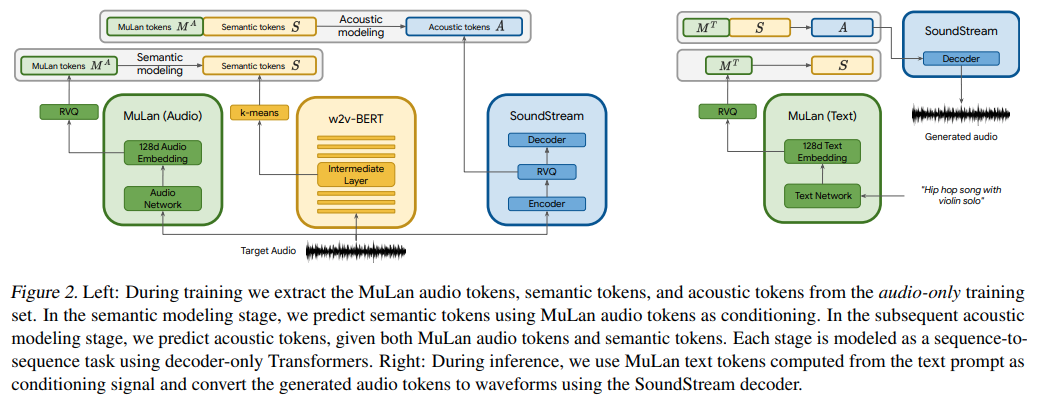


In [18]:
# 重启也要运行
import torch
from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer

audio_transformer = AudioSpectrogramTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64,
    spec_n_fft = 128,
    spec_win_length = 24,
    spec_aug_stretch_factor = 0.8
)

text_transformer = TextTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64
)

mulan = MuLaN(
    audio_transformer = audio_transformer,
    text_transformer = text_transformer
)

# get a ton of <sound, text> pairs and train

wavs = torch.randn(2, 1024)
texts = torch.randint(0, 20000, (2, 256))

loss = mulan(wavs, texts)
loss.backward()

# after much training, you can embed sounds and text into a joint embedding space
# for conditioning the audio LM

embeds = mulan.get_audio_latents(wavs)  # during training

embeds = mulan.get_text_latents(texts)  # during inference

spectrogram yielded shape of (65, 86), but had to be cropped to (64, 80) to be patchified for transformer


To obtain the conditioning embeddings for the three transformers that are a part of AudioLM, you must use the `MuLaNEmbedQuantizer` as so

## MusicLM

In [19]:
# 重启也要运行
from musiclm_pytorch import MuLaNEmbedQuantizer

# setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)

quantizer = MuLaNEmbedQuantizer(
    mulan = mulan,                          # pass in trained mulan from above
    conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
    namespaces = ('semantic', 'coarse', 'fine')
)

# now say you want the conditioning embeddings for semantic transformer

wavs = torch.randn(2, 1024)
conds = quantizer(wavs = wavs, namespace = 'semantic') # (2, 8, 1024) - 8 is number of quantizers

## train Hubert模型，audioLM transformer training, train AudioLM,
To train (or finetune) the three transformers that are a part of `AudioLM`, you simply follow the instructions over at `audiolm-pytorch` for training, but pass in the `MulanEmbedQuantizer` instance to the training classes under the keyword `audio_conditioner`

ex. `SemanticTransformerTrainer`

验证路径是否正确

In [20]:
import os
print("Current working directory:", os.getcwd())
print("Files in './downloaded_audios':", os.listdir('./downloaded_audios'))


Current working directory: /content
Files in './downloaded_audios': ['NLQts9t7d8k.wav', 'JR-1k8GHYAw.wav', '3noh9LiQNrs.wav', 'loyHHBilYPM.wav', 'MwK9HYjeeN0.wav', 'Ex0ukzO5z9M.wav', 'm3uiITzeM70.wav', 'Qw468qlDaAE.wav', '-Q9MTRXS4bE.wav', 'fvhbI-7e89s.wav', '74p3DLeDCHE.wav', 'gkB4KBHBV9g.wav', '9Rx57dlJtIA.wav', 'QHCHK-NPO_U.wav', 'p1DNl8BF49U.wav', 'hzr2aY33EuI.wav', 'd-AcpHG7OjU.wav', '5w3s2T0VBug.wav', 'R6V85er9VXc.wav', '8r1y_Bz4VfQ.wav', 'CEJXvm2vH_4.wav', 'DlVgHV1UobM.wav', 'ZFg6KpT5ehU.wav', 'XWVGQbfpA0k.wav', 'bf8JlTKzOs8.wav', '3zIQTDfS4Hk.wav', 'i6k1yiyO5jQ.wav', 'r4JRDHYukZ4.wav', 'hqCJarP-nVI.wav', 'ZkfKOLp5SxU.wav', 'b9yT3nGcD_I.wav', 'ikJKSqnTylI.wav', 'XzwhTltRQcM.wav', '5J6CjNc8Njo.wav', '5iUwBOf4yek.wav', '8pYHLfKqHL4.wav', '5JRvGMTjEzQ.wav', 'UkZ76EFfLSg.wav', 'rLBGxAj9D14.wav', '2qO-OQtOBK0.wav', 'chfTjqlrFQQ.wav', 'Yk2ZrS0ZS6g.wav', '-JvB5AL59fM.wav', 'Gw0KmZ3kbjs.wav', 'O2HttJtcec4.wav', '-1UWSisR2zo.wav', 'Aak-VLHtFPM.wav', 'G2uCAwYS6w0.wav', '69oU6LfyQ_4.wav', 


函数封装：将创建和使用训练器的代码封装在一个函数中。这有助于在函数结束时自动销毁局部变量，包括训练器实例。但这只在训练器没有修改全局状态或在内部维持静态/全局变量的情况下有效。
或者每次注释掉一个transformer，然后重启运行

防止触发

AssertionError: only one Trainer can be instantiated at a time for training



# 四、加载训练AudioLM

##训练三个 transformer

这三个transformer是 audioLM里面的

In [21]:

!pip install tensorboardX

!pip install nltk

!pip install librosa


In [22]:
! pip install audiolm_pytorch


## 数据处理，音频和.csv文本做预处理

数据用不到，但是代码可以用来处理数据和音频的对齐。


In [23]:
# # process_audio.py
# import librosa
# import numpy as np
# import pandas as pd
# from nltk.tokenize import word_tokenize
# import nltk
# import torch
# import os
# import pickle

# nltk.download('punkt')

# def load_audio_file(file_path, sr=22050):
#     # 加载音频文件
#     # 'sr' 是采样率，22050 是常用值
#     audio, _ = librosa.load(file_path, sr=sr)
#     return audio


# def audio_to_melspectrogram(audio, sr=22050, n_mels=128, hop_length=512):
#     # 将音频转换为梅尔频谱图
#     melspec = librosa.feature.melspectrogram(audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
#     melspec = librosa.power_to_db(melspec, ref=np.max)
#     return melspec


# def process_audio_files(file_paths, sr=22050, n_mels=128, hop_length=512):
#     processed_audios = []
#     valid_indices = []  # 用于存储有效音频的索引

#     for index, file_path in enumerate(file_paths):
#         try:
#             # 尝试加载和预处理音频文件
#             audio = load_audio_file(file_path, sr=sr)
#             melspec = audio_to_melspectrogram(audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
#             processed_audios.append(melspec)
#             valid_indices.append(index)
#         except Exception as e:
#             print(f"Error processing {file_path}: {e}")

#     return processed_audios, valid_indices



# # 简单的文本预处理函数
# def preprocess_text(text):
#     # 转换为小写
#     text = text.lower()
#     # 基本标记化
#     tokens = word_tokenize(text)
#     return tokens

# def main():
#     # 加载 .csv 文件
#     csv_file = 'musiccaps-public.csv'
#     df = pd.read_csv(csv_file)

#     # 提取字段作为文本数据

#     captions = df['caption']
#     aspect_list = df['aspect_list']

#     # 应用预处理
#     preprocessed_captions = [preprocess_text(text) for text in captions]
#     preprocessed_aspects = [preprocess_text(text) for text in aspect_list]

#     #  并行结合
#     combined_data = list(zip(preprocessed_captions, preprocessed_aspects))



#     # 提取音频文件名
#     audio_filenames = df['ytid'].tolist()
#     # 构建音频文件的完整路径
#     audio_file_paths = [f'./downloaded_audios/{filename}.wav' for filename in audio_filenames]

#     # 初始化计数器
#     existing_files_count = 0

#     # 检查每个音频文件是否存在
#     for file_path in audio_file_paths:
#         if os.path.exists(file_path):
#             existing_files_count += 1

#     print(f"Total audio files in CSV: {len(audio_filenames)}")
#     print(f"Existing audio files: {existing_files_count}")


#     # 预处理音频数据，并获取有效音频文件的索引
#     audio_data, valid_audio_indices = process_audio_files(audio_file_paths)

#     # 根据有效音频文件的索引来同步文本数据
#     synced_text_data = [combined_data[i] for i in valid_audio_indices]


#     # 确保长度相同, audio_data 和 combined_data 是一一对应的
#     # assert len(audio_data) == len(synced_text_data)

#     # 保存处理后的数据
#     if not os.path.exists('processed_data'):
#         os.makedirs('processed_data')

#     with open('processed_data/audio_data.pkl', 'wb') as f:
#         pickle.dump(audio_data, f)

#     with open('processed_data/text_data.pkl', 'wb') as f:
#         pickle.dump(synced_text_data, f)

# if __name__ == "__main__":
#     main()



## 训练 Semantic Transformer

In [2]:
import torch
from audiolm_pytorch import HubertWithKmeans
from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
from audiolm_pytorch import SoundStream, FineTransformer, FineTransformerTrainer
from audiolm_pytorch import AudioLMSoundStream, AudioLM
import gc  # 导入垃圾回收模块
from musiclm_pytorch import MuLaNEmbedQuantizer
from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer

audio_transformer = AudioSpectrogramTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64,
    spec_n_fft = 128,
    spec_win_length = 24,
    spec_aug_stretch_factor = 0.8
)

text_transformer = TextTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64
)

mulan = MuLaN(
    audio_transformer = audio_transformer,
    text_transformer = text_transformer
)

# setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)

quantizer = MuLaNEmbedQuantizer(
    mulan = mulan,                          # pass in trained mulan from above
    conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
    namespaces = ('semantic', 'coarse', 'fine')
)

# now say you want the conditioning embeddings for semantic transformer

wavs = torch.randn(2, 1024)
conds = quantizer(wavs = wavs, namespace = 'semantic') # (2, 8, 1024) - 8 is number of quantizers

# 公共变量
checkpoint_path = 'hubert_base_ls960.pt'
kmeans_path = 'hubert_base_ls960_L9_km500.bin'

audio_output_dir = './downloaded_audios'
batch_size = 1
data_max_length = 320 * 32
num_train_steps = 5_000

# 函数：训练 SemanticTransformer
def train_semantic_transformer():
    wav2vec = HubertWithKmeans(
        checkpoint_path=checkpoint_path,
        kmeans_path=kmeans_path
        )   # 每个函数中重新创建 wav2vec，后面会删掉


    if torch.cuda.is_available():
      semantic_transformer = SemanticTransformer(
          num_semantic_tokens=wav2vec.codebook_size,
          dim=1024,
          depth=6,
          audio_text_condition=True
          ).cuda()
    else:
      semantic_transformer = SemanticTransformer(
          num_semantic_tokens=wav2vec.codebook_size,
          dim=1024,
          depth=6,
          audio_text_condition=True
          )

    trainer = SemanticTransformerTrainer(
        transformer=semantic_transformer,
        wav2vec=wav2vec,
        audio_conditioner=quantizer,
        folder=audio_output_dir,
        batch_size=batch_size,
        data_max_length=data_max_length,
        num_train_steps=num_train_steps
        )

    trainer.train()
    torch.save(semantic_transformer.state_dict(), 'semantic_transformer.pth')
    print("save semantic_transformer.pth")
    del semantic_transformer, trainer, wav2vec
    gc.collect()  # 执行垃圾回收




train_semantic_transformer()


流式输出内容被截断，只能显示最后 5000 行内容。
55: loss: 4.312974452972412
56: loss: 3.913991928100586
57: loss: 4.534712791442871
58: loss: 2.990537405014038
59: loss: 6.697079658508301
60: loss: 5.697196006774902
61: loss: 3.1825695037841797
62: loss: 2.9979522228240967
63: loss: 3.0449845790863037
64: loss: 3.0149312019348145
65: loss: 2.478416681289673
66: loss: 3.60251522064209
67: loss: 3.3204281330108643
68: loss: 4.153395652770996
69: loss: 2.998879909515381
70: loss: 3.194406747817993
71: loss: 2.7994134426116943
72: loss: 2.28623628616333
73: loss: 3.114781141281128
74: loss: 3.36022686958313
75: loss: 4.769166469573975
76: loss: 5.44749116897583
77: loss: 3.061943531036377
78: loss: 5.879705905914307
79: loss: 2.4690444469451904
80: loss: 3.3424148559570312
81: loss: 3.7743735313415527
82: loss: 3.117453098297119
83: loss: 2.653679370880127
84: loss: 3.7305212020874023
85: loss: 3.6727185249328613
86: loss: 2.5567901134490967
87: loss: 2.9976694583892822
88: loss: 3.070103168487549
89: loss: 2.

## 训练 Coarse Transformer

重启代码后，直接运行后面代码

In [1]:
# 重启也要运行
!pip install musiclm-pytorch
!pip install --upgrade tensorflow tensorflow-io
!pip install audiolm_pytorch


In [2]:
import torch
from audiolm_pytorch import HubertWithKmeans
from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
from audiolm_pytorch import SoundStream, FineTransformer, FineTransformerTrainer
from audiolm_pytorch import AudioLMSoundStream, AudioLM, MusicLMSoundStream
import gc  # 导入垃圾回收模块
from musiclm_pytorch import MuLaNEmbedQuantizer
from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer

audio_transformer = AudioSpectrogramTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64,
    spec_n_fft = 128,
    spec_win_length = 24,
    spec_aug_stretch_factor = 0.8
)

text_transformer = TextTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64
)

mulan = MuLaN(
    audio_transformer = audio_transformer,
    text_transformer = text_transformer
)


# setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)

quantizer = MuLaNEmbedQuantizer(
    mulan = mulan,                          # pass in trained mulan from above
    conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
    namespaces = ('semantic', 'coarse', 'fine')
)



# now say you want the conditioning embeddings for semantic transformer

wavs = torch.randn(2, 1024)
conds = quantizer(wavs = wavs, namespace = 'semantic') # (2, 8, 1024) - 8 is number of quantizers

# 公共变量
checkpoint_path = 'hubert_base_ls960.pt'
kmeans_path = 'hubert_base_ls960_L9_km500.bin'

audio_output_dir = './downloaded_audios'
batch_size = 1
data_max_length = 320 * 32
num_train_steps = 5_000

# 函数：训练 CoarseTransformer
def train_coarse_transformer():
    wav2vec = HubertWithKmeans(
        checkpoint_path=checkpoint_path,
        kmeans_path=kmeans_path
        )   # 每个函数中重新创建 wav2vec，后面会删掉
    soundstream = MusicLMSoundStream()

    if torch.cuda.is_available():
      coarse_transformer = CoarseTransformer(
          num_semantic_tokens=wav2vec.codebook_size,
          codebook_size=1024,
          num_coarse_quantizers=4,
          dim=1024,
          depth=6,
          audio_text_condition=True
          ).cuda()
    else:
      coarse_transformer = CoarseTransformer(
          num_semantic_tokens=wav2vec.codebook_size,
          codebook_size=1024,
          num_coarse_quantizers=4,
          dim=1024,
          depth=6,
          audio_text_condition=True
          )

    trainer = CoarseTransformerTrainer(
        transformer=coarse_transformer,
        codec=soundstream,
        wav2vec=wav2vec,
        audio_conditioner=quantizer,
        folder=audio_output_dir,
        batch_size=batch_size,
        data_max_length=data_max_length,
        num_train_steps=num_train_steps
        )

    trainer.train()
    torch.save(coarse_transformer.state_dict(), 'coarse_transformer.pth')
    print("save coarse_transformer.pth")
    del coarse_transformer, trainer, wav2vec, soundstream
    gc.collect()

train_coarse_transformer()


流式输出内容被截断，只能显示最后 5000 行内容。
55: loss: 7.807773113250732
56: loss: 0.6285498142242432
57: loss: 4.162065029144287
58: loss: 5.941913604736328
59: loss: 4.5823469161987305
60: loss: 5.879067420959473
61: loss: 4.515390872955322
62: loss: 7.462822437286377
63: loss: 5.020299911499023
64: loss: 2.0258405208587646
65: loss: 2.2850325107574463
66: loss: 5.528753280639648
67: loss: 1.714385986328125
68: loss: 5.057371616363525
69: loss: 3.4697346687316895
70: loss: 4.551846027374268
71: loss: 6.441769123077393
72: loss: 2.1236820220947266
73: loss: 1.7358028888702393
74: loss: 3.8259313106536865
75: loss: 2.46342396736145
76: loss: 3.7641637325286865
77: loss: 5.143487930297852
78: loss: 1.6253433227539062
79: loss: 0.7539830207824707
80: loss: 6.491463661193848
81: loss: 8.137333869934082
82: loss: 8.159768104553223
83: loss: 3.4078357219696045
84: loss: 1.269244909286499
85: loss: 5.49475622177124
86: loss: 3.9255688190460205
87: loss: 12.276130676269531
88: loss: 14.46581745147705
89: loss:

## 训练 Fine Transformer

重启代码后，需要安装库

In [1]:
# 重启也要运行
!pip install musiclm-pytorch
!pip install --upgrade tensorflow tensorflow-io
!pip install audiolm_pytorch


In [2]:
import torch
from audiolm_pytorch import HubertWithKmeans
from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
from audiolm_pytorch import SoundStream, FineTransformer, FineTransformerTrainer
from audiolm_pytorch import AudioLMSoundStream, AudioLM, MusicLMSoundStream
from musiclm_pytorch import MuLaNEmbedQuantizer
from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer
import gc  # 导入垃圾回收模块
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
import librosa
import numpy as np
import pickle


nltk.download('punkt')

# 公共变量
checkpoint_path = 'hubert_base_ls960.pt'
kmeans_path = 'hubert_base_ls960_L9_km500.bin'

audio_output_dir = './downloaded_audios'
batch_size = 1
data_max_length = 320 * 32
num_train_steps = 5_000

audio_transformer = AudioSpectrogramTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64,
    spec_n_fft = 128,
    spec_win_length = 24,
    spec_aug_stretch_factor = 0.8
)

text_transformer = TextTransformer(
    dim = 512,
    depth = 6,
    heads = 8,
    dim_head = 64
)

mulan = MuLaN(
    audio_transformer = audio_transformer,
    text_transformer = text_transformer
)

# setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)

quantizer = MuLaNEmbedQuantizer(
    mulan = mulan,                          # pass in trained mulan from above
    conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
    namespaces = ('semantic', 'coarse', 'fine')
)



# 函数：训练 FineTransformer
def train_fine_transformer():
    soundstream = MusicLMSoundStream()

    if torch.cuda.is_available():
        fine_transformer = FineTransformer(
            num_coarse_quantizers = 4,
            num_fine_quantizers = 8,
            codebook_size = 1024,
            dim = 1024,
            depth = 6,
            audio_text_condition = True
                    ).cuda()
    else:
      fine_transformer = FineTransformer(
            num_coarse_quantizers = 4,
            num_fine_quantizers = 8,
            codebook_size = 1024,
            dim = 1024,
            depth = 6,
            audio_text_condition = True
                    )


    # 确保 Trainer 接收文本数据作为输入
    trainer = FineTransformerTrainer(
        transformer=fine_transformer,
        codec=soundstream,
        # audio_data=audio_data, # 原本想输入对应的音频，没有这个输入
        # text_data=combined_data, # 没有这个输入
        folder=audio_output_dir,
        batch_size=batch_size,
        data_max_length=data_max_length,
        num_train_steps=num_train_steps,
        audio_conditioner = quantizer
        )

    trainer.train()
    torch.save(fine_transformer.state_dict(), 'fine_transformer.pth')
    print("save fine_transformer.pth")
    del fine_transformer, trainer, soundstream
    gc.collect()


train_fine_transformer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


流式输出内容被截断，只能显示最后 5000 行内容。
55: loss: 0.6588897109031677
56: loss: 0.8065879940986633
57: loss: 0.03363664820790291
58: loss: 0.24962808191776276
59: loss: 1.0762847661972046
60: loss: 1.0331463813781738
61: loss: 0.11849640309810638
62: loss: 1.2515380382537842
63: loss: 3.619563102722168
64: loss: 2.9134109020233154
65: loss: 0.6990677714347839
66: loss: 0.6336829662322998
67: loss: 0.44260960817337036
68: loss: 2.0058155059814453
69: loss: 3.6340107917785645
70: loss: 1.5795371532440186
71: loss: 0.33129557967185974
72: loss: 1.1116466522216797
73: loss: 0.42507946491241455
74: loss: 2.00539493560791
75: loss: 0.3136669993400574
76: loss: 2.4032511711120605
77: loss: 0.7304375767707825
78: loss: 0.7764381766319275
79: loss: 0.2560124695301056
80: loss: 0.4924231469631195
81: loss: 2.0885608196258545
82: loss: 1.0717973709106445
83: loss: 0.7411545515060425
84: loss: 0.2251267284154892
85: loss: 0.29795387387275696
86: loss: 0.29684552550315857
87: loss: 0.34284502267837524
88: loss: 

In [ ]:

# # 重启也要运行

# import array
# import torch
# import torchaudio
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# import soundfile
# from scipy.io.wavfile import read
# from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer
# from musiclm_pytorch import MuLaNEmbedQuantizer
# import os
# import pathlib
# import numpy
# import pandas



# audio_transformer = AudioSpectrogramTransformer(
#     dim = 512,
#     depth = 6,
#     heads = 8,
#     dim_head = 64,
#     spec_n_fft = 128,
#     spec_win_length = 24,
#     spec_aug_stretch_factor = 0.8
# )

# text_transformer = TextTransformer(
#     dim = 512,
#     depth = 6,
#     heads = 8,
#     dim_head = 64
# )

# mulan = MuLaN(
#     audio_transformer = audio_transformer,
#     text_transformer = text_transformer
# )

# # get a ton of <sound, text> pairs and train

# wavs = torch.randn(2, 1024)
# texts = torch.randint(0, 20000, (2, 256))

# loss = mulan(wavs, texts)
# loss.backward()

# # after much training, you can embed sounds and text into a joint embedding space
# # for conditioning the audio LM

# embeds = mulan.get_audio_latents(wavs)  # during training

# embeds = mulan.get_text_latents(texts)  # during inference


# # setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)

# quantizer = MuLaNEmbedQuantizer(
#     mulan = mulan,                          # pass in trained mulan from above
#     conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
#     namespaces = ('semantic', 'coarse', 'fine')
# )

# # now say you want the conditioning embeddings for semantic transformer
# conds = quantizer(wavs = wavs, namespace = 'semantic') # (2, 8, 1024) - 8 is number of quantizers



## 加载AudioLM
把训练好的模型加载进来

In [3]:
import torch
from audiolm_pytorch import HubertWithKmeans
from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
from audiolm_pytorch import FineTransformer, FineTransformerTrainer
from audiolm_pytorch import AudioLMSoundStream, AudioLM

# 创建并加载 AudioLM 实例
wav2vec = HubertWithKmeans(checkpoint_path=checkpoint_path, kmeans_path=kmeans_path) # 前面被删掉了
soundstream = AudioLMSoundStream()

if torch.cuda.is_available():
    semantic_transformer = SemanticTransformer(
      num_semantic_tokens=wav2vec.codebook_size,
      dim=1024,
      depth=6,
      audio_text_condition=True
    ).cuda()

    coarse_transformer = CoarseTransformer(
      num_semantic_tokens=wav2vec.codebook_size,
      codebook_size=1024,
      num_coarse_quantizers=4,
      dim=1024,
      depth=6,
      audio_text_condition=True
    ).cuda()

    fine_transformer = FineTransformer(
      num_coarse_quantizers=4,
      num_fine_quantizers=8,
      codebook_size=1024,
      dim=1024,
      depth=6,
      audio_text_condition=True
    ).cuda()
else:
    semantic_transformer = SemanticTransformer(
      num_semantic_tokens=wav2vec.codebook_size,
      dim=1024,
      depth=6,
      audio_text_condition=True
    )

    coarse_transformer = CoarseTransformer(
      num_semantic_tokens=wav2vec.codebook_size,
      codebook_size=1024,
      num_coarse_quantizers=4,
      dim=1024,
      depth=6,
      audio_text_condition=True
    )

    fine_transformer = FineTransformer(
      num_coarse_quantizers=4,
      num_fine_quantizers=8,
      codebook_size=1024,
      dim=1024,
      depth=6,
      audio_text_condition=True
    )



# 加载模型状态
semantic_transformer.load_state_dict(torch.load('semantic_transformer.pth'))
coarse_transformer.load_state_dict(torch.load('coarse_transformer.pth'))
fine_transformer.load_state_dict(torch.load('fine_transformer.pth'))

audiolm = AudioLM(
    wav2vec=wav2vec,
    codec=soundstream,
    semantic_transformer=semantic_transformer,
    coarse_transformer=coarse_transformer,
    fine_transformer=fine_transformer
    )


下面是可能会缺失的参数

In [ ]:
# # 重启也要运行
# import torch
# from audiolm_pytorch import HubertWithKmeans
# from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer, SoundStream
# from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
# from audiolm_pytorch import FineTransformer, FineTransformerTrainer
# from audiolm_pytorch import AudioLMSoundStream, MusicLMSoundStream
# from unittest import mock
# import multiprocessing as mp
# import gc  # 导入垃圾回收模块


# # 设置多进程启动方式为 'spawn'
# mp.set_start_method('spawn', force=True)

# def train_semantic_transformer_process(checkpoint_path, kmeans_path):
#     wav2vec = HubertWithKmeans(checkpoint_path=checkpoint_path, kmeans_path=kmeans_path)
#     semantic_transformer = SemanticTransformer(
#         num_semantic_tokens = wav2vec.codebook_size,
#         dim = 1024,
#         depth = 6,
#         audio_text_condition = True      # this must be set to True (same for CoarseTransformer and FineTransformers)
#     ).cuda()

#     trainer = SemanticTransformerTrainer(
#         transformer = semantic_transformer,
#         wav2vec = wav2vec,
#         audio_conditioner = quantizer,   # pass in the MulanEmbedQuantizer instance above
#         folder ='./downloaded_audios',
#         batch_size = 1,
#         data_max_length = 320 * 32,
#         num_train_steps = 1
#     )

#     trainer.train()
#     torch.save(semantic_transformer.state_dict(), '/content/semantic_transformer.pth') # 保存模型
# #     del trainer  # 显式删除实例，删除好像没有效果，需要存下来重启


# def train_coarse_transformer_process(checkpoint_path, kmeans_path):
#     wav2vec = HubertWithKmeans(checkpoint_path=checkpoint_path, kmeans_path=kmeans_path)
#     soundstream = MusicLMSoundStream()

#     coarse_transformer = CoarseTransformer(
#         num_semantic_tokens = wav2vec.codebook_size,
#         codebook_size = 1024,
#         num_coarse_quantizers = 4,
#         dim = 1024,
#         depth = 6,
#         audio_text_condition = True
#     ).cuda()

#     with mock.patch('builtins.input', return_value='n'):
#         trainer = CoarseTransformerTrainer(
#             transformer = coarse_transformer,
#             codec = soundstream,
#             wav2vec = wav2vec,
#             audio_conditioner = quantizer,
#             folder = './downloaded_audios/',
#             batch_size = 1,
#             data_max_length = 320 * 32,
#             num_train_steps = 1
#         )
#         trainer.train()
#         # 保存模型状态字典
#         torch.save(coarse_transformer.state_dict(), '/content/coarse_transformer.pth') # 保存模型


# def train_fine_transformer_process():
#     soundstream = MusicLMSoundStream()
#     fine_transformer = FineTransformer(
#         num_coarse_quantizers = 4,
#         num_fine_quantizers = 8,
#         codebook_size = 1024,
#         dim = 1024,
#         depth = 6,
#         audio_text_condition = True
#     ).cuda()

#     with mock.patch('builtins.input', return_value='n'):
#         trainer = FineTransformerTrainer(
#             transformer = fine_transformer,
#             codec = soundstream,
#             folder = './downloaded_audios/',
#             batch_size = 1,
#             data_max_length = 320 * 32,
#             num_train_steps = 1,
#             audio_conditioner = quantizer
#         )

#         trainer.train()
#         torch.save(fine_transformer.state_dict(), '/content/fine_transformer.pth') # 保存模型



# def run_training_process(train_function, *args):
#     process = mp.Process(target=train_function, args=args)
#     process.start()
#     process.join()  # 等待进程结束



# def train_all_transformers():

#     # 加载 wav2vec 的参数
#     checkpoint_path = 'hubert_base_ls960.pt'
#     kmeans_path = 'hubert_base_ls960_L9_km500.bin'

#     # 多线程运行
#     run_training_process(train_semantic_transformer_process, checkpoint_path, kmeans_path)
#     run_training_process(train_coarse_transformer_process, checkpoint_path, kmeans_path)
#     run_training_process(train_fine_transformer_process)

# train_all_transformers()


# 解决one trainer问题--没有解决


暂时无法解决，必须要不断重启。

## 使用不同的.py文件来调用 解决冲突-无效

因为方法不能避免 one trainer的问题，所以暂时不用。

生成`train_semantic_transformer.py`

In [ ]:
# # train_semantic_transformer.py
# import torch
# from audiolm_pytorch import HubertWithKmeans
# from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
# from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
# from audiolm_pytorch import FineTransformer, FineTransformerTrainer
# from audiolm_pytorch import AudioLMSoundStream, AudioLM
# import gc  # 导入垃圾回收模块

# # 公共变量
# checkpoint_path = 'hubert_base_ls960.pt'
# kmeans_path = 'hubert_base_ls960_L9_km500.bin'

# audio_output_dir = './downloaded_audios'
# batch_size = 1
# data_max_length = 320 * 32
# num_train_steps = 1

# # 函数：训练 SemanticTransformer
# def train_semantic_transformer():
#     wav2vec = HubertWithKmeans(checkpoint_path=checkpoint_path, kmeans_path=kmeans_path)   # 每个函数中重新创建 wav2vec，后面会删掉
#     soundstream = AudioLMSoundStream()
#     semantic_transformer = SemanticTransformer(num_semantic_tokens=wav2vec.codebook_size, dim=1024, depth=6, audio_text_condition=True).cuda()
#     trainer = SemanticTransformerTrainer(transformer=semantic_transformer, wav2vec=wav2vec, audio_conditioner=quantizer, folder=audio_output_dir, batch_size=batch_size, data_max_length=data_max_length, num_train_steps=num_train_steps)
#     trainer.train()
#     torch.save(semantic_transformer.state_dict(), 'semantic_transformer.pth')
#     del semantic_transformer, trainer, wav2vec
#     gc.collect()  # 执行垃圾回收



# # 依次训练每个模型
# train_semantic_transformer()


`train_coarse_transformer.py`

In [ ]:
# # train_coarse_transformer.py
# import torch
# from audiolm_pytorch import HubertWithKmeans
# from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
# from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
# from audiolm_pytorch import FineTransformer, FineTransformerTrainer
# from audiolm_pytorch import AudioLMSoundStream, AudioLM
# import gc  # 导入垃圾回收模块

# # 公共变量
# checkpoint_path = 'hubert_base_ls960.pt'
# kmeans_path = 'hubert_base_ls960_L9_km500.bin'

# audio_output_dir = './downloaded_audios'
# batch_size = 1
# data_max_length = 320 * 32
# num_train_steps = 1

# # 函数：训练 CoarseTransformer
# def train_coarse_transformer():
#     wav2vec = HubertWithKmeans(checkpoint_path=checkpoint_path, kmeans_path=kmeans_path)   # 每个函数中重新创建 wav2vec，后面会删掉
#     soundstream = AudioLMSoundStream()

#     coarse_transformer = CoarseTransformer(num_semantic_tokens=wav2vec.codebook_size, codebook_size=1024, num_coarse_quantizers=4, dim=1024, depth=6, audio_text_condition=True).cuda()
#     trainer = CoarseTransformerTrainer(transformer=coarse_transformer, codec=soundstream, wav2vec=wav2vec, audio_conditioner=quantizer, folder=audio_output_dir, batch_size=batch_size, data_max_length=data_max_length, num_train_steps=num_train_steps)
#     trainer.train()
#     torch.save(coarse_transformer.state_dict(), 'coarse_transformer.pth')
#     del coarse_transformer, trainer, wav2vec, soundstream
#     gc.collect()

# train_coarse_transformer()





`train_fine_transformer.py`

In [ ]:
# # train_fine_transformer.py

# import torch
# from audiolm_pytorch import HubertWithKmeans
# from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
# from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
# from audiolm_pytorch import FineTransformer, FineTransformerTrainer
# from audiolm_pytorch import AudioLMSoundStream, AudioLM
# import gc  # 导入垃圾回收模块

# # 公共变量
# checkpoint_path = 'hubert_base_ls960.pt'
# kmeans_path = 'hubert_base_ls960_L9_km500.bin'

# audio_output_dir = './downloaded_audios'
# batch_size = 1
# data_max_length = 320 * 32
# num_train_steps = 1


# # 函数：训练 FineTransformer
# def train_fine_transformer():
#     soundstream = AudioLMSoundStream()

#     fine_transformer = FineTransformer(num_coarse_quantizers=4, num_fine_quantizers=8, codebook_size=1024, dim=1024, depth=6, audio_text_condition=True).cuda()
#     trainer = FineTransformerTrainer(transformer=fine_transformer, codec=soundstream, folder=audio_output_dir, batch_size=batch_size, data_max_length=data_max_length, num_train_steps=num_train_steps)
#     trainer.train()
#     torch.save(fine_transformer.state_dict(), 'fine_transformer.pth')
#     del fine_transformer, trainer, soundstream
#     gc.collect()

# train_fine_transformer()

强制覆盖文件

In [ ]:
# !wget -O train_semantic_transformer.py https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/train_semantic_transformer.py
# !wget -O train_coarse_transformer.py https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/train_coarse_transformer.py
# !wget -O train_fine_transformer.py https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/train_fine_transformer.py
# !wget -O process_audio.py https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/process_audio.py

In [ ]:
# !ls

In [ ]:

# !pip install tensorboardX

# !pip install nltk

# !pip install librosa

# ! pip install audiolm_pytorch

# %run process_audio.py

# %run train_semantic_transformer.py

# %run train_coarse_transformer.py


## 使用单线程调用解决 one trainer问题--无效

下面是单线程运行，但是需要每次调用一个网络训练。

In [ ]:
# # 重启也要运行
# import torch
# from audiolm_pytorch import HubertWithKmeans
# from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer, SoundStream
# from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
# from audiolm_pytorch import FineTransformer, FineTransformerTrainer
# from audiolm_pytorch import AudioLMSoundStream, MusicLMSoundStream
# from unittest import mock
# import multiprocessing


# def train_semantic_transformer(wav2vec):

#     semantic_transformer = SemanticTransformer(
#         num_semantic_tokens = wav2vec.codebook_size,
#         dim = 1024,
#         depth = 6,
#         audio_text_condition = True      # this must be set to True (same for CoarseTransformer and FineTransformers)
#     ).cuda()

#     trainer = SemanticTransformerTrainer(
#         transformer = semantic_transformer,
#         wav2vec = wav2vec,
#         audio_conditioner = quantizer,   # pass in the MulanEmbedQuantizer instance above
#         folder ='./downloaded_audios',
#         batch_size = 1,
#         data_max_length = 320 * 32,
#         num_train_steps = 1
#     )

#     trainer.train()
#     torch.save(semantic_transformer.state_dict(), 'semantic_transformer.pth') # 保存模型
#     del trainer  # 显式删除实例，删除好像没有效果，需要存下来重启


# def train_coarse_transformer(wav2vec, soundstream):

#     coarse_transformer = CoarseTransformer(
#         num_semantic_tokens = wav2vec.codebook_size,
#         codebook_size = 1024,
#         num_coarse_quantizers = 4,
#         dim = 1024,
#         depth = 6,
#         audio_text_condition = True
#     ).cuda()

#     with mock.patch('builtins.input', return_value='n'):
#         trainer = CoarseTransformerTrainer(
#             transformer = coarse_transformer,
#             codec = soundstream,
#             wav2vec = wav2vec,
#             audio_conditioner = quantizer,
#             folder = './downloaded_audios/',
#             batch_size = 1,
#             data_max_length = 320 * 32,
#             num_train_steps = 1
#         )
#         trainer.train()
#         # 保存模型状态字典
#         torch.save(coarse_transformer.state_dict(), 'coarse_transformer.pth') # 保存模型

# def train_fine_transformer(soundstream):
#     fine_transformer = FineTransformer(
#         num_coarse_quantizers = 4,
#         num_fine_quantizers = 8,
#         codebook_size = 1024,
#         dim = 1024,
#         depth = 6,
#         audio_text_condition = True
#     ).cuda()

#     with mock.patch('builtins.input', return_value='n'):
#         trainer = FineTransformerTrainer(
#             transformer = fine_transformer,
#             codec = soundstream,
#             folder = './downloaded_audios/',
#             batch_size = 1,
#             data_max_length = 320 * 32,
#             num_train_steps = 1,
#             audio_conditioner = quantizer
#         )

#         trainer.train()
#         torch.save(fine_transformer.state_dict(), 'fine_transformer.pth') # 保存模型

# def train_all_transformers():
#      # soundstream = SoundStream.init_and_load_from('/path/to/trained/soundstream.pt')
#     soundstream = MusicLMSoundStream()
#     # 重新加载 wav2vec 和 soundstream
#     wav2vec = HubertWithKmeans(
#         checkpoint_path='hubert_base_ls960.pt',
#         kmeans_path='hubert_base_ls960_L9_km500.bin'
#     )

#    # 训练 SemanticTransformer
#     train_semantic_transformer(wav2vec)
#     # 训练 CoarseTransformer
#     train_coarse_transformer(wav2vec, soundstream)

#     # 训练 FineTransformer
#     train_fine_transformer(soundstream)

# train_all_transformers()


调用训练模型

In [ ]:
# train_semantic_transformer()


## 尝试多进程

In [ ]:
# import requests

# # 下载 train_semantic_transformer.py
# semantic_transformer_url = 'https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/train_semantic_transformer.py'
# semantic_transformer_response = requests.get(semantic_transformer_url)
# with open('train_semantic_transformer.py', 'wb') as f:
#     f.write(semantic_transformer_response.content)

# # 下载 train_coarse_transformer.py
# coarse_transformer_url = 'https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/train_coarse_transformer.py'
# coarse_transformer_response = requests.get(coarse_transformer_url)
# with open('train_coarse_transformer.py', 'wb') as f:
#     f.write(coarse_transformer_response.content)

# # 下载 train_fine_transformer.py
# fine_transformer_url = 'https://raw.githubusercontent.com/Huang-Yongzhi/MusicLM_Jupyter/main/train_fine_transformer.py'
# fine_transformer_response = requests.get(fine_transformer_url)
# with open('train_fine_transformer.py', 'wb') as f:
#     f.write(fine_transformer_response.content)


In [ ]:
# from concurrent.futures import ProcessPoolExecutor

# # 定义一个函数来运行 Python 文件
# def run_python_file(file_name):
#     try:
#         with open(file_name, encoding='utf-8') as f:
#             exec(f.read())
#     except Exception as e:
#         print(f"Error running {file_name}: {e}")


# def main():
#         executor.submit(run_python_file, 'train_semantic_transformer.py')
#         executor.submit(run_python_file, 'train_coarse_transformer.py')
#         executor.submit(run_python_file, 'train_fine_transformer.py')

# if __name__ == '__main__':
#     # 运行您的主程序
#     main()


RuntimeError: ignored

In [ ]:
# import torch
# import torch.multiprocessing as mp
# from concurrent.futures import ProcessPoolExecutor
# from audiolm_pytorch import HubertWithKmeans
# from audiolm_pytorch import SemanticTransformer, SemanticTransformerTrainer
# from audiolm_pytorch import CoarseTransformer, CoarseTransformerTrainer
# from audiolm_pytorch import FineTransformer, FineTransformerTrainer, MusicLMSoundStream
# from musiclm_pytorch import MuLaNEmbedQuantizer
# from musiclm_pytorch import MuLaN, AudioSpectrogramTransformer, TextTransformer
# import subprocess
# import gc  # 导入垃圾回收模块

# # 设置多处理
# # mp.set_start_method('spawn')

# # 公共变量
# checkpoint_path = 'hubert_base_ls960.pt'
# kmeans_path = 'hubert_base_ls960_L9_km500.bin'
# audio_output_dir = './downloaded_audios'
# batch_size = 1
# data_max_length = 320 * 32
# num_train_steps = 1_000

# # 函数：训练 SemanticTransformer
# def train_semantic_transformer():
#     # 初始化 wav2vec 模型
#     wav2vec = HubertWithKmeans(
#         checkpoint_path=checkpoint_path,
#         kmeans_path=kmeans_path
#     )

#     audio_transformer = AudioSpectrogramTransformer(
#         dim = 512,
#         depth = 6,
#         heads = 8,
#         dim_head = 64,
#         spec_n_fft = 128,
#         spec_win_length = 24,
#         spec_aug_stretch_factor = 0.8
#     )

#     text_transformer = TextTransformer(
#         dim = 512,
#         depth = 6,
#         heads = 8,
#         dim_head = 64
#     )

#     mulan = MuLaN(
#         audio_transformer = audio_transformer,
#         text_transformer = text_transformer
#     )

#     # setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)
#     quantizer = MuLaNEmbedQuantizer(
#         mulan = mulan,                          # pass in trained mulan from above
#         conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
#         namespaces = ('semantic', 'coarse', 'fine')
#     )
#     # now say you want the conditioning embeddings for semantic transformer

#     wavs = torch.randn(2, 1024)
#     conds = quantizer(wavs = wavs, namespace = 'semantic') # (2, 8, 1024) - 8 is number of quantizers


#     # 初始化 SemanticTransformer 模型
#     if torch.cuda.is_available():
#         semantic_transformer = SemanticTransformer(
#             num_semantic_tokens=wav2vec.codebook_size,
#             dim=1024,
#             depth=6,
#             audio_text_condition=True
#         ).cuda()
#     else:
#         semantic_transformer = SemanticTransformer(
#             num_semantic_tokens=wav2vec.codebook_size,
#             dim=1024,
#             depth=6,
#             audio_text_condition=True
#         )


#     # 初始化 SemanticTransformerTrainer
#     trainer = SemanticTransformerTrainer(
#         transformer=semantic_transformer,
#         wav2vec=wav2vec,
#         audio_conditioner=quantizer,
#         folder=audio_output_dir,
#         batch_size=batch_size,
#         data_max_length=data_max_length,
#         num_train_steps=num_train_steps
#     )

#     # 训练 SemanticTransformer 模型
#     trainer.train()
#     torch.save(semantic_transformer.state_dict(), 'semantic_transformer.pth')
#     print("save semantic_transformer.pth")

#     # 删除 trainer 和调用垃圾回收
#     del trainer, semantic_transformer, wav2vec, mulan, audio_transformer, text_transformer, quantizer
#     gc.collect()

# # 函数：训练 CoarseTransformer
# def train_coarse_transformer():
#     # 初始化 wav2vec 模型
#     wav2vec = HubertWithKmeans(
#         checkpoint_path=checkpoint_path,
#         kmeans_path=kmeans_path
#     )

#     # 初始化音频流
#     soundstream = MusicLMSoundStream()


#     # 公共变量
#     audio_transformer = AudioSpectrogramTransformer(
#         dim = 512,
#         depth = 6,
#         heads = 8,
#         dim_head = 64,
#         spec_n_fft = 128,
#         spec_win_length = 24,
#         spec_aug_stretch_factor = 0.8
#     )

#     text_transformer = TextTransformer(
#         dim = 512,
#         depth = 6,
#         heads = 8,
#         dim_head = 64
#     )

#     mulan = MuLaN(
#         audio_transformer = audio_transformer,
#         text_transformer = text_transformer
#     )

#     # setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)
#     quantizer = MuLaNEmbedQuantizer(
#         mulan = mulan,                          # pass in trained mulan from above
#         conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
#         namespaces = ('semantic', 'coarse', 'fine'))

#     # 初始化 CoarseTransformer 模型
#     if torch.cuda.is_available():
#         coarse_transformer = CoarseTransformer(
#             num_semantic_tokens=wav2vec.codebook_size,
#             codebook_size=1024,
#             num_coarse_quantizers=4,
#             dim=1024,
#             depth=6,
#             audio_text_condition=True
#         ).cuda()
#     else:
#         coarse_transformer = CoarseTransformer(
#             num_semantic_tokens=wav2vec.codebook_size,
#             codebook_size=1024,
#             num_coarse_quantizers=4,
#             dim=1024,
#             depth=6,
#             audio_text_condition=True
#         )

#     # 初始化 CoarseTransformerTrainer
#     trainer = CoarseTransformerTrainer(
#         transformer=coarse_transformer,
#         codec=soundstream,
#         wav2vec=wav2vec,
#         audio_conditioner=quantizer,
#         folder=audio_output_dir,
#         batch_size=batch_size,
#         data_max_length=data_max_length,
#         num_train_steps=num_train_steps
#     )

#     # 训练 CoarseTransformer 模型
#     trainer.train()
#     torch.save(coarse_transformer.state_dict(), 'coarse_transformer.pth')
#     print("save coarse_transformer.pth")

#     # 删除 trainer 和调用垃圾回收
#     del trainer, coarse_transformer, wav2vec, soundstream, quantizer
#     gc.collect()

# # 函数：训练 FineTransformer
# def train_fine_transformer():
#     # 初始化音频流
#     soundstream = MusicLMSoundStream()
#     audio_transformer = AudioSpectrogramTransformer(
#         dim = 512,
#         depth = 6,
#         heads = 8,
#         dim_head = 64,
#         spec_n_fft = 128,
#         spec_win_length = 24,
#         spec_aug_stretch_factor = 0.8
#     )

#     text_transformer = TextTransformer(
#         dim = 512,
#         depth = 6,
#         heads = 8,
#         dim_head = 64
#     )

#     mulan = MuLaN(
#         audio_transformer = audio_transformer,
#         text_transformer = text_transformer
#     )

#     # setup the quantizer with the namespaced conditioning embeddings, unique per quantizer as well as namespace (per transformer)

#     quantizer = MuLaNEmbedQuantizer(
#         mulan = mulan,                          # pass in trained mulan from above
#         conditioning_dims = (1024, 1024, 1024), # say all three transformers have model dimensions of 1024
#         namespaces = ('semantic', 'coarse', 'fine')
#     )

#     # 初始化 FineTransformer 模型
#     if torch.cuda.is_available():
#         fine_transformer = FineTransformer(
#             num_coarse_quantizers=4,
#             num_fine_quantizers=8,
#             codebook_size=1024,
#             dim=1024,
#             depth=6,
#             audio_text_condition=True
#         ).cuda()
#     else:
#         fine_transformer = FineTransformer(
#             num_coarse_quantizers=4,
#             num_fine_quantizers=8,
#             codebook_size=1024,
#             dim=1024,
#             depth=6,
#             audio_text_condition=True
#         )

#     # 确保 Trainer 接收文本数据作为输入
#     trainer = FineTransformerTrainer(
#         transformer=fine_transformer,
#         codec=soundstream,
#         folder=audio_output_dir,
#         batch_size=batch_size,
#         data_max_length=data_max_length,
#         num_train_steps=num_train_steps,
#         audio_conditioner=quantizer
#     )

#     # 训练 FineTransformer 模型
#     trainer.train()
#     torch.save(fine_transformer.state_dict(), 'fine_transformer.pth')
#     print("save fine_transformer.pth")

#     # 删除 trainer 和调用垃圾回收
#     del trainer, fine_transformer, soundstream, quantizer
#     gc.collect()


# def main(network_funchtion):
#     # 创建进程池
#     with ProcessPoolExecutor(max_workers=1) as executor:
#         # 同时提交并执行三个训练任务
#         executor.submit(network_funchtion)



# if __name__ == '__main__':
#     # 运行您的主程序
#     main(train_semantic_transformer)
#     main(train_coarse_transformer)
#     main(train_fine_transformer)


# 五、把mulan和AudioLM加载生成MusicLM


In [4]:
# you need the trained AudioLM (audio_lm) from above
# with the MulanEmbedQuantizer (mulan_embed_quantizer)

from musiclm_pytorch import MusicLM

if torch.cuda.is_available():
    musiclm = MusicLM(
    audio_lm = audiolm,
    mulan_embed_quantizer = quantizer
    ).cuda()
else:
  musiclm = MusicLM(
    audio_lm = audiolm,
    mulan_embed_quantizer = quantizer
    )




## 测试

In [ ]:
music = musiclm('the crystalline sounds of the piano in a ballroom', num_samples = 4) # sample 4 and pick the top match with mulan

generating fine:  53%|█████▎    | 273/512 [01:31<01:51,  2.14it/s]

In [1]:
torch.save(music, 'generated_music.pt')

NameError: ignored

In [ ]:
import torchaudio
output_path = "out.wav"
sample_rate = 44100
torchaudio.save(output_path, music.cpu() , sample_rate)